Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break

Version = "v32" # y_prob.probability.quantile([0.3, 0.8]), if Threshold >= 0.95: break

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= 1.1
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=3, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        prob_quant = y_prob.probability.quantile(0.5)
        high_conf_0 = min(y_prob.probability.min()*30, prob_quant)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(prob_quant)
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target) * 1.1
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.95: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    return X, y

In [16]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [24]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [26]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [27]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [28]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [29]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [30]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [31]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [32]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [33]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [34]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [35]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [36]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [39]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [40]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [41]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [42]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [43]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [44]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [46]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [47]:
important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

In [48]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 40 columns



Removed 10 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_10_pca_umap_all_3_div,pca_umap_g_10_pca_umap_g_d_g_4_div,pca_umap_g_d_g_4_pca_umap_g_2_prd,pca_umap_g_d_g_4_pca_umap_g_2_div,pca_umap_g_d_g_4_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_4_pca_umap_g_d_g_8_div,pca_umap_g_d_g_4_pca_umap_all_3_prd,pca_umap_g_d_g_4_pca_umap_all_3_div,pca_umap_g_d_g_4_pca_umap_g_10_prd,pca_umap_g_d_g_4_pca_umap_g_10_div
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.0,-2.0,-0.372530,-0.0,0.031359,5.0,-0.612375,-0.0,-0.273265,-1.0
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,4.0,-1.0,-0.634523,-1.0,0.165439,2.0,-0.068703,-6.0,-0.246907,-2.0
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.0,-0.0,-1.114591,-1.0,0.045881,24.0,-0.558856,-2.0,-0.447970,-2.0
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,2.0,-2.0,-0.357978,-1.0,0.146056,1.0,-0.130173,-1.0,-0.308488,-1.0
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,1.0,1.0,0.060373,2.0,0.017711,5.0,0.139919,1.0,0.073825,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.0,-0.0,-0.206348,-7.0,0.146749,9.0,-1.629796,-1.0,-0.298441,-5.0
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.0,-1.0,-0.973184,-1.0,0.064801,17.0,-1.407890,-1.0,-0.775912,-1.0
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,1.0,1.0,1.022249,1.0,0.770045,2.0,1.311937,1.0,0.735862,2.0
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.0,-1.0,-1.052777,-1.0,0.147321,8.0,-1.529836,-1.0,-0.772642,-1.0


In [49]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 140 columns



Removed 80 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.705612,0.419021,1.124633,0.173420,0.532192,0.592441,0.937024,0.231412,1.356045,0.763604
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.902261,0.638177,0.264085,0.437184,0.465078,0.200993,1.158975,0.256714,0.520799,0.721792
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.784426,0.375651,0.408774,0.450606,0.333820,0.074954,1.493108,0.708682,1.117456,1.042502
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.806845,0.364665,0.442180,0.079223,0.727623,0.285442,0.885391,0.078546,0.520726,0.806168
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.099206,0.184977,0.284183,0.031282,0.130487,0.153695,0.074624,0.173829,0.110353,0.043342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.213477,0.860594,1.074071,0.055678,0.269155,0.804916,0.951769,0.738293,1.812363,1.007448
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,0.691869,0.289753,0.981622,0.131492,0.560377,0.421245,1.398807,0.706938,1.688561,1.267315
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.156384,0.179627,0.336011,0.177579,0.021195,0.357206,0.172496,0.328880,0.007130,0.350076
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,0.798552,0.317438,1.115990,0.186403,0.612149,0.503841,1.451945,0.653393,1.769383,1.265542


In [50]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,0.705612,0.419021,1.124633,0.173420,0.532192,0.592441,0.937024,0.231412,1.356045,0.763604
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.902261,0.638177,0.264085,0.437184,0.465078,0.200993,1.158975,0.256714,0.520799,0.721792
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.784426,0.375651,0.408774,0.450606,0.333820,0.074954,1.493108,0.708682,1.117456,1.042502
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.806845,0.364665,0.442180,0.079223,0.727623,0.285442,0.885391,0.078546,0.520726,0.806168
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.099206,0.184977,0.284183,0.031282,0.130487,0.153695,0.074624,0.173829,0.110353,0.043342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.213477,0.860594,1.074071,0.055678,0.269155,0.804916,0.951769,0.738293,1.812363,1.007448
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,0.691869,0.289753,0.981622,0.131492,0.560377,0.421245,1.398807,0.706938,1.688561,1.267315
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.156384,0.179627,0.336011,0.177579,0.021195,0.357206,0.172496,0.328880,0.011069,0.350076
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,0.798552,0.317438,1.115990,0.186403,0.612149,0.503841,1.451945,0.653393,1.769383,1.265542


In [51]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [52]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [53]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812127	valid_1's binary_logloss: 0.149281
[200]	training's binary_logloss: 0.015991	valid_1's binary_logloss: 0.0762961
[300]	training's binary_logloss: 0.00549611	valid_1's binary_logloss: 0.0548986
[400]	training's binary_logloss: 0.00303937	valid_1's binary_logloss: 0.0499637
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00285227	valid_1's binary_logloss: 0.0490208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871146	valid_1's binary_logloss: 0.140443
[200]	training's binary_logloss: 0.0185619	valid_1's binary_logloss: 0.0550135
[300]	training's binary_logloss: 0.0062947	valid_1's binary_logloss: 0.0322486
[400]	training's binary_logloss: 0.00339478	valid_1's binary_logloss: 0.0254939
[500]	training's binary_logloss: 0.00238737	valid_1's binary_logloss: 0.0221212
Early stopping, best iteration is:
[570]	training's

1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 499/990
0.010856241196491149
p_label_rate: 0.01306 Vs.target_rate: 0.00079, Num_p_label: 52.0, conf_0:0.00379, conf_1:0.59439
Num_p_label: 52.0, Expected: 3.1, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 3.1, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 3.1, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 3.1, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 3.1, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 3.1, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 3.1, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 3.1, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.1, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 3.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/990, y_label_rate: 0.50404
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792545	valid_1's binary_logloss: 0.154377
[200]	training's binary_logloss: 0.015244	valid_1's binary_logloss: 0.0730171
[300]	training's binary_logloss: 0.00524884	valid_1's binary_logloss: 0.0499669
[400]	training's binary_logloss: 0.00291357	valid_1's binary_logloss: 0.0416661
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00221984	valid_1's binary_logloss: 0.0382751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838193	valid_1's binary_logloss: 0.136992
[200]	training's binary_logloss: 0.0167308	valid_1's binary_logloss: 0.0566614
[300]	training's binary_logloss: 0.00575163	valid_1's binary_logloss: 0.0354481
[400]	training's binary_logloss: 0.00314451	valid_1's binary_logloss: 0.0298459


2 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 485.0/975
0.012668821470653239
p_label_rate: 0.00201 Vs.target_rate: 0.00079, Num_p_label: 8.0, conf_0:0.00426, conf_1:0.90000
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:485.0/975, y_label_rate: 0.49744
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00263982	valid_1's binary_logloss: 0.027713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822002	valid_1's binary_logloss: 0.134785
[200]	training's binary_logloss: 0.0161698	valid_1's binary_logloss: 0.0501016
[300]	training's binary_logloss: 0.00549943	valid_1's binary_logloss: 0.0288752
[400]	training's binary_logloss: 0.00304886	valid_1's binary_logloss: 0.0232281
[500]	training's binary_logloss: 0.00215718	valid_1's binary_logloss: 0.0201216
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0020299	valid_1's binary_logloss: 0.0194024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783438	valid_1's binary_logloss: 0.137537
[200]	training's binary_logloss: 0.0153066	valid_1's binary_logloss: 0.0614323
[300]	training's binary_logloss: 0.0052641	valid_1's binary_logloss: 0.042198
[400]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 482.0/971
0.013063898435949396
p_label_rate: 0.00151 Vs.target_rate: 0.00079, Num_p_label: 6.0, conf_0:0.00402, conf_1:0.90000
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00236899	valid_1's binary_logloss: 0.0317397


positive y_label:488.0/4953, y_label_rate: 0.09853
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178719	valid_1's binary_logloss: 0.0293381
[200]	training's binary_logloss: 0.00262632	valid_1's binary_logloss: 0.0108369
[300]	training's binary_logloss: 0.000845667	valid_1's binary_logloss: 0.00667105
[400]	training's binary_logloss: 0.00048009	valid_1's binary_logloss: 0.0053988


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


[500]	training's binary_logloss: 0.000370947	valid_1's binary_logloss: 0.0048938
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000370947	valid_1's binary_logloss: 0.0048938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188155	valid_1's binary_logloss: 0.0266571
[200]	training's binary_logloss: 0.00286241	valid_1's binary_logloss: 0.00833433
[300]	training's binary_logloss: 0.00091575	valid_1's binary_logloss: 0.00480908
[400]	training's binary_logloss: 0.000523696	valid_1's binary_logloss: 0.00396219
[500]	training's binary_logloss: 0.000398836	valid_1's binary_logloss: 0.00355865
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000382489	valid_1's binary_logloss: 0.00351749


5-alpha_reductase_inhibitor logloss: 0.004205781871260593
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073983	valid_1's binary_logloss: 0.120978
[200]	training's binary_logloss: 0.0141044	valid_1's binary_logloss: 0.056374
[300]	training's binary_logloss: 0.00485719	valid_1's binary_logloss: 0.0421623
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00289553	valid_1's binary_logloss: 0.0370566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076517	valid_1's binary_logloss: 0.131029
[200]	training's binary_logloss: 0.0141878	valid_1's binary_logloss: 0.0598245
[300]	training's binary_logloss: 0.00478718	valid_1's binary_logloss: 0.0448059


1 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 498/988
0.026625042557762085
p_label_rate: 0.04495 Vs.target_rate: 0.00083, Num_p_label: 179.0, conf_0:0.01225, conf_1:0.57774
Num_p_label: 179.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 155.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 133.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 112.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 92.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 75.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 59.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00287813	valid_1's binary_logloss: 0.0399564


positive y_label:498.0/988, y_label_rate: 0.50405
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716115	valid_1's binary_logloss: 0.133361
[200]	training's binary_logloss: 0.013362	valid_1's binary_logloss: 0.0628968
[300]	training's binary_logloss: 0.00453413	valid_1's binary_logloss: 0.0469278
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00356525	valid_1's binary_logloss: 0.0434304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727871	valid_1's binary_logloss: 0.138314
[200]	training's binary_logloss: 0.013072	valid_1's binary_logloss: 0.0624097
[300]	training's binary_logloss: 0.0044107	valid_1's binary_logloss: 0.0442784
[400]	training's binary_logloss: 0.00242556	valid_1's binary_logloss: 0.0371299
[500]	training's binary_logloss: 0.00183972	valid_1's binary_logloss: 0.0339171
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00177952	valid_1's binary_logloss: 0.0333388


2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 486.0/975
0.02481778566690138
p_label_rate: 0.00804 Vs.target_rate: 0.00083, Num_p_label: 32.0, conf_0:0.01252, conf_1:0.90000
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:486.0/975, y_label_rate: 0.49846
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720216	valid_1's binary_logloss: 0.107406
[200]	training's binary_logloss: 0.0132654	valid_1's binary_logloss: 0.0352738
[300]	training's binary_logloss: 0.00456528	valid_1's binary_logloss: 0.0186306
[400]	training's binary_logloss: 0.00256463	valid_1's binary_logloss: 0.0133712
[500]	training's binary_logloss: 0.00195226	valid_1's binary_logloss: 0.011277
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00187186	valid_1's binary_logloss: 0.0109334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682415	valid_1's binary_logloss: 0.124289
[200]	training's binary_logloss: 0.0120305	valid_1's binary_logloss: 0.051008
[300]	training's binary_logloss: 0.00410184	valid_1's binary_logloss: 0.032208


3 / 3 AUC score:1.000
Remove_noisy_labels: 33 → positive_corect_labels: 453.0/942
0.015254337742420623
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00678, conf_1:0.98000
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.98


[400]	training's binary_logloss: 0.00235392	valid_1's binary_logloss: 0.0265604
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00193708	valid_1's binary_logloss: 0.0245734


Num_p_label: 6.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:459.0/4924, y_label_rate: 0.09322
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155115	valid_1's binary_logloss: 0.0312213
[200]	training's binary_logloss: 0.00213563	valid_1's binary_logloss: 0.0173467
[300]	training's binary_logloss: 0.000719986	valid_1's binary_logloss: 0.0146218
[400]	training's binary_logloss: 0.000443036	valid_1's binary_logloss: 0.0137251
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000377596	valid_1's binary_logloss: 0.0132689


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176224	valid_1's binary_logloss: 0.0281206
[200]	training's binary_logloss: 0.00257477	valid_1's binary_logloss: 0.0127056


11-beta-hsd1_inhibitor logloss: 0.012283540169657757
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00110695	valid_1's binary_logloss: 0.0112982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927475	valid_1's binary_logloss: 0.181929
[200]	training's binary_logloss: 0.0195314	valid_1's binary_logloss: 0.105291
[300]	training's binary_logloss: 0.00661101	valid_1's binary_logloss: 0.0865629
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00530598	valid_1's binary_logloss: 0.084406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934205	valid_1's binary_logloss: 0.178857
[200]	training's binary_logloss: 0.0203433	valid_1's binary_logloss: 0.104715


1 / 3 AUC score:0.997
Remove_noisy_labels: 32 → positive_corect_labels: 496/968
0.008901189470540482
p_label_rate: 0.00628 Vs.target_rate: 0.00111, Num_p_label: 25.0, conf_0:0.00890, conf_1:0.58548
Num_p_label: 25.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 4.4, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00690832	valid_1's binary_logloss: 0.0855816
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00557177	valid_1's binary_logloss: 0.0837167


Num_p_label: 14.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/968, y_label_rate: 0.51240
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868041	valid_1's binary_logloss: 0.1427
[200]	training's binary_logloss: 0.0176148	valid_1's binary_logloss: 0.0660137
[300]	training's binary_logloss: 0.00589445	valid_1's binary_logloss: 0.0438246
[400]	training's binary_logloss: 0.00312804	valid_1's binary_logloss: 0.0358836
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00232474	valid_1's binary_logloss: 0.0329117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857892	valid_1's binary_logloss: 0.171301


2 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 485.0/951
0.013826646502103586
p_label_rate: 0.00678 Vs.target_rate: 0.00111, Num_p_label: 27.0, conf_0:0.01383, conf_1:0.74000
Num_p_label: 27.0, Expected: 4.4, Adj_threshold_1: 0.74
Num_p_label: 20.0, Expected: 4.4, Adj_threshold_2: 0.78
Num_p_label: 13.0, Expected: 4.4, Adj_threshold_3: 0.82


[200]	training's binary_logloss: 0.0169209	valid_1's binary_logloss: 0.0994632
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0106971	valid_1's binary_logloss: 0.0920661


Num_p_label: 5.0, Expected: 4.4, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:485.0/951, y_label_rate: 0.50999
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830912	valid_1's binary_logloss: 0.132649
[200]	training's binary_logloss: 0.0167031	valid_1's binary_logloss: 0.0541568
[300]	training's binary_logloss: 0.00563105	valid_1's binary_logloss: 0.035996
[400]	training's binary_logloss: 0.00303274	valid_1's binary_logloss: 0.0301742
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00227712	valid_1's binary_logloss: 0.0277865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811688	valid_1's binary_logloss: 0.158008
[200]	training's binary_logloss: 0.0162214	valid_1's binary_logloss: 0.0896704
[300]	training's binary_logloss: 0.00547252	valid_1's binary_logloss: 0.0792536


3 / 3 AUC score:0.997
Remove_noisy_labels: 15 → positive_corect_labels: 470.0/936
0.006386501298491919
p_label_rate: 0.00151 Vs.target_rate: 0.00111, Num_p_label: 6.0, conf_0:0.00639, conf_1:0.86000
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00536412	valid_1's binary_logloss: 0.0790807


positive y_label:476.0/4918, y_label_rate: 0.09679
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173263	valid_1's binary_logloss: 0.0301604
[200]	training's binary_logloss: 0.00257937	valid_1's binary_logloss: 0.0156591
[300]	training's binary_logloss: 0.000851947	valid_1's binary_logloss: 0.0122673
[400]	training's binary_logloss: 0.000481168	valid_1's binary_logloss: 0.0106919
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000407242	valid_1's binary_logloss: 0.0101255


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185068	valid_1's binary_logloss: 0.0321684
[200]	training's binary_logloss: 0.00288738	valid_1's binary_logloss: 0.0154944
[300]	training's binary_logloss: 0.000909362	valid_1's binary_logloss: 0.0115012
[400]	training's binary_logloss: 0.00052018	valid_1's binary_logloss: 0.0102165


acat_inhibitor logloss: 0.009884919394067167


[500]	training's binary_logloss: 0.000391007	valid_1's binary_logloss: 0.00967574
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000383824	valid_1's binary_logloss: 0.00964434


acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238069	valid_1's binary_logloss: 0.596881
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.213176	valid_1's binary_logloss: 0.591635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244785	valid_1's binary_logloss: 0.578611


1 / 3 AUC score:0.773
Remove_noisy_labels: 287 → positive_corect_labels: 368/713
0.5077731932760409
p_label_rate: 0.52210 Vs.target_rate: 0.00878, Num_p_label: 2079.0, conf_0:0.50777, conf_1:0.53129
Num_p_label: 2079.0, Expected: 34.9, Adj_threshold_1: 0.50
Num_p_label: 1627.0, Expected: 34.9, Adj_threshold_2: 0.54
Num_p_label: 1199.0, Expected: 34.9, Adj_threshold_3: 0.58
Num_p_label: 823.0, Expected: 34.9, Adj_threshold_4: 0.62
Num_p_label: 534.0, Expected: 34.9, Adj_threshold_5: 0.66
Num_p_label: 300.0, Expected: 34.9, Adj_threshold_6: 0.70
Num_p_label: 140.0, Expected: 34.9, Adj_threshold_7: 0.74
Num_p_label: 52.0, Expected: 34.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:52.0/3982, p_label_rate: 0.01306


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.155743	valid_1's binary_logloss: 0.55968


positive y_label:368.0/713, y_label_rate: 0.51613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190351	valid_1's binary_logloss: 0.409194
[200]	training's binary_logloss: 0.0692627	valid_1's binary_logloss: 0.33577
[300]	training's binary_logloss: 0.0298216	valid_1's binary_logloss: 0.307596
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0236472	valid_1's binary_logloss: 0.300684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190043	valid_1's binary_logloss: 0.438983
[200]	training's binary_logloss: 0.0682044	valid_1's binary_logloss: 0.374454


2 / 3 AUC score:0.935
Remove_noisy_labels: 107 → positive_corect_labels: 282.0/606
0.4928102207474622
p_label_rate: 0.21823 Vs.target_rate: 0.00878, Num_p_label: 869.0, conf_0:0.15486, conf_1:0.78000
Num_p_label: 869.0, Expected: 34.9, Adj_threshold_1: 0.78
Num_p_label: 698.0, Expected: 34.9, Adj_threshold_2: 0.82
Num_p_label: 519.0, Expected: 34.9, Adj_threshold_3: 0.86
Num_p_label: 346.0, Expected: 34.9, Adj_threshold_4: 0.90
Num_p_label: 170.0, Expected: 34.9, Adj_threshold_5: 0.94
threshold:0.98, positive p_label:170.0/3982, p_label_rate: 0.04269


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0323453	valid_1's binary_logloss: 0.358819


positive y_label:282.0/606, y_label_rate: 0.46535
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153872	valid_1's binary_logloss: 0.357446
[200]	training's binary_logloss: 0.0481802	valid_1's binary_logloss: 0.292124
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0235393	valid_1's binary_logloss: 0.282219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157658	valid_1's binary_logloss: 0.36158


3 / 3 AUC score:0.950
Remove_noisy_labels: 238 → positive_corect_labels: 45.0/368
0.37427036814941517
p_label_rate: 0.00502 Vs.target_rate: 0.00878, Num_p_label: 20.0, conf_0:0.12224, conf_1:0.98000
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502


[200]	training's binary_logloss: 0.0505559	valid_1's binary_logloss: 0.295023
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0458429	valid_1's binary_logloss: 0.290206


positive y_label:65.0/4350, y_label_rate: 0.01494
len(train_index) : 2175
len(valid_index) : 2175
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2175
len(valid_index) : 2175
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[100]	training's binary_logloss: 0.0048294	valid_1's binary_logloss: 0.0390135
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00406619	valid_1's binary_logloss: 0.0388798
Training until validation scores don't improve for 10 rounds


acetylcholine_receptor_agonist logloss: 0.0394010284262832
acetylcholine_receptor_antagonist , len(trt) : 301


[100]	training's binary_logloss: 0.00460033	valid_1's binary_logloss: 0.0408937
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00351132	valid_1's binary_logloss: 0.0399222


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.406531	valid_1's binary_logloss: 0.661944
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.664
Remove_noisy_labels: 389 → positive_corect_labels: 317/611
0.4039383317653461
p_label_rate: 0.09744 Vs.target_rate: 0.01390, Num_p_label: 388.0, conf_0:0.40394, conf_1:0.50000
Num_p_label: 388.0, Expected: 55.4, Adj_threshold_1: 0.50
Num_p_label: 149.0, Expected: 55.4, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 55.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:317.0/611, y_label_rate: 0.51882
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.322886	valid_1's binary_logloss: 0.633641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194393	valid_1's binary_logloss: 0.458405
[200]	training's binary_logloss: 0.0727909	valid_1's binary_logloss: 0.396874
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0602662	valid_1's binary_logloss: 0.390383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197767	valid_1's binary_logloss: 0.482099


2 / 3 AUC score:0.897
Remove_noisy_labels: 115 → positive_corect_labels: 261.0/496
0.3396684522980796
p_label_rate: 0.13561 Vs.target_rate: 0.01390, Num_p_label: 540.0, conf_0:0.19703, conf_1:0.58000
Num_p_label: 540.0, Expected: 55.4, Adj_threshold_1: 0.58
Num_p_label: 385.0, Expected: 55.4, Adj_threshold_2: 0.62
Num_p_label: 274.0, Expected: 55.4, Adj_threshold_3: 0.66
Num_p_label: 200.0, Expected: 55.4, Adj_threshold_4: 0.70
Num_p_label: 130.0, Expected: 55.4, Adj_threshold_5: 0.74
Num_p_label: 74.0, Expected: 55.4, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:74.0/3982, p_label_rate: 0.01858
positive y_label:261.0/496, y_label_rate: 0.52621
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0854367	valid_1's binary_logloss: 0.434125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151585	valid_1's binary_logloss: 0.324497
[200]	training's binary_logloss: 0.0494158	valid_1's binary_logloss: 0.254054
[300]	training's binary_logloss: 0.0209496	valid_1's binary_logloss: 0.2221
[400]	training's binary_logloss: 0.0114143	valid_1's binary_logloss: 0.198436
[500]	training's binary_logloss: 0.0076091	valid_1's binary_logloss: 0.191574
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00701881	valid_1's binary_logloss: 0.188892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171577	valid_1's binary_logloss: 0.389066
[200]	training's binary_logloss: 0.0559228	valid_1's binary_logloss: 0.318459


3 / 3 AUC score:0.962
Remove_noisy_labels: 48 → positive_corect_labels: 224.0/448
0.5386904501652194
p_label_rate: 0.21773 Vs.target_rate: 0.01390, Num_p_label: 867.0, conf_0:0.05133, conf_1:0.78000
Num_p_label: 867.0, Expected: 55.4, Adj_threshold_1: 0.78
Num_p_label: 695.0, Expected: 55.4, Adj_threshold_2: 0.82
Num_p_label: 508.0, Expected: 55.4, Adj_threshold_3: 0.86
Num_p_label: 339.0, Expected: 55.4, Adj_threshold_4: 0.90
Num_p_label: 157.0, Expected: 55.4, Adj_threshold_5: 0.94
threshold:0.98, positive p_label:157.0/3982, p_label_rate: 0.03943


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.041763	valid_1's binary_logloss: 0.306994


positive y_label:381.0/4430, y_label_rate: 0.08600
len(train_index) : 2215
len(valid_index) : 2215
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364178	valid_1's binary_logloss: 0.0963923
[200]	training's binary_logloss: 0.00955204	valid_1's binary_logloss: 0.0805394
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00804223	valid_1's binary_logloss: 0.0796821


len(train_index) : 2215
len(valid_index) : 2215
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346455	valid_1's binary_logloss: 0.111486
[200]	training's binary_logloss: 0.00900031	valid_1's binary_logloss: 0.099525


acetylcholine_receptor_antagonist logloss: 0.0893833984672329
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00734165	valid_1's binary_logloss: 0.0990847


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157042	valid_1's binary_logloss: 0.382324
[200]	training's binary_logloss: 0.0505038	valid_1's binary_logloss: 0.31507
[300]	training's binary_logloss: 0.0195254	valid_1's binary_logloss: 0.294519
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0187433	valid_1's binary_logloss: 0.293555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17587	valid_1's binary_logloss: 0.335397
[200]	training's binary_logloss: 0.0568212	valid_1's binary_logloss: 0.242175
[300]	training's binary_logloss: 0.0218705	valid_1's binary_logloss: 0.213264
[400]	training's binary_logloss: 0.0106178	valid_1's binary_logloss: 0.19906


1 / 3 AUC score:0.968


[500]	training's binary_logloss: 0.00642584	valid_1's binary_logloss: 0.188862
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00621772	valid_1's binary_logloss: 0.187564


Remove_noisy_labels: 104 → positive_corect_labels: 466/896
0.18052847263179583
p_label_rate: 0.15922 Vs.target_rate: 0.00337, Num_p_label: 634.0, conf_0:0.04008, conf_1:0.57352
Num_p_label: 634.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 517.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 401.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 318.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 249.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 181.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 123.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 77.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 13.4, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:466.0/896, y_label_rate: 0.52009
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139495	valid_1's binary_logloss: 0.288221
[200]	training's binary_logloss: 0.0389556	valid_1's binary_logloss: 0.200669
[300]	training's binary_logloss: 0.0142996	valid_1's binary_logloss: 0.171498
[400]	training's binary_logloss: 0.00722842	valid_1's binary_logloss: 0.164419
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00602344	valid_1's binary_logloss: 0.160845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145788	valid_1's binary_logloss: 0.301074
[200]	training's binary_logloss: 0.0423177	valid_1's binary_logloss: 0.199873
[300]	training's binary_logloss: 0.0162237	valid_1's binary_logloss: 0.164562
[400]	training's binary_logloss: 0.00806827	valid_1's binary_logloss: 0.146737


2 / 3 AUC score:0.989
Remove_noisy_labels: 66 → positive_corect_labels: 403.0/830
0.1785950602446445
p_label_rate: 0.04445 Vs.target_rate: 0.00337, Num_p_label: 177.0, conf_0:0.01067, conf_1:0.90000
Num_p_label: 177.0, Expected: 13.4, Adj_threshold_1: 0.90
Num_p_label: 103.0, Expected: 13.4, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:103.0/3982, p_label_rate: 0.02587


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00657048	valid_1's binary_logloss: 0.143135


positive y_label:403.0/830, y_label_rate: 0.48554
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126571	valid_1's binary_logloss: 0.275382
[200]	training's binary_logloss: 0.0323871	valid_1's binary_logloss: 0.19781
[300]	training's binary_logloss: 0.0118557	valid_1's binary_logloss: 0.17142
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00776027	valid_1's binary_logloss: 0.16586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128497	valid_1's binary_logloss: 0.263636
[200]	training's binary_logloss: 0.0348192	valid_1's binary_logloss: 0.173655
[300]	training's binary_logloss: 0.0130271	valid_1's binary_logloss: 0.143959
[400]	training's binary_logloss: 0.00674222	valid_1's binary_logloss: 0.131298
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00528409	valid_1's binary_logloss: 0.128644


3 / 3 AUC score:0.986
Remove_noisy_labels: 141 → positive_corect_labels: 262.0/689
0.20696157551085764
p_label_rate: 0.00276 Vs.target_rate: 0.00337, Num_p_label: 11.0, conf_0:0.02030, conf_1:0.98000
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:273.0/4671, y_label_rate: 0.05845
len(train_index) : 2335
len(valid_index) : 2336
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159714	valid_1's binary_logloss: 0.0453972


len(train_index) : 2336
len(valid_index) : 2335
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


[200]	training's binary_logloss: 0.00309378	valid_1's binary_logloss: 0.0319151
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00277544	valid_1's binary_logloss: 0.0315524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173905	valid_1's binary_logloss: 0.037273
[200]	training's binary_logloss: 0.00349824	valid_1's binary_logloss: 0.0219421
[300]	training's binary_logloss: 0.0012453	valid_1's binary_logloss: 0.0187202


acetylcholinesterase_inhibitor logloss: 0.024789093923795705
adenosine_receptor_agonist , len(trt) : 54


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000819044	valid_1's binary_logloss: 0.0180228


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148964	valid_1's binary_logloss: 0.308973
[200]	training's binary_logloss: 0.043349	valid_1's binary_logloss: 0.219472
[300]	training's binary_logloss: 0.0158921	valid_1's binary_logloss: 0.191179
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0116264	valid_1's binary_logloss: 0.184317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14478	valid_1's binary_logloss: 0.306198
[200]	training's binary_logloss: 0.0404962	valid_1's binary_logloss: 0.220367
[300]	training's binary_logloss: 0.0150122	valid_1's binary_logloss: 0.19619
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0113381	valid_1's binary_logloss: 0.189423


1 / 3 AUC score:0.980
Remove_noisy_labels: 73 → positive_corect_labels: 475/927
0.041827243087975516
p_label_rate: 0.01557 Vs.target_rate: 0.00249, Num_p_label: 62.0, conf_0:0.04183, conf_1:0.51720
Num_p_label: 62.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 9.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:475.0/927, y_label_rate: 0.51241
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126074	valid_1's binary_logloss: 0.290956
[200]	training's binary_logloss: 0.0331349	valid_1's binary_logloss: 0.209061
[300]	training's binary_logloss: 0.0121564	valid_1's binary_logloss: 0.183359
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0116352	valid_1's binary_logloss: 0.181326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126836	valid_1's binary_logloss: 0.261985
[200]	training's binary_logloss: 0.0335077	valid_1's binary_logloss: 0.169237
[300]	training's binary_logloss: 0.0122649	valid_1's binary_logloss: 0.137041
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00681793	valid_1's binary_logloss: 0.125806


2 / 3 AUC score:0.986
Remove_noisy_labels: 53 → positive_corect_labels: 433.0/874
0.09036779288002986
p_label_rate: 0.02963 Vs.target_rate: 0.00249, Num_p_label: 118.0, conf_0:0.04994, conf_1:0.70000
Num_p_label: 118.0, Expected: 9.9, Adj_threshold_1: 0.70
Num_p_label: 90.0, Expected: 9.9, Adj_threshold_2: 0.74
Num_p_label: 62.0, Expected: 9.9, Adj_threshold_3: 0.78
Num_p_label: 37.0, Expected: 9.9, Adj_threshold_4: 0.82
Num_p_label: 22.0, Expected: 9.9, Adj_threshold_5: 0.86
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:433.0/874, y_label_rate: 0.49542
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122746	valid_1's binary_logloss: 0.241431
[200]	training's binary_logloss: 0.0310825	valid_1's binary_logloss: 0.139853
[300]	training's binary_logloss: 0.0112088	valid_1's binary_logloss: 0.103485
[400]	training's binary_logloss: 0.00581723	valid_1's binary_logloss: 0.0907838
[500]	training's binary_logloss: 0.00385384	valid_1's binary_logloss: 0.0841348
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00334766	valid_1's binary_logloss: 0.0816548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119219	valid_1's binary_logloss: 0.23815
[200]	training's binary_logloss: 0.0305128	valid_1's binary_logloss: 0.13745
[300]	training's binary_logloss: 0.0111446	valid_1's binary_logloss: 0.10209
[400]	training's binary_logloss: 0.00581082	valid_1's binary_logloss: 0.0874324
[500]	training's binary_logloss: 0.00386099	valid_1's binary

3 / 3 AUC score:0.997
Remove_noisy_labels: 54 → positive_corect_labels: 379.0/820
0.07889731585731592
p_label_rate: 0.01783 Vs.target_rate: 0.00249, Num_p_label: 71.0, conf_0:0.00577, conf_1:0.90000
Num_p_label: 71.0, Expected: 9.9, Adj_threshold_1: 0.90
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_2: 0.94


[600]	training's binary_logloss: 0.00304276	valid_1's binary_logloss: 0.0779494
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00302229	valid_1's binary_logloss: 0.0778517


threshold:0.98, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:404.0/4802, y_label_rate: 0.08413
len(train_index) : 2401
len(valid_index) : 2401
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254118	valid_1's binary_logloss: 0.0605157
[200]	training's binary_logloss: 0.00510372	valid_1's binary_logloss: 0.0403548


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00188948	valid_1's binary_logloss: 0.0358749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259197	valid_1's binary_logloss: 0.0560093
[200]	training's binary_logloss: 0.00553185	valid_1's binary_logloss: 0.0352942
[300]	training's binary_logloss: 0.00186902	valid_1's binary_logloss: 0.0309302


adenosine_receptor_agonist logloss: 0.03268905352902402
adenosine_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00109627	valid_1's binary_logloss: 0.0295032


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198512	valid_1's binary_logloss: 0.410767
[200]	training's binary_logloss: 0.0755616	valid_1's binary_logloss: 0.339365
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0389319	valid_1's binary_logloss: 0.321441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188055	valid_1's binary_logloss: 0.416691
[200]	training's binary_logloss: 0.0697291	valid_1's binary_logloss: 0.350812
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0422672	valid_1's binary_logloss: 0.336924


1 / 3 AUC score:0.931
Remove_noisy_labels: 130 → positive_corect_labels: 435/870
0.12369538283332324
p_label_rate: 0.02386 Vs.target_rate: 0.00443, Num_p_label: 95.0, conf_0:0.12370, conf_1:0.53569
Num_p_label: 95.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 17.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:435.0/870, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163836	valid_1's binary_logloss: 0.336687
[200]	training's binary_logloss: 0.0524634	valid_1's binary_logloss: 0.253073
[300]	training's binary_logloss: 0.0200381	valid_1's binary_logloss: 0.227035
[400]	training's binary_logloss: 0.00989368	valid_1's binary_logloss: 0.214573
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00994948	valid_1's binary_logloss: 0.214338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159843	valid_1's binary_logloss: 0.346139
[200]	training's binary_logloss: 0.0497626	valid_1's binary_logloss: 0.252121
[300]	training's binary_logloss: 0.0191797	valid_1's binary_logloss: 0.216015
[400]	training's binary_logloss: 0.00961653	valid_1's binary_logloss: 0.202109


2 / 3 AUC score:0.975
Remove_noisy_labels: 64 → positive_corect_labels: 394.0/806
0.06866719046769582
p_label_rate: 0.02260 Vs.target_rate: 0.00443, Num_p_label: 90.0, conf_0:0.02434, conf_1:0.66000
Num_p_label: 90.0, Expected: 17.7, Adj_threshold_1: 0.66
Num_p_label: 73.0, Expected: 17.7, Adj_threshold_2: 0.70
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_3: 0.74
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_4: 0.78
Num_p_label: 30.0, Expected: 17.7, Adj_threshold_5: 0.82
Num_p_label: 17.0, Expected: 17.7, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00860056	valid_1's binary_logloss: 0.198905


positive y_label:394.0/806, y_label_rate: 0.48883
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14694	valid_1's binary_logloss: 0.271686
[200]	training's binary_logloss: 0.0436363	valid_1's binary_logloss: 0.178311
[300]	training's binary_logloss: 0.0167135	valid_1's binary_logloss: 0.147846
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00910617	valid_1's binary_logloss: 0.135595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134455	valid_1's binary_logloss: 0.298057
[200]	training's binary_logloss: 0.0397712	valid_1's binary_logloss: 0.222269
[300]	training's binary_logloss: 0.0148433	valid_1's binary_logloss: 0.196111


3 / 3 AUC score:0.983
Remove_noisy_labels: 60 → positive_corect_labels: 339.0/746
0.05788900192135529
p_label_rate: 0.01231 Vs.target_rate: 0.00443, Num_p_label: 49.0, conf_0:0.02496, conf_1:0.86000
threshold:0.86, positive p_label:49.0/3982, p_label_rate: 0.01231


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0130758	valid_1's binary_logloss: 0.193715


positive y_label:388.0/4728, y_label_rate: 0.08206
len(train_index) : 2364
len(valid_index) : 2364
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271899	valid_1's binary_logloss: 0.0566467
[200]	training's binary_logloss: 0.00623473	valid_1's binary_logloss: 0.0372196
[300]	training's binary_logloss: 0.0020785	valid_1's binary_logloss: 0.0326152
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00190206	valid_1's binary_logloss: 0.0323673


len(train_index) : 2364
len(valid_index) : 2364
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276612	valid_1's binary_logloss: 0.0586257
[200]	training's binary_logloss: 0.0065752	valid_1's binary_logloss: 0.0387006


adenosine_receptor_antagonist logloss: 0.03250445203156849


[300]	training's binary_logloss: 0.00214068	valid_1's binary_logloss: 0.0326416
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00214068	valid_1's binary_logloss: 0.0326416


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836671	valid_1's binary_logloss: 0.138315
[200]	training's binary_logloss: 0.0165965	valid_1's binary_logloss: 0.0586538
[300]	training's binary_logloss: 0.00559063	valid_1's binary_logloss: 0.0383196
[400]	training's binary_logloss: 0.00304528	valid_1's binary_logloss: 0.0313806
[500]	training's binary_logloss: 0.00218698	valid_1's binary_logloss: 0.0278701
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00203667	valid_1's binary_logloss: 0.0274924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826695	valid_1's binary_logloss: 0.151339
[200]	training's binary_logloss: 0.0159111	valid_1's binary_logloss: 0.0728326
[300]	training's binary_logloss: 0.00533949	valid_1's binary_logloss: 0.0559417
[400]	training's binary_logloss: 0.00288472	valid_1's binary_logloss: 0.0486579


1 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
0.08020994555816086
p_label_rate: 0.05826 Vs.target_rate: 0.00083, Num_p_label: 232.0, conf_0:0.00910, conf_1:0.58355
Num_p_label: 232.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 173.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 127.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 84.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00248864	valid_1's binary_logloss: 0.0479226


threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787478	valid_1's binary_logloss: 0.122988
[200]	training's binary_logloss: 0.015236	valid_1's binary_logloss: 0.0467989
[300]	training's binary_logloss: 0.00513849	valid_1's binary_logloss: 0.0295859
[400]	training's binary_logloss: 0.00278459	valid_1's binary_logloss: 0.0244487
[500]	training's binary_logloss: 0.002003	valid_1's binary_logloss: 0.0220309
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00189061	valid_1's binary_logloss: 0.0215311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806396	valid_1's binary_logloss: 0.128831
[200]	training's binary_logloss: 0.0157318	valid_1's binary_logloss: 0.0499609
[300]	training's binary_logloss: 0.00537313	valid_1's binary_logloss: 0.029542
[400]	training's binary_logloss: 0.00292005	valid_1's binary_logloss: 0.0232115
[500]	training's binary_logloss: 0.00208843	valid_1's

2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 485.0/979
0.07536086694114202
p_label_rate: 0.00477 Vs.target_rate: 0.00083, Num_p_label: 19.0, conf_0:0.00685, conf_1:0.90000
Num_p_label: 19.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[614]	training's binary_logloss: 0.0017777	valid_1's binary_logloss: 0.0186042


positive y_label:485.0/979, y_label_rate: 0.49540
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804076	valid_1's binary_logloss: 0.118378
[200]	training's binary_logloss: 0.0154773	valid_1's binary_logloss: 0.0422461
[300]	training's binary_logloss: 0.00512669	valid_1's binary_logloss: 0.024869
[400]	training's binary_logloss: 0.00279109	valid_1's binary_logloss: 0.0200027
[500]	training's binary_logloss: 0.00203212	valid_1's binary_logloss: 0.0176045
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0020645	valid_1's binary_logloss: 0.0175084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078268	valid_1's binary_logloss: 0.131676
[200]	training's binary_logloss: 0.0143416	valid_1's binary_logloss: 0.0470668
[300]	training's binary_logloss: 0.00474423	valid_1's binary_logloss: 0.0281974
[400]	training's binary_logloss: 0.00258787	valid_1's binary_logloss: 0.0223246
[500]	training's binary_logloss: 0.00189707	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 471.0/965
0.07659327078345185
p_label_rate: 0.00502 Vs.target_rate: 0.00083, Num_p_label: 20.0, conf_0:0.00540, conf_1:0.94000
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:491.0/4947, y_label_rate: 0.09925
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204849	valid_1's binary_logloss: 0.0447137
[200]	training's binary_logloss: 0.00311592	valid_1's binary_logloss: 0.0280263


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00182773	valid_1's binary_logloss: 0.0266985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214846	valid_1's binary_logloss: 0.044846
[200]	training's binary_logloss: 0.00339785	valid_1's binary_logloss: 0.0258166
[300]	training's binary_logloss: 0.00107529	valid_1's binary_logloss: 0.0226936
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000954683	valid_1's binary_logloss: 0.0224427


adenylyl_cyclase_activator logloss: 0.024571013154659607
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.386463	valid_1's binary_logloss: 0.653182
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.686
Remove_noisy_labels: 378 → positive_corect_labels: 321/622
0.44941465349033693
p_label_rate: 0.29684 Vs.target_rate: 0.01247, Num_p_label: 1182.0, conf_0:0.44941, conf_1:0.50000
Num_p_label: 1182.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 701.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 359.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 136.0, Expected: 49.7, Adj_threshold_4: 0.62


[100]	training's binary_logloss: 0.278822	valid_1's binary_logloss: 0.628575
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.24263	valid_1's binary_logloss: 0.623515


Num_p_label: 31.0, Expected: 49.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:321.0/622, y_label_rate: 0.51608
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208403	valid_1's binary_logloss: 0.481401
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0933048	valid_1's binary_logloss: 0.441471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215476	valid_1's binary_logloss: 0.455886
[200]	training's binary_logloss: 0.0871774	valid_1's binary_logloss: 0.390226


2 / 3 AUC score:0.899
Remove_noisy_labels: 116 → positive_corect_labels: 237.0/506
0.5749847468573903
p_label_rate: 0.37644 Vs.target_rate: 0.01247, Num_p_label: 1499.0, conf_0:0.57498, conf_1:0.66000
Num_p_label: 1499.0, Expected: 49.7, Adj_threshold_1: 0.66
Num_p_label: 1288.0, Expected: 49.7, Adj_threshold_2: 0.70
Num_p_label: 1039.0, Expected: 49.7, Adj_threshold_3: 0.74
Num_p_label: 853.0, Expected: 49.7, Adj_threshold_4: 0.78
Num_p_label: 635.0, Expected: 49.7, Adj_threshold_5: 0.82
Num_p_label: 422.0, Expected: 49.7, Adj_threshold_6: 0.86
Num_p_label: 242.0, Expected: 49.7, Adj_threshold_7: 0.90
Num_p_label: 84.0, Expected: 49.7, Adj_threshold_8: 0.94
threshold:0.98, positive p_label:84.0/3982, p_label_rate: 0.02109


[300]	training's binary_logloss: 0.0406186	valid_1's binary_logloss: 0.365251
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0418994	valid_1's binary_logloss: 0.364809


positive y_label:237.0/506, y_label_rate: 0.46838
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171046	valid_1's binary_logloss: 0.405428
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0753899	valid_1's binary_logloss: 0.360238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170071	valid_1's binary_logloss: 0.405962


3 / 3 AUC score:0.919
Remove_noisy_labels: 227 → positive_corect_labels: 10.0/279
0.5450774417200381
p_label_rate: 0.00050 Vs.target_rate: 0.01247, Num_p_label: 2.0, conf_0:0.54508, conf_1:0.98000
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_1: 0.98
Num_p_label: 55.0, Expected: 49.7, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:65.0/4261, y_label_rate: 0.01525
len(train_index) : 2130
len(valid_index) : 2131


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0747977	valid_1's binary_logloss: 0.372351


================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2131
len(valid_index) : 2130
================================= fold 2/2 adrenergic_receptor_agonist=================================


[100]	training's binary_logloss: 0.00457687	valid_1's binary_logloss: 0.0544554
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00546884	valid_1's binary_logloss: 0.0539157
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_agonist logloss: 0.049828127920228706
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00777144	valid_1's binary_logloss: 0.0457387


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.453078	valid_1's binary_logloss: 0.663603


1 / 3 AUC score:0.628


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.524656	valid_1's binary_logloss: 0.674279


Remove_noisy_labels: 397 → positive_corect_labels: 318/603
0.5166555829017867
p_label_rate: 0.58764 Vs.target_rate: 0.01663, Num_p_label: 2340.0, conf_0:0.51666, conf_1:0.50000
Num_p_label: 2340.0, Expected: 66.2, Adj_threshold_1: 0.50
Num_p_label: 1493.0, Expected: 66.2, Adj_threshold_2: 0.54
Num_p_label: 684.0, Expected: 66.2, Adj_threshold_3: 0.58
Num_p_label: 153.0, Expected: 66.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 66.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:320.0/952, y_label_rate: 0.33613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137988	valid_1's binary_logloss: 0.32987
[200]	training's binary_logloss: 0.0458184	valid_1's binary_logloss: 0.290085
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0503961	valid_1's binary_logloss: 0.289158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141244	valid_1's binary_logloss: 0.301612


2 / 3 AUC score:0.948
Remove_noisy_labels: 130 → positive_corect_labels: 233.0/822
0.006068878658834457
p_label_rate: 0.03189 Vs.target_rate: 0.01663, Num_p_label: 127.0, conf_0:0.00607, conf_1:0.66000
threshold:0.66, positive p_label:127.0/3982, p_label_rate: 0.03189
positive y_label:233.0/822, y_label_rate: 0.28345
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0471263	valid_1's binary_logloss: 0.262393
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.047562	valid_1's binary_logloss: 0.262287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879645	valid_1's binary_logloss: 0.198017
[200]	training's binary_logloss: 0.0223677	valid_1's binary_logloss: 0.165257
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0153613	valid_1's binary_logloss: 0.161396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904902	valid_1's binary_logloss: 0.200401
[200]	training's binary_logloss: 0.023791	valid_1's binary_logloss: 0.156602


3 / 3 AUC score:0.983
Remove_noisy_labels: 49 → positive_corect_labels: 196.0/773
0.0014823050866713309
p_label_rate: 0.02160 Vs.target_rate: 0.01663, Num_p_label: 86.0, conf_0:0.00148, conf_1:0.66000
threshold:0.66, positive p_label:86.0/3982, p_label_rate: 0.02160
positive y_label:282.0/4415, y_label_rate: 0.06387
len(train_index) : 2207
len(valid_index) : 2208


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0107855	valid_1's binary_logloss: 0.147418


================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2208
len(valid_index) : 2207
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.0442148	valid_1's binary_logloss: 0.146647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367992	valid_1's binary_logloss: 0.124227


adrenergic_receptor_antagonist logloss: 0.13496768317647911
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0267622	valid_1's binary_logloss: 0.123283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160122	valid_1's binary_logloss: 0.35057
[200]	training's binary_logloss: 0.0518566	valid_1's binary_logloss: 0.273045
[300]	training's binary_logloss: 0.0200637	valid_1's binary_logloss: 0.240387
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0204099	valid_1's binary_logloss: 0.24028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170642	valid_1's binary_logloss: 0.340646
[200]	training's binary_logloss: 0.0559572	valid_1's binary_logloss: 0.250399
[300]	training's binary_logloss: 0.0217747	valid_1's binary_logloss: 0.217176
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.015628	valid_1's binary_logloss: 0.209391


1 / 3 AUC score:0.971
Remove_noisy_labels: 95 → positive_corect_labels: 468/905
0.09741611908292264
p_label_rate: 0.02737 Vs.target_rate: 0.00305, Num_p_label: 109.0, conf_0:0.09742, conf_1:0.52500
Num_p_label: 109.0, Expected: 12.1, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 12.1, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 12.1, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 12.1, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 12.1, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 12.1, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 12.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:468.0/905, y_label_rate: 0.51713
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139666	valid_1's binary_logloss: 0.327843
[200]	training's binary_logloss: 0.0404812	valid_1's binary_logloss: 0.241553
[300]	training's binary_logloss: 0.0150708	valid_1's binary_logloss: 0.207187
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00953658	valid_1's binary_logloss: 0.196391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151661	valid_1's binary_logloss: 0.302521
[200]	training's binary_logloss: 0.0440923	valid_1's binary_logloss: 0.206354
[300]	training's binary_logloss: 0.0169622	valid_1's binary_logloss: 0.169776


2 / 3 AUC score:0.982


[400]	training's binary_logloss: 0.00853505	valid_1's binary_logloss: 0.147623
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0073157	valid_1's binary_logloss: 0.144099


Remove_noisy_labels: 48 → positive_corect_labels: 431.0/857
0.089485795604455
p_label_rate: 0.01934 Vs.target_rate: 0.00305, Num_p_label: 77.0, conf_0:0.03197, conf_1:0.74000
Num_p_label: 77.0, Expected: 12.1, Adj_threshold_1: 0.74
Num_p_label: 62.0, Expected: 12.1, Adj_threshold_2: 0.78
Num_p_label: 42.0, Expected: 12.1, Adj_threshold_3: 0.82
Num_p_label: 30.0, Expected: 12.1, Adj_threshold_4: 0.86
Num_p_label: 18.0, Expected: 12.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:431.0/857, y_label_rate: 0.50292
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128224	valid_1's binary_logloss: 0.29423
[200]	training's binary_logloss: 0.0348884	valid_1's binary_logloss: 0.214288
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0171431	valid_1's binary_logloss: 0.193528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126023	valid_1's binary_logloss: 0.264359
[200]	training's binary_logloss: 0.0358077	valid_1's binary_logloss: 0.163321
[300]	training's binary_logloss: 0.0137064	valid_1's binary_logloss: 0.129845


3 / 3 AUC score:0.985
Remove_noisy_labels: 93 → positive_corect_labels: 343.0/764
0.11689414661856061
p_label_rate: 0.00352 Vs.target_rate: 0.00305, Num_p_label: 14.0, conf_0:0.07909, conf_1:0.90000
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0122037	valid_1's binary_logloss: 0.126789


positive y_label:357.0/4746, y_label_rate: 0.07522
len(train_index) : 2373
len(valid_index) : 2373
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022386	valid_1's binary_logloss: 0.0605272
[200]	training's binary_logloss: 0.00448408	valid_1's binary_logloss: 0.0433626
[300]	training's binary_logloss: 0.00150155	valid_1's binary_logloss: 0.0380562
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00124181	valid_1's binary_logloss: 0.0377943


len(train_index) : 2373
len(valid_index) : 2373
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231927	valid_1's binary_logloss: 0.049267
[200]	training's binary_logloss: 0.00500192	valid_1's binary_logloss: 0.032933


akt_inhibitor logloss: 0.034081850132162333
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00256806	valid_1's binary_logloss: 0.0303694


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829914	valid_1's binary_logloss: 0.142095
[200]	training's binary_logloss: 0.0166276	valid_1's binary_logloss: 0.058101
[300]	training's binary_logloss: 0.00568575	valid_1's binary_logloss: 0.0333013
[400]	training's binary_logloss: 0.00309146	valid_1's binary_logloss: 0.0246824
[500]	training's binary_logloss: 0.00221182	valid_1's binary_logloss: 0.0207958
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00201019	valid_1's binary_logloss: 0.0197999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835663	valid_1's binary_logloss: 0.137643
[200]	training's binary_logloss: 0.0163456	valid_1's binary_logloss: 0.0576144
[300]	training's binary_logloss: 0.00551017	valid_1's binary_logloss: 0.0375871
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00325547	valid_1's binary_logloss: 0.0317335


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 500/994
0.006783391727382137
p_label_rate: 0.00301 Vs.target_rate: 0.00088, Num_p_label: 12.0, conf_0:0.00424, conf_1:0.58291
Num_p_label: 12.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/994, y_label_rate: 0.50302
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803359	valid_1's binary_logloss: 0.134713
[200]	training's binary_logloss: 0.0152979	valid_1's binary_logloss: 0.0536041
[300]	training's binary_logloss: 0.00532103	valid_1's binary_logloss: 0.0340355
[400]	training's binary_logloss: 0.00288928	valid_1's binary_logloss: 0.0268619
[500]	training's binary_logloss: 0.0021003	valid_1's binary_logloss: 0.0243526
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00188622	valid_1's binary_logloss: 0.0235198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832936	valid_1's binary_logloss: 0.124685
[200]	training's binary_logloss: 0.0162244	valid_1's binary_logloss: 0.0436408
[300]	training's binary_logloss: 0.00543099	valid_1's binary_logloss: 0.0262387
[400]	training's binary_logloss: 0.00296268	valid_1's binary_logloss: 0.0199133


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/990
0.006272242981692863
p_label_rate: 0.00126 Vs.target_rate: 0.00088, Num_p_label: 5.0, conf_0:0.00290, conf_1:0.74000
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00216212	valid_1's binary_logloss: 0.0176812
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00209372	valid_1's binary_logloss: 0.0176286


positive y_label:496.0/990, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807211	valid_1's binary_logloss: 0.137961
[200]	training's binary_logloss: 0.0152628	valid_1's binary_logloss: 0.0528908
[300]	training's binary_logloss: 0.00511266	valid_1's binary_logloss: 0.0311493
[400]	training's binary_logloss: 0.00280623	valid_1's binary_logloss: 0.023816
[500]	training's binary_logloss: 0.00202137	valid_1's binary_logloss: 0.0209397
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00193872	valid_1's binary_logloss: 0.0204297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829377	valid_1's binary_logloss: 0.131279
[200]	training's binary_logloss: 0.0161127	valid_1's binary_logloss: 0.044443
[300]	training's binary_logloss: 0.00534577	valid_1's binary_logloss: 0.0252887
[400]	training's binary_logloss: 0.00291877	valid_1's binary_logloss: 0.0196799
[500]	training's binary_logloss: 0.00209724	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/987
0.006681522159333829
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00279, conf_1:0.74000
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/4969, y_label_rate: 0.10002
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018471	valid_1's binary_logloss: 0.0264949
[200]	training's binary_logloss: 0.00286626	valid_1's binary_logloss: 0.00801961
[300]	training's binary_logloss: 0.000925987	valid_1's binary_logloss: 0.00428517
[400]	training's binary_logloss: 0.000524866	valid_1's binary_logloss: 0.00331663
[500]	training's binary_logloss: 0.000400085	valid_1's binary_logloss: 0.00297037
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000383865	valid_1's binary_logloss: 0.00287918


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182732	valid_1's binary_logloss: 0.0336541
[200]	training's binary_logloss: 0.00262242	valid_1's binary_logloss: 0.015726
[300]	training's binary_logloss: 0.000835367	valid_1's binary_logloss: 0.0117512
[400]	training's binary_logloss: 0.000474995	valid_1's binary_logloss: 0.00989618
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000413558	valid_1's binary_logloss: 0.00946655


aldehyde_dehydrogenase_inhibitor logloss: 0.00617220061788036
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125889	valid_1's binary_logloss: 0.239299
[200]	training's binary_logloss: 0.0325659	valid_1's binary_logloss: 0.15891
[300]	training's binary_logloss: 0.0115511	valid_1's binary_logloss: 0.13846
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00763676	valid_1's binary_logloss: 0.131307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121507	valid_1's binary_logloss: 0.251284
[200]	training's binary_logloss: 0.031478	valid_1's binary_logloss: 0.156635
[300]	training's binary_logloss: 0.0111182	valid_1's binary_logloss: 0.129834


1 / 3 AUC score:0.992
Remove_noisy_labels: 54 → positive_corect_labels: 483/946
0.05244908733959379
p_label_rate: 0.03214 Vs.target_rate: 0.00194, Num_p_label: 128.0, conf_0:0.03523, conf_1:0.56708
Num_p_label: 128.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 106.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 7.7, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 7.7, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 7.7, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 7.7, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00694154	valid_1's binary_logloss: 0.120405


threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:483.0/946, y_label_rate: 0.51057
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10705	valid_1's binary_logloss: 0.214317
[200]	training's binary_logloss: 0.0245176	valid_1's binary_logloss: 0.113312
[300]	training's binary_logloss: 0.00874731	valid_1's binary_logloss: 0.0863095
[400]	training's binary_logloss: 0.00464077	valid_1's binary_logloss: 0.0779233
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00348528	valid_1's binary_logloss: 0.0746191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113263	valid_1's binary_logloss: 0.199522
[200]	training's binary_logloss: 0.0279246	valid_1's binary_logloss: 0.105528
[300]	training's binary_logloss: 0.00992179	valid_1's binary_logloss: 0.0768594
[400]	training's binary_logloss: 0.00511017	valid_1's binary_logloss: 0.0657258


2 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 463.0/922
0.03757990808866424
p_label_rate: 0.00753 Vs.target_rate: 0.00194, Num_p_label: 30.0, conf_0:0.00862, conf_1:0.82000
Num_p_label: 30.0, Expected: 7.7, Adj_threshold_1: 0.82
Num_p_label: 19.0, Expected: 7.7, Adj_threshold_2: 0.86
Num_p_label: 13.0, Expected: 7.7, Adj_threshold_3: 0.90


[500]	training's binary_logloss: 0.00343336	valid_1's binary_logloss: 0.0608989
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00325892	valid_1's binary_logloss: 0.0599049


Num_p_label: 5.0, Expected: 7.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:463.0/922, y_label_rate: 0.50217
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111046	valid_1's binary_logloss: 0.22342
[200]	training's binary_logloss: 0.026051	valid_1's binary_logloss: 0.104236
[300]	training's binary_logloss: 0.00893507	valid_1's binary_logloss: 0.0724706
[400]	training's binary_logloss: 0.00465378	valid_1's binary_logloss: 0.0583784
[500]	training's binary_logloss: 0.00317572	valid_1's binary_logloss: 0.0524338
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00297126	valid_1's binary_logloss: 0.0513765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106981	valid_1's binary_logloss: 0.20149
[200]	training's binary_logloss: 0.0247931	valid_1's binary_logloss: 0.106076
[300]	training's binary_logloss: 0.0087269	valid_1's binary_logloss: 0.0837514
[400]	training's binary_logloss: 0.00460806	valid_1's binary_logloss: 0.0753352
Early stopping, best iteration is:
[479]	training's binar

3 / 3 AUC score:0.999
Remove_noisy_labels: 37 → positive_corect_labels: 426.0/885
0.04637528959558831
p_label_rate: 0.00226 Vs.target_rate: 0.00194, Num_p_label: 9.0, conf_0:0.01166, conf_1:0.94000
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:435.0/4867, y_label_rate: 0.08938
len(train_index) : 2433
len(valid_index) : 2434
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234434	valid_1's binary_logloss: 0.0593175
[200]	training's binary_logloss: 0.00417287	valid_1's binary_logloss: 0.0347696


len(train_index) : 2434
len(valid_index) : 2433
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00149692	valid_1's binary_logloss: 0.0300994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229654	valid_1's binary_logloss: 0.0433443
[200]	training's binary_logloss: 0.00423222	valid_1's binary_logloss: 0.0225521
[300]	training's binary_logloss: 0.00141213	valid_1's binary_logloss: 0.0180833


alk_inhibitor logloss: 0.023700618425692523
ampk_activator , len(trt) : 12


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000976039	valid_1's binary_logloss: 0.0172992


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713041	valid_1's binary_logloss: 0.130266
[200]	training's binary_logloss: 0.0126016	valid_1's binary_logloss: 0.0652675
[300]	training's binary_logloss: 0.0042086	valid_1's binary_logloss: 0.0474359
[400]	training's binary_logloss: 0.00244357	valid_1's binary_logloss: 0.0430754
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00235424	valid_1's binary_logloss: 0.0426049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792806	valid_1's binary_logloss: 0.130617
[200]	training's binary_logloss: 0.014712	valid_1's binary_logloss: 0.0420342
[300]	training's binary_logloss: 0.0049422	valid_1's binary_logloss: 0.0236927
[400]	training's binary_logloss: 0.0027782	valid_1's binary_logloss: 0.0181902


1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 498/993
0.010410389417509295
p_label_rate: 0.00427 Vs.target_rate: 0.00055, Num_p_label: 17.0, conf_0:0.00986, conf_1:0.59638
Num_p_label: 17.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00205599	valid_1's binary_logloss: 0.0161484
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00196426	valid_1's binary_logloss: 0.0158528


Num_p_label: 6.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07059	valid_1's binary_logloss: 0.133186
[200]	training's binary_logloss: 0.0128517	valid_1's binary_logloss: 0.0598788
[300]	training's binary_logloss: 0.00433718	valid_1's binary_logloss: 0.0406909
[400]	training's binary_logloss: 0.00242919	valid_1's binary_logloss: 0.0351523
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00185396	valid_1's binary_logloss: 0.0320576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727091	valid_1's binary_logloss: 0.112969
[200]	training's binary_logloss: 0.0125211	valid_1's binary_logloss: 0.0359012
[300]	training's binary_logloss: 0.00444895	valid_1's binary_logloss: 0.0212412
[400]	training's binary_logloss: 0.00254011	valid_1's binary_logloss: 0.0166124


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/990
0.014962684503976722
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.01002, conf_1:0.78000
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.78
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_2: 0.82
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_3: 0.86
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_4: 0.90
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_5: 0.94
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00207976	valid_1's binary_logloss: 0.015024


positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721547	valid_1's binary_logloss: 0.12962
[200]	training's binary_logloss: 0.0130018	valid_1's binary_logloss: 0.0507032
[300]	training's binary_logloss: 0.00433142	valid_1's binary_logloss: 0.0306146
[400]	training's binary_logloss: 0.00242224	valid_1's binary_logloss: 0.0231291
[500]	training's binary_logloss: 0.00183694	valid_1's binary_logloss: 0.0211177
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00175596	valid_1's binary_logloss: 0.0207128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711914	valid_1's binary_logloss: 0.122411
[200]	training's binary_logloss: 0.0129232	valid_1's binary_logloss: 0.0455149
[300]	training's binary_logloss: 0.00441159	valid_1's binary_logloss: 0.0264791
[400]	training's binary_logloss: 0.00247385	valid_1's binary_logloss: 0.019479
[500]	training's binary_logloss: 0.00186717	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 488.0/981
0.012474182480500084
p_label_rate: 0.00176 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.00713, conf_1:0.98000
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/4963, y_label_rate: 0.09974
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167605	valid_1's binary_logloss: 0.0250282
[200]	training's binary_logloss: 0.00235151	valid_1's binary_logloss: 0.00764265
[300]	training's binary_logloss: 0.000767664	valid_1's binary_logloss: 0.00422111
[400]	training's binary_logloss: 0.000445911	valid_1's binary_logloss: 0.0032935
[500]	training's binary_logloss: 0.000355322	valid_1's binary_logloss: 0.00302291
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000344538	valid_1's binary_logloss: 0.00298958


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179619	valid_1's binary_logloss: 0.0282037
[200]	training's binary_logloss: 0.00246942	valid_1's binary_logloss: 0.0108237
[300]	training's binary_logloss: 0.000762084	valid_1's binary_logloss: 0.00844614
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000640994	valid_1's binary_logloss: 0.00824244


ampk_activator logloss: 0.005615479572612429
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595335	valid_1's binary_logloss: 0.0822362
[200]	training's binary_logloss: 0.0098903	valid_1's binary_logloss: 0.0381422
[300]	training's binary_logloss: 0.0032492	valid_1's binary_logloss: 0.0318906
[400]	training's binary_logloss: 0.00186572	valid_1's binary_logloss: 0.0300137
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00193775	valid_1's binary_logloss: 0.0298987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570135	valid_1's binary_logloss: 0.0888509
[200]	training's binary_logloss: 0.0092506	valid_1's binary_logloss: 0.0385836
[300]	training's binary_logloss: 0.00319271	valid_1's binary_logloss: 0.0302325


1 / 3 AUC score:0.998
Remove_noisy_labels: 8 → positive_corect_labels: 498/992
0.0017799912052740966
p_label_rate: 0.01507 Vs.target_rate: 0.00055, Num_p_label: 60.0, conf_0:0.00178, conf_1:0.59909
Num_p_label: 60.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 35.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00238779	valid_1's binary_logloss: 0.0291428


positive y_label:498.0/992, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054862	valid_1's binary_logloss: 0.0756314
[200]	training's binary_logloss: 0.00871402	valid_1's binary_logloss: 0.0209152
[300]	training's binary_logloss: 0.00297925	valid_1's binary_logloss: 0.0116093
[400]	training's binary_logloss: 0.00176064	valid_1's binary_logloss: 0.00888311
[500]	training's binary_logloss: 0.00140154	valid_1's binary_logloss: 0.00782435
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00136153	valid_1's binary_logloss: 0.00761033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537343	valid_1's binary_logloss: 0.0848831
[200]	training's binary_logloss: 0.0082066	valid_1's binary_logloss: 0.0324025
[300]	training's binary_logloss: 0.00279406	valid_1's binary_logloss: 0.0234927


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/988
0.0024729694959463025
p_label_rate: 0.01030 Vs.target_rate: 0.00055, Num_p_label: 41.0, conf_0:0.00247, conf_1:0.90000
Num_p_label: 41.0, Expected: 2.2, Adj_threshold_1: 0.90
Num_p_label: 38.0, Expected: 2.2, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00258049	valid_1's binary_logloss: 0.0232195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528525	valid_1's binary_logloss: 0.0855791
[200]	training's binary_logloss: 0.00793996	valid_1's binary_logloss: 0.0298743
[300]	training's binary_logloss: 0.00284108	valid_1's binary_logloss: 0.018005
[400]	training's binary_logloss: 0.0017227	valid_1's binary_logloss: 0.0141768
[500]	training's binary_logloss: 0.00139025	valid_1's binary_logloss: 0.0126796
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00136288	valid_1's binary_logloss: 0.0125334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535948	valid_1's binary_logloss: 0.0810632
[200]	training's binary_logloss: 0.00823381	valid_1's binary_logloss: 0.0317648
[300]	training's binary_logloss: 0.00278565	valid_1's binary_logloss: 0.0254938
[400]	traini

3 / 3 AUC score:1.000
Remove_noisy_labels: 20 → positive_corect_labels: 474.0/968
0.001951270616981476
p_label_rate: 0.00854 Vs.target_rate: 0.00055, Num_p_label: 34.0, conf_0:0.00195, conf_1:0.98000
Num_p_label: 34.0, Expected: 2.2, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:508.0/4950, y_label_rate: 0.10263
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134682	valid_1's binary_logloss: 0.0233953
[200]	training's binary_logloss: 0.0017265	valid_1's binary_logloss: 0.00975058
[300]	training's binary_logloss: 0.000570521	valid_1's binary_logloss: 0.00695871
[400]	training's binary_logloss: 0.000346055	valid_1's binary_logloss: 0.00609156
[500]	training's binary_logloss: 0.000287166	valid_1's binary_logloss: 0.00575277


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000281606	valid_1's binary_logloss: 0.00572687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133194	valid_1's binary_logloss: 0.0215801
[200]	training's binary_logloss: 0.00164608	valid_1's binary_logloss: 0.00972421


analgesic logloss: 0.00683792603510361


[300]	training's binary_logloss: 0.000548943	valid_1's binary_logloss: 0.00816804
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0004668	valid_1's binary_logloss: 0.00794811


androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135945	valid_1's binary_logloss: 0.280348
[200]	training's binary_logloss: 0.037965	valid_1's binary_logloss: 0.199114
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0196026	valid_1's binary_logloss: 0.179674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13704	valid_1's binary_logloss: 0.267539
[200]	training's binary_logloss: 0.0374573	valid_1's binary_logloss: 0.174618
[300]	training's binary_logloss: 0.0136145	valid_1's binary_logloss: 0.145543


1 / 3 AUC score:0.985
Remove_noisy_labels: 58 → positive_corect_labels: 482/942
0.08854280135609419
p_label_rate: 0.06203 Vs.target_rate: 0.00222, Num_p_label: 247.0, conf_0:0.07216, conf_1:0.57044
Num_p_label: 247.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 204.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 163.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 130.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 100.0, Expected: 8.8, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00833509	valid_1's binary_logloss: 0.139111


Num_p_label: 78.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 59.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 8.8, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:482.0/942, y_label_rate: 0.51168
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121864	valid_1's binary_logloss: 0.244643
[200]	training's binary_logloss: 0.0313527	valid_1's binary_logloss: 0.137435
[300]	training's binary_logloss: 0.0113595	valid_1's binary_logloss: 0.102748
[400]	training's binary_logloss: 0.00580609	valid_1's binary_logloss: 0.089083
[500]	training's binary_logloss: 0.0038076	valid_1's binary_logloss: 0.0810344
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00369233	valid_1's binary_logloss: 0.0805447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12175	valid_1's binary_logloss: 0.238738
[200]	training's binary_logloss: 0.0315346	valid_1's binary_logloss: 0.135995
[300]	training's binary_logloss: 0.0113454	valid_1's binary_logloss: 0.103093
[400]	training's binary_logloss: 0.00570924	valid_1's binary_logloss: 0.0921586


2 / 3 AUC score:0.997
Remove_noisy_labels: 49 → positive_corect_labels: 434.0/893
0.13694828819022647
p_label_rate: 0.02813 Vs.target_rate: 0.00222, Num_p_label: 112.0, conf_0:0.01184, conf_1:0.90000
Num_p_label: 112.0, Expected: 8.8, Adj_threshold_1: 0.90
Num_p_label: 60.0, Expected: 8.8, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:60.0/3982, p_label_rate: 0.01507


Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00536142	valid_1's binary_logloss: 0.0910409


positive y_label:434.0/893, y_label_rate: 0.48600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111194	valid_1's binary_logloss: 0.213179
[200]	training's binary_logloss: 0.0278711	valid_1's binary_logloss: 0.121083
[300]	training's binary_logloss: 0.0100766	valid_1's binary_logloss: 0.0931847
[400]	training's binary_logloss: 0.00525001	valid_1's binary_logloss: 0.0829387
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00425996	valid_1's binary_logloss: 0.0795242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117414	valid_1's binary_logloss: 0.213379
[200]	training's binary_logloss: 0.0292625	valid_1's binary_logloss: 0.114471
[300]	training's binary_logloss: 0.0106536	valid_1's binary_logloss: 0.0821063
[400]	training's binary_logloss: 0.00547409	valid_1's binary_logloss: 0.0718189
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00444152	valid_1's binary_logloss: 0.0697852


3 / 3 AUC score:0.998
Remove_noisy_labels: 96 → positive_corect_labels: 338.0/797
0.18618229400562808
p_label_rate: 0.00779 Vs.target_rate: 0.00222, Num_p_label: 31.0, conf_0:0.01903, conf_1:0.98000
Num_p_label: 31.0, Expected: 8.8, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:369.0/4779, y_label_rate: 0.07721
len(train_index) : 2389
len(valid_index) : 2390
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235609	valid_1's binary_logloss: 0.0560167
[200]	training's binary_logloss: 0.00482531	valid_1's binary_logloss: 0.0356843


len(train_index) : 2390
len(valid_index) : 2389
================================= fold 2/2 androgen_receptor_agonist=================================


[300]	training's binary_logloss: 0.00161793	valid_1's binary_logloss: 0.0324136
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00176002	valid_1's binary_logloss: 0.03218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244058	valid_1's binary_logloss: 0.0559341
[200]	training's binary_logloss: 0.00467418	valid_1's binary_logloss: 0.0362377


androgen_receptor_agonist logloss: 0.032726087897977846
androgen_receptor_antagonist , len(trt) : 89


[300]	training's binary_logloss: 0.0015498	valid_1's binary_logloss: 0.0332724
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0015498	valid_1's binary_logloss: 0.0332724


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194877	valid_1's binary_logloss: 0.403513
[200]	training's binary_logloss: 0.0733102	valid_1's binary_logloss: 0.322666
[300]	training's binary_logloss: 0.0301545	valid_1's binary_logloss: 0.302288
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0187457	valid_1's binary_logloss: 0.296212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185863	valid_1's binary_logloss: 0.420019
[200]	training's binary_logloss: 0.0666602	valid_1's binary_logloss: 0.349
[300]	training's binary_logloss: 0.0279497	valid_1's binary_logloss: 0.325744
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0212633	valid_1's binary_logloss: 0.321598


1 / 3 AUC score:0.937
Remove_noisy_labels: 125 → positive_corect_labels: 433/875
0.04869601280499668
p_label_rate: 0.07132 Vs.target_rate: 0.00411, Num_p_label: 284.0, conf_0:0.04870, conf_1:0.56840
Num_p_label: 284.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 227.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 164.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 134.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 16.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:433.0/875, y_label_rate: 0.49486
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156191	valid_1's binary_logloss: 0.321885
[200]	training's binary_logloss: 0.0494035	valid_1's binary_logloss: 0.231098
[300]	training's binary_logloss: 0.0195913	valid_1's binary_logloss: 0.20139
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0113457	valid_1's binary_logloss: 0.190339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154267	valid_1's binary_logloss: 0.358687
[200]	training's binary_logloss: 0.0499046	valid_1's binary_logloss: 0.267327
[300]	training's binary_logloss: 0.0196115	valid_1's binary_logloss: 0.237062
[400]	training's binary_logloss: 0.0099806	valid_1's binary_logloss: 0.2224


2 / 3 AUC score:0.973
Remove_noisy_labels: 84 → positive_corect_labels: 356.0/791
0.05557309543433881
p_label_rate: 0.02436 Vs.target_rate: 0.00411, Num_p_label: 97.0, conf_0:0.02297, conf_1:0.78000
Num_p_label: 97.0, Expected: 16.4, Adj_threshold_1: 0.78
Num_p_label: 73.0, Expected: 16.4, Adj_threshold_2: 0.82
Num_p_label: 46.0, Expected: 16.4, Adj_threshold_3: 0.86
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_4: 0.90
Num_p_label: 5.0, Expected: 16.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00775085	valid_1's binary_logloss: 0.218981


positive y_label:356.0/791, y_label_rate: 0.45006
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136684	valid_1's binary_logloss: 0.291266
[200]	training's binary_logloss: 0.0407219	valid_1's binary_logloss: 0.208085
[300]	training's binary_logloss: 0.0162036	valid_1's binary_logloss: 0.17714
[400]	training's binary_logloss: 0.00842018	valid_1's binary_logloss: 0.166555
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00658474	valid_1's binary_logloss: 0.16325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142584	valid_1's binary_logloss: 0.278817
[200]	training's binary_logloss: 0.0424816	valid_1's binary_logloss: 0.17381
[300]	training's binary_logloss: 0.0167693	valid_1's binary_logloss: 0.140896


3 / 3 AUC score:0.989
Remove_noisy_labels: 92 → positive_corect_labels: 265.0/699
0.022486215475505167
p_label_rate: 0.00402 Vs.target_rate: 0.00411, Num_p_label: 16.0, conf_0:0.02162, conf_1:0.94000
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402


[400]	training's binary_logloss: 0.00870578	valid_1's binary_logloss: 0.121816
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00805831	valid_1's binary_logloss: 0.11932


positive y_label:281.0/4681, y_label_rate: 0.06003
len(train_index) : 2340
len(valid_index) : 2341
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196969	valid_1's binary_logloss: 0.0546026
[200]	training's binary_logloss: 0.00426331	valid_1's binary_logloss: 0.0407382
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00326015	valid_1's binary_logloss: 0.04013


len(train_index) : 2341
len(valid_index) : 2340
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205305	valid_1's binary_logloss: 0.0526688
[200]	training's binary_logloss: 0.00456156	valid_1's binary_logloss: 0.0383717


androgen_receptor_antagonist logloss: 0.03832693192826855
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00249175	valid_1's binary_logloss: 0.0365231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177742	valid_1's binary_logloss: 0.384122
[200]	training's binary_logloss: 0.0600199	valid_1's binary_logloss: 0.307354
[300]	training's binary_logloss: 0.0242118	valid_1's binary_logloss: 0.281585
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0247955	valid_1's binary_logloss: 0.280784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175241	valid_1's binary_logloss: 0.413041
[200]	training's binary_logloss: 0.0600025	valid_1's binary_logloss: 0.352358


1 / 3 AUC score:0.943
Remove_noisy_labels: 125 → positive_corect_labels: 451/875
0.1587621846739801
p_label_rate: 0.07207 Vs.target_rate: 0.00370, Num_p_label: 287.0, conf_0:0.14540, conf_1:0.56433
Num_p_label: 287.0, Expected: 14.7, Adj_threshold_1: 0.50
Num_p_label: 225.0, Expected: 14.7, Adj_threshold_2: 0.54
Num_p_label: 168.0, Expected: 14.7, Adj_threshold_3: 0.58
Num_p_label: 120.0, Expected: 14.7, Adj_threshold_4: 0.62
Num_p_label: 86.0, Expected: 14.7, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 14.7, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 14.7, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 14.7, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 14.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0311353	valid_1's binary_logloss: 0.33366


positive y_label:451.0/875, y_label_rate: 0.51543
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149086	valid_1's binary_logloss: 0.306817
[200]	training's binary_logloss: 0.0446769	valid_1's binary_logloss: 0.212231
[300]	training's binary_logloss: 0.0171369	valid_1's binary_logloss: 0.175716
[400]	training's binary_logloss: 0.00857659	valid_1's binary_logloss: 0.161142
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00696064	valid_1's binary_logloss: 0.156738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151516	valid_1's binary_logloss: 0.31524
[200]	training's binary_logloss: 0.04536	valid_1's binary_logloss: 0.216249


2 / 3 AUC score:0.986


[300]	training's binary_logloss: 0.0168037	valid_1's binary_logloss: 0.179977
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.012339	valid_1's binary_logloss: 0.171259


Remove_noisy_labels: 56 → positive_corect_labels: 399.0/819
0.1697685092003494
p_label_rate: 0.03566 Vs.target_rate: 0.00370, Num_p_label: 142.0, conf_0:0.06244, conf_1:0.82000
Num_p_label: 142.0, Expected: 14.7, Adj_threshold_1: 0.82
Num_p_label: 95.0, Expected: 14.7, Adj_threshold_2: 0.86
Num_p_label: 53.0, Expected: 14.7, Adj_threshold_3: 0.90
Num_p_label: 22.0, Expected: 14.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:399.0/819, y_label_rate: 0.48718
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140906	valid_1's binary_logloss: 0.27953
[200]	training's binary_logloss: 0.0414133	valid_1's binary_logloss: 0.187252
[300]	training's binary_logloss: 0.0156066	valid_1's binary_logloss: 0.149633
[400]	training's binary_logloss: 0.00785466	valid_1's binary_logloss: 0.130654
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00703592	valid_1's binary_logloss: 0.128927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133182	valid_1's binary_logloss: 0.285957
[200]	training's binary_logloss: 0.0374122	valid_1's binary_logloss: 0.196893
[300]	training's binary_logloss: 0.014429	valid_1's binary_logloss: 0.157065
[400]	training's binary_logloss: 0.00755559	valid_1's binary_logloss: 0.142391
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00638855	valid_1's binary_logloss: 0.139631


3 / 3 AUC score:0.992
Remove_noisy_labels: 89 → positive_corect_labels: 310.0/730
0.12402297713707108
p_label_rate: 0.00377 Vs.target_rate: 0.00370, Num_p_label: 15.0, conf_0:0.02841, conf_1:0.94000
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:325.0/4712, y_label_rate: 0.06897
len(train_index) : 2356
len(valid_index) : 2356
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225376	valid_1's binary_logloss: 0.0666773
[200]	training's binary_logloss: 0.004562	valid_1's binary_logloss: 0.0507031


len(train_index) : 2356
len(valid_index) : 2356
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00278708	valid_1's binary_logloss: 0.0489395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245261	valid_1's binary_logloss: 0.0556653
[200]	training's binary_logloss: 0.00519678	valid_1's binary_logloss: 0.038867


anesthetic_-_local logloss: 0.04238367642288887
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00289244	valid_1's binary_logloss: 0.0358279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12322	valid_1's binary_logloss: 0.241712
[200]	training's binary_logloss: 0.0321335	valid_1's binary_logloss: 0.144727
[300]	training's binary_logloss: 0.0114247	valid_1's binary_logloss: 0.1157
[400]	training's binary_logloss: 0.00578933	valid_1's binary_logloss: 0.107984
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00537187	valid_1's binary_logloss: 0.106641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127359	valid_1's binary_logloss: 0.232423
[200]	training's binary_logloss: 0.0337429	valid_1's binary_logloss: 0.131445
[300]	training's binary_logloss: 0.0120148	valid_1's binary_logloss: 0.0975401
[400]	training's binary_logloss: 0.00604835	valid_1's binary_logloss: 0.0822337
[500]	training's binary_logloss: 0.00391268	valid_1's binary_logloss: 0.0759314


1 / 3 AUC score:0.997
Remove_noisy_labels: 37 → positive_corect_labels: 491/963
0.011110097119365829
p_label_rate: 0.01180 Vs.target_rate: 0.00166, Num_p_label: 47.0, conf_0:0.00634, conf_1:0.58673
Num_p_label: 47.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 6.6, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00316337	valid_1's binary_logloss: 0.0727377


Num_p_label: 34.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:491.0/963, y_label_rate: 0.50987
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11101	valid_1's binary_logloss: 0.26976
[200]	training's binary_logloss: 0.0265941	valid_1's binary_logloss: 0.171894
[300]	training's binary_logloss: 0.00933994	valid_1's binary_logloss: 0.144363
[400]	training's binary_logloss: 0.00473781	valid_1's binary_logloss: 0.135947
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00495572	valid_1's binary_logloss: 0.134852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114578	valid_1's binary_logloss: 0.243705
[200]	training's binary_logloss: 0.0284604	valid_1's binary_logloss: 0.145933
[300]	training's binary_logloss: 0.0101619	valid_1's binary_logloss: 0.112479
[400]	training's binary_logloss: 0.00527721	valid_1's binary_logloss: 0.101549


2 / 3 AUC score:0.994
Remove_noisy_labels: 42 → positive_corect_labels: 458.0/921
0.03168049730743165
p_label_rate: 0.00377 Vs.target_rate: 0.00166, Num_p_label: 15.0, conf_0:0.02080, conf_1:0.82000
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00530376	valid_1's binary_logloss: 0.101464


positive y_label:458.0/921, y_label_rate: 0.49729
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111222	valid_1's binary_logloss: 0.198739
[200]	training's binary_logloss: 0.0269642	valid_1's binary_logloss: 0.10066
[300]	training's binary_logloss: 0.00960686	valid_1's binary_logloss: 0.0728355
[400]	training's binary_logloss: 0.00497379	valid_1's binary_logloss: 0.0628094
[500]	training's binary_logloss: 0.00334371	valid_1's binary_logloss: 0.0589783
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00286839	valid_1's binary_logloss: 0.0576548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110463	valid_1's binary_logloss: 0.21265
[200]	training's binary_logloss: 0.0254541	valid_1's binary_logloss: 0.119107


3 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 436.0/898
0.019024901028096307
p_label_rate: 0.00352 Vs.target_rate: 0.00166, Num_p_label: 14.0, conf_0:0.00843, conf_1:0.82000
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.0088491	valid_1's binary_logloss: 0.0934658
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00781727	valid_1's binary_logloss: 0.0906731


positive y_label:450.0/4880, y_label_rate: 0.09221
len(train_index) : 2440
len(valid_index) : 2440
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023148	valid_1's binary_logloss: 0.0512193
[200]	training's binary_logloss: 0.00422421	valid_1's binary_logloss: 0.0298441
[300]	training's binary_logloss: 0.00140763	valid_1's binary_logloss: 0.0250438


len(train_index) : 2440
len(valid_index) : 2440
================================= fold 2/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000912137	valid_1's binary_logloss: 0.0241224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234676	valid_1's binary_logloss: 0.0510205
[200]	training's binary_logloss: 0.00418149	valid_1's binary_logloss: 0.030413


angiogenesis_inhibitor logloss: 0.025548024762360025
angiotensin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00150895	valid_1's binary_logloss: 0.0269737


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122856	valid_1's binary_logloss: 0.204283
[200]	training's binary_logloss: 0.0329427	valid_1's binary_logloss: 0.110923
[300]	training's binary_logloss: 0.0117937	valid_1's binary_logloss: 0.0838828
[400]	training's binary_logloss: 0.00598139	valid_1's binary_logloss: 0.0750572
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00500376	valid_1's binary_logloss: 0.072752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102258	valid_1's binary_logloss: 0.224215


1 / 3 AUC score:0.994
Remove_noisy_labels: 42 → positive_corect_labels: 484/958
0.11812458089630834
p_label_rate: 0.11602 Vs.target_rate: 0.00171, Num_p_label: 462.0, conf_0:0.07814, conf_1:0.58968
Num_p_label: 462.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 406.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 353.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 311.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 278.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 239.0, Expected: 6.8, Adj_threshold_6: 0.70
Num_p_label: 192.0, Expected: 6.8, Adj_threshold_7: 0.74


[200]	training's binary_logloss: 0.0248069	valid_1's binary_logloss: 0.154546
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0206119	valid_1's binary_logloss: 0.147452


Num_p_label: 165.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 117.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 82.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:484.0/958, y_label_rate: 0.50522
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955529	valid_1's binary_logloss: 0.191546
[200]	training's binary_logloss: 0.0214411	valid_1's binary_logloss: 0.116345
[300]	training's binary_logloss: 0.00758159	valid_1's binary_logloss: 0.0919851
[400]	training's binary_logloss: 0.0041236	valid_1's binary_logloss: 0.0850626
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00390205	valid_1's binary_logloss: 0.0843605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103614	valid_1's binary_logloss: 0.167187
[200]	training's binary_logloss: 0.0249311	valid_1's binary_logloss: 0.0782147
[300]	training's binary_logloss: 0.0086688	valid_1's binary_logloss: 0.0518656
[400]	training's binary_logloss: 0.00457138	valid_1's binary_logloss: 0.0418148
[500]	training's binary_logloss: 0.00308744	valid_1's binary_logloss: 0.0360244
[600]	training's binary_logloss: 0.00251365	valid_1's

2 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 453.0/926
0.07794001237151849
p_label_rate: 0.04972 Vs.target_rate: 0.00171, Num_p_label: 198.0, conf_0:0.01528, conf_1:0.90000
Num_p_label: 198.0, Expected: 6.8, Adj_threshold_1: 0.90
Num_p_label: 130.0, Expected: 6.8, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:130.0/3982, p_label_rate: 0.03265
positive y_label:453.0/926, y_label_rate: 0.48920
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941698	valid_1's binary_logloss: 0.169238
[200]	training's binary_logloss: 0.0212595	valid_1's binary_logloss: 0.0821267
[300]	training's binary_logloss: 0.00731705	valid_1's binary_logloss: 0.060518
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00498461	valid_1's binary_logloss: 0.0539514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887116	valid_1's binary_logloss: 0.168432
[200]	training's binary_logloss: 0.0195362	valid_1's binary_logloss: 0.0918764
[300]	training's binary_logloss: 0.00703507	valid_1's binary_logloss: 0.0735082


3 / 3 AUC score:0.998
Remove_noisy_labels: 70 → positive_corect_labels: 383.0/856
0.10754956128310614
p_label_rate: 0.01683 Vs.target_rate: 0.00171, Num_p_label: 67.0, conf_0:0.02017, conf_1:0.98000
Num_p_label: 67.0, Expected: 6.8, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:67.0/3982, p_label_rate: 0.01683


[400]	training's binary_logloss: 0.00382891	valid_1's binary_logloss: 0.0648979
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00401314	valid_1's binary_logloss: 0.0648793


positive y_label:450.0/4838, y_label_rate: 0.09301
len(train_index) : 2419
len(valid_index) : 2419
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252109	valid_1's binary_logloss: 0.0725882
[200]	training's binary_logloss: 0.00531517	valid_1's binary_logloss: 0.0547884


len(train_index) : 2419
len(valid_index) : 2419
================================= fold 2/2 angiotensin_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00175812	valid_1's binary_logloss: 0.0520915
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00178768	valid_1's binary_logloss: 0.0519675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276265	valid_1's binary_logloss: 0.0599863
[200]	training's binary_logloss: 0.00596672	valid_1's binary_logloss: 0.0407995


angiotensin_receptor_antagonist logloss: 0.0451965358014926
anti-inflammatory , len(trt) : 73


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00371347	valid_1's binary_logloss: 0.0384255


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16422	valid_1's binary_logloss: 0.372648
[200]	training's binary_logloss: 0.0529273	valid_1's binary_logloss: 0.281109
[300]	training's binary_logloss: 0.0206457	valid_1's binary_logloss: 0.251592
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0109945	valid_1's binary_logloss: 0.242296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175769	valid_1's binary_logloss: 0.360382
[200]	training's binary_logloss: 0.0593324	valid_1's binary_logloss: 0.274359
[300]	training's binary_logloss: 0.0233234	valid_1's binary_logloss: 0.249671


1 / 3 AUC score:0.967
Remove_noisy_labels: 97 → positive_corect_labels: 467/903
0.042101985074016704
p_label_rate: 0.02386 Vs.target_rate: 0.00337, Num_p_label: 95.0, conf_0:0.04210, conf_1:0.58379
Num_p_label: 95.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 74.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 13.4, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.0114384	valid_1's binary_logloss: 0.233383
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0111087	valid_1's binary_logloss: 0.232991


Num_p_label: 46.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:467.0/903, y_label_rate: 0.51717
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156141	valid_1's binary_logloss: 0.307796
[200]	training's binary_logloss: 0.047171	valid_1's binary_logloss: 0.216237
[300]	training's binary_logloss: 0.017629	valid_1's binary_logloss: 0.183928
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0111873	valid_1's binary_logloss: 0.174554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145087	valid_1's binary_logloss: 0.341327
[200]	training's binary_logloss: 0.0419598	valid_1's binary_logloss: 0.243264


2 / 3 AUC score:0.978
Remove_noisy_labels: 62 → positive_corect_labels: 415.0/841
0.05000817985707182
p_label_rate: 0.00979 Vs.target_rate: 0.00337, Num_p_label: 39.0, conf_0:0.05001, conf_1:0.78000
threshold:0.78, positive p_label:39.0/3982, p_label_rate: 0.00979


[300]	training's binary_logloss: 0.0157068	valid_1's binary_logloss: 0.211583
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0128179	valid_1's binary_logloss: 0.208473


positive y_label:415.0/841, y_label_rate: 0.49346
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130653	valid_1's binary_logloss: 0.268009
[200]	training's binary_logloss: 0.0358273	valid_1's binary_logloss: 0.175035
[300]	training's binary_logloss: 0.0135457	valid_1's binary_logloss: 0.147427
[400]	training's binary_logloss: 0.00697727	valid_1's binary_logloss: 0.136813
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00738708	valid_1's binary_logloss: 0.136486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137222	valid_1's binary_logloss: 0.280595
[200]	training's binary_logloss: 0.0378498	valid_1's binary_logloss: 0.180269
[300]	training's binary_logloss: 0.0142128	valid_1's binary_logloss: 0.150097


3 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 379.0/797
0.02606724363131702
p_label_rate: 0.01105 Vs.target_rate: 0.00337, Num_p_label: 44.0, conf_0:0.02409, conf_1:0.78000
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_1: 0.78
Num_p_label: 33.0, Expected: 13.4, Adj_threshold_2: 0.82
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_3: 0.86
Num_p_label: 15.0, Expected: 13.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00856811	valid_1's binary_logloss: 0.137163


positive y_label:394.0/4779, y_label_rate: 0.08244
len(train_index) : 2389
len(valid_index) : 2390
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265837	valid_1's binary_logloss: 0.0623924
[200]	training's binary_logloss: 0.00558707	valid_1's binary_logloss: 0.0395735
[300]	training's binary_logloss: 0.00187724	valid_1's binary_logloss: 0.0343378


len(train_index) : 2390
len(valid_index) : 2389
================================= fold 2/2 anti-inflammatory=================================


[400]	training's binary_logloss: 0.000994851	valid_1's binary_logloss: 0.0320413
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00099938	valid_1's binary_logloss: 0.0320397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261075	valid_1's binary_logloss: 0.0632552
[200]	training's binary_logloss: 0.0052637	valid_1's binary_logloss: 0.0411433
[300]	training's binary_logloss: 0.00173725	valid_1's binary_logloss: 0.0336352
[400]	training's binary_logloss: 0.000935367	valid_1's binary_logloss: 0.0311823


anti-inflammatory logloss: 0.030937525686666394


[500]	training's binary_logloss: 0.000662876	valid_1's binary_logloss: 0.0298483
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000680833	valid_1's binary_logloss: 0.0298349


antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104619	valid_1's binary_logloss: 0.180679
[200]	training's binary_logloss: 0.0236676	valid_1's binary_logloss: 0.0906576
[300]	training's binary_logloss: 0.00777117	valid_1's binary_logloss: 0.0656354
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00570482	valid_1's binary_logloss: 0.0618433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926934	valid_1's binary_logloss: 0.200254
[200]	training's binary_logloss: 0.0201781	valid_1's binary_logloss: 0.136477


1 / 3 AUC score:0.993
Remove_noisy_labels: 33 → positive_corect_labels: 479/967
0.022482155839832388
p_label_rate: 0.01431 Vs.target_rate: 0.00111, Num_p_label: 57.0, conf_0:0.02248, conf_1:0.50908
Num_p_label: 57.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.00676	valid_1's binary_logloss: 0.124304
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00719964	valid_1's binary_logloss: 0.123227


positive y_label:479.0/967, y_label_rate: 0.49535
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961213	valid_1's binary_logloss: 0.142347
[200]	training's binary_logloss: 0.020471	valid_1's binary_logloss: 0.0621969
[300]	training's binary_logloss: 0.00688157	valid_1's binary_logloss: 0.0389312
[400]	training's binary_logloss: 0.00368319	valid_1's binary_logloss: 0.0331177
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00297256	valid_1's binary_logloss: 0.0302429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874485	valid_1's binary_logloss: 0.163461
[200]	training's binary_logloss: 0.0178835	valid_1's binary_logloss: 0.0737874
[300]	training's binary_logloss: 0.00606887	valid_1's binary_logloss: 0.0498573


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 473.0/958
0.010765185140478197
p_label_rate: 0.00352 Vs.target_rate: 0.00111, Num_p_label: 14.0, conf_0:0.00942, conf_1:0.78000
Num_p_label: 14.0, Expected: 4.4, Adj_threshold_1: 0.78
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_3: 0.86


[400]	training's binary_logloss: 0.00326613	valid_1's binary_logloss: 0.0425832
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00288191	valid_1's binary_logloss: 0.0414623


threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:473.0/958, y_label_rate: 0.49374
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082479	valid_1's binary_logloss: 0.173108
[200]	training's binary_logloss: 0.0163768	valid_1's binary_logloss: 0.0969698
[300]	training's binary_logloss: 0.0054547	valid_1's binary_logloss: 0.0742638
[400]	training's binary_logloss: 0.0030066	valid_1's binary_logloss: 0.0652857
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0028056	valid_1's binary_logloss: 0.0644931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887439	valid_1's binary_logloss: 0.128027
[200]	training's binary_logloss: 0.0185897	valid_1's binary_logloss: 0.051004
[300]	training's binary_logloss: 0.00631056	valid_1's binary_logloss: 0.0306094
[400]	training's binary_logloss: 0.00338885	valid_1's binary_logloss: 0.0230727
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00260847	valid_1's binary_logloss: 0.0201615


3 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 456.0/941
0.011334256236074524
p_label_rate: 0.00276 Vs.target_rate: 0.00111, Num_p_label: 11.0, conf_0:0.00829, conf_1:0.86000
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:467.0/4923, y_label_rate: 0.09486
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204628	valid_1's binary_logloss: 0.0427756
[200]	training's binary_logloss: 0.00319626	valid_1's binary_logloss: 0.0273835


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00143557	valid_1's binary_logloss: 0.0254738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204458	valid_1's binary_logloss: 0.0389346
[200]	training's binary_logloss: 0.00328681	valid_1's binary_logloss: 0.0236269


antiarrhythmic logloss: 0.023952868783674135
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0016041	valid_1's binary_logloss: 0.0224313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135056	valid_1's binary_logloss: 0.277338
[200]	training's binary_logloss: 0.0381088	valid_1's binary_logloss: 0.180018
[300]	training's binary_logloss: 0.0142624	valid_1's binary_logloss: 0.150181
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0120359	valid_1's binary_logloss: 0.147681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1293	valid_1's binary_logloss: 0.296589
[200]	training's binary_logloss: 0.0342459	valid_1's binary_logloss: 0.204415
[300]	training's binary_logloss: 0.0121643	valid_1's binary_logloss: 0.176737


1 / 3 AUC score:0.986
Remove_noisy_labels: 58 → positive_corect_labels: 480/942
0.02204508636349196
p_label_rate: 0.01331 Vs.target_rate: 0.00199, Num_p_label: 53.0, conf_0:0.02205, conf_1:0.57934
Num_p_label: 53.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 7.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00693219	valid_1's binary_logloss: 0.167132


positive y_label:480.0/942, y_label_rate: 0.50955
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123552	valid_1's binary_logloss: 0.248682
[200]	training's binary_logloss: 0.0314982	valid_1's binary_logloss: 0.146958
[300]	training's binary_logloss: 0.0111849	valid_1's binary_logloss: 0.125456
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00610458	valid_1's binary_logloss: 0.117947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119434	valid_1's binary_logloss: 0.241069
[200]	training's binary_logloss: 0.0298784	valid_1's binary_logloss: 0.147512
[300]	training's binary_logloss: 0.0105453	valid_1's binary_logloss: 0.12252
[400]	training's binary_logloss: 0.00545566	valid_1's binary_logloss: 0.113146
[500]	training's binary_logloss: 0.00360265	valid_1's binary_logloss: 0.107679
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00348161	valid_1's binary_logloss: 0.107432


2 / 3 AUC score:0.993
Remove_noisy_labels: 37 → positive_corect_labels: 453.0/905
0.01865786427265426
p_label_rate: 0.01005 Vs.target_rate: 0.00199, Num_p_label: 40.0, conf_0:0.00809, conf_1:0.78000
Num_p_label: 40.0, Expected: 7.9, Adj_threshold_1: 0.78
Num_p_label: 29.0, Expected: 7.9, Adj_threshold_2: 0.82
Num_p_label: 19.0, Expected: 7.9, Adj_threshold_3: 0.86
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_4: 0.90
Num_p_label: 4.0, Expected: 7.9, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:453.0/905, y_label_rate: 0.50055
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107052	valid_1's binary_logloss: 0.217683
[200]	training's binary_logloss: 0.0264297	valid_1's binary_logloss: 0.129133
[300]	training's binary_logloss: 0.00955241	valid_1's binary_logloss: 0.0955998
[400]	training's binary_logloss: 0.00491835	valid_1's binary_logloss: 0.0808693
[500]	training's binary_logloss: 0.00332324	valid_1's binary_logloss: 0.0737231
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00272387	valid_1's binary_logloss: 0.0708604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104602	valid_1's binary_logloss: 0.203583
[200]	training's binary_logloss: 0.0245161	valid_1's binary_logloss: 0.114966
[300]	training's binary_logloss: 0.00878905	valid_1's binary_logloss: 0.085746
[400]	training's binary_logloss: 0.00468093	valid_1's binary_logloss: 0.0755693
[500]	training's binary_logloss: 0.00321203	valid_1's 

3 / 3 AUC score:0.997
Remove_noisy_labels: 48 → positive_corect_labels: 406.0/857
0.014026276181044905
p_label_rate: 0.00477 Vs.target_rate: 0.00199, Num_p_label: 19.0, conf_0:0.00578, conf_1:0.94000
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:425.0/4839, y_label_rate: 0.08783
len(train_index) : 2419
len(valid_index) : 2420
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023024	valid_1's binary_logloss: 0.0549581
[200]	training's binary_logloss: 0.0040615	valid_1's binary_logloss: 0.0331246


len(train_index) : 2420
len(valid_index) : 2419
================================= fold 2/2 antibiotic=================================


[300]	training's binary_logloss: 0.00134716	valid_1's binary_logloss: 0.0278553
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00135675	valid_1's binary_logloss: 0.0278254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245481	valid_1's binary_logloss: 0.043083
[200]	training's binary_logloss: 0.00481341	valid_1's binary_logloss: 0.0227213
[300]	training's binary_logloss: 0.00160065	valid_1's binary_logloss: 0.0187972
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00145215	valid_1's binary_logloss: 0.0184951


antibiotic logloss: 0.023161197373369923
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793578	valid_1's binary_logloss: 0.131667
[200]	training's binary_logloss: 0.0148809	valid_1's binary_logloss: 0.0506334
[300]	training's binary_logloss: 0.00513783	valid_1's binary_logloss: 0.032351
[400]	training's binary_logloss: 0.00281887	valid_1's binary_logloss: 0.0267051
[500]	training's binary_logloss: 0.00202077	valid_1's binary_logloss: 0.0242705
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00178944	valid_1's binary_logloss: 0.0234093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756992	valid_1's binary_logloss: 0.165672
[200]	training's binary_logloss: 0.0139173	valid_1's binary_logloss: 0.100945


1 / 3 AUC score:0.997
Remove_noisy_labels: 14 → positive_corect_labels: 492/986
0.014287300656773135
p_label_rate: 0.00377 Vs.target_rate: 0.00083, Num_p_label: 15.0, conf_0:0.01152, conf_1:0.50000
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.00481634	valid_1's binary_logloss: 0.0839465
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00447574	valid_1's binary_logloss: 0.0829224


Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693477	valid_1's binary_logloss: 0.162805
[200]	training's binary_logloss: 0.0120475	valid_1's binary_logloss: 0.101393
[300]	training's binary_logloss: 0.00422295	valid_1's binary_logloss: 0.0814397
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00406879	valid_1's binary_logloss: 0.0804229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796774	valid_1's binary_logloss: 0.127169
[200]	training's binary_logloss: 0.0155147	valid_1's binary_logloss: 0.051601
[300]	training's binary_logloss: 0.00512042	valid_1's binary_logloss: 0.0339161
[400]	training's binary_logloss: 0.00275126	valid_1's binary_logloss: 0.0289612


2 / 3 AUC score:0.998
Remove_noisy_labels: 16 → positive_corect_labels: 484.0/970
0.009463807492477546
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00946, conf_1:0.70000
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00262588	valid_1's binary_logloss: 0.0284425


positive y_label:484.0/970, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734206	valid_1's binary_logloss: 0.105535
[200]	training's binary_logloss: 0.0137106	valid_1's binary_logloss: 0.0317816
[300]	training's binary_logloss: 0.00454213	valid_1's binary_logloss: 0.015916
[400]	training's binary_logloss: 0.00252313	valid_1's binary_logloss: 0.0117419
[500]	training's binary_logloss: 0.00184323	valid_1's binary_logloss: 0.00982832
[600]	training's binary_logloss: 0.00168226	valid_1's binary_logloss: 0.00922486
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00168614	valid_1's binary_logloss: 0.00921856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068664	valid_1's binary_logloss: 0.137583
[200]	training's binary_logloss: 0.0119835	valid_1's binary_logloss: 0.0634314
[300]	training's binary_logloss: 0.00410971	valid_1's binary_logloss: 0.0424809
[400]	training's binary_logloss: 0.00235949	vali

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 480.0/965
0.008192331190032882
p_label_rate: 0.00377 Vs.target_rate: 0.00083, Num_p_label: 15.0, conf_0:0.00362, conf_1:0.70000
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_1: 0.70
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_2: 0.74
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_3: 0.78
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:484.0/4947, y_label_rate: 0.09784
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162345	valid_1's binary_logloss: 0.0248544
[200]	training's binary_logloss: 0.00239428	valid_1's binary_logloss: 0.0103208


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 anticonvulsant=================================


[300]	training's binary_logloss: 0.000768467	valid_1's binary_logloss: 0.00731406
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000744395	valid_1's binary_logloss: 0.00722386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152773	valid_1's binary_logloss: 0.0284813
[200]	training's binary_logloss: 0.00211744	valid_1's binary_logloss: 0.0146226
[300]	training's binary_logloss: 0.000702305	valid_1's binary_logloss: 0.0119338


anticonvulsant logloss: 0.009146492549341766
antifungal , len(trt) : 26


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000452031	valid_1's binary_logloss: 0.0110699


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960062	valid_1's binary_logloss: 0.174127
[200]	training's binary_logloss: 0.0216946	valid_1's binary_logloss: 0.0874877
[300]	training's binary_logloss: 0.00775184	valid_1's binary_logloss: 0.0619587
[400]	training's binary_logloss: 0.00412764	valid_1's binary_logloss: 0.0552262
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00336395	valid_1's binary_logloss: 0.0524059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956271	valid_1's binary_logloss: 0.183773
[200]	training's binary_logloss: 0.0208293	valid_1's binary_logloss: 0.0974629
[300]	training's binary_logloss: 0.00710402	valid_1's binary_logloss: 0.0759439
[400]	training's binary_logloss: 0.00378443	valid_1's binary_logloss: 0.0679982


1 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 498/981
0.0204073509576954
p_label_rate: 0.01130 Vs.target_rate: 0.00120, Num_p_label: 45.0, conf_0:0.01088, conf_1:0.56239
Num_p_label: 45.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00362495	valid_1's binary_logloss: 0.0675511


positive y_label:498.0/981, y_label_rate: 0.50765
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939785	valid_1's binary_logloss: 0.167399
[200]	training's binary_logloss: 0.0200108	valid_1's binary_logloss: 0.0771207
[300]	training's binary_logloss: 0.00692556	valid_1's binary_logloss: 0.0516989
[400]	training's binary_logloss: 0.00367694	valid_1's binary_logloss: 0.0431043
[500]	training's binary_logloss: 0.00256182	valid_1's binary_logloss: 0.0393676
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00217307	valid_1's binary_logloss: 0.0372626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919415	valid_1's binary_logloss: 0.169978
[200]	training's binary_logloss: 0.0198871	valid_1's binary_logloss: 0.0795155
[300]	training's binary_logloss: 0.0069573	valid_1's binary_logloss: 0.0542318
[400]	training's binary_logloss: 0.00370587	valid_1's binary_logloss: 0.0441016
[500]	training's binary_logloss: 0.00258083	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 18 → positive_corect_labels: 481.0/963
0.011640956942106819
p_label_rate: 0.00100 Vs.target_rate: 0.00120, Num_p_label: 4.0, conf_0:0.00537, conf_1:0.82000
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:481.0/963, y_label_rate: 0.49948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826513	valid_1's binary_logloss: 0.194253
[200]	training's binary_logloss: 0.0164501	valid_1's binary_logloss: 0.128739
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0172947	valid_1's binary_logloss: 0.127831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945082	valid_1's binary_logloss: 0.140076
[200]	training's binary_logloss: 0.020315	valid_1's binary_logloss: 0.0521689
[300]	training's binary_logloss: 0.00708741	valid_1's binary_logloss: 0.0298858
[400]	training's binary_logloss: 0.00374574	valid_1's binary_logloss: 0.0218942
[500]	training's binary_logloss: 0.00261729	valid_1's binary_logloss: 0.0186402
[600]	training's binary_logloss: 0.00217435	valid_1's binary_logloss: 0.0168091
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.0020969	valid_1's binary_logloss: 0.0165561


3 / 3 AUC score:0.995
Remove_noisy_labels: 24 → positive_corect_labels: 457.0/939
0.018011293408894347
p_label_rate: 0.00050 Vs.target_rate: 0.00120, Num_p_label: 2.0, conf_0:0.01801, conf_1:0.82000
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:459.0/4921, y_label_rate: 0.09327
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184874	valid_1's binary_logloss: 0.0319136
[200]	training's binary_logloss: 0.00311797	valid_1's binary_logloss: 0.0150951
[300]	training's binary_logloss: 0.00100036	valid_1's binary_logloss: 0.0107655
[400]	training's binary_logloss: 0.000566682	valid_1's binary_logloss: 0.00938628
[500]	training's binary_logloss: 0.000417812	valid_1's binary_logloss: 0.00868271
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000388181	valid_1's binary_logloss: 0.0084804


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174545	valid_1's binary_logloss: 0.0341897
[200]	training's binary_logloss: 0.00269177	valid_1's binary_logloss: 0.017196
[300]	training's binary_logloss: 0.000889654	valid_1's binary_logloss: 0.0132634


antifungal logloss: 0.010405726508137921
antihistamine , len(trt) : 18


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00058678	valid_1's binary_logloss: 0.0123318


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771068	valid_1's binary_logloss: 0.139073
[200]	training's binary_logloss: 0.0151127	valid_1's binary_logloss: 0.0672173
[300]	training's binary_logloss: 0.00502181	valid_1's binary_logloss: 0.0494437
[400]	training's binary_logloss: 0.00277382	valid_1's binary_logloss: 0.0429756
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00242312	valid_1's binary_logloss: 0.0416121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802376	valid_1's binary_logloss: 0.143857
[200]	training's binary_logloss: 0.015689	valid_1's binary_logloss: 0.0789205
[300]	training's binary_logloss: 0.00535673	valid_1's binary_logloss: 0.0617578
[400]	training's binary_logloss: 0.00295575	valid_1's binary_logloss: 0.0537681


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 495/984
0.07011202237474753
p_label_rate: 0.11477 Vs.target_rate: 0.00083, Num_p_label: 457.0, conf_0:0.00601, conf_1:0.59818
Num_p_label: 457.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 385.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 335.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 282.0, Expected: 3.3, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00217125	valid_1's binary_logloss: 0.0503259
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00210312	valid_1's binary_logloss: 0.0499689


Num_p_label: 229.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 179.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 145.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 117.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 57.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:495.0/984, y_label_rate: 0.50305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716869	valid_1's binary_logloss: 0.124276
[200]	training's binary_logloss: 0.0129848	valid_1's binary_logloss: 0.0553865
[300]	training's binary_logloss: 0.00448066	valid_1's binary_logloss: 0.0385598
[400]	training's binary_logloss: 0.00251034	valid_1's binary_logloss: 0.0331065
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00235214	valid_1's binary_logloss: 0.032538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771838	valid_1's binary_logloss: 0.136663
[200]	training's binary_logloss: 0.0143002	valid_1's binary_logloss: 0.0674402


2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 478.0/966
0.09645051315499498
p_label_rate: 0.02536 Vs.target_rate: 0.00083, Num_p_label: 101.0, conf_0:0.01098, conf_1:0.90000
Num_p_label: 101.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 57.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:57.0/3982, p_label_rate: 0.01431


[300]	training's binary_logloss: 0.00484262	valid_1's binary_logloss: 0.0508777
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00422624	valid_1's binary_logloss: 0.049386


positive y_label:478.0/966, y_label_rate: 0.49482
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669716	valid_1's binary_logloss: 0.129584
[200]	training's binary_logloss: 0.0123665	valid_1's binary_logloss: 0.0658836
[300]	training's binary_logloss: 0.00433316	valid_1's binary_logloss: 0.0467836
[400]	training's binary_logloss: 0.00249663	valid_1's binary_logloss: 0.0388347
[500]	training's binary_logloss: 0.00188025	valid_1's binary_logloss: 0.0355268
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00183073	valid_1's binary_logloss: 0.0352943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740342	valid_1's binary_logloss: 0.123831
[200]	training's binary_logloss: 0.01352	valid_1's binary_logloss: 0.0513613
[300]	training's binary_logloss: 0.00460213	valid_1's binary_logloss: 0.0309073
[400]	training's binary_logloss: 0.00260351	valid_1's binary_logloss: 0.0243616
[500]	training's binary_logloss: 0.0019457	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 38 → positive_corect_labels: 440.0/928
0.057829391719955894
p_label_rate: 0.00628 Vs.target_rate: 0.00083, Num_p_label: 25.0, conf_0:0.00403, conf_1:0.98000
Num_p_label: 25.0, Expected: 3.3, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:465.0/4910, y_label_rate: 0.09470
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202501	valid_1's binary_logloss: 0.0415985
[200]	training's binary_logloss: 0.0033078	valid_1's binary_logloss: 0.0280664


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 antihistamine=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00124925	valid_1's binary_logloss: 0.0256268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019601	valid_1's binary_logloss: 0.0367112
[200]	training's binary_logloss: 0.00313868	valid_1's binary_logloss: 0.0211016


antihistamine logloss: 0.021883878243896662
antimalarial , len(trt) : 18


[300]	training's binary_logloss: 0.00104799	valid_1's binary_logloss: 0.0182689
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00111532	valid_1's binary_logloss: 0.018141


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07893	valid_1's binary_logloss: 0.132598
[200]	training's binary_logloss: 0.0151619	valid_1's binary_logloss: 0.0509061
[300]	training's binary_logloss: 0.00505472	valid_1's binary_logloss: 0.030634
[400]	training's binary_logloss: 0.00273791	valid_1's binary_logloss: 0.0243742
[500]	training's binary_logloss: 0.00195507	valid_1's binary_logloss: 0.0220796
[600]	training's binary_logloss: 0.00167148	valid_1's binary_logloss: 0.0209232
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00168492	valid_1's binary_logloss: 0.0208306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788339	valid_1's binary_logloss: 0.118966
[200]	training's binary_logloss: 0.0142797	valid_1's binary_logloss: 0.0423267
[300]	training's binary_logloss: 0.0046981	valid_1's binary_logloss: 0.0273307
[400]	training's binary_logloss: 0.00258041	valid_1's

1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 498/995
0.015103576692532074
p_label_rate: 0.01331 Vs.target_rate: 0.00083, Num_p_label: 53.0, conf_0:0.00469, conf_1:0.50000
Num_p_label: 53.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00209563	valid_1's binary_logloss: 0.0215006


positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746763	valid_1's binary_logloss: 0.154241
[200]	training's binary_logloss: 0.0137025	valid_1's binary_logloss: 0.0849477
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00496556	valid_1's binary_logloss: 0.0684954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774802	valid_1's binary_logloss: 0.119864
[200]	training's binary_logloss: 0.014674	valid_1's binary_logloss: 0.0388608
[300]	training's binary_logloss: 0.00491945	valid_1's binary_logloss: 0.0199583
[400]	training's binary_logloss: 0.00268412	valid_1's binary_logloss: 0.0143413
[500]	training's binary_logloss: 0.00196221	valid_1's binary_logloss: 0.012293
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00179406	valid_1's binary_logloss: 0.0116113


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 484.0/980
0.024595685682571724
p_label_rate: 0.00276 Vs.target_rate: 0.00083, Num_p_label: 11.0, conf_0:0.00906, conf_1:0.74000
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.74
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_2: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:484.0/980, y_label_rate: 0.49388
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777025	valid_1's binary_logloss: 0.149232
[200]	training's binary_logloss: 0.0137506	valid_1's binary_logloss: 0.0699354
[300]	training's binary_logloss: 0.00438635	valid_1's binary_logloss: 0.0509108
[400]	training's binary_logloss: 0.00237667	valid_1's binary_logloss: 0.0439799
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00190912	valid_1's binary_logloss: 0.0415937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766575	valid_1's binary_logloss: 0.118775
[200]	training's binary_logloss: 0.0145159	valid_1's binary_logloss: 0.0395208
[300]	training's binary_logloss: 0.00483874	valid_1's binary_logloss: 0.0214779
[400]	training's binary_logloss: 0.00260508	valid_1's binary_logloss: 0.0158535
[500]	training's binary_logloss: 0.00187601	valid_1's binary_logloss: 0.0137553
Early stopping, best iteration is:
[582]	training

3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 477.0/973
0.015699178171757436
p_label_rate: 0.00050 Vs.target_rate: 0.00083, Num_p_label: 2.0, conf_0:0.00387, conf_1:0.78000
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:479.0/4955, y_label_rate: 0.09667
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172693	valid_1's binary_logloss: 0.0318812
[200]	training's binary_logloss: 0.00239378	valid_1's binary_logloss: 0.0118463
[300]	training's binary_logloss: 0.000769728	valid_1's binary_logloss: 0.00893885
[400]	training's binary_logloss: 0.000446594	valid_1's binary_logloss: 0.00809855
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00041103	valid_1's binary_logloss: 0.00798299


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181806	valid_1's binary_logloss: 0.0265306
[200]	training's binary_logloss: 0.00253824	valid_1's binary_logloss: 0.00837372
[300]	training's binary_logloss: 0.000814093	valid_1's binary_logloss: 0.00543566
[400]	training's binary_logloss: 0.000464786	valid_1's binary_logloss: 0.00474729
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0003612	valid_1's binary_logloss: 0.004487


antimalarial logloss: 0.006235345477665241
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180943	valid_1's binary_logloss: 0.351097
[200]	training's binary_logloss: 0.0611501	valid_1's binary_logloss: 0.258184
[300]	training's binary_logloss: 0.0243018	valid_1's binary_logloss: 0.22541
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0134118	valid_1's binary_logloss: 0.210051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177478	valid_1's binary_logloss: 0.354227
[200]	training's binary_logloss: 0.0544667	valid_1's binary_logloss: 0.265711
[300]	training's binary_logloss: 0.0211637	valid_1's binary_logloss: 0.230227


1 / 3 AUC score:0.976
Remove_noisy_labels: 90 → positive_corect_labels: 472/910
0.018346517733852062
p_label_rate: 0.00753 Vs.target_rate: 0.00337, Num_p_label: 30.0, conf_0:0.01835, conf_1:0.50000
threshold:0.50, positive p_label:30.0/3982, p_label_rate: 0.00753


[400]	training's binary_logloss: 0.0104376	valid_1's binary_logloss: 0.219272
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0107606	valid_1's binary_logloss: 0.218264


positive y_label:472.0/910, y_label_rate: 0.51868
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150876	valid_1's binary_logloss: 0.310474
[200]	training's binary_logloss: 0.0439479	valid_1's binary_logloss: 0.220755
[300]	training's binary_logloss: 0.0161028	valid_1's binary_logloss: 0.182685
[400]	training's binary_logloss: 0.0080215	valid_1's binary_logloss: 0.169168
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00558213	valid_1's binary_logloss: 0.16259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142494	valid_1's binary_logloss: 0.320411
[200]	training's binary_logloss: 0.0393192	valid_1's binary_logloss: 0.225803
[300]	training's binary_logloss: 0.0144313	valid_1's binary_logloss: 0.19488
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00961794	valid_1's binary_logloss: 0.186249


2 / 3 AUC score:0.984
Remove_noisy_labels: 69 → positive_corect_labels: 453.0/841
0.01982800083063311
p_label_rate: 0.01457 Vs.target_rate: 0.00337, Num_p_label: 58.0, conf_0:0.01292, conf_1:0.58438
Num_p_label: 58.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:453.0/841, y_label_rate: 0.53864
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135794	valid_1's binary_logloss: 0.257687
[200]	training's binary_logloss: 0.0380798	valid_1's binary_logloss: 0.169808
[300]	training's binary_logloss: 0.0143555	valid_1's binary_logloss: 0.140169
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00836261	valid_1's binary_logloss: 0.130217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125829	valid_1's binary_logloss: 0.286126


3 / 3 AUC score:0.988
Remove_noisy_labels: 45 → positive_corect_labels: 437.0/796
0.03676746376443848
p_label_rate: 0.03290 Vs.target_rate: 0.00337, Num_p_label: 131.0, conf_0:0.03677, conf_1:0.62000
Num_p_label: 131.0, Expected: 13.4, Adj_threshold_1: 0.62
Num_p_label: 109.0, Expected: 13.4, Adj_threshold_2: 0.66
Num_p_label: 94.0, Expected: 13.4, Adj_threshold_3: 0.70
Num_p_label: 71.0, Expected: 13.4, Adj_threshold_4: 0.74


[200]	training's binary_logloss: 0.0340304	valid_1's binary_logloss: 0.204902
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0223075	valid_1's binary_logloss: 0.196175


Num_p_label: 49.0, Expected: 13.4, Adj_threshold_5: 0.78
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_6: 0.82
Num_p_label: 27.0, Expected: 13.4, Adj_threshold_7: 0.86
Num_p_label: 14.0, Expected: 13.4, Adj_threshold_8: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:451.0/4778, y_label_rate: 0.09439
len(train_index) : 2389
len(valid_index) : 2389
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259122	valid_1's binary_logloss: 0.0602898
[200]	training's binary_logloss: 0.00504917	valid_1's binary_logloss: 0.0380143
[300]	training's binary_logloss: 0.00164565	valid_1's binary_logloss: 0.0327499
[400]	training's binary_logloss: 0.000864781	valid_1's binary_logloss: 0.0311571
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000770795	valid_1's binary_logloss: 0.0309169


len(train_index) : 2389
len(valid_index) : 2389
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257016	valid_1's binary_logloss: 0.0529521
[200]	training's binary_logloss: 0.0051153	valid_1's binary_logloss: 0.0327268
[300]	training's binary_logloss: 0.00168945	valid_1's binary_logloss: 0.0276978


antioxidant logloss: 0.028296690190957617


[400]	training's binary_logloss: 0.000903346	valid_1's binary_logloss: 0.0257025
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000898847	valid_1's binary_logloss: 0.0256764


antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112623	valid_1's binary_logloss: 0.203047
[200]	training's binary_logloss: 0.0284477	valid_1's binary_logloss: 0.116024
[300]	training's binary_logloss: 0.00985192	valid_1's binary_logloss: 0.0897368
[400]	training's binary_logloss: 0.00515149	valid_1's binary_logloss: 0.0804711
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00370589	valid_1's binary_logloss: 0.0772941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108835	valid_1's binary_logloss: 0.203851
[200]	training's binary_logloss: 0.0254206	valid_1's binary_logloss: 0.122034
[300]	training's binary_logloss: 0.00892473	valid_1's binary_logloss: 0.100368
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00606788	valid_1's binary_logloss: 0.0974559


1 / 3 AUC score:0.994
Remove_noisy_labels: 29 → positive_corect_labels: 482/971
0.013771424650919871
p_label_rate: 0.00879 Vs.target_rate: 0.00166, Num_p_label: 35.0, conf_0:0.01377, conf_1:0.57864
Num_p_label: 35.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:482.0/971, y_label_rate: 0.49640
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994024	valid_1's binary_logloss: 0.17526
[200]	training's binary_logloss: 0.0233633	valid_1's binary_logloss: 0.0891353
[300]	training's binary_logloss: 0.00814253	valid_1's binary_logloss: 0.065194
[400]	training's binary_logloss: 0.00426881	valid_1's binary_logloss: 0.0571956
[500]	training's binary_logloss: 0.0029347	valid_1's binary_logloss: 0.0538481
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00266743	valid_1's binary_logloss: 0.0523937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104252	valid_1's binary_logloss: 0.206781
[200]	training's binary_logloss: 0.0234118	valid_1's binary_logloss: 0.122716
[300]	training's binary_logloss: 0.00803451	valid_1's binary_logloss: 0.10132
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00485076	valid_1's binary_logloss: 0.0959863


2 / 3 AUC score:0.996
Remove_noisy_labels: 22 → positive_corect_labels: 469.0/949
0.014481481591399503
p_label_rate: 0.00753 Vs.target_rate: 0.00166, Num_p_label: 30.0, conf_0:0.01423, conf_1:0.66000
Num_p_label: 30.0, Expected: 6.6, Adj_threshold_1: 0.66
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_2: 0.70
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_3: 0.74
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_4: 0.78
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_5: 0.82
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:469.0/949, y_label_rate: 0.49420
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983032	valid_1's binary_logloss: 0.1888
[200]	training's binary_logloss: 0.02172	valid_1's binary_logloss: 0.0943903
[300]	training's binary_logloss: 0.00771467	valid_1's binary_logloss: 0.0665567
[400]	training's binary_logloss: 0.00415555	valid_1's binary_logloss: 0.0576299
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00333298	valid_1's binary_logloss: 0.0552502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921428	valid_1's binary_logloss: 0.175546
[200]	training's binary_logloss: 0.0206314	valid_1's binary_logloss: 0.0855014
[300]	training's binary_logloss: 0.00719298	valid_1's binary_logloss: 0.0613597
[400]	training's binary_logloss: 0.00383571	valid_1's binary_logloss: 0.0521272
[500]	training's binary_logloss: 0.00269832	valid_1's binary_logloss: 0.0474438
[600]	training's binary_logloss: 0.00220978	valid_1's

3 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 453.0/931
0.010760161246564433
p_label_rate: 0.00176 Vs.target_rate: 0.00166, Num_p_label: 7.0, conf_0:0.00995, conf_1:0.86000
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:460.0/4913, y_label_rate: 0.09363
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206368	valid_1's binary_logloss: 0.0491861
[200]	training's binary_logloss: 0.00335362	valid_1's binary_logloss: 0.031504
[300]	training's binary_logloss: 0.0010817	valid_1's binary_logloss: 0.0279814
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000831776	valid_1's binary_logloss: 0.0275325


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203749	valid_1's binary_logloss: 0.0359888
[200]	training's binary_logloss: 0.00336829	valid_1's binary_logloss: 0.0193734


antiprotozoal logloss: 0.022448210897485884
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00165073	valid_1's binary_logloss: 0.0173619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884408	valid_1's binary_logloss: 0.172494
[200]	training's binary_logloss: 0.0176071	valid_1's binary_logloss: 0.0938581
[300]	training's binary_logloss: 0.00583194	valid_1's binary_logloss: 0.0742871
[400]	training's binary_logloss: 0.00313308	valid_1's binary_logloss: 0.0669666
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00289296	valid_1's binary_logloss: 0.0661087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906495	valid_1's binary_logloss: 0.15984
[200]	training's binary_logloss: 0.0187822	valid_1's binary_logloss: 0.0695595
[300]	training's binary_logloss: 0.00646107	valid_1's binary_logloss: 0.0456345
[400]	training's binary_logloss: 0.00343563	valid_1's binary_logloss: 0.0377794
[500]	training'

1 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 496/988
0.00685948835964796
p_label_rate: 0.00377 Vs.target_rate: 0.00106, Num_p_label: 15.0, conf_0:0.00686, conf_1:0.50225
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/988, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087076	valid_1's binary_logloss: 0.150378
[200]	training's binary_logloss: 0.0166485	valid_1's binary_logloss: 0.0722724
[300]	training's binary_logloss: 0.00565755	valid_1's binary_logloss: 0.0515024
[400]	training's binary_logloss: 0.00303158	valid_1's binary_logloss: 0.0436885
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00242209	valid_1's binary_logloss: 0.0408198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837518	valid_1's binary_logloss: 0.150963
[200]	training's binary_logloss: 0.0173961	valid_1's binary_logloss: 0.0730017
[300]	training's binary_logloss: 0.0058642	valid_1's binary_logloss: 0.0484527
[400]	training's binary_logloss: 0.00318505	valid_1's binary_logloss: 0.0398535
[500]	training's binary_logloss: 0.00224449	valid_1's binary_logloss: 0.0357633
[600]	training's binary_logloss: 0.00195354	valid_1

2 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 491.0/980
0.005677350314535802
p_label_rate: 0.00201 Vs.target_rate: 0.00106, Num_p_label: 8.0, conf_0:0.00440, conf_1:0.70000
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:491.0/980, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788959	valid_1's binary_logloss: 0.158281
[200]	training's binary_logloss: 0.0151073	valid_1's binary_logloss: 0.0812644
[300]	training's binary_logloss: 0.00501463	valid_1's binary_logloss: 0.0559993
[400]	training's binary_logloss: 0.00279755	valid_1's binary_logloss: 0.0455466
[500]	training's binary_logloss: 0.00206286	valid_1's binary_logloss: 0.040492
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00187982	valid_1's binary_logloss: 0.0385061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862388	valid_1's binary_logloss: 0.145558
[200]	training's binary_logloss: 0.0172628	valid_1's binary_logloss: 0.0591457
[300]	training's binary_logloss: 0.00590967	valid_1's binary_logloss: 0.0390065
[400]	training's binary_logloss: 0.00314429	valid_1's binary_logloss: 0.0311508


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 488.0/976
0.004070593411686391
p_label_rate: 0.00226 Vs.target_rate: 0.00106, Num_p_label: 9.0, conf_0:0.00407, conf_1:0.70000
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00222935	valid_1's binary_logloss: 0.0274738
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00205672	valid_1's binary_logloss: 0.0261882


positive y_label:497.0/4958, y_label_rate: 0.10024
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020416	valid_1's binary_logloss: 0.0368921
[200]	training's binary_logloss: 0.00313447	valid_1's binary_logloss: 0.0164896
[300]	training's binary_logloss: 0.000982587	valid_1's binary_logloss: 0.012269
[400]	training's binary_logloss: 0.000542643	valid_1's binary_logloss: 0.0112886


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 antiviral=================================


[500]	training's binary_logloss: 0.000401042	valid_1's binary_logloss: 0.0108743
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000404289	valid_1's binary_logloss: 0.0108584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200129	valid_1's binary_logloss: 0.0400158
[200]	training's binary_logloss: 0.00299592	valid_1's binary_logloss: 0.0212532
[300]	training's binary_logloss: 0.00094895	valid_1's binary_logloss: 0.0169488
[400]	training's binary_logloss: 0.000532265	valid_1's binary_logloss: 0.015383
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000483676	valid_1's binary_logloss: 0.0151115


antiviral logloss: 0.012984939000719758
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141246	valid_1's binary_logloss: 0.298532
[200]	training's binary_logloss: 0.0421403	valid_1's binary_logloss: 0.198934
[300]	training's binary_logloss: 0.0160916	valid_1's binary_logloss: 0.162463
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00882796	valid_1's binary_logloss: 0.148356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138878	valid_1's binary_logloss: 0.303457
[200]	training's binary_logloss: 0.0401027	valid_1's binary_logloss: 0.205361
[300]	training's binary_logloss: 0.0149306	valid_1's binary_logloss: 0.173364
[400]	training's binary_logloss: 0.00756491	valid_1's binary_logloss: 0.158375
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00740412	valid_1's binary_logloss: 0.158174


1 / 3 AUC score:0.987
Remove_noisy_labels: 55 → positive_corect_labels: 478/945
0.05554200975588522
p_label_rate: 0.01482 Vs.target_rate: 0.00226, Num_p_label: 59.0, conf_0:0.03041, conf_1:0.55173
Num_p_label: 59.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:478.0/945, y_label_rate: 0.50582
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128301	valid_1's binary_logloss: 0.283526
[200]	training's binary_logloss: 0.0349147	valid_1's binary_logloss: 0.186743
[300]	training's binary_logloss: 0.0127738	valid_1's binary_logloss: 0.154606
[400]	training's binary_logloss: 0.00658168	valid_1's binary_logloss: 0.142928
[500]	training's binary_logloss: 0.00429027	valid_1's binary_logloss: 0.135884
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00343863	valid_1's binary_logloss: 0.1318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134606	valid_1's binary_logloss: 0.276827
[200]	training's binary_logloss: 0.0361405	valid_1's binary_logloss: 0.172635
[300]	training's binary_logloss: 0.0134938	valid_1's binary_logloss: 0.142475
[400]	training's binary_logloss: 0.00682622	valid_1's binary_logloss: 0.127209
Early stopping, best iteration is:
[464]	training's binary_logl

2 / 3 AUC score:0.989
Remove_noisy_labels: 45 → positive_corect_labels: 444.0/900
0.0664344464807273
p_label_rate: 0.02034 Vs.target_rate: 0.00226, Num_p_label: 81.0, conf_0:0.01160, conf_1:0.70000
Num_p_label: 81.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 51.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_4: 0.82
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:444.0/900, y_label_rate: 0.49333
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125944	valid_1's binary_logloss: 0.241346
[200]	training's binary_logloss: 0.0332366	valid_1's binary_logloss: 0.134994
[300]	training's binary_logloss: 0.0118755	valid_1's binary_logloss: 0.094133
[400]	training's binary_logloss: 0.00612423	valid_1's binary_logloss: 0.0785587
[500]	training's binary_logloss: 0.00404057	valid_1's binary_logloss: 0.0731767
[600]	training's binary_logloss: 0.00311362	valid_1's binary_logloss: 0.0681832
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.0030696	valid_1's binary_logloss: 0.0681297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127578	valid_1's binary_logloss: 0.248597
[200]	training's binary_logloss: 0.0341237	valid_1's binary_logloss: 0.145581
[300]	training's binary_logloss: 0.0121709	valid_1's binary_logloss: 0.103522
[400]	training's binary_logloss: 0.0063301	valid_1's binar

3 / 3 AUC score:0.998
Remove_noisy_labels: 43 → positive_corect_labels: 402.0/857
0.03730643032392131
p_label_rate: 0.00226 Vs.target_rate: 0.00226, Num_p_label: 9.0, conf_0:0.00780, conf_1:0.86000
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00461449	valid_1's binary_logloss: 0.0837715


positive y_label:411.0/4839, y_label_rate: 0.08493
len(train_index) : 2419
len(valid_index) : 2420
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240141	valid_1's binary_logloss: 0.0654261
[200]	training's binary_logloss: 0.00443635	valid_1's binary_logloss: 0.0453893


len(train_index) : 2420
len(valid_index) : 2419
================================= fold 2/2 apoptosis_stimulant=================================


[300]	training's binary_logloss: 0.00149526	valid_1's binary_logloss: 0.0405857
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00147065	valid_1's binary_logloss: 0.0405625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236251	valid_1's binary_logloss: 0.0491428
[200]	training's binary_logloss: 0.0047187	valid_1's binary_logloss: 0.0289495
[300]	training's binary_logloss: 0.00159203	valid_1's binary_logloss: 0.0242614


apoptosis_stimulant logloss: 0.03180522653525004
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000994014	valid_1's binary_logloss: 0.0230443


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136784	valid_1's binary_logloss: 0.325777
[200]	training's binary_logloss: 0.0375313	valid_1's binary_logloss: 0.230016
[300]	training's binary_logloss: 0.0134892	valid_1's binary_logloss: 0.195884
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00736161	valid_1's binary_logloss: 0.183565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150977	valid_1's binary_logloss: 0.274151
[200]	training's binary_logloss: 0.045466	valid_1's binary_logloss: 0.177948
[300]	training's binary_logloss: 0.0167512	valid_1's binary_logloss: 0.14716
[400]	training's binary_logloss: 0.00810992	valid_1's binary_logloss: 0.135523
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00647043	valid_1's binary_logloss: 0.132086


1 / 3 AUC score:0.988
Remove_noisy_labels: 67 → positive_corect_labels: 484/933
0.05006713283350578
p_label_rate: 0.02461 Vs.target_rate: 0.00217, Num_p_label: 98.0, conf_0:0.01384, conf_1:0.58297
Num_p_label: 98.0, Expected: 8.6, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 8.6, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 8.6, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 8.6, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 8.6, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 8.6, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 8.6, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 8.6, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 8.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:484.0/933, y_label_rate: 0.51876
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127674	valid_1's binary_logloss: 0.271131
[200]	training's binary_logloss: 0.0338623	valid_1's binary_logloss: 0.154521
[300]	training's binary_logloss: 0.0121019	valid_1's binary_logloss: 0.101448
[400]	training's binary_logloss: 0.00623167	valid_1's binary_logloss: 0.0834167
[500]	training's binary_logloss: 0.0040687	valid_1's binary_logloss: 0.0739424
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00319004	valid_1's binary_logloss: 0.0679596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120984	valid_1's binary_logloss: 0.245586
[200]	training's binary_logloss: 0.0306642	valid_1's binary_logloss: 0.150642
[300]	training's binary_logloss: 0.0112905	valid_1's binary_logloss: 0.121393
[400]	training's binary_logloss: 0.00575084	valid_1's binary_logloss: 0.107402
[500]	training's binary_logloss: 0.00376859	valid_1's binar

2 / 3 AUC score:0.997
Remove_noisy_labels: 41 → positive_corect_labels: 446.0/892
0.08537004085835814
p_label_rate: 0.01607 Vs.target_rate: 0.00217, Num_p_label: 64.0, conf_0:0.01028, conf_1:0.82000
Num_p_label: 64.0, Expected: 8.6, Adj_threshold_1: 0.82
Num_p_label: 39.0, Expected: 8.6, Adj_threshold_2: 0.86
Num_p_label: 20.0, Expected: 8.6, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 8.6, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:446.0/892, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122887	valid_1's binary_logloss: 0.225821
[200]	training's binary_logloss: 0.0309999	valid_1's binary_logloss: 0.124292
[300]	training's binary_logloss: 0.0107669	valid_1's binary_logloss: 0.0835004
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00741194	valid_1's binary_logloss: 0.0749223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118437	valid_1's binary_logloss: 0.242921
[200]	training's binary_logloss: 0.0297019	valid_1's binary_logloss: 0.133211
[300]	training's binary_logloss: 0.0109806	valid_1's binary_logloss: 0.0990103
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.006345	valid_1's binary_logloss: 0.0873879


3 / 3 AUC score:0.998
Remove_noisy_labels: 80 → positive_corect_labels: 366.0/812
0.09820547162668378
p_label_rate: 0.00251 Vs.target_rate: 0.00217, Num_p_label: 10.0, conf_0:0.02376, conf_1:0.94000
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:376.0/4794, y_label_rate: 0.07843
len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216017	valid_1's binary_logloss: 0.0617537
[200]	training's binary_logloss: 0.00389408	valid_1's binary_logloss: 0.0404948
[300]	training's binary_logloss: 0.00130919	valid_1's binary_logloss: 0.0352191


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 2/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000870006	valid_1's binary_logloss: 0.0334326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210456	valid_1's binary_logloss: 0.0442885
[200]	training's binary_logloss: 0.00406597	valid_1's binary_logloss: 0.0241822
[300]	training's binary_logloss: 0.00136037	valid_1's binary_logloss: 0.0187671
[400]	training's binary_logloss: 0.000751419	valid_1's binary_logloss: 0.0169539
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000626321	valid_1's binary_logloss: 0.0164613


aromatase_inhibitor logloss: 0.024946928656026848
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443938	valid_1's binary_logloss: 0.0671002
[200]	training's binary_logloss: 0.00564247	valid_1's binary_logloss: 0.018793
[300]	training's binary_logloss: 0.0017737	valid_1's binary_logloss: 0.00950462
[400]	training's binary_logloss: 0.00109684	valid_1's binary_logloss: 0.00731859
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000991419	valid_1's binary_logloss: 0.00696227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432547	valid_1's binary_logloss: 0.0589476
[200]	training's binary_logloss: 0.00556014	valid_1's binary_logloss: 0.0147096
[300]	training's binary_logloss: 0.00182864	valid_1's binary_logloss: 0.00845451
[400]	training's binary_logloss: 0.00112685	valid_1's binary_logloss: 0.0069704
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00103694	valid_1's binary_logloss: 0.00678568


1 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
0.007858374699313518
p_label_rate: 0.01507 Vs.target_rate: 0.00028, Num_p_label: 60.0, conf_0:0.00468, conf_1:0.58241
Num_p_label: 60.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447977	valid_1's binary_logloss: 0.0674644
[200]	training's binary_logloss: 0.00574498	valid_1's binary_logloss: 0.0201112
[300]	training's binary_logloss: 0.00182055	valid_1's binary_logloss: 0.0125944
[400]	training's binary_logloss: 0.0011129	valid_1's binary_logloss: 0.010523
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00103443	valid_1's binary_logloss: 0.0102236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043631	valid_1's binary_logloss: 0.0561399
[200]	training's binary_logloss: 0.00554307	valid_1's binary_logloss: 0.0113691
[300]	training's binary_logloss: 0.00181654	valid_1's binary_logloss: 0.00540013
[400]	training's binary_logloss: 0.00112839	valid_1's binary_logloss: 0.00376782
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00101933	valid_1's binary_logloss: 0.00347609


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
0.011361480798895747
p_label_rate: 0.00126 Vs.target_rate: 0.00028, Num_p_label: 5.0, conf_0:0.00403, conf_1:0.90000
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451279	valid_1's binary_logloss: 0.0660895
[200]	training's binary_logloss: 0.0058329	valid_1's binary_logloss: 0.0198279
[300]	training's binary_logloss: 0.00184419	valid_1's binary_logloss: 0.0119271
[400]	training's binary_logloss: 0.00111507	valid_1's binary_logloss: 0.00981274
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00101157	valid_1's binary_logloss: 0.00937936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045351	valid_1's binary_logloss: 0.0620889
[200]	training's binary_logloss: 0.00555669	valid_1's binary_logloss: 0.0134713
[300]	training's binary_logloss: 0.00180906	valid_1's binary_logloss: 0.00636498
[400]	training's binary_logloss: 0.00111469	valid_1's binary_logloss: 0.00454622
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00101272	valid_1's binary_logloss: 0.00414431


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/994
0.011062116852450649
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00427, conf_1:0.98000
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.98
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/4976, y_label_rate: 0.10028
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124929	valid_1's binary_logloss: 0.016294
[200]	training's binary_logloss: 0.0012288	valid_1's binary_logloss: 0.00594289
[300]	training's binary_logloss: 0.000395583	valid_1's binary_logloss: 0.00429755


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000247247	valid_1's binary_logloss: 0.00398581
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000249124	valid_1's binary_logloss: 0.00398015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117229	valid_1's binary_logloss: 0.0192677
[200]	training's binary_logloss: 0.00119494	valid_1's binary_logloss: 0.0103102
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000895818	valid_1's binary_logloss: 0.0102341


atm_kinase_inhibitor logloss: 0.007107127275052461
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440449	valid_1's binary_logloss: 0.0789624
[200]	training's binary_logloss: 0.00592376	valid_1's binary_logloss: 0.0370664
[300]	training's binary_logloss: 0.00199563	valid_1's binary_logloss: 0.0259196
[400]	training's binary_logloss: 0.00121981	valid_1's binary_logloss: 0.0220696
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0010815	valid_1's binary_logloss: 0.0211958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436873	valid_1's binary_logloss: 0.0636222
[200]	training's binary_logloss: 0.00584075	valid_1's binary_logloss: 0.0192368
[300]	training's binary_logloss: 0.00199495	valid_1's binary_logloss: 0.012751
[400]	training's binary_logloss: 0.00123708	valid_1's binary_logloss: 0.0115176
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00111403	valid_1's binary_logloss: 0.0112455


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 495/994
0.001919872082281965
p_label_rate: 0.00251 Vs.target_rate: 0.00032, Num_p_label: 10.0, conf_0:0.00192, conf_1:0.59762
Num_p_label: 10.0, Expected: 1.3, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 1.3, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.3, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 1.3, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 1.3, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:495.0/994, y_label_rate: 0.49799
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453857	valid_1's binary_logloss: 0.057614
[200]	training's binary_logloss: 0.00606647	valid_1's binary_logloss: 0.0155057
[300]	training's binary_logloss: 0.00198584	valid_1's binary_logloss: 0.011072
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00155419	valid_1's binary_logloss: 0.0104875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425784	valid_1's binary_logloss: 0.056126
[200]	training's binary_logloss: 0.00582047	valid_1's binary_logloss: 0.0133098
[300]	training's binary_logloss: 0.00200277	valid_1's binary_logloss: 0.00657414
[400]	training's binary_logloss: 0.00121853	valid_1's binary_logloss: 0.00476393
[500]	training's binary_logloss: 0.00102966	valid_1's binary_logloss: 0.00427976
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00102966	valid_1's binary_logloss: 0.00427976


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 494.0/993
0.002953798993854428
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00295, conf_1:0.90000
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:494.0/993, y_label_rate: 0.49748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449941	valid_1's binary_logloss: 0.0607636
[200]	training's binary_logloss: 0.00593026	valid_1's binary_logloss: 0.0179442
[300]	training's binary_logloss: 0.00196531	valid_1's binary_logloss: 0.0130362
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00189704	valid_1's binary_logloss: 0.012941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425816	valid_1's binary_logloss: 0.0561894
[200]	training's binary_logloss: 0.00582003	valid_1's binary_logloss: 0.0133092
[300]	training's binary_logloss: 0.00197141	valid_1's binary_logloss: 0.00675761


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 494.0/993
0.003151848671017064
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00315, conf_1:0.90000
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00121688	valid_1's binary_logloss: 0.00496273
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00106178	valid_1's binary_logloss: 0.00453273


positive y_label:496.0/4975, y_label_rate: 0.09970
len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117223	valid_1's binary_logloss: 0.0165025
[200]	training's binary_logloss: 0.00124402	valid_1's binary_logloss: 0.00370255
[300]	training's binary_logloss: 0.000381828	valid_1's binary_logloss: 0.00176479
[400]	training's binary_logloss: 0.000235219	valid_1's binary_logloss: 0.00131347
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000212621	valid_1's binary_logloss: 0.0012305


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011154	valid_1's binary_logloss: 0.0137642
[200]	training's binary_logloss: 0.00112803	valid_1's binary_logloss: 0.00329413
[300]	training's binary_logloss: 0.000357739	valid_1's binary_logloss: 0.00185911


atp-sensitive_potassium_channel_antagonist logloss: 0.0013455883638740726
atp_synthase_inhibitor , len(trt) : 12


[400]	training's binary_logloss: 0.000225589	valid_1's binary_logloss: 0.0015015
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000216887	valid_1's binary_logloss: 0.00146072


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669901	valid_1's binary_logloss: 0.110456
[200]	training's binary_logloss: 0.0116703	valid_1's binary_logloss: 0.0419456
[300]	training's binary_logloss: 0.00380065	valid_1's binary_logloss: 0.0264276
[400]	training's binary_logloss: 0.0021074	valid_1's binary_logloss: 0.0214022
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00185573	valid_1's binary_logloss: 0.0200149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656635	valid_1's binary_logloss: 0.106843
[200]	training's binary_logloss: 0.0111804	valid_1's binary_logloss: 0.0424963
[300]	training's binary_logloss: 0.00363596	valid_1's binary_logloss: 0.0304006


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 498/991
0.01901216247907156
p_label_rate: 0.02637 Vs.target_rate: 0.00055, Num_p_label: 105.0, conf_0:0.00904, conf_1:0.58524
Num_p_label: 105.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0031116	valid_1's binary_logloss: 0.029313


positive y_label:498.0/991, y_label_rate: 0.50252
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606885	valid_1's binary_logloss: 0.113956
[200]	training's binary_logloss: 0.00989831	valid_1's binary_logloss: 0.054615
[300]	training's binary_logloss: 0.00318723	valid_1's binary_logloss: 0.0425632
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00334129	valid_1's binary_logloss: 0.0422139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614048	valid_1's binary_logloss: 0.0881187
[200]	training's binary_logloss: 0.00999042	valid_1's binary_logloss: 0.0276996
[300]	training's binary_logloss: 0.00328629	valid_1's binary_logloss: 0.0156647
[400]	training's binary_logloss: 0.00186765	valid_1's binary_logloss: 0.0124719
[500]	training's binary_logloss: 0.00142935	valid_1's binary_logloss: 0.0109631
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00140189	valid_1's binary_logloss: 0.0108617


2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 492.0/984
0.024586856928444027
p_label_rate: 0.00728 Vs.target_rate: 0.00055, Num_p_label: 29.0, conf_0:0.01119, conf_1:0.90000
Num_p_label: 29.0, Expected: 2.2, Adj_threshold_1: 0.90
Num_p_label: 26.0, Expected: 2.2, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599668	valid_1's binary_logloss: 0.101133
[200]	training's binary_logloss: 0.00961432	valid_1's binary_logloss: 0.0334539
[300]	training's binary_logloss: 0.00314379	valid_1's binary_logloss: 0.0185329
[400]	training's binary_logloss: 0.00180292	valid_1's binary_logloss: 0.014414
[500]	training's binary_logloss: 0.00145833	valid_1's binary_logloss: 0.0129054
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00145372	valid_1's binary_logloss: 0.0128572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625286	valid_1's binary_logloss: 0.0867171
[200]	training's binary_logloss: 0.0100269	valid_1's binary_logloss: 0.0227256
[300]	training's binary_logloss: 0.00331258	valid_1's binary_logloss: 0.0118018
[400]	training's binary_logloss: 0.00191767	valid_1's binary_logloss: 0.00872045
[500]	training's binary_logloss: 0.00147041	val

3 / 3 AUC score:1.000
Remove_noisy_labels: 23 → positive_corect_labels: 469.0/961
0.011826802832050898
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.00489, conf_1:0.98000
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:479.0/4943, y_label_rate: 0.09690
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152213	valid_1's binary_logloss: 0.0293034
[200]	training's binary_logloss: 0.00193905	valid_1's binary_logloss: 0.0157019
[300]	training's binary_logloss: 0.000602591	valid_1's binary_logloss: 0.0124338


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000444561	valid_1's binary_logloss: 0.0121371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159423	valid_1's binary_logloss: 0.0240377
[200]	training's binary_logloss: 0.00207166	valid_1's binary_logloss: 0.00803812
[300]	training's binary_logloss: 0.00066708	valid_1's binary_logloss: 0.00536683
[400]	training's binary_logloss: 0.000377357	valid_1's binary_logloss: 0.00468113
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000320778	valid_1's binary_logloss: 0.00454978


atp_synthase_inhibitor logloss: 0.008344441411524349
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206924	valid_1's binary_logloss: 0.420805
[200]	training's binary_logloss: 0.0799331	valid_1's binary_logloss: 0.33678
[300]	training's binary_logloss: 0.0336217	valid_1's binary_logloss: 0.306843
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0270422	valid_1's binary_logloss: 0.303392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212874	valid_1's binary_logloss: 0.439295
[200]	training's binary_logloss: 0.0790832	valid_1's binary_logloss: 0.361528


1 / 3 AUC score:0.943
Remove_noisy_labels: 134 → positive_corect_labels: 457/866
0.18840659588140646
p_label_rate: 0.08915 Vs.target_rate: 0.00448, Num_p_label: 355.0, conf_0:0.15633, conf_1:0.56824
Num_p_label: 355.0, Expected: 17.8, Adj_threshold_1: 0.50
Num_p_label: 268.0, Expected: 17.8, Adj_threshold_2: 0.54
Num_p_label: 205.0, Expected: 17.8, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 17.8, Adj_threshold_4: 0.62
Num_p_label: 103.0, Expected: 17.8, Adj_threshold_5: 0.66
Num_p_label: 73.0, Expected: 17.8, Adj_threshold_6: 0.70
Num_p_label: 45.0, Expected: 17.8, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 17.8, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 17.8, Adj_threshold_9: 0.82


[300]	training's binary_logloss: 0.0328062	valid_1's binary_logloss: 0.334456
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0330645	valid_1's binary_logloss: 0.334397


threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:457.0/866, y_label_rate: 0.52771
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174213	valid_1's binary_logloss: 0.377379
[200]	training's binary_logloss: 0.0584347	valid_1's binary_logloss: 0.2841
[300]	training's binary_logloss: 0.0231599	valid_1's binary_logloss: 0.247919
[400]	training's binary_logloss: 0.0115155	valid_1's binary_logloss: 0.230452
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0090229	valid_1's binary_logloss: 0.226547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16906	valid_1's binary_logloss: 0.373827
[200]	training's binary_logloss: 0.0556085	valid_1's binary_logloss: 0.291558
[300]	training's binary_logloss: 0.0223682	valid_1's binary_logloss: 0.255158
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0137083	valid_1's binary_logloss: 0.244787


2 / 3 AUC score:0.970
Remove_noisy_labels: 79 → positive_corect_labels: 394.0/787
0.16887590755872808
p_label_rate: 0.01783 Vs.target_rate: 0.00448, Num_p_label: 71.0, conf_0:0.05917, conf_1:0.82000
Num_p_label: 71.0, Expected: 17.8, Adj_threshold_1: 0.82
Num_p_label: 43.0, Expected: 17.8, Adj_threshold_2: 0.86
Num_p_label: 29.0, Expected: 17.8, Adj_threshold_3: 0.90
Num_p_label: 15.0, Expected: 17.8, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:394.0/787, y_label_rate: 0.50064
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155247	valid_1's binary_logloss: 0.340946
[200]	training's binary_logloss: 0.0465295	valid_1's binary_logloss: 0.246985
[300]	training's binary_logloss: 0.0181404	valid_1's binary_logloss: 0.21169
[400]	training's binary_logloss: 0.00934774	valid_1's binary_logloss: 0.191493
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00800566	valid_1's binary_logloss: 0.18792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167835	valid_1's binary_logloss: 0.322275
[200]	training's binary_logloss: 0.052942	valid_1's binary_logloss: 0.217049
[300]	training's binary_logloss: 0.0207843	valid_1's binary_logloss: 0.169334
[400]	training's binary_logloss: 0.0105882	valid_1's binary_logloss: 0.149818


3 / 3 AUC score:0.985
Remove_noisy_labels: 104 → positive_corect_labels: 292.0/683
0.15643414867777278
p_label_rate: 0.00552 Vs.target_rate: 0.00448, Num_p_label: 22.0, conf_0:0.02734, conf_1:0.94000
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00861857	valid_1's binary_logloss: 0.144413


positive y_label:314.0/4665, y_label_rate: 0.06731
len(train_index) : 2332
len(valid_index) : 2333
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257748	valid_1's binary_logloss: 0.0617289
[200]	training's binary_logloss: 0.00607897	valid_1's binary_logloss: 0.0440671
[300]	training's binary_logloss: 0.00202489	valid_1's binary_logloss: 0.0381062
[400]	training's binary_logloss: 0.00106333	valid_1's binary_logloss: 0.0355834
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000918143	valid_1's binary_logloss: 0.0350843


len(train_index) : 2333
len(valid_index) : 2332
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235984	valid_1's binary_logloss: 0.0589724
[200]	training's binary_logloss: 0.00545272	valid_1's binary_logloss: 0.0400144
[300]	training's binary_logloss: 0.00187782	valid_1's binary_logloss: 0.0354528


atpase_inhibitor logloss: 0.03484173268308097
atr_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00149904	valid_1's binary_logloss: 0.0345991


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877564	valid_1's binary_logloss: 0.167022
[200]	training's binary_logloss: 0.0170785	valid_1's binary_logloss: 0.078908
[300]	training's binary_logloss: 0.00584419	valid_1's binary_logloss: 0.0566222
[400]	training's binary_logloss: 0.00317361	valid_1's binary_logloss: 0.048198
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0025558	valid_1's binary_logloss: 0.0464473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837003	valid_1's binary_logloss: 0.160595
[200]	training's binary_logloss: 0.0164097	valid_1's binary_logloss: 0.0771495
[300]	training's binary_logloss: 0.00554154	valid_1's binary_logloss: 0.0554618
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00336296	valid_1's binary_logloss: 0.0500697


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 494/984
0.005555976865991453
p_label_rate: 0.00176 Vs.target_rate: 0.00088, Num_p_label: 7.0, conf_0:0.00556, conf_1:0.57230
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/984, y_label_rate: 0.50203
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845441	valid_1's binary_logloss: 0.14383
[200]	training's binary_logloss: 0.0156051	valid_1's binary_logloss: 0.0574757
[300]	training's binary_logloss: 0.00525487	valid_1's binary_logloss: 0.0365206
[400]	training's binary_logloss: 0.0029566	valid_1's binary_logloss: 0.0295882
[500]	training's binary_logloss: 0.00215028	valid_1's binary_logloss: 0.0264828
[600]	training's binary_logloss: 0.00185926	valid_1's binary_logloss: 0.024922
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00184252	valid_1's binary_logloss: 0.0247481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830095	valid_1's binary_logloss: 0.143664
[200]	training's binary_logloss: 0.015956	valid_1's binary_logloss: 0.0630958
[300]	training's binary_logloss: 0.00530433	valid_1's binary_logloss: 0.0398619
[400]	training's binary_logloss: 0.00293227	valid_1's

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/978
0.0036150260116786914
p_label_rate: 0.00427 Vs.target_rate: 0.00088, Num_p_label: 17.0, conf_0:0.00281, conf_1:0.58912
Num_p_label: 17.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.5, Adj_threshold_2: 0.54


[500]	training's binary_logloss: 0.00212373	valid_1's binary_logloss: 0.0294101
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00198954	valid_1's binary_logloss: 0.0285107


Num_p_label: 12.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/978, y_label_rate: 0.50409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801919	valid_1's binary_logloss: 0.150965
[200]	training's binary_logloss: 0.0150012	valid_1's binary_logloss: 0.0740736
[300]	training's binary_logloss: 0.00496348	valid_1's binary_logloss: 0.0529632
[400]	training's binary_logloss: 0.00273182	valid_1's binary_logloss: 0.0480572
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0022264	valid_1's binary_logloss: 0.0462308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833491	valid_1's binary_logloss: 0.153986
[200]	training's binary_logloss: 0.0155966	valid_1's binary_logloss: 0.0649555


3 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 483.0/965
0.005871369815533783
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00587, conf_1:0.86000


[300]	training's binary_logloss: 0.00520349	valid_1's binary_logloss: 0.0433267
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00394766	valid_1's binary_logloss: 0.0401628


threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:489.0/4947, y_label_rate: 0.09885
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016764	valid_1's binary_logloss: 0.028048
[200]	training's binary_logloss: 0.00251149	valid_1's binary_logloss: 0.0120482
[300]	training's binary_logloss: 0.000841866	valid_1's binary_logloss: 0.0082289
[400]	training's binary_logloss: 0.000487771	valid_1's binary_logloss: 0.00697543


len(train_index) : 2474


[500]	training's binary_logloss: 0.00037301	valid_1's binary_logloss: 0.00630905
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000365203	valid_1's binary_logloss: 0.00621648


len(valid_index) : 2473
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164171	valid_1's binary_logloss: 0.0292681
[200]	training's binary_logloss: 0.00238802	valid_1's binary_logloss: 0.0102031
[300]	training's binary_logloss: 0.000785446	valid_1's binary_logloss: 0.00641752
[400]	training's binary_logloss: 0.000465366	valid_1's binary_logloss: 0.00543485
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000412098	valid_1's binary_logloss: 0.00523582


atr_kinase_inhibitor logloss: 0.005726252574119792
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198498	valid_1's binary_logloss: 0.415521
[200]	training's binary_logloss: 0.0773257	valid_1's binary_logloss: 0.33525
[300]	training's binary_logloss: 0.032738	valid_1's binary_logloss: 0.306651
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0312149	valid_1's binary_logloss: 0.30491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192825	valid_1's binary_logloss: 0.40871
[200]	training's binary_logloss: 0.0721544	valid_1's binary_logloss: 0.331981
[300]	training's binary_logloss: 0.0298469	valid_1's binary_logloss: 0.306649
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0218018	valid_1's binary_logloss: 0.302711


1 / 3 AUC score:0.946
Remove_noisy_labels: 121 → positive_corect_labels: 457/879
0.23446916173745933
p_label_rate: 0.12180 Vs.target_rate: 0.00443, Num_p_label: 485.0, conf_0:0.14505, conf_1:0.57731
Num_p_label: 485.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 342.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 249.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 81.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 17.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:457.0/879, y_label_rate: 0.51991
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165254	valid_1's binary_logloss: 0.328697
[200]	training's binary_logloss: 0.0527514	valid_1's binary_logloss: 0.243085
[300]	training's binary_logloss: 0.0209681	valid_1's binary_logloss: 0.202511
[400]	training's binary_logloss: 0.010344	valid_1's binary_logloss: 0.185396
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0109377	valid_1's binary_logloss: 0.185239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161306	valid_1's binary_logloss: 0.32336
[200]	training's binary_logloss: 0.0517982	valid_1's binary_logloss: 0.232502


2 / 3 AUC score:0.980
Remove_noisy_labels: 74 → positive_corect_labels: 392.0/805
0.2478199145375118
p_label_rate: 0.06228 Vs.target_rate: 0.00443, Num_p_label: 248.0, conf_0:0.06866, conf_1:0.82000
Num_p_label: 248.0, Expected: 17.7, Adj_threshold_1: 0.82
Num_p_label: 174.0, Expected: 17.7, Adj_threshold_2: 0.86
Num_p_label: 110.0, Expected: 17.7, Adj_threshold_3: 0.90


[300]	training's binary_logloss: 0.0194974	valid_1's binary_logloss: 0.20559
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0164849	valid_1's binary_logloss: 0.201776


Num_p_label: 55.0, Expected: 17.7, Adj_threshold_4: 0.94
threshold:0.98, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:392.0/805, y_label_rate: 0.48696
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139054	valid_1's binary_logloss: 0.292354
[200]	training's binary_logloss: 0.0401272	valid_1's binary_logloss: 0.204772
[300]	training's binary_logloss: 0.0151074	valid_1's binary_logloss: 0.175385
[400]	training's binary_logloss: 0.00766957	valid_1's binary_logloss: 0.165413
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00705458	valid_1's binary_logloss: 0.163955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139985	valid_1's binary_logloss: 0.305118
[200]	training's binary_logloss: 0.0417536	valid_1's binary_logloss: 0.232108
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0180911	valid_1's binary_logloss: 0.206742


3 / 3 AUC score:0.981
Remove_noisy_labels: 202 → positive_corect_labels: 191.0/603
0.1957941147164044
p_label_rate: 0.00301 Vs.target_rate: 0.00443, Num_p_label: 12.0, conf_0:0.04179, conf_1:0.98000
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:203.0/4585, y_label_rate: 0.04427
len(train_index) : 2292
len(valid_index) : 2293
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012927	valid_1's binary_logloss: 0.0470585


len(train_index) : 2293
len(valid_index) : 2292
================================= fold 2/2 aurora_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.00263143	valid_1's binary_logloss: 0.0406173
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0027422	valid_1's binary_logloss: 0.0405031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131541	valid_1's binary_logloss: 0.048652
[200]	training's binary_logloss: 0.00279111	valid_1's binary_logloss: 0.0418574
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0023084	valid_1's binary_logloss: 0.0415135


aurora_kinase_inhibitor logloss: 0.041008203098517965
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457268	valid_1's binary_logloss: 0.0720387
[200]	training's binary_logloss: 0.00627305	valid_1's binary_logloss: 0.0295648
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00312065	valid_1's binary_logloss: 0.0265601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474215	valid_1's binary_logloss: 0.0595333
[200]	training's binary_logloss: 0.00644996	valid_1's binary_logloss: 0.015804


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 500/994
0.008602956011111884
p_label_rate: 0.00552 Vs.target_rate: 0.00028, Num_p_label: 22.0, conf_0:0.00860, conf_1:0.58076
Num_p_label: 22.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 1.1, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.00217223	valid_1's binary_logloss: 0.0101292
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00169074	valid_1's binary_logloss: 0.0092703


Num_p_label: 9.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/994, y_label_rate: 0.50302
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463255	valid_1's binary_logloss: 0.0586342
[200]	training's binary_logloss: 0.00618246	valid_1's binary_logloss: 0.0141992
[300]	training's binary_logloss: 0.00203145	valid_1's binary_logloss: 0.00836951
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00184433	valid_1's binary_logloss: 0.00816906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430934	valid_1's binary_logloss: 0.0694221
[200]	training's binary_logloss: 0.00568527	valid_1's binary_logloss: 0.0186925
[300]	training's binary_logloss: 0.00190128	valid_1's binary_logloss: 0.0106102


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/993
0.006642164491718117
p_label_rate: 0.00100 Vs.target_rate: 0.00028, Num_p_label: 4.0, conf_0:0.00618, conf_1:0.90000
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00117217	valid_1's binary_logloss: 0.00846364
[500]	training's binary_logloss: 0.000998754	valid_1's binary_logloss: 0.00785615
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000987569	valid_1's binary_logloss: 0.00777616


positive y_label:499.0/993, y_label_rate: 0.50252
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440224	valid_1's binary_logloss: 0.0598938
[200]	training's binary_logloss: 0.00588649	valid_1's binary_logloss: 0.0136055
[300]	training's binary_logloss: 0.00195831	valid_1's binary_logloss: 0.00627105
[400]	training's binary_logloss: 0.00121866	valid_1's binary_logloss: 0.00459465
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00105932	valid_1's binary_logloss: 0.00418959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439527	valid_1's binary_logloss: 0.064719
[200]	training's binary_logloss: 0.00592308	valid_1's binary_logloss: 0.017058
[300]	training's binary_logloss: 0.00191926	valid_1's binary_logloss: 0.0100546


3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/987
0.004913095567965658
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00353, conf_1:0.98000


[400]	training's binary_logloss: 0.00118954	valid_1's binary_logloss: 0.00823595
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00107266	valid_1's binary_logloss: 0.00784983


Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.98
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/4969, y_label_rate: 0.09982
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125031	valid_1's binary_logloss: 0.0139292
[200]	training's binary_logloss: 0.00140965	valid_1's binary_logloss: 0.00266264
[300]	training's binary_logloss: 0.00044172	valid_1's binary_logloss: 0.00132153
[400]	training's binary_logloss: 0.00026583	valid_1's binary_logloss: 0.00100769
[500]	training's binary_logloss: 0.000232845	valid_1's binary_logloss: 0.000926259
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00023387	valid_1's binary_logloss: 0.000925271


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118328	valid_1's binary_logloss: 0.0156426
[200]	training's binary_logloss: 0.0012555	valid_1's binary_logloss: 0.00419451


autotaxin_inhibitor logloss: 0.0019908826773240894
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60


[300]	training's binary_logloss: 0.000381363	valid_1's binary_logloss: 0.00306654
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0003706	valid_1's binary_logloss: 0.00305594


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145929	valid_1's binary_logloss: 0.335933
[200]	training's binary_logloss: 0.0434036	valid_1's binary_logloss: 0.254142
[300]	training's binary_logloss: 0.0165288	valid_1's binary_logloss: 0.227556
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0106509	valid_1's binary_logloss: 0.221933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152197	valid_1's binary_logloss: 0.292769
[200]	training's binary_logloss: 0.0463948	valid_1's binary_logloss: 0.191318
[300]	training's binary_logloss: 0.0175408	valid_1's binary_logloss: 0.157294
[400]	training's binary_logloss: 0.00878702	valid_1's binary_logloss: 0.145526


1 / 3 AUC score:0.979


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00612337	valid_1's binary_logloss: 0.139918


Remove_noisy_labels: 68 → positive_corect_labels: 470/932
0.19335638284409778
p_label_rate: 0.16449 Vs.target_rate: 0.00277, Num_p_label: 655.0, conf_0:0.05751, conf_1:0.59089
Num_p_label: 655.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 550.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 446.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 378.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 291.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 233.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 194.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 142.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 96.0, Expected: 11.0, Adj_threshold_9: 0.82
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:470.0/932, y_label_rate: 0.50429
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135878	valid_1's binary_logloss: 0.260431
[200]	training's binary_logloss: 0.0387781	valid_1's binary_logloss: 0.155541
[300]	training's binary_logloss: 0.0146744	valid_1's binary_logloss: 0.11694
[400]	training's binary_logloss: 0.00735641	valid_1's binary_logloss: 0.10145
[500]	training's binary_logloss: 0.00468838	valid_1's binary_logloss: 0.0934559
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00366285	valid_1's binary_logloss: 0.0881683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130591	valid_1's binary_logloss: 0.286732
[200]	training's binary_logloss: 0.0365605	valid_1's binary_logloss: 0.186088
[300]	training's binary_logloss: 0.0138514	valid_1's binary_logloss: 0.150734
[400]	training's binary_logloss: 0.00706898	valid_1's binary_logloss: 0.138001


2 / 3 AUC score:0.994
Remove_noisy_labels: 43 → positive_corect_labels: 429.0/889
0.2873891122108027
p_label_rate: 0.04972 Vs.target_rate: 0.00277, Num_p_label: 198.0, conf_0:0.02024, conf_1:0.90000
Num_p_label: 198.0, Expected: 11.0, Adj_threshold_1: 0.90
Num_p_label: 127.0, Expected: 11.0, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:127.0/3982, p_label_rate: 0.03189


[500]	training's binary_logloss: 0.00454686	valid_1's binary_logloss: 0.131628
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0047001	valid_1's binary_logloss: 0.130983


positive y_label:429.0/889, y_label_rate: 0.48256
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1223	valid_1's binary_logloss: 0.269169
[200]	training's binary_logloss: 0.0328393	valid_1's binary_logloss: 0.169091
[300]	training's binary_logloss: 0.0120555	valid_1's binary_logloss: 0.137682
[400]	training's binary_logloss: 0.00620482	valid_1's binary_logloss: 0.126169
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00650677	valid_1's binary_logloss: 0.125946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130044	valid_1's binary_logloss: 0.258059
[200]	training's binary_logloss: 0.0357754	valid_1's binary_logloss: 0.156295
[300]	training's binary_logloss: 0.0131112	valid_1's binary_logloss: 0.121923
[400]	training's binary_logloss: 0.00662096	valid_1's binary_logloss: 0.10734


3 / 3 AUC score:0.993
Remove_noisy_labels: 149 → positive_corect_labels: 280.0/740
0.28878713446548077
p_label_rate: 0.00929 Vs.target_rate: 0.00277, Num_p_label: 37.0, conf_0:0.02506, conf_1:0.98000
Num_p_label: 37.0, Expected: 11.0, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:37.0/3982, p_label_rate: 0.00929


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00447035	valid_1's binary_logloss: 0.10134


positive y_label:317.0/4722, y_label_rate: 0.06713
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228663	valid_1's binary_logloss: 0.0671416
[200]	training's binary_logloss: 0.00510156	valid_1's binary_logloss: 0.0539761


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00285873	valid_1's binary_logloss: 0.0520873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216304	valid_1's binary_logloss: 0.0829553


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.06072842894745099
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


[200]	training's binary_logloss: 0.00426221	valid_1's binary_logloss: 0.0694282
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0043181	valid_1's binary_logloss: 0.0693696


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173058	valid_1's binary_logloss: 0.396405
[200]	training's binary_logloss: 0.0595823	valid_1's binary_logloss: 0.326304
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0256488	valid_1's binary_logloss: 0.296748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174787	valid_1's binary_logloss: 0.380027
[200]	training's binary_logloss: 0.059571	valid_1's binary_logloss: 0.299789
[300]	training's binary_logloss: 0.0235348	valid_1's binary_logloss: 0.274021
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0173245	valid_1's binary_logloss: 0.269164


1 / 3 AUC score:0.953
Remove_noisy_labels: 109 → positive_corect_labels: 462/891
0.09780813098301037
p_label_rate: 0.03817 Vs.target_rate: 0.00370, Num_p_label: 152.0, conf_0:0.07554, conf_1:0.57205
Num_p_label: 152.0, Expected: 14.7, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 14.7, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 14.7, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 14.7, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 14.7, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 14.7, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 14.7, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 14.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:462.0/891, y_label_rate: 0.51852
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153084	valid_1's binary_logloss: 0.292027
[200]	training's binary_logloss: 0.0465849	valid_1's binary_logloss: 0.185193
[300]	training's binary_logloss: 0.0173009	valid_1's binary_logloss: 0.143555
[400]	training's binary_logloss: 0.00863005	valid_1's binary_logloss: 0.12616
[500]	training's binary_logloss: 0.0054777	valid_1's binary_logloss: 0.117191
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00429915	valid_1's binary_logloss: 0.112455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152245	valid_1's binary_logloss: 0.302868
[200]	training's binary_logloss: 0.0457955	valid_1's binary_logloss: 0.202124
[300]	training's binary_logloss: 0.0169865	valid_1's binary_logloss: 0.169643
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0119423	valid_1's binary_logloss: 0.159376


2 / 3 AUC score:0.990
Remove_noisy_labels: 55 → positive_corect_labels: 410.0/836
0.058712986952781224
p_label_rate: 0.01457 Vs.target_rate: 0.00370, Num_p_label: 58.0, conf_0:0.01740, conf_1:0.78000
Num_p_label: 58.0, Expected: 14.7, Adj_threshold_1: 0.78
Num_p_label: 47.0, Expected: 14.7, Adj_threshold_2: 0.82
Num_p_label: 39.0, Expected: 14.7, Adj_threshold_3: 0.86
Num_p_label: 24.0, Expected: 14.7, Adj_threshold_4: 0.90
Num_p_label: 15.0, Expected: 14.7, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:410.0/836, y_label_rate: 0.49043
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136553	valid_1's binary_logloss: 0.274485
[200]	training's binary_logloss: 0.0379254	valid_1's binary_logloss: 0.178755
[300]	training's binary_logloss: 0.0143732	valid_1's binary_logloss: 0.155661
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0102259	valid_1's binary_logloss: 0.151199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140836	valid_1's binary_logloss: 0.27764
[200]	training's binary_logloss: 0.0396361	valid_1's binary_logloss: 0.177475
[300]	training's binary_logloss: 0.0149465	valid_1's binary_logloss: 0.141882
[400]	training's binary_logloss: 0.00763556	valid_1's binary_logloss: 0.126892
[500]	training's binary_logloss: 0.00494756	valid_1's binary_logloss: 0.119866


3 / 3 AUC score:0.990
Remove_noisy_labels: 71 → positive_corect_labels: 339.0/765
0.04056041757880846
p_label_rate: 0.00326 Vs.target_rate: 0.00370, Num_p_label: 13.0, conf_0:0.01250, conf_1:0.94000
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00510118	valid_1's binary_logloss: 0.11961


positive y_label:352.0/4747, y_label_rate: 0.07415
len(train_index) : 2373
len(valid_index) : 2374
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240298	valid_1's binary_logloss: 0.0469488
[200]	training's binary_logloss: 0.00505159	valid_1's binary_logloss: 0.0292813
[300]	training's binary_logloss: 0.00165271	valid_1's binary_logloss: 0.02597
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00136911	valid_1's binary_logloss: 0.0257883


len(train_index) : 2374
len(valid_index) : 2373
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220793	valid_1's binary_logloss: 0.0543239
[200]	training's binary_logloss: 0.00462545	valid_1's binary_logloss: 0.0391636
[300]	training's binary_logloss: 0.0015632	valid_1's binary_logloss: 0.0363711
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0015632	valid_1's binary_logloss: 0.0363711


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.031078564493414913
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129259	valid_1's binary_logloss: 0.25284
[200]	training's binary_logloss: 0.0351564	valid_1's binary_logloss: 0.157265
[300]	training's binary_logloss: 0.0124223	valid_1's binary_logloss: 0.122284
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00719462	valid_1's binary_logloss: 0.111163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13669	valid_1's binary_logloss: 0.255641
[200]	training's binary_logloss: 0.0361009	valid_1's binary_logloss: 0.158526
[300]	training's binary_logloss: 0.0127926	valid_1's binary_logloss: 0.126587
[400]	training's binary_logloss: 0.00630424	valid_1's binary_logloss: 0.112743
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0050556	valid_1's binary_logloss: 0.108936


1 / 3 AUC score:0.992
Remove_noisy_labels: 38 → positive_corect_labels: 489/962
0.03258171048902545
p_label_rate: 0.05274 Vs.target_rate: 0.00166, Num_p_label: 210.0, conf_0:0.02240, conf_1:0.59239
Num_p_label: 210.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 163.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 123.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 97.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:489.0/962, y_label_rate: 0.50832
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120195	valid_1's binary_logloss: 0.215553
[200]	training's binary_logloss: 0.0308812	valid_1's binary_logloss: 0.12677
[300]	training's binary_logloss: 0.0108741	valid_1's binary_logloss: 0.0974825
[400]	training's binary_logloss: 0.00550161	valid_1's binary_logloss: 0.0819448
[500]	training's binary_logloss: 0.00364572	valid_1's binary_logloss: 0.0763116
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00363492	valid_1's binary_logloss: 0.0762881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115467	valid_1's binary_logloss: 0.231126
[200]	training's binary_logloss: 0.0299185	valid_1's binary_logloss: 0.130808
[300]	training's binary_logloss: 0.0104341	valid_1's binary_logloss: 0.096243
[400]	training's binary_logloss: 0.00524676	valid_1's binary_logloss: 0.0807916
[500]	training's binary_logloss: 0.00347529	valid_1's bin

2 / 3 AUC score:0.998
Remove_noisy_labels: 38 → positive_corect_labels: 451.0/924
0.02469083527279943
p_label_rate: 0.00578 Vs.target_rate: 0.00166, Num_p_label: 23.0, conf_0:0.00738, conf_1:0.90000
Num_p_label: 23.0, Expected: 6.6, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00283602	valid_1's binary_logloss: 0.0706642


positive y_label:451.0/924, y_label_rate: 0.48810
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108353	valid_1's binary_logloss: 0.216915
[200]	training's binary_logloss: 0.0256428	valid_1's binary_logloss: 0.125744
[300]	training's binary_logloss: 0.00886953	valid_1's binary_logloss: 0.0997595
[400]	training's binary_logloss: 0.00467613	valid_1's binary_logloss: 0.0901978
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00368733	valid_1's binary_logloss: 0.0880736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111623	valid_1's binary_logloss: 0.200872
[200]	training's binary_logloss: 0.026736	valid_1's binary_logloss: 0.109707


3 / 3 AUC score:0.994
Remove_noisy_labels: 113 → positive_corect_labels: 338.0/811
0.026316287791769727
p_label_rate: 0.00050 Vs.target_rate: 0.00166, Num_p_label: 2.0, conf_0:0.02066, conf_1:0.98000
Num_p_label: 2.0, Expected: 6.6, Adj_threshold_1: 0.98
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.00933314	valid_1's binary_logloss: 0.0828903
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00791313	valid_1's binary_logloss: 0.081172


positive y_label:346.0/4793, y_label_rate: 0.07219
len(train_index) : 2396
len(valid_index) : 2397
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164352	valid_1's binary_logloss: 0.0334076
[200]	training's binary_logloss: 0.00284451	valid_1's binary_logloss: 0.0179213
[300]	training's binary_logloss: 0.00097948	valid_1's binary_logloss: 0.0149871
[400]	training's binary_logloss: 0.000578306	valid_1's binary_logloss: 0.014367
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000566952	valid_1's binary_logloss: 0.0143279


len(train_index) : 2397
len(valid_index) : 2396
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161444	valid_1's binary_logloss: 0.0312259
[200]	training's binary_logloss: 0.00275316	valid_1's binary_logloss: 0.017311


bacterial_antifolate logloss: 0.01478273632280324
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00106783	valid_1's binary_logloss: 0.0152377


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261648	valid_1's binary_logloss: 0.555117
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.141655	valid_1's binary_logloss: 0.518147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249579	valid_1's binary_logloss: 0.564364


1 / 3 AUC score:0.814
Remove_noisy_labels: 255 → positive_corect_labels: 376/745
0.2940222829621846
p_label_rate: 0.22702 Vs.target_rate: 0.00887, Num_p_label: 904.0, conf_0:0.29402, conf_1:0.55162
Num_p_label: 904.0, Expected: 35.3, Adj_threshold_1: 0.50
Num_p_label: 759.0, Expected: 35.3, Adj_threshold_2: 0.54
Num_p_label: 605.0, Expected: 35.3, Adj_threshold_3: 0.58
Num_p_label: 461.0, Expected: 35.3, Adj_threshold_4: 0.62
Num_p_label: 334.0, Expected: 35.3, Adj_threshold_5: 0.66
Num_p_label: 202.0, Expected: 35.3, Adj_threshold_6: 0.70
Num_p_label: 113.0, Expected: 35.3, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 35.3, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 35.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678


[200]	training's binary_logloss: 0.112249	valid_1's binary_logloss: 0.534391
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.120771	valid_1's binary_logloss: 0.533528


positive y_label:376.0/745, y_label_rate: 0.50470
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169296	valid_1's binary_logloss: 0.455157
[200]	training's binary_logloss: 0.0567182	valid_1's binary_logloss: 0.414043
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0422864	valid_1's binary_logloss: 0.409582
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.902
Remove_noisy_labels: 174 → positive_corect_labels: 215.0/571
0.28524512787190714
p_label_rate: 0.03817 Vs.target_rate: 0.00887, Num_p_label: 152.0, conf_0:0.28525, conf_1:0.82000
Num_p_label: 152.0, Expected: 35.3, Adj_threshold_1: 0.82
Num_p_label: 88.0, Expected: 35.3, Adj_threshold_2: 0.86
Num_p_label: 43.0, Expected: 35.3, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:43.0/3982, p_label_rate: 0.01080


[100]	training's binary_logloss: 0.193653	valid_1's binary_logloss: 0.417799
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.130873	valid_1's binary_logloss: 0.391898


positive y_label:215.0/571, y_label_rate: 0.37653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136779	valid_1's binary_logloss: 0.333018
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0564775	valid_1's binary_logloss: 0.279949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14898	valid_1's binary_logloss: 0.296287
[200]	training's binary_logloss: 0.049288	valid_1's binary_logloss: 0.205836
[300]	training's binary_logloss: 0.0201644	valid_1's binary_logloss: 0.169841
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0132953	valid_1's binary_logloss: 0.154646


3 / 3 AUC score:0.968
Remove_noisy_labels: 93 → positive_corect_labels: 122.0/478
0.10386433802344741
p_label_rate: 0.04897 Vs.target_rate: 0.00887, Num_p_label: 195.0, conf_0:0.09035, conf_1:0.90000
Num_p_label: 195.0, Expected: 35.3, Adj_threshold_1: 0.90
Num_p_label: 88.0, Expected: 35.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:88.0/3982, p_label_rate: 0.02210
positive y_label:210.0/4460, y_label_rate: 0.04709
len(train_index) : 2230
len(valid_index) : 2230
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205394	valid_1's binary_logloss: 0.0720325


len(train_index) : 2230
len(valid_index) : 2230
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0103143	valid_1's binary_logloss: 0.0654112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184246	valid_1's binary_logloss: 0.0729419


bacterial_cell_wall_synthesis_inhibitor logloss: 0.06661323595181848
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00541999	valid_1's binary_logloss: 0.0678153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191537	valid_1's binary_logloss: 0.402289
[200]	training's binary_logloss: 0.0709197	valid_1's binary_logloss: 0.336946
[300]	training's binary_logloss: 0.0287796	valid_1's binary_logloss: 0.316182
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0224188	valid_1's binary_logloss: 0.312171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190402	valid_1's binary_logloss: 0.414829
[200]	training's binary_logloss: 0.0680088	valid_1's binary_logloss: 0.341367
[300]	training's binary_logloss: 0.0281487	valid_1's binary_logloss: 0.310237
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0207289	valid_1's binary_logloss: 0.30641


1 / 3 AUC score:0.941
Remove_noisy_labels: 132 → positive_corect_labels: 439/868
0.21810588515647086
p_label_rate: 0.10020 Vs.target_rate: 0.00411, Num_p_label: 399.0, conf_0:0.11477, conf_1:0.56111
Num_p_label: 399.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 305.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 222.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 160.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 120.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 83.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 64.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 43.0, Expected: 16.4, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 16.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:439.0/868, y_label_rate: 0.50576
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15564	valid_1's binary_logloss: 0.311223
[200]	training's binary_logloss: 0.0484773	valid_1's binary_logloss: 0.224946
[300]	training's binary_logloss: 0.0188032	valid_1's binary_logloss: 0.198333
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0168028	valid_1's binary_logloss: 0.195941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15496	valid_1's binary_logloss: 0.325657
[200]	training's binary_logloss: 0.0486211	valid_1's binary_logloss: 0.248983


2 / 3 AUC score:0.980
Remove_noisy_labels: 80 → positive_corect_labels: 370.0/788
0.23406306506961327


[300]	training's binary_logloss: 0.0191295	valid_1's binary_logloss: 0.218188
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0147377	valid_1's binary_logloss: 0.215639


p_label_rate: 0.01808 Vs.target_rate: 0.00411, Num_p_label: 72.0, conf_0:0.08534, conf_1:0.86000
Num_p_label: 72.0, Expected: 16.4, Adj_threshold_1: 0.86
Num_p_label: 48.0, Expected: 16.4, Adj_threshold_2: 0.90
Num_p_label: 22.0, Expected: 16.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:370.0/788, y_label_rate: 0.46954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142106	valid_1's binary_logloss: 0.259475
[200]	training's binary_logloss: 0.0429776	valid_1's binary_logloss: 0.16498
[300]	training's binary_logloss: 0.0166323	valid_1's binary_logloss: 0.132093
[400]	training's binary_logloss: 0.00847516	valid_1's binary_logloss: 0.116526
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00835384	valid_1's binary_logloss: 0.116494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122367	valid_1's binary_logloss: 0.282881


3 / 3 AUC score:0.985
Remove_noisy_labels: 107 → positive_corect_labels: 263.0/681
0.14686388108686788
p_label_rate: 0.00477 Vs.target_rate: 0.00411, Num_p_label: 19.0, conf_0:0.12146, conf_1:0.94000
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477


[200]	training's binary_logloss: 0.0334296	valid_1's binary_logloss: 0.217975
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0299198	valid_1's binary_logloss: 0.213579


positive y_label:282.0/4663, y_label_rate: 0.06048
len(train_index) : 2331
len(valid_index) : 2332
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020061	valid_1's binary_logloss: 0.0465955
[200]	training's binary_logloss: 0.00418504	valid_1's binary_logloss: 0.0289016
[300]	training's binary_logloss: 0.00150413	valid_1's binary_logloss: 0.0241302
[400]	training's binary_logloss: 0.000815909	valid_1's binary_logloss: 0.0222538
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000782344	valid_1's binary_logloss: 0.0222235


len(train_index) : 2332
len(valid_index) : 2331
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017628	valid_1's binary_logloss: 0.0493512


bacterial_dna_gyrase_inhibitor logloss: 0.02902960839517874
bacterial_dna_inhibitor , len(trt) : 115


[200]	training's binary_logloss: 0.00341669	valid_1's binary_logloss: 0.0358461
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00337717	valid_1's binary_logloss: 0.0358386


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209353	valid_1's binary_logloss: 0.495363
[200]	training's binary_logloss: 0.081952	valid_1's binary_logloss: 0.4344
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0811643	valid_1's binary_logloss: 0.433995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21402	valid_1's binary_logloss: 0.449937
[200]	training's binary_logloss: 0.0883975	valid_1's binary_logloss: 0.382977
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0591374	valid_1's binary_logloss: 0.363206


1 / 3 AUC score:0.909
Remove_noisy_labels: 169 → positive_corect_labels: 440/831
0.09795945122971253
p_label_rate: 0.02461 Vs.target_rate: 0.00531, Num_p_label: 98.0, conf_0:0.09796, conf_1:0.50000
Num_p_label: 98.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 21.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:440.0/831, y_label_rate: 0.52948
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162381	valid_1's binary_logloss: 0.383069
[200]	training's binary_logloss: 0.0533694	valid_1's binary_logloss: 0.322117
[300]	training's binary_logloss: 0.0210433	valid_1's binary_logloss: 0.296144
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.019879	valid_1's binary_logloss: 0.293552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177907	valid_1's binary_logloss: 0.344489
[200]	training's binary_logloss: 0.0602466	valid_1's binary_logloss: 0.251096
[300]	training's binary_logloss: 0.0246607	valid_1's binary_logloss: 0.218493
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0145877	valid_1's binary_logloss: 0.207959


2 / 3 AUC score:0.965
Remove_noisy_labels: 82 → positive_corect_labels: 399.0/749
0.06604117331067597
p_label_rate: 0.04596 Vs.target_rate: 0.00531, Num_p_label: 183.0, conf_0:0.06461, conf_1:0.62000
Num_p_label: 183.0, Expected: 21.2, Adj_threshold_1: 0.62
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_2: 0.66
Num_p_label: 101.0, Expected: 21.2, Adj_threshold_3: 0.70
Num_p_label: 74.0, Expected: 21.2, Adj_threshold_4: 0.74
Num_p_label: 55.0, Expected: 21.2, Adj_threshold_5: 0.78
Num_p_label: 40.0, Expected: 21.2, Adj_threshold_6: 0.82
Num_p_label: 20.0, Expected: 21.2, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:399.0/749, y_label_rate: 0.53271
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144413	valid_1's binary_logloss: 0.290482
[200]	training's binary_logloss: 0.0428239	valid_1's binary_logloss: 0.207922
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0222744	valid_1's binary_logloss: 0.184126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138306	valid_1's binary_logloss: 0.299215
[200]	training's binary_logloss: 0.0410072	valid_1's binary_logloss: 0.225799
[300]	training's binary_logloss: 0.0162368	valid_1's binary_logloss: 0.200127
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0113617	valid_1's binary_logloss: 0.195461


3 / 3 AUC score:0.981
Remove_noisy_labels: 79 → positive_corect_labels: 331.0/670
0.06409009314672912
p_label_rate: 0.01306 Vs.target_rate: 0.00531, Num_p_label: 52.0, conf_0:0.06409, conf_1:0.86000
threshold:0.86, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:383.0/4652, y_label_rate: 0.08233
len(train_index) : 2326
len(valid_index) : 2326
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284255	valid_1's binary_logloss: 0.0743738
[200]	training's binary_logloss: 0.00685691	valid_1's binary_logloss: 0.0566103


len(train_index) : 2326
len(valid_index) : 2326
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0031738	valid_1's binary_logloss: 0.0543731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279779	valid_1's binary_logloss: 0.0786746


bacterial_dna_inhibitor logloss: 0.06081545892265425
bacterial_membrane_integrity_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00853341	valid_1's binary_logloss: 0.0672578


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761189	valid_1's binary_logloss: 0.121323
[200]	training's binary_logloss: 0.0145192	valid_1's binary_logloss: 0.0571685
[300]	training's binary_logloss: 0.00475036	valid_1's binary_logloss: 0.0425438
[400]	training's binary_logloss: 0.00268337	valid_1's binary_logloss: 0.0379149
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00218048	valid_1's binary_logloss: 0.0361052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732113	valid_1's binary_logloss: 0.135395
[200]	training's binary_logloss: 0.013322	valid_1's binary_logloss: 0.0727904
[300]	training's binary_logloss: 0.00454676	valid_1's binary_logloss: 0.0579896
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00326972	valid_1's binary_logloss: 0.0554212


1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 497/983
0.018497794067205177
p_label_rate: 0.03792 Vs.target_rate: 0.00088, Num_p_label: 151.0, conf_0:0.01164, conf_1:0.59690
Num_p_label: 151.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 123.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 103.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 92.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 69.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 3.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:497.0/983, y_label_rate: 0.50560
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678064	valid_1's binary_logloss: 0.121873
[200]	training's binary_logloss: 0.0121725	valid_1's binary_logloss: 0.056139
[300]	training's binary_logloss: 0.00412436	valid_1's binary_logloss: 0.0422483
[400]	training's binary_logloss: 0.00230798	valid_1's binary_logloss: 0.0377671
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00236963	valid_1's binary_logloss: 0.0376378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692688	valid_1's binary_logloss: 0.11177
[200]	training's binary_logloss: 0.012502	valid_1's binary_logloss: 0.0441371
[300]	training's binary_logloss: 0.00425383	valid_1's binary_logloss: 0.0262375
[400]	training's binary_logloss: 0.00241186	valid_1's binary_logloss: 0.0205683
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00206162	valid_1's binary_logloss: 0.0189573


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 488.0/973
0.01916016730174097
p_label_rate: 0.01733 Vs.target_rate: 0.00088, Num_p_label: 69.0, conf_0:0.00699, conf_1:0.90000
Num_p_label: 69.0, Expected: 3.5, Adj_threshold_1: 0.90
Num_p_label: 38.0, Expected: 3.5, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:488.0/973, y_label_rate: 0.50154
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680826	valid_1's binary_logloss: 0.104327
[200]	training's binary_logloss: 0.0125538	valid_1's binary_logloss: 0.0411901
[300]	training's binary_logloss: 0.00420473	valid_1's binary_logloss: 0.0284441
[400]	training's binary_logloss: 0.00242815	valid_1's binary_logloss: 0.0245893
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00225341	valid_1's binary_logloss: 0.02426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618349	valid_1's binary_logloss: 0.123802
[200]	training's binary_logloss: 0.010852	valid_1's binary_logloss: 0.0525204
[300]	training's binary_logloss: 0.00384279	valid_1's binary_logloss: 0.0352713
[400]	training's binary_logloss: 0.00223977	valid_1's binary_logloss: 0.030228
[500]	training's binary_logloss: 0.00169721	valid_1's binary_logloss: 0.0267962
Early stopping, best iteration is:
[534]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 35 → positive_corect_labels: 453.0/938
0.020744706789539793
p_label_rate: 0.00402 Vs.target_rate: 0.00088, Num_p_label: 16.0, conf_0:0.00623, conf_1:0.98000
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:469.0/4920, y_label_rate: 0.09533
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171528	valid_1's binary_logloss: 0.0422546
[200]	training's binary_logloss: 0.00251136	valid_1's binary_logloss: 0.0300462


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


[300]	training's binary_logloss: 0.000810104	valid_1's binary_logloss: 0.028476
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000827957	valid_1's binary_logloss: 0.0284552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188264	valid_1's binary_logloss: 0.0312864
[200]	training's binary_logloss: 0.00280767	valid_1's binary_logloss: 0.017466


bacterial_membrane_integrity_inhibitor logloss: 0.02209489002388003
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000899416	valid_1's binary_logloss: 0.0157759
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000971944	valid_1's binary_logloss: 0.0157345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998896	valid_1's binary_logloss: 0.193653
[200]	training's binary_logloss: 0.0213534	valid_1's binary_logloss: 0.126085
[300]	training's binary_logloss: 0.00732374	valid_1's binary_logloss: 0.11089
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00479333	valid_1's binary_logloss: 0.107338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102098	valid_1's binary_logloss: 0.168525
[200]	training's binary_logloss: 0.0241336	valid_1's binary_logloss: 0.0870028
[300]	training's binary_logloss: 0.00838927	valid_1's binary_logloss: 0.0626102
[400]	training's binary_logloss: 0.00437275	valid_1's binary_logloss: 0.055199


1 / 3 AUC score:0.997
Remove_noisy_labels: 30 → positive_corect_labels: 494/970
0.011162177685176959
p_label_rate: 0.02084 Vs.target_rate: 0.00143, Num_p_label: 83.0, conf_0:0.01116, conf_1:0.57324
Num_p_label: 83.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 75.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.7, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 5.7, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 5.7, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00399323	valid_1's binary_logloss: 0.0545122


threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/970, y_label_rate: 0.50928
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900253	valid_1's binary_logloss: 0.174226
[200]	training's binary_logloss: 0.0185438	valid_1's binary_logloss: 0.0878681
[300]	training's binary_logloss: 0.00642645	valid_1's binary_logloss: 0.0676506
[400]	training's binary_logloss: 0.0034372	valid_1's binary_logloss: 0.0575911
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00311926	valid_1's binary_logloss: 0.0562775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909798	valid_1's binary_logloss: 0.156289
[200]	training's binary_logloss: 0.019297	valid_1's binary_logloss: 0.0745482
[300]	training's binary_logloss: 0.00661885	valid_1's binary_logloss: 0.0516657


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 481.0/955
0.012126632788343354
p_label_rate: 0.01055 Vs.target_rate: 0.00143, Num_p_label: 42.0, conf_0:0.01153, conf_1:0.86000
Num_p_label: 42.0, Expected: 5.7, Adj_threshold_1: 0.86
Num_p_label: 26.0, Expected: 5.7, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 5.7, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


[400]	training's binary_logloss: 0.00361307	valid_1's binary_logloss: 0.0441502
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00361307	valid_1's binary_logloss: 0.0441502


positive y_label:481.0/955, y_label_rate: 0.50366
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834588	valid_1's binary_logloss: 0.15931
[200]	training's binary_logloss: 0.0165811	valid_1's binary_logloss: 0.0817681
[300]	training's binary_logloss: 0.00582906	valid_1's binary_logloss: 0.0656589
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.004255	valid_1's binary_logloss: 0.0613958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837164	valid_1's binary_logloss: 0.145082
[200]	training's binary_logloss: 0.0166417	valid_1's binary_logloss: 0.0754901
[300]	training's binary_logloss: 0.00592453	valid_1's binary_logloss: 0.0601721


3 / 3 AUC score:0.999
Remove_noisy_labels: 65 → positive_corect_labels: 416.0/890
0.013351583551556601
p_label_rate: 0.00025 Vs.target_rate: 0.00143, Num_p_label: 1.0, conf_0:0.01335, conf_1:0.98000
Num_p_label: 1.0, Expected: 5.7, Adj_threshold_1: 0.98
Num_p_label: 13.0, Expected: 5.7, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00327862	valid_1's binary_logloss: 0.0557421
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00301014	valid_1's binary_logloss: 0.0546417


positive y_label:429.0/4872, y_label_rate: 0.08805
len(train_index) : 2436
len(valid_index) : 2436
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167193	valid_1's binary_logloss: 0.0442834
[200]	training's binary_logloss: 0.00263581	valid_1's binary_logloss: 0.0292906


len(train_index) : 2436
len(valid_index) : 2436
================================= fold 2/2 bcl_inhibitor=================================


[300]	training's binary_logloss: 0.000890017	valid_1's binary_logloss: 0.0266908
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000896709	valid_1's binary_logloss: 0.0266799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172026	valid_1's binary_logloss: 0.0300268
[200]	training's binary_logloss: 0.00281359	valid_1's binary_logloss: 0.0166932


bcl_inhibitor logloss: 0.02100974608400944
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00141133	valid_1's binary_logloss: 0.0153395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120243	valid_1's binary_logloss: 0.240398
[200]	training's binary_logloss: 0.0317722	valid_1's binary_logloss: 0.151799
[300]	training's binary_logloss: 0.0113469	valid_1's binary_logloss: 0.121547
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00826533	valid_1's binary_logloss: 0.11378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13661	valid_1's binary_logloss: 0.22247
[200]	training's binary_logloss: 0.0382994	valid_1's binary_logloss: 0.12831
[300]	training's binary_logloss: 0.0133885	valid_1's binary_logloss: 0.0969298
[400]	training's binary_logloss: 0.00655004	valid_1's binary_logloss: 0.0827123
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00542734	valid_1's binary_logloss: 0

1 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 486/966
0.029963759469028177
p_label_rate: 0.00653 Vs.target_rate: 0.00176, Num_p_label: 26.0, conf_0:0.02223, conf_1:0.56544
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:486.0/966, y_label_rate: 0.50311
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121207	valid_1's binary_logloss: 0.220246
[200]	training's binary_logloss: 0.0313174	valid_1's binary_logloss: 0.111206
[300]	training's binary_logloss: 0.011076	valid_1's binary_logloss: 0.0705006
[400]	training's binary_logloss: 0.00561058	valid_1's binary_logloss: 0.0540488
[500]	training's binary_logloss: 0.0037001	valid_1's binary_logloss: 0.0464354
[600]	training's binary_logloss: 0.00287648	valid_1's binary_logloss: 0.0429993
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00274234	valid_1's binary_logloss: 0.0422837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120117	valid_1's binary_logloss: 0.227054
[200]	training's binary_logloss: 0.0299167	valid_1's binary_logloss: 0.12505
[300]	training's binary_logloss: 0.0102845	valid_1's binary_logloss: 0.0901249
[400]	training's binary_logloss: 0.00524684	valid_1's bina

2 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 476.0/949
0.025191924755569698
p_label_rate: 0.00578 Vs.target_rate: 0.00176, Num_p_label: 23.0, conf_0:0.00876, conf_1:0.62000
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_1: 0.62
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_2: 0.66
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_3: 0.70
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:476.0/949, y_label_rate: 0.50158
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111276	valid_1's binary_logloss: 0.230506
[200]	training's binary_logloss: 0.0273599	valid_1's binary_logloss: 0.143114
[300]	training's binary_logloss: 0.00960703	valid_1's binary_logloss: 0.109431
[400]	training's binary_logloss: 0.00497089	valid_1's binary_logloss: 0.0951907
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00378701	valid_1's binary_logloss: 0.0899279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114646	valid_1's binary_logloss: 0.20327
[200]	training's binary_logloss: 0.0279595	valid_1's binary_logloss: 0.0982806
[300]	training's binary_logloss: 0.00992889	valid_1's binary_logloss: 0.0639401
[400]	training's binary_logloss: 0.00510928	valid_1's binary_logloss: 0.0498771


3 / 3 AUC score:0.998
Remove_noisy_labels: 18 → positive_corect_labels: 463.0/931
0.016589884696300468


[500]	training's binary_logloss: 0.00338281	valid_1's binary_logloss: 0.0440616
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00307407	valid_1's binary_logloss: 0.0425534


p_label_rate: 0.00201 Vs.target_rate: 0.00176, Num_p_label: 8.0, conf_0:0.01192, conf_1:0.74000
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:471.0/4913, y_label_rate: 0.09587
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256826	valid_1's binary_logloss: 0.0538982
[200]	training's binary_logloss: 0.00475851	valid_1's binary_logloss: 0.0269042
[300]	training's binary_logloss: 0.00154151	valid_1's binary_logloss: 0.0203497
[400]	training's binary_logloss: 0.000807234	valid_1's binary_logloss: 0.0181654
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000722173	valid_1's binary_logloss: 0.0177435


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025855	valid_1's binary_logloss: 0.0476206
[200]	training's binary_logloss: 0.00481147	valid_1's binary_logloss: 0.0218625
[300]	training's binary_logloss: 0.00152645	valid_1's binary_logloss: 0.0144211
[400]	training's binary_logloss: 0.000796298	valid_1's binary_logloss: 0.0124059
[500]	training's binary_logloss: 0.000562686	valid_1's binary_logloss: 0.011649
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000530281	valid_1's binary_logloss: 0.0115341


bcr-abl_inhibitor logloss: 0.014639448434315376
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149202	valid_1's binary_logloss: 0.331169
[200]	training's binary_logloss: 0.0456121	valid_1's binary_logloss: 0.245584
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0220927	valid_1's binary_logloss: 0.223618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159233	valid_1's binary_logloss: 0.332805
[200]	training's binary_logloss: 0.0495017	valid_1's binary_logloss: 0.230323


1 / 3 AUC score:0.978
Remove_noisy_labels: 81 → positive_corect_labels: 473/919
0.10664513399779248
p_label_rate: 0.03591 Vs.target_rate: 0.00309, Num_p_label: 143.0, conf_0:0.04254, conf_1:0.53005
Num_p_label: 143.0, Expected: 12.3, Adj_threshold_1: 0.50
Num_p_label: 103.0, Expected: 12.3, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0191089	valid_1's binary_logloss: 0.193036
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0174695	valid_1's binary_logloss: 0.191462


Num_p_label: 73.0, Expected: 12.3, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 12.3, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 12.3, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 12.3, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 12.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:473.0/919, y_label_rate: 0.51469
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136376	valid_1's binary_logloss: 0.251844
[200]	training's binary_logloss: 0.0400399	valid_1's binary_logloss: 0.154469
[300]	training's binary_logloss: 0.0154041	valid_1's binary_logloss: 0.115934
[400]	training's binary_logloss: 0.00768317	valid_1's binary_logloss: 0.0989089
[500]	training's binary_logloss: 0.00493578	valid_1's binary_logloss: 0.091593
[600]	training's binary_logloss: 0.00372164	valid_1's binary_logloss: 0.0879759
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00352712	valid_1's binary_logloss: 0.0871293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130159	valid_1's binary_logloss: 0.299186
[200]	training's binary_logloss: 0.0370936	valid_1's binary_logloss: 0.213537
[300]	training's binary_logloss: 0.0136864	valid_1's binary_logloss: 0.18786
Early stopping, best iteration is:
[389]	training's binary_

2 / 3 AUC score:0.990
Remove_noisy_labels: 47 → positive_corect_labels: 437.0/872
0.09287659332765597
p_label_rate: 0.02210 Vs.target_rate: 0.00309, Num_p_label: 88.0, conf_0:0.00415, conf_1:0.74000
Num_p_label: 88.0, Expected: 12.3, Adj_threshold_1: 0.74
Num_p_label: 59.0, Expected: 12.3, Adj_threshold_2: 0.78
Num_p_label: 43.0, Expected: 12.3, Adj_threshold_3: 0.82
Num_p_label: 31.0, Expected: 12.3, Adj_threshold_4: 0.86
Num_p_label: 16.0, Expected: 12.3, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:437.0/872, y_label_rate: 0.50115
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121336	valid_1's binary_logloss: 0.277523
[200]	training's binary_logloss: 0.0318621	valid_1's binary_logloss: 0.197479
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0204325	valid_1's binary_logloss: 0.187765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12211	valid_1's binary_logloss: 0.244712
[200]	training's binary_logloss: 0.0332743	valid_1's binary_logloss: 0.154975
[300]	training's binary_logloss: 0.0121623	valid_1's binary_logloss: 0.119343


3 / 3 AUC score:0.987
Remove_noisy_labels: 62 → positive_corect_labels: 377.0/810
0.16776299384541815
p_label_rate: 0.00326 Vs.target_rate: 0.00309, Num_p_label: 13.0, conf_0:0.03586, conf_1:0.90000
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0117711	valid_1's binary_logloss: 0.118859


positive y_label:390.0/4792, y_label_rate: 0.08139
len(train_index) : 2396
len(valid_index) : 2396
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213233	valid_1's binary_logloss: 0.0473067
[200]	training's binary_logloss: 0.00405872	valid_1's binary_logloss: 0.03243


len(train_index) : 2396
len(valid_index) : 2396
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00137506	valid_1's binary_logloss: 0.0297947
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00140047	valid_1's binary_logloss: 0.0297651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227563	valid_1's binary_logloss: 0.0576236
[200]	training's binary_logloss: 0.00448209	valid_1's binary_logloss: 0.0380281
[300]	training's binary_logloss: 0.0014724	valid_1's binary_logloss: 0.0330548
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00131215	valid_1's binary_logloss: 0.0324791


benzodiazepine_receptor_agonist logloss: 0.031122079425173515
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105927	valid_1's binary_logloss: 0.176126
[200]	training's binary_logloss: 0.0247353	valid_1's binary_logloss: 0.0842187
[300]	training's binary_logloss: 0.00858379	valid_1's binary_logloss: 0.0604136
[400]	training's binary_logloss: 0.00441476	valid_1's binary_logloss: 0.0513209
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00363938	valid_1's binary_logloss: 0.0495984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105779	valid_1's binary_logloss: 0.204261
[200]	training's binary_logloss: 0.0225987	valid_1's binary_logloss: 0.107181
[300]	training's binary_logloss: 0.00769763	valid_1's binary_logloss: 0.0791074
[400]	training's binary_logloss: 0.00399227	valid_1's binary_logloss: 0.0675719


1 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 491/981
0.009104195890120508
p_label_rate: 0.01155 Vs.target_rate: 0.00111, Num_p_label: 46.0, conf_0:0.00514, conf_1:0.57059
Num_p_label: 46.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 4.4, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00272817	valid_1's binary_logloss: 0.0629292
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00265439	valid_1's binary_logloss: 0.0625991


Num_p_label: 25.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:491.0/981, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983502	valid_1's binary_logloss: 0.196391
[200]	training's binary_logloss: 0.0215636	valid_1's binary_logloss: 0.105348
[300]	training's binary_logloss: 0.00740061	valid_1's binary_logloss: 0.0743721
[400]	training's binary_logloss: 0.00390367	valid_1's binary_logloss: 0.0611651
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00346834	valid_1's binary_logloss: 0.059451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102794	valid_1's binary_logloss: 0.198875
[200]	training's binary_logloss: 0.0219432	valid_1's binary_logloss: 0.0938442
[300]	training's binary_logloss: 0.00735404	valid_1's binary_logloss: 0.0660259
[400]	training's binary_logloss: 0.0038358	valid_1's binary_logloss: 0.0545721


2 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 470.0/960
0.009355614817015231


[500]	training's binary_logloss: 0.00267563	valid_1's binary_logloss: 0.0482884
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00243668	valid_1's binary_logloss: 0.0463976


p_label_rate: 0.00226 Vs.target_rate: 0.00111, Num_p_label: 9.0, conf_0:0.00650, conf_1:0.82000
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:470.0/960, y_label_rate: 0.48958
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908544	valid_1's binary_logloss: 0.165469
[200]	training's binary_logloss: 0.0192443	valid_1's binary_logloss: 0.0731666
[300]	training's binary_logloss: 0.00661952	valid_1's binary_logloss: 0.0473602
[400]	training's binary_logloss: 0.00354381	valid_1's binary_logloss: 0.0375818
[500]	training's binary_logloss: 0.00246986	valid_1's binary_logloss: 0.0335167
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0024086	valid_1's binary_logloss: 0.0332194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100019	valid_1's binary_logloss: 0.169582
[200]	training's binary_logloss: 0.0219329	valid_1's binary_logloss: 0.0744948
[300]	training's binary_logloss: 0.00718797	valid_1's binary_logloss: 0.0458663
[400]	training's binary_logloss: 0.00381987	valid_1's binary_logloss: 0.0360353


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 463.0/953
0.007706741176294055
p_label_rate: 0.00326 Vs.target_rate: 0.00111, Num_p_label: 13.0, conf_0:0.00384, conf_1:0.82000
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00293845	valid_1's binary_logloss: 0.0326006


positive y_label:476.0/4935, y_label_rate: 0.09645
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215378	valid_1's binary_logloss: 0.042766
[200]	training's binary_logloss: 0.00359359	valid_1's binary_logloss: 0.0210212
[300]	training's binary_logloss: 0.00112909	valid_1's binary_logloss: 0.0156071
[400]	training's binary_logloss: 0.000605571	valid_1's binary_logloss: 0.0141329
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000499275	valid_1's binary_logloss: 0.0137044


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240447	valid_1's binary_logloss: 0.0414906
[200]	training's binary_logloss: 0.00423821	valid_1's binary_logloss: 0.0195962
[300]	training's binary_logloss: 0.00128844	valid_1's binary_logloss: 0.0137055
[400]	training's binary_logloss: 0.000691805	valid_1's binary_logloss: 0.0115131
[500]	training's binary_logloss: 0.000499866	valid_1's binary_logloss: 0.0107432
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000457885	valid_1's binary_logloss: 0.0104951


beta_amyloid_inhibitor logloss: 0.01210007189428162
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159833	valid_1's binary_logloss: 0.394329
[200]	training's binary_logloss: 0.0521875	valid_1's binary_logloss: 0.320592
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.034234	valid_1's binary_logloss: 0.297119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184045	valid_1's binary_logloss: 0.368983
[200]	training's binary_logloss: 0.063463	valid_1's binary_logloss: 0.269793
[300]	training's binary_logloss: 0.024692	valid_1's binary_logloss: 0.228523
[400]	training's binary_logloss: 0.0120056	valid_1's binary_logloss: 0.211938
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00790977	valid_1's binary_logloss: 0.205261


1 / 3 AUC score:0.964
Remove_noisy_labels: 101 → positive_corect_labels: 468/899
0.04279103670347434
p_label_rate: 0.01180 Vs.target_rate: 0.00314, Num_p_label: 47.0, conf_0:0.04279, conf_1:0.50142
Num_p_label: 47.0, Expected: 12.5, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 12.5, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 12.5, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 12.5, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:468.0/899, y_label_rate: 0.52058
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140369	valid_1's binary_logloss: 0.303001
[200]	training's binary_logloss: 0.0414697	valid_1's binary_logloss: 0.217025
[300]	training's binary_logloss: 0.0157708	valid_1's binary_logloss: 0.185518
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0097709	valid_1's binary_logloss: 0.173416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153929	valid_1's binary_logloss: 0.281463
[200]	training's binary_logloss: 0.0470285	valid_1's binary_logloss: 0.175101
[300]	training's binary_logloss: 0.017919	valid_1's binary_logloss: 0.138636
[400]	training's binary_logloss: 0.00890585	valid_1's binary_logloss: 0.121751


2 / 3 AUC score:0.989
Remove_noisy_labels: 42 → positive_corect_labels: 446.0/857
0.027875180906804894
p_label_rate: 0.01306 Vs.target_rate: 0.00314, Num_p_label: 52.0, conf_0:0.02762, conf_1:0.62000
Num_p_label: 52.0, Expected: 12.5, Adj_threshold_1: 0.62
Num_p_label: 48.0, Expected: 12.5, Adj_threshold_2: 0.66
Num_p_label: 39.0, Expected: 12.5, Adj_threshold_3: 0.70
Num_p_label: 27.0, Expected: 12.5, Adj_threshold_4: 0.74
Num_p_label: 22.0, Expected: 12.5, Adj_threshold_5: 0.78
Num_p_label: 13.0, Expected: 12.5, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00844446	valid_1's binary_logloss: 0.120153


positive y_label:446.0/857, y_label_rate: 0.52042
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129261	valid_1's binary_logloss: 0.258452
[200]	training's binary_logloss: 0.0376624	valid_1's binary_logloss: 0.167719
[300]	training's binary_logloss: 0.0144791	valid_1's binary_logloss: 0.131559
[400]	training's binary_logloss: 0.0073508	valid_1's binary_logloss: 0.114154
[500]	training's binary_logloss: 0.0047288	valid_1's binary_logloss: 0.106974
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00378996	valid_1's binary_logloss: 0.103185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132052	valid_1's binary_logloss: 0.343441
[200]	training's binary_logloss: 0.0368692	valid_1's binary_logloss: 0.267118
[300]	training's binary_logloss: 0.0137092	valid_1's binary_logloss: 0.234095


3 / 3 AUC score:0.982


[400]	training's binary_logloss: 0.00702262	valid_1's binary_logloss: 0.221979
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00666249	valid_1's binary_logloss: 0.220879


Remove_noisy_labels: 67 → positive_corect_labels: 383.0/790
0.02523412225599467
p_label_rate: 0.00854 Vs.target_rate: 0.00314, Num_p_label: 34.0, conf_0:0.01402, conf_1:0.82000
threshold:0.82, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:417.0/4772, y_label_rate: 0.08738
len(train_index) : 2386
len(valid_index) : 2386
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256377	valid_1's binary_logloss: 0.0586549
[200]	training's binary_logloss: 0.00584128	valid_1's binary_logloss: 0.0400352
[300]	training's binary_logloss: 0.0018531	valid_1's binary_logloss: 0.0370216
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00169874	valid_1's binary_logloss: 0.0367532


len(train_index) : 2386
len(valid_index) : 2386
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257341	valid_1's binary_logloss: 0.054954
[200]	training's binary_logloss: 0.00575575	valid_1's binary_logloss: 0.0383339


bromodomain_inhibitor logloss: 0.036775855798628146
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00344157	valid_1's binary_logloss: 0.0367985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103391	valid_1's binary_logloss: 0.185226
[200]	training's binary_logloss: 0.024162	valid_1's binary_logloss: 0.10205
[300]	training's binary_logloss: 0.00853017	valid_1's binary_logloss: 0.0824846
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00519105	valid_1's binary_logloss: 0.0771183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982058	valid_1's binary_logloss: 0.193573
[200]	training's binary_logloss: 0.0220335	valid_1's binary_logloss: 0.120619


1 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 494/967
0.01315644199809441
p_label_rate: 0.02737 Vs.target_rate: 0.00134, Num_p_label: 109.0, conf_0:0.01316, conf_1:0.59284
Num_p_label: 109.0, Expected: 5.3, Adj_threshold_1: 0.50
Num_p_label: 101.0, Expected: 5.3, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 5.3, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 5.3, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 5.3, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.00782659	valid_1's binary_logloss: 0.0992811
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00663855	valid_1's binary_logloss: 0.0971172


Num_p_label: 47.0, Expected: 5.3, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 5.3, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 5.3, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 5.3, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 5.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/967, y_label_rate: 0.51086
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092654	valid_1's binary_logloss: 0.183009
[200]	training's binary_logloss: 0.0202343	valid_1's binary_logloss: 0.105623
[300]	training's binary_logloss: 0.00694688	valid_1's binary_logloss: 0.0812465
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00484809	valid_1's binary_logloss: 0.0775477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919108	valid_1's binary_logloss: 0.165359
[200]	training's binary_logloss: 0.0196958	valid_1's binary_logloss: 0.0811692
[300]	training's binary_logloss: 0.00681303	valid_1's binary_logloss: 0.0575553
[400]	training's binary_logloss: 0.0036379	valid_1's binary_logloss: 0.0493827
[500]	training's binary_logloss: 0.00255646	valid_1's binary_logloss: 0.0460902
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00262169	valid_1's binary_logloss: 0.0460282


2 / 3 AUC score:0.997
Remove_noisy_labels: 28 → positive_corect_labels: 467.0/939
0.011426771420061049
p_label_rate: 0.00879 Vs.target_rate: 0.00134, Num_p_label: 35.0, conf_0:0.00738, conf_1:0.90000
Num_p_label: 35.0, Expected: 5.3, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 5.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:467.0/939, y_label_rate: 0.49734
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843364	valid_1's binary_logloss: 0.186505
[200]	training's binary_logloss: 0.0174568	valid_1's binary_logloss: 0.135894
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0127631	valid_1's binary_logloss: 0.129165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863356	valid_1's binary_logloss: 0.158067
[200]	training's binary_logloss: 0.0177622	valid_1's binary_logloss: 0.0897298
[300]	training's binary_logloss: 0.00611205	valid_1's binary_logloss: 0.0680744


3 / 3 AUC score:0.991
Remove_noisy_labels: 120 → positive_corect_labels: 347.0/819
0.023097549022400226
p_label_rate: 0.00075 Vs.target_rate: 0.00134, Num_p_label: 3.0, conf_0:0.02310, conf_1:0.98000
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00574552	valid_1's binary_logloss: 0.0677913


positive y_label:350.0/4801, y_label_rate: 0.07290
len(train_index) : 2400
len(valid_index) : 2401
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135893	valid_1's binary_logloss: 0.0276429
[200]	training's binary_logloss: 0.00203492	valid_1's binary_logloss: 0.0151583
[300]	training's binary_logloss: 0.000721066	valid_1's binary_logloss: 0.0123685
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000600137	valid_1's binary_logloss: 0.0121492


len(train_index) : 2401
len(valid_index) : 2400
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133671	valid_1's binary_logloss: 0.0288655
[200]	training's binary_logloss: 0.00198634	valid_1's binary_logloss: 0.0160515


btk_inhibitor logloss: 0.012749818306525957
calcineurin_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.000707599	valid_1's binary_logloss: 0.0133577
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000663235	valid_1's binary_logloss: 0.0133507


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602262	valid_1's binary_logloss: 0.100673
[200]	training's binary_logloss: 0.00925622	valid_1's binary_logloss: 0.0418921
[300]	training's binary_logloss: 0.00316271	valid_1's binary_logloss: 0.0282451
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00221769	valid_1's binary_logloss: 0.0251971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590297	valid_1's binary_logloss: 0.107901
[200]	training's binary_logloss: 0.0092445	valid_1's binary_logloss: 0.0369784
[300]	training's binary_logloss: 0.00308264	valid_1's binary_logloss: 0.0219667
[400]	training's binary_logloss: 0.00176892	valid_1's binary_logloss: 0.0177833
[500]	training's binary_logloss: 0.00141995	valid_1's binary_logloss: 0.0164723
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00137061	valid_1's binary_logloss: 0.0161913


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 498/991
0.005729362328417094
p_label_rate: 0.02587 Vs.target_rate: 0.00055, Num_p_label: 103.0, conf_0:0.00511, conf_1:0.55206
Num_p_label: 103.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/991, y_label_rate: 0.50252
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059788	valid_1's binary_logloss: 0.0777717
[200]	training's binary_logloss: 0.00937734	valid_1's binary_logloss: 0.0220909
[300]	training's binary_logloss: 0.00312601	valid_1's binary_logloss: 0.0124872
[400]	training's binary_logloss: 0.00178626	valid_1's binary_logloss: 0.00972217
[500]	training's binary_logloss: 0.00144818	valid_1's binary_logloss: 0.00874818
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00143088	valid_1's binary_logloss: 0.00866054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554307	valid_1's binary_logloss: 0.0924629
[200]	training's binary_logloss: 0.00841673	valid_1's binary_logloss: 0.0328157
[300]	training's binary_logloss: 0.00280775	valid_1's binary_logloss: 0.0218532
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00184651	valid_1's binary_logloss: 0.0196684


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/989
0.00599933721108762
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00496, conf_1:0.90000
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/989, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584928	valid_1's binary_logloss: 0.0783508
[200]	training's binary_logloss: 0.0091381	valid_1's binary_logloss: 0.0206892
[300]	training's binary_logloss: 0.0030809	valid_1's binary_logloss: 0.0107222
[400]	training's binary_logloss: 0.00179756	valid_1's binary_logloss: 0.00825083
[500]	training's binary_logloss: 0.00142485	valid_1's binary_logloss: 0.00739059
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00139671	valid_1's binary_logloss: 0.00729318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551322	valid_1's binary_logloss: 0.0935561
[200]	training's binary_logloss: 0.00835511	valid_1's binary_logloss: 0.0357057
[300]	training's binary_logloss: 0.00278502	valid_1's binary_logloss: 0.0252559
[400]	training's binary_logloss: 0.0016166	valid_1's binary_logloss: 0.0225139
Early stopping, best iteration is:
[395]	trai

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/987
0.005259125483581089
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00371, conf_1:0.90000
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/4969, y_label_rate: 0.10022
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144959	valid_1's binary_logloss: 0.0224418
[200]	training's binary_logloss: 0.00182978	valid_1's binary_logloss: 0.0103418


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 calcineurin_inhibitor=================================


[300]	training's binary_logloss: 0.000581959	valid_1's binary_logloss: 0.00896317
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000600004	valid_1's binary_logloss: 0.00891195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137843	valid_1's binary_logloss: 0.0293596
[200]	training's binary_logloss: 0.00168077	valid_1's binary_logloss: 0.0160242
[300]	training's binary_logloss: 0.000521235	valid_1's binary_logloss: 0.0136855
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000426372	valid_1's binary_logloss: 0.0133914


calcineurin_inhibitor logloss: 0.011151249804109023
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.486779	valid_1's binary_logloss: 0.663038
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.665
Remove_noisy_labels: 382 → positive_corect_labels: 326/618
0.5092349930179254
p_label_rate: 0.55048 Vs.target_rate: 0.01298, Num_p_label: 2192.0, conf_0:0.50923, conf_1:0.50000
Num_p_label: 2192.0, Expected: 51.7, Adj_threshold_1: 0.50
Num_p_label: 1355.0, Expected: 51.7, Adj_threshold_2: 0.54
Num_p_label: 663.0, Expected: 51.7, Adj_threshold_3: 0.58
Num_p_label: 215.0, Expected: 51.7, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 51.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:327.0/819, y_label_rate: 0.39927
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.352131	valid_1's binary_logloss: 0.641874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169399	valid_1's binary_logloss: 0.40227
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.094272	valid_1's binary_logloss: 0.382071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175804	valid_1's binary_logloss: 0.400573


2 / 3 AUC score:0.906
Remove_noisy_labels: 145 → positive_corect_labels: 213.0/674
0.03560281223695354
p_label_rate: 0.01431 Vs.target_rate: 0.01298, Num_p_label: 57.0, conf_0:0.03560, conf_1:0.66000
threshold:0.66, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:213.0/674, y_label_rate: 0.31602
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0624182	valid_1's binary_logloss: 0.375386
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0687429	valid_1's binary_logloss: 0.373185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112603	valid_1's binary_logloss: 0.296898
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0443212	valid_1's binary_logloss: 0.263613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117072	valid_1's binary_logloss: 0.281432
[200]	training's binary_logloss: 0.0353527	valid_1's binary_logloss: 0.2195
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0256824	valid_1's binary_logloss: 0.2142


3 / 3 AUC score:0.960
Remove_noisy_labels: 70 → positive_corect_labels: 149.0/604
0.008654426285438674
p_label_rate: 0.00954 Vs.target_rate: 0.01298, Num_p_label: 38.0, conf_0:0.00865, conf_1:0.66000
threshold:0.66, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:187.0/4387, y_label_rate: 0.04263
len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168532	valid_1's binary_logloss: 0.0748086


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0105293	valid_1's binary_logloss: 0.0733452
Training until validation scores don't improve for 10 rounds


calcium_channel_blocker logloss: 0.07689066247357756
cannabinoid_receptor_agonist , len(trt) : 42


[100]	training's binary_logloss: 0.0170554	valid_1's binary_logloss: 0.0806287
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0156165	valid_1's binary_logloss: 0.0804378


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126279	valid_1's binary_logloss: 0.234395
[200]	training's binary_logloss: 0.0355316	valid_1's binary_logloss: 0.140494
[300]	training's binary_logloss: 0.013047	valid_1's binary_logloss: 0.10483
[400]	training's binary_logloss: 0.00674769	valid_1's binary_logloss: 0.0930598
[500]	training's binary_logloss: 0.00441173	valid_1's binary_logloss: 0.0866033
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.0038169	valid_1's binary_logloss: 0.0842086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130556	valid_1's binary_logloss: 0.306915
[200]	training's binary_logloss: 0.0335274	valid_1's binary_logloss: 0.218704


1 / 3 AUC score:0.990
Remove_noisy_labels: 56 → positive_corect_labels: 480/944
0.044110356364440814
p_label_rate: 0.01683 Vs.target_rate: 0.00194, Num_p_label: 67.0, conf_0:0.01631, conf_1:0.56544


[300]	training's binary_logloss: 0.0118418	valid_1's binary_logloss: 0.185592
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00947331	valid_1's binary_logloss: 0.183359


Num_p_label: 67.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 7.7, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 7.7, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 7.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:480.0/944, y_label_rate: 0.50847
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121939	valid_1's binary_logloss: 0.24449
[200]	training's binary_logloss: 0.0320295	valid_1's binary_logloss: 0.147276
[300]	training's binary_logloss: 0.0115949	valid_1's binary_logloss: 0.11238
[400]	training's binary_logloss: 0.0059194	valid_1's binary_logloss: 0.0969983
[500]	training's binary_logloss: 0.00387468	valid_1's binary_logloss: 0.0913962
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00322364	valid_1's binary_logloss: 0.0896312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119413	valid_1's binary_logloss: 0.246888
[200]	training's binary_logloss: 0.0298329	valid_1's binary_logloss: 0.145351
[300]	training's binary_logloss: 0.0107206	valid_1's binary_logloss: 0.10886
[400]	training's binary_logloss: 0.00549854	valid_1's binary_logloss: 0.0951947
[500]	training's binary_logloss: 0.00366096	valid_1's binary_

2 / 3 AUC score:0.995
Remove_noisy_labels: 23 → positive_corect_labels: 460.0/921
0.03934501878699696
p_label_rate: 0.00753 Vs.target_rate: 0.00194, Num_p_label: 30.0, conf_0:0.00654, conf_1:0.78000
Num_p_label: 30.0, Expected: 7.7, Adj_threshold_1: 0.78
Num_p_label: 23.0, Expected: 7.7, Adj_threshold_2: 0.82
Num_p_label: 18.0, Expected: 7.7, Adj_threshold_3: 0.86
Num_p_label: 12.0, Expected: 7.7, Adj_threshold_4: 0.90
Num_p_label: 6.0, Expected: 7.7, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:460.0/921, y_label_rate: 0.49946
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117158	valid_1's binary_logloss: 0.222842
[200]	training's binary_logloss: 0.0294406	valid_1's binary_logloss: 0.127093
[300]	training's binary_logloss: 0.0105537	valid_1's binary_logloss: 0.0891497
[400]	training's binary_logloss: 0.00546914	valid_1's binary_logloss: 0.0771666
[500]	training's binary_logloss: 0.00359902	valid_1's binary_logloss: 0.0698406
[600]	training's binary_logloss: 0.00281822	valid_1's binary_logloss: 0.0665698
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00259102	valid_1's binary_logloss: 0.0650284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11412	valid_1's binary_logloss: 0.209805
[200]	training's binary_logloss: 0.027696	valid_1's binary_logloss: 0.11282
[300]	training's binary_logloss: 0.0099239	valid_1's binary_logloss: 0.0853942
[400]	training's binary_logloss: 0.00519065	valid_1's bina

3 / 3 AUC score:0.997
Remove_noisy_labels: 61 → positive_corect_labels: 399.0/860
0.028340810736105584
p_label_rate: 0.00075 Vs.target_rate: 0.00194, Num_p_label: 3.0, conf_0:0.01052, conf_1:0.94000
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00471593	valid_1's binary_logloss: 0.0751381


positive y_label:402.0/4842, y_label_rate: 0.08302
len(train_index) : 2421
len(valid_index) : 2421
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217712	valid_1's binary_logloss: 0.0459811
[200]	training's binary_logloss: 0.00412296	valid_1's binary_logloss: 0.0231533
[300]	training's binary_logloss: 0.00136715	valid_1's binary_logloss: 0.0159765
[400]	training's binary_logloss: 0.000756641	valid_1's binary_logloss: 0.0138496


len(train_index) : 2421
len(valid_index) : 2421
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000591797	valid_1's binary_logloss: 0.0131546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221967	valid_1's binary_logloss: 0.0411307
[200]	training's binary_logloss: 0.00416318	valid_1's binary_logloss: 0.0211312
[300]	training's binary_logloss: 0.00138223	valid_1's binary_logloss: 0.0167813


cannabinoid_receptor_agonist logloss: 0.014293193766630406
cannabinoid_receptor_antagonist , len(trt) : 55


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000832556	valid_1's binary_logloss: 0.0154318


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132603	valid_1's binary_logloss: 0.290719
[200]	training's binary_logloss: 0.0361226	valid_1's binary_logloss: 0.205679
[300]	training's binary_logloss: 0.0132125	valid_1's binary_logloss: 0.186144
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0124444	valid_1's binary_logloss: 0.185231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142764	valid_1's binary_logloss: 0.274621
[200]	training's binary_logloss: 0.0412497	valid_1's binary_logloss: 0.181822
[300]	training's binary_logloss: 0.0154519	valid_1's binary_logloss: 0.151768
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00943134	valid_1's binary_logloss: 0.142825


1 / 3 AUC score:0.984
Remove_noisy_labels: 58 → positive_corect_labels: 478/942
0.05366071343230859
p_label_rate: 0.03867 Vs.target_rate: 0.00254, Num_p_label: 154.0, conf_0:0.05366, conf_1:0.56837
Num_p_label: 154.0, Expected: 10.1, Adj_threshold_1: 0.50
Num_p_label: 124.0, Expected: 10.1, Adj_threshold_2: 0.54
Num_p_label: 95.0, Expected: 10.1, Adj_threshold_3: 0.58
Num_p_label: 70.0, Expected: 10.1, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 10.1, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 10.1, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 10.1, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 10.1, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 10.1, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 10.1, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:478.0/942, y_label_rate: 0.50743
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118496	valid_1's binary_logloss: 0.233237
[200]	training's binary_logloss: 0.0295184	valid_1's binary_logloss: 0.132806
[300]	training's binary_logloss: 0.0107476	valid_1's binary_logloss: 0.10566
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00622383	valid_1's binary_logloss: 0.0981648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120492	valid_1's binary_logloss: 0.209966
[200]	training's binary_logloss: 0.0308566	valid_1's binary_logloss: 0.1146
[300]	training's binary_logloss: 0.0112716	valid_1's binary_logloss: 0.0837359
[400]	training's binary_logloss: 0.00586821	valid_1's binary_logloss: 0.0703785
[500]	training's binary_logloss: 0.0039507	valid_1's binary_logloss: 0.0641918


2 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 450.0/910
0.054436402150580404
p_label_rate: 0.01909 Vs.target_rate: 0.00254, Num_p_label: 76.0, conf_0:0.02049, conf_1:0.86000
Num_p_label: 76.0, Expected: 10.1, Adj_threshold_1: 0.86
Num_p_label: 46.0, Expected: 10.1, Adj_threshold_2: 0.90
Num_p_label: 20.0, Expected: 10.1, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0032227	valid_1's binary_logloss: 0.0619127


positive y_label:450.0/910, y_label_rate: 0.49451
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110066	valid_1's binary_logloss: 0.216172
[200]	training's binary_logloss: 0.0273255	valid_1's binary_logloss: 0.121113
[300]	training's binary_logloss: 0.0100671	valid_1's binary_logloss: 0.0935906
[400]	training's binary_logloss: 0.00528325	valid_1's binary_logloss: 0.0837649
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00501309	valid_1's binary_logloss: 0.0832363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104651	valid_1's binary_logloss: 0.221441
[200]	training's binary_logloss: 0.025283	valid_1's binary_logloss: 0.136788


3 / 3 AUC score:0.994
Remove_noisy_labels: 117 → positive_corect_labels: 333.0/793
0.06470415108411223
p_label_rate: 0.00201 Vs.target_rate: 0.00254, Num_p_label: 8.0, conf_0:0.02766, conf_1:0.98000
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.00901406	valid_1's binary_logloss: 0.115169
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00800265	valid_1's binary_logloss: 0.113879


positive y_label:341.0/4775, y_label_rate: 0.07141
len(train_index) : 2387
len(valid_index) : 2388
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174485	valid_1's binary_logloss: 0.0444233
[200]	training's binary_logloss: 0.00318075	valid_1's binary_logloss: 0.0264559


len(train_index) : 2388
len(valid_index) : 2387
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00115354	valid_1's binary_logloss: 0.0232481
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00123161	valid_1's binary_logloss: 0.0231814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172412	valid_1's binary_logloss: 0.0407758
[200]	training's binary_logloss: 0.00309338	valid_1's binary_logloss: 0.0266478
[300]	training's binary_logloss: 0.00110067	valid_1's binary_logloss: 0.0237759


cannabinoid_receptor_antagonist logloss: 0.022972481085502806
carbonic_anhydrase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00066842	valid_1's binary_logloss: 0.0227635


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124635	valid_1's binary_logloss: 0.214183
[200]	training's binary_logloss: 0.0325358	valid_1's binary_logloss: 0.117418
[300]	training's binary_logloss: 0.0115936	valid_1's binary_logloss: 0.0813339
[400]	training's binary_logloss: 0.00575499	valid_1's binary_logloss: 0.0669442
[500]	training's binary_logloss: 0.00378449	valid_1's binary_logloss: 0.0614251
[600]	training's binary_logloss: 0.0029437	valid_1's binary_logloss: 0.0581891
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00291871	valid_1's binary_logloss: 0.0579164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116561	valid_1's binary_logloss: 0.225117
[200]	training's binary_logloss: 0.0292454	valid_1's binary_logloss: 0.131017
[300]	training's binary_logloss: 0.0102568	valid_1's binary_logloss: 0.098211
[400]	training's binary_logloss: 0.00530999	valid_1's bin

1 / 3 AUC score:0.997
Remove_noisy_labels: 23 → positive_corect_labels: 491/977
0.06496521810235498
p_label_rate: 0.04822 Vs.target_rate: 0.00166, Num_p_label: 192.0, conf_0:0.00779, conf_1:0.57482
Num_p_label: 192.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 144.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 101.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:491.0/977, y_label_rate: 0.50256
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108434	valid_1's binary_logloss: 0.20617
[200]	training's binary_logloss: 0.0264985	valid_1's binary_logloss: 0.101555
[300]	training's binary_logloss: 0.00932622	valid_1's binary_logloss: 0.0692502
[400]	training's binary_logloss: 0.00488958	valid_1's binary_logloss: 0.0585948
[500]	training's binary_logloss: 0.00334747	valid_1's binary_logloss: 0.054071
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0028326	valid_1's binary_logloss: 0.0523716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114667	valid_1's binary_logloss: 0.210317
[200]	training's binary_logloss: 0.0275734	valid_1's binary_logloss: 0.112324
[300]	training's binary_logloss: 0.00976559	valid_1's binary_logloss: 0.0783233
[400]	training's binary_logloss: 0.00509745	valid_1's binary_logloss: 0.0648065
[500]	training's binary_logloss: 0.00341435	valid_1's bi

2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 478.0/962
0.0700252159670198
p_label_rate: 0.00477 Vs.target_rate: 0.00166, Num_p_label: 19.0, conf_0:0.00817, conf_1:0.86000
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00282544	valid_1's binary_logloss: 0.0562686


positive y_label:478.0/962, y_label_rate: 0.49688
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109137	valid_1's binary_logloss: 0.207319
[200]	training's binary_logloss: 0.0279913	valid_1's binary_logloss: 0.115045
[300]	training's binary_logloss: 0.00994394	valid_1's binary_logloss: 0.0806153
[400]	training's binary_logloss: 0.00511852	valid_1's binary_logloss: 0.0655791
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00393398	valid_1's binary_logloss: 0.0614352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108496	valid_1's binary_logloss: 0.202157
[200]	training's binary_logloss: 0.025824	valid_1's binary_logloss: 0.0961152
[300]	training's binary_logloss: 0.00928256	valid_1's binary_logloss: 0.0641314
[400]	training's binary_logloss: 0.00486524	valid_1's binary_logloss: 0.0526449


3 / 3 AUC score:0.999


[500]	training's binary_logloss: 0.00332077	valid_1's binary_logloss: 0.0464899
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00305469	valid_1's binary_logloss: 0.0457313


Remove_noisy_labels: 11 → positive_corect_labels: 467.0/951
0.11248876089428275
p_label_rate: 0.00753 Vs.target_rate: 0.00166, Num_p_label: 30.0, conf_0:0.01081, conf_1:0.86000
Num_p_label: 30.0, Expected: 6.6, Adj_threshold_1: 0.86
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 6.6, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:472.0/4933, y_label_rate: 0.09568
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258594	valid_1's binary_logloss: 0.047714
[200]	training's binary_logloss: 0.00465515	valid_1's binary_logloss: 0.0227072
[300]	training's binary_logloss: 0.00147324	valid_1's binary_logloss: 0.0164415
[400]	training's binary_logloss: 0.000789129	valid_1's binary_logloss: 0.0148943
[500]	training's binary_logloss: 0.000560995	valid_1's binary_logloss: 0.0143645
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000574444	valid_1's binary_logloss: 0.0143231


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246937	valid_1's binary_logloss: 0.0502299
[200]	training's binary_logloss: 0.0043444	valid_1's binary_logloss: 0.0288832
[300]	training's binary_logloss: 0.00134775	valid_1's binary_logloss: 0.0236261


carbonic_anhydrase_inhibitor logloss: 0.018587505839367514
casein_kinase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000979046	valid_1's binary_logloss: 0.0228536


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115566	valid_1's binary_logloss: 0.209416
[200]	training's binary_logloss: 0.0278737	valid_1's binary_logloss: 0.118356
[300]	training's binary_logloss: 0.00956305	valid_1's binary_logloss: 0.0914284
[400]	training's binary_logloss: 0.00491762	valid_1's binary_logloss: 0.0821082
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00491762	valid_1's binary_logloss: 0.0821082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108825	valid_1's binary_logloss: 0.224261
[200]	training's binary_logloss: 0.0242844	valid_1's binary_logloss: 0.130787
[300]	training's binary_logloss: 0.00851138	valid_1's binary_logloss: 0.107642
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00570186	valid_1's binary_logloss: 0.103737


1 / 3 AUC score:0.997
Remove_noisy_labels: 32 → positive_corect_labels: 492/968
0.0902777788279516
p_label_rate: 0.09392 Vs.target_rate: 0.00166, Num_p_label: 374.0, conf_0:0.02103, conf_1:0.59378
Num_p_label: 374.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 322.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 274.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 240.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 200.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 165.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 139.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 118.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 93.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 64.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:492.0/968, y_label_rate: 0.50826
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101353	valid_1's binary_logloss: 0.195271
[200]	training's binary_logloss: 0.0226615	valid_1's binary_logloss: 0.0963419
[300]	training's binary_logloss: 0.00785623	valid_1's binary_logloss: 0.0655433
[400]	training's binary_logloss: 0.004109	valid_1's binary_logloss: 0.0541145
[500]	training's binary_logloss: 0.00280609	valid_1's binary_logloss: 0.0494771
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00233802	valid_1's binary_logloss: 0.0475058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101158	valid_1's binary_logloss: 0.180049
[200]	training's binary_logloss: 0.0232488	valid_1's binary_logloss: 0.0933292
[300]	training's binary_logloss: 0.00809461	valid_1's binary_logloss: 0.0699514
[400]	training's binary_logloss: 0.00428772	valid_1's binary_logloss: 0.0612706


2 / 3 AUC score:0.998
Remove_noisy_labels: 30 → positive_corect_labels: 463.0/938
0.06902439619862613
p_label_rate: 0.01331 Vs.target_rate: 0.00166, Num_p_label: 53.0, conf_0:0.00802, conf_1:0.90000
Num_p_label: 53.0, Expected: 6.6, Adj_threshold_1: 0.90
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00405852	valid_1's binary_logloss: 0.0599044


positive y_label:463.0/938, y_label_rate: 0.49360
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957497	valid_1's binary_logloss: 0.210348
[200]	training's binary_logloss: 0.0209841	valid_1's binary_logloss: 0.114044
[300]	training's binary_logloss: 0.00711958	valid_1's binary_logloss: 0.0855982
[400]	training's binary_logloss: 0.00381996	valid_1's binary_logloss: 0.0757404
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00320475	valid_1's binary_logloss: 0.0727993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101965	valid_1's binary_logloss: 0.162484
[200]	training's binary_logloss: 0.0233538	valid_1's binary_logloss: 0.0745058
[300]	training's binary_logloss: 0.00815406	valid_1's binary_logloss: 0.0511386


3 / 3 AUC score:0.997
Remove_noisy_labels: 96 → positive_corect_labels: 367.0/842
0.06541567120537609
p_label_rate: 0.00226 Vs.target_rate: 0.00166, Num_p_label: 9.0, conf_0:0.02518, conf_1:0.98000
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00625748	valid_1's binary_logloss: 0.0474216


positive y_label:376.0/4824, y_label_rate: 0.07794
len(train_index) : 2412
len(valid_index) : 2412
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188468	valid_1's binary_logloss: 0.0385792
[200]	training's binary_logloss: 0.00327594	valid_1's binary_logloss: 0.022932
[300]	training's binary_logloss: 0.00109628	valid_1's binary_logloss: 0.0197369
[400]	training's binary_logloss: 0.00060857	valid_1's binary_logloss: 0.0183123
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000579945	valid_1's binary_logloss: 0.0181911


len(train_index) : 2412
len(valid_index) : 2412
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201514	valid_1's binary_logloss: 0.0392261
[200]	training's binary_logloss: 0.00346159	valid_1's binary_logloss: 0.0188942


casein_kinase_inhibitor logloss: 0.016838653965509626
caspase_activator , len(trt) : 18


[300]	training's binary_logloss: 0.00112189	valid_1's binary_logloss: 0.0156165
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00107852	valid_1's binary_logloss: 0.0154862


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806726	valid_1's binary_logloss: 0.136273
[200]	training's binary_logloss: 0.015341	valid_1's binary_logloss: 0.0594457
[300]	training's binary_logloss: 0.0053016	valid_1's binary_logloss: 0.0434639
[400]	training's binary_logloss: 0.00294921	valid_1's binary_logloss: 0.0381119
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00246532	valid_1's binary_logloss: 0.0362681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791148	valid_1's binary_logloss: 0.139565
[200]	training's binary_logloss: 0.0145486	valid_1's binary_logloss: 0.0711226


1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 494/983
0.001504963755155775
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00150, conf_1:0.50000
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:494.0/983, y_label_rate: 0.50254
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00487163	valid_1's binary_logloss: 0.0551934
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00469121	valid_1's binary_logloss: 0.054651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761842	valid_1's binary_logloss: 0.112511
[200]	training's binary_logloss: 0.0138587	valid_1's binary_logloss: 0.0392123
[300]	training's binary_logloss: 0.00472823	valid_1's binary_logloss: 0.0232791
[400]	training's binary_logloss: 0.00270551	valid_1's binary_logloss: 0.0179989
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0021874	valid_1's binary_logloss: 0.01632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712223	valid_1's binary_logloss: 0.124117
[200]	training's binary_logloss: 0.0133724	valid_1's binary_logloss: 0.052584
[300]	training's binary_logloss: 0.00455559	valid_1's binary_logloss: 0.0369213
[400]	training's bi

2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/978
0.0014332899202208229
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00143, conf_1:0.56816
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/978, y_label_rate: 0.50409
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00224134	valid_1's binary_logloss: 0.029264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754083	valid_1's binary_logloss: 0.112065
[200]	training's binary_logloss: 0.0135912	valid_1's binary_logloss: 0.0395923
[300]	training's binary_logloss: 0.00458273	valid_1's binary_logloss: 0.0232813
[400]	training's binary_logloss: 0.00256434	valid_1's binary_logloss: 0.0185715
[500]	training's binary_logloss: 0.00192243	valid_1's binary_logloss: 0.0157256
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00192243	valid_1's binary_logloss: 0.0157256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707629	valid_1's binary_logloss: 0.129001
[200]	training's binary_logloss: 0.0131011	valid_1's binary_logloss: 0.0562099
[300]	training's binary_logloss: 0.00452282	valid_1's binary_logloss: 0.042124


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 490.0/970
0.0013910832860006845
p_label_rate: 0.00352 Vs.target_rate: 0.00083, Num_p_label: 14.0, conf_0:0.00139, conf_1:0.55055
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00251194	valid_1's binary_logloss: 0.0378419
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00257401	valid_1's binary_logloss: 0.0377892


positive y_label:494.0/4952, y_label_rate: 0.09976
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015342	valid_1's binary_logloss: 0.0263974
[200]	training's binary_logloss: 0.00212298	valid_1's binary_logloss: 0.0109283
[300]	training's binary_logloss: 0.000721193	valid_1's binary_logloss: 0.0083372
[400]	training's binary_logloss: 0.000419084	valid_1's binary_logloss: 0.00754055
[500]	training's binary_logloss: 0.000335237	valid_1's binary_logloss: 0.0071612
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000335237	valid_1's binary_logloss: 0.0071612


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154808	valid_1's binary_logloss: 0.0226448
[200]	training's binary_logloss: 0.00228361	valid_1's binary_logloss: 0.00694916
[300]	training's binary_logloss: 0.000756195	valid_1's binary_logloss: 0.00424735
[400]	training's binary_logloss: 0.000441813	valid_1's binary_logloss: 0.00353077
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000378633	valid_1's binary_logloss: 0.00334734


caspase_activator logloss: 0.005254267128908453
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851439	valid_1's binary_logloss: 0.136812
[200]	training's binary_logloss: 0.0167334	valid_1's binary_logloss: 0.0631204
[300]	training's binary_logloss: 0.00560482	valid_1's binary_logloss: 0.0474975
[400]	training's binary_logloss: 0.00298453	valid_1's binary_logloss: 0.0418108
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00238034	valid_1's binary_logloss: 0.0400843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891552	valid_1's binary_logloss: 0.154311
[200]	training's binary_logloss: 0.018046	valid_1's binary_logloss: 0.0695475
[300]	training's binary_logloss: 0.00585025	valid_1's binary_logloss: 0.0479192
[400]	training's binary_logloss: 0.00306629	valid_1's binary_logloss: 0.0410895
[500]	training's binary_logloss: 0.00214631	valid_1's binary_logloss: 0.0385314
Early stopping, best iteration is:
[560]	training'

1 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 499/991
0.0027879711016025877
p_label_rate: 0.00502 Vs.target_rate: 0.00083, Num_p_label: 20.0, conf_0:0.00279, conf_1:0.54230
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/991, y_label_rate: 0.50353
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837302	valid_1's binary_logloss: 0.144452
[200]	training's binary_logloss: 0.0158227	valid_1's binary_logloss: 0.0723212
[300]	training's binary_logloss: 0.00514926	valid_1's binary_logloss: 0.05543
[400]	training's binary_logloss: 0.00279251	valid_1's binary_logloss: 0.0505296
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00285358	valid_1's binary_logloss: 0.0505274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857116	valid_1's binary_logloss: 0.136916
[200]	training's binary_logloss: 0.0168349	valid_1's binary_logloss: 0.0504736
[300]	training's binary_logloss: 0.00557241	valid_1's binary_logloss: 0.0306505
[400]	training's binary_logloss: 0.00296263	valid_1's binary_logloss: 0.0232656
[500]	training's binary_logloss: 0.00209992	valid_1's binary_logloss: 0.0203411
Early stopping, best iteration is:
[585]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/985
0.0032291038151580635
p_label_rate: 0.00251 Vs.target_rate: 0.00083, Num_p_label: 10.0, conf_0:0.00296, conf_1:0.74000
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_1: 0.74
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_2: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/985, y_label_rate: 0.50355
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769686	valid_1's binary_logloss: 0.145256
[200]	training's binary_logloss: 0.0148771	valid_1's binary_logloss: 0.0662198
[300]	training's binary_logloss: 0.00491497	valid_1's binary_logloss: 0.0452267
[400]	training's binary_logloss: 0.00272373	valid_1's binary_logloss: 0.0394702
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00262658	valid_1's binary_logloss: 0.0389401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855451	valid_1's binary_logloss: 0.143002
[200]	training's binary_logloss: 0.0165392	valid_1's binary_logloss: 0.0570037
[300]	training's binary_logloss: 0.00548631	valid_1's binary_logloss: 0.0395276


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 492.0/978
0.0043009396584687476
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00405, conf_1:0.78000
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00291139	valid_1's binary_logloss: 0.034045
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00276184	valid_1's binary_logloss: 0.0333651


positive y_label:501.0/4960, y_label_rate: 0.10101
len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179345	valid_1's binary_logloss: 0.0337057
[200]	training's binary_logloss: 0.00263311	valid_1's binary_logloss: 0.0170339
[300]	training's binary_logloss: 0.000869108	valid_1's binary_logloss: 0.0139053


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000564151	valid_1's binary_logloss: 0.0132048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187346	valid_1's binary_logloss: 0.0314889
[200]	training's binary_logloss: 0.00287547	valid_1's binary_logloss: 0.0135132
[300]	training's binary_logloss: 0.000949498	valid_1's binary_logloss: 0.0101738
[400]	training's binary_logloss: 0.000518879	valid_1's binary_logloss: 0.00906856
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000415678	valid_1's binary_logloss: 0.00872905


catechol_o_methyltransferase_inhibitor logloss: 0.010966922555150208
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196261	valid_1's binary_logloss: 0.441689
[200]	training's binary_logloss: 0.06903	valid_1's binary_logloss: 0.381001
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.036511	valid_1's binary_logloss: 0.370246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179527	valid_1's binary_logloss: 0.457846
[200]	training's binary_logloss: 0.0656612	valid_1's binary_logloss: 0.390297


1 / 3 AUC score:0.915
Remove_noisy_labels: 161 → positive_corect_labels: 414/839
0.25623011249741323
p_label_rate: 0.17077 Vs.target_rate: 0.00471, Num_p_label: 680.0, conf_0:0.17932, conf_1:0.57021
Num_p_label: 680.0, Expected: 18.8, Adj_threshold_1: 0.50
Num_p_label: 545.0, Expected: 18.8, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0268385	valid_1's binary_logloss: 0.361674
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0242287	valid_1's binary_logloss: 0.359555


Num_p_label: 428.0, Expected: 18.8, Adj_threshold_3: 0.58
Num_p_label: 332.0, Expected: 18.8, Adj_threshold_4: 0.62
Num_p_label: 254.0, Expected: 18.8, Adj_threshold_5: 0.66
Num_p_label: 185.0, Expected: 18.8, Adj_threshold_6: 0.70
Num_p_label: 118.0, Expected: 18.8, Adj_threshold_7: 0.74
Num_p_label: 80.0, Expected: 18.8, Adj_threshold_8: 0.78
Num_p_label: 53.0, Expected: 18.8, Adj_threshold_9: 0.82
Num_p_label: 35.0, Expected: 18.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:414.0/839, y_label_rate: 0.49344
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139747	valid_1's binary_logloss: 0.351316
[200]	training's binary_logloss: 0.042574	valid_1's binary_logloss: 0.283029
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0196891	valid_1's binary_logloss: 0.262604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148529	valid_1's binary_logloss: 0.34079
[200]	training's binary_logloss: 0.0460929	valid_1's binary_logloss: 0.258393
[300]	training's binary_logloss: 0.0183236	valid_1's binary_logloss: 0.229955
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0135947	valid_1's binary_logloss: 0.223513


2 / 3 AUC score:0.964
Remove_noisy_labels: 103 → positive_corect_labels: 312.0/736
0.42842483561011635
p_label_rate: 0.04194 Vs.target_rate: 0.00471, Num_p_label: 167.0, conf_0:0.10163, conf_1:0.90000
Num_p_label: 167.0, Expected: 18.8, Adj_threshold_1: 0.90
Num_p_label: 81.0, Expected: 18.8, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:81.0/3982, p_label_rate: 0.02034
positive y_label:312.0/736, y_label_rate: 0.42391
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119437	valid_1's binary_logloss: 0.244409
[200]	training's binary_logloss: 0.0322508	valid_1's binary_logloss: 0.172143
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0162546	valid_1's binary_logloss: 0.156928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123919	valid_1's binary_logloss: 0.256038
[200]	training's binary_logloss: 0.03449	valid_1's binary_logloss: 0.168442
[300]	training's binary_logloss: 0.0132333	valid_1's binary_logloss: 0.13716


3 / 3 AUC score:0.986
Remove_noisy_labels: 150 → positive_corect_labels: 162.0/586
0.25061817147640864
p_label_rate: 0.00326 Vs.target_rate: 0.00471, Num_p_label: 13.0, conf_0:0.03296, conf_1:0.98000
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00900555	valid_1's binary_logloss: 0.130721


positive y_label:175.0/4568, y_label_rate: 0.03831
len(train_index) : 2284
len(valid_index) : 2284
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00954688	valid_1's binary_logloss: 0.0455528


len(train_index) : 2284
len(valid_index) : 2284
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00234332	valid_1's binary_logloss: 0.0391087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00998206	valid_1's binary_logloss: 0.0323876
[200]	training's binary_logloss: 0.00204876	valid_1's binary_logloss: 0.0269445


cc_chemokine_receptor_antagonist logloss: 0.032517341154104096
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00098885	valid_1's binary_logloss: 0.025926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829851	valid_1's binary_logloss: 0.114106
[200]	training's binary_logloss: 0.0169527	valid_1's binary_logloss: 0.0408154
[300]	training's binary_logloss: 0.00566119	valid_1's binary_logloss: 0.0228636
[400]	training's binary_logloss: 0.00301755	valid_1's binary_logloss: 0.0177955
[500]	training's binary_logloss: 0.00219464	valid_1's binary_logloss: 0.0155593
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00193852	valid_1's binary_logloss: 0.0147956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721863	valid_1's binary_logloss: 0.153704


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 495/984
0.09930933090450456
p_label_rate: 0.13837 Vs.target_rate: 0.00083, Num_p_label: 551.0, conf_0:0.02192, conf_1:0.59759
Num_p_label: 551.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 485.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 419.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 345.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 297.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 258.0, Expected: 3.3, Adj_threshold_6: 0.70


[200]	training's binary_logloss: 0.0133641	valid_1's binary_logloss: 0.0842829
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00953949	valid_1's binary_logloss: 0.0804533


Num_p_label: 217.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 179.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 130.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 101.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:71.0/3982, p_label_rate: 0.01783
positive y_label:495.0/984, y_label_rate: 0.50305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682822	valid_1's binary_logloss: 0.117533
[200]	training's binary_logloss: 0.0124046	valid_1's binary_logloss: 0.0492242
[300]	training's binary_logloss: 0.00420422	valid_1's binary_logloss: 0.0341319
[400]	training's binary_logloss: 0.00239066	valid_1's binary_logloss: 0.0296792
[500]	training's binary_logloss: 0.00179971	valid_1's binary_logloss: 0.0274443
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00163969	valid_1's binary_logloss: 0.0267581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712453	valid_1's binary_logloss: 0.120741
[200]	training's binary_logloss: 0.0128639	valid_1's binary_logloss: 0.0451242
[300]	training's binary_logloss: 0.0043946	valid_1's binary_logloss: 0.0284155
[400]	training's binary_logloss: 0.00246839	valid_1's binary_logloss: 0.0238889
[500]	training's binary_logloss: 0.00183845	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 484.0/973
0.09999152072488061
p_label_rate: 0.03516 Vs.target_rate: 0.00083, Num_p_label: 140.0, conf_0:0.00671, conf_1:0.90000
Num_p_label: 140.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 96.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:96.0/3982, p_label_rate: 0.02411
positive y_label:484.0/973, y_label_rate: 0.49743
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703589	valid_1's binary_logloss: 0.102628
[200]	training's binary_logloss: 0.01276	valid_1's binary_logloss: 0.0326862
[300]	training's binary_logloss: 0.00441573	valid_1's binary_logloss: 0.0179871
[400]	training's binary_logloss: 0.00246693	valid_1's binary_logloss: 0.013799
[500]	training's binary_logloss: 0.00178546	valid_1's binary_logloss: 0.0121015
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00161624	valid_1's binary_logloss: 0.0114407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654348	valid_1's binary_logloss: 0.116497
[200]	training's binary_logloss: 0.0115237	valid_1's binary_logloss: 0.0432574
[300]	training's binary_logloss: 0.00395042	valid_1's binary_logloss: 0.0269451
[400]	training's binary_logloss: 0.00223565	valid_1's binary_logloss: 0.0223954
[500]	training's binary_logloss: 0.0016771	valid_1's

3 / 3 AUC score:1.000
Remove_noisy_labels: 31 → positive_corect_labels: 453.0/942
0.05368627916231962
p_label_rate: 0.00854 Vs.target_rate: 0.00083, Num_p_label: 34.0, conf_0:0.00436, conf_1:0.98000
Num_p_label: 34.0, Expected: 3.3, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:487.0/4924, y_label_rate: 0.09890
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209158	valid_1's binary_logloss: 0.0394183
[200]	training's binary_logloss: 0.00371747	valid_1's binary_logloss: 0.022028


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 cck_receptor_antagonist=================================


[300]	training's binary_logloss: 0.0012494	valid_1's binary_logloss: 0.0198924
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0013054	valid_1's binary_logloss: 0.019798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019823	valid_1's binary_logloss: 0.0357413
[200]	training's binary_logloss: 0.0033699	valid_1's binary_logloss: 0.0217714


cck_receptor_antagonist logloss: 0.02039417963775362
cdk_inhibitor , len(trt) : 352


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00210927	valid_1's binary_logloss: 0.0209904


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.423436	valid_1's binary_logloss: 0.664338


1 / 3 AUC score:0.628
Remove_noisy_labels: 426 → positive_corect_labels: 304/574
0.5057638840108238
p_label_rate: 0.54847 Vs.target_rate: 0.01626, Num_p_label: 2184.0, conf_0:0.50576, conf_1:0.50000
Num_p_label: 2184.0, Expected: 64.7, Adj_threshold_1: 0.50
Num_p_label: 947.0, Expected: 64.7, Adj_threshold_2: 0.54
Num_p_label: 197.0, Expected: 64.7, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 64.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:15.0/3982, p_label_rate: 0.00377


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.531486	valid_1's binary_logloss: 0.669928


positive y_label:305.0/767, y_label_rate: 0.39765
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172953	valid_1's binary_logloss: 0.435422
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0904281	valid_1's binary_logloss: 0.410398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179753	valid_1's binary_logloss: 0.384145
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0756648	valid_1's binary_logloss: 0.347815


2 / 3 AUC score:0.907
Remove_noisy_labels: 140 → positive_corect_labels: 208.0/627
0.03443467243811585
p_label_rate: 0.02235 Vs.target_rate: 0.01626, Num_p_label: 89.0, conf_0:0.03443, conf_1:0.62000
threshold:0.62, positive p_label:89.0/3982, p_label_rate: 0.02235
positive y_label:208.0/627, y_label_rate: 0.33174
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116009	valid_1's binary_logloss: 0.29397
[200]	training's binary_logloss: 0.0326033	valid_1's binary_logloss: 0.258876
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0286022	valid_1's binary_logloss: 0.254255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114626	valid_1's binary_logloss: 0.243075
[200]	training's binary_logloss: 0.0354514	valid_1's binary_logloss: 0.177499


3 / 3 AUC score:0.971
Remove_noisy_labels: 57 → positive_corect_labels: 167.0/570
0.0062270859923995924
p_label_rate: 0.02059 Vs.target_rate: 0.01626, Num_p_label: 82.0, conf_0:0.00623, conf_1:0.62000
threshold:0.62, positive p_label:82.0/3982, p_label_rate: 0.02059


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0187969	valid_1's binary_logloss: 0.160659


positive y_label:249.0/4362, y_label_rate: 0.05708
len(train_index) : 2181
len(valid_index) : 2181
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2181
len(valid_index) : 2181
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0459073	valid_1's binary_logloss: 0.137773
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.13815552750444315
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0289576	valid_1's binary_logloss: 0.138842
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0332833	valid_1's binary_logloss: 0.138538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144655	valid_1's binary_logloss: 0.320168
[200]	training's binary_logloss: 0.0409966	valid_1's binary_logloss: 0.238897
[300]	training's binary_logloss: 0.0151063	valid_1's binary_logloss: 0.209608
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0103665	valid_1's binary_logloss: 0.202043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150934	valid_1's binary_logloss: 0.306226
[200]	training's binary_logloss: 0.044896	valid_1's binary_logloss: 0.215361
[300]	training's binary_logloss: 0.0165567	valid_1's binary_logloss: 0.175822


1 / 3 AUC score:0.979
Remove_noisy_labels: 69 → positive_corect_labels: 471/931
0.04518711142159555
p_label_rate: 0.03240 Vs.target_rate: 0.00249, Num_p_label: 129.0, conf_0:0.04017, conf_1:0.58882
Num_p_label: 129.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 105.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 84.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 9.9, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.00822887	valid_1's binary_logloss: 0.16051
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00822887	valid_1's binary_logloss: 0.16051


Num_p_label: 12.0, Expected: 9.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:471.0/931, y_label_rate: 0.50591
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133881	valid_1's binary_logloss: 0.289576
[200]	training's binary_logloss: 0.0348443	valid_1's binary_logloss: 0.178497
[300]	training's binary_logloss: 0.0125799	valid_1's binary_logloss: 0.145011
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0070849	valid_1's binary_logloss: 0.134789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132825	valid_1's binary_logloss: 0.265859
[200]	training's binary_logloss: 0.0360999	valid_1's binary_logloss: 0.168791
[300]	training's binary_logloss: 0.0131319	valid_1's binary_logloss: 0.137183
[400]	training's binary_logloss: 0.00666589	valid_1's binary_logloss: 0.123394
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00494341	valid_1's binary_logloss: 0.118107


2 / 3 AUC score:0.993
Remove_noisy_labels: 31 → positive_corect_labels: 447.0/900
0.021610200926843563
p_label_rate: 0.01130 Vs.target_rate: 0.00249, Num_p_label: 45.0, conf_0:0.02161, conf_1:0.82000
Num_p_label: 45.0, Expected: 9.9, Adj_threshold_1: 0.82
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_3: 0.90
Num_p_label: 7.0, Expected: 9.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:447.0/900, y_label_rate: 0.49667
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127198	valid_1's binary_logloss: 0.242213
[200]	training's binary_logloss: 0.0321395	valid_1's binary_logloss: 0.13887
[300]	training's binary_logloss: 0.0114554	valid_1's binary_logloss: 0.103424
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00696591	valid_1's binary_logloss: 0.0964258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120983	valid_1's binary_logloss: 0.247407
[200]	training's binary_logloss: 0.032147	valid_1's binary_logloss: 0.152026
[300]	training's binary_logloss: 0.011535	valid_1's binary_logloss: 0.11592
[400]	training's binary_logloss: 0.00600527	valid_1's binary_logloss: 0.103297


3 / 3 AUC score:0.997
Remove_noisy_labels: 41 → positive_corect_labels: 406.0/859
0.011816734521255614
p_label_rate: 0.00251 Vs.target_rate: 0.00249, Num_p_label: 10.0, conf_0:0.01182, conf_1:0.94000
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0041729	valid_1's binary_logloss: 0.0961901


positive y_label:416.0/4841, y_label_rate: 0.08593
len(train_index) : 2420
len(valid_index) : 2421
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246793	valid_1's binary_logloss: 0.0638432
[200]	training's binary_logloss: 0.00458986	valid_1's binary_logloss: 0.0446696


len(train_index) : 2421


[300]	training's binary_logloss: 0.00147978	valid_1's binary_logloss: 0.0401832
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00139986	valid_1's binary_logloss: 0.0400197


len(valid_index) : 2420
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266693	valid_1's binary_logloss: 0.0527181
[200]	training's binary_logloss: 0.00518051	valid_1's binary_logloss: 0.0293542
[300]	training's binary_logloss: 0.00169391	valid_1's binary_logloss: 0.0243333


chelating_agent logloss: 0.031750040336236435
chk_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00121425	valid_1's binary_logloss: 0.0234769


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982758	valid_1's binary_logloss: 0.162199
[200]	training's binary_logloss: 0.0218913	valid_1's binary_logloss: 0.0745494
[300]	training's binary_logloss: 0.00747688	valid_1's binary_logloss: 0.0507769
[400]	training's binary_logloss: 0.00398081	valid_1's binary_logloss: 0.0423463
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00280672	valid_1's binary_logloss: 0.0391047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996294	valid_1's binary_logloss: 0.197364
[200]	training's binary_logloss: 0.0217319	valid_1's binary_logloss: 0.115367
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00886761	valid_1's binary_logloss: 0.0928378


1 / 3 AUC score:0.997
Remove_noisy_labels: 18 → positive_corect_labels: 492/982
0.031146892815507095
p_label_rate: 0.04370 Vs.target_rate: 0.00111, Num_p_label: 174.0, conf_0:0.02848, conf_1:0.57255
Num_p_label: 174.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 143.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 117.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 90.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 58.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 4.4, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:492.0/982, y_label_rate: 0.50102
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936495	valid_1's binary_logloss: 0.160485
[200]	training's binary_logloss: 0.0200617	valid_1's binary_logloss: 0.0755885
[300]	training's binary_logloss: 0.00675822	valid_1's binary_logloss: 0.0504144
[400]	training's binary_logloss: 0.00360092	valid_1's binary_logloss: 0.0428689
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0027709	valid_1's binary_logloss: 0.0393697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920299	valid_1's binary_logloss: 0.179325
[200]	training's binary_logloss: 0.0195493	valid_1's binary_logloss: 0.0914674
[300]	training's binary_logloss: 0.00674669	valid_1's binary_logloss: 0.0637548
[400]	training's binary_logloss: 0.00362253	valid_1's binary_logloss: 0.0534937


2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 474.0/964
0.0358451527928111
p_label_rate: 0.00352 Vs.target_rate: 0.00111, Num_p_label: 14.0, conf_0:0.00746, conf_1:0.90000
Num_p_label: 14.0, Expected: 4.4, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 4.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00308608	valid_1's binary_logloss: 0.0502618


positive y_label:474.0/964, y_label_rate: 0.49170
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922351	valid_1's binary_logloss: 0.159131
[200]	training's binary_logloss: 0.0194156	valid_1's binary_logloss: 0.0725516
[300]	training's binary_logloss: 0.00663931	valid_1's binary_logloss: 0.0506592
[400]	training's binary_logloss: 0.0034878	valid_1's binary_logloss: 0.0410319
[500]	training's binary_logloss: 0.00245406	valid_1's binary_logloss: 0.0381258
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00228423	valid_1's binary_logloss: 0.0372696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933146	valid_1's binary_logloss: 0.172208
[200]	training's binary_logloss: 0.0188492	valid_1's binary_logloss: 0.0753382
[300]	training's binary_logloss: 0.00637992	valid_1's binary_logloss: 0.0515827


3 / 3 AUC score:1.000
Remove_noisy_labels: 24 → positive_corect_labels: 450.0/940
0.03616245289496217
p_label_rate: 0.00100 Vs.target_rate: 0.00111, Num_p_label: 4.0, conf_0:0.00772, conf_1:0.94000
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0038469	valid_1's binary_logloss: 0.0438182


positive y_label:454.0/4922, y_label_rate: 0.09224
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226358	valid_1's binary_logloss: 0.0355656
[200]	training's binary_logloss: 0.00363271	valid_1's binary_logloss: 0.0134604
[300]	training's binary_logloss: 0.00112813	valid_1's binary_logloss: 0.00930038
[400]	training's binary_logloss: 0.000617863	valid_1's binary_logloss: 0.00829081
[500]	training's binary_logloss: 0.00044821	valid_1's binary_logloss: 0.00785334
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000411446	valid_1's binary_logloss: 0.00775797


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204331	valid_1's binary_logloss: 0.0433923
[200]	training's binary_logloss: 0.0032016	valid_1's binary_logloss: 0.0235312
[300]	training's binary_logloss: 0.00100165	valid_1's binary_logloss: 0.0189097


chk_inhibitor logloss: 0.012844282837575932
chloride_channel_blocker , len(trt) : 42


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000700475	valid_1's binary_logloss: 0.0179292


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126335	valid_1's binary_logloss: 0.236153
[200]	training's binary_logloss: 0.0327048	valid_1's binary_logloss: 0.141834
[300]	training's binary_logloss: 0.0116421	valid_1's binary_logloss: 0.107699
[400]	training's binary_logloss: 0.00602102	valid_1's binary_logloss: 0.0952495
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00424685	valid_1's binary_logloss: 0.0896255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117943	valid_1's binary_logloss: 0.26368
[200]	training's binary_logloss: 0.0305233	valid_1's binary_logloss: 0.177775
[300]	training's binary_logloss: 0.0108424	valid_1's binary_logloss: 0.153356


1 / 3 AUC score:0.993
Remove_noisy_labels: 44 → positive_corect_labels: 489/956
0.008888320427579366
p_label_rate: 0.00502 Vs.target_rate: 0.00194, Num_p_label: 20.0, conf_0:0.00889, conf_1:0.50000
threshold:0.50, positive p_label:20.0/3982, p_label_rate: 0.00502


[400]	training's binary_logloss: 0.00554547	valid_1's binary_logloss: 0.143552
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00536444	valid_1's binary_logloss: 0.142382


positive y_label:489.0/956, y_label_rate: 0.51151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108876	valid_1's binary_logloss: 0.208762
[200]	training's binary_logloss: 0.0266021	valid_1's binary_logloss: 0.117786
[300]	training's binary_logloss: 0.00943947	valid_1's binary_logloss: 0.0885159
[400]	training's binary_logloss: 0.00497938	valid_1's binary_logloss: 0.0792519
[500]	training's binary_logloss: 0.00336687	valid_1's binary_logloss: 0.0754483
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00338011	valid_1's binary_logloss: 0.0754451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112913	valid_1's binary_logloss: 0.21818
[200]	training's binary_logloss: 0.0284513	valid_1's binary_logloss: 0.131494
[300]	training's binary_logloss: 0.0102549	valid_1's binary_logloss: 0.112313
[400]	training's binary_logloss: 0.00537111	valid_1's binary_logloss: 0.10372
Early stopping, best iteration is:
[455]	training's binary

2 / 3 AUC score:0.994
Remove_noisy_labels: 29 → positive_corect_labels: 478.0/927
0.009386523053632322
p_label_rate: 0.00779 Vs.target_rate: 0.00194, Num_p_label: 31.0, conf_0:0.00788, conf_1:0.56797
Num_p_label: 31.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 7.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:478.0/927, y_label_rate: 0.51564
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104092	valid_1's binary_logloss: 0.193
[200]	training's binary_logloss: 0.0242511	valid_1's binary_logloss: 0.10252
[300]	training's binary_logloss: 0.00857283	valid_1's binary_logloss: 0.0781699
[400]	training's binary_logloss: 0.0046036	valid_1's binary_logloss: 0.0698239
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0038598	valid_1's binary_logloss: 0.0673706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109198	valid_1's binary_logloss: 0.209619
[200]	training's binary_logloss: 0.0267224	valid_1's binary_logloss: 0.109896
[300]	training's binary_logloss: 0.00940299	valid_1's binary_logloss: 0.0788112
[400]	training's binary_logloss: 0.00490955	valid_1's binary_logloss: 0.0667933
[500]	training's binary_logloss: 0.0033105	valid_1's binary_logloss: 0.0620962
[600]	training's binary_logloss: 0.00269347	valid_1's binary

3 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 467.0/906
0.010483707357281519
p_label_rate: 0.00552 Vs.target_rate: 0.00194, Num_p_label: 22.0, conf_0:0.00507, conf_1:0.70000
threshold:0.70, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:489.0/4888, y_label_rate: 0.10004
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246255	valid_1's binary_logloss: 0.0437128
[200]	training's binary_logloss: 0.00453485	valid_1's binary_logloss: 0.0190071
[300]	training's binary_logloss: 0.00147063	valid_1's binary_logloss: 0.0135642
[400]	training's binary_logloss: 0.000792182	valid_1's binary_logloss: 0.0120812
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000697831	valid_1's binary_logloss: 0.0118077


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226676	valid_1's binary_logloss: 0.0494582
[200]	training's binary_logloss: 0.00411027	valid_1's binary_logloss: 0.0292501


chloride_channel_blocker logloss: 0.01921757254631766
cholesterol_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0021958	valid_1's binary_logloss: 0.0266275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144529	valid_1's binary_logloss: 0.29377
[200]	training's binary_logloss: 0.0417877	valid_1's binary_logloss: 0.199896
[300]	training's binary_logloss: 0.0152399	valid_1's binary_logloss: 0.166185
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0132577	valid_1's binary_logloss: 0.163494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14959	valid_1's binary_logloss: 0.291553
[200]	training's binary_logloss: 0.047108	valid_1's binary_logloss: 0.187922
[300]	training's binary_logloss: 0.0170045	valid_1's binary_logloss: 0.142304
[400]	training's binary_logloss: 0.00831206	valid_1's binary_logloss: 0.126664
[500]	training's binary_logloss: 0.0052306	valid_1's binary_logloss: 0.118971
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00408288	valid_1's binary_logloss: 0.115047


1 / 3 AUC score:0.990
Remove_noisy_labels: 58 → positive_corect_labels: 480/942
0.13791098651804
p_label_rate: 0.05600 Vs.target_rate: 0.00222, Num_p_label: 223.0, conf_0:0.05005, conf_1:0.56386
Num_p_label: 223.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 172.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 139.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 110.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 88.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 8.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:480.0/942, y_label_rate: 0.50955
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134126	valid_1's binary_logloss: 0.24915
[200]	training's binary_logloss: 0.0379992	valid_1's binary_logloss: 0.149686
[300]	training's binary_logloss: 0.0136118	valid_1's binary_logloss: 0.111739
[400]	training's binary_logloss: 0.00682058	valid_1's binary_logloss: 0.0969901
[500]	training's binary_logloss: 0.00441408	valid_1's binary_logloss: 0.0892765
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00350634	valid_1's binary_logloss: 0.0855716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124582	valid_1's binary_logloss: 0.267277
[200]	training's binary_logloss: 0.0336057	valid_1's binary_logloss: 0.167299
[300]	training's binary_logloss: 0.0124254	valid_1's binary_logloss: 0.138669
[400]	training's binary_logloss: 0.00641597	valid_1's binary_logloss: 0.12723


2 / 3 AUC score:0.993
Remove_noisy_labels: 46 → positive_corect_labels: 436.0/896


[500]	training's binary_logloss: 0.00416392	valid_1's binary_logloss: 0.120521
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00382051	valid_1's binary_logloss: 0.119118


0.15310609267798037
p_label_rate: 0.01231 Vs.target_rate: 0.00222, Num_p_label: 49.0, conf_0:0.01194, conf_1:0.86000
Num_p_label: 49.0, Expected: 8.8, Adj_threshold_1: 0.86
Num_p_label: 32.0, Expected: 8.8, Adj_threshold_2: 0.90
Num_p_label: 19.0, Expected: 8.8, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:436.0/896, y_label_rate: 0.48661
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116676	valid_1's binary_logloss: 0.261051
[200]	training's binary_logloss: 0.0294209	valid_1's binary_logloss: 0.176558
[300]	training's binary_logloss: 0.0106355	valid_1's binary_logloss: 0.151141
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0111699	valid_1's binary_logloss: 0.150704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119048	valid_1's binary_logloss: 0.225485
[200]	training's binary_logloss: 0.0298	valid_1's binary_logloss: 0.135319


3 / 3 AUC score:0.991
Remove_noisy_labels: 169 → positive_corect_labels: 267.0/727
0.17118434742101338
p_label_rate: 0.00000 Vs.target_rate: 0.00222, Num_p_label: 0.0, conf_0:0.05375, conf_1:0.98000
Num_p_label: 0.0, Expected: 8.8, Adj_threshold_1: 0.98
Num_p_label: 5.0, Expected: 8.8, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 8.8, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.0105968	valid_1's binary_logloss: 0.113752
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00905755	valid_1's binary_logloss: 0.111429


positive y_label:285.0/4709, y_label_rate: 0.06052
len(train_index) : 2354
len(valid_index) : 2355
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016067	valid_1's binary_logloss: 0.0480419
[200]	training's binary_logloss: 0.00303403	valid_1's binary_logloss: 0.0345119


len(train_index) : 2355
len(valid_index) : 2354
================================= fold 2/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00214963	valid_1's binary_logloss: 0.033975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170559	valid_1's binary_logloss: 0.0393651
[200]	training's binary_logloss: 0.00331803	valid_1's binary_logloss: 0.0257548


cholesterol_inhibitor logloss: 0.029067493902934595
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00191989	valid_1's binary_logloss: 0.0241579


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138344	valid_1's binary_logloss: 0.346101
[200]	training's binary_logloss: 0.0392903	valid_1's binary_logloss: 0.272308
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0252827	valid_1's binary_logloss: 0.257066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144281	valid_1's binary_logloss: 0.323254
[200]	training's binary_logloss: 0.041382	valid_1's binary_logloss: 0.225081
[300]	training's binary_logloss: 0.0157892	valid_1's binary_logloss: 0.188965


1 / 3 AUC score:0.972
Remove_noisy_labels: 81 → positive_corect_labels: 460/919
0.03612856030528868
p_label_rate: 0.00578 Vs.target_rate: 0.00249, Num_p_label: 23.0, conf_0:0.03613, conf_1:0.50000
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578


[400]	training's binary_logloss: 0.00789887	valid_1's binary_logloss: 0.171107
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00789887	valid_1's binary_logloss: 0.171107


positive y_label:460.0/919, y_label_rate: 0.50054
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127002	valid_1's binary_logloss: 0.27316
[200]	training's binary_logloss: 0.0346666	valid_1's binary_logloss: 0.158978
[300]	training's binary_logloss: 0.012794	valid_1's binary_logloss: 0.117865
[400]	training's binary_logloss: 0.00664589	valid_1's binary_logloss: 0.100334
[500]	training's binary_logloss: 0.00432186	valid_1's binary_logloss: 0.0918887
[600]	training's binary_logloss: 0.00332147	valid_1's binary_logloss: 0.0872666
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00319036	valid_1's binary_logloss: 0.0865282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130853	valid_1's binary_logloss: 0.292785
[200]	training's binary_logloss: 0.0362165	valid_1's binary_logloss: 0.205167
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0184648	valid_1's binary_logloss: 0.180727


2 / 3 AUC score:0.990
Remove_noisy_labels: 46 → positive_corect_labels: 442.0/873
0.024822920241157842
p_label_rate: 0.00954 Vs.target_rate: 0.00249, Num_p_label: 38.0, conf_0:0.02482, conf_1:0.56875
Num_p_label: 38.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 9.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:442.0/873, y_label_rate: 0.50630
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126387	valid_1's binary_logloss: 0.249814
[200]	training's binary_logloss: 0.0327352	valid_1's binary_logloss: 0.154566
[300]	training's binary_logloss: 0.0119247	valid_1's binary_logloss: 0.121682
[400]	training's binary_logloss: 0.00618046	valid_1's binary_logloss: 0.107055
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00602562	valid_1's binary_logloss: 0.106443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120101	valid_1's binary_logloss: 0.255353
[200]	training's binary_logloss: 0.0317101	valid_1's binary_logloss: 0.150772
[300]	training's binary_logloss: 0.0117198	valid_1's binary_logloss: 0.114828
[400]	training's binary_logloss: 0.00590424	valid_1's binary_logloss: 0.10015
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00425878	valid_1's binary_logloss: 0.0962574


3 / 3 AUC score:0.995
Remove_noisy_labels: 29 → positive_corect_labels: 417.0/844
0.012150087099960884
p_label_rate: 0.00402 Vs.target_rate: 0.00249, Num_p_label: 16.0, conf_0:0.01215, conf_1:0.70000
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:433.0/4826, y_label_rate: 0.08972
len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238313	valid_1's binary_logloss: 0.056891
[200]	training's binary_logloss: 0.00447731	valid_1's binary_logloss: 0.0352284


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 cholinergic_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00149251	valid_1's binary_logloss: 0.0304218
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00152315	valid_1's binary_logloss: 0.0303764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231282	valid_1's binary_logloss: 0.0442245
[200]	training's binary_logloss: 0.00448949	valid_1's binary_logloss: 0.0236936
[300]	training's binary_logloss: 0.00152733	valid_1's binary_logloss: 0.0184339


cholinergic_receptor_antagonist logloss: 0.024054262485671028
coagulation_factor_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00110971	valid_1's binary_logloss: 0.0177321


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100927	valid_1's binary_logloss: 0.152934
[200]	training's binary_logloss: 0.0213125	valid_1's binary_logloss: 0.0682801
[300]	training's binary_logloss: 0.00715432	valid_1's binary_logloss: 0.0456436
[400]	training's binary_logloss: 0.00374151	valid_1's binary_logloss: 0.0373123
[500]	training's binary_logloss: 0.0025924	valid_1's binary_logloss: 0.0329617
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00243086	valid_1's binary_logloss: 0.0320805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887889	valid_1's binary_logloss: 0.171244
[200]	training's binary_logloss: 0.0188162	valid_1's binary_logloss: 0.0940186
[300]	training's binary_logloss: 0.00633156	valid_1's binary_logloss: 0.0747136
[400]	training's binary_logloss: 0.00343447	valid_1's binary_logloss: 0.0671395


1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 494/983
0.008596148622357566
p_label_rate: 0.00779 Vs.target_rate: 0.00111, Num_p_label: 31.0, conf_0:0.00436, conf_1:0.58788
Num_p_label: 31.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00262031	valid_1's binary_logloss: 0.0648599


Num_p_label: 7.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/983, y_label_rate: 0.50254
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868686	valid_1's binary_logloss: 0.14342
[200]	training's binary_logloss: 0.0180492	valid_1's binary_logloss: 0.0661143
[300]	training's binary_logloss: 0.00613248	valid_1's binary_logloss: 0.0477813
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00360589	valid_1's binary_logloss: 0.0435359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863603	valid_1's binary_logloss: 0.163238
[200]	training's binary_logloss: 0.0178463	valid_1's binary_logloss: 0.0786981
[300]	training's binary_logloss: 0.0061499	valid_1's binary_logloss: 0.0568451
[400]	training's binary_logloss: 0.00332987	valid_1's binary_logloss: 0.0475454
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00328724	valid_1's binary_logloss: 0.0474108


2 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 487.0/973
0.010267288038616198
p_label_rate: 0.00251 Vs.target_rate: 0.00111, Num_p_label: 10.0, conf_0:0.01027, conf_1:0.82000
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:487.0/973, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867116	valid_1's binary_logloss: 0.15312
[200]	training's binary_logloss: 0.0171842	valid_1's binary_logloss: 0.0692571
[300]	training's binary_logloss: 0.00579076	valid_1's binary_logloss: 0.0484757
[400]	training's binary_logloss: 0.00315268	valid_1's binary_logloss: 0.0430622
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00244243	valid_1's binary_logloss: 0.0407407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852556	valid_1's binary_logloss: 0.15019
[200]	training's binary_logloss: 0.0175831	valid_1's binary_logloss: 0.0680821
[300]	training's binary_logloss: 0.00613967	valid_1's binary_logloss: 0.0423923
[400]	training's binary_logloss: 0.00333979	valid_1's binary_logloss: 0.0331727
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00260239	valid_1's binary_logloss: 0.0296484


3 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 478.0/964
0.007198075237664118
p_label_rate: 0.00276 Vs.target_rate: 0.00111, Num_p_label: 11.0, conf_0:0.00487, conf_1:0.82000
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:489.0/4946, y_label_rate: 0.09887
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210906	valid_1's binary_logloss: 0.0366538
[200]	training's binary_logloss: 0.00339776	valid_1's binary_logloss: 0.0158272
[300]	training's binary_logloss: 0.00108062	valid_1's binary_logloss: 0.0127412


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 coagulation_factor_inhibitor=================================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00092421	valid_1's binary_logloss: 0.012504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226462	valid_1's binary_logloss: 0.037017
[200]	training's binary_logloss: 0.00381667	valid_1's binary_logloss: 0.0141939
[300]	training's binary_logloss: 0.00118476	valid_1's binary_logloss: 0.00858855
[400]	training's binary_logloss: 0.000650041	valid_1's binary_logloss: 0.00702808
[500]	training's binary_logloss: 0.000469563	valid_1's binary_logloss: 0.00647598
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000417457	valid_1's binary_logloss: 0.00626112


coagulation_factor_inhibitor logloss: 0.009382536863654894
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111574	valid_1's binary_logloss: 0.22972
[200]	training's binary_logloss: 0.0277535	valid_1's binary_logloss: 0.149635
[300]	training's binary_logloss: 0.00948238	valid_1's binary_logloss: 0.125178
[400]	training's binary_logloss: 0.00482562	valid_1's binary_logloss: 0.11441
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00460001	valid_1's binary_logloss: 0.113569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114444	valid_1's binary_logloss: 0.218485
[200]	training's binary_logloss: 0.0289533	valid_1's binary_logloss: 0.134135
[300]	training's binary_logloss: 0.0101181	valid_1's binary_logloss: 0.105678


1 / 3 AUC score:0.995
Remove_noisy_labels: 40 → positive_corect_labels: 489/960
0.08074110007319542
p_label_rate: 0.04194 Vs.target_rate: 0.00166, Num_p_label: 167.0, conf_0:0.02370, conf_1:0.57106
Num_p_label: 167.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 120.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 91.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00577239	valid_1's binary_logloss: 0.0950846


Num_p_label: 15.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/960, y_label_rate: 0.50938
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951574	valid_1's binary_logloss: 0.22699
[200]	training's binary_logloss: 0.0211073	valid_1's binary_logloss: 0.158142
[300]	training's binary_logloss: 0.00730282	valid_1's binary_logloss: 0.139489
[400]	training's binary_logloss: 0.00388793	valid_1's binary_logloss: 0.130896
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00395347	valid_1's binary_logloss: 0.130569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10373	valid_1's binary_logloss: 0.188229
[200]	training's binary_logloss: 0.0247507	valid_1's binary_logloss: 0.101271
[300]	training's binary_logloss: 0.00833033	valid_1's binary_logloss: 0.0732791
[400]	training's binary_logloss: 0.00432382	valid_1's binary_logloss: 0.0655907


2 / 3 AUC score:0.995
Remove_noisy_labels: 28 → positive_corect_labels: 461.0/932
0.09298721001214653


[500]	training's binary_logloss: 0.00291681	valid_1's binary_logloss: 0.0613701
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00269634	valid_1's binary_logloss: 0.0603359


p_label_rate: 0.00276 Vs.target_rate: 0.00166, Num_p_label: 11.0, conf_0:0.01799, conf_1:0.90000
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:461.0/932, y_label_rate: 0.49464
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937452	valid_1's binary_logloss: 0.164062
[200]	training's binary_logloss: 0.0203761	valid_1's binary_logloss: 0.076762
[300]	training's binary_logloss: 0.00711887	valid_1's binary_logloss: 0.0517227
[400]	training's binary_logloss: 0.00378682	valid_1's binary_logloss: 0.0421398
[500]	training's binary_logloss: 0.00267378	valid_1's binary_logloss: 0.0380748
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.0023723	valid_1's binary_logloss: 0.036767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960587	valid_1's binary_logloss: 0.185447
[200]	training's binary_logloss: 0.0220674	valid_1's binary_logloss: 0.111377
[300]	training's binary_logloss: 0.0076953	valid_1's binary_logloss: 0.0955697


3 / 3 AUC score:0.997
Remove_noisy_labels: 29 → positive_corect_labels: 432.0/903
0.07925160851289936
p_label_rate: 0.00377 Vs.target_rate: 0.00166, Num_p_label: 15.0, conf_0:0.01587, conf_1:0.90000
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00569663	valid_1's binary_logloss: 0.0909548


positive y_label:447.0/4885, y_label_rate: 0.09150
len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197383	valid_1's binary_logloss: 0.042329
[200]	training's binary_logloss: 0.00344419	valid_1's binary_logloss: 0.0246276
[300]	training's binary_logloss: 0.001153	valid_1's binary_logloss: 0.0217341


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000910822	valid_1's binary_logloss: 0.0212957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215265	valid_1's binary_logloss: 0.0364594
[200]	training's binary_logloss: 0.00412787	valid_1's binary_logloss: 0.0183038
[300]	training's binary_logloss: 0.00134087	valid_1's binary_logloss: 0.0138451


corticosteroid_agonist logloss: 0.01701789972177281
cyclooxygenase_inhibitor , len(trt) : 435


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000781048	valid_1's binary_logloss: 0.0127384


================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.461
Remove_noisy_labels: 535 → positive_corect_labels: 220/465
0.5021360902987835
p_label_rate: 0.63661 Vs.target_rate: 0.02009, Num_p_label: 2535.0, conf_0:0.50214, conf_1:0.50000
Num_p_label: 2535.0, Expected: 80.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 80.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685415	valid_1's binary_logloss: 0.695034
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685167	valid_1's binary_logloss: 0.693782


positive y_label:220.0/1009, y_label_rate: 0.21804
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.176609	valid_1's binary_logloss: 0.362143
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.888
Remove_noisy_labels: 153 → positive_corect_labels: 102.0/856
0.023164900901150726
p_label_rate: 0.00603 Vs.target_rate: 0.02009, Num_p_label: 24.0, conf_0:0.02316, conf_1:0.54000
Num_p_label: 24.0, Expected: 80.0, Adj_threshold_1: 0.54
Num_p_label: 29.0, Expected: 80.0, Adj_threshold_2: 0.50
Num_p_label: 38.0, Expected: 80.0, Adj_threshold_3: 0.46
Num_p_label: 58.0, Expected: 80.0, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:58.0/3982, p_label_rate: 0.01457


[100]	training's binary_logloss: 0.131937	valid_1's binary_logloss: 0.315485
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.109154	valid_1's binary_logloss: 0.309776


positive y_label:102.0/856, y_label_rate: 0.11916
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477808	valid_1's binary_logloss: 0.162298
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0271389	valid_1's binary_logloss: 0.15482
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.970
Remove_noisy_labels: 53 → positive_corect_labels: 66.0/803
0.0034718741852891037
p_label_rate: 0.00628 Vs.target_rate: 0.02009, Num_p_label: 25.0, conf_0:0.00347, conf_1:0.54284
Num_p_label: 25.0, Expected: 80.0, Adj_threshold_1: 0.42
Num_p_label: 34.0, Expected: 80.0, Adj_threshold_2: 0.38
Num_p_label: 37.0, Expected: 80.0, Adj_threshold_3: 0.34
Num_p_label: 47.0, Expected: 80.0, Adj_threshold_4: 0.30
Num_p_label: 57.0, Expected: 80.0, Adj_threshold_5: 0.26
threshold:0.26, positive p_label:57.0/3982, p_label_rate: 0.01431


[100]	training's binary_logloss: 0.0478722	valid_1's binary_logloss: 0.148388
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0340478	valid_1's binary_logloss: 0.141905


positive y_label:122.0/4246, y_label_rate: 0.02873
len(train_index) : 2123
len(valid_index) : 2123
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2123
len(valid_index) : 2123
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0300857	valid_1's binary_logloss: 0.0946694
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.09202458376769344
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0257196	valid_1's binary_logloss: 0.0893798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208699	valid_1's binary_logloss: 0.413356
[200]	training's binary_logloss: 0.0789674	valid_1's binary_logloss: 0.320343
[300]	training's binary_logloss: 0.0336553	valid_1's binary_logloss: 0.277616
[400]	training's binary_logloss: 0.0168633	valid_1's binary_logloss: 0.256207
[500]	training's binary_logloss: 0.0099874	valid_1's binary_logloss: 0.246878
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00896338	valid_1's binary_logloss: 0.245224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196427	valid_1's binary_logloss: 0.456465
[200]	training's binary_logloss: 0.0724433	valid_1's binary_logloss: 0.39373


1 / 3 AUC score:0.945
Remove_noisy_labels: 139 → positive_corect_labels: 444/861
0.07430711871422241
p_label_rate: 0.02687 Vs.target_rate: 0.00480, Num_p_label: 107.0, conf_0:0.07431, conf_1:0.58577
Num_p_label: 107.0, Expected: 19.1, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 19.1, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 19.1, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 19.1, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 19.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:24.0/3982, p_label_rate: 0.00603


[300]	training's binary_logloss: 0.0300225	valid_1's binary_logloss: 0.372604
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0302486	valid_1's binary_logloss: 0.372286


positive y_label:444.0/861, y_label_rate: 0.51568
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164084	valid_1's binary_logloss: 0.35334
[200]	training's binary_logloss: 0.0541094	valid_1's binary_logloss: 0.259111
[300]	training's binary_logloss: 0.0216295	valid_1's binary_logloss: 0.22614
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0153486	valid_1's binary_logloss: 0.217502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168976	valid_1's binary_logloss: 0.371238
[200]	training's binary_logloss: 0.05512	valid_1's binary_logloss: 0.287128
[300]	training's binary_logloss: 0.0224765	valid_1's binary_logloss: 0.25151
[400]	training's binary_logloss: 0.0114115	valid_1's binary_logloss: 0.234694


2 / 3 AUC score:0.972
Remove_noisy_labels: 55 → positive_corect_labels: 414.0/806
0.08918807014779478
p_label_rate: 0.03014 Vs.target_rate: 0.00480, Num_p_label: 120.0, conf_0:0.08915, conf_1:0.66000
Num_p_label: 120.0, Expected: 19.1, Adj_threshold_1: 0.66
Num_p_label: 92.0, Expected: 19.1, Adj_threshold_2: 0.70
Num_p_label: 70.0, Expected: 19.1, Adj_threshold_3: 0.74
Num_p_label: 43.0, Expected: 19.1, Adj_threshold_4: 0.78
Num_p_label: 31.0, Expected: 19.1, Adj_threshold_5: 0.82
Num_p_label: 19.0, Expected: 19.1, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0100866	valid_1's binary_logloss: 0.232562


positive y_label:414.0/806, y_label_rate: 0.51365
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150175	valid_1's binary_logloss: 0.305465
[200]	training's binary_logloss: 0.0457661	valid_1's binary_logloss: 0.223745
[300]	training's binary_logloss: 0.0176796	valid_1's binary_logloss: 0.195091
[400]	training's binary_logloss: 0.00898396	valid_1's binary_logloss: 0.183334
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00898396	valid_1's binary_logloss: 0.183334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155899	valid_1's binary_logloss: 0.336252
[200]	training's binary_logloss: 0.0480153	valid_1's binary_logloss: 0.241421
[300]	training's binary_logloss: 0.0186888	valid_1's binary_logloss: 0.197236
[400]	training's binary_logloss: 0.00944029	valid_1's binary_logloss: 0.180654
[500]	training's binary_logloss: 0.005958	valid_1's binary_logloss: 0.169798
Early stopping, best iteration is:
[509]	training's binary_logl

3 / 3 AUC score:0.982
Remove_noisy_labels: 66 → positive_corect_labels: 355.0/740
0.07873574308117581
p_label_rate: 0.01281 Vs.target_rate: 0.00480, Num_p_label: 51.0, conf_0:0.04292, conf_1:0.86000
threshold:0.86, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:406.0/4722, y_label_rate: 0.08598
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325986	valid_1's binary_logloss: 0.0778711
[200]	training's binary_logloss: 0.0076197	valid_1's binary_logloss: 0.0589551


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00317891	valid_1's binary_logloss: 0.0545702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305222	valid_1's binary_logloss: 0.0746761
[200]	training's binary_logloss: 0.00681836	valid_1's binary_logloss: 0.056607


cytochrome_p450_inhibitor logloss: 0.05478894977349826
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.005267	valid_1's binary_logloss: 0.0550077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115574	valid_1's binary_logloss: 0.228245
[200]	training's binary_logloss: 0.0278748	valid_1's binary_logloss: 0.133105
[300]	training's binary_logloss: 0.00952296	valid_1's binary_logloss: 0.106849
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00878575	valid_1's binary_logloss: 0.105983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117658	valid_1's binary_logloss: 0.226315
[200]	training's binary_logloss: 0.0307242	valid_1's binary_logloss: 0.130772
[300]	training's binary_logloss: 0.0105718	valid_1's binary_logloss: 0.0975373
[400]	training's binary_logloss: 0.0052889	valid_1's binary_logloss: 0.0876459
[500]	training's binary_logloss: 0.00346436	valid_1's binary_logloss: 0.081357
Early stopping, best iter

1 / 3 AUC score:0.994
Remove_noisy_labels: 34 → positive_corect_labels: 477/966
0.031925131485049246
p_label_rate: 0.02587 Vs.target_rate: 0.00166, Num_p_label: 103.0, conf_0:0.01535, conf_1:0.59259
Num_p_label: 103.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:477.0/966, y_label_rate: 0.49379
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112624	valid_1's binary_logloss: 0.195077
[200]	training's binary_logloss: 0.0270041	valid_1's binary_logloss: 0.0926795
[300]	training's binary_logloss: 0.00926145	valid_1's binary_logloss: 0.0585708
[400]	training's binary_logloss: 0.00479147	valid_1's binary_logloss: 0.047423
[500]	training's binary_logloss: 0.00322324	valid_1's binary_logloss: 0.0419269
[600]	training's binary_logloss: 0.00257317	valid_1's binary_logloss: 0.0395267
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00242883	valid_1's binary_logloss: 0.0388601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104687	valid_1's binary_logloss: 0.213391
[200]	training's binary_logloss: 0.0250409	valid_1's binary_logloss: 0.126849
[300]	training's binary_logloss: 0.00874546	valid_1's binary_logloss: 0.0946376
[400]	training's binary_logloss: 0.00453878	valid_1's

2 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 455.0/944
0.017441669878297424
p_label_rate: 0.00276 Vs.target_rate: 0.00166, Num_p_label: 11.0, conf_0:0.00691, conf_1:0.86000
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:455.0/944, y_label_rate: 0.48199
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00423156	valid_1's binary_logloss: 0.0810459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102023	valid_1's binary_logloss: 0.185429
[200]	training's binary_logloss: 0.0238364	valid_1's binary_logloss: 0.0827094
[300]	training's binary_logloss: 0.00843165	valid_1's binary_logloss: 0.0542137
[400]	training's binary_logloss: 0.004473	valid_1's binary_logloss: 0.0445644
[500]	training's binary_logloss: 0.0030526	valid_1's binary_logloss: 0.0391786
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00255522	valid_1's binary_logloss: 0.0366498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113044	valid_1's binary_logloss: 0.183672
[200]	training's binary_logloss: 0.0264834	valid_1's binary_logloss: 0.0816087
[300]	training's binary_logloss: 0.00917928	valid_1's binary_logloss: 0.0527637
[400]	training's bi

3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00315545	valid_1's binary_logloss: 0.0389061
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00278076	valid_1's binary_logloss: 0.0379267


Remove_noisy_labels: 11 → positive_corect_labels: 446.0/933
0.01370291423109105
p_label_rate: 0.00226 Vs.target_rate: 0.00166, Num_p_label: 9.0, conf_0:0.00447, conf_1:0.86000
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:455.0/4915, y_label_rate: 0.09257
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231944	valid_1's binary_logloss: 0.0459463
[200]	training's binary_logloss: 0.00402703	valid_1's binary_logloss: 0.0244163
[300]	training's binary_logloss: 0.00133341	valid_1's binary_logloss: 0.0198655
[400]	training's binary_logloss: 0.000727501	valid_1's binary_logloss: 0.0181233
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000595299	valid_1's binary_logloss: 0.0176083


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225852	valid_1's binary_logloss: 0.0444814
[200]	training's binary_logloss: 0.00409034	valid_1's binary_logloss: 0.0227629
[300]	training's binary_logloss: 0.00129882	valid_1's binary_logloss: 0.0175376


dihydrofolate_reductase_inhibitor logloss: 0.016815613641023106


[400]	training's binary_logloss: 0.000709265	valid_1's binary_logloss: 0.0160904
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000686802	valid_1's binary_logloss: 0.0160226


dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095175	valid_1's binary_logloss: 0.201676
[200]	training's binary_logloss: 0.0211719	valid_1's binary_logloss: 0.121752
[300]	training's binary_logloss: 0.00745911	valid_1's binary_logloss: 0.096546
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00556291	valid_1's binary_logloss: 0.0933486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954927	valid_1's binary_logloss: 0.180453
[200]	training's binary_logloss: 0.0206504	valid_1's binary_logloss: 0.0984343
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00989574	valid_1's binary_logloss: 0.0818072


1 / 3 AUC score:0.996
Remove_noisy_labels: 39 → positive_corect_labels: 486/961
0.007104306045259997
p_label_rate: 0.01105 Vs.target_rate: 0.00115, Num_p_label: 44.0, conf_0:0.00710, conf_1:0.57002
Num_p_label: 44.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:486.0/961, y_label_rate: 0.50572
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877526	valid_1's binary_logloss: 0.12903
[200]	training's binary_logloss: 0.0183281	valid_1's binary_logloss: 0.0544412
[300]	training's binary_logloss: 0.00640325	valid_1's binary_logloss: 0.035156
[400]	training's binary_logloss: 0.00350408	valid_1's binary_logloss: 0.0293772
[500]	training's binary_logloss: 0.00246309	valid_1's binary_logloss: 0.0263719
[600]	training's binary_logloss: 0.00205769	valid_1's binary_logloss: 0.0252008
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00203146	valid_1's binary_logloss: 0.0251042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845723	valid_1's binary_logloss: 0.149955
[200]	training's binary_logloss: 0.0175509	valid_1's binary_logloss: 0.0717135
[300]	training's binary_logloss: 0.00600792	valid_1's binary_logloss: 0.0528816
[400]	training's binary_logloss: 0.00332671	valid_1

2 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 477.0/951
0.0026682688110088197
p_label_rate: 0.00804 Vs.target_rate: 0.00115, Num_p_label: 32.0, conf_0:0.00267, conf_1:0.78000
Num_p_label: 32.0, Expected: 4.6, Adj_threshold_1: 0.78
Num_p_label: 24.0, Expected: 4.6, Adj_threshold_2: 0.82
Num_p_label: 21.0, Expected: 4.6, Adj_threshold_3: 0.86
Num_p_label: 13.0, Expected: 4.6, Adj_threshold_4: 0.90


[500]	training's binary_logloss: 0.00240454	valid_1's binary_logloss: 0.0451146
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00227877	valid_1's binary_logloss: 0.044508


Num_p_label: 5.0, Expected: 4.6, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:477.0/951, y_label_rate: 0.50158
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089434	valid_1's binary_logloss: 0.139351
[200]	training's binary_logloss: 0.0186729	valid_1's binary_logloss: 0.0568125
[300]	training's binary_logloss: 0.00642181	valid_1's binary_logloss: 0.0371681
[400]	training's binary_logloss: 0.0034907	valid_1's binary_logloss: 0.0302672
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00301188	valid_1's binary_logloss: 0.0286915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081463	valid_1's binary_logloss: 0.154133
[200]	training's binary_logloss: 0.0161467	valid_1's binary_logloss: 0.0707116
[300]	training's binary_logloss: 0.00547893	valid_1's binary_logloss: 0.0507671


3 / 3 AUC score:1.000
Remove_noisy_labels: 39 → positive_corect_labels: 438.0/912
0.003545420750479548
p_label_rate: 0.00100 Vs.target_rate: 0.00115, Num_p_label: 4.0, conf_0:0.00355, conf_1:0.94000
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00336002	valid_1's binary_logloss: 0.0450661


positive y_label:442.0/4894, y_label_rate: 0.09031
len(train_index) : 2447
len(valid_index) : 2447
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163449	valid_1's binary_logloss: 0.0289909
[200]	training's binary_logloss: 0.00268129	valid_1's binary_logloss: 0.0148382


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00126749	valid_1's binary_logloss: 0.0130234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159189	valid_1's binary_logloss: 0.0284036
[200]	training's binary_logloss: 0.00247267	valid_1's binary_logloss: 0.0127463
[300]	training's binary_logloss: 0.000819306	valid_1's binary_logloss: 0.00945156
[400]	training's binary_logloss: 0.000485791	valid_1's binary_logloss: 0.00862202
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000424144	valid_1's binary_logloss: 0.00838201


dipeptidyl_peptidase_inhibitor logloss: 0.010702703447746686
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374885	valid_1's binary_logloss: 0.0592495
[200]	training's binary_logloss: 0.00447144	valid_1's binary_logloss: 0.0228624
[300]	training's binary_logloss: 0.00151141	valid_1's binary_logloss: 0.0181049
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00154898	valid_1's binary_logloss: 0.0180855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398289	valid_1's binary_logloss: 0.0444535
[200]	training's binary_logloss: 0.00480389	valid_1's binary_logloss: 0.00773472
[300]	training's binary_logloss: 0.00162424	valid_1's binary_logloss: 0.00359367


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 500/997
0.00044717339132910566
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00045, conf_1:0.50000
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00103413	valid_1's binary_logloss: 0.00269725
[500]	training's binary_logloss: 0.000899173	valid_1's binary_logloss: 0.00244523
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000891248	valid_1's binary_logloss: 0.00242437


positive y_label:500.0/997, y_label_rate: 0.50150
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378669	valid_1's binary_logloss: 0.053652
[200]	training's binary_logloss: 0.00454845	valid_1's binary_logloss: 0.0131003
[300]	training's binary_logloss: 0.00153942	valid_1's binary_logloss: 0.00636432
[400]	training's binary_logloss: 0.000969706	valid_1's binary_logloss: 0.00450286
[500]	training's binary_logloss: 0.000838305	valid_1's binary_logloss: 0.00406587
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000838305	valid_1's binary_logloss: 0.00406587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363302	valid_1's binary_logloss: 0.0521868
[200]	training's binary_logloss: 0.0041701	valid_1's binary_logloss: 0.0120606


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/997
0.00036556654118896306


[300]	training's binary_logloss: 0.00138836	valid_1's binary_logloss: 0.00681285
[400]	training's binary_logloss: 0.000898741	valid_1's binary_logloss: 0.00567864
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000840685	valid_1's binary_logloss: 0.0054113


p_label_rate: 0.00176 Vs.target_rate: 0.00028, Num_p_label: 7.0, conf_0:0.00037, conf_1:0.59535
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/997, y_label_rate: 0.50150
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378669	valid_1's binary_logloss: 0.053652
[200]	training's binary_logloss: 0.00454845	valid_1's binary_logloss: 0.0131003
[300]	training's binary_logloss: 0.00153942	valid_1's binary_logloss: 0.00636432
[400]	training's binary_logloss: 0.000969706	valid_1's binary_logloss: 0.00450286
[500]	training's binary_logloss: 0.000838305	valid_1's binary_logloss: 0.00406587
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000838305	valid_1's binary_logloss: 0.00406587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363302	valid_1's binary_logloss: 0.0521868
[200]	training's binary_logloss: 0.0041701	valid_1's binary_logloss: 0.0120606


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/996
0.00036556654118896306
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00037, conf_1:0.90000
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00138836	valid_1's binary_logloss: 0.00681285
[400]	training's binary_logloss: 0.000898741	valid_1's binary_logloss: 0.00567864
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000840685	valid_1's binary_logloss: 0.0054113


positive y_label:501.0/4978, y_label_rate: 0.10064
len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104511	valid_1's binary_logloss: 0.012968
[200]	training's binary_logloss: 0.000932664	valid_1's binary_logloss: 0.00317697


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 diuretic=================================


[300]	training's binary_logloss: 0.000281042	valid_1's binary_logloss: 0.00247815
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00021971	valid_1's binary_logloss: 0.00226124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104079	valid_1's binary_logloss: 0.0118321
[200]	training's binary_logloss: 0.000934801	valid_1's binary_logloss: 0.00248056


diuretic logloss: 0.002079778790118292
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000274906	valid_1's binary_logloss: 0.00191303
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000284993	valid_1's binary_logloss: 0.00189831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134127	valid_1's binary_logloss: 0.25591
[200]	training's binary_logloss: 0.0372056	valid_1's binary_logloss: 0.156626
[300]	training's binary_logloss: 0.0133715	valid_1's binary_logloss: 0.12484
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00766301	valid_1's binary_logloss: 0.115047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135936	valid_1's binary_logloss: 0.274382
[200]	training's binary_logloss: 0.037775	valid_1's binary_logloss: 0.169435
[300]	training's binary_logloss: 0.0138335	valid_1's binary_logloss: 0.141271
[400]	training's binary_logloss: 0.00699543	valid_1's binary_logloss: 0.127531
Early stopping, best it

1 / 3 AUC score:0.993
Remove_noisy_labels: 48 → positive_corect_labels: 482/952
0.015489316494123011
p_label_rate: 0.01105 Vs.target_rate: 0.00222, Num_p_label: 44.0, conf_0:0.00993, conf_1:0.53854
Num_p_label: 44.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 8.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:482.0/952, y_label_rate: 0.50630
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11816	valid_1's binary_logloss: 0.254564
[200]	training's binary_logloss: 0.0296283	valid_1's binary_logloss: 0.156241
[300]	training's binary_logloss: 0.0106839	valid_1's binary_logloss: 0.122533
[400]	training's binary_logloss: 0.0054794	valid_1's binary_logloss: 0.10881
[500]	training's binary_logloss: 0.00368628	valid_1's binary_logloss: 0.102407
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00303499	valid_1's binary_logloss: 0.0985768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124088	valid_1's binary_logloss: 0.210715
[200]	training's binary_logloss: 0.0339006	valid_1's binary_logloss: 0.115247
[300]	training's binary_logloss: 0.0121356	valid_1's binary_logloss: 0.0797314
[400]	training's binary_logloss: 0.00623609	valid_1's binary_logloss: 0.0647786
[500]	training's binary_logloss: 0.00410539	valid_1's binary_

2 / 3 AUC score:0.998
Remove_noisy_labels: 34 → positive_corect_labels: 448.0/918
0.006193838365230127
p_label_rate: 0.00477 Vs.target_rate: 0.00222, Num_p_label: 19.0, conf_0:0.00369, conf_1:0.86000
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:448.0/918, y_label_rate: 0.48802
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117354	valid_1's binary_logloss: 0.216319
[200]	training's binary_logloss: 0.029061	valid_1's binary_logloss: 0.112175
[300]	training's binary_logloss: 0.0103081	valid_1's binary_logloss: 0.0790174
[400]	training's binary_logloss: 0.00530737	valid_1's binary_logloss: 0.0666468
[500]	training's binary_logloss: 0.00358705	valid_1's binary_logloss: 0.0609425
[600]	training's binary_logloss: 0.00281852	valid_1's binary_logloss: 0.0581254
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00268352	valid_1's binary_logloss: 0.0569607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126432	valid_1's binary_logloss: 0.208994
[200]	training's binary_logloss: 0.0327979	valid_1's binary_logloss: 0.113538
[300]	training's binary_logloss: 0.0118242	valid_1's binary_logloss: 0.0848694
[400]	training's binary_logloss: 0.00601383	valid_1's bi

3 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 429.0/897


[500]	training's binary_logloss: 0.00397852	valid_1's binary_logloss: 0.0651433
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00358883	valid_1's binary_logloss: 0.0637081


0.0059000802851809
p_label_rate: 0.00552 Vs.target_rate: 0.00222, Num_p_label: 22.0, conf_0:0.00324, conf_1:0.86000
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:451.0/4879, y_label_rate: 0.09244
len(train_index) : 2439
len(valid_index) : 2440
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263691	valid_1's binary_logloss: 0.0548403
[200]	training's binary_logloss: 0.00511524	valid_1's binary_logloss: 0.0315195
[300]	training's binary_logloss: 0.00160772	valid_1's binary_logloss: 0.0259352
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00136787	valid_1's binary_logloss: 0.0252067


len(train_index) : 2440
len(valid_index) : 2439
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265423	valid_1's binary_logloss: 0.0530055
[200]	training's binary_logloss: 0.00514979	valid_1's binary_logloss: 0.0306122
[300]	training's binary_logloss: 0.00164954	valid_1's binary_logloss: 0.0234613
[400]	training's binary_logloss: 0.000870425	valid_1's binary_logloss: 0.0211408
[500]	training's binary_logloss: 0.000609412	valid_1's binary_logloss: 0.0199515
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000601516	valid_1's binary_logloss: 0.0198971


dna_alkylating_agent logloss: 0.022552406063044223
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.453936	valid_1's binary_logloss: 0.684406


1 / 3 AUC score:0.580
Remove_noisy_labels: 445 → positive_corect_labels: 292/555
0.45814137674733496
p_label_rate: 0.18508 Vs.target_rate: 0.01857, Num_p_label: 737.0, conf_0:0.45814, conf_1:0.50000
Num_p_label: 737.0, Expected: 73.9, Adj_threshold_1: 0.50
Num_p_label: 219.0, Expected: 73.9, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 73.9, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:57.0/3982, p_label_rate: 0.01431


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.526175	valid_1's binary_logloss: 0.682251


positive y_label:292.0/555, y_label_rate: 0.52613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216405	valid_1's binary_logloss: 0.513588
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.122425	valid_1's binary_logloss: 0.496017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199653	valid_1's binary_logloss: 0.468671


2 / 3 AUC score:0.865
Remove_noisy_labels: 122 → positive_corect_labels: 217.0/433
0.2808195854555189
p_label_rate: 0.08187 Vs.target_rate: 0.01857, Num_p_label: 326.0, conf_0:0.28082, conf_1:0.58016
Num_p_label: 326.0, Expected: 73.9, Adj_threshold_1: 0.58
Num_p_label: 263.0, Expected: 73.9, Adj_threshold_2: 0.62
Num_p_label: 217.0, Expected: 73.9, Adj_threshold_3: 0.66
Num_p_label: 179.0, Expected: 73.9, Adj_threshold_4: 0.70
Num_p_label: 143.0, Expected: 73.9, Adj_threshold_5: 0.74
Num_p_label: 108.0, Expected: 73.9, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:108.0/3982, p_label_rate: 0.02712
positive y_label:217.0/433, y_label_rate: 0.50115


[200]	training's binary_logloss: 0.0823352	valid_1's binary_logloss: 0.426293
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0722591	valid_1's binary_logloss: 0.421577


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151058	valid_1's binary_logloss: 0.356508
[200]	training's binary_logloss: 0.0494829	valid_1's binary_logloss: 0.303647
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.046901	valid_1's binary_logloss: 0.30079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168413	valid_1's binary_logloss: 0.297079
[200]	training's binary_logloss: 0.0609863	valid_1's binary_logloss: 0.222388
[300]	training's binary_logloss: 0.027019	valid_1's binary_logloss: 0.197519
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0245509	valid_1's binary_logloss: 0.193636


3 / 3 AUC score:0.965
Remove_noisy_labels: 57 → positive_corect_labels: 167.0/376
0.12983286481720335
p_label_rate: 0.03240 Vs.target_rate: 0.01857, Num_p_label: 129.0, conf_0:0.09521, conf_1:0.78000
threshold:0.78, positive p_label:129.0/3982, p_label_rate: 0.03240
positive y_label:296.0/4358, y_label_rate: 0.06792
len(train_index) : 2179
len(valid_index) : 2179
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183141	valid_1's binary_logloss: 0.048107


len(train_index) : 2179
len(valid_index) : 2179
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00567928	valid_1's binary_logloss: 0.0395887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201189	valid_1's binary_logloss: 0.0485776
[200]	training's binary_logloss: 0.00463876	valid_1's binary_logloss: 0.0377552


dna_inhibitor logloss: 0.037718323453902955
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00204197	valid_1's binary_logloss: 0.0358479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201907	valid_1's binary_logloss: 0.475238
[200]	training's binary_logloss: 0.0769109	valid_1's binary_logloss: 0.427264
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0562118	valid_1's binary_logloss: 0.411781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20288	valid_1's binary_logloss: 0.45542
[200]	training's binary_logloss: 0.0789278	valid_1's binary_logloss: 0.384124
[300]	training's binary_logloss: 0.0347009	valid_1's binary_logloss: 0.354768
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0246881	valid_1's binary_logloss: 0.348199


1 / 3 AUC score:0.912
Remove_noisy_labels: 173 → positive_corect_labels: 424/827
0.340101336167979
p_label_rate: 0.22300 Vs.target_rate: 0.00559, Num_p_label: 888.0, conf_0:0.32007, conf_1:0.58870
Num_p_label: 888.0, Expected: 22.3, Adj_threshold_1: 0.50
Num_p_label: 686.0, Expected: 22.3, Adj_threshold_2: 0.54
Num_p_label: 519.0, Expected: 22.3, Adj_threshold_3: 0.58
Num_p_label: 392.0, Expected: 22.3, Adj_threshold_4: 0.62
Num_p_label: 254.0, Expected: 22.3, Adj_threshold_5: 0.66
Num_p_label: 158.0, Expected: 22.3, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 22.3, Adj_threshold_7: 0.74
Num_p_label: 58.0, Expected: 22.3, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 22.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:424.0/827, y_label_rate: 0.51270
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168525	valid_1's binary_logloss: 0.378015
[200]	training's binary_logloss: 0.0537042	valid_1's binary_logloss: 0.292046
[300]	training's binary_logloss: 0.0213393	valid_1's binary_logloss: 0.267055
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0151014	valid_1's binary_logloss: 0.263042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168024	valid_1's binary_logloss: 0.369174
[200]	training's binary_logloss: 0.0563786	valid_1's binary_logloss: 0.280583
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0257014	valid_1's binary_logloss: 0.247319


2 / 3 AUC score:0.965
Remove_noisy_labels: 97 → positive_corect_labels: 339.0/730
0.47029569196339627
p_label_rate: 0.11050 Vs.target_rate: 0.00559, Num_p_label: 440.0, conf_0:0.30159, conf_1:0.82000
Num_p_label: 440.0, Expected: 22.3, Adj_threshold_1: 0.82
Num_p_label: 322.0, Expected: 22.3, Adj_threshold_2: 0.86
Num_p_label: 194.0, Expected: 22.3, Adj_threshold_3: 0.90
Num_p_label: 88.0, Expected: 22.3, Adj_threshold_4: 0.94
threshold:0.98, positive p_label:88.0/3982, p_label_rate: 0.02210
positive y_label:339.0/730, y_label_rate: 0.46438
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158427	valid_1's binary_logloss: 0.308533
[200]	training's binary_logloss: 0.0487032	valid_1's binary_logloss: 0.208307
[300]	training's binary_logloss: 0.0195904	valid_1's binary_logloss: 0.167328
[400]	training's binary_logloss: 0.0099312	valid_1's binary_logloss: 0.151148
[500]	training's binary_logloss: 0.00632983	valid_1's binary_logloss: 0.141959
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00581107	valid_1's binary_logloss: 0.140306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147561	valid_1's binary_logloss: 0.327482
[200]	training's binary_logloss: 0.0454999	valid_1's binary_logloss: 0.231916
[300]	training's binary_logloss: 0.0178961	valid_1's binary_logloss: 0.201681


3 / 3 AUC score:0.982
Remove_noisy_labels: 177 → positive_corect_labels: 162.0/553
0.43656963380703845
p_label_rate: 0.01783 Vs.target_rate: 0.00559, Num_p_label: 71.0, conf_0:0.06775, conf_1:0.98000
Num_p_label: 71.0, Expected: 22.3, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:71.0/3982, p_label_rate: 0.01783


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0125296	valid_1's binary_logloss: 0.196615


positive y_label:233.0/4535, y_label_rate: 0.05138
len(train_index) : 2267
len(valid_index) : 2268
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212361	valid_1's binary_logloss: 0.0855734


len(train_index) : 2268
len(valid_index) : 2267
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00901125	valid_1's binary_logloss: 0.081822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235922	valid_1's binary_logloss: 0.0862376


dopamine_receptor_agonist logloss: 0.08140103033477193
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0108597	valid_1's binary_logloss: 0.0809798


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.533688	valid_1's binary_logloss: 0.685814
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.564
Remove_noisy_labels: 453 → positive_corect_labels: 257/547
0.5066792126852804
p_label_rate: 0.59166 Vs.target_rate: 0.01959, Num_p_label: 2356.0, conf_0:0.50668, conf_1:0.50000
Num_p_label: 2356.0, Expected: 78.0, Adj_threshold_1: 0.50
Num_p_label: 439.0, Expected: 78.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 78.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:258.0/912, y_label_rate: 0.28289
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.668885	valid_1's binary_logloss: 0.6926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160987	valid_1's binary_logloss: 0.39877
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.147727	valid_1's binary_logloss: 0.397771
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.865
Remove_noisy_labels: 184 → positive_corect_labels: 112.0/728
0.028371021384048515
p_label_rate: 0.00603 Vs.target_rate: 0.01959, Num_p_label: 24.0, conf_0:0.02837, conf_1:0.58000
Num_p_label: 24.0, Expected: 78.0, Adj_threshold_1: 0.58
Num_p_label: 33.0, Expected: 78.0, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 78.0, Adj_threshold_3: 0.50
Num_p_label: 63.0, Expected: 78.0, Adj_threshold_4: 0.46
threshold:0.46, positive p_label:63.0/3982, p_label_rate: 0.01582


[100]	training's binary_logloss: 0.154633	valid_1's binary_logloss: 0.41051
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.112781	valid_1's binary_logloss: 0.404952


positive y_label:112.0/728, y_label_rate: 0.15385
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712709	valid_1's binary_logloss: 0.165637
[200]	training's binary_logloss: 0.0214724	valid_1's binary_logloss: 0.136081
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0140829	valid_1's binary_logloss: 0.130576
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.970
Remove_noisy_labels: 47 → positive_corect_labels: 83.0/681
0.004425271948241391
p_label_rate: 0.00603 Vs.target_rate: 0.01959, Num_p_label: 24.0, conf_0:0.00443, conf_1:0.55323
Num_p_label: 24.0, Expected: 78.0, Adj_threshold_1: 0.46
Num_p_label: 29.0, Expected: 78.0, Adj_threshold_2: 0.42
Num_p_label: 37.0, Expected: 78.0, Adj_threshold_3: 0.38
Num_p_label: 43.0, Expected: 78.0, Adj_threshold_4: 0.34
Num_p_label: 51.0, Expected: 78.0, Adj_threshold_5: 0.30
Num_p_label: 69.0, Expected: 78.0, Adj_threshold_6: 0.26
threshold:0.26, positive p_label:69.0/3982, p_label_rate: 0.01733


[100]	training's binary_logloss: 0.0572105	valid_1's binary_logloss: 0.179871
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0515934	valid_1's binary_logloss: 0.17944


positive y_label:151.0/4305, y_label_rate: 0.03508
len(train_index) : 2152
len(valid_index) : 2153
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2153
len(valid_index) : 2152
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0286887	valid_1's binary_logloss: 0.0976624
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.10254378103350663
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0313357	valid_1's binary_logloss: 0.107427
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.3915	valid_1's binary_logloss: 0.665819
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.642
Remove_noisy_labels: 391 → positive_corect_labels: 315/609
0.5001997741297546
p_label_rate: 0.50100 Vs.target_rate: 0.01552, Num_p_label: 1995.0, conf_0:0.50020, conf_1:0.50000
Num_p_label: 1995.0, Expected: 61.8, Adj_threshold_1: 0.50
Num_p_label: 1345.0, Expected: 61.8, Adj_threshold_2: 0.54
Num_p_label: 788.0, Expected: 61.8, Adj_threshold_3: 0.58
Num_p_label: 371.0, Expected: 61.8, Adj_threshold_4: 0.62
Num_p_label: 140.0, Expected: 61.8, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 61.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:315.0/613, y_label_rate: 0.51387
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.35372	valid_1's binary_logloss: 0.662567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226249	valid_1's binary_logloss: 0.505794
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.116991	valid_1's binary_logloss: 0.462326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206851	valid_1's binary_logloss: 0.514329
[200]	training's binary_logloss: 0.0819563	valid_1's binary_logloss: 0.461182
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0638159	valid_1's binary_logloss: 0.456219


2 / 3 AUC score:0.868
Remove_noisy_labels: 155 → positive_corect_labels: 186.0/458
0.427343104309398
p_label_rate: 0.13486 Vs.target_rate: 0.01552, Num_p_label: 537.0, conf_0:0.42734, conf_1:0.70000
Num_p_label: 537.0, Expected: 61.8, Adj_threshold_1: 0.70
Num_p_label: 413.0, Expected: 61.8, Adj_threshold_2: 0.74
Num_p_label: 284.0, Expected: 61.8, Adj_threshold_3: 0.78
Num_p_label: 208.0, Expected: 61.8, Adj_threshold_4: 0.82
Num_p_label: 127.0, Expected: 61.8, Adj_threshold_5: 0.86
Num_p_label: 63.0, Expected: 61.8, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:186.0/458, y_label_rate: 0.40611
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170254	valid_1's binary_logloss: 0.373947
[200]	training's binary_logloss: 0.0582052	valid_1's binary_logloss: 0.280428
[300]	training's binary_logloss: 0.0249394	valid_1's binary_logloss: 0.239782
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0182869	valid_1's binary_logloss: 0.230085
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.951
Remove_noisy_labels: 111 → positive_corect_labels: 77.0/347
0.26935877765720656
p_label_rate: 0.02135 Vs.target_rate: 0.01552, Num_p_label: 85.0, conf_0:0.20676, conf_1:0.90000
threshold:0.90, positive p_label:85.0/3982, p_label_rate: 0.02135


[100]	training's binary_logloss: 0.16202	valid_1's binary_logloss: 0.385994
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0810194	valid_1's binary_logloss: 0.343856


positive y_label:162.0/4325, y_label_rate: 0.03746
len(train_index) : 2162
len(valid_index) : 2163
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2163
len(valid_index) : 2162
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0300597	valid_1's binary_logloss: 0.110022
Training until validation scores don't improve for 10 rounds


egfr_inhibitor logloss: 0.11414562115478061
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0423895	valid_1's binary_logloss: 0.118271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588349	valid_1's binary_logloss: 0.0952345
[200]	training's binary_logloss: 0.00920908	valid_1's binary_logloss: 0.033655
[300]	training's binary_logloss: 0.00312963	valid_1's binary_logloss: 0.0208542
[400]	training's binary_logloss: 0.00184712	valid_1's binary_logloss: 0.0176859
[500]	training's binary_logloss: 0.00145335	valid_1's binary_logloss: 0.0163317
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00148219	valid_1's binary_logloss: 0.0163266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569406	valid_1's binary_logloss: 0.0973662
[200]	training's binary_logloss: 0.00858003	valid_1's binary_logloss: 0.0374012
[300]	training's binary_logloss: 0.0029351	valid_1's binary_logloss: 0.0246517
[400]	training'

1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499/994
0.0017654978131037562
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00177, conf_1:0.50000
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.46
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0016144	valid_1's binary_logloss: 0.0204008


positive y_label:499.0/994, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056387	valid_1's binary_logloss: 0.0973504
[200]	training's binary_logloss: 0.00856028	valid_1's binary_logloss: 0.0355799
[300]	training's binary_logloss: 0.0029235	valid_1's binary_logloss: 0.0235809
[400]	training's binary_logloss: 0.00174394	valid_1's binary_logloss: 0.0201296
[500]	training's binary_logloss: 0.00138438	valid_1's binary_logloss: 0.0187632
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00134182	valid_1's binary_logloss: 0.0184623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057086	valid_1's binary_logloss: 0.0862875
[200]	training's binary_logloss: 0.0090082	valid_1's binary_logloss: 0.028995
[300]	training's binary_logloss: 0.0031549	valid_1's binary_logloss: 0.0177562


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499.0/988


[400]	training's binary_logloss: 0.0018824	valid_1's binary_logloss: 0.0141946
[500]	training's binary_logloss: 0.00149661	valid_1's binary_logloss: 0.0130239
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00147561	valid_1's binary_logloss: 0.0130033


0.0015576679199241729
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00156, conf_1:0.42000
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/988, y_label_rate: 0.50506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054143	valid_1's binary_logloss: 0.0795335
[200]	training's binary_logloss: 0.0083116	valid_1's binary_logloss: 0.0254128
[300]	training's binary_logloss: 0.00288194	valid_1's binary_logloss: 0.0153468
[400]	training's binary_logloss: 0.00174529	valid_1's binary_logloss: 0.0119556
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00148298	valid_1's binary_logloss: 0.0110831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550306	valid_1's binary_logloss: 0.0814425
[200]	training's binary_logloss: 0.00852397	valid_1's binary_logloss: 0.0246161
[300]	training's binary_logloss: 0.00299912	valid_1's binary_logloss: 0.0138626
[400]	training's binary_logloss: 0.00179494	valid_1's binary_logloss: 0.0107943


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/985
0.002151958993166516
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00215, conf_1:0.42000
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00140764	valid_1's binary_logloss: 0.00933465
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00139599	valid_1's binary_logloss: 0.00930478


positive y_label:502.0/4967, y_label_rate: 0.10107
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135213	valid_1's binary_logloss: 0.0210424
[200]	training's binary_logloss: 0.00162986	valid_1's binary_logloss: 0.00726805
[300]	training's binary_logloss: 0.000521041	valid_1's binary_logloss: 0.00547692


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 elastase_inhibitor=================================


[400]	training's binary_logloss: 0.000324548	valid_1's binary_logloss: 0.0049551
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000324548	valid_1's binary_logloss: 0.0049551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134773	valid_1's binary_logloss: 0.0206898
[200]	training's binary_logloss: 0.00160517	valid_1's binary_logloss: 0.0112784


elastase_inhibitor logloss: 0.007885781101743376
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000813021	valid_1's binary_logloss: 0.0108176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864891	valid_1's binary_logloss: 0.143702
[200]	training's binary_logloss: 0.0173554	valid_1's binary_logloss: 0.0622679
[300]	training's binary_logloss: 0.00579261	valid_1's binary_logloss: 0.041349
[400]	training's binary_logloss: 0.00313417	valid_1's binary_logloss: 0.0342405
[500]	training's binary_logloss: 0.00224499	valid_1's binary_logloss: 0.0305739
[600]	training's binary_logloss: 0.00196074	valid_1's binary_logloss: 0.028812
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00196074	valid_1's binary_logloss: 0.028812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863583	valid_1's binary_logloss: 0.154164
[200]	training's binary_logloss: 0.0173479	valid_1's binary_logloss: 0.0728003
[300]	training's

1 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 498/990
0.014680223529207899


[400]	training's binary_logloss: 0.00303528	valid_1's binary_logloss: 0.0472813
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00286394	valid_1's binary_logloss: 0.0468939


p_label_rate: 0.01783 Vs.target_rate: 0.00092, Num_p_label: 71.0, conf_0:0.00497, conf_1:0.56426
Num_p_label: 71.0, Expected: 3.7, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 3.7, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 3.7, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 3.7, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 3.7, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 3.7, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 3.7, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.7, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/990, y_label_rate: 0.50303
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082311	valid_1's binary_logloss: 0.132323
[200]	training's binary_logloss: 0.0155257	valid_1's binary_logloss: 0.050803
[300]	training's binary_logloss: 0.0050802	valid_1's binary_logloss: 0.0301221
[400]	training's binary_logloss: 0.00278171	valid_1's binary_logloss: 0.023804
[500]	training's binary_logloss: 0.00202459	valid_1's binary_logloss: 0.0209638
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00185056	valid_1's binary_logloss: 0.0200329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791856	valid_1's binary_logloss: 0.146317
[200]	training's binary_logloss: 0.0152671	valid_1's binary_logloss: 0.0648282
[300]	training's binary_logloss: 0.0051649	valid_1's binary_logloss: 0.0453002


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 490.0/980
0.015886921094315717
p_label_rate: 0.00427 Vs.target_rate: 0.00092, Num_p_label: 17.0, conf_0:0.00409, conf_1:0.82000
Num_p_label: 17.0, Expected: 3.7, Adj_threshold_1: 0.82
Num_p_label: 11.0, Expected: 3.7, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 3.7, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 3.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00283325	valid_1's binary_logloss: 0.0374269
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00265681	valid_1's binary_logloss: 0.0364618


positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818906	valid_1's binary_logloss: 0.14153
[200]	training's binary_logloss: 0.0152795	valid_1's binary_logloss: 0.0576713
[300]	training's binary_logloss: 0.00495035	valid_1's binary_logloss: 0.0371138
[400]	training's binary_logloss: 0.00270203	valid_1's binary_logloss: 0.0319923
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00231042	valid_1's binary_logloss: 0.0306162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772018	valid_1's binary_logloss: 0.130472
[200]	training's binary_logloss: 0.0145722	valid_1's binary_logloss: 0.0520236
[300]	training's binary_logloss: 0.00482934	valid_1's binary_logloss: 0.0356311


3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 477.0/967
0.017782244265379513
p_label_rate: 0.00100 Vs.target_rate: 0.00092, Num_p_label: 4.0, conf_0:0.00498, conf_1:0.94000
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00269861	valid_1's binary_logloss: 0.0309136
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00277447	valid_1's binary_logloss: 0.0308115


positive y_label:481.0/4949, y_label_rate: 0.09719
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190041	valid_1's binary_logloss: 0.0301493
[200]	training's binary_logloss: 0.00290408	valid_1's binary_logloss: 0.0110338
[300]	training's binary_logloss: 0.000906707	valid_1's binary_logloss: 0.00702138
[400]	training's binary_logloss: 0.00050019	valid_1's binary_logloss: 0.00574939
[500]	training's binary_logloss: 0.00038027	valid_1's binary_logloss: 0.0053117


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000361631	valid_1's binary_logloss: 0.005254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185552	valid_1's binary_logloss: 0.0332177
[200]	training's binary_logloss: 0.00260769	valid_1's binary_logloss: 0.0113487
[300]	training's binary_logloss: 0.000829346	valid_1's binary_logloss: 0.00720577
[400]	training's binary_logloss: 0.000470235	valid_1's binary_logloss: 0.00559691
[500]	training's binary_logloss: 0.000360376	valid_1's binary_logloss: 0.00496426


erbb2_inhibitor logloss: 0.005067726766722907
estrogen_receptor_agonist , len(trt) : 158


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000345125	valid_1's binary_logloss: 0.00488138


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238173	valid_1's binary_logloss: 0.535062
[200]	training's binary_logloss: 0.107344	valid_1's binary_logloss: 0.49586
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0771822	valid_1's binary_logloss: 0.486999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24835	valid_1's binary_logloss: 0.527515


1 / 3 AUC score:0.851
Remove_noisy_labels: 228 → positive_corect_labels: 400/772
0.2036269964260493
p_label_rate: 0.07735 Vs.target_rate: 0.00730, Num_p_label: 308.0, conf_0:0.20363, conf_1:0.54985
Num_p_label: 308.0, Expected: 29.1, Adj_threshold_1: 0.50
Num_p_label: 220.0, Expected: 29.1, Adj_threshold_2: 0.54
Num_p_label: 151.0, Expected: 29.1, Adj_threshold_3: 0.58
Num_p_label: 97.0, Expected: 29.1, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 29.1, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 29.1, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 29.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728


[200]	training's binary_logloss: 0.114196	valid_1's binary_logloss: 0.478009
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.113396	valid_1's binary_logloss: 0.477845


positive y_label:400.0/772, y_label_rate: 0.51813
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186055	valid_1's binary_logloss: 0.41739
[200]	training's binary_logloss: 0.0658449	valid_1's binary_logloss: 0.352571
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.069735	valid_1's binary_logloss: 0.351778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18138	valid_1's binary_logloss: 0.387671
[200]	training's binary_logloss: 0.0652635	valid_1's binary_logloss: 0.307088


2 / 3 AUC score:0.941
Remove_noisy_labels: 99 → positive_corect_labels: 319.0/673
0.12008519700461406
p_label_rate: 0.02762 Vs.target_rate: 0.00730, Num_p_label: 110.0, conf_0:0.12009, conf_1:0.74000
Num_p_label: 110.0, Expected: 29.1, Adj_threshold_1: 0.74
Num_p_label: 84.0, Expected: 29.1, Adj_threshold_2: 0.78
Num_p_label: 62.0, Expected: 29.1, Adj_threshold_3: 0.82
Num_p_label: 47.0, Expected: 29.1, Adj_threshold_4: 0.86
Num_p_label: 31.0, Expected: 29.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779


[300]	training's binary_logloss: 0.0272973	valid_1's binary_logloss: 0.28058
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0274879	valid_1's binary_logloss: 0.280141


positive y_label:319.0/673, y_label_rate: 0.47400
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147414	valid_1's binary_logloss: 0.346622
[200]	training's binary_logloss: 0.0467803	valid_1's binary_logloss: 0.304521
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0418189	valid_1's binary_logloss: 0.302533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15704	valid_1's binary_logloss: 0.308493
[200]	training's binary_logloss: 0.0507759	valid_1's binary_logloss: 0.220298


3 / 3 AUC score:0.963
Remove_noisy_labels: 110 → positive_corect_labels: 213.0/563
0.04014560571029581
p_label_rate: 0.00603 Vs.target_rate: 0.00730, Num_p_label: 24.0, conf_0:0.04015, conf_1:0.90000
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603


[300]	training's binary_logloss: 0.0207274	valid_1's binary_logloss: 0.191473
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0207274	valid_1's binary_logloss: 0.191473


positive y_label:237.0/4545, y_label_rate: 0.05215
len(train_index) : 2272
len(valid_index) : 2273
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151799	valid_1's binary_logloss: 0.0426164
[200]	training's binary_logloss: 0.00341538	valid_1's binary_logloss: 0.0315354


len(train_index) : 2273
len(valid_index) : 2272
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00176726	valid_1's binary_logloss: 0.0294639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155601	valid_1's binary_logloss: 0.0453224
[200]	training's binary_logloss: 0.00343198	valid_1's binary_logloss: 0.0336645


estrogen_receptor_agonist logloss: 0.03113512343010804
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00230454	valid_1's binary_logloss: 0.0328071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150944	valid_1's binary_logloss: 0.290692
[200]	training's binary_logloss: 0.0455571	valid_1's binary_logloss: 0.193393
[300]	training's binary_logloss: 0.0169663	valid_1's binary_logloss: 0.157099
[400]	training's binary_logloss: 0.00838822	valid_1's binary_logloss: 0.142684
[500]	training's binary_logloss: 0.0051832	valid_1's binary_logloss: 0.134695
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00393535	valid_1's binary_logloss: 0.131041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147242	valid_1's binary_logloss: 0.299474
[200]	training's binary_logloss: 0.0433691	valid_1's binary_logloss: 0.189871
[300]	training's binary_logloss: 0.0159795	valid_1's binary_logloss: 0.147314
[400]	training's binary_lo

1 / 3 AUC score:0.991
Remove_noisy_labels: 48 → positive_corect_labels: 486/952
0.07285138627117058
p_label_rate: 0.05048 Vs.target_rate: 0.00222, Num_p_label: 201.0, conf_0:0.02161, conf_1:0.55817
Num_p_label: 201.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 153.0, Expected: 8.8, Adj_threshold_2: 0.54


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00454961	valid_1's binary_logloss: 0.119606


Num_p_label: 114.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 89.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 8.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:486.0/952, y_label_rate: 0.51050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13499	valid_1's binary_logloss: 0.315273
[200]	training's binary_logloss: 0.0382933	valid_1's binary_logloss: 0.223848
[300]	training's binary_logloss: 0.0138753	valid_1's binary_logloss: 0.19229
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0138753	valid_1's binary_logloss: 0.19229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127266	valid_1's binary_logloss: 0.273417
[200]	training's binary_logloss: 0.0338534	valid_1's binary_logloss: 0.170381
[300]	training's binary_logloss: 0.012365	valid_1's binary_logloss: 0.138523
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00768989	valid_1's binary_logloss: 0.132343


2 / 3 AUC score:0.982
Remove_noisy_labels: 75 → positive_corect_labels: 414.0/877
0.09791073843029721
p_label_rate: 0.00201 Vs.target_rate: 0.00222, Num_p_label: 8.0, conf_0:0.06224, conf_1:0.86000
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:414.0/877, y_label_rate: 0.47206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125595	valid_1's binary_logloss: 0.267348
[200]	training's binary_logloss: 0.0333685	valid_1's binary_logloss: 0.156605
[300]	training's binary_logloss: 0.0116356	valid_1's binary_logloss: 0.112399
[400]	training's binary_logloss: 0.00595875	valid_1's binary_logloss: 0.0988786
[500]	training's binary_logloss: 0.00391942	valid_1's binary_logloss: 0.0898542
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00359973	valid_1's binary_logloss: 0.0875816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122969	valid_1's binary_logloss: 0.234867
[200]	training's binary_logloss: 0.032928	valid_1's binary_logloss: 0.13896
[300]	training's binary_logloss: 0.0118011	valid_1's binary_logloss: 0.104958


3 / 3 AUC score:0.995
Remove_noisy_labels: 38 → positive_corect_labels: 377.0/839
0.08452419016077115
p_label_rate: 0.00427 Vs.target_rate: 0.00222, Num_p_label: 17.0, conf_0:0.01554, conf_1:0.86000
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


[400]	training's binary_logloss: 0.00602753	valid_1's binary_logloss: 0.0930579
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00620827	valid_1's binary_logloss: 0.0927574


positive y_label:394.0/4821, y_label_rate: 0.08173
len(train_index) : 2410
len(valid_index) : 2411
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246711	valid_1's binary_logloss: 0.0640904
[200]	training's binary_logloss: 0.00473836	valid_1's binary_logloss: 0.0459528
[300]	training's binary_logloss: 0.00155419	valid_1's binary_logloss: 0.0430852
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00145714	valid_1's binary_logloss: 0.0430078


len(train_index) : 2411
len(valid_index) : 2410
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239361	valid_1's binary_logloss: 0.0522327
[200]	training's binary_logloss: 0.00476418	valid_1's binary_logloss: 0.0349277


estrogen_receptor_antagonist logloss: 0.037194937205615015
faah_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.00157832	valid_1's binary_logloss: 0.0313796
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00157832	valid_1's binary_logloss: 0.0313796


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111078	valid_1's binary_logloss: 0.218039
[200]	training's binary_logloss: 0.0272757	valid_1's binary_logloss: 0.139469
[300]	training's binary_logloss: 0.00980539	valid_1's binary_logloss: 0.115942
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00661816	valid_1's binary_logloss: 0.108419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11791	valid_1's binary_logloss: 0.21607
[200]	training's binary_logloss: 0.0296169	valid_1's binary_logloss: 0.118941
[300]	training's binary_logloss: 0.0103228	valid_1's binary_logloss: 0.0859558


1 / 3 AUC score:0.994
Remove_noisy_labels: 32 → positive_corect_labels: 487/968
0.026734534849601914
p_label_rate: 0.00904 Vs.target_rate: 0.00166, Num_p_label: 36.0, conf_0:0.02673, conf_1:0.57799
Num_p_label: 36.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00569101	valid_1's binary_logloss: 0.0763757


Num_p_label: 11.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:487.0/968, y_label_rate: 0.50310
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109065	valid_1's binary_logloss: 0.199022
[200]	training's binary_logloss: 0.0264374	valid_1's binary_logloss: 0.104089
[300]	training's binary_logloss: 0.0091977	valid_1's binary_logloss: 0.0757729
[400]	training's binary_logloss: 0.00467637	valid_1's binary_logloss: 0.0625964
[500]	training's binary_logloss: 0.00311748	valid_1's binary_logloss: 0.0576745
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.0028679	valid_1's binary_logloss: 0.0563426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101632	valid_1's binary_logloss: 0.190434
[200]	training's binary_logloss: 0.0231348	valid_1's binary_logloss: 0.0960102
[300]	training's binary_logloss: 0.00810102	valid_1's binary_logloss: 0.0678398
[400]	training's binary_logloss: 0.00433305	valid_1's binary_logloss: 0.060046


2 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 473.0/951
0.018676098713369234
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.00918, conf_1:0.74000
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00347583	valid_1's binary_logloss: 0.0580852


positive y_label:473.0/951, y_label_rate: 0.49737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101729	valid_1's binary_logloss: 0.170571
[200]	training's binary_logloss: 0.0234985	valid_1's binary_logloss: 0.0785864
[300]	training's binary_logloss: 0.00837833	valid_1's binary_logloss: 0.0540859
[400]	training's binary_logloss: 0.00441369	valid_1's binary_logloss: 0.0446377
[500]	training's binary_logloss: 0.00299947	valid_1's binary_logloss: 0.0394716
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00299947	valid_1's binary_logloss: 0.0394716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998587	valid_1's binary_logloss: 0.202698
[200]	training's binary_logloss: 0.0228108	valid_1's binary_logloss: 0.119078
[300]	training's binary_logloss: 0.00786133	valid_1's binary_logloss: 0.0979571


3 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 454.0/930
0.01570969952464099
p_label_rate: 0.00326 Vs.target_rate: 0.00166, Num_p_label: 13.0, conf_0:0.01282, conf_1:0.74000
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00408318	valid_1's binary_logloss: 0.0867427
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00388706	valid_1's binary_logloss: 0.0857037


positive y_label:467.0/4912, y_label_rate: 0.09507
len(train_index) : 2456
len(valid_index) : 2456
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218281	valid_1's binary_logloss: 0.0452191
[200]	training's binary_logloss: 0.00363106	valid_1's binary_logloss: 0.0223857
[300]	training's binary_logloss: 0.00117642	valid_1's binary_logloss: 0.0172123


len(train_index) : 2456
len(valid_index) : 2456
================================= fold 2/2 faah_inhibitor=================================


[400]	training's binary_logloss: 0.000641388	valid_1's binary_logloss: 0.0160493
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000670342	valid_1's binary_logloss: 0.0160034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232386	valid_1's binary_logloss: 0.0359879
[200]	training's binary_logloss: 0.00395632	valid_1's binary_logloss: 0.0156796
[300]	training's binary_logloss: 0.00129683	valid_1's binary_logloss: 0.0123814
[400]	training's binary_logloss: 0.000695473	valid_1's binary_logloss: 0.0113929
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000641708	valid_1's binary_logloss: 0.0112715


faah_inhibitor logloss: 0.013637430414663592
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769007	valid_1's binary_logloss: 0.149711
[200]	training's binary_logloss: 0.0137671	valid_1's binary_logloss: 0.0792689
[300]	training's binary_logloss: 0.00450524	valid_1's binary_logloss: 0.0581361
[400]	training's binary_logloss: 0.00252276	valid_1's binary_logloss: 0.0513391
[500]	training's binary_logloss: 0.00188131	valid_1's binary_logloss: 0.0479645
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00181609	valid_1's binary_logloss: 0.0469196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784546	valid_1's binary_logloss: 0.136275
[200]	training's binary_logloss: 0.0143484	valid_1's binary_logloss: 0.0665406
[300]	training's binary_logloss: 0.00490085	valid_1's binary_logloss: 0.0486714
[400]	training's binary_logloss: 0.00270367	valid_1's binary_logloss: 0.042886


1 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 497/979
0.0007677456717632401
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00077, conf_1:0.50000
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/979, y_label_rate: 0.50766


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00225099	valid_1's binary_logloss: 0.0407751


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734089	valid_1's binary_logloss: 0.144797
[200]	training's binary_logloss: 0.0131892	valid_1's binary_logloss: 0.0650791
[300]	training's binary_logloss: 0.00443579	valid_1's binary_logloss: 0.0460298
[400]	training's binary_logloss: 0.00247752	valid_1's binary_logloss: 0.0408026
[500]	training's binary_logloss: 0.00182975	valid_1's binary_logloss: 0.0382402
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00184579	valid_1's binary_logloss: 0.0381162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774485	valid_1's binary_logloss: 0.13447
[200]	training's binary_logloss: 0.013568	valid_1's binary_logloss: 0.0564657
[300]	training's binary_logloss: 0.0044865	valid_1's binary_logloss: 0.036318


2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 497.0/967


[400]	training's binary_logloss: 0.00253303	valid_1's binary_logloss: 0.0295633
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00204652	valid_1's binary_logloss: 0.0269872


0.0007213112196792955
p_label_rate: 0.00251 Vs.target_rate: 0.00083, Num_p_label: 10.0, conf_0:0.00072, conf_1:0.54813
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/967, y_label_rate: 0.51396
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706667	valid_1's binary_logloss: 0.119777
[200]	training's binary_logloss: 0.0125123	valid_1's binary_logloss: 0.0459725
[300]	training's binary_logloss: 0.0042217	valid_1's binary_logloss: 0.0281442
[400]	training's binary_logloss: 0.0023592	valid_1's binary_logloss: 0.0228231
[500]	training's binary_logloss: 0.00173793	valid_1's binary_logloss: 0.0199976
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00166622	valid_1's binary_logloss: 0.0191889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717066	valid_1's binary_logloss: 0.124572
[200]	training's binary_logloss: 0.0127899	valid_1's binary_logloss: 0.0479457
[300]	training's binary_logloss: 0.00435875	valid_1's binary_logloss: 0.0320666
[400]	training's binary_logloss: 0.00249994	valid_1's binary_logloss: 0.0276943


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/964
0.0006346566363740825
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00063, conf_1:0.78000
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00220488	valid_1's binary_logloss: 0.0262539


positive y_label:498.0/4946, y_label_rate: 0.10069
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161108	valid_1's binary_logloss: 0.0287684
[200]	training's binary_logloss: 0.00230058	valid_1's binary_logloss: 0.0126542
[300]	training's binary_logloss: 0.000721816	valid_1's binary_logloss: 0.00833881
[400]	training's binary_logloss: 0.000411427	valid_1's binary_logloss: 0.00694769
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000326684	valid_1's binary_logloss: 0.0064103


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170778	valid_1's binary_logloss: 0.0291981
[200]	training's binary_logloss: 0.00241513	valid_1's binary_logloss: 0.0124915
[300]	training's binary_logloss: 0.000745362	valid_1's binary_logloss: 0.00900681
[400]	training's binary_logloss: 0.00042844	valid_1's binary_logloss: 0.00761866
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000375947	valid_1's binary_logloss: 0.00737653


farnesyltransferase_inhibitor logloss: 0.006893416005883862
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948341	valid_1's binary_logloss: 0.167562
[200]	training's binary_logloss: 0.0205676	valid_1's binary_logloss: 0.0837494
[300]	training's binary_logloss: 0.00706632	valid_1's binary_logloss: 0.0610442
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00440509	valid_1's binary_logloss: 0.0545827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954735	valid_1's binary_logloss: 0.190292
[200]	training's binary_logloss: 0.0210704	valid_1's binary_logloss: 0.100393
[300]	training's binary_logloss: 0.00732376	valid_1's binary_logloss: 0.0813147


1 / 3 AUC score:0.997
Remove_noisy_labels: 25 → positive_corect_labels: 491/975
0.007109429079948268
p_label_rate: 0.00352 Vs.target_rate: 0.00115, Num_p_label: 14.0, conf_0:0.00711, conf_1:0.55813
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00427623	valid_1's binary_logloss: 0.0745215


positive y_label:491.0/975, y_label_rate: 0.50359
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855542	valid_1's binary_logloss: 0.168816
[200]	training's binary_logloss: 0.0179596	valid_1's binary_logloss: 0.0872147
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00834962	valid_1's binary_logloss: 0.07346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880307	valid_1's binary_logloss: 0.16164
[200]	training's binary_logloss: 0.0188084	valid_1's binary_logloss: 0.0731652
[300]	training's binary_logloss: 0.00643773	valid_1's binary_logloss: 0.0510127
[400]	training's binary_logloss: 0.00343174	valid_1's binary_logloss: 0.0441783
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00284898	valid_1's binary_logloss: 0.0421651


2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 475.0/956
0.008104560968112007
p_label_rate: 0.00276 Vs.target_rate: 0.00115, Num_p_label: 11.0, conf_0:0.00810, conf_1:0.62000
threshold:0.62, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:475.0/956, y_label_rate: 0.49686
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087134	valid_1's binary_logloss: 0.156084
[200]	training's binary_logloss: 0.0181277	valid_1's binary_logloss: 0.0767743
[300]	training's binary_logloss: 0.00602919	valid_1's binary_logloss: 0.0522
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00348567	valid_1's binary_logloss: 0.0437402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844408	valid_1's binary_logloss: 0.153989
[200]	training's binary_logloss: 0.0172477	valid_1's binary_logloss: 0.0750519
[300]	training's binary_logloss: 0.00580066	valid_1's binary_logloss: 0.0561556


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 473.0/942
0.005952476181043748
p_label_rate: 0.00326 Vs.target_rate: 0.00115, Num_p_label: 13.0, conf_0:0.00595, conf_1:0.62000
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00333008	valid_1's binary_logloss: 0.0485818


positive y_label:486.0/4924, y_label_rate: 0.09870
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209	valid_1's binary_logloss: 0.040889
[200]	training's binary_logloss: 0.00350289	valid_1's binary_logloss: 0.0228651
[300]	training's binary_logloss: 0.00110751	valid_1's binary_logloss: 0.0196352
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000897851	valid_1's binary_logloss: 0.0192509


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192388	valid_1's binary_logloss: 0.0370529
[200]	training's binary_logloss: 0.00322819	valid_1's binary_logloss: 0.0192398
[300]	training's binary_logloss: 0.00104419	valid_1's binary_logloss: 0.0155792
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000830032	valid_1's binary_logloss: 0.0149534


fatty_acid_receptor_agonist logloss: 0.01710214592388116
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155056	valid_1's binary_logloss: 0.336553
[200]	training's binary_logloss: 0.0467682	valid_1's binary_logloss: 0.255841
[300]	training's binary_logloss: 0.0176273	valid_1's binary_logloss: 0.221923
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0095938	valid_1's binary_logloss: 0.211078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144613	valid_1's binary_logloss: 0.319463
[200]	training's binary_logloss: 0.0438711	valid_1's binary_logloss: 0.220161


1 / 3 AUC score:0.974
Remove_noisy_labels: 62 → positive_corect_labels: 471/938
0.07587336086660848
p_label_rate: 0.04671 Vs.target_rate: 0.00231, Num_p_label: 186.0, conf_0:0.05753, conf_1:0.57001
Num_p_label: 186.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 99.0, Expected: 9.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.0163062	valid_1's binary_logloss: 0.183845
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.014169	valid_1's binary_logloss: 0.178305


Num_p_label: 73.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 9.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:471.0/938, y_label_rate: 0.50213
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138083	valid_1's binary_logloss: 0.28548
[200]	training's binary_logloss: 0.038576	valid_1's binary_logloss: 0.190639
[300]	training's binary_logloss: 0.0140395	valid_1's binary_logloss: 0.157326
[400]	training's binary_logloss: 0.00698432	valid_1's binary_logloss: 0.145035
[500]	training's binary_logloss: 0.00454656	valid_1's binary_logloss: 0.139574
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00393297	valid_1's binary_logloss: 0.137081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130917	valid_1's binary_logloss: 0.271028
[200]	training's binary_logloss: 0.0357605	valid_1's binary_logloss: 0.182541


2 / 3 AUC score:0.985
Remove_noisy_labels: 55 → positive_corect_labels: 420.0/883
0.06691350744179214
p_label_rate: 0.01256 Vs.target_rate: 0.00231, Num_p_label: 50.0, conf_0:0.02672, conf_1:0.82000
Num_p_label: 50.0, Expected: 9.2, Adj_threshold_1: 0.82
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_2: 0.86
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_3: 0.90
Num_p_label: 7.0, Expected: 9.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:420.0/883, y_label_rate: 0.47565
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0160728	valid_1's binary_logloss: 0.15715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125832	valid_1's binary_logloss: 0.28227
[200]	training's binary_logloss: 0.0328355	valid_1's binary_logloss: 0.18887
[300]	training's binary_logloss: 0.0115749	valid_1's binary_logloss: 0.160029
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0064795	valid_1's binary_logloss: 0.153716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130952	valid_1's binary_logloss: 0.241393
[200]	training's binary_logloss: 0.0347354	valid_1's binary_logloss: 0.130183
[300]	training's binary_logloss: 0.0126707	valid_1's binary_logloss: 0.0948971
[400]	training's binary_logloss: 0.00649408	valid_1's binary_logloss: 0.0797622


3 / 3 AUC score:0.990
Remove_noisy_labels: 66 → positive_corect_labels: 354.0/817
0.06151875146566951
p_label_rate: 0.00226 Vs.target_rate: 0.00231, Num_p_label: 9.0, conf_0:0.01532, conf_1:0.94000
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00585327	valid_1's binary_logloss: 0.0776094


positive y_label:363.0/4799, y_label_rate: 0.07564
len(train_index) : 2399
len(valid_index) : 2400
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207539	valid_1's binary_logloss: 0.046737
[200]	training's binary_logloss: 0.00423423	valid_1's binary_logloss: 0.0289054
[300]	training's binary_logloss: 0.00136203	valid_1's binary_logloss: 0.0239798


len(train_index) : 2400
len(valid_index) : 2399
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000816296	valid_1's binary_logloss: 0.0228567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216211	valid_1's binary_logloss: 0.0426596
[200]	training's binary_logloss: 0.0040793	valid_1's binary_logloss: 0.0231242
[300]	training's binary_logloss: 0.00139254	valid_1's binary_logloss: 0.0178829
[400]	training's binary_logloss: 0.000772286	valid_1's binary_logloss: 0.0161839
[500]	training's binary_logloss: 0.000561159	valid_1's binary_logloss: 0.015379
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000554948	valid_1's binary_logloss: 0.0153713


fgfr_inhibitor logloss: 0.019114738900194744
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.347941	valid_1's binary_logloss: 0.654766
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.688
Remove_noisy_labels: 371 → positive_corect_labels: 336/629
0.4780141023894473
p_label_rate: 0.40281 Vs.target_rate: 0.01289, Num_p_label: 1604.0, conf_0:0.47801, conf_1:0.50000
Num_p_label: 1604.0, Expected: 51.3, Adj_threshold_1: 0.50
Num_p_label: 935.0, Expected: 51.3, Adj_threshold_2: 0.54
Num_p_label: 445.0, Expected: 51.3, Adj_threshold_3: 0.58
Num_p_label: 168.0, Expected: 51.3, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 51.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:47.0/3982, p_label_rate: 0.01180


[100]	training's binary_logloss: 0.273046	valid_1's binary_logloss: 0.622365
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.261895	valid_1's binary_logloss: 0.620577


positive y_label:336.0/629, y_label_rate: 0.53418
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196559	valid_1's binary_logloss: 0.519747
[200]	training's binary_logloss: 0.0752935	valid_1's binary_logloss: 0.482204
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0740407	valid_1's binary_logloss: 0.482151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210998	valid_1's binary_logloss: 0.542903
[200]	training's binary_logloss: 0.0809461	valid_1's binary_logloss: 0.492938
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.083826	valid_1's binary_logloss: 0.49241


2 / 3 AUC score:0.847
Remove_noisy_labels: 156 → positive_corect_labels: 238.0/473
0.5109679591136147
p_label_rate: 0.27172 Vs.target_rate: 0.01289, Num_p_label: 1082.0, conf_0:0.51097, conf_1:0.66000
Num_p_label: 1082.0, Expected: 51.3, Adj_threshold_1: 0.66
Num_p_label: 825.0, Expected: 51.3, Adj_threshold_2: 0.70
Num_p_label: 602.0, Expected: 51.3, Adj_threshold_3: 0.74
Num_p_label: 415.0, Expected: 51.3, Adj_threshold_4: 0.78
Num_p_label: 256.0, Expected: 51.3, Adj_threshold_5: 0.82
Num_p_label: 123.0, Expected: 51.3, Adj_threshold_6: 0.86
Num_p_label: 44.0, Expected: 51.3, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:238.0/473, y_label_rate: 0.50317
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175535	valid_1's binary_logloss: 0.350834
[200]	training's binary_logloss: 0.0583921	valid_1's binary_logloss: 0.279819
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0413543	valid_1's binary_logloss: 0.269395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158499	valid_1's binary_logloss: 0.392467


3 / 3 AUC score:0.948
Remove_noisy_labels: 111 → positive_corect_labels: 129.0/362
0.4305563116637885
p_label_rate: 0.03717 Vs.target_rate: 0.01289, Num_p_label: 148.0, conf_0:0.15291, conf_1:0.90000
threshold:0.90, positive p_label:148.0/3982, p_label_rate: 0.03717
positive y_label:277.0/4344, y_label_rate: 0.06377
len(train_index) : 2172
len(valid_index) : 2172
================================= fold 1/2 flt3_inhibitor=================================


[200]	training's binary_logloss: 0.0518594	valid_1's binary_logloss: 0.330965
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.050186	valid_1's binary_logloss: 0.32997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023473	valid_1's binary_logloss: 0.0774468
[200]	training's binary_logloss: 0.00568196	valid_1's binary_logloss: 0.0649627


len(train_index) : 2172
len(valid_index) : 2172
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00378142	valid_1's binary_logloss: 0.0639193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226669	valid_1's binary_logloss: 0.0769872


flt3_inhibitor logloss: 0.06577415351607248
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00962183	valid_1's binary_logloss: 0.067629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081476	valid_1's binary_logloss: 0.148378
[200]	training's binary_logloss: 0.0158066	valid_1's binary_logloss: 0.0720073
[300]	training's binary_logloss: 0.00554971	valid_1's binary_logloss: 0.0508228
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00330446	valid_1's binary_logloss: 0.043759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081905	valid_1's binary_logloss: 0.18191
[200]	training's binary_logloss: 0.0159645	valid_1's binary_logloss: 0.102346


1 / 3 AUC score:0.999
Remove_noisy_labels: 27 → positive_corect_labels: 498/973
0.043545981453838464


[300]	training's binary_logloss: 0.00551155	valid_1's binary_logloss: 0.0847229
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00414415	valid_1's binary_logloss: 0.0802829


p_label_rate: 0.04219 Vs.target_rate: 0.00083, Num_p_label: 168.0, conf_0:0.01364, conf_1:0.59565
Num_p_label: 168.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 126.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/973, y_label_rate: 0.51182
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781431	valid_1's binary_logloss: 0.125241
[200]	training's binary_logloss: 0.0150406	valid_1's binary_logloss: 0.0481725
[300]	training's binary_logloss: 0.00522603	valid_1's binary_logloss: 0.0296164
[400]	training's binary_logloss: 0.00290368	valid_1's binary_logloss: 0.0230346
[500]	training's binary_logloss: 0.0021303	valid_1's binary_logloss: 0.0203
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00205911	valid_1's binary_logloss: 0.0198245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773333	valid_1's binary_logloss: 0.130236
[200]	training's binary_logloss: 0.0153656	valid_1's binary_logloss: 0.0574699
[300]	training's binary_logloss: 0.0052884	valid_1's binary_logloss: 0.0398652
[400]	training's binary_logloss: 0.00291985	valid_1's binary_logloss: 0.0321839


2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 491.0/966
0.030347179611530953
p_label_rate: 0.00804 Vs.target_rate: 0.00083, Num_p_label: 32.0, conf_0:0.00433, conf_1:0.90000
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00235351	valid_1's binary_logloss: 0.0298361


positive y_label:491.0/966, y_label_rate: 0.50828
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771532	valid_1's binary_logloss: 0.154961
[200]	training's binary_logloss: 0.0142187	valid_1's binary_logloss: 0.0678626
[300]	training's binary_logloss: 0.00488365	valid_1's binary_logloss: 0.0487621
[400]	training's binary_logloss: 0.00274102	valid_1's binary_logloss: 0.0400142
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00238327	valid_1's binary_logloss: 0.0381579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766648	valid_1's binary_logloss: 0.122627
[200]	training's binary_logloss: 0.0149206	valid_1's binary_logloss: 0.0469869
[300]	training's binary_logloss: 0.00512682	valid_1's binary_logloss: 0.0294224
[400]	training's binary_logloss: 0.00285377	valid_1's binary_logloss: 0.0237565
[500]	training's binary_logloss: 0.00207922	valid_1's binary_logloss: 0.0212553


3 / 3 AUC score:1.000


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00190035	valid_1's binary_logloss: 0.0203921


Remove_noisy_labels: 40 → positive_corect_labels: 451.0/926
0.04058855862291312
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00442, conf_1:0.98000
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:457.0/4908, y_label_rate: 0.09311
len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175577	valid_1's binary_logloss: 0.0323665
[200]	training's binary_logloss: 0.00269223	valid_1's binary_logloss: 0.0166917
[300]	training's binary_logloss: 0.00087027	valid_1's binary_logloss: 0.0140573
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000657777	valid_1's binary_logloss: 0.0134962


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183339	valid_1's binary_logloss: 0.0267593
[200]	training's binary_logloss: 0.00282399	valid_1's binary_logloss: 0.0102377


focal_adhesion_kinase_inhibitor logloss: 0.010730735799492233
free_radical_scavenger , len(trt) : 18


[300]	training's binary_logloss: 0.000917442	valid_1's binary_logloss: 0.00804649
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000855157	valid_1's binary_logloss: 0.00796529


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860008	valid_1's binary_logloss: 0.138114
[200]	training's binary_logloss: 0.0167356	valid_1's binary_logloss: 0.0664715
[300]	training's binary_logloss: 0.00551039	valid_1's binary_logloss: 0.0489678
[400]	training's binary_logloss: 0.0029712	valid_1's binary_logloss: 0.0442794
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00242512	valid_1's binary_logloss: 0.0427309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825998	valid_1's binary_logloss: 0.151224
[200]	training's binary_logloss: 0.0158113	valid_1's binary_logloss: 0.0718638


1 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 492/981
0.10992571472338714


[300]	training's binary_logloss: 0.00532739	valid_1's binary_logloss: 0.0567885
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00483697	valid_1's binary_logloss: 0.0552973


p_label_rate: 0.10497 Vs.target_rate: 0.00083, Num_p_label: 418.0, conf_0:0.01417, conf_1:0.59574
Num_p_label: 418.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 362.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 310.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 259.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 215.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 185.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 155.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 121.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 88.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 69.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:492.0/981, y_label_rate: 0.50153
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750094	valid_1's binary_logloss: 0.140346
[200]	training's binary_logloss: 0.0135808	valid_1's binary_logloss: 0.0637591
[300]	training's binary_logloss: 0.00461816	valid_1's binary_logloss: 0.0432524
[400]	training's binary_logloss: 0.00260276	valid_1's binary_logloss: 0.0372966
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00212027	valid_1's binary_logloss: 0.0347812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795436	valid_1's binary_logloss: 0.142123
[200]	training's binary_logloss: 0.0148948	valid_1's binary_logloss: 0.0583847
[300]	training's binary_logloss: 0.00494196	valid_1's binary_logloss: 0.0377844
[400]	training's binary_logloss: 0.00273645	valid_1's binary_logloss: 0.0303981
[500]	training's binary_logloss: 0.00201052	valid_1's binary_logloss: 0.027067
Early stopping, best iteration is:
[562]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 19 → positive_corect_labels: 473.0/962
0.12351406541395678
p_label_rate: 0.02863 Vs.target_rate: 0.00083, Num_p_label: 114.0, conf_0:0.00797, conf_1:0.90000
Num_p_label: 114.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 76.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:76.0/3982, p_label_rate: 0.01909
positive y_label:473.0/962, y_label_rate: 0.49168
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735561	valid_1's binary_logloss: 0.120873
[200]	training's binary_logloss: 0.0137139	valid_1's binary_logloss: 0.0456072
[300]	training's binary_logloss: 0.00467661	valid_1's binary_logloss: 0.0285238
[400]	training's binary_logloss: 0.00265584	valid_1's binary_logloss: 0.0234113
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00214571	valid_1's binary_logloss: 0.0214471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729546	valid_1's binary_logloss: 0.130911
[200]	training's binary_logloss: 0.0135003	valid_1's binary_logloss: 0.0581048
[300]	training's binary_logloss: 0.00461675	valid_1's binary_logloss: 0.0393552
[400]	training's binary_logloss: 0.00261127	valid_1's binary_logloss: 0.0317337
[500]	training's binary_logloss: 0.00192254	valid_1's binary_logloss: 0.0291881
Early stopping, best iteration is:
[513]	training

3 / 3 AUC score:1.000
Remove_noisy_labels: 43 → positive_corect_labels: 430.0/919
0.11492979928154462
p_label_rate: 0.00301 Vs.target_rate: 0.00083, Num_p_label: 12.0, conf_0:0.01009, conf_1:0.98000
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:442.0/4901, y_label_rate: 0.09019
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179732	valid_1's binary_logloss: 0.0385704
[200]	training's binary_logloss: 0.00270983	valid_1's binary_logloss: 0.0249832


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00108504	valid_1's binary_logloss: 0.0232686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184383	valid_1's binary_logloss: 0.0384459
[200]	training's binary_logloss: 0.00283895	valid_1's binary_logloss: 0.02352
[300]	training's binary_logloss: 0.000894893	valid_1's binary_logloss: 0.020342
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000754959	valid_1's binary_logloss: 0.0199342


free_radical_scavenger logloss: 0.02160173852697066
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100178	valid_1's binary_logloss: 0.177083
[200]	training's binary_logloss: 0.0217442	valid_1's binary_logloss: 0.079204
[300]	training's binary_logloss: 0.00732037	valid_1's binary_logloss: 0.0497517
[400]	training's binary_logloss: 0.0038533	valid_1's binary_logloss: 0.039659
[500]	training's binary_logloss: 0.00267353	valid_1's binary_logloss: 0.0359414
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00248809	valid_1's binary_logloss: 0.0352365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101116	valid_1's binary_logloss: 0.199359
[200]	training's binary_logloss: 0.0215485	valid_1's binary_logloss: 0.0946084
[300]	training's binary_logloss: 0.0072786	valid_1's binary_logloss: 0.0683714
[400]	training's binary_logloss: 0.00377437	valid_1's binary_logloss: 0.0589328


1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 494/987
0.011767395724185607
p_label_rate: 0.00728 Vs.target_rate: 0.00106, Num_p_label: 29.0, conf_0:0.00862, conf_1:0.58722
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00259191	valid_1's binary_logloss: 0.0549768
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0025141	valid_1's binary_logloss: 0.0545171


Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/987, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096107	valid_1's binary_logloss: 0.184656
[200]	training's binary_logloss: 0.0201652	valid_1's binary_logloss: 0.0827729
[300]	training's binary_logloss: 0.00699838	valid_1's binary_logloss: 0.053482
[400]	training's binary_logloss: 0.00372606	valid_1's binary_logloss: 0.0423565
[500]	training's binary_logloss: 0.00257411	valid_1's binary_logloss: 0.0371945
[600]	training's binary_logloss: 0.00212657	valid_1's binary_logloss: 0.0342287
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00208325	valid_1's binary_logloss: 0.0339182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943554	valid_1's binary_logloss: 0.165907
[200]	training's binary_logloss: 0.020628	valid_1's binary_logloss: 0.0713962
[300]	training's binary_logloss: 0.0069365	valid_1's binary_logloss: 0.0444252
[400]	training's binary_logloss: 0.00363234	valid_1's

2 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 489.0/979
0.016114936187078342
p_label_rate: 0.00251 Vs.target_rate: 0.00106, Num_p_label: 10.0, conf_0:0.00714, conf_1:0.74000


[500]	training's binary_logloss: 0.00253075	valid_1's binary_logloss: 0.0305427
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00235101	valid_1's binary_logloss: 0.0295828


threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:489.0/979, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919618	valid_1's binary_logloss: 0.173066
[200]	training's binary_logloss: 0.0193833	valid_1's binary_logloss: 0.0820535
[300]	training's binary_logloss: 0.00661977	valid_1's binary_logloss: 0.0544879
[400]	training's binary_logloss: 0.00352455	valid_1's binary_logloss: 0.0450219
[500]	training's binary_logloss: 0.00246018	valid_1's binary_logloss: 0.0395627
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00216958	valid_1's binary_logloss: 0.037465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971504	valid_1's binary_logloss: 0.171725
[200]	training's binary_logloss: 0.0206832	valid_1's binary_logloss: 0.0750766
[300]	training's binary_logloss: 0.00705033	valid_1's binary_logloss: 0.04803
[400]	training's binary_logloss: 0.00367531	valid_1's binary_logloss: 0.0398551


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 482.0/971
0.018265238279434347
p_label_rate: 0.00402 Vs.target_rate: 0.00106, Num_p_label: 16.0, conf_0:0.00492, conf_1:0.74000
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.74
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.86
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_5: 0.90


[500]	training's binary_logloss: 0.00255228	valid_1's binary_logloss: 0.0352721
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00252416	valid_1's binary_logloss: 0.0351818


threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:487.0/4953, y_label_rate: 0.09832
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212932	valid_1's binary_logloss: 0.0441725
[200]	training's binary_logloss: 0.00340278	valid_1's binary_logloss: 0.02479
[300]	training's binary_logloss: 0.00106263	valid_1's binary_logloss: 0.0201365


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000799542	valid_1's binary_logloss: 0.0189777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214203	valid_1's binary_logloss: 0.0440826
[200]	training's binary_logloss: 0.00343845	valid_1's binary_logloss: 0.0223332
[300]	training's binary_logloss: 0.00106457	valid_1's binary_logloss: 0.0180853
[400]	training's binary_logloss: 0.000582931	valid_1's binary_logloss: 0.0159184


fungal_squalene_epoxidase_inhibitor logloss: 0.01691461407323497


[500]	training's binary_logloss: 0.000424938	valid_1's binary_logloss: 0.0148927
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000421144	valid_1's binary_logloss: 0.0148507


gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20092	valid_1's binary_logloss: 0.402244
[200]	training's binary_logloss: 0.0750053	valid_1's binary_logloss: 0.32584
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0487418	valid_1's binary_logloss: 0.30873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188729	valid_1's binary_logloss: 0.421458
[200]	training's binary_logloss: 0.0716574	valid_1's binary_logloss: 0.351079


1 / 3 AUC score:0.939


[300]	training's binary_logloss: 0.0297812	valid_1's binary_logloss: 0.322118
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0244756	valid_1's binary_logloss: 0.31857


Remove_noisy_labels: 126 → positive_corect_labels: 441/874
0.23358659278939636
p_label_rate: 0.16801 Vs.target_rate: 0.00490, Num_p_label: 669.0, conf_0:0.18557, conf_1:0.55581
Num_p_label: 669.0, Expected: 19.5, Adj_threshold_1: 0.50
Num_p_label: 482.0, Expected: 19.5, Adj_threshold_2: 0.54
Num_p_label: 343.0, Expected: 19.5, Adj_threshold_3: 0.58
Num_p_label: 237.0, Expected: 19.5, Adj_threshold_4: 0.62
Num_p_label: 161.0, Expected: 19.5, Adj_threshold_5: 0.66
Num_p_label: 107.0, Expected: 19.5, Adj_threshold_6: 0.70
Num_p_label: 68.0, Expected: 19.5, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 19.5, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 19.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:441.0/874, y_label_rate: 0.50458
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160751	valid_1's binary_logloss: 0.368443
[200]	training's binary_logloss: 0.0523418	valid_1's binary_logloss: 0.295278
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0371577	valid_1's binary_logloss: 0.283772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153275	valid_1's binary_logloss: 0.348381
[200]	training's binary_logloss: 0.0485249	valid_1's binary_logloss: 0.27032
[300]	training's binary_logloss: 0.0191102	valid_1's binary_logloss: 0.23678


2 / 3 AUC score:0.963
Remove_noisy_labels: 89 → positive_corect_labels: 364.0/785
0.22408909716511777
p_label_rate: 0.02536 Vs.target_rate: 0.00490, Num_p_label: 101.0, conf_0:0.12217, conf_1:0.82000
Num_p_label: 101.0, Expected: 19.5, Adj_threshold_1: 0.82
Num_p_label: 70.0, Expected: 19.5, Adj_threshold_2: 0.86
Num_p_label: 40.0, Expected: 19.5, Adj_threshold_3: 0.90
Num_p_label: 15.0, Expected: 19.5, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0107444	valid_1's binary_logloss: 0.225358


positive y_label:364.0/785, y_label_rate: 0.46369
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142755	valid_1's binary_logloss: 0.314168
[200]	training's binary_logloss: 0.0431417	valid_1's binary_logloss: 0.225191
[300]	training's binary_logloss: 0.0164417	valid_1's binary_logloss: 0.187233
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0164417	valid_1's binary_logloss: 0.187233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140139	valid_1's binary_logloss: 0.311546
[200]	training's binary_logloss: 0.0399868	valid_1's binary_logloss: 0.22423
[300]	training's binary_logloss: 0.0152875	valid_1's binary_logloss: 0.191064


3 / 3 AUC score:0.982
Remove_noisy_labels: 113 → positive_corect_labels: 252.0/672
0.04133320591211652


[400]	training's binary_logloss: 0.00792463	valid_1's binary_logloss: 0.182743
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00758379	valid_1's binary_logloss: 0.181653


p_label_rate: 0.00653 Vs.target_rate: 0.00490, Num_p_label: 26.0, conf_0:0.02736, conf_1:0.94000
threshold:0.94, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:278.0/4654, y_label_rate: 0.05973
len(train_index) : 2327
len(valid_index) : 2327
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191187	valid_1's binary_logloss: 0.0492699
[200]	training's binary_logloss: 0.00423107	valid_1's binary_logloss: 0.0376581
[300]	training's binary_logloss: 0.00149654	valid_1's binary_logloss: 0.0347434
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0013358	valid_1's binary_logloss: 0.0346925


len(train_index) : 2327
len(valid_index) : 2327
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185168	valid_1's binary_logloss: 0.0558297


gaba_receptor_agonist logloss: 0.04143583921029449
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00615398	valid_1's binary_logloss: 0.0481792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225295	valid_1's binary_logloss: 0.521525
[200]	training's binary_logloss: 0.0924458	valid_1's binary_logloss: 0.475434
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0724971	valid_1's binary_logloss: 0.465609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221034	valid_1's binary_logloss: 0.551954


1 / 3 AUC score:0.841
Remove_noisy_labels: 241 → positive_corect_labels: 388/759
0.13568472946288052
p_label_rate: 0.04068 Vs.target_rate: 0.00762, Num_p_label: 162.0, conf_0:0.13568, conf_1:0.54240
Num_p_label: 162.0, Expected: 30.3, Adj_threshold_1: 0.50
Num_p_label: 122.0, Expected: 30.3, Adj_threshold_2: 0.54
Num_p_label: 78.0, Expected: 30.3, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 30.3, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 30.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:388.0/759, y_label_rate: 0.51120
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.11899	valid_1's binary_logloss: 0.524215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164823	valid_1's binary_logloss: 0.356728
[200]	training's binary_logloss: 0.0555738	valid_1's binary_logloss: 0.275849
[300]	training's binary_logloss: 0.0225683	valid_1's binary_logloss: 0.241457
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0193023	valid_1's binary_logloss: 0.235897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175596	valid_1's binary_logloss: 0.42175
[200]	training's binary_logloss: 0.0602482	valid_1's binary_logloss: 0.35891


2 / 3 AUC score:0.952
Remove_noisy_labels: 77 → positive_corect_labels: 343.0/682
0.07641260811626409
p_label_rate: 0.03466 Vs.target_rate: 0.00762, Num_p_label: 138.0, conf_0:0.07641, conf_1:0.66000
Num_p_label: 138.0, Expected: 30.3, Adj_threshold_1: 0.66
Num_p_label: 123.0, Expected: 30.3, Adj_threshold_2: 0.70
Num_p_label: 98.0, Expected: 30.3, Adj_threshold_3: 0.74
Num_p_label: 85.0, Expected: 30.3, Adj_threshold_4: 0.78
Num_p_label: 72.0, Expected: 30.3, Adj_threshold_5: 0.82
Num_p_label: 63.0, Expected: 30.3, Adj_threshold_6: 0.86
Num_p_label: 45.0, Expected: 30.3, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:343.0/682, y_label_rate: 0.50293
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0480934	valid_1's binary_logloss: 0.353681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142291	valid_1's binary_logloss: 0.326346
[200]	training's binary_logloss: 0.0412817	valid_1's binary_logloss: 0.241283
[300]	training's binary_logloss: 0.0164449	valid_1's binary_logloss: 0.221154
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0173332	valid_1's binary_logloss: 0.220809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15004	valid_1's binary_logloss: 0.308984


3 / 3 AUC score:0.975
Remove_noisy_labels: 102 → positive_corect_labels: 245.0/580
0.02767110027325507
p_label_rate: 0.02009 Vs.target_rate: 0.00762, Num_p_label: 80.0, conf_0:0.02767, conf_1:0.90000


[200]	training's binary_logloss: 0.0477196	valid_1's binary_logloss: 0.223671
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0245835	valid_1's binary_logloss: 0.204833


threshold:0.90, positive p_label:80.0/3982, p_label_rate: 0.02009
positive y_label:325.0/4562, y_label_rate: 0.07124
len(train_index) : 2281
len(valid_index) : 2281
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187711	valid_1's binary_logloss: 0.047651
[200]	training's binary_logloss: 0.0038253	valid_1's binary_logloss: 0.0337141


len(train_index) : 2281
len(valid_index) : 2281
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00178396	valid_1's binary_logloss: 0.0318803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192744	valid_1's binary_logloss: 0.0491233
[200]	training's binary_logloss: 0.00400554	valid_1's binary_logloss: 0.0341807
[300]	training's binary_logloss: 0.00145822	valid_1's binary_logloss: 0.0312106
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00125183	valid_1's binary_logloss: 0.0308996


gaba_receptor_antagonist logloss: 0.03138998794040632
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144641	valid_1's binary_logloss: 0.297305
[200]	training's binary_logloss: 0.0428219	valid_1's binary_logloss: 0.214747
[300]	training's binary_logloss: 0.0160582	valid_1's binary_logloss: 0.192634
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0109809	valid_1's binary_logloss: 0.18828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143537	valid_1's binary_logloss: 0.294247
[200]	training's binary_logloss: 0.0437401	valid_1's binary_logloss: 0.205577
[300]	training's binary_logloss: 0.0166928	valid_1's binary_logloss: 0.176561


1 / 3 AUC score:0.982
Remove_noisy_labels: 65 → positive_corect_labels: 477/935
0.01930406793454772


[400]	training's binary_logloss: 0.00824191	valid_1's binary_logloss: 0.164692
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00748504	valid_1's binary_logloss: 0.163844


p_label_rate: 0.00402 Vs.target_rate: 0.00259, Num_p_label: 16.0, conf_0:0.01930, conf_1:0.52652
threshold:0.50, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:477.0/935, y_label_rate: 0.51016
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123766	valid_1's binary_logloss: 0.249026
[200]	training's binary_logloss: 0.0342722	valid_1's binary_logloss: 0.166158
[300]	training's binary_logloss: 0.0124039	valid_1's binary_logloss: 0.134446
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00777142	valid_1's binary_logloss: 0.125561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128744	valid_1's binary_logloss: 0.257148
[200]	training's binary_logloss: 0.036095	valid_1's binary_logloss: 0.167714
[300]	training's binary_logloss: 0.0131122	valid_1's binary_logloss: 0.139499
[400]	training's binary_logloss: 0.0066708	valid_1's binary_logloss: 0.126497


2 / 3 AUC score:0.992
Remove_noisy_labels: 52 → positive_corect_labels: 457.0/883
0.015151475856020532
p_label_rate: 0.00477 Vs.target_rate: 0.00259, Num_p_label: 19.0, conf_0:0.01515, conf_1:0.59538
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0052879	valid_1's binary_logloss: 0.123529


positive y_label:457.0/883, y_label_rate: 0.51755
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117055	valid_1's binary_logloss: 0.209532
[200]	training's binary_logloss: 0.0304619	valid_1's binary_logloss: 0.108685
[300]	training's binary_logloss: 0.0111099	valid_1's binary_logloss: 0.0748496
[400]	training's binary_logloss: 0.00571086	valid_1's binary_logloss: 0.0621819
[500]	training's binary_logloss: 0.00377053	valid_1's binary_logloss: 0.056758
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00311403	valid_1's binary_logloss: 0.0546441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116965	valid_1's binary_logloss: 0.216906
[200]	training's binary_logloss: 0.0300869	valid_1's binary_logloss: 0.125281
[300]	training's binary_logloss: 0.0108192	valid_1's binary_logloss: 0.0960686
[400]	training's binary_logloss: 0.00562728	valid_1's binary_logloss: 0.086436


3 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 452.0/863
0.009025937314944416
p_label_rate: 0.00779 Vs.target_rate: 0.00259, Num_p_label: 31.0, conf_0:0.00587, conf_1:0.59628
Num_p_label: 31.0, Expected: 10.3, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 10.3, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 10.3, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 10.3, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 10.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377


[500]	training's binary_logloss: 0.00374361	valid_1's binary_logloss: 0.0810057
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00374361	valid_1's binary_logloss: 0.0810057


positive y_label:467.0/4845, y_label_rate: 0.09639
len(train_index) : 2422
len(valid_index) : 2423
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233379	valid_1's binary_logloss: 0.0512876
[200]	training's binary_logloss: 0.00421922	valid_1's binary_logloss: 0.0306699


len(train_index) : 2423
len(valid_index) : 2422
================================= fold 2/2 gamma_secretase_inhibitor=================================


[300]	training's binary_logloss: 0.00139712	valid_1's binary_logloss: 0.0276988
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00143072	valid_1's binary_logloss: 0.0275831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237741	valid_1's binary_logloss: 0.0449675
[200]	training's binary_logloss: 0.00442854	valid_1's binary_logloss: 0.0261276


gamma_secretase_inhibitor logloss: 0.025432506288631467
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00233116	valid_1's binary_logloss: 0.023281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.315818	valid_1's binary_logloss: 0.630913
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.696
Remove_noisy_labels: 357 → positive_corect_labels: 338/643
0.5708948248890149
p_label_rate: 0.69538 Vs.target_rate: 0.01229, Num_p_label: 2769.0, conf_0:0.57089, conf_1:0.50000
Num_p_label: 2769.0, Expected: 48.9, Adj_threshold_1: 0.50
Num_p_label: 2372.0, Expected: 48.9, Adj_threshold_2: 0.54
Num_p_label: 1872.0, Expected: 48.9, Adj_threshold_3: 0.58
Num_p_label: 1371.0, Expected: 48.9, Adj_threshold_4: 0.62
Num_p_label: 874.0, Expected: 48.9, Adj_threshold_5: 0.66
Num_p_label: 434.0, Expected: 48.9, Adj_threshold_6: 0.70
Num_p_label: 120.0, Expected: 48.9, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 48.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377


[100]	training's binary_logloss: 0.272456	valid_1's binary_logloss: 0.642128
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.261399	valid_1's binary_logloss: 0.639761


positive y_label:349.0/1421, y_label_rate: 0.24560
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119285	valid_1's binary_logloss: 0.284586
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0481347	valid_1's binary_logloss: 0.258815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126599	valid_1's binary_logloss: 0.293245


2 / 3 AUC score:0.939


[200]	training's binary_logloss: 0.0423893	valid_1's binary_logloss: 0.261409
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0356019	valid_1's binary_logloss: 0.259177


Remove_noisy_labels: 189 → positive_corect_labels: 168.0/1232
0.009106533436692604
p_label_rate: 0.00025 Vs.target_rate: 0.01229, Num_p_label: 1.0, conf_0:0.00911, conf_1:0.78000
Num_p_label: 1.0, Expected: 48.9, Adj_threshold_1: 0.78
Num_p_label: 2.0, Expected: 48.9, Adj_threshold_2: 0.74
Num_p_label: 2.0, Expected: 48.9, Adj_threshold_3: 0.70
Num_p_label: 3.0, Expected: 48.9, Adj_threshold_4: 0.66
Num_p_label: 6.0, Expected: 48.9, Adj_threshold_5: 0.62
Num_p_label: 14.0, Expected: 48.9, Adj_threshold_6: 0.58
Num_p_label: 21.0, Expected: 48.9, Adj_threshold_7: 0.54
Num_p_label: 25.0, Expected: 48.9, Adj_threshold_8: 0.50
Num_p_label: 33.0, Expected: 48.9, Adj_threshold_9: 0.46
threshold:0.46, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:168.0/1232, y_label_rate: 0.13636
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566371	valid_1's binary_logloss: 0.162531
[200]	training's binary_logloss: 0.0147256	valid_1's binary_logloss: 0.13557
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0139217	valid_1's binary_logloss: 0.134993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554953	valid_1's binary_logloss: 0.192904
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0244331	valid_1's binary_logloss: 0.176218


3 / 3 AUC score:0.968
Remove_noisy_labels: 84 → positive_corect_labels: 105.0/1148
0.001870253837332829
p_label_rate: 0.00176 Vs.target_rate: 0.01229, Num_p_label: 7.0, conf_0:0.00187, conf_1:0.46000
Num_p_label: 7.0, Expected: 48.9, Adj_threshold_1: 0.46
Num_p_label: 10.0, Expected: 48.9, Adj_threshold_2: 0.42
Num_p_label: 14.0, Expected: 48.9, Adj_threshold_3: 0.38
Num_p_label: 23.0, Expected: 48.9, Adj_threshold_4: 0.34
Num_p_label: 36.0, Expected: 48.9, Adj_threshold_5: 0.30
threshold:0.30, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:139.0/4368, y_label_rate: 0.03182
len(train_index) : 2184
len(valid_index) : 2184
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2184
len(valid_index) : 2184
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


[100]	training's binary_logloss: 0.0156292	valid_1's binary_logloss: 0.0759812
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0168595	valid_1's binary_logloss: 0.0758149
Training until validation scores don't improve for 10 rounds


glucocorticoid_receptor_agonist logloss: 0.07739768420960995
glutamate_inhibitor , len(trt) : 13


[100]	training's binary_logloss: 0.0124118	valid_1's binary_logloss: 0.0792228
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0138455	valid_1's binary_logloss: 0.0789805


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669625	valid_1's binary_logloss: 0.110202
[200]	training's binary_logloss: 0.0116516	valid_1's binary_logloss: 0.0367181
[300]	training's binary_logloss: 0.00391247	valid_1's binary_logloss: 0.0196469
[400]	training's binary_logloss: 0.00221346	valid_1's binary_logloss: 0.0143423
[500]	training's binary_logloss: 0.00164456	valid_1's binary_logloss: 0.0122827
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00150983	valid_1's binary_logloss: 0.0115462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674506	valid_1's binary_logloss: 0.108052
[200]	training's binary_logloss: 0.0114754	valid_1's binary_logloss: 0.0400568
[300]	training's binary_logloss: 0.00378059	valid_1's binary_logloss: 0.0265682
[400]	training's binary_logloss: 0.002097	valid_1's binary_logloss: 0.0220845
[500]	training's binary_logloss: 0.00156621	valid_1

1 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 500/996
0.0008166978993210768
p_label_rate: 0.00000 Vs.target_rate: 0.00060, Num_p_label: 0.0, conf_0:0.00082, conf_1:0.50000
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 2.4, Adj_threshold_2: 0.46
Num_p_label: 3.0, Expected: 2.4, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/996, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688917	valid_1's binary_logloss: 0.121089
[200]	training's binary_logloss: 0.0115222	valid_1's binary_logloss: 0.0513259
[300]	training's binary_logloss: 0.00374686	valid_1's binary_logloss: 0.0360562
[400]	training's binary_logloss: 0.00209323	valid_1's binary_logloss: 0.0310396
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00217527	valid_1's binary_logloss: 0.030826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628905	valid_1's binary_logloss: 0.109354
[200]	training's binary_logloss: 0.0107454	valid_1's binary_logloss: 0.0437571
[300]	training's binary_logloss: 0.00363681	valid_1's binary_logloss: 0.0267354


2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 500.0/984
0.0010330847195558252


[400]	training's binary_logloss: 0.0020644	valid_1's binary_logloss: 0.0210171
[500]	training's binary_logloss: 0.00159169	valid_1's binary_logloss: 0.0186564
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00160318	valid_1's binary_logloss: 0.0185906


p_label_rate: 0.00050 Vs.target_rate: 0.00060, Num_p_label: 2.0, conf_0:0.00103, conf_1:0.42000
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/984, y_label_rate: 0.50813
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636368	valid_1's binary_logloss: 0.112799
[200]	training's binary_logloss: 0.0109287	valid_1's binary_logloss: 0.0458216
[300]	training's binary_logloss: 0.00358577	valid_1's binary_logloss: 0.031391
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00355973	valid_1's binary_logloss: 0.0313177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674832	valid_1's binary_logloss: 0.0957714
[200]	training's binary_logloss: 0.0114504	valid_1's binary_logloss: 0.0308081
[300]	training's binary_logloss: 0.00382597	valid_1's binary_logloss: 0.0190733
[400]	training's binary_logloss: 0.00211689	valid_1's binary_logloss: 0.0156291
[500]	training's binary_logloss: 0.0015687	valid_1's binary_logloss: 0.0143304
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00152548	valid_1's binary_logloss: 0.0140997


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 500.0/977
0.0014681800625851167
p_label_rate: 0.00050 Vs.target_rate: 0.00060, Num_p_label: 2.0, conf_0:0.00147, conf_1:0.42000
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4959, y_label_rate: 0.10123
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144268	valid_1's binary_logloss: 0.0226171
[200]	training's binary_logloss: 0.00186439	valid_1's binary_logloss: 0.00838213
[300]	training's binary_logloss: 0.000580545	valid_1's binary_logloss: 0.00564287
[400]	training's binary_logloss: 0.000333176	valid_1's binary_logloss: 0.00471365
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000288007	valid_1's binary_logloss: 0.00445521


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144547	valid_1's binary_logloss: 0.02024
[200]	training's binary_logloss: 0.00192307	valid_1's binary_logloss: 0.00647916
[300]	training's binary_logloss: 0.000599769	valid_1's binary_logloss: 0.00411994
[400]	training's binary_logloss: 0.000340511	valid_1's binary_logloss: 0.00349297
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000297028	valid_1's binary_logloss: 0.00335225


glutamate_inhibitor logloss: 0.0039038413578343554
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169453	valid_1's binary_logloss: 0.33192
[200]	training's binary_logloss: 0.0552515	valid_1's binary_logloss: 0.242785
[300]	training's binary_logloss: 0.0220215	valid_1's binary_logloss: 0.206085
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.014026	valid_1's binary_logloss: 0.198105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172076	valid_1's binary_logloss: 0.32865
[200]	training's binary_logloss: 0.0541758	valid_1's binary_logloss: 0.23454
[300]	training's binary_logloss: 0.0215183	valid_1's binary_logloss: 0.198107
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0162236	valid_1's binary_logloss: 0.195966


1 / 3 AUC score:0.983
Remove_noisy_labels: 82 → positive_corect_labels: 483/918
0.13361228100468397
p_label_rate: 0.06228 Vs.target_rate: 0.00342, Num_p_label: 248.0, conf_0:0.07203, conf_1:0.59151
Num_p_label: 248.0, Expected: 13.6, Adj_threshold_1: 0.50
Num_p_label: 193.0, Expected: 13.6, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 13.6, Adj_threshold_3: 0.58
Num_p_label: 97.0, Expected: 13.6, Adj_threshold_4: 0.62
Num_p_label: 73.0, Expected: 13.6, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 13.6, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 13.6, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 13.6, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 13.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:483.0/918, y_label_rate: 0.52614
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139379	valid_1's binary_logloss: 0.299819
[200]	training's binary_logloss: 0.0409476	valid_1's binary_logloss: 0.20796
[300]	training's binary_logloss: 0.0154289	valid_1's binary_logloss: 0.178141
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0100822	valid_1's binary_logloss: 0.167253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143162	valid_1's binary_logloss: 0.274297
[200]	training's binary_logloss: 0.0433412	valid_1's binary_logloss: 0.191423
[300]	training's binary_logloss: 0.0164129	valid_1's binary_logloss: 0.156072
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0124916	valid_1's binary_logloss: 0.151898


2 / 3 AUC score:0.985
Remove_noisy_labels: 64 → positive_corect_labels: 431.0/854
0.149031903232076
p_label_rate: 0.02511 Vs.target_rate: 0.00342, Num_p_label: 100.0, conf_0:0.03662, conf_1:0.82000
Num_p_label: 100.0, Expected: 13.6, Adj_threshold_1: 0.82
Num_p_label: 65.0, Expected: 13.6, Adj_threshold_2: 0.86
Num_p_label: 36.0, Expected: 13.6, Adj_threshold_3: 0.90
Num_p_label: 20.0, Expected: 13.6, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:431.0/854, y_label_rate: 0.50468
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128698	valid_1's binary_logloss: 0.237412
[200]	training's binary_logloss: 0.0360487	valid_1's binary_logloss: 0.151862
[300]	training's binary_logloss: 0.0134785	valid_1's binary_logloss: 0.12868
[400]	training's binary_logloss: 0.0068669	valid_1's binary_logloss: 0.117154
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00676873	valid_1's binary_logloss: 0.116981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126078	valid_1's binary_logloss: 0.244633
[200]	training's binary_logloss: 0.0338594	valid_1's binary_logloss: 0.155194
[300]	training's binary_logloss: 0.0127281	valid_1's binary_logloss: 0.125407
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0131254	valid_1's binary_logloss: 0.125239


3 / 3 AUC score:0.993
Remove_noisy_labels: 74 → positive_corect_labels: 357.0/780
0.10081383402958968
p_label_rate: 0.00703 Vs.target_rate: 0.00342, Num_p_label: 28.0, conf_0:0.03464, conf_1:0.94000
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:385.0/4762, y_label_rate: 0.08085
len(train_index) : 2381
len(valid_index) : 2381
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252696	valid_1's binary_logloss: 0.0513944
[200]	training's binary_logloss: 0.00533062	valid_1's binary_logloss: 0.0344383


len(train_index) : 2381
len(valid_index) : 2381
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00208318	valid_1's binary_logloss: 0.0322235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237393	valid_1's binary_logloss: 0.0587241
[200]	training's binary_logloss: 0.00491971	valid_1's binary_logloss: 0.0441457
[300]	training's binary_logloss: 0.0016388	valid_1's binary_logloss: 0.0403754
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00150595	valid_1's binary_logloss: 0.0402589


glutamate_receptor_agonist logloss: 0.036241203987088716
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.457004	valid_1's binary_logloss: 0.677451


1 / 3 AUC score:0.607
Remove_noisy_labels: 409 → positive_corect_labels: 312/591
0.46434804881915537
p_label_rate: 0.25013 Vs.target_rate: 0.01695, Num_p_label: 996.0, conf_0:0.46435, conf_1:0.50000
Num_p_label: 996.0, Expected: 67.5, Adj_threshold_1: 0.50
Num_p_label: 336.0, Expected: 67.5, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 67.5, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:73.0/3982, p_label_rate: 0.01833


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.5448	valid_1's binary_logloss: 0.679103


positive y_label:312.0/591, y_label_rate: 0.52792
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222175	valid_1's binary_logloss: 0.482972
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.131403	valid_1's binary_logloss: 0.46292
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.858
Remove_noisy_labels: 132 → positive_corect_labels: 248.0/459
0.3146369920929426
p_label_rate: 0.21170 Vs.target_rate: 0.01695, Num_p_label: 843.0, conf_0:0.31464, conf_1:0.58033
Num_p_label: 843.0, Expected: 67.5, Adj_threshold_1: 0.58
Num_p_label: 784.0, Expected: 67.5, Adj_threshold_2: 0.62


[100]	training's binary_logloss: 0.207877	valid_1's binary_logloss: 0.532846
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.105812	valid_1's binary_logloss: 0.48778


Num_p_label: 696.0, Expected: 67.5, Adj_threshold_3: 0.66
Num_p_label: 620.0, Expected: 67.5, Adj_threshold_4: 0.70
Num_p_label: 522.0, Expected: 67.5, Adj_threshold_5: 0.74
Num_p_label: 412.0, Expected: 67.5, Adj_threshold_6: 0.78
Num_p_label: 299.0, Expected: 67.5, Adj_threshold_7: 0.82
Num_p_label: 188.0, Expected: 67.5, Adj_threshold_8: 0.86
Num_p_label: 93.0, Expected: 67.5, Adj_threshold_9: 0.90
threshold:0.90, positive p_label:93.0/3982, p_label_rate: 0.02336
positive y_label:248.0/459, y_label_rate: 0.54031
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155583	valid_1's binary_logloss: 0.339991
[200]	training's binary_logloss: 0.0545818	valid_1's binary_logloss: 0.27756
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0435531	valid_1's binary_logloss: 0.273805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155708	valid_1's binary_logloss: 0.332692


3 / 3 AUC score:0.965
Remove_noisy_labels: 97 → positive_corect_labels: 154.0/362
0.15609000329671477


[200]	training's binary_logloss: 0.051582	valid_1's binary_logloss: 0.249005
[300]	training's binary_logloss: 0.0219601	valid_1's binary_logloss: 0.222969
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0184537	valid_1's binary_logloss: 0.218219


p_label_rate: 0.09367 Vs.target_rate: 0.01695, Num_p_label: 373.0, conf_0:0.12398, conf_1:0.90000
Num_p_label: 373.0, Expected: 67.5, Adj_threshold_1: 0.90
Num_p_label: 261.0, Expected: 67.5, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:261.0/3982, p_label_rate: 0.06554
positive y_label:415.0/4344, y_label_rate: 0.09553
len(train_index) : 2172
len(valid_index) : 2172
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032222	valid_1's binary_logloss: 0.0918087


len(train_index) : 2172
len(valid_index) : 2172
================================= fold 2/2 glutamate_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00768974	valid_1's binary_logloss: 0.0783541
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00864349	valid_1's binary_logloss: 0.0780286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316509	valid_1's binary_logloss: 0.0739439
[200]	training's binary_logloss: 0.00832766	valid_1's binary_logloss: 0.0625018
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00778758	valid_1's binary_logloss: 0.0623141


glutamate_receptor_antagonist logloss: 0.07017134213969335
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827436	valid_1's binary_logloss: 0.125199
[200]	training's binary_logloss: 0.015839	valid_1's binary_logloss: 0.045403
[300]	training's binary_logloss: 0.0052221	valid_1's binary_logloss: 0.0267575
[400]	training's binary_logloss: 0.00285343	valid_1's binary_logloss: 0.0214567
[500]	training's binary_logloss: 0.00204226	valid_1's binary_logloss: 0.019235
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00204226	valid_1's binary_logloss: 0.019235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077683	valid_1's binary_logloss: 0.136205
[200]	training's binary_logloss: 0.0144967	valid_1's binary_logloss: 0.0575092
[300]	training's binary_logloss: 0.00491825	valid_1's binary_logloss: 0.0355885
[400]	training's binary_logloss: 0.00270485	valid_1's binary_logloss: 0.028274
[500]	training's binary_logloss: 0.00196155	valid_1's bi

1 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 500/996
0.0006914147239584195
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00069, conf_1:0.50000
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/996, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836554	valid_1's binary_logloss: 0.129971
[200]	training's binary_logloss: 0.0156073	valid_1's binary_logloss: 0.0470494
[300]	training's binary_logloss: 0.00513607	valid_1's binary_logloss: 0.0274961
[400]	training's binary_logloss: 0.00282032	valid_1's binary_logloss: 0.0210839
[500]	training's binary_logloss: 0.0020476	valid_1's binary_logloss: 0.0178572
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00178901	valid_1's binary_logloss: 0.0165891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829621	valid_1's binary_logloss: 0.135516
[200]	training's binary_logloss: 0.0159749	valid_1's binary_logloss: 0.05397
[300]	training's binary_logloss: 0.00528885	valid_1's binary_logloss: 0.0346019
[400]	training's binary_logloss: 0.00285434	valid_1's binary_logloss: 0.0276718


2 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00201387	valid_1's binary_logloss: 0.025025
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00180068	valid_1's binary_logloss: 0.0238819


Remove_noisy_labels: 3 → positive_corect_labels: 500.0/993
0.0007956376211133
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00080, conf_1:0.50000
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/993, y_label_rate: 0.50352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820648	valid_1's binary_logloss: 0.117498
[200]	training's binary_logloss: 0.0158977	valid_1's binary_logloss: 0.0391393
[300]	training's binary_logloss: 0.00529365	valid_1's binary_logloss: 0.0218504
[400]	training's binary_logloss: 0.00283993	valid_1's binary_logloss: 0.0161954
[500]	training's binary_logloss: 0.00203732	valid_1's binary_logloss: 0.0140555
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00180866	valid_1's binary_logloss: 0.0133685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794071	valid_1's binary_logloss: 0.144233
[200]	training's binary_logloss: 0.0147604	valid_1's binary_logloss: 0.0586287
[300]	training's binary_logloss: 0.00493602	valid_1's binary_logloss: 0.0371952
[400]	training's binary_logloss: 0.00269047	valid_1's binary_logloss: 0.0304602
[500]	training's binary_logloss: 0.00193457	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 500.0/990
0.0007724385827577989
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00077, conf_1:0.50000
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4972, y_label_rate: 0.10117
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172002	valid_1's binary_logloss: 0.0281318
[200]	training's binary_logloss: 0.00252381	valid_1's binary_logloss: 0.0119523
[300]	training's binary_logloss: 0.000809968	valid_1's binary_logloss: 0.00882745
[400]	training's binary_logloss: 0.000448482	valid_1's binary_logloss: 0.00792665
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000349431	valid_1's binary_logloss: 0.0076927


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176197	valid_1's binary_logloss: 0.0287373
[200]	training's binary_logloss: 0.00258651	valid_1's binary_logloss: 0.0125691
[300]	training's binary_logloss: 0.000831332	valid_1's binary_logloss: 0.00912408
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00061128	valid_1's binary_logloss: 0.00853666


gonadotropin_receptor_agonist logloss: 0.008114677195911205
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153047	valid_1's binary_logloss: 0.340185
[200]	training's binary_logloss: 0.0471607	valid_1's binary_logloss: 0.259483
[300]	training's binary_logloss: 0.0173029	valid_1's binary_logloss: 0.237225
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0132193	valid_1's binary_logloss: 0.232341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15715	valid_1's binary_logloss: 0.312484
[200]	training's binary_logloss: 0.0479692	valid_1's binary_logloss: 0.216612


1 / 3 AUC score:0.973
Remove_noisy_labels: 84 → positive_corect_labels: 466/916
0.09156594183317127
p_label_rate: 0.03867 Vs.target_rate: 0.00277, Num_p_label: 154.0, conf_0:0.05416, conf_1:0.54288
Num_p_label: 154.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 108.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 11.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0184168	valid_1's binary_logloss: 0.194177
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0198932	valid_1's binary_logloss: 0.192983


positive y_label:466.0/916, y_label_rate: 0.50873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127969	valid_1's binary_logloss: 0.258747
[200]	training's binary_logloss: 0.0344514	valid_1's binary_logloss: 0.163865
[300]	training's binary_logloss: 0.0124254	valid_1's binary_logloss: 0.133878
[400]	training's binary_logloss: 0.0062691	valid_1's binary_logloss: 0.120296
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0055296	valid_1's binary_logloss: 0.118037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130161	valid_1's binary_logloss: 0.244096
[200]	training's binary_logloss: 0.0374278	valid_1's binary_logloss: 0.153971
[300]	training's binary_logloss: 0.0139244	valid_1's binary_logloss: 0.120804
[400]	training's binary_logloss: 0.00702101	valid_1's binary_logloss: 0.106729


2 / 3 AUC score:0.992
Remove_noisy_labels: 35 → positive_corect_labels: 437.0/881
0.047987247701554464
p_label_rate: 0.01180 Vs.target_rate: 0.00277, Num_p_label: 47.0, conf_0:0.01875, conf_1:0.70000
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_1: 0.70


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00519673	valid_1's binary_logloss: 0.102622


Num_p_label: 35.0, Expected: 11.0, Adj_threshold_2: 0.74
Num_p_label: 22.0, Expected: 11.0, Adj_threshold_3: 0.78
Num_p_label: 10.0, Expected: 11.0, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:437.0/881, y_label_rate: 0.49603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120306	valid_1's binary_logloss: 0.234206
[200]	training's binary_logloss: 0.0315279	valid_1's binary_logloss: 0.140661
[300]	training's binary_logloss: 0.0113738	valid_1's binary_logloss: 0.111131
[400]	training's binary_logloss: 0.00583946	valid_1's binary_logloss: 0.100864
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00433461	valid_1's binary_logloss: 0.0944438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124301	valid_1's binary_logloss: 0.262177
[200]	training's binary_logloss: 0.0329003	valid_1's binary_logloss: 0.162232
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.013704	valid_1's binary_logloss: 0.135


3 / 3 AUC score:0.994
Remove_noisy_labels: 48 → positive_corect_labels: 394.0/833
0.045523907417178426
p_label_rate: 0.00276 Vs.target_rate: 0.00277, Num_p_label: 11.0, conf_0:0.04552, conf_1:0.82000
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:405.0/4815, y_label_rate: 0.08411
len(train_index) : 2407
len(valid_index) : 2408
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022803	valid_1's binary_logloss: 0.0592789
[200]	training's binary_logloss: 0.00466503	valid_1's binary_logloss: 0.040837
[300]	training's binary_logloss: 0.00155776	valid_1's binary_logloss: 0.0372986
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00129868	valid_1's binary_logloss: 0.0369572


len(train_index) : 2408
len(valid_index) : 2407
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243495	valid_1's binary_logloss: 0.0554911
[200]	training's binary_logloss: 0.00504967	valid_1's binary_logloss: 0.0325756
[300]	training's binary_logloss: 0.00164784	valid_1's binary_logloss: 0.0278975


gsk_inhibitor logloss: 0.031958874355696096
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00105772	valid_1's binary_logloss: 0.0269585


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16204	valid_1's binary_logloss: 0.365141
[200]	training's binary_logloss: 0.0514475	valid_1's binary_logloss: 0.27836
[300]	training's binary_logloss: 0.0203182	valid_1's binary_logloss: 0.252611
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0134512	valid_1's binary_logloss: 0.241272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171435	valid_1's binary_logloss: 0.351831
[200]	training's binary_logloss: 0.059337	valid_1's binary_logloss: 0.265352
[300]	training's binary_logloss: 0.0230377	valid_1's binary_logloss: 0.228729
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.014183	valid_1's binary_logloss: 0.216444


1 / 3 AUC score:0.968
Remove_noisy_labels: 89 → positive_corect_labels: 469/911
0.14545336066079367
p_label_rate: 0.13109 Vs.target_rate: 0.00333, Num_p_label: 522.0, conf_0:0.09923, conf_1:0.57430
Num_p_label: 522.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 436.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 371.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 302.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 236.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 184.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 133.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 94.0, Expected: 13.2, Adj_threshold_8: 0.78
Num_p_label: 56.0, Expected: 13.2, Adj_threshold_9: 0.82
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:469.0/911, y_label_rate: 0.51482
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135084	valid_1's binary_logloss: 0.332287
[200]	training's binary_logloss: 0.0383446	valid_1's binary_logloss: 0.247039
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.030647	valid_1's binary_logloss: 0.237449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151604	valid_1's binary_logloss: 0.269559
[200]	training's binary_logloss: 0.0470456	valid_1's binary_logloss: 0.161961
[300]	training's binary_logloss: 0.0181241	valid_1's binary_logloss: 0.12354
[400]	training's binary_logloss: 0.00896662	valid_1's binary_logloss: 0.106738


2 / 3 AUC score:0.983
Remove_noisy_labels: 92 → positive_corect_labels: 383.0/819
0.1632982413458131
p_label_rate: 0.01281 Vs.target_rate: 0.00333, Num_p_label: 51.0, conf_0:0.11784, conf_1:0.90000


[500]	training's binary_logloss: 0.00565275	valid_1's binary_logloss: 0.0996319
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00540133	valid_1's binary_logloss: 0.0993872


Num_p_label: 51.0, Expected: 13.2, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 13.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:383.0/819, y_label_rate: 0.46764
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124439	valid_1's binary_logloss: 0.251824
[200]	training's binary_logloss: 0.0342508	valid_1's binary_logloss: 0.166883
[300]	training's binary_logloss: 0.0127473	valid_1's binary_logloss: 0.143599
[400]	training's binary_logloss: 0.0066022	valid_1's binary_logloss: 0.130725
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00504301	valid_1's binary_logloss: 0.127175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121312	valid_1's binary_logloss: 0.263222
[200]	training's binary_logloss: 0.032157	valid_1's binary_logloss: 0.171148


3 / 3 AUC score:0.989
Remove_noisy_labels: 76 → positive_corect_labels: 309.0/743
0.07985148549224605
p_label_rate: 0.00251 Vs.target_rate: 0.00333, Num_p_label: 10.0, conf_0:0.02382, conf_1:0.94000
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


[300]	training's binary_logloss: 0.0118247	valid_1's binary_logloss: 0.144428
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00892062	valid_1's binary_logloss: 0.138961


positive y_label:319.0/4725, y_label_rate: 0.06751
len(train_index) : 2362
len(valid_index) : 2363
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160169	valid_1's binary_logloss: 0.0548007


len(train_index) : 2363
len(valid_index) : 2362
================================= fold 2/2 hcv_inhibitor=================================


[200]	training's binary_logloss: 0.00296826	valid_1's binary_logloss: 0.0421703
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00276829	valid_1's binary_logloss: 0.0419041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202198	valid_1's binary_logloss: 0.0400001
[200]	training's binary_logloss: 0.00393865	valid_1's binary_logloss: 0.0215429
[300]	training's binary_logloss: 0.00136756	valid_1's binary_logloss: 0.0159865


hcv_inhibitor logloss: 0.027921936308387477
hdac_inhibitor , len(trt) : 106


[400]	training's binary_logloss: 0.000758676	valid_1's binary_logloss: 0.0139338
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000758676	valid_1's binary_logloss: 0.0139338


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211664	valid_1's binary_logloss: 0.429772
[200]	training's binary_logloss: 0.0841791	valid_1's binary_logloss: 0.350101
[300]	training's binary_logloss: 0.0377742	valid_1's binary_logloss: 0.320804
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0254461	valid_1's binary_logloss: 0.313123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204179	valid_1's binary_logloss: 0.434018
[200]	training's binary_logloss: 0.0762163	valid_1's binary_logloss: 0.363221
[300]	training's binary_logloss: 0.0320115	valid_1's binary_logloss: 0.343067


1 / 3 AUC score:0.937
Remove_noisy_labels: 135 → positive_corect_labels: 446/865
0.2509522497655373
p_label_rate: 0.16549 Vs.target_rate: 0.00490, Num_p_label: 659.0, conf_0:0.16781, conf_1:0.58578
Num_p_label: 659.0, Expected: 19.5, Adj_threshold_1: 0.50
Num_p_label: 543.0, Expected: 19.5, Adj_threshold_2: 0.54


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0224976	valid_1's binary_logloss: 0.33488


Num_p_label: 463.0, Expected: 19.5, Adj_threshold_3: 0.58
Num_p_label: 390.0, Expected: 19.5, Adj_threshold_4: 0.62
Num_p_label: 342.0, Expected: 19.5, Adj_threshold_5: 0.66
Num_p_label: 263.0, Expected: 19.5, Adj_threshold_6: 0.70
Num_p_label: 204.0, Expected: 19.5, Adj_threshold_7: 0.74
Num_p_label: 161.0, Expected: 19.5, Adj_threshold_8: 0.78
Num_p_label: 100.0, Expected: 19.5, Adj_threshold_9: 0.82
Num_p_label: 54.0, Expected: 19.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:446.0/865, y_label_rate: 0.51561
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172228	valid_1's binary_logloss: 0.34834
[200]	training's binary_logloss: 0.0574585	valid_1's binary_logloss: 0.25182
[300]	training's binary_logloss: 0.0229093	valid_1's binary_logloss: 0.21776
[400]	training's binary_logloss: 0.0115675	valid_1's binary_logloss: 0.203284
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.012188	valid_1's binary_logloss: 0.202781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164797	valid_1's binary_logloss: 0.377596
[200]	training's binary_logloss: 0.0534161	valid_1's binary_logloss: 0.293058
[300]	training's binary_logloss: 0.021395	valid_1's binary_logloss: 0.258771
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0171446	valid_1's binary_logloss: 0.255422


2 / 3 AUC score:0.976
Remove_noisy_labels: 95 → positive_corect_labels: 355.0/770
0.33636139622609296
p_label_rate: 0.01959 Vs.target_rate: 0.00490, Num_p_label: 78.0, conf_0:0.12436, conf_1:0.90000
Num_p_label: 78.0, Expected: 19.5, Adj_threshold_1: 0.90
Num_p_label: 28.0, Expected: 19.5, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:355.0/770, y_label_rate: 0.46104
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138906	valid_1's binary_logloss: 0.317081
[200]	training's binary_logloss: 0.041882	valid_1's binary_logloss: 0.225721
[300]	training's binary_logloss: 0.0162226	valid_1's binary_logloss: 0.191908
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0101995	valid_1's binary_logloss: 0.182325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157283	valid_1's binary_logloss: 0.327462
[200]	training's binary_logloss: 0.0473473	valid_1's binary_logloss: 0.229055
[300]	training's binary_logloss: 0.0189778	valid_1's binary_logloss: 0.199546
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0134181	valid_1's binary_logloss: 0.190299


3 / 3 AUC score:0.982
Remove_noisy_labels: 117 → positive_corect_labels: 239.0/653
0.16441297174562375
p_label_rate: 0.00075 Vs.target_rate: 0.00490, Num_p_label: 3.0, conf_0:0.05859, conf_1:0.94000
Num_p_label: 3.0, Expected: 19.5, Adj_threshold_1: 0.94
Num_p_label: 19.0, Expected: 19.5, Adj_threshold_2: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:258.0/4635, y_label_rate: 0.05566
len(train_index) : 2317
len(valid_index) : 2318
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204074	valid_1's binary_logloss: 0.0631856
[200]	training's binary_logloss: 0.00468305	valid_1's binary_logloss: 0.0503038


len(train_index) : 2318
len(valid_index) : 2317
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00308363	valid_1's binary_logloss: 0.04905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186206	valid_1's binary_logloss: 0.0581023
[200]	training's binary_logloss: 0.0041714	valid_1's binary_logloss: 0.0453154


hdac_inhibitor logloss: 0.0462018590813463
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00175358	valid_1's binary_logloss: 0.0433525


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158017	valid_1's binary_logloss: 0.343533
[200]	training's binary_logloss: 0.0488654	valid_1's binary_logloss: 0.256379
[300]	training's binary_logloss: 0.018335	valid_1's binary_logloss: 0.219266
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00990237	valid_1's binary_logloss: 0.203488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152299	valid_1's binary_logloss: 0.303037
[200]	training's binary_logloss: 0.0468019	valid_1's binary_logloss: 0.196951
[300]	training's binary_logloss: 0.0178205	valid_1's binary_logloss: 0.157705
[400]	training's binary_logloss: 0.00868648	valid_1's binary_logloss: 0.139366
[500]	training's binary_logloss: 0.0053996	valid_1's binary_logloss: 0.129986
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00494948	valid_1's binary_logloss: 0.128389


1 / 3 AUC score:0.987
Remove_noisy_labels: 72 → positive_corect_labels: 479/928
0.04316464478627246
p_label_rate: 0.02411 Vs.target_rate: 0.00273, Num_p_label: 96.0, conf_0:0.01973, conf_1:0.55162
Num_p_label: 96.0, Expected: 10.9, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 10.9, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 10.9, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 10.9, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 10.9, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 10.9, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 10.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:479.0/928, y_label_rate: 0.51616
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135895	valid_1's binary_logloss: 0.295749
[200]	training's binary_logloss: 0.0372184	valid_1's binary_logloss: 0.188859
[300]	training's binary_logloss: 0.013783	valid_1's binary_logloss: 0.15451
[400]	training's binary_logloss: 0.00690903	valid_1's binary_logloss: 0.141144
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00525972	valid_1's binary_logloss: 0.135994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14075	valid_1's binary_logloss: 0.270543
[200]	training's binary_logloss: 0.0413	valid_1's binary_logloss: 0.164492
[300]	training's binary_logloss: 0.015387	valid_1's binary_logloss: 0.122122
[400]	training's binary_logloss: 0.00770012	valid_1's binary_logloss: 0.107445


2 / 3 AUC score:0.993
Remove_noisy_labels: 37 → positive_corect_labels: 452.0/891
0.043468085398113906
p_label_rate: 0.00703 Vs.target_rate: 0.00273, Num_p_label: 28.0, conf_0:0.02436, conf_1:0.74000
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:452.0/891, y_label_rate: 0.50730
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00721575	valid_1's binary_logloss: 0.105178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130706	valid_1's binary_logloss: 0.257118
[200]	training's binary_logloss: 0.035337	valid_1's binary_logloss: 0.150272
[300]	training's binary_logloss: 0.0127592	valid_1's binary_logloss: 0.112401
[400]	training's binary_logloss: 0.00647203	valid_1's binary_logloss: 0.0968384
[500]	training's binary_logloss: 0.00421402	valid_1's binary_logloss: 0.0914798
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00351714	valid_1's binary_logloss: 0.0875966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124207	valid_1's binary_logloss: 0.248491
[200]	training's binary_logloss: 0.0338584	valid_1's binary_logloss: 0.152087
[300]	training's binary_logloss: 0.012509	valid_1's binary_logloss: 0.124577
Early stopping, best iter

3 / 3 AUC score:0.992
Remove_noisy_labels: 23 → positive_corect_labels: 435.0/868
0.024638713809589655
p_label_rate: 0.00377 Vs.target_rate: 0.00273, Num_p_label: 15.0, conf_0:0.01499, conf_1:0.74000
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:450.0/4850, y_label_rate: 0.09278
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253307	valid_1's binary_logloss: 0.0552299
[200]	training's binary_logloss: 0.00481854	valid_1's binary_logloss: 0.0317467
[300]	training's binary_logloss: 0.00157877	valid_1's binary_logloss: 0.027037
[400]	training's binary_logloss: 0.000850887	valid_1's binary_logloss: 0.0253762
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00072111	valid_1's binary_logloss: 0.0250201


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253707	valid_1's binary_logloss: 0.0491803
[200]	training's binary_logloss: 0.0052546	valid_1's binary_logloss: 0.0280961
[300]	training's binary_logloss: 0.00177247	valid_1's binary_logloss: 0.0236604
[400]	training's binary_logloss: 0.000919242	valid_1's binary_logloss: 0.0221508
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000842821	valid_1's binary_logloss: 0.0219128


histamine_receptor_agonist logloss: 0.023466425968898533
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278041	valid_1's binary_logloss: 0.611219
[200]	training's binary_logloss: 0.131477	valid_1's binary_logloss: 0.591679
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.134556	valid_1's binary_logloss: 0.590853
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.772
Remove_noisy_labels: 301 → positive_corect_labels: 365/699
0.2659243603166071
p_label_rate: 0.10296 Vs.target_rate: 0.01113, Num_p_label: 410.0, conf_0:0.26592, conf_1:0.50000
Num_p_label: 410.0, Expected: 44.3, Adj_threshold_1: 0.50
Num_p_label: 307.0, Expected: 44.3, Adj_threshold_2: 0.54
Num_p_label: 208.0, Expected: 44.3, Adj_threshold_3: 0.58
Num_p_label: 121.0, Expected: 44.3, Adj_threshold_4: 0.62


[100]	training's binary_logloss: 0.268848	valid_1's binary_logloss: 0.571475
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.220099	valid_1's binary_logloss: 0.561487


Num_p_label: 67.0, Expected: 44.3, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 44.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:365.0/699, y_label_rate: 0.52217
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195094	valid_1's binary_logloss: 0.484851
[200]	training's binary_logloss: 0.07187	valid_1's binary_logloss: 0.458381
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0573514	valid_1's binary_logloss: 0.452151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192805	valid_1's binary_logloss: 0.467059
[200]	training's binary_logloss: 0.0717281	valid_1's binary_logloss: 0.418881
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0723746	valid_1's binary_logloss: 0.418775


2 / 3 AUC score:0.880
Remove_noisy_labels: 143 → positive_corect_labels: 257.0/556
0.1591029421633539
p_label_rate: 0.04797 Vs.target_rate: 0.01113, Num_p_label: 191.0, conf_0:0.15910, conf_1:0.70000
Num_p_label: 191.0, Expected: 44.3, Adj_threshold_1: 0.70
Num_p_label: 147.0, Expected: 44.3, Adj_threshold_2: 0.74
Num_p_label: 103.0, Expected: 44.3, Adj_threshold_3: 0.78
Num_p_label: 70.0, Expected: 44.3, Adj_threshold_4: 0.82
Num_p_label: 42.0, Expected: 44.3, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:257.0/556, y_label_rate: 0.46223
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147395	valid_1's binary_logloss: 0.291749
[200]	training's binary_logloss: 0.0453418	valid_1's binary_logloss: 0.208701
[300]	training's binary_logloss: 0.0183551	valid_1's binary_logloss: 0.179362
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0164033	valid_1's binary_logloss: 0.175747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141697	valid_1's binary_logloss: 0.311726


3 / 3 AUC score:0.975
Remove_noisy_labels: 67 → positive_corect_labels: 191.0/489
0.04293935913941405
p_label_rate: 0.01381 Vs.target_rate: 0.01113, Num_p_label: 55.0, conf_0:0.04294, conf_1:0.86000
threshold:0.86, positive p_label:55.0/3982, p_label_rate: 0.01381


[200]	training's binary_logloss: 0.0438687	valid_1's binary_logloss: 0.245752
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0293574	valid_1's binary_logloss: 0.238226


positive y_label:246.0/4471, y_label_rate: 0.05502
len(train_index) : 2235
len(valid_index) : 2236
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149263	valid_1's binary_logloss: 0.051006


len(train_index) : 2236
len(valid_index) : 2235
================================= fold 2/2 histamine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00315321	valid_1's binary_logloss: 0.0408058
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00335937	valid_1's binary_logloss: 0.0406035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152041	valid_1's binary_logloss: 0.0480917


histamine_receptor_antagonist logloss: 0.039689425884332906
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00476886	valid_1's binary_logloss: 0.0387749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967575	valid_1's binary_logloss: 0.166183
[200]	training's binary_logloss: 0.0213271	valid_1's binary_logloss: 0.0844731
[300]	training's binary_logloss: 0.00739196	valid_1's binary_logloss: 0.0625725
[400]	training's binary_logloss: 0.00387722	valid_1's binary_logloss: 0.0552085
[500]	training's binary_logloss: 0.00269755	valid_1's binary_logloss: 0.051826
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00257767	valid_1's binary_logloss: 0.0507636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933772	valid_1's binary_logloss: 0.174816
[200]	training's binary_logloss: 0.0204922	valid_1's binary_logloss: 0.0804365
[300]	training's binary_logloss: 0.00707343	valid_1's binary_logloss: 0.0521802
[400]	training'

1 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00261487	valid_1's binary_logloss: 0.0399558
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00224297	valid_1's binary_logloss: 0.0380993


Remove_noisy_labels: 17 → positive_corect_labels: 495/983
0.003162867450232011
p_label_rate: 0.00552 Vs.target_rate: 0.00111, Num_p_label: 22.0, conf_0:0.00316, conf_1:0.55711
Num_p_label: 22.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/983, y_label_rate: 0.50356
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092529	valid_1's binary_logloss: 0.166955
[200]	training's binary_logloss: 0.0195361	valid_1's binary_logloss: 0.0737967
[300]	training's binary_logloss: 0.0066557	valid_1's binary_logloss: 0.0465123
[400]	training's binary_logloss: 0.00357939	valid_1's binary_logloss: 0.0368181
[500]	training's binary_logloss: 0.00253046	valid_1's binary_logloss: 0.0321165
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00222565	valid_1's binary_logloss: 0.0296636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931198	valid_1's binary_logloss: 0.176296
[200]	training's binary_logloss: 0.0201019	valid_1's binary_logloss: 0.0854822
[300]	training's binary_logloss: 0.00696632	valid_1's binary_logloss: 0.0634629
[400]	training's binary_logloss: 0.00366878	valid_1's binary_logloss: 0.0563997
Early stopping, best iteration is:
[390]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 492.0/977
0.003990619583249927
p_label_rate: 0.00251 Vs.target_rate: 0.00111, Num_p_label: 10.0, conf_0:0.00399, conf_1:0.74000
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:492.0/977, y_label_rate: 0.50358
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937442	valid_1's binary_logloss: 0.166639
[200]	training's binary_logloss: 0.020206	valid_1's binary_logloss: 0.0816754
[300]	training's binary_logloss: 0.00673794	valid_1's binary_logloss: 0.0571595
[400]	training's binary_logloss: 0.00357946	valid_1's binary_logloss: 0.0472841
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00329628	valid_1's binary_logloss: 0.0459696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881619	valid_1's binary_logloss: 0.158029
[200]	training's binary_logloss: 0.0189832	valid_1's binary_logloss: 0.0704108
[300]	training's binary_logloss: 0.00662175	valid_1's binary_logloss: 0.048576
[400]	training's binary_logloss: 0.00357377	valid_1's binary_logloss: 0.0414747
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00309796	valid_1's binary_logloss: 0.039703


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 489.0/970
0.004436522049177983
p_label_rate: 0.00301 Vs.target_rate: 0.00111, Num_p_label: 12.0, conf_0:0.00444, conf_1:0.74000
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:501.0/4952, y_label_rate: 0.10117
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213463	valid_1's binary_logloss: 0.0347565
[200]	training's binary_logloss: 0.00383355	valid_1's binary_logloss: 0.0158489
[300]	training's binary_logloss: 0.00121831	valid_1's binary_logloss: 0.0114217
[400]	training's binary_logloss: 0.000664615	valid_1's binary_logloss: 0.00947401
[500]	training's binary_logloss: 0.000479711	valid_1's binary_logloss: 0.00878899
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000451046	valid_1's binary_logloss: 0.00868336


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218131	valid_1's binary_logloss: 0.0448367
[200]	training's binary_logloss: 0.00366553	valid_1's binary_logloss: 0.0258601
[300]	training's binary_logloss: 0.00115522	valid_1's binary_logloss: 0.0210179
[400]	training's binary_logloss: 0.000619771	valid_1's binary_logloss: 0.0191905
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000579697	valid_1's binary_logloss: 0.0189811


histone_lysine_demethylase_inhibitor logloss: 0.013832218600427576
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107694	valid_1's binary_logloss: 0.180453
[200]	training's binary_logloss: 0.026083	valid_1's binary_logloss: 0.092024
[300]	training's binary_logloss: 0.00937113	valid_1's binary_logloss: 0.0667637
[400]	training's binary_logloss: 0.0048969	valid_1's binary_logloss: 0.056426
[500]	training's binary_logloss: 0.00329911	valid_1's binary_logloss: 0.0512731
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00266653	valid_1's binary_logloss: 0.0491903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105221	valid_1's binary_logloss: 0.222889
[200]	training's binary_logloss: 0.0245892	valid_1's binary_logloss: 0.12916
[300]	training's binary_logloss: 0.00841369	valid_1's binary_logloss: 0.0961931
[400]	training's binary_logloss: 0.00438911	valid_1's binary_logloss: 0.0852753


1 / 3 AUC score:0.999
Remove_noisy_labels: 28 → positive_corect_labels: 493/972
0.03867503859749977
p_label_rate: 0.03315 Vs.target_rate: 0.00148, Num_p_label: 132.0, conf_0:0.00676, conf_1:0.56152
Num_p_label: 132.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 109.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 83.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 5.9, Adj_threshold_6: 0.70


[500]	training's binary_logloss: 0.00298149	valid_1's binary_logloss: 0.0803653
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00301153	valid_1's binary_logloss: 0.080222


Num_p_label: 28.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 5.9, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 5.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/972, y_label_rate: 0.50720
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100534	valid_1's binary_logloss: 0.195307
[200]	training's binary_logloss: 0.0226472	valid_1's binary_logloss: 0.115429
[300]	training's binary_logloss: 0.0078822	valid_1's binary_logloss: 0.0899236
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00445117	valid_1's binary_logloss: 0.0820653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976027	valid_1's binary_logloss: 0.17958
[200]	training's binary_logloss: 0.0225402	valid_1's binary_logloss: 0.0955185
[300]	training's binary_logloss: 0.00794845	valid_1's binary_logloss: 0.0715244
[400]	training's binary_logloss: 0.00427046	valid_1's binary_logloss: 0.0658023


2 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 461.0/939
0.05718195520417754
p_label_rate: 0.00879 Vs.target_rate: 0.00148, Num_p_label: 35.0, conf_0:0.01073, conf_1:0.86000
Num_p_label: 35.0, Expected: 5.9, Adj_threshold_1: 0.86
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 5.9, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00401509	valid_1's binary_logloss: 0.0653343


positive y_label:461.0/939, y_label_rate: 0.49095
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876464	valid_1's binary_logloss: 0.188965
[200]	training's binary_logloss: 0.0193887	valid_1's binary_logloss: 0.106557
[300]	training's binary_logloss: 0.00680798	valid_1's binary_logloss: 0.0886411
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00397294	valid_1's binary_logloss: 0.0832371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959159	valid_1's binary_logloss: 0.157895
[200]	training's binary_logloss: 0.0214087	valid_1's binary_logloss: 0.0774771
[300]	training's binary_logloss: 0.0076261	valid_1's binary_logloss: 0.0601064


3 / 3 AUC score:0.997


[400]	training's binary_logloss: 0.00408815	valid_1's binary_logloss: 0.0538167
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00340103	valid_1's binary_logloss: 0.0519875


Remove_noisy_labels: 70 → positive_corect_labels: 391.0/869
0.07154445832510697
p_label_rate: 0.00000 Vs.target_rate: 0.00148, Num_p_label: 0.0, conf_0:0.01016, conf_1:0.98000
Num_p_label: 0.0, Expected: 5.9, Adj_threshold_1: 0.98
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:404.0/4851, y_label_rate: 0.08328
len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188995	valid_1's binary_logloss: 0.0451817
[200]	training's binary_logloss: 0.00328524	valid_1's binary_logloss: 0.0267042


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00135297	valid_1's binary_logloss: 0.0226302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186657	valid_1's binary_logloss: 0.0453076
[200]	training's binary_logloss: 0.00306394	valid_1's binary_logloss: 0.0291299


histone_lysine_methyltransferase_inhibitor logloss: 0.02449169215854665
hiv_inhibitor , len(trt) : 72


[300]	training's binary_logloss: 0.00105234	valid_1's binary_logloss: 0.0264027
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00113585	valid_1's binary_logloss: 0.0263539


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159713	valid_1's binary_logloss: 0.34385
[200]	training's binary_logloss: 0.0508265	valid_1's binary_logloss: 0.252133
[300]	training's binary_logloss: 0.0198338	valid_1's binary_logloss: 0.225065
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0190088	valid_1's binary_logloss: 0.222729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161127	valid_1's binary_logloss: 0.348025
[200]	training's binary_logloss: 0.0502159	valid_1's binary_logloss: 0.268103


1 / 3 AUC score:0.966
Remove_noisy_labels: 90 → positive_corect_labels: 460/910
0.15306525505138663
p_label_rate: 0.08463 Vs.target_rate: 0.00333, Num_p_label: 337.0, conf_0:0.06321, conf_1:0.58344
Num_p_label: 337.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 258.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 197.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 143.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 95.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 64.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 13.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 13.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0227469	valid_1's binary_logloss: 0.255234


positive y_label:460.0/910, y_label_rate: 0.50549
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13515	valid_1's binary_logloss: 0.305527
[200]	training's binary_logloss: 0.0398119	valid_1's binary_logloss: 0.227736
[300]	training's binary_logloss: 0.015049	valid_1's binary_logloss: 0.199385
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0107342	valid_1's binary_logloss: 0.193582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135835	valid_1's binary_logloss: 0.298514
[200]	training's binary_logloss: 0.03835	valid_1's binary_logloss: 0.207378
[300]	training's binary_logloss: 0.0146054	valid_1's binary_logloss: 0.179946
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0104223	valid_1's binary_logloss: 0.175462


2 / 3 AUC score:0.979
Remove_noisy_labels: 71 → positive_corect_labels: 396.0/839
0.187695639520097
p_label_rate: 0.03290 Vs.target_rate: 0.00333, Num_p_label: 131.0, conf_0:0.03647, conf_1:0.82000
Num_p_label: 131.0, Expected: 13.2, Adj_threshold_1: 0.82
Num_p_label: 79.0, Expected: 13.2, Adj_threshold_2: 0.86
Num_p_label: 46.0, Expected: 13.2, Adj_threshold_3: 0.90
Num_p_label: 19.0, Expected: 13.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:396.0/839, y_label_rate: 0.47199
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132535	valid_1's binary_logloss: 0.272423
[200]	training's binary_logloss: 0.0361383	valid_1's binary_logloss: 0.156035
[300]	training's binary_logloss: 0.0137778	valid_1's binary_logloss: 0.115236
[400]	training's binary_logloss: 0.00699684	valid_1's binary_logloss: 0.0969457
[500]	training's binary_logloss: 0.00448447	valid_1's binary_logloss: 0.0875615
[600]	training's binary_logloss: 0.0034107	valid_1's binary_logloss: 0.082486
[700]	training's binary_logloss: 0.00290468	valid_1's binary_logloss: 0.0793225
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.00273613	valid_1's binary_logloss: 0.0783184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131432	valid_1's binary_logloss: 0.254151
[200]	training's binary_logloss: 0.0361995	valid_1's binary_logloss: 0.150415
[300]	training's binary_logloss: 0.0139664	valid_1's bina

3 / 3 AUC score:0.997
Remove_noisy_labels: 61 → positive_corect_labels: 335.0/778
0.11149209050693565
p_label_rate: 0.01381 Vs.target_rate: 0.00333, Num_p_label: 55.0, conf_0:0.00214, conf_1:0.94000
Num_p_label: 55.0, Expected: 13.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:55.0/3982, p_label_rate: 0.01381


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00380312	valid_1's binary_logloss: 0.0862276


positive y_label:390.0/4760, y_label_rate: 0.08193
len(train_index) : 2380
len(valid_index) : 2380
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273701	valid_1's binary_logloss: 0.0704851
[200]	training's binary_logloss: 0.00621852	valid_1's binary_logloss: 0.0488926


len(train_index) : 2380
len(valid_index) : 2380
================================= fold 2/2 hiv_inhibitor=================================


[300]	training's binary_logloss: 0.00218391	valid_1's binary_logloss: 0.0453949
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00232269	valid_1's binary_logloss: 0.0452987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275842	valid_1's binary_logloss: 0.0779129
[200]	training's binary_logloss: 0.00651779	valid_1's binary_logloss: 0.063993


hiv_inhibitor logloss: 0.05306329148234747
hmgcr_inhibitor , len(trt) : 283


[300]	training's binary_logloss: 0.00220254	valid_1's binary_logloss: 0.0608904
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00233653	valid_1's binary_logloss: 0.0608279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.494547	valid_1's binary_logloss: 0.670045
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.647
Remove_noisy_labels: 389 → positive_corect_labels: 320/611
0.45900010977217454
p_label_rate: 0.32446 Vs.target_rate: 0.01307, Num_p_label: 1292.0, conf_0:0.45900, conf_1:0.50000
Num_p_label: 1292.0, Expected: 52.1, Adj_threshold_1: 0.50
Num_p_label: 682.0, Expected: 52.1, Adj_threshold_2: 0.54
Num_p_label: 284.0, Expected: 52.1, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 52.1, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:77.0/3982, p_label_rate: 0.01934
positive y_label:320.0/611, y_label_rate: 0.52373
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.301578	valid_1's binary_logloss: 0.649008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198012	valid_1's binary_logloss: 0.494908
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.123903	valid_1's binary_logloss: 0.475852
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.861
Remove_noisy_labels: 137 → positive_corect_labels: 233.0/474
0.5588304714241632
p_label_rate: 0.38825 Vs.target_rate: 0.01307, Num_p_label: 1546.0, conf_0:0.55883, conf_1:0.62000
Num_p_label: 1546.0, Expected: 52.1, Adj_threshold_1: 0.62
Num_p_label: 1267.0, Expected: 52.1, Adj_threshold_2: 0.66
Num_p_label: 987.0, Expected: 52.1, Adj_threshold_3: 0.70
Num_p_label: 684.0, Expected: 52.1, Adj_threshold_4: 0.74


[100]	training's binary_logloss: 0.204389	valid_1's binary_logloss: 0.486373
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.108457	valid_1's binary_logloss: 0.458277


Num_p_label: 437.0, Expected: 52.1, Adj_threshold_5: 0.78
Num_p_label: 246.0, Expected: 52.1, Adj_threshold_6: 0.82
Num_p_label: 115.0, Expected: 52.1, Adj_threshold_7: 0.86
Num_p_label: 29.0, Expected: 52.1, Adj_threshold_8: 0.90
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:233.0/474, y_label_rate: 0.49156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169538	valid_1's binary_logloss: 0.314181
[200]	training's binary_logloss: 0.0589922	valid_1's binary_logloss: 0.223003
[300]	training's binary_logloss: 0.0255656	valid_1's binary_logloss: 0.185933
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.019783	valid_1's binary_logloss: 0.180074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161422	valid_1's binary_logloss: 0.35897
[200]	training's binary_logloss: 0.0521965	valid_1's binary_logloss: 0.285767
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0297461	valid_1's binary_logloss: 0.266957


3 / 3 AUC score:0.975
Remove_noisy_labels: 68 → positive_corect_labels: 169.0/406
0.4385226859791844
p_label_rate: 0.03139 Vs.target_rate: 0.01307, Num_p_label: 125.0, conf_0:0.06307, conf_1:0.90000
threshold:0.90, positive p_label:125.0/3982, p_label_rate: 0.03139
positive y_label:294.0/4388, y_label_rate: 0.06700
len(train_index) : 2194
len(valid_index) : 2194
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276624	valid_1's binary_logloss: 0.0959267


len(train_index) : 2194
len(valid_index) : 2194
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0131416	valid_1's binary_logloss: 0.0882938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297361	valid_1's binary_logloss: 0.0990303


hmgcr_inhibitor logloss: 0.08864642769680528
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0096502	valid_1's binary_logloss: 0.0889991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187723	valid_1's binary_logloss: 0.417422
[200]	training's binary_logloss: 0.0661838	valid_1's binary_logloss: 0.34947
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0438868	valid_1's binary_logloss: 0.335462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186834	valid_1's binary_logloss: 0.422282
[200]	training's binary_logloss: 0.0677973	valid_1's binary_logloss: 0.346963
[300]	training's binary_logloss: 0.0280824	valid_1's binary_logloss: 0.315153


1 / 3 AUC score:0.937
Remove_noisy_labels: 127 → positive_corect_labels: 439/873
0.2626349937794666


[400]	training's binary_logloss: 0.0139614	valid_1's binary_logloss: 0.30513
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.0127047	valid_1's binary_logloss: 0.3023


p_label_rate: 0.15419 Vs.target_rate: 0.00430, Num_p_label: 614.0, conf_0:0.20947, conf_1:0.55364
Num_p_label: 614.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 471.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 356.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 277.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 220.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 162.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 104.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 64.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 17.1, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 17.1, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:439.0/873, y_label_rate: 0.50286
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151806	valid_1's binary_logloss: 0.377882
[200]	training's binary_logloss: 0.0466763	valid_1's binary_logloss: 0.302771
[300]	training's binary_logloss: 0.0181829	valid_1's binary_logloss: 0.280091
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0169192	valid_1's binary_logloss: 0.278846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156387	valid_1's binary_logloss: 0.338577
[200]	training's binary_logloss: 0.0504923	valid_1's binary_logloss: 0.244789


2 / 3 AUC score:0.964
Remove_noisy_labels: 103 → positive_corect_labels: 342.0/770
0.2646822223298757
p_label_rate: 0.01808 Vs.target_rate: 0.00430, Num_p_label: 72.0, conf_0:0.06816, conf_1:0.86000
Num_p_label: 72.0, Expected: 17.1, Adj_threshold_1: 0.86
Num_p_label: 41.0, Expected: 17.1, Adj_threshold_2: 0.90
Num_p_label: 15.0, Expected: 17.1, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377


[300]	training's binary_logloss: 0.0196214	valid_1's binary_logloss: 0.215186
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0188554	valid_1's binary_logloss: 0.213289


positive y_label:342.0/770, y_label_rate: 0.44416
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141784	valid_1's binary_logloss: 0.267463
[200]	training's binary_logloss: 0.0421058	valid_1's binary_logloss: 0.173828
[300]	training's binary_logloss: 0.0160999	valid_1's binary_logloss: 0.139651
[400]	training's binary_logloss: 0.00827145	valid_1's binary_logloss: 0.125979
[500]	training's binary_logloss: 0.00536658	valid_1's binary_logloss: 0.119413
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0048668	valid_1's binary_logloss: 0.118181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136267	valid_1's binary_logloss: 0.29718
[200]	training's binary_logloss: 0.0401919	valid_1's binary_logloss: 0.212319
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0181656	valid_1's binary_logloss: 0.183919


3 / 3 AUC score:0.985
Remove_noisy_labels: 92 → positive_corect_labels: 250.0/678
0.11551720151423736
p_label_rate: 0.00402 Vs.target_rate: 0.00430, Num_p_label: 16.0, conf_0:0.05220, conf_1:0.94000
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:266.0/4660, y_label_rate: 0.05708
len(train_index) : 2330
len(valid_index) : 2330
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194803	valid_1's binary_logloss: 0.0590059
[200]	training's binary_logloss: 0.00405338	valid_1's binary_logloss: 0.0486286
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0031247	valid_1's binary_logloss: 0.0480502


len(train_index) : 2330
len(valid_index) : 2330
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199399	valid_1's binary_logloss: 0.0544468


hsp_inhibitor logloss: 0.045345612454171395


[200]	training's binary_logloss: 0.00430675	valid_1's binary_logloss: 0.042889
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00385452	valid_1's binary_logloss: 0.042641


igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129237	valid_1's binary_logloss: 0.231443
[200]	training's binary_logloss: 0.035187	valid_1's binary_logloss: 0.137582
[300]	training's binary_logloss: 0.0125502	valid_1's binary_logloss: 0.105252
[400]	training's binary_logloss: 0.00644567	valid_1's binary_logloss: 0.0961114
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00461627	valid_1's binary_logloss: 0.091515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127603	valid_1's binary_logloss: 0.247143
[200]	training's binary_logloss: 0.0339113	valid_1's binary_logloss: 0.144811
[300]	training's binary_logloss: 0.0120668	valid_1's binary_logloss: 0.110048
[400]	training's binary_logloss: 0.00607032	valid_1's binary_logloss: 0.0965866
[500]	training's binary_logloss: 0.00397952	valid_1's binary_logloss: 0.0887453


1 / 3 AUC score:0.995


[600]	training's binary_logloss: 0.00306175	valid_1's binary_logloss: 0.0853181
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00293755	valid_1's binary_logloss: 0.084568


Remove_noisy_labels: 28 → positive_corect_labels: 484/972
0.01623814580104532
p_label_rate: 0.00904 Vs.target_rate: 0.00171, Num_p_label: 36.0, conf_0:0.00835, conf_1:0.56877
Num_p_label: 36.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 6.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:484.0/972, y_label_rate: 0.49794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118563	valid_1's binary_logloss: 0.263806
[200]	training's binary_logloss: 0.0299715	valid_1's binary_logloss: 0.171025
[300]	training's binary_logloss: 0.0105188	valid_1's binary_logloss: 0.144371
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00824952	valid_1's binary_logloss: 0.13989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122056	valid_1's binary_logloss: 0.219962
[200]	training's binary_logloss: 0.0306547	valid_1's binary_logloss: 0.118596
[300]	training's binary_logloss: 0.0109933	valid_1's binary_logloss: 0.0854114
[400]	training's binary_logloss: 0.0056776	valid_1's binary_logloss: 0.0708731
[500]	training's binary_logloss: 0.00381895	valid_1's binary_logloss: 0.0634754


2 / 3 AUC score:0.995
Remove_noisy_labels: 37 → positive_corect_labels: 457.0/935
0.017583497655854853
p_label_rate: 0.00628 Vs.target_rate: 0.00171, Num_p_label: 25.0, conf_0:0.01537, conf_1:0.70000
Num_p_label: 25.0, Expected: 6.8, Adj_threshold_1: 0.70
Num_p_label: 17.0, Expected: 6.8, Adj_threshold_2: 0.74
Num_p_label: 14.0, Expected: 6.8, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 6.8, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00311717	valid_1's binary_logloss: 0.0610498


positive y_label:457.0/935, y_label_rate: 0.48877
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105689	valid_1's binary_logloss: 0.203599
[200]	training's binary_logloss: 0.0255106	valid_1's binary_logloss: 0.115287
[300]	training's binary_logloss: 0.00924579	valid_1's binary_logloss: 0.0884718
[400]	training's binary_logloss: 0.00493248	valid_1's binary_logloss: 0.07649
[500]	training's binary_logloss: 0.00336839	valid_1's binary_logloss: 0.0700527
[600]	training's binary_logloss: 0.00268565	valid_1's binary_logloss: 0.067309
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00266011	valid_1's binary_logloss: 0.067096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118393	valid_1's binary_logloss: 0.223351
[200]	training's binary_logloss: 0.0280159	valid_1's binary_logloss: 0.127586
[300]	training's binary_logloss: 0.00979071	valid_1's binary_logloss: 0.0984031
Early stopping, best iteration is:
[381]	training's binar

3 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 427.0/904
0.01261788196254019
p_label_rate: 0.00251 Vs.target_rate: 0.00171, Num_p_label: 10.0, conf_0:0.01262, conf_1:0.82000
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:437.0/4886, y_label_rate: 0.08944
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248545	valid_1's binary_logloss: 0.0493905
[200]	training's binary_logloss: 0.00430283	valid_1's binary_logloss: 0.0237671
[300]	training's binary_logloss: 0.0014021	valid_1's binary_logloss: 0.0184477


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000880536	valid_1's binary_logloss: 0.0170247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252891	valid_1's binary_logloss: 0.0442065
[200]	training's binary_logloss: 0.00443724	valid_1's binary_logloss: 0.0187666
[300]	training's binary_logloss: 0.00143827	valid_1's binary_logloss: 0.0129462
[400]	training's binary_logloss: 0.000792216	valid_1's binary_logloss: 0.0116359


igf-1_inhibitor logloss: 0.014089962088052178
ikk_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00063683	valid_1's binary_logloss: 0.0111553


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105075	valid_1's binary_logloss: 0.178127
[200]	training's binary_logloss: 0.0235703	valid_1's binary_logloss: 0.091798
[300]	training's binary_logloss: 0.00780241	valid_1's binary_logloss: 0.0651921
[400]	training's binary_logloss: 0.00409873	valid_1's binary_logloss: 0.0571061
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00382427	valid_1's binary_logloss: 0.0565687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950619	valid_1's binary_logloss: 0.188973
[200]	training's binary_logloss: 0.0206136	valid_1's binary_logloss: 0.111709
[300]	training's binary_logloss: 0.00700354	valid_1's binary_logloss: 0.0888821
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00500021	valid_1's binary_logloss: 0.0844399


1 / 3 AUC score:0.998
Remove_noisy_labels: 28 → positive_corect_labels: 495/972
0.021948516079091013
p_label_rate: 0.01858 Vs.target_rate: 0.00139, Num_p_label: 74.0, conf_0:0.01479, conf_1:0.58904
Num_p_label: 74.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:495.0/972, y_label_rate: 0.50926
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891876	valid_1's binary_logloss: 0.170405
[200]	training's binary_logloss: 0.0186774	valid_1's binary_logloss: 0.0877855
[300]	training's binary_logloss: 0.00623027	valid_1's binary_logloss: 0.0729042
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00514664	valid_1's binary_logloss: 0.0702039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860014	valid_1's binary_logloss: 0.167503
[200]	training's binary_logloss: 0.0173135	valid_1's binary_logloss: 0.0979152
[300]	training's binary_logloss: 0.00595094	valid_1's binary_logloss: 0.0738267
[400]	training's binary_logloss: 0.00318342	valid_1's binary_logloss: 0.064129
[500]	training's binary_logloss: 0.00226853	valid_1's binary_logloss: 0.0594582
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00212368	valid_1's binary_logloss: 0.0584496


2 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 470.0/945
0.026445603508441197
p_label_rate: 0.00703 Vs.target_rate: 0.00139, Num_p_label: 28.0, conf_0:0.01044, conf_1:0.82000
Num_p_label: 28.0, Expected: 5.5, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 5.5, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 5.5, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 5.5, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:470.0/945, y_label_rate: 0.49735
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874411	valid_1's binary_logloss: 0.142655
[200]	training's binary_logloss: 0.0174574	valid_1's binary_logloss: 0.0575781
[300]	training's binary_logloss: 0.00574701	valid_1's binary_logloss: 0.0357012
[400]	training's binary_logloss: 0.00312818	valid_1's binary_logloss: 0.0281231
[500]	training's binary_logloss: 0.00225109	valid_1's binary_logloss: 0.0252943
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00197283	valid_1's binary_logloss: 0.0241347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841931	valid_1's binary_logloss: 0.145078
[200]	training's binary_logloss: 0.0174176	valid_1's binary_logloss: 0.0636395
[300]	training's binary_logloss: 0.00593136	valid_1's binary_logloss: 0.0416994
[400]	training's binary_logloss: 0.00320858	valid_1's binary_logloss: 0.0339811
[500]	training's binary_logloss: 0.00226054	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 21 → positive_corect_labels: 449.0/924
0.021947143280816393
p_label_rate: 0.00201 Vs.target_rate: 0.00139, Num_p_label: 8.0, conf_0:0.00436, conf_1:0.94000
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:457.0/4906, y_label_rate: 0.09315
len(train_index) : 2453
len(valid_index) : 2453
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199188	valid_1's binary_logloss: 0.0399114
[200]	training's binary_logloss: 0.00307536	valid_1's binary_logloss: 0.0221094
[300]	training's binary_logloss: 0.000960347	valid_1's binary_logloss: 0.0192619


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 2/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000595476	valid_1's binary_logloss: 0.0187155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200154	valid_1's binary_logloss: 0.0337158
[200]	training's binary_logloss: 0.00301697	valid_1's binary_logloss: 0.0145289
[300]	training's binary_logloss: 0.000961478	valid_1's binary_logloss: 0.0113454
[400]	training's binary_logloss: 0.00054163	valid_1's binary_logloss: 0.0102195
[500]	training's binary_logloss: 0.000408191	valid_1's binary_logloss: 0.00963314
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000384435	valid_1's binary_logloss: 0.0095299


ikk_inhibitor logloss: 0.014122682369629007
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112391	valid_1's binary_logloss: 0.197556
[200]	training's binary_logloss: 0.025963	valid_1's binary_logloss: 0.107975
[300]	training's binary_logloss: 0.00867377	valid_1's binary_logloss: 0.084109
[400]	training's binary_logloss: 0.00455652	valid_1's binary_logloss: 0.0776542
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00441036	valid_1's binary_logloss: 0.0773263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10757	valid_1's binary_logloss: 0.202336
[200]	training's binary_logloss: 0.0243724	valid_1's binary_logloss: 0.122142


1 / 3 AUC score:0.997


[300]	training's binary_logloss: 0.00860083	valid_1's binary_logloss: 0.100426
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00659907	valid_1's binary_logloss: 0.0972884


Remove_noisy_labels: 30 → positive_corect_labels: 493/970
0.11412823189634963
p_label_rate: 0.20718 Vs.target_rate: 0.00143, Num_p_label: 825.0, conf_0:0.01895, conf_1:0.59354
Num_p_label: 825.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 725.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 639.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 551.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 466.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 380.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 295.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 226.0, Expected: 5.7, Adj_threshold_8: 0.78
Num_p_label: 175.0, Expected: 5.7, Adj_threshold_9: 0.82
Num_p_label: 125.0, Expected: 5.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:77.0/3982, p_label_rate: 0.01934
positive y_label:493.0/970, y_label_rate: 0.50825
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958173	valid_1's binary_logloss: 0.209342
[200]	training's binary_logloss: 0.0202883	valid_1's binary_logloss: 0.123758
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00825727	valid_1's binary_logloss: 0.109561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100932	valid_1's binary_logloss: 0.17242
[200]	training's binary_logloss: 0.022441	valid_1's binary_logloss: 0.0890274
[300]	training's binary_logloss: 0.00755595	valid_1's binary_logloss: 0.0647896
[400]	training's binary_logloss: 0.00395892	valid_1's binary_logloss: 0.0562248
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00313951	valid_1's binary_logloss: 0.05396


2 / 3 AUC score:0.995
Remove_noisy_labels: 37 → positive_corect_labels: 458.0/933
0.16841268956022343
p_label_rate: 0.02160 Vs.target_rate: 0.00143, Num_p_label: 86.0, conf_0:0.02764, conf_1:0.90000
Num_p_label: 86.0, Expected: 5.7, Adj_threshold_1: 0.90
Num_p_label: 40.0, Expected: 5.7, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:458.0/933, y_label_rate: 0.49089
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954577	valid_1's binary_logloss: 0.172022
[200]	training's binary_logloss: 0.0198207	valid_1's binary_logloss: 0.0829995
[300]	training's binary_logloss: 0.00670192	valid_1's binary_logloss: 0.0640809
[400]	training's binary_logloss: 0.00356295	valid_1's binary_logloss: 0.05536
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00339558	valid_1's binary_logloss: 0.0546098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893442	valid_1's binary_logloss: 0.163214
[200]	training's binary_logloss: 0.0180835	valid_1's binary_logloss: 0.0857638
[300]	training's binary_logloss: 0.00628052	valid_1's binary_logloss: 0.0662835
[400]	training's binary_logloss: 0.00340857	valid_1's binary_logloss: 0.0594226
[500]	training's binary_logloss: 0.00240525	valid_1's binary_logloss: 0.0563862
Early stopping, best iteration is:
[503]	training's

3 / 3 AUC score:0.998
Remove_noisy_labels: 58 → positive_corect_labels: 400.0/875
0.17069610076839908
p_label_rate: 0.00502 Vs.target_rate: 0.00143, Num_p_label: 20.0, conf_0:0.00515, conf_1:0.98000
Num_p_label: 20.0, Expected: 5.7, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:420.0/4857, y_label_rate: 0.08647
len(train_index) : 2428
len(valid_index) : 2429
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189504	valid_1's binary_logloss: 0.0469164
[200]	training's binary_logloss: 0.00312213	valid_1's binary_logloss: 0.0291985


len(train_index) : 2429
len(valid_index) : 2428
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00121169	valid_1's binary_logloss: 0.0264472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210394	valid_1's binary_logloss: 0.0378801


imidazoline_receptor_agonist logloss: 0.025621164581186875
immunosuppressant , len(trt) : 73


[200]	training's binary_logloss: 0.00367278	valid_1's binary_logloss: 0.0249381
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00346593	valid_1's binary_logloss: 0.0247948


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16929	valid_1's binary_logloss: 0.349408
[200]	training's binary_logloss: 0.0562474	valid_1's binary_logloss: 0.270541
[300]	training's binary_logloss: 0.0216014	valid_1's binary_logloss: 0.248166
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0190111	valid_1's binary_logloss: 0.245018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169829	valid_1's binary_logloss: 0.362222
[200]	training's binary_logloss: 0.0542954	valid_1's binary_logloss: 0.283824
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0287094	valid_1's binary_logloss: 0.261807


1 / 3 AUC score:0.965
Remove_noisy_labels: 97 → positive_corect_labels: 471/903
0.18440991444031068
p_label_rate: 0.11050 Vs.target_rate: 0.00337, Num_p_label: 440.0, conf_0:0.09744, conf_1:0.58469
Num_p_label: 440.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 333.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 254.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 200.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 149.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 112.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 77.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:471.0/903, y_label_rate: 0.52159
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140816	valid_1's binary_logloss: 0.307536
[200]	training's binary_logloss: 0.03959	valid_1's binary_logloss: 0.210069
[300]	training's binary_logloss: 0.0149496	valid_1's binary_logloss: 0.173175
[400]	training's binary_logloss: 0.00753075	valid_1's binary_logloss: 0.158449
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00607466	valid_1's binary_logloss: 0.154685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154997	valid_1's binary_logloss: 0.293892
[200]	training's binary_logloss: 0.0478213	valid_1's binary_logloss: 0.200966
[300]	training's binary_logloss: 0.0181934	valid_1's binary_logloss: 0.171949
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0133816	valid_1's binary_logloss: 0.164336


2 / 3 AUC score:0.986
Remove_noisy_labels: 51 → positive_corect_labels: 431.0/852
0.21315376933762054
p_label_rate: 0.03014 Vs.target_rate: 0.00337, Num_p_label: 120.0, conf_0:0.03191, conf_1:0.82000
Num_p_label: 120.0, Expected: 13.4, Adj_threshold_1: 0.82
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_2: 0.86
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 13.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:431.0/852, y_label_rate: 0.50587
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130016	valid_1's binary_logloss: 0.264324
[200]	training's binary_logloss: 0.0359876	valid_1's binary_logloss: 0.173533
[300]	training's binary_logloss: 0.0132924	valid_1's binary_logloss: 0.146916
[400]	training's binary_logloss: 0.00684262	valid_1's binary_logloss: 0.135188
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00619623	valid_1's binary_logloss: 0.133469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13042	valid_1's binary_logloss: 0.272004
[200]	training's binary_logloss: 0.0371594	valid_1's binary_logloss: 0.163514
[300]	training's binary_logloss: 0.0141763	valid_1's binary_logloss: 0.123293
[400]	training's binary_logloss: 0.00725191	valid_1's binary_logloss: 0.10731
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00580363	valid_1's binary_logloss: 0.100975


3 / 3 AUC score:0.993
Remove_noisy_labels: 74 → positive_corect_labels: 358.0/778
0.1454914643938443
p_label_rate: 0.00126 Vs.target_rate: 0.00337, Num_p_label: 5.0, conf_0:0.01880, conf_1:0.94000
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:363.0/4760, y_label_rate: 0.07626
len(train_index) : 2380
len(valid_index) : 2380
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203166	valid_1's binary_logloss: 0.0622241
[200]	training's binary_logloss: 0.00397346	valid_1's binary_logloss: 0.0421974


len(train_index) : 2380
len(valid_index) : 2380
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00156942	valid_1's binary_logloss: 0.0363923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222091	valid_1's binary_logloss: 0.0442305
[200]	training's binary_logloss: 0.00443047	valid_1's binary_logloss: 0.023378
[300]	training's binary_logloss: 0.00150762	valid_1's binary_logloss: 0.0177449
[400]	training's binary_logloss: 0.000840644	valid_1's binary_logloss: 0.0154381
[500]	training's binary_logloss: 0.000596796	valid_1's binary_logloss: 0.0146348
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000532365	valid_1's binary_logloss: 0.0143545


immunosuppressant logloss: 0.025373383877699926
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113868	valid_1's binary_logloss: 0.196969
[200]	training's binary_logloss: 0.0252845	valid_1's binary_logloss: 0.102145
[300]	training's binary_logloss: 0.00868913	valid_1's binary_logloss: 0.0753851
[400]	training's binary_logloss: 0.0045262	valid_1's binary_logloss: 0.0663829
[500]	training's binary_logloss: 0.00306856	valid_1's binary_logloss: 0.0617302
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00256192	valid_1's binary_logloss: 0.0590797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104974	valid_1's binary_logloss: 0.221537
[200]	training's binary_logloss: 0.0241672	valid_1's binary_logloss: 0.144125
[300]	training's binary_logloss: 0.00815871	valid_1's binary_logloss: 0.115156
[400]	training's binary_logloss: 0.00421567	valid_1's binary_logloss: 0.105249


1 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 497/971
0.03373237633077074
p_label_rate: 0.03918 Vs.target_rate: 0.00139, Num_p_label: 156.0, conf_0:0.00478, conf_1:0.55859
Num_p_label: 156.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 132.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 5.5, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 5.5, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00298092	valid_1's binary_logloss: 0.0994439


threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/971, y_label_rate: 0.51184
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092805	valid_1's binary_logloss: 0.208504
[200]	training's binary_logloss: 0.0202434	valid_1's binary_logloss: 0.142388
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00822858	valid_1's binary_logloss: 0.129945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997497	valid_1's binary_logloss: 0.174764
[200]	training's binary_logloss: 0.0216777	valid_1's binary_logloss: 0.0878741
[300]	training's binary_logloss: 0.00757975	valid_1's binary_logloss: 0.0695049
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00476025	valid_1's binary_logloss: 0.0627561


2 / 3 AUC score:0.995
Remove_noisy_labels: 41 → positive_corect_labels: 458.0/930
0.07188119658049844
p_label_rate: 0.00552 Vs.target_rate: 0.00139, Num_p_label: 22.0, conf_0:0.01832, conf_1:0.90000
Num_p_label: 22.0, Expected: 5.5, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 5.5, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:458.0/930, y_label_rate: 0.49247
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088381	valid_1's binary_logloss: 0.165468
[200]	training's binary_logloss: 0.0187253	valid_1's binary_logloss: 0.0914499
[300]	training's binary_logloss: 0.00650037	valid_1's binary_logloss: 0.075168
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00631232	valid_1's binary_logloss: 0.0746731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901772	valid_1's binary_logloss: 0.152703
[200]	training's binary_logloss: 0.0192191	valid_1's binary_logloss: 0.0833951
[300]	training's binary_logloss: 0.00662774	valid_1's binary_logloss: 0.0669421


3 / 3 AUC score:0.998
Remove_noisy_labels: 40 → positive_corect_labels: 418.0/890
0.06337626775233929
p_label_rate: 0.00226 Vs.target_rate: 0.00139, Num_p_label: 9.0, conf_0:0.01629, conf_1:0.94000
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00382569	valid_1's binary_logloss: 0.0614632


positive y_label:427.0/4872, y_label_rate: 0.08764
len(train_index) : 2436
len(valid_index) : 2436
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018235	valid_1's binary_logloss: 0.0391436
[200]	training's binary_logloss: 0.00292568	valid_1's binary_logloss: 0.0254467


len(train_index) : 2436
len(valid_index) : 2436
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00160058	valid_1's binary_logloss: 0.0244438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188212	valid_1's binary_logloss: 0.0313007
[200]	training's binary_logloss: 0.00320862	valid_1's binary_logloss: 0.015455


insulin_secretagogue logloss: 0.019186480267596968
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00140276	valid_1's binary_logloss: 0.0139292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132309	valid_1's binary_logloss: 0.281722
[200]	training's binary_logloss: 0.0381524	valid_1's binary_logloss: 0.195378
[300]	training's binary_logloss: 0.0138677	valid_1's binary_logloss: 0.165116
[400]	training's binary_logloss: 0.00691234	valid_1's binary_logloss: 0.150836
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00653718	valid_1's binary_logloss: 0.150185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13784	valid_1's binary_logloss: 0.303501
[200]	training's binary_logloss: 0.0381466	valid_1's binary_logloss: 0.207913
[300]	training's binary_logloss: 0.0140833	valid_1's binary_logloss: 0.179596
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0107759	valid_1's binary_logloss: 0

1 / 3 AUC score:0.984
Remove_noisy_labels: 61 → positive_corect_labels: 471/939
0.05785792924106547
p_label_rate: 0.02813 Vs.target_rate: 0.00236, Num_p_label: 112.0, conf_0:0.03841, conf_1:0.59381
Num_p_label: 112.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 68.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 53.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:471.0/939, y_label_rate: 0.50160
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116365	valid_1's binary_logloss: 0.238477
[200]	training's binary_logloss: 0.030579	valid_1's binary_logloss: 0.150519
[300]	training's binary_logloss: 0.010841	valid_1's binary_logloss: 0.115439
[400]	training's binary_logloss: 0.00554268	valid_1's binary_logloss: 0.102582
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00422933	valid_1's binary_logloss: 0.0998487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124212	valid_1's binary_logloss: 0.226115
[200]	training's binary_logloss: 0.0332171	valid_1's binary_logloss: 0.132258
[300]	training's binary_logloss: 0.0122294	valid_1's binary_logloss: 0.101532
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00698605	valid_1's binary_logloss: 0.0925272


2 / 3 AUC score:0.995
Remove_noisy_labels: 32 → positive_corect_labels: 442.0/907
0.09325867679341222
p_label_rate: 0.00954 Vs.target_rate: 0.00236, Num_p_label: 38.0, conf_0:0.01469, conf_1:0.82000
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_1: 0.82
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:442.0/907, y_label_rate: 0.48732
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114933	valid_1's binary_logloss: 0.217372
[200]	training's binary_logloss: 0.0291833	valid_1's binary_logloss: 0.115965
[300]	training's binary_logloss: 0.010681	valid_1's binary_logloss: 0.0837168
[400]	training's binary_logloss: 0.00550212	valid_1's binary_logloss: 0.0691963
[500]	training's binary_logloss: 0.00367727	valid_1's binary_logloss: 0.0631122
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00333862	valid_1's binary_logloss: 0.0617539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111464	valid_1's binary_logloss: 0.250625
[200]	training's binary_logloss: 0.027771	valid_1's binary_logloss: 0.165694


3 / 3 AUC score:0.994
Remove_noisy_labels: 70 → positive_corect_labels: 372.0/837
0.0692503696612049
p_label_rate: 0.00251 Vs.target_rate: 0.00236, Num_p_label: 10.0, conf_0:0.01942, conf_1:0.94000
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


[300]	training's binary_logloss: 0.00983403	valid_1's binary_logloss: 0.142345
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00907141	valid_1's binary_logloss: 0.141273


positive y_label:382.0/4819, y_label_rate: 0.07927
len(train_index) : 2409
len(valid_index) : 2410
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181699	valid_1's binary_logloss: 0.0442771
[200]	training's binary_logloss: 0.00338292	valid_1's binary_logloss: 0.0279298
[300]	training's binary_logloss: 0.00117119	valid_1's binary_logloss: 0.0239398
[400]	training's binary_logloss: 0.000652363	valid_1's binary_logloss: 0.0221532
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000605033	valid_1's binary_logloss: 0.0219908


len(train_index) : 2410
len(valid_index) : 2409
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200892	valid_1's binary_logloss: 0.040863
[200]	training's binary_logloss: 0.00376453	valid_1's binary_logloss: 0.0211927
[300]	training's binary_logloss: 0.00128638	valid_1's binary_logloss: 0.0167044
[400]	training's binary_logloss: 0.000713694	valid_1's binary_logloss: 0.0153374
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000621641	valid_1's binary_logloss: 0.0150285


insulin_sensitizer logloss: 0.01851036263361856
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126492	valid_1's binary_logloss: 0.237889
[200]	training's binary_logloss: 0.0333562	valid_1's binary_logloss: 0.152326
[300]	training's binary_logloss: 0.0120069	valid_1's binary_logloss: 0.126841
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00706984	valid_1's binary_logloss: 0.118782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127062	valid_1's binary_logloss: 0.241433
[200]	training's binary_logloss: 0.0342266	valid_1's binary_logloss: 0.15208
[300]	training's binary_logloss: 0.0123222	valid_1's binary_logloss: 0.116771
[400]	training's binary_logloss: 0.00618035	valid_1's binary_logloss: 0.106176
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00440406	valid_1's binary_logloss: 0.100988


1 / 3 AUC score:0.993
Remove_noisy_labels: 51 → positive_corect_labels: 476/949
0.044546011836109595
p_label_rate: 0.01883 Vs.target_rate: 0.00194, Num_p_label: 75.0, conf_0:0.02623, conf_1:0.56670
Num_p_label: 75.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 7.7, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 7.7, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 7.7, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 7.7, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 7.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:476.0/949, y_label_rate: 0.50158
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110464	valid_1's binary_logloss: 0.264762
[200]	training's binary_logloss: 0.0274818	valid_1's binary_logloss: 0.179885
[300]	training's binary_logloss: 0.00954785	valid_1's binary_logloss: 0.129522
[400]	training's binary_logloss: 0.00490651	valid_1's binary_logloss: 0.107145
[500]	training's binary_logloss: 0.00339054	valid_1's binary_logloss: 0.0968213
[600]	training's binary_logloss: 0.00269432	valid_1's binary_logloss: 0.0892439
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00246884	valid_1's binary_logloss: 0.0862149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102982	valid_1's binary_logloss: 0.206227
[200]	training's binary_logloss: 0.0244668	valid_1's binary_logloss: 0.124126
[300]	training's binary_logloss: 0.00884342	valid_1's binary_logloss: 0.0991033
[400]	training's binary_logloss: 0.00467261	valid_1's b

2 / 3 AUC score:0.996
Remove_noisy_labels: 41 → positive_corect_labels: 438.0/908
0.03900154172545145
p_label_rate: 0.00427 Vs.target_rate: 0.00194, Num_p_label: 17.0, conf_0:0.01509, conf_1:0.86000
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00426185	valid_1's binary_logloss: 0.0903737


positive y_label:438.0/908, y_label_rate: 0.48238
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101191	valid_1's binary_logloss: 0.222525
[200]	training's binary_logloss: 0.0235749	valid_1's binary_logloss: 0.132162
[300]	training's binary_logloss: 0.008458	valid_1's binary_logloss: 0.108793
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00556822	valid_1's binary_logloss: 0.0988971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999069	valid_1's binary_logloss: 0.210349


3 / 3 AUC score:0.994


[200]	training's binary_logloss: 0.0239672	valid_1's binary_logloss: 0.121317
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0127289	valid_1's binary_logloss: 0.104213


Remove_noisy_labels: 52 → positive_corect_labels: 386.0/856
0.07248728959798259
p_label_rate: 0.00427 Vs.target_rate: 0.00194, Num_p_label: 17.0, conf_0:0.04469, conf_1:0.86000
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:403.0/4838, y_label_rate: 0.08330
len(train_index) : 2419
len(valid_index) : 2419
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022483	valid_1's binary_logloss: 0.0501541
[200]	training's binary_logloss: 0.00419776	valid_1's binary_logloss: 0.0319476


len(train_index) : 2419
len(valid_index) : 2419
================================= fold 2/2 integrin_inhibitor=================================


[300]	training's binary_logloss: 0.00135083	valid_1's binary_logloss: 0.0276298
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00147421	valid_1's binary_logloss: 0.0274374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218015	valid_1's binary_logloss: 0.0466139
[200]	training's binary_logloss: 0.00401943	valid_1's binary_logloss: 0.0315235


integrin_inhibitor logloss: 0.0290491949698587
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00227559	valid_1's binary_logloss: 0.030661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185287	valid_1's binary_logloss: 0.434001
[200]	training's binary_logloss: 0.063668	valid_1's binary_logloss: 0.353543
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0404676	valid_1's binary_logloss: 0.339082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174649	valid_1's binary_logloss: 0.415877
[200]	training's binary_logloss: 0.0588198	valid_1's binary_logloss: 0.345186
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0358907	valid_1's binary_logloss: 0.330137


1 / 3 AUC score:0.930
Remove_noisy_labels: 133 → positive_corect_labels: 436/867
0.1014525003909737
p_label_rate: 0.03616 Vs.target_rate: 0.00425, Num_p_label: 144.0, conf_0:0.10145, conf_1:0.52159
Num_p_label: 144.0, Expected: 16.9, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 16.9, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 16.9, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 16.9, Adj_threshold_4: 0.62
Num_p_label: 46.0, Expected: 16.9, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 16.9, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 16.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:436.0/867, y_label_rate: 0.50288
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15994	valid_1's binary_logloss: 0.326577
[200]	training's binary_logloss: 0.0493622	valid_1's binary_logloss: 0.218974
[300]	training's binary_logloss: 0.018807	valid_1's binary_logloss: 0.182262
[400]	training's binary_logloss: 0.00928573	valid_1's binary_logloss: 0.16601
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00652359	valid_1's binary_logloss: 0.160137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15756	valid_1's binary_logloss: 0.296307
[200]	training's binary_logloss: 0.0476934	valid_1's binary_logloss: 0.19915
[300]	training's binary_logloss: 0.018602	valid_1's binary_logloss: 0.159446
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0111895	valid_1's binary_logloss: 0.14664


2 / 3 AUC score:0.987
Remove_noisy_labels: 48 → positive_corect_labels: 399.0/819
0.048901028055059054
p_label_rate: 0.01909 Vs.target_rate: 0.00425, Num_p_label: 76.0, conf_0:0.01562, conf_1:0.74000
Num_p_label: 76.0, Expected: 16.9, Adj_threshold_1: 0.74
Num_p_label: 54.0, Expected: 16.9, Adj_threshold_2: 0.78
Num_p_label: 39.0, Expected: 16.9, Adj_threshold_3: 0.82
Num_p_label: 26.0, Expected: 16.9, Adj_threshold_4: 0.86
Num_p_label: 19.0, Expected: 16.9, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:399.0/819, y_label_rate: 0.48718
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129442	valid_1's binary_logloss: 0.313036
[200]	training's binary_logloss: 0.0354041	valid_1's binary_logloss: 0.226737
[300]	training's binary_logloss: 0.0133066	valid_1's binary_logloss: 0.198021
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0102677	valid_1's binary_logloss: 0.190589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140421	valid_1's binary_logloss: 0.284097
[200]	training's binary_logloss: 0.0404313	valid_1's binary_logloss: 0.19241
[300]	training's binary_logloss: 0.0153429	valid_1's binary_logloss: 0.157405
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0126656	valid_1's binary_logloss: 0.152413


3 / 3 AUC score:0.983
Remove_noisy_labels: 95 → positive_corect_labels: 307.0/724
0.04524041597606256
p_label_rate: 0.00226 Vs.target_rate: 0.00425, Num_p_label: 9.0, conf_0:0.04524, conf_1:0.90000
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:316.0/4706, y_label_rate: 0.06715
len(train_index) : 2353
len(valid_index) : 2353
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179165	valid_1's binary_logloss: 0.0473587
[200]	training's binary_logloss: 0.00355777	valid_1's binary_logloss: 0.0307512
[300]	training's binary_logloss: 0.00124417	valid_1's binary_logloss: 0.0266585


len(train_index) : 2353
len(valid_index) : 2353
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000796787	valid_1's binary_logloss: 0.0252273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187144	valid_1's binary_logloss: 0.0442974
[200]	training's binary_logloss: 0.00392713	valid_1's binary_logloss: 0.0294986
[300]	training's binary_logloss: 0.00138449	valid_1's binary_logloss: 0.0263354


jak_inhibitor logloss: 0.025528242267357032
kit_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000991275	valid_1's binary_logloss: 0.0258292


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.619
Remove_noisy_labels: 417 → positive_corect_labels: 296/583


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.378834	valid_1's binary_logloss: 0.665853
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.544106	valid_1's binary_logloss: 0.672669


0.44512853981288725
p_label_rate: 0.18056 Vs.target_rate: 0.01261, Num_p_label: 719.0, conf_0:0.44513, conf_1:0.50000
Num_p_label: 719.0, Expected: 50.2, Adj_threshold_1: 0.50
Num_p_label: 240.0, Expected: 50.2, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 50.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:296.0/583, y_label_rate: 0.50772
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192055	valid_1's binary_logloss: 0.478185
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.13032	valid_1's binary_logloss: 0.463297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211989	valid_1's binary_logloss: 0.484496


2 / 3 AUC score:0.864
Remove_noisy_labels: 134 → positive_corect_labels: 213.0/449
0.3795213659195915
p_label_rate: 0.19663 Vs.target_rate: 0.01261, Num_p_label: 783.0, conf_0:0.37952, conf_1:0.58000
Num_p_label: 783.0, Expected: 50.2, Adj_threshold_1: 0.58
Num_p_label: 600.0, Expected: 50.2, Adj_threshold_2: 0.62
Num_p_label: 443.0, Expected: 50.2, Adj_threshold_3: 0.66
Num_p_label: 302.0, Expected: 50.2, Adj_threshold_4: 0.70
Num_p_label: 191.0, Expected: 50.2, Adj_threshold_5: 0.74
Num_p_label: 107.0, Expected: 50.2, Adj_threshold_6: 0.78
Num_p_label: 40.0, Expected: 50.2, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:213.0/449, y_label_rate: 0.47439
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.107013	valid_1's binary_logloss: 0.458703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154233	valid_1's binary_logloss: 0.313114
[200]	training's binary_logloss: 0.0478739	valid_1's binary_logloss: 0.234232
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0210353	valid_1's binary_logloss: 0.2121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150341	valid_1's binary_logloss: 0.326088


3 / 3 AUC score:0.980
Remove_noisy_labels: 61 → positive_corect_labels: 157.0/388
0.32394627445603646
p_label_rate: 0.10522 Vs.target_rate: 0.01261, Num_p_label: 419.0, conf_0:0.02971, conf_1:0.82000
Num_p_label: 419.0, Expected: 50.2, Adj_threshold_1: 0.82


[200]	training's binary_logloss: 0.0498822	valid_1's binary_logloss: 0.225661
[300]	training's binary_logloss: 0.0213698	valid_1's binary_logloss: 0.188964
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0190983	valid_1's binary_logloss: 0.186388


Num_p_label: 311.0, Expected: 50.2, Adj_threshold_2: 0.86
Num_p_label: 164.0, Expected: 50.2, Adj_threshold_3: 0.90
Num_p_label: 59.0, Expected: 50.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:216.0/4370, y_label_rate: 0.04943
len(train_index) : 2185
len(valid_index) : 2185
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169008	valid_1's binary_logloss: 0.0641611


len(train_index) : 2185
len(valid_index) : 2185
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0110766	valid_1's binary_logloss: 0.0612936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168195	valid_1's binary_logloss: 0.0630811


kit_inhibitor logloss: 0.060004458709609555
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00881074	valid_1's binary_logloss: 0.0587153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419401	valid_1's binary_logloss: 0.0676065
[200]	training's binary_logloss: 0.00525514	valid_1's binary_logloss: 0.0245175
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00209969	valid_1's binary_logloss: 0.0184861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412507	valid_1's binary_logloss: 0.0585845
[200]	training's binary_logloss: 0.00539062	valid_1's binary_logloss: 0.0197721
[300]	training's binary_logloss: 0.0018969	valid_1's binary_logloss: 0.0144905
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00175219	valid_1's binary_logloss: 0.0143055


1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 500/995
0.012257193882222735
p_label_rate: 0.07986 Vs.target_rate: 0.00028, Num_p_label: 318.0, conf_0:0.01221, conf_1:0.58921
Num_p_label: 318.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 279.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 254.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 222.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 193.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 169.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 145.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 112.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 91.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 74.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:500.0/995, y_label_rate: 0.50251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420944	valid_1's binary_logloss: 0.0627829
[200]	training's binary_logloss: 0.00503331	valid_1's binary_logloss: 0.0208523
[300]	training's binary_logloss: 0.00174983	valid_1's binary_logloss: 0.0139441
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00130768	valid_1's binary_logloss: 0.0126097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408128	valid_1's binary_logloss: 0.0538763
[200]	training's binary_logloss: 0.00530518	valid_1's binary_logloss: 0.0141555
[300]	training's binary_logloss: 0.00183892	valid_1's binary_logloss: 0.00797702
[400]	training's binary_logloss: 0.00116295	valid_1's binary_logloss: 0.00606542
[500]	training's binary_logloss: 0.000980292	valid_1's binary_logloss: 0.00536181
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000952422	valid_1's binary_logloss: 0.00523197


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/993
0.018220738180832446
p_label_rate: 0.02059 Vs.target_rate: 0.00028, Num_p_label: 82.0, conf_0:0.00549, conf_1:0.90000
Num_p_label: 82.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 60.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392754	valid_1's binary_logloss: 0.0588139
[200]	training's binary_logloss: 0.00492141	valid_1's binary_logloss: 0.0235991
[300]	training's binary_logloss: 0.00171623	valid_1's binary_logloss: 0.0163398
[400]	training's binary_logloss: 0.00109902	valid_1's binary_logloss: 0.0140656
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00110376	valid_1's binary_logloss: 0.0140449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415396	valid_1's binary_logloss: 0.0544
[200]	training's binary_logloss: 0.00519909	valid_1's binary_logloss: 0.0132967
[300]	training's binary_logloss: 0.00178838	valid_1's binary_logloss: 0.00740359
[400]	training's binary_logloss: 0.00113763	valid_1's binary_logloss: 0.0056593
[500]	training's binary_logloss: 0.000959989	valid_1's binary_logloss: 0.00500947
Early stopping, best iteration is:
[527]	trai

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/989
0.016429781313900067
p_label_rate: 0.00502 Vs.target_rate: 0.00028, Num_p_label: 20.0, conf_0:0.00440, conf_1:0.98000
Num_p_label: 20.0, Expected: 1.1, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:514.0/4971, y_label_rate: 0.10340
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138387	valid_1's binary_logloss: 0.0273279
[200]	training's binary_logloss: 0.00166434	valid_1's binary_logloss: 0.0167629


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000959786	valid_1's binary_logloss: 0.0160474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137738	valid_1's binary_logloss: 0.0244337
[200]	training's binary_logloss: 0.0016213	valid_1's binary_logloss: 0.0128413


laxative logloss: 0.014363986809894085
leukotriene_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00102779	valid_1's binary_logloss: 0.0126799


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407714	valid_1's binary_logloss: 0.0627092
[200]	training's binary_logloss: 0.0050425	valid_1's binary_logloss: 0.0223216
[300]	training's binary_logloss: 0.00173173	valid_1's binary_logloss: 0.0171747
[400]	training's binary_logloss: 0.00113235	valid_1's binary_logloss: 0.0151945
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00104719	valid_1's binary_logloss: 0.0148544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451524	valid_1's binary_logloss: 0.0475727
[200]	training's binary_logloss: 0.00549242	valid_1's binary_logloss: 0.00897533
[300]	training's binary_logloss: 0.00188568	valid_1's binary_logloss: 0.0039652
[400]	training's binary_logloss: 0.00123374	valid_1's binary_logloss: 0.00286054
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110016	valid_1's binary_logloss: 0.00261924


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
0.000607495236923881
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00061, conf_1:0.50000
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402474	valid_1's binary_logloss: 0.0589288
[200]	training's binary_logloss: 0.00500124	valid_1's binary_logloss: 0.014573
[300]	training's binary_logloss: 0.00173401	valid_1's binary_logloss: 0.00801793
[400]	training's binary_logloss: 0.00113582	valid_1's binary_logloss: 0.00632671
[500]	training's binary_logloss: 0.000986337	valid_1's binary_logloss: 0.00566573
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000972977	valid_1's binary_logloss: 0.00559543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413021	valid_1's binary_logloss: 0.0474934
[200]	training's binary_logloss: 0.00494621	valid_1's binary_logloss: 0.00949262
[300]	training's binary_logloss: 0.00170995	valid_1's binary_logloss: 0.0055648


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/996
0.0006523480044476742
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00065, conf_1:0.50000
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0011053	valid_1's binary_logloss: 0.00462771
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0010098	valid_1's binary_logloss: 0.00443874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408091	valid_1's binary_logloss: 0.0536243
[200]	training's binary_logloss: 0.00498825	valid_1's binary_logloss: 0.0112599
[300]	training's binary_logloss: 0.00174144	valid_1's binary_logloss: 0.00603561
[400]	training's binary_logloss: 0.00114125	valid_1's binary_logloss: 0.00489628
[500]	training's binary_logloss: 0.000982813	valid_1's binary_logloss: 0.00459249
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000964144	valid_1's binary_logloss: 0.00452636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424279	valid_1's binary_logloss: 0.0520944
[200]	training's binary_logloss: 0.00498367	valid_1's binary_logloss: 0.0100509
[300

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
0.0005517497238395515
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.50000
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/4978, y_label_rate: 0.10044
len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104615	valid_1's binary_logloss: 0.0134403
[200]	training's binary_logloss: 0.000957667	valid_1's binary_logloss: 0.00309571
[300]	training's binary_logloss: 0.000303722	valid_1's binary_logloss: 0.00214716
[400]	training's binary_logloss: 0.000198157	valid_1's binary_logloss: 0.00188673


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 leukotriene_inhibitor=================================


Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000195039	valid_1's binary_logloss: 0.00187477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110897	valid_1's binary_logloss: 0.0123274
[200]	training's binary_logloss: 0.00104992	valid_1's binary_logloss: 0.00187829
[300]	training's binary_logloss: 0.000332316	valid_1's binary_logloss: 0.000860085
[400]	training's binary_logloss: 0.000222198	valid_1's binary_logloss: 0.000654497
[500]	training's binary_logloss: 0.000194939	valid_1's binary_logloss: 0.000589026
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000194939	valid_1's binary_logloss: 0.000589026


leukotriene_inhibitor logloss: 0.001231899214043477
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149045	valid_1's binary_logloss: 0.339202
[200]	training's binary_logloss: 0.0470408	valid_1's binary_logloss: 0.265877
[300]	training's binary_logloss: 0.0180642	valid_1's binary_logloss: 0.243399
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.017486	valid_1's binary_logloss: 0.24185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157166	valid_1's binary_logloss: 0.314616
[200]	training's binary_logloss: 0.0494514	valid_1's binary_logloss: 0.224763


1 / 3 AUC score:0.972
Remove_noisy_labels: 83 → positive_corect_labels: 468/917


[300]	training's binary_logloss: 0.0186972	valid_1's binary_logloss: 0.187952
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0148653	valid_1's binary_logloss: 0.184155


0.09368042932756995
p_label_rate: 0.05600 Vs.target_rate: 0.00286, Num_p_label: 223.0, conf_0:0.08416, conf_1:0.56594
Num_p_label: 223.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 180.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 54.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 11.4, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 11.4, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 11.4, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 11.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:468.0/917, y_label_rate: 0.51036
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143417	valid_1's binary_logloss: 0.259687
[200]	training's binary_logloss: 0.0413901	valid_1's binary_logloss: 0.151744
[300]	training's binary_logloss: 0.0157655	valid_1's binary_logloss: 0.11349
[400]	training's binary_logloss: 0.00796396	valid_1's binary_logloss: 0.0948578
[500]	training's binary_logloss: 0.0051053	valid_1's binary_logloss: 0.0891546
[600]	training's binary_logloss: 0.00382206	valid_1's binary_logloss: 0.0849607
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00389779	valid_1's binary_logloss: 0.0849045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136386	valid_1's binary_logloss: 0.279785
[200]	training's binary_logloss: 0.0388359	valid_1's binary_logloss: 0.187605
[300]	training's binary_logloss: 0.0145446	valid_1's binary_logloss: 0.15567
Early stopping, best iteration is:
[347]	training's binary_l

2 / 3 AUC score:0.994
Remove_noisy_labels: 52 → positive_corect_labels: 419.0/865
0.09017437292856675
p_label_rate: 0.01683 Vs.target_rate: 0.00286, Num_p_label: 67.0, conf_0:0.03011, conf_1:0.86000
Num_p_label: 67.0, Expected: 11.4, Adj_threshold_1: 0.86
Num_p_label: 46.0, Expected: 11.4, Adj_threshold_2: 0.90
Num_p_label: 21.0, Expected: 11.4, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:419.0/865, y_label_rate: 0.48439
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13122	valid_1's binary_logloss: 0.273158
[200]	training's binary_logloss: 0.0348934	valid_1's binary_logloss: 0.187829
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0198797	valid_1's binary_logloss: 0.172881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129449	valid_1's binary_logloss: 0.240332
[200]	training's binary_logloss: 0.035814	valid_1's binary_logloss: 0.145719
[300]	training's binary_logloss: 0.0132134	valid_1's binary_logloss: 0.110965
[400]	training's binary_logloss: 0.00687163	valid_1's binary_logloss: 0.101231
[500]	training's binary_logloss: 0.0045317	valid_1's binary_logloss: 0.0958402
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00429734	valid_1's binary_logloss: 0.0951632


3 / 3 AUC score:0.991
Remove_noisy_labels: 190 → positive_corect_labels: 229.0/675
0.11005468456867051
p_label_rate: 0.00050 Vs.target_rate: 0.00286, Num_p_label: 2.0, conf_0:0.05794, conf_1:0.98000
Num_p_label: 2.0, Expected: 11.4, Adj_threshold_1: 0.98
Num_p_label: 14.0, Expected: 11.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:243.0/4657, y_label_rate: 0.05218
len(train_index) : 2328
len(valid_index) : 2329
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130533	valid_1's binary_logloss: 0.0546773


len(train_index) : 2329
len(valid_index) : 2328
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00414714	valid_1's binary_logloss: 0.0477744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151163	valid_1's binary_logloss: 0.034034
[200]	training's binary_logloss: 0.00297867	valid_1's binary_logloss: 0.0226255


leukotriene_receptor_antagonist logloss: 0.03439679294519996
lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00145693	valid_1's binary_logloss: 0.0210134


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570066	valid_1's binary_logloss: 0.0924951
[200]	training's binary_logloss: 0.00918504	valid_1's binary_logloss: 0.0391208
[300]	training's binary_logloss: 0.00308881	valid_1's binary_logloss: 0.027049
[400]	training's binary_logloss: 0.0017949	valid_1's binary_logloss: 0.0238927
[500]	training's binary_logloss: 0.00141163	valid_1's binary_logloss: 0.0224255
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.001379	valid_1's binary_logloss: 0.0221151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642673	valid_1's binary_logloss: 0.100856
[200]	training's binary_logloss: 0.0100595	valid_1's binary_logloss: 0.0315589
[300]	training's binary_logloss: 0.0033294	valid_1's binary_logloss: 0.0195366
[400]	training's binary_logloss: 0.00189362	valid_1's binary_logloss: 0.015881


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
0.0014331087415721333
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00143, conf_1:0.50000
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0016869	valid_1's binary_logloss: 0.0154047


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576031	valid_1's binary_logloss: 0.0879596
[200]	training's binary_logloss: 0.00918033	valid_1's binary_logloss: 0.0340569
[300]	training's binary_logloss: 0.00306868	valid_1's binary_logloss: 0.0244436
[400]	training's binary_logloss: 0.00179557	valid_1's binary_logloss: 0.0207331
[500]	training's binary_logloss: 0.00139251	valid_1's binary_logloss: 0.0193072
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00140766	valid_1's binary_logloss: 0.0192507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620788	valid_1's binary_logloss: 0.0959682
[200]	training's binary_logloss: 0.00961059	valid_1's binary_logloss: 0.0311769


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00314564	valid_1's binary_logloss: 0.0198185
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00200809	valid_1's binary_logloss: 0.0168159


Remove_noisy_labels: 7 → positive_corect_labels: 496.0/987
0.002124086538604562
p_label_rate: 0.00301 Vs.target_rate: 0.00055, Num_p_label: 12.0, conf_0:0.00212, conf_1:0.50000
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/987, y_label_rate: 0.50253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550107	valid_1's binary_logloss: 0.0854979
[200]	training's binary_logloss: 0.00868959	valid_1's binary_logloss: 0.0293578
[300]	training's binary_logloss: 0.00291431	valid_1's binary_logloss: 0.0174922
[400]	training's binary_logloss: 0.00169759	valid_1's binary_logloss: 0.0145989
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00159005	valid_1's binary_logloss: 0.0139646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587739	valid_1's binary_logloss: 0.0913832
[200]	training's binary_logloss: 0.00920623	valid_1's binary_logloss: 0.0356678
[300]	training's binary_logloss: 0.00301615	valid_1's binary_logloss: 0.0217041
[400]	training's binary_logloss: 0.00174808	valid_1's binary_logloss: 0.0174931
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00155156	valid_1's binary_logloss: 0.0165644


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/982
0.0014708165471847862
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00147, conf_1:0.62000
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:495.0/4964, y_label_rate: 0.09972
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127338	valid_1's binary_logloss: 0.0178742
[200]	training's binary_logloss: 0.00145982	valid_1's binary_logloss: 0.00565878
[300]	training's binary_logloss: 0.000473108	valid_1's binary_logloss: 0.0039924
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00033756	valid_1's binary_logloss: 0.00373945


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131239	valid_1's binary_logloss: 0.0191889
[200]	training's binary_logloss: 0.0015187	valid_1's binary_logloss: 0.0052057


lipase_inhibitor logloss: 0.0036932352591401655
lipoxygenase_inhibitor , len(trt) : 61


[300]	training's binary_logloss: 0.00048587	valid_1's binary_logloss: 0.00368193
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000452422	valid_1's binary_logloss: 0.00364702


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140857	valid_1's binary_logloss: 0.296933
[200]	training's binary_logloss: 0.0421432	valid_1's binary_logloss: 0.19361
[300]	training's binary_logloss: 0.0160125	valid_1's binary_logloss: 0.155851
[400]	training's binary_logloss: 0.00800071	valid_1's binary_logloss: 0.144025
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00651209	valid_1's binary_logloss: 0.139155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140722	valid_1's binary_logloss: 0.300217
[200]	training's binary_logloss: 0.0415923	valid_1's binary_logloss: 0.214416
[300]	training's binary_logloss: 0.0157531	valid_1's binary_logloss: 0.18894
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00922854	valid_1's binary_logloss: 0.182592


1 / 3 AUC score:0.985
Remove_noisy_labels: 56 → positive_corect_labels: 483/944
0.04873966754861177
p_label_rate: 0.04495 Vs.target_rate: 0.00282, Num_p_label: 179.0, conf_0:0.02273, conf_1:0.56484
Num_p_label: 179.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 109.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 11.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:483.0/944, y_label_rate: 0.51165
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130315	valid_1's binary_logloss: 0.248498
[200]	training's binary_logloss: 0.0363691	valid_1's binary_logloss: 0.149161
[300]	training's binary_logloss: 0.0135207	valid_1's binary_logloss: 0.109708
[400]	training's binary_logloss: 0.00679031	valid_1's binary_logloss: 0.0959956
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0055182	valid_1's binary_logloss: 0.0927677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128555	valid_1's binary_logloss: 0.285681
[200]	training's binary_logloss: 0.0354603	valid_1's binary_logloss: 0.205278
[300]	training's binary_logloss: 0.0132178	valid_1's binary_logloss: 0.172875
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00919932	valid_1's binary_logloss: 0.162069


2 / 3 AUC score:0.991
Remove_noisy_labels: 68 → positive_corect_labels: 418.0/876
0.04259085806430797
p_label_rate: 0.00753 Vs.target_rate: 0.00282, Num_p_label: 30.0, conf_0:0.01990, conf_1:0.86000
threshold:0.86, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:418.0/876, y_label_rate: 0.47717
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112652	valid_1's binary_logloss: 0.271602
[200]	training's binary_logloss: 0.0297558	valid_1's binary_logloss: 0.196714
[300]	training's binary_logloss: 0.0108463	valid_1's binary_logloss: 0.172335
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0064722	valid_1's binary_logloss: 0.159019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119265	valid_1's binary_logloss: 0.23481
[200]	training's binary_logloss: 0.0316606	valid_1's binary_logloss: 0.129687
[300]	training's binary_logloss: 0.0116633	valid_1's binary_logloss: 0.0951133


3 / 3 AUC score:0.991
Remove_noisy_labels: 62 → positive_corect_labels: 356.0/814
0.01739810034569151
p_label_rate: 0.00126 Vs.target_rate: 0.00282, Num_p_label: 5.0, conf_0:0.01382, conf_1:0.86000
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00596173	valid_1's binary_logloss: 0.0800487
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0060616	valid_1's binary_logloss: 0.0800012


positive y_label:361.0/4796, y_label_rate: 0.07527
len(train_index) : 2398
len(valid_index) : 2398
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198461	valid_1's binary_logloss: 0.0482227
[200]	training's binary_logloss: 0.00381969	valid_1's binary_logloss: 0.0273963
[300]	training's binary_logloss: 0.00128325	valid_1's binary_logloss: 0.0198366
[400]	training's binary_logloss: 0.000705388	valid_1's binary_logloss: 0.0175124
[500]	training's binary_logloss: 0.000503007	valid_1's binary_logloss: 0.0167127
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000489493	valid_1's binary_logloss: 0.0166082


len(train_index) : 2398
len(valid_index) : 2398
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195483	valid_1's binary_logloss: 0.0391949
[200]	training's binary_logloss: 0.00382212	valid_1's binary_logloss: 0.0202453
[300]	training's binary_logloss: 0.00130398	valid_1's binary_logloss: 0.0155233


lipoxygenase_inhibitor logloss: 0.015440040499464805
lxr_agonist , len(trt) : 6


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000821864	valid_1's binary_logloss: 0.0142719


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441572	valid_1's binary_logloss: 0.0498492
[200]	training's binary_logloss: 0.00581949	valid_1's binary_logloss: 0.0136809
[300]	training's binary_logloss: 0.00193494	valid_1's binary_logloss: 0.010156
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00192342	valid_1's binary_logloss: 0.0101369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040076	valid_1's binary_logloss: 0.0693313
[200]	training's binary_logloss: 0.00473188	valid_1's binary_logloss: 0.0389858
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00418719	valid_1's binary_logloss: 0.0386843


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499/994
0.0022539208737262285
p_label_rate: 0.00904 Vs.target_rate: 0.00028, Num_p_label: 36.0, conf_0:0.00225, conf_1:0.59530
Num_p_label: 36.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/994, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394591	valid_1's binary_logloss: 0.0522394
[200]	training's binary_logloss: 0.00485928	valid_1's binary_logloss: 0.0189764
[300]	training's binary_logloss: 0.0016416	valid_1's binary_logloss: 0.0128809
[400]	training's binary_logloss: 0.00104631	valid_1's binary_logloss: 0.0107151
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00095478	valid_1's binary_logloss: 0.0102959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383446	valid_1's binary_logloss: 0.054931
[200]	training's binary_logloss: 0.00479013	valid_1's binary_logloss: 0.0203599


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/988
0.0014225801552537366
p_label_rate: 0.00226 Vs.target_rate: 0.00028, Num_p_label: 9.0, conf_0:0.00142, conf_1:0.90000
Num_p_label: 9.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00262519	valid_1's binary_logloss: 0.0185073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379505	valid_1's binary_logloss: 0.0599825
[200]	training's binary_logloss: 0.00473078	valid_1's binary_logloss: 0.026466
[300]	training's binary_logloss: 0.00155663	valid_1's binary_logloss: 0.0204423
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00141675	valid_1's binary_logloss: 0.0198946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389503	valid_1's binary_logloss: 0.0512859
[200]	training's binary_logloss: 0.00494749	valid_1's binary_logloss: 0.0155325
[300]	training's binary_logloss: 0.0016491	valid_1's binary_logloss: 0.0115564


3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 488.0/982
0.0009299648957713877
p_label_rate: 0.00100 Vs.target_rate: 0.00028, Num_p_label: 4.0, conf_0:0.00093, conf_1:0.98000
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00103864	valid_1's binary_logloss: 0.0100995
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000959158	valid_1's binary_logloss: 0.0098682


positive y_label:492.0/4964, y_label_rate: 0.09911
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111768	valid_1's binary_logloss: 0.0197753


len(train_index) : 2482
len(valid_index) : 2482


[200]	training's binary_logloss: 0.00106798	valid_1's binary_logloss: 0.0106559
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000665461	valid_1's binary_logloss: 0.0097248


================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104941	valid_1's binary_logloss: 0.0138711
[200]	training's binary_logloss: 0.00100539	valid_1's binary_logloss: 0.00462852
[300]	training's binary_logloss: 0.00030573	valid_1's binary_logloss: 0.00362815
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000229844	valid_1's binary_logloss: 0.00344817


lxr_agonist logloss: 0.006586482933243073
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103446	valid_1's binary_logloss: 0.174845
[200]	training's binary_logloss: 0.0239549	valid_1's binary_logloss: 0.0901602
[300]	training's binary_logloss: 0.00820234	valid_1's binary_logloss: 0.0629522
[400]	training's binary_logloss: 0.00425387	valid_1's binary_logloss: 0.053728
[500]	training's binary_logloss: 0.00286927	valid_1's binary_logloss: 0.0504959
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.002953	valid_1's binary_logloss: 0.050359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968785	valid_1's binary_logloss: 0.197517
[200]	training's binary_logloss: 0.021923	valid_1's binary_logloss: 0.128078
[300]	training's binary_logloss: 0.00754078	valid_1's binary_logloss: 0.103564
[400]	training's binary_logloss: 0.00404142	valid_1's binary_logloss: 0.0931482
[500]	training's binary_logloss: 0.00279126	valid_1's bin

1 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 492/973
0.0076252315663641514
p_label_rate: 0.01457 Vs.target_rate: 0.00143, Num_p_label: 58.0, conf_0:0.00686, conf_1:0.55377
Num_p_label: 58.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 5.7, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 5.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:492.0/973, y_label_rate: 0.50565
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902596	valid_1's binary_logloss: 0.178292
[200]	training's binary_logloss: 0.0189953	valid_1's binary_logloss: 0.0975321
[300]	training's binary_logloss: 0.00648486	valid_1's binary_logloss: 0.0722671
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00366927	valid_1's binary_logloss: 0.0646631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889045	valid_1's binary_logloss: 0.15527
[200]	training's binary_logloss: 0.0180984	valid_1's binary_logloss: 0.0813768
[300]	training's binary_logloss: 0.00624162	valid_1's binary_logloss: 0.0630565


2 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 479.0/956
0.008166028582290184
p_label_rate: 0.00352 Vs.target_rate: 0.00143, Num_p_label: 14.0, conf_0:0.00763, conf_1:0.82000
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:479.0/956, y_label_rate: 0.50105


[400]	training's binary_logloss: 0.00346745	valid_1's binary_logloss: 0.0561101
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00346745	valid_1's binary_logloss: 0.0561101


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083179	valid_1's binary_logloss: 0.147521
[200]	training's binary_logloss: 0.0165883	valid_1's binary_logloss: 0.0685074
[300]	training's binary_logloss: 0.00585674	valid_1's binary_logloss: 0.0468417
[400]	training's binary_logloss: 0.00327818	valid_1's binary_logloss: 0.0392199
[500]	training's binary_logloss: 0.002331	valid_1's binary_logloss: 0.0357683
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00208011	valid_1's binary_logloss: 0.0334023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845211	valid_1's binary_logloss: 0.153781
[200]	training's binary_logloss: 0.0173747	valid_1's binary_logloss: 0.079048


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 470.0/945
0.007445645987268523


[300]	training's binary_logloss: 0.00599895	valid_1's binary_logloss: 0.0611292
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00532457	valid_1's binary_logloss: 0.0598591


p_label_rate: 0.00377 Vs.target_rate: 0.00143, Num_p_label: 15.0, conf_0:0.00745, conf_1:0.82000
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:485.0/4927, y_label_rate: 0.09844
len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223737	valid_1's binary_logloss: 0.040068
[200]	training's binary_logloss: 0.00378845	valid_1's binary_logloss: 0.0218421
[300]	training's binary_logloss: 0.00119091	valid_1's binary_logloss: 0.0173615
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00106974	valid_1's binary_logloss: 0.0170356


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219713	valid_1's binary_logloss: 0.0404353
[200]	training's binary_logloss: 0.00372423	valid_1's binary_logloss: 0.0212051
[300]	training's binary_logloss: 0.00119883	valid_1's binary_logloss: 0.016097


mdm_inhibitor logloss: 0.01582794250562272
mek_inhibitor , len(trt) : 72


[400]	training's binary_logloss: 0.000647754	valid_1's binary_logloss: 0.0146202
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000671488	valid_1's binary_logloss: 0.0146198


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181308	valid_1's binary_logloss: 0.387284
[200]	training's binary_logloss: 0.0615302	valid_1's binary_logloss: 0.308298
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0315989	valid_1's binary_logloss: 0.277951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176579	valid_1's binary_logloss: 0.352005
[200]	training's binary_logloss: 0.0593672	valid_1's binary_logloss: 0.254681
[300]	training's binary_logloss: 0.023569	valid_1's binary_logloss: 0.215234


1 / 3 AUC score:0.965


[400]	training's binary_logloss: 0.0114414	valid_1's binary_logloss: 0.200357
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00989528	valid_1's binary_logloss: 0.19727


Remove_noisy_labels: 91 → positive_corect_labels: 457/909
0.033439857924620287
p_label_rate: 0.00678 Vs.target_rate: 0.00333, Num_p_label: 27.0, conf_0:0.03344, conf_1:0.55875
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:457.0/909, y_label_rate: 0.50275
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155653	valid_1's binary_logloss: 0.322829
[200]	training's binary_logloss: 0.047536	valid_1's binary_logloss: 0.233869
[300]	training's binary_logloss: 0.0181479	valid_1's binary_logloss: 0.196384
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0140293	valid_1's binary_logloss: 0.189598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15224	valid_1's binary_logloss: 0.307915
[200]	training's binary_logloss: 0.0470254	valid_1's binary_logloss: 0.221125
[300]	training's binary_logloss: 0.0181176	valid_1's binary_logloss: 0.188515
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0103334	valid_1's binary_logloss: 0.177706


2 / 3 AUC score:0.978
Remove_noisy_labels: 67 → positive_corect_labels: 418.0/842
0.04518710100058755
p_label_rate: 0.01507 Vs.target_rate: 0.00333, Num_p_label: 60.0, conf_0:0.04519, conf_1:0.59053
Num_p_label: 60.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 13.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:418.0/842, y_label_rate: 0.49644
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146695	valid_1's binary_logloss: 0.283243
[200]	training's binary_logloss: 0.0425339	valid_1's binary_logloss: 0.184924
[300]	training's binary_logloss: 0.0160378	valid_1's binary_logloss: 0.153526
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00963726	valid_1's binary_logloss: 0.14524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131137	valid_1's binary_logloss: 0.281472
[200]	training's binary_logloss: 0.0356451	valid_1's binary_logloss: 0.192512
[300]	training's binary_logloss: 0.0129797	valid_1's binary_logloss: 0.164796


3 / 3 AUC score:0.987
Remove_noisy_labels: 57 → positive_corect_labels: 371.0/785
0.04247821051956929
p_label_rate: 0.00954 Vs.target_rate: 0.00333, Num_p_label: 38.0, conf_0:0.02337, conf_1:0.74000
threshold:0.74, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0104023	valid_1's binary_logloss: 0.158255


positive y_label:409.0/4767, y_label_rate: 0.08580
len(train_index) : 2383
len(valid_index) : 2384
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275104	valid_1's binary_logloss: 0.0622687
[200]	training's binary_logloss: 0.00628287	valid_1's binary_logloss: 0.0380671
[300]	training's binary_logloss: 0.00205421	valid_1's binary_logloss: 0.0333069
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00191881	valid_1's binary_logloss: 0.0330617


len(train_index) : 2384
len(valid_index) : 2383
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029238	valid_1's binary_logloss: 0.0637617
[200]	training's binary_logloss: 0.00640692	valid_1's binary_logloss: 0.0423328


mek_inhibitor logloss: 0.03583207051408962
membrane_integrity_inhibitor , len(trt) : 74


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00252181	valid_1's binary_logloss: 0.0386036


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173134	valid_1's binary_logloss: 0.342632
[200]	training's binary_logloss: 0.0589452	valid_1's binary_logloss: 0.257988
[300]	training's binary_logloss: 0.0230901	valid_1's binary_logloss: 0.217629
[400]	training's binary_logloss: 0.011117	valid_1's binary_logloss: 0.194161
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00721788	valid_1's binary_logloss: 0.185558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188146	valid_1's binary_logloss: 0.367954
[200]	training's binary_logloss: 0.0630281	valid_1's binary_logloss: 0.2608


1 / 3 AUC score:0.979
Remove_noisy_labels: 76 → positive_corect_labels: 477/924
0.05171706234008484
p_label_rate: 0.01557 Vs.target_rate: 0.00342, Num_p_label: 62.0, conf_0:0.04594, conf_1:0.52092
Num_p_label: 62.0, Expected: 13.6, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 13.6, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 13.6, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 13.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.028761	valid_1's binary_logloss: 0.218695


positive y_label:477.0/924, y_label_rate: 0.51623
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150102	valid_1's binary_logloss: 0.334854
[200]	training's binary_logloss: 0.0455772	valid_1's binary_logloss: 0.251522
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0193003	valid_1's binary_logloss: 0.220885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15205	valid_1's binary_logloss: 0.303311
[200]	training's binary_logloss: 0.0457972	valid_1's binary_logloss: 0.212309
[300]	training's binary_logloss: 0.0178785	valid_1's binary_logloss: 0.17842
[400]	training's binary_logloss: 0.00896954	valid_1's binary_logloss: 0.165642
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00663834	valid_1's binary_logloss: 0.159862


2 / 3 AUC score:0.979
Remove_noisy_labels: 60 → positive_corect_labels: 444.0/864
0.036755623111334276
p_label_rate: 0.01205 Vs.target_rate: 0.00342, Num_p_label: 48.0, conf_0:0.03173, conf_1:0.62000
Num_p_label: 48.0, Expected: 13.6, Adj_threshold_1: 0.62
Num_p_label: 35.0, Expected: 13.6, Adj_threshold_2: 0.66
Num_p_label: 22.0, Expected: 13.6, Adj_threshold_3: 0.70
Num_p_label: 13.0, Expected: 13.6, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:444.0/864, y_label_rate: 0.51389
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144883	valid_1's binary_logloss: 0.256629
[200]	training's binary_logloss: 0.0403317	valid_1's binary_logloss: 0.158165
[300]	training's binary_logloss: 0.0149853	valid_1's binary_logloss: 0.126179
[400]	training's binary_logloss: 0.00754183	valid_1's binary_logloss: 0.113453
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00639025	valid_1's binary_logloss: 0.109947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136759	valid_1's binary_logloss: 0.283691
[200]	training's binary_logloss: 0.0367763	valid_1's binary_logloss: 0.184254
[300]	training's binary_logloss: 0.013655	valid_1's binary_logloss: 0.154026
[400]	training's binary_logloss: 0.00702481	valid_1's binary_logloss: 0.140984


3 / 3 AUC score:0.992
Remove_noisy_labels: 37 → positive_corect_labels: 416.0/827
0.020959450633438993
p_label_rate: 0.01080 Vs.target_rate: 0.00342, Num_p_label: 43.0, conf_0:0.01123, conf_1:0.74000
Num_p_label: 43.0, Expected: 13.6, Adj_threshold_1: 0.74
Num_p_label: 34.0, Expected: 13.6, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 13.6, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00669922	valid_1's binary_logloss: 0.140097


positive y_label:436.0/4809, y_label_rate: 0.09066
len(train_index) : 2404
len(valid_index) : 2405
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294539	valid_1's binary_logloss: 0.0628035
[200]	training's binary_logloss: 0.00631794	valid_1's binary_logloss: 0.0426654


len(train_index) : 2405
len(valid_index) : 2404
================================= fold 2/2 membrane_integrity_inhibitor=================================


[300]	training's binary_logloss: 0.00199552	valid_1's binary_logloss: 0.0384089
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00197925	valid_1's binary_logloss: 0.0384021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300525	valid_1's binary_logloss: 0.0609777
[200]	training's binary_logloss: 0.00651668	valid_1's binary_logloss: 0.0382065
[300]	training's binary_logloss: 0.00214507	valid_1's binary_logloss: 0.0313765
[400]	training's binary_logloss: 0.0010893	valid_1's binary_logloss: 0.0293664
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00094222	valid_1's binary_logloss: 0.0289465


membrane_integrity_inhibitor logloss: 0.03367529488660965
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965157	valid_1's binary_logloss: 0.193821
[200]	training's binary_logloss: 0.0218382	valid_1's binary_logloss: 0.115893
[300]	training's binary_logloss: 0.00749277	valid_1's binary_logloss: 0.095832
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00543859	valid_1's binary_logloss: 0.0930294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982186	valid_1's binary_logloss: 0.185098
[200]	training's binary_logloss: 0.0220852	valid_1's binary_logloss: 0.0983291


1 / 3 AUC score:0.996
Remove_noisy_labels: 28 → positive_corect_labels: 489/972
0.10344787802963401
p_label_rate: 0.09116 Vs.target_rate: 0.00115, Num_p_label: 363.0, conf_0:0.02026, conf_1:0.59292
Num_p_label: 363.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 311.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 275.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 239.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 207.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 178.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 153.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 127.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 88.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 59.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:36.0/3982, p_label_rate: 0.00904


[300]	training's binary_logloss: 0.0077547	valid_1's binary_logloss: 0.0775272
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00769415	valid_1's binary_logloss: 0.0774501


positive y_label:489.0/972, y_label_rate: 0.50309
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882201	valid_1's binary_logloss: 0.148308
[200]	training's binary_logloss: 0.0189622	valid_1's binary_logloss: 0.0637255
[300]	training's binary_logloss: 0.00654687	valid_1's binary_logloss: 0.0414154
[400]	training's binary_logloss: 0.00355109	valid_1's binary_logloss: 0.0338679
[500]	training's binary_logloss: 0.00248625	valid_1's binary_logloss: 0.031208
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00212641	valid_1's binary_logloss: 0.0296957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899813	valid_1's binary_logloss: 0.158492
[200]	training's binary_logloss: 0.0193373	valid_1's binary_logloss: 0.0680776
[300]	training's binary_logloss: 0.00661858	valid_1's binary_logloss: 0.0429472
[400]	training's binary_logloss: 0.00351404	valid_1's binary_logloss: 0.0353613
[500]	training's binary_logloss: 0.00244401	valid_

2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 474.0/957
0.07398504438842059
p_label_rate: 0.02185 Vs.target_rate: 0.00115, Num_p_label: 87.0, conf_0:0.00620, conf_1:0.90000


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0023944	valid_1's binary_logloss: 0.0312168


Num_p_label: 87.0, Expected: 4.6, Adj_threshold_1: 0.90
Num_p_label: 53.0, Expected: 4.6, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:53.0/3982, p_label_rate: 0.01331
positive y_label:474.0/957, y_label_rate: 0.49530
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882277	valid_1's binary_logloss: 0.139358
[200]	training's binary_logloss: 0.0183576	valid_1's binary_logloss: 0.0579484
[300]	training's binary_logloss: 0.00626741	valid_1's binary_logloss: 0.0361225
[400]	training's binary_logloss: 0.00338979	valid_1's binary_logloss: 0.0301247
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00261348	valid_1's binary_logloss: 0.0277808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813346	valid_1's binary_logloss: 0.158039
[200]	training's binary_logloss: 0.0165362	valid_1's binary_logloss: 0.078177
[300]	training's binary_logloss: 0.00559539	valid_1's binary_logloss: 0.0545085
[400]	training's binary_logloss: 0.00306926	valid_1's binary_logloss: 0.0463753
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00240468	valid_1's binary_logloss: 0.0436086


3 / 3 AUC score:1.000
Remove_noisy_labels: 47 → positive_corect_labels: 427.0/910
0.08525560248321007
p_label_rate: 0.00829 Vs.target_rate: 0.00115, Num_p_label: 33.0, conf_0:0.00969, conf_1:0.98000
Num_p_label: 33.0, Expected: 4.6, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:460.0/4892, y_label_rate: 0.09403
len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021654	valid_1's binary_logloss: 0.049797
[200]	training's binary_logloss: 0.00369423	valid_1's binary_logloss: 0.0307183
[300]	training's binary_logloss: 0.00124946	valid_1's binary_logloss: 0.028334


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000850752	valid_1's binary_logloss: 0.0273804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225567	valid_1's binary_logloss: 0.0554987
[200]	training's binary_logloss: 0.00379952	valid_1's binary_logloss: 0.0389954
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00301924	valid_1's binary_logloss: 0.0384052


mineralocorticoid_receptor_antagonist logloss: 0.03289282546026582
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663817	valid_1's binary_logloss: 0.123883
[200]	training's binary_logloss: 0.010965	valid_1's binary_logloss: 0.05477
[300]	training's binary_logloss: 0.0037218	valid_1's binary_logloss: 0.040409
[400]	training's binary_logloss: 0.00214905	valid_1's binary_logloss: 0.0356128
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00177431	valid_1's binary_logloss: 0.0337442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643747	valid_1's binary_logloss: 0.108322
[200]	training's binary_logloss: 0.0112849	valid_1's binary_logloss: 0.0458635
[300]	training's binary_logloss: 0.00387396	valid_1's binary_logloss: 0.0315654


1 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 497/987
0.007489842985087192


[400]	training's binary_logloss: 0.0022264	valid_1's binary_logloss: 0.0263589
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00189964	valid_1's binary_logloss: 0.0250494


p_label_rate: 0.01381 Vs.target_rate: 0.00055, Num_p_label: 55.0, conf_0:0.00366, conf_1:0.57153
Num_p_label: 55.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/987, y_label_rate: 0.50355
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062084	valid_1's binary_logloss: 0.0960517
[200]	training's binary_logloss: 0.0106289	valid_1's binary_logloss: 0.033171
[300]	training's binary_logloss: 0.0035734	valid_1's binary_logloss: 0.0188049
[400]	training's binary_logloss: 0.00209508	valid_1's binary_logloss: 0.0143717
[500]	training's binary_logloss: 0.00160491	valid_1's binary_logloss: 0.0125472
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00148533	valid_1's binary_logloss: 0.0119453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624711	valid_1's binary_logloss: 0.0939378
[200]	training's binary_logloss: 0.0103267	valid_1's binary_logloss: 0.0339515
[300]	training's binary_logloss: 0.00349285	valid_1's binary_logloss: 0.0220397
[400]	training's binary_logloss: 0.00206188	valid_1's binary_logloss: 0.0174522
[500]	training's binary_logloss: 0.00157349	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/984
0.007321006301704054
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00280, conf_1:0.90000
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:494.0/984, y_label_rate: 0.50203
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615101	valid_1's binary_logloss: 0.0981535
[200]	training's binary_logloss: 0.0104389	valid_1's binary_logloss: 0.0311755
[300]	training's binary_logloss: 0.00353884	valid_1's binary_logloss: 0.0184014
[400]	training's binary_logloss: 0.00206424	valid_1's binary_logloss: 0.0140172
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00173537	valid_1's binary_logloss: 0.0128088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620458	valid_1's binary_logloss: 0.0946691
[200]	training's binary_logloss: 0.0102155	valid_1's binary_logloss: 0.0340846
[300]	training's binary_logloss: 0.00348959	valid_1's binary_logloss: 0.0204267
[400]	training's binary_logloss: 0.00201366	valid_1's binary_logloss: 0.0169764
[500]	training's binary_logloss: 0.0015699	valid_1's binary_logloss: 0.0143849
Early stopping, best iteration is:
[510]	trainin

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 490.0/980
0.009171773258479548
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00336, conf_1:0.90000
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:492.0/4962, y_label_rate: 0.09915
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146872	valid_1's binary_logloss: 0.0239231
[200]	training's binary_logloss: 0.00178641	valid_1's binary_logloss: 0.00875227
[300]	training's binary_logloss: 0.000567311	valid_1's binary_logloss: 0.00665735
[400]	training's binary_logloss: 0.000339392	valid_1's binary_logloss: 0.00622852
[500]	training's binary_logloss: 0.000284869	valid_1's binary_logloss: 0.00604772
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000280999	valid_1's binary_logloss: 0.00603433


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139095	valid_1's binary_logloss: 0.0197324
[200]	training's binary_logloss: 0.00184056	valid_1's binary_logloss: 0.0073728
[300]	training's binary_logloss: 0.000605821	valid_1's binary_logloss: 0.00555093


monoacylglycerol_lipase_inhibitor logloss: 0.005539424484036013
monoamine_oxidase_inhibitor , len(trt) : 85


[400]	training's binary_logloss: 0.000360451	valid_1's binary_logloss: 0.00509321
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000343594	valid_1's binary_logloss: 0.00504451


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172435	valid_1's binary_logloss: 0.377711
[200]	training's binary_logloss: 0.0579953	valid_1's binary_logloss: 0.314033
[300]	training's binary_logloss: 0.022868	valid_1's binary_logloss: 0.284505
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.022868	valid_1's binary_logloss: 0.284505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189525	valid_1's binary_logloss: 0.383413
[200]	training's binary_logloss: 0.0664002	valid_1's binary_logloss: 0.297206
[300]	training's binary_logloss: 0.0267925	valid_1's binary_logloss: 0.265291
[400]	training's binary_logloss: 0.0128108	valid_1's binary_logloss: 0.248567
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00970115	valid_1's binary_logloss: 0.246094


1 / 3 AUC score:0.955
Remove_noisy_labels: 101 → positive_corect_labels: 453/899
0.16006487607452669
p_label_rate: 0.13461 Vs.target_rate: 0.00393, Num_p_label: 536.0, conf_0:0.04943, conf_1:0.59016
Num_p_label: 536.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 450.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 370.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 302.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 228.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 192.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 144.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 103.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:453.0/899, y_label_rate: 0.50389
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150119	valid_1's binary_logloss: 0.307343
[200]	training's binary_logloss: 0.0457668	valid_1's binary_logloss: 0.216566
[300]	training's binary_logloss: 0.0176853	valid_1's binary_logloss: 0.180629
[400]	training's binary_logloss: 0.00899577	valid_1's binary_logloss: 0.16524
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00833415	valid_1's binary_logloss: 0.162777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154103	valid_1's binary_logloss: 0.30722
[200]	training's binary_logloss: 0.0470717	valid_1's binary_logloss: 0.213855
[300]	training's binary_logloss: 0.0176641	valid_1's binary_logloss: 0.180736
[400]	training's binary_logloss: 0.0089427	valid_1's binary_logloss: 0.165828


2 / 3 AUC score:0.987
Remove_noisy_labels: 73 → positive_corect_labels: 383.0/826
0.14930369470816948
p_label_rate: 0.03014 Vs.target_rate: 0.00393, Num_p_label: 120.0, conf_0:0.03127, conf_1:0.90000
Num_p_label: 120.0, Expected: 15.6, Adj_threshold_1: 0.90
Num_p_label: 69.0, Expected: 15.6, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:69.0/3982, p_label_rate: 0.01733


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00649596	valid_1's binary_logloss: 0.15857


positive y_label:383.0/826, y_label_rate: 0.46368
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144364	valid_1's binary_logloss: 0.245147
[200]	training's binary_logloss: 0.0421084	valid_1's binary_logloss: 0.153517
[300]	training's binary_logloss: 0.0158098	valid_1's binary_logloss: 0.123121
[400]	training's binary_logloss: 0.00803331	valid_1's binary_logloss: 0.11051
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00658337	valid_1's binary_logloss: 0.107431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1422	valid_1's binary_logloss: 0.302823
[200]	training's binary_logloss: 0.039587	valid_1's binary_logloss: 0.225045
[300]	training's binary_logloss: 0.0149221	valid_1's binary_logloss: 0.205962
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00902983	valid_1's binary_logloss: 0.198825


3 / 3 AUC score:0.981
Remove_noisy_labels: 153 → positive_corect_labels: 230.0/673
0.1150107162358163
p_label_rate: 0.00176 Vs.target_rate: 0.00393, Num_p_label: 7.0, conf_0:0.02149, conf_1:0.98000
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:237.0/4655, y_label_rate: 0.05091
len(train_index) : 2327
len(valid_index) : 2328
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161422	valid_1's binary_logloss: 0.0419
[200]	training's binary_logloss: 0.00320726	valid_1's binary_logloss: 0.0303321


len(train_index) : 2328
len(valid_index) : 2327
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00164649	valid_1's binary_logloss: 0.0292268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155007	valid_1's binary_logloss: 0.0374646
[200]	training's binary_logloss: 0.00327436	valid_1's binary_logloss: 0.0257223
[300]	training's binary_logloss: 0.00116819	valid_1's binary_logloss: 0.0225239
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00102207	valid_1's binary_logloss: 0.0222087


monoamine_oxidase_inhibitor logloss: 0.025718531771086888
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807762	valid_1's binary_logloss: 0.135434
[200]	training's binary_logloss: 0.0161598	valid_1's binary_logloss: 0.0608984
[300]	training's binary_logloss: 0.00556222	valid_1's binary_logloss: 0.0449034
[400]	training's binary_logloss: 0.00301677	valid_1's binary_logloss: 0.0397082
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00228793	valid_1's binary_logloss: 0.0372566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801937	valid_1's binary_logloss: 0.155492
[200]	training's binary_logloss: 0.0149963	valid_1's binary_logloss: 0.085648


1 / 3 AUC score:0.998
Remove_noisy_labels: 15 → positive_corect_labels: 494/985
0.021044797694163085
p_label_rate: 0.02813 Vs.target_rate: 0.00083, Num_p_label: 112.0, conf_0:0.01495, conf_1:0.59275
Num_p_label: 112.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 97.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 78.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.00528584	valid_1's binary_logloss: 0.0700955
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00489247	valid_1's binary_logloss: 0.0693778


positive y_label:494.0/985, y_label_rate: 0.50152
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721424	valid_1's binary_logloss: 0.129179
[200]	training's binary_logloss: 0.0136996	valid_1's binary_logloss: 0.059408
[300]	training's binary_logloss: 0.00468039	valid_1's binary_logloss: 0.0424936
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00344076	valid_1's binary_logloss: 0.0395543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805808	valid_1's binary_logloss: 0.125748
[200]	training's binary_logloss: 0.0153273	valid_1's binary_logloss: 0.0451411
[300]	training's binary_logloss: 0.00517614	valid_1's binary_logloss: 0.0280553
[400]	training's binary_logloss: 0.00285902	valid_1's binary_logloss: 0.0225063
[500]	training's binary_logloss: 0.00206527	valid_1's binary_logloss: 0.0200588
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00191926	valid_1's binary_logloss: 0.019128


2 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 483.0/974
0.013667102272502996
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00671, conf_1:0.90000
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:483.0/974, y_label_rate: 0.49589
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756676	valid_1's binary_logloss: 0.132231
[200]	training's binary_logloss: 0.0143147	valid_1's binary_logloss: 0.0624204
[300]	training's binary_logloss: 0.0047771	valid_1's binary_logloss: 0.0478506
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0049582	valid_1's binary_logloss: 0.0476999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750412	valid_1's binary_logloss: 0.129463
[200]	training's binary_logloss: 0.0140129	valid_1's binary_logloss: 0.0523622
[300]	training's binary_logloss: 0.00476765	valid_1's binary_logloss: 0.0346604
[400]	training's binary_logloss: 0.00264905	valid_1's binary_logloss: 0.0281984
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00214218	valid_1's binary_logloss: 0.0261044


3 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 469.0/959
0.01139895355462746
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.01140, conf_1:0.90000
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:473.0/4941, y_label_rate: 0.09573
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159274	valid_1's binary_logloss: 0.0304747
[200]	training's binary_logloss: 0.00221656	valid_1's binary_logloss: 0.0157797


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000955573	valid_1's binary_logloss: 0.013437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017213	valid_1's binary_logloss: 0.0243264
[200]	training's binary_logloss: 0.00247216	valid_1's binary_logloss: 0.00718807
[300]	training's binary_logloss: 0.000818766	valid_1's binary_logloss: 0.00479303


monopolar_spindle_1_kinase_inhibitor logloss: 0.00876205076304278
mtor_inhibitor , len(trt) : 130


[400]	training's binary_logloss: 0.000457577	valid_1's binary_logloss: 0.00410249
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000448891	valid_1's binary_logloss: 0.00408516


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210164	valid_1's binary_logloss: 0.448635
[200]	training's binary_logloss: 0.085742	valid_1's binary_logloss: 0.392471
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0745354	valid_1's binary_logloss: 0.382148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203294	valid_1's binary_logloss: 0.478379
[200]	training's binary_logloss: 0.0750237	valid_1's binary_logloss: 0.435803
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0497342	valid_1's binary_logloss: 0.428611


1 / 3 AUC score:0.892
Remove_noisy_labels: 180 → positive_corect_labels: 407/820
0.21023222378467576
p_label_rate: 0.12079 Vs.target_rate: 0.00600, Num_p_label: 481.0, conf_0:0.21023, conf_1:0.55581
Num_p_label: 481.0, Expected: 23.9, Adj_threshold_1: 0.50
Num_p_label: 407.0, Expected: 23.9, Adj_threshold_2: 0.54
Num_p_label: 346.0, Expected: 23.9, Adj_threshold_3: 0.58
Num_p_label: 292.0, Expected: 23.9, Adj_threshold_4: 0.62
Num_p_label: 239.0, Expected: 23.9, Adj_threshold_5: 0.66
Num_p_label: 184.0, Expected: 23.9, Adj_threshold_6: 0.70
Num_p_label: 144.0, Expected: 23.9, Adj_threshold_7: 0.74
Num_p_label: 105.0, Expected: 23.9, Adj_threshold_8: 0.78
Num_p_label: 58.0, Expected: 23.9, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 23.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:407.0/820, y_label_rate: 0.49634
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142634	valid_1's binary_logloss: 0.361244
[200]	training's binary_logloss: 0.0433234	valid_1's binary_logloss: 0.30701
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0284415	valid_1's binary_logloss: 0.294594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160745	valid_1's binary_logloss: 0.330193
[200]	training's binary_logloss: 0.0522619	valid_1's binary_logloss: 0.244568
[300]	training's binary_logloss: 0.0212004	valid_1's binary_logloss: 0.201125


2 / 3 AUC score:0.963
Remove_noisy_labels: 100 → positive_corect_labels: 314.0/720
0.05918978587338454
p_label_rate: 0.02160 Vs.target_rate: 0.00600, Num_p_label: 86.0, conf_0:0.05919, conf_1:0.86000
Num_p_label: 86.0, Expected: 23.9, Adj_threshold_1: 0.86
Num_p_label: 57.0, Expected: 23.9, Adj_threshold_2: 0.90
Num_p_label: 25.0, Expected: 23.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:314.0/720, y_label_rate: 0.43611
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0137982	valid_1's binary_logloss: 0.189546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11797	valid_1's binary_logloss: 0.257978
[200]	training's binary_logloss: 0.0337978	valid_1's binary_logloss: 0.188626
[300]	training's binary_logloss: 0.0132615	valid_1's binary_logloss: 0.168418
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0120246	valid_1's binary_logloss: 0.166889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126531	valid_1's binary_logloss: 0.272206
[200]	training's binary_logloss: 0.0350721	valid_1's binary_logloss: 0.196326
[300]	training's binary_logloss: 0.0135178	valid_1's binary_logloss: 0.171137
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0129809	valid_1's binary_logloss: 0.170364


3 / 3 AUC score:0.984
Remove_noisy_labels: 83 → positive_corect_labels: 231.0/637
0.059201046807612734
p_label_rate: 0.00703 Vs.target_rate: 0.00600, Num_p_label: 28.0, conf_0:0.03035, conf_1:0.94000
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:259.0/4619, y_label_rate: 0.05607
len(train_index) : 2309
len(valid_index) : 2310
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166271	valid_1's binary_logloss: 0.0473982


len(train_index) : 2310
len(valid_index) : 2309
================================= fold 2/2 mtor_inhibitor=================================


[200]	training's binary_logloss: 0.00374909	valid_1's binary_logloss: 0.0390731
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00370218	valid_1's binary_logloss: 0.0390564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178821	valid_1's binary_logloss: 0.0511222
[200]	training's binary_logloss: 0.00398441	valid_1's binary_logloss: 0.0386707


mtor_inhibitor logloss: 0.0382271021007551
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00223616	valid_1's binary_logloss: 0.0373975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133351	valid_1's binary_logloss: 0.262646
[200]	training's binary_logloss: 0.0364561	valid_1's binary_logloss: 0.152895
[300]	training's binary_logloss: 0.0131523	valid_1's binary_logloss: 0.115868
[400]	training's binary_logloss: 0.00658496	valid_1's binary_logloss: 0.103331
[500]	training's binary_logloss: 0.00421657	valid_1's binary_logloss: 0.0967035
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00407145	valid_1's binary_logloss: 0.0960717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121462	valid_1's binary_logloss: 0.264173
[200]	training's binary_logloss: 0.0322281	valid_1's binary_logloss: 0.171299
[300]	training's binary_logloss: 0.011841	valid_1's binary_logloss: 0.140194
[400]	training's binary_

1 / 3 AUC score:0.994
Remove_noisy_labels: 41 → positive_corect_labels: 487/959
0.013082925744746912
p_label_rate: 0.00151 Vs.target_rate: 0.00222, Num_p_label: 6.0, conf_0:0.00772, conf_1:0.50000
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:487.0/959, y_label_rate: 0.50782
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113937	valid_1's binary_logloss: 0.247088
[200]	training's binary_logloss: 0.028915	valid_1's binary_logloss: 0.150461
[300]	training's binary_logloss: 0.0103435	valid_1's binary_logloss: 0.115734
[400]	training's binary_logloss: 0.00528329	valid_1's binary_logloss: 0.0985596
[500]	training's binary_logloss: 0.00348416	valid_1's binary_logloss: 0.0915198
[600]	training's binary_logloss: 0.00269565	valid_1's binary_logloss: 0.0874188
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00259979	valid_1's binary_logloss: 0.0867548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117733	valid_1's binary_logloss: 0.208404
[200]	training's binary_logloss: 0.0305653	valid_1's binary_logloss: 0.102865
[300]	training's binary_logloss: 0.0109549	valid_1's binary_logloss: 0.0660482
[400]	training's binary_logloss: 0.00568555	valid_1's bin

2 / 3 AUC score:0.998
Remove_noisy_labels: 12 → positive_corect_labels: 483.0/947
0.004482289568961864
p_label_rate: 0.00301 Vs.target_rate: 0.00222, Num_p_label: 12.0, conf_0:0.00278, conf_1:0.50000
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:483.0/947, y_label_rate: 0.51003
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107459	valid_1's binary_logloss: 0.258216
[200]	training's binary_logloss: 0.0264116	valid_1's binary_logloss: 0.170567
[300]	training's binary_logloss: 0.00940072	valid_1's binary_logloss: 0.148371
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00940072	valid_1's binary_logloss: 0.148371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121319	valid_1's binary_logloss: 0.213753
[200]	training's binary_logloss: 0.0303555	valid_1's binary_logloss: 0.104814
[300]	training's binary_logloss: 0.0110101	valid_1's binary_logloss: 0.0661679
[400]	training's binary_logloss: 0.00569091	valid_1's binary_logloss: 0.0507912
[500]	training's binary_logloss: 0.00374963	valid_1's binary_logloss: 0.0440234
[600]	training's binary_logloss: 0.00289868	valid_1's binary_logloss: 0.041033
Early stopping, best iteration is:
[640]	training's binar

3 / 3 AUC score:0.996
Remove_noisy_labels: 34 → positive_corect_labels: 468.0/913
0.00838228761180463
p_label_rate: 0.00301 Vs.target_rate: 0.00222, Num_p_label: 12.0, conf_0:0.00721, conf_1:0.50000
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:480.0/4895, y_label_rate: 0.09806
len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242888	valid_1's binary_logloss: 0.0442644
[200]	training's binary_logloss: 0.00444434	valid_1's binary_logloss: 0.0235504
[300]	training's binary_logloss: 0.0014424	valid_1's binary_logloss: 0.0187686
[400]	training's binary_logloss: 0.000769479	valid_1's binary_logloss: 0.017071
[500]	training's binary_logloss: 0.00053653	valid_1's binary_logloss: 0.0163291
[600]	training's binary_logloss: 0.000454565	valid_1's binary_logloss: 0.0160279
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000449308	valid_1's binary_logloss: 0.0159789


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243658	valid_1's binary_logloss: 0.0491125
[200]	training's binary_logloss: 0.004388	valid_1's binary_logloss: 0.0282658
[300]	training's binary_logloss: 0.00142984	valid_1's binary_logloss: 0.024335


mucolytic_agent logloss: 0.01965774995855067
neuropeptide_receptor_antagonist , len(trt) : 37


[400]	training's binary_logloss: 0.000764475	valid_1's binary_logloss: 0.0233462
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000795242	valid_1's binary_logloss: 0.0233381


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127237	valid_1's binary_logloss: 0.220432
[200]	training's binary_logloss: 0.0330727	valid_1's binary_logloss: 0.115838
[300]	training's binary_logloss: 0.0120613	valid_1's binary_logloss: 0.0827766
[400]	training's binary_logloss: 0.00605128	valid_1's binary_logloss: 0.0678231
[500]	training's binary_logloss: 0.00398493	valid_1's binary_logloss: 0.0618018
[600]	training's binary_logloss: 0.00304959	valid_1's binary_logloss: 0.0585706
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00287687	valid_1's binary_logloss: 0.0574776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120799	valid_1's binary_logloss: 0.234149
[200]	training's binary_logloss: 0.0298428	valid_1's binary_logloss: 0.135686
[300]	training's binary_logloss: 0.010533	valid_1's binary_logloss: 0.105667
[400]	training's binary_logloss: 0.00542046	valid_1's bin

1 / 3 AUC score:0.997
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
0.09160869377302651
p_label_rate: 0.08438 Vs.target_rate: 0.00171, Num_p_label: 336.0, conf_0:0.00863, conf_1:0.57525
Num_p_label: 336.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 276.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 230.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 182.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 148.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 116.0, Expected: 6.8, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0034866	valid_1's binary_logloss: 0.0867951


Num_p_label: 88.0, Expected: 6.8, Adj_threshold_7: 0.74
Num_p_label: 64.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108758	valid_1's binary_logloss: 0.218944
[200]	training's binary_logloss: 0.0272724	valid_1's binary_logloss: 0.128277
[300]	training's binary_logloss: 0.00966105	valid_1's binary_logloss: 0.0997123
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00762963	valid_1's binary_logloss: 0.0951408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117274	valid_1's binary_logloss: 0.20421
[200]	training's binary_logloss: 0.029552	valid_1's binary_logloss: 0.111347
[300]	training's binary_logloss: 0.0104986	valid_1's binary_logloss: 0.0853718
[400]	training's binary_logloss: 0.00532136	valid_1's binary_logloss: 0.0754401


2 / 3 AUC score:0.996
Remove_noisy_labels: 40 → positive_corect_labels: 448.0/936
0.07352237503509365
p_label_rate: 0.00050 Vs.target_rate: 0.00171, Num_p_label: 2.0, conf_0:0.02586, conf_1:0.90000
Num_p_label: 2.0, Expected: 6.8, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 6.8, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00354868	valid_1's binary_logloss: 0.0710896
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00359131	valid_1's binary_logloss: 0.070989


positive y_label:448.0/936, y_label_rate: 0.47863
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110746	valid_1's binary_logloss: 0.21026
[200]	training's binary_logloss: 0.0263662	valid_1's binary_logloss: 0.115619
[300]	training's binary_logloss: 0.00929277	valid_1's binary_logloss: 0.0865558
[400]	training's binary_logloss: 0.00484696	valid_1's binary_logloss: 0.0740685
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00365046	valid_1's binary_logloss: 0.0697426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104682	valid_1's binary_logloss: 0.207584
[200]	training's binary_logloss: 0.025448	valid_1's binary_logloss: 0.111672
[300]	training's binary_logloss: 0.00894254	valid_1's binary_logloss: 0.0795748
[400]	training's binary_logloss: 0.00470082	valid_1's binary_logloss: 0.0686024
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00389795	valid_1's binary_logloss: 0.0663054


3 / 3 AUC score:0.997
Remove_noisy_labels: 28 → positive_corect_labels: 421.0/908
0.07816153516496402
p_label_rate: 0.00176 Vs.target_rate: 0.00171, Num_p_label: 7.0, conf_0:0.01049, conf_1:0.86000
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:428.0/4890, y_label_rate: 0.08753
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216921	valid_1's binary_logloss: 0.0629776
[200]	training's binary_logloss: 0.00379877	valid_1's binary_logloss: 0.0454674


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00193188	valid_1's binary_logloss: 0.0429444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258177	valid_1's binary_logloss: 0.0427338
[200]	training's binary_logloss: 0.00523053	valid_1's binary_logloss: 0.0223405
[300]	training's binary_logloss: 0.0016182	valid_1's binary_logloss: 0.0165866


neuropeptide_receptor_antagonist logloss: 0.029045822320794983
nfkb_inhibitor , len(trt) : 832


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000940444	valid_1's binary_logloss: 0.0151472


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.651382	valid_1's binary_logloss: 0.692641
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.493
Remove_noisy_labels: 849 → positive_corect_labels: 406/815
0.5098632854291316
p_label_rate: 0.74435 Vs.target_rate: 0.03843, Num_p_label: 2964.0, conf_0:0.50986, conf_1:0.50000
Num_p_label: 2964.0, Expected: 153.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 153.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:406.0/1788, y_label_rate: 0.22707
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684523	valid_1's binary_logloss: 0.69465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131151	valid_1's binary_logloss: 0.364154
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0939163	valid_1's binary_logloss: 0.36206
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.875
Remove_noisy_labels: 346 → positive_corect_labels: 144.0/1442
0.014008018272624264
p_label_rate: 0.00728 Vs.target_rate: 0.03843, Num_p_label: 29.0, conf_0:0.01401, conf_1:0.54000
Num_p_label: 29.0, Expected: 153.0, Adj_threshold_1: 0.54
Num_p_label: 36.0, Expected: 153.0, Adj_threshold_2: 0.50
Num_p_label: 48.0, Expected: 153.0, Adj_threshold_3: 0.46
Num_p_label: 66.0, Expected: 153.0, Adj_threshold_4: 0.42
Num_p_label: 90.0, Expected: 153.0, Adj_threshold_5: 0.38
Num_p_label: 113.0, Expected: 153.0, Adj_threshold_6: 0.34
threshold:0.34, positive p_label:113.0/3982, p_label_rate: 0.02838
positive y_label:144.0/1442, y_label_rate: 0.09986
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.146544	valid_1's binary_logloss: 0.346235
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.161355	valid_1's binary_logloss: 0.344588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419357	valid_1's binary_logloss: 0.153038
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0310909	valid_1's binary_logloss: 0.149892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419687	valid_1's binary_logloss: 0.141999


3 / 3 AUC score:0.965
Remove_noisy_labels: 82 → positive_corect_labels: 94.0/1360
0.0027564565112128663
p_label_rate: 0.01080 Vs.target_rate: 0.03843, Num_p_label: 43.0, conf_0:0.00276, conf_1:0.56380
Num_p_label: 43.0, Expected: 153.0, Adj_threshold_1: 0.34
Num_p_label: 44.0, Expected: 153.0, Adj_threshold_2: 0.30
Num_p_label: 49.0, Expected: 153.0, Adj_threshold_3: 0.26
Num_p_label: 58.0, Expected: 153.0, Adj_threshold_4: 0.22
threshold:0.18, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:136.0/4386, y_label_rate: 0.03101


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0159674	valid_1's binary_logloss: 0.133733


len(train_index) : 2193
len(valid_index) : 2193
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2193
len(valid_index) : 2193
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.020616	valid_1's binary_logloss: 0.0878444
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.08859818431684593
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.016088	valid_1's binary_logloss: 0.089352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629462	valid_1's binary_logloss: 0.0942634
[200]	training's binary_logloss: 0.0105374	valid_1's binary_logloss: 0.0393412
[300]	training's binary_logloss: 0.00361105	valid_1's binary_logloss: 0.029575
[400]	training's binary_logloss: 0.00207795	valid_1's binary_logloss: 0.0268763
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00206968	valid_1's binary_logloss: 0.0268664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592257	valid_1's binary_logloss: 0.121503
[200]	training's binary_logloss: 0.0102467	valid_1's binary_logloss: 0.0552935
[300]	training's binary_logloss: 0.00356263	valid_1's binary_logloss: 0.039089


1 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 497/989
0.007958204230171281
p_label_rate: 0.00578 Vs.target_rate: 0.00055, Num_p_label: 23.0, conf_0:0.00665, conf_1:0.54857
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00204608	valid_1's binary_logloss: 0.0304357
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00194368	valid_1's binary_logloss: 0.029643


Num_p_label: 6.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/989, y_label_rate: 0.50253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598686	valid_1's binary_logloss: 0.0930911
[200]	training's binary_logloss: 0.0101314	valid_1's binary_logloss: 0.0342425
[300]	training's binary_logloss: 0.00349342	valid_1's binary_logloss: 0.0214862
[400]	training's binary_logloss: 0.00200464	valid_1's binary_logloss: 0.0166525
[500]	training's binary_logloss: 0.00160237	valid_1's binary_logloss: 0.0146848
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00158023	valid_1's binary_logloss: 0.0145137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627825	valid_1's binary_logloss: 0.0951613
[200]	training's binary_logloss: 0.0106521	valid_1's binary_logloss: 0.0314673
[300]	training's binary_logloss: 0.00354035	valid_1's binary_logloss: 0.0186419
[400]	training's binary_logloss: 0.00198238	valid_1's binary_logloss: 0.0147432
[500]	training's binary_logloss: 0.00156036	val

2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/987
0.006858523804885356
p_label_rate: 0.00301 Vs.target_rate: 0.00055, Num_p_label: 12.0, conf_0:0.00340, conf_1:0.70000
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_1: 0.70
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.74
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.78
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/987, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597262	valid_1's binary_logloss: 0.0882811
[200]	training's binary_logloss: 0.0100512	valid_1's binary_logloss: 0.0283177
[300]	training's binary_logloss: 0.00350782	valid_1's binary_logloss: 0.0143226
[400]	training's binary_logloss: 0.00204737	valid_1's binary_logloss: 0.0103486
[500]	training's binary_logloss: 0.00161879	valid_1's binary_logloss: 0.00862299
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00157466	valid_1's binary_logloss: 0.00839448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626291	valid_1's binary_logloss: 0.0998464
[200]	training's binary_logloss: 0.010766	valid_1's binary_logloss: 0.0311273
[300]	training's binary_logloss: 0.00355184	valid_1's binary_logloss: 0.0184197
[400]	training's binary_logloss: 0.00196591	valid_1's binary_logloss: 0.0141241


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 494.0/986
0.005862595563496361
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00280, conf_1:0.82000
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00151432	valid_1's binary_logloss: 0.012633
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00145272	valid_1's binary_logloss: 0.0123909


positive y_label:498.0/4968, y_label_rate: 0.10024
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150545	valid_1's binary_logloss: 0.0252006
[200]	training's binary_logloss: 0.00191324	valid_1's binary_logloss: 0.00919622
[300]	training's binary_logloss: 0.000608614	valid_1's binary_logloss: 0.00617849
[400]	training's binary_logloss: 0.000351887	valid_1's binary_logloss: 0.00539987
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000296338	valid_1's binary_logloss: 0.00524123


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169391	valid_1's binary_logloss: 0.021797
[200]	training's binary_logloss: 0.00253028	valid_1's binary_logloss: 0.00658929
[300]	training's binary_logloss: 0.000675461	valid_1's binary_logloss: 0.00494567


nicotinic_receptor_agonist logloss: 0.004941109808501161
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000456396	valid_1's binary_logloss: 0.00464099


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986824	valid_1's binary_logloss: 0.179394
[200]	training's binary_logloss: 0.0220824	valid_1's binary_logloss: 0.0875463
[300]	training's binary_logloss: 0.00748239	valid_1's binary_logloss: 0.0603656
[400]	training's binary_logloss: 0.00390471	valid_1's binary_logloss: 0.0489822
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00334295	valid_1's binary_logloss: 0.0467986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919204	valid_1's binary_logloss: 0.174231
[200]	training's binary_logloss: 0.019174	valid_1's binary_logloss: 0.0865517
[300]	training's binary_logloss: 0.00645236	valid_1's binary_logloss: 0.0666661
[400]	training's binary_logloss: 0.00353557	valid_1's binary_logloss: 0.060385
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0036867	valid_1's binary_logloss: 0.0600104


1 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 496/978
0.07736517434624747
p_label_rate: 0.05374 Vs.target_rate: 0.00120, Num_p_label: 214.0, conf_0:0.01582, conf_1:0.59430
Num_p_label: 214.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 179.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 105.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 77.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/978, y_label_rate: 0.50716
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917773	valid_1's binary_logloss: 0.159251
[200]	training's binary_logloss: 0.0194487	valid_1's binary_logloss: 0.0728824
[300]	training's binary_logloss: 0.00660461	valid_1's binary_logloss: 0.046215
[400]	training's binary_logloss: 0.00348572	valid_1's binary_logloss: 0.0392185
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00269466	valid_1's binary_logloss: 0.0372995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950303	valid_1's binary_logloss: 0.162031
[200]	training's binary_logloss: 0.0200101	valid_1's binary_logloss: 0.0678957
[300]	training's binary_logloss: 0.0066867	valid_1's binary_logloss: 0.043512
[400]	training's binary_logloss: 0.00356478	valid_1's binary_logloss: 0.0352163
[500]	training's binary_logloss: 0.00249664	valid_1's binary_logloss: 0.0315671
Early stopping, best iteration is:
[505]	training's 

2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 482.0/964
0.06844186514291623
p_label_rate: 0.00276 Vs.target_rate: 0.00120, Num_p_label: 11.0, conf_0:0.00562, conf_1:0.90000
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948312	valid_1's binary_logloss: 0.14656
[200]	training's binary_logloss: 0.0201848	valid_1's binary_logloss: 0.0585252
[300]	training's binary_logloss: 0.00678321	valid_1's binary_logloss: 0.0377629
[400]	training's binary_logloss: 0.00361208	valid_1's binary_logloss: 0.0298267
[500]	training's binary_logloss: 0.00249564	valid_1's binary_logloss: 0.0271962
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00243543	valid_1's binary_logloss: 0.0269813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921709	valid_1's binary_logloss: 0.185426
[200]	training's binary_logloss: 0.0186897	valid_1's binary_logloss: 0.0830669
[300]	training's binary_logloss: 0.00647724	valid_1's binary_logloss: 0.0565096
[400]	training's binary_logloss: 0.00341468	valid_1's binary_logloss: 0.0469461
[500]	training's binary_logloss: 0.0023978	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 474.0/956
0.05502421323848384
p_label_rate: 0.00276 Vs.target_rate: 0.00120, Num_p_label: 11.0, conf_0:0.00803, conf_1:0.90000
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/4938, y_label_rate: 0.09822
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218553	valid_1's binary_logloss: 0.0417421
[200]	training's binary_logloss: 0.00350528	valid_1's binary_logloss: 0.0251607


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 nitric_oxide_donor=================================


[300]	training's binary_logloss: 0.00111795	valid_1's binary_logloss: 0.0221664
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00103397	valid_1's binary_logloss: 0.0219616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231264	valid_1's binary_logloss: 0.0402915
[200]	training's binary_logloss: 0.00372413	valid_1's binary_logloss: 0.0195306


nitric_oxide_donor logloss: 0.019057194456858974
nitric_oxide_production_inhibitor , len(trt) : 29


[300]	training's binary_logloss: 0.00117317	valid_1's binary_logloss: 0.0162041
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00127924	valid_1's binary_logloss: 0.0161528


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995285	valid_1's binary_logloss: 0.181904
[200]	training's binary_logloss: 0.0229499	valid_1's binary_logloss: 0.0977883
[300]	training's binary_logloss: 0.00800838	valid_1's binary_logloss: 0.0748562
[400]	training's binary_logloss: 0.00417119	valid_1's binary_logloss: 0.0662484
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00380591	valid_1's binary_logloss: 0.0646869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999067	valid_1's binary_logloss: 0.184018
[200]	training's binary_logloss: 0.0228023	valid_1's binary_logloss: 0.0949677
[300]	training's binary_logloss: 0.00796034	valid_1's binary_logloss: 0.0679147
[400]	training's binary_logloss: 0.00414952	valid_1's binary_logloss: 0.0571032
[500]	training's binary_logloss: 0.00285235	valid_1's binary_logloss: 0.0528899
Early stopping, best iteration is:
[510]	training

1 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 496/979
0.027260300551628838
p_label_rate: 0.04068 Vs.target_rate: 0.00134, Num_p_label: 162.0, conf_0:0.01270, conf_1:0.58474
Num_p_label: 162.0, Expected: 5.3, Adj_threshold_1: 0.50
Num_p_label: 126.0, Expected: 5.3, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 5.3, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 5.3, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 5.3, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 5.3, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 5.3, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 5.3, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 5.3, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 5.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/979, y_label_rate: 0.50664
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967986	valid_1's binary_logloss: 0.21126
[200]	training's binary_logloss: 0.0205311	valid_1's binary_logloss: 0.121313
[300]	training's binary_logloss: 0.00698115	valid_1's binary_logloss: 0.0951072
[400]	training's binary_logloss: 0.00367931	valid_1's binary_logloss: 0.0846061
[500]	training's binary_logloss: 0.00252272	valid_1's binary_logloss: 0.0787345
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00256024	valid_1's binary_logloss: 0.0785141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998564	valid_1's binary_logloss: 0.178436
[200]	training's binary_logloss: 0.0224577	valid_1's binary_logloss: 0.0917422
[300]	training's binary_logloss: 0.00777995	valid_1's binary_logloss: 0.0654243
[400]	training's binary_logloss: 0.00413611	valid_1's binary_logloss: 0.0548774


2 / 3 AUC score:0.997
Remove_noisy_labels: 35 → positive_corect_labels: 463.0/944
0.026936568782861464
p_label_rate: 0.00276 Vs.target_rate: 0.00134, Num_p_label: 11.0, conf_0:0.01202, conf_1:0.90000
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00282658	valid_1's binary_logloss: 0.0493043
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00270774	valid_1's binary_logloss: 0.0485201


positive y_label:463.0/944, y_label_rate: 0.49047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915602	valid_1's binary_logloss: 0.175187
[200]	training's binary_logloss: 0.0192336	valid_1's binary_logloss: 0.0886588
[300]	training's binary_logloss: 0.00659548	valid_1's binary_logloss: 0.0678461
[400]	training's binary_logloss: 0.00351118	valid_1's binary_logloss: 0.0594891
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00264488	valid_1's binary_logloss: 0.0566196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896691	valid_1's binary_logloss: 0.175507
[200]	training's binary_logloss: 0.0188464	valid_1's binary_logloss: 0.0932013
[300]	training's binary_logloss: 0.00651723	valid_1's binary_logloss: 0.0738217


3 / 3 AUC score:0.998


[400]	training's binary_logloss: 0.00353316	valid_1's binary_logloss: 0.0648925
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00285627	valid_1's binary_logloss: 0.0623094


Remove_noisy_labels: 32 → positive_corect_labels: 432.0/912
0.01907095632539819
p_label_rate: 0.00201 Vs.target_rate: 0.00134, Num_p_label: 8.0, conf_0:0.00831, conf_1:0.90000
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:440.0/4894, y_label_rate: 0.08991
len(train_index) : 2447
len(valid_index) : 2447
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174509	valid_1's binary_logloss: 0.0397263
[200]	training's binary_logloss: 0.00276612	valid_1's binary_logloss: 0.0238001
[300]	training's binary_logloss: 0.000939075	valid_1's binary_logloss: 0.0207005


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


[400]	training's binary_logloss: 0.000535226	valid_1's binary_logloss: 0.0193212
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000528273	valid_1's binary_logloss: 0.0192885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193095	valid_1's binary_logloss: 0.0311843
[200]	training's binary_logloss: 0.00299141	valid_1's binary_logloss: 0.0137162
[300]	training's binary_logloss: 0.000993988	valid_1's binary_logloss: 0.0106416
[400]	training's binary_logloss: 0.000572524	valid_1's binary_logloss: 0.00980393
[500]	training's binary_logloss: 0.000429032	valid_1's binary_logloss: 0.00935631
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00041386	valid_1's binary_logloss: 0.0093039


nitric_oxide_production_inhibitor logloss: 0.014296184036565598
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100436	valid_1's binary_logloss: 0.161229
[200]	training's binary_logloss: 0.0227664	valid_1's binary_logloss: 0.0674187
[300]	training's binary_logloss: 0.00783603	valid_1's binary_logloss: 0.0423805
[400]	training's binary_logloss: 0.00414538	valid_1's binary_logloss: 0.0348032
[500]	training's binary_logloss: 0.00287616	valid_1's binary_logloss: 0.0321865
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00280532	valid_1's binary_logloss: 0.0317604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955755	valid_1's binary_logloss: 0.179651
[200]	training's binary_logloss: 0.0205976	valid_1's binary_logloss: 0.0899282
[300]	training's binary_logloss: 0.00718662	valid_1's binary_logloss: 0.067888
[400]	training's binary_logloss: 0.00379837	valid_1's binary_logloss: 0.0590254


1 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 496/988
0.014860849352579949
p_label_rate: 0.00326 Vs.target_rate: 0.00120, Num_p_label: 13.0, conf_0:0.01279, conf_1:0.50000
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:496.0/988, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00326864	valid_1's binary_logloss: 0.0574971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955934	valid_1's binary_logloss: 0.185805
[200]	training's binary_logloss: 0.0200902	valid_1's binary_logloss: 0.0866323
[300]	training's binary_logloss: 0.00675989	valid_1's binary_logloss: 0.0551571
[400]	training's binary_logloss: 0.00366002	valid_1's binary_logloss: 0.0442645
[500]	training's binary_logloss: 0.00256625	valid_1's binary_logloss: 0.0389111
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00220892	valid_1's binary_logloss: 0.0365274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922393	valid_1's binary_logloss: 0.184174
[200]	training's binary_logloss: 0.0191851	valid_1's binary_logloss: 0.0814899
[300]	training's binary_logloss: 0.00669879	valid_1's binary_logloss: 0.053073
[400]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 492.0/978
0.011963851804964355
p_label_rate: 0.00779 Vs.target_rate: 0.00120, Num_p_label: 31.0, conf_0:0.00653, conf_1:0.50154
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/978, y_label_rate: 0.50307
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934301	valid_1's binary_logloss: 0.186033
[200]	training's binary_logloss: 0.0200927	valid_1's binary_logloss: 0.0804635
[300]	training's binary_logloss: 0.00694842	valid_1's binary_logloss: 0.049518
[400]	training's binary_logloss: 0.00369705	valid_1's binary_logloss: 0.03994
[500]	training's binary_logloss: 0.00258126	valid_1's binary_logloss: 0.0343218
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00224742	valid_1's binary_logloss: 0.032991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935002	valid_1's binary_logloss: 0.168377
[200]	training's binary_logloss: 0.0201408	valid_1's binary_logloss: 0.0814764
[300]	training's binary_logloss: 0.0068401	valid_1's binary_logloss: 0.0599731
[400]	training's binary_logloss: 0.0036561	valid_1's binary_logloss: 0.0520384
[500]	training's binary_logloss: 0.00255674	valid_1's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 487.0/969
0.015181772054266806
p_label_rate: 0.00126 Vs.target_rate: 0.00120, Num_p_label: 5.0, conf_0:0.00606, conf_1:0.74000
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[600]	training's binary_logloss: 0.00212147	valid_1's binary_logloss: 0.046461
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00210288	valid_1's binary_logloss: 0.0462122


positive y_label:492.0/4951, y_label_rate: 0.09937
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212652	valid_1's binary_logloss: 0.0495918
[200]	training's binary_logloss: 0.00326115	valid_1's binary_logloss: 0.0250244
[300]	training's binary_logloss: 0.00103336	valid_1's binary_logloss: 0.0190288
[400]	training's binary_logloss: 0.000570833	valid_1's binary_logloss: 0.0170962
[500]	training's binary_logloss: 0.000423899	valid_1's binary_logloss: 0.016145
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00041065	valid_1's binary_logloss: 0.0160557


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219814	valid_1's binary_logloss: 0.0371387
[200]	training's binary_logloss: 0.00360835	valid_1's binary_logloss: 0.0156628
[300]	training's binary_logloss: 0.00114864	valid_1's binary_logloss: 0.0110993


nitric_oxide_synthase_inhibitor logloss: 0.012967148321871694
norepinephrine_reuptake_inhibitor , len(trt) : 7


[400]	training's binary_logloss: 0.000619506	valid_1's binary_logloss: 0.00988436
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000621724	valid_1's binary_logloss: 0.00987731


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461434	valid_1's binary_logloss: 0.0809534
[200]	training's binary_logloss: 0.00632342	valid_1's binary_logloss: 0.0324007
[300]	training's binary_logloss: 0.00216131	valid_1's binary_logloss: 0.0235919
[400]	training's binary_logloss: 0.00138547	valid_1's binary_logloss: 0.0210396
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00126811	valid_1's binary_logloss: 0.0205261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484704	valid_1's binary_logloss: 0.0670536
[200]	training's binary_logloss: 0.00708831	valid_1's binary_logloss: 0.0235707


1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 499/995
0.007722758937638995
p_label_rate: 0.00377 Vs.target_rate: 0.00032, Num_p_label: 15.0, conf_0:0.00772, conf_1:0.50000
Num_p_label: 15.0, Expected: 1.3, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 1.3, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 1.3, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 1.3, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0024117	valid_1's binary_logloss: 0.0164547
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00183894	valid_1's binary_logloss: 0.0150147


Num_p_label: 3.0, Expected: 1.3, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_6: 0.70
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/995, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430535	valid_1's binary_logloss: 0.0696863
[200]	training's binary_logloss: 0.0059134	valid_1's binary_logloss: 0.0310837
[300]	training's binary_logloss: 0.00207831	valid_1's binary_logloss: 0.0221347
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00207831	valid_1's binary_logloss: 0.0221347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464154	valid_1's binary_logloss: 0.0670427
[200]	training's binary_logloss: 0.00642825	valid_1's binary_logloss: 0.0226932
[300]	training's binary_logloss: 0.00226493	valid_1's binary_logloss: 0.013286
[400]	training's binary_logloss: 0.00142141	valid_1's binary_logloss: 0.0105406


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/993
0.006136987569692645
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00614, conf_1:0.74000
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00122316	valid_1's binary_logloss: 0.00949278


positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446326	valid_1's binary_logloss: 0.064713
[200]	training's binary_logloss: 0.00608864	valid_1's binary_logloss: 0.0188939
[300]	training's binary_logloss: 0.00215823	valid_1's binary_logloss: 0.0115446
[400]	training's binary_logloss: 0.00137365	valid_1's binary_logloss: 0.00988743
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00124463	valid_1's binary_logloss: 0.0095611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449629	valid_1's binary_logloss: 0.0712742
[200]	training's binary_logloss: 0.00625452	valid_1's binary_logloss: 0.0287396


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/991
0.007668177966021479
p_label_rate: 0.00100 Vs.target_rate: 0.00032, Num_p_label: 4.0, conf_0:0.00767, conf_1:0.74000
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_1: 0.74
Num_p_label: 3.0, Expected: 1.3, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_3: 0.82


[300]	training's binary_logloss: 0.00219889	valid_1's binary_logloss: 0.017012
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00175441	valid_1's binary_logloss: 0.0153413


threshold:0.82, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:498.0/4973, y_label_rate: 0.10014
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121595	valid_1's binary_logloss: 0.0246372
[200]	training's binary_logloss: 0.00130613	valid_1's binary_logloss: 0.00995234
[300]	training's binary_logloss: 0.00040756	valid_1's binary_logloss: 0.00729931


len(train_index) : 2487
len(valid_index) : 2486


[400]	training's binary_logloss: 0.000249071	valid_1's binary_logloss: 0.00601027
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00022522	valid_1's binary_logloss: 0.00573433


================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120743	valid_1's binary_logloss: 0.0142584
[200]	training's binary_logloss: 0.00128886	valid_1's binary_logloss: 0.00335061
[300]	training's binary_logloss: 0.000409177	valid_1's binary_logloss: 0.00207513
[400]	training's binary_logloss: 0.000250554	valid_1's binary_logloss: 0.00163653
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000229597	valid_1's binary_logloss: 0.00150132


norepinephrine_reuptake_inhibitor logloss: 0.003618251082276349
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819092	valid_1's binary_logloss: 0.133236
[200]	training's binary_logloss: 0.0166432	valid_1's binary_logloss: 0.0541594
[300]	training's binary_logloss: 0.00579066	valid_1's binary_logloss: 0.0338487
[400]	training's binary_logloss: 0.0031235	valid_1's binary_logloss: 0.0279925
[500]	training's binary_logloss: 0.00223267	valid_1's binary_logloss: 0.0254317
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00211562	valid_1's binary_logloss: 0.0247592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764092	valid_1's binary_logloss: 0.141598
[200]	training's binary_logloss: 0.0150769	valid_1's binary_logloss: 0.0617228
[300]	training's binary_logloss: 0.0052754	valid_1's binary_logloss: 0.0435385
[400]	training's binary_logloss: 0.00294114	valid_1's binary_logloss: 0.0376259
[500]	training's binary_logloss: 0.00209103	valid_1

1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 499/992
0.00375572829033073
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00376, conf_1:0.50248
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:499.0/992, y_label_rate: 0.50302
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782489	valid_1's binary_logloss: 0.140347
[200]	training's binary_logloss: 0.0155107	valid_1's binary_logloss: 0.0573495
[300]	training's binary_logloss: 0.00521229	valid_1's binary_logloss: 0.0349964
[400]	training's binary_logloss: 0.00291505	valid_1's binary_logloss: 0.0263597
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00234761	valid_1's binary_logloss: 0.0240605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737408	valid_1's binary_logloss: 0.137791
[200]	training's binary_logloss: 0.0145358	valid_1's binary_logloss: 0.0555321
[300]	training's binary_logloss: 0.00502121	valid_1's binary_logloss: 0.0343171
[400]	training's binary_logloss: 0.00281307	valid_1's binary_logloss: 0.0273702


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 498.0/988
0.0027703110079796253
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00277, conf_1:0.55213
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00214209	valid_1's binary_logloss: 0.0246244


positive y_label:498.0/988, y_label_rate: 0.50405
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755317	valid_1's binary_logloss: 0.15243
[200]	training's binary_logloss: 0.0146113	valid_1's binary_logloss: 0.0768157
[300]	training's binary_logloss: 0.00491624	valid_1's binary_logloss: 0.0517141
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00291372	valid_1's binary_logloss: 0.0445719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771757	valid_1's binary_logloss: 0.123482
[200]	training's binary_logloss: 0.0151202	valid_1's binary_logloss: 0.0451093
[300]	training's binary_logloss: 0.00528997	valid_1's binary_logloss: 0.027085
[400]	training's binary_logloss: 0.00294613	valid_1's binary_logloss: 0.0204691
[500]	training's binary_logloss: 0.00211545	valid_1's binary_logloss: 0.0176594
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00199375	valid_1's binary_logloss: 0.0170051


3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 491.0/975
0.0031110101721398566
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00311, conf_1:0.54653
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:500.0/4957, y_label_rate: 0.10087
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186693	valid_1's binary_logloss: 0.0359252
[200]	training's binary_logloss: 0.00275385	valid_1's binary_logloss: 0.0180697
[300]	training's binary_logloss: 0.00086218	valid_1's binary_logloss: 0.0148522
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000642527	valid_1's binary_logloss: 0.0142933


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200989	valid_1's binary_logloss: 0.0335529
[200]	training's binary_logloss: 0.00293165	valid_1's binary_logloss: 0.0137128
[300]	training's binary_logloss: 0.000920497	valid_1's binary_logloss: 0.00985985
[400]	training's binary_logloss: 0.00051587	valid_1's binary_logloss: 0.00888325
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000435597	valid_1's binary_logloss: 0.00858647


nrf2_activator logloss: 0.011440469125228416
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153883	valid_1's binary_logloss: 0.318275
[200]	training's binary_logloss: 0.0471522	valid_1's binary_logloss: 0.226046
[300]	training's binary_logloss: 0.0177607	valid_1's binary_logloss: 0.191227
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.015099	valid_1's binary_logloss: 0.186691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152735	valid_1's binary_logloss: 0.293064
[200]	training's binary_logloss: 0.0472315	valid_1's binary_logloss: 0.203648
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0296315	valid_1's binary_logloss: 0.187185


1 / 3 AUC score:0.982
Remove_noisy_labels: 75 → positive_corect_labels: 474/925
0.08218506329981909
p_label_rate: 0.04219 Vs.target_rate: 0.00282, Num_p_label: 168.0, conf_0:0.08219, conf_1:0.57126
Num_p_label: 168.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 135.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 108.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 91.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 11.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:474.0/925, y_label_rate: 0.51243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133612	valid_1's binary_logloss: 0.299131
[200]	training's binary_logloss: 0.0371502	valid_1's binary_logloss: 0.193793
[300]	training's binary_logloss: 0.0139236	valid_1's binary_logloss: 0.150259
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00835239	valid_1's binary_logloss: 0.135043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138316	valid_1's binary_logloss: 0.277402
[200]	training's binary_logloss: 0.0394217	valid_1's binary_logloss: 0.169812
[300]	training's binary_logloss: 0.0145429	valid_1's binary_logloss: 0.13004
[400]	training's binary_logloss: 0.00738151	valid_1's binary_logloss: 0.111031


2 / 3 AUC score:0.993
Remove_noisy_labels: 64 → positive_corect_labels: 414.0/861
0.05337088542194987
p_label_rate: 0.01683 Vs.target_rate: 0.00282, Num_p_label: 67.0, conf_0:0.01706, conf_1:0.86000
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_1: 0.86
Num_p_label: 52.0, Expected: 11.2, Adj_threshold_2: 0.90
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:31.0/3982, p_label_rate: 0.00779


[500]	training's binary_logloss: 0.00477002	valid_1's binary_logloss: 0.104639
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00490331	valid_1's binary_logloss: 0.104253


positive y_label:414.0/861, y_label_rate: 0.48084
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128786	valid_1's binary_logloss: 0.252784
[200]	training's binary_logloss: 0.035533	valid_1's binary_logloss: 0.147695
[300]	training's binary_logloss: 0.0133434	valid_1's binary_logloss: 0.110705
[400]	training's binary_logloss: 0.00679253	valid_1's binary_logloss: 0.093362
[500]	training's binary_logloss: 0.00443225	valid_1's binary_logloss: 0.0850335
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00443225	valid_1's binary_logloss: 0.0850335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125287	valid_1's binary_logloss: 0.249589
[200]	training's binary_logloss: 0.0354856	valid_1's binary_logloss: 0.144834
[300]	training's binary_logloss: 0.0134575	valid_1's binary_logloss: 0.102638
[400]	training's binary_logloss: 0.00691088	valid_1's binary_logloss: 0.0875243
[500]	training's binary_logloss: 0.00453004	valid_1's binar

3 / 3 AUC score:0.998
Remove_noisy_labels: 118 → positive_corect_labels: 296.0/743
0.04953590931790962
p_label_rate: 0.00402 Vs.target_rate: 0.00282, Num_p_label: 16.0, conf_0:0.00728, conf_1:0.98000
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00408065	valid_1's binary_logloss: 0.0786923


positive y_label:312.0/4725, y_label_rate: 0.06603
len(train_index) : 2362
len(valid_index) : 2363
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183438	valid_1's binary_logloss: 0.0519712
[200]	training's binary_logloss: 0.00357705	valid_1's binary_logloss: 0.0359088
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0026137	valid_1's binary_logloss: 0.0341211


len(train_index) : 2363
len(valid_index) : 2362
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195322	valid_1's binary_logloss: 0.0483076
[200]	training's binary_logloss: 0.00409673	valid_1's binary_logloss: 0.0300748


opioid_receptor_agonist logloss: 0.030813633781184343
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00171354	valid_1's binary_logloss: 0.0275048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185743	valid_1's binary_logloss: 0.395075
[200]	training's binary_logloss: 0.0653956	valid_1's binary_logloss: 0.323524
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0299735	valid_1's binary_logloss: 0.304209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178713	valid_1's binary_logloss: 0.399526
[200]	training's binary_logloss: 0.0643897	valid_1's binary_logloss: 0.315634


1 / 3 AUC score:0.947
Remove_noisy_labels: 124 → positive_corect_labels: 435/876
0.05921986706831658
p_label_rate: 0.04219 Vs.target_rate: 0.00443, Num_p_label: 168.0, conf_0:0.05922, conf_1:0.55621
Num_p_label: 168.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 83.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 17.7, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0264653	valid_1's binary_logloss: 0.282118
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0237759	valid_1's binary_logloss: 0.279157


Num_p_label: 24.0, Expected: 17.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:435.0/876, y_label_rate: 0.49658
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151358	valid_1's binary_logloss: 0.353419
[200]	training's binary_logloss: 0.0455946	valid_1's binary_logloss: 0.276563
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0246915	valid_1's binary_logloss: 0.259631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159855	valid_1's binary_logloss: 0.322745
[200]	training's binary_logloss: 0.0507086	valid_1's binary_logloss: 0.229983
[300]	training's binary_logloss: 0.0202637	valid_1's binary_logloss: 0.192237
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0109786	valid_1's binary_logloss: 0.181351


2 / 3 AUC score:0.971
Remove_noisy_labels: 75 → positive_corect_labels: 378.0/801
0.030269138514950437
p_label_rate: 0.02762 Vs.target_rate: 0.00443, Num_p_label: 110.0, conf_0:0.03027, conf_1:0.70000
Num_p_label: 110.0, Expected: 17.7, Adj_threshold_1: 0.70
Num_p_label: 98.0, Expected: 17.7, Adj_threshold_2: 0.74
Num_p_label: 78.0, Expected: 17.7, Adj_threshold_3: 0.78
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_4: 0.82
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_5: 0.86
Num_p_label: 24.0, Expected: 17.7, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:378.0/801, y_label_rate: 0.47191
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138519	valid_1's binary_logloss: 0.290361
[200]	training's binary_logloss: 0.0412619	valid_1's binary_logloss: 0.198561
[300]	training's binary_logloss: 0.0156151	valid_1's binary_logloss: 0.165608
[400]	training's binary_logloss: 0.00794407	valid_1's binary_logloss: 0.151269
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0063959	valid_1's binary_logloss: 0.148242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128142	valid_1's binary_logloss: 0.261114
[200]	training's binary_logloss: 0.0375222	valid_1's binary_logloss: 0.180815


3 / 3 AUC score:0.985
Remove_noisy_labels: 61 → positive_corect_labels: 323.0/740
0.01864769656398177
p_label_rate: 0.00578 Vs.target_rate: 0.00443, Num_p_label: 23.0, conf_0:0.01865, conf_1:0.90000
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


[300]	training's binary_logloss: 0.0144502	valid_1's binary_logloss: 0.159957
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.011602	valid_1's binary_logloss: 0.156913


positive y_label:346.0/4722, y_label_rate: 0.07327
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224981	valid_1's binary_logloss: 0.045783
[200]	training's binary_logloss: 0.00501255	valid_1's binary_logloss: 0.0278696
[300]	training's binary_logloss: 0.00176169	valid_1's binary_logloss: 0.0240449
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00140236	valid_1's binary_logloss: 0.0236428


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211858	valid_1's binary_logloss: 0.0537125
[200]	training's binary_logloss: 0.004453	valid_1's binary_logloss: 0.0367425


opioid_receptor_antagonist logloss: 0.028630596084451374
orexin_receptor_antagonist , len(trt) : 37


[300]	training's binary_logloss: 0.00161395	valid_1's binary_logloss: 0.0337266
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00152903	valid_1's binary_logloss: 0.0336184


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120076	valid_1's binary_logloss: 0.242803
[200]	training's binary_logloss: 0.028949	valid_1's binary_logloss: 0.140018
[300]	training's binary_logloss: 0.0100522	valid_1's binary_logloss: 0.110205
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00683382	valid_1's binary_logloss: 0.102222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117401	valid_1's binary_logloss: 0.237921
[200]	training's binary_logloss: 0.0297019	valid_1's binary_logloss: 0.144101
[300]	training's binary_logloss: 0.0100975	valid_1's binary_logloss: 0.109591
[400]	training's binary_logloss: 0.00518095	valid_1's binary_logloss: 0.0957747
[500]	training's binary_logloss: 0.00343082	valid_1's binary_logloss: 0.087911
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00292245	valid_1's binary_logloss: 0.085059


1 / 3 AUC score:0.995
Remove_noisy_labels: 30 → positive_corect_labels: 489/970
0.015107183861731497
p_label_rate: 0.00829 Vs.target_rate: 0.00171, Num_p_label: 33.0, conf_0:0.00964, conf_1:0.55453
Num_p_label: 33.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 6.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/970, y_label_rate: 0.50412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110785	valid_1's binary_logloss: 0.224635
[200]	training's binary_logloss: 0.0273869	valid_1's binary_logloss: 0.125452
[300]	training's binary_logloss: 0.00944851	valid_1's binary_logloss: 0.0883329
[400]	training's binary_logloss: 0.00486544	valid_1's binary_logloss: 0.0741864
[500]	training's binary_logloss: 0.00324184	valid_1's binary_logloss: 0.0663728
[600]	training's binary_logloss: 0.00260252	valid_1's binary_logloss: 0.0622975
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.002558	valid_1's binary_logloss: 0.0617934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113425	valid_1's binary_logloss: 0.202695
[200]	training's binary_logloss: 0.0270613	valid_1's binary_logloss: 0.101218
[300]	training's binary_logloss: 0.00950295	valid_1's binary_logloss: 0.0691383
[400]	training's binary_logloss: 0.00504143	valid_1's b

2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 483.0/959
0.007143833052122737


[500]	training's binary_logloss: 0.0033744	valid_1's binary_logloss: 0.0534334
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00310527	valid_1's binary_logloss: 0.0522954


p_label_rate: 0.00251 Vs.target_rate: 0.00171, Num_p_label: 10.0, conf_0:0.00478, conf_1:0.70000
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:483.0/959, y_label_rate: 0.50365
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107369	valid_1's binary_logloss: 0.22206
[200]	training's binary_logloss: 0.0257242	valid_1's binary_logloss: 0.140536
[300]	training's binary_logloss: 0.00905918	valid_1's binary_logloss: 0.117549
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00555796	valid_1's binary_logloss: 0.107702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104071	valid_1's binary_logloss: 0.214468
[200]	training's binary_logloss: 0.0238755	valid_1's binary_logloss: 0.125668
[300]	training's binary_logloss: 0.0081105	valid_1's binary_logloss: 0.0984889
[400]	training's binary_logloss: 0.0042816	valid_1's binary_logloss: 0.0865719


3 / 3 AUC score:0.995
Remove_noisy_labels: 32 → positive_corect_labels: 459.0/927
0.017253806937679802
p_label_rate: 0.00578 Vs.target_rate: 0.00171, Num_p_label: 23.0, conf_0:0.01197, conf_1:0.70000
Num_p_label: 23.0, Expected: 6.8, Adj_threshold_1: 0.70
Num_p_label: 19.0, Expected: 6.8, Adj_threshold_2: 0.74
Num_p_label: 15.0, Expected: 6.8, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 6.8, Adj_threshold_4: 0.82
Num_p_label: 9.0, Expected: 6.8, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00387643	valid_1's binary_logloss: 0.0862426


positive y_label:468.0/4909, y_label_rate: 0.09534
len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236029	valid_1's binary_logloss: 0.0465983
[200]	training's binary_logloss: 0.00405512	valid_1's binary_logloss: 0.0258863
[300]	training's binary_logloss: 0.00132775	valid_1's binary_logloss: 0.0195984
[400]	training's binary_logloss: 0.000714436	valid_1's binary_logloss: 0.0175418
[500]	training's binary_logloss: 0.000507193	valid_1's binary_logloss: 0.0169678
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000470875	valid_1's binary_logloss: 0.0167828


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237323	valid_1's binary_logloss: 0.0471081
[200]	training's binary_logloss: 0.00427037	valid_1's binary_logloss: 0.0264081


orexin_receptor_antagonist logloss: 0.01936242971804381
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00166947	valid_1's binary_logloss: 0.0219431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157625	valid_1's binary_logloss: 0.307761
[200]	training's binary_logloss: 0.0504549	valid_1's binary_logloss: 0.221706
[300]	training's binary_logloss: 0.01931	valid_1's binary_logloss: 0.186876
[400]	training's binary_logloss: 0.00955464	valid_1's binary_logloss: 0.170752
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00620286	valid_1's binary_logloss: 0.164367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161305	valid_1's binary_logloss: 0.323964
[200]	training's binary_logloss: 0.0474927	valid_1's binary_logloss: 0.235335
[300]	training's binary_logloss: 0.0180904	valid_1's binary_logloss: 0.211482
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0119669	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.978
Remove_noisy_labels: 65 → positive_corect_labels: 476/935
0.07308503586593182
p_label_rate: 0.03516 Vs.target_rate: 0.00286, Num_p_label: 140.0, conf_0:0.02132, conf_1:0.55789
Num_p_label: 140.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 109.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 11.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 11.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:476.0/935, y_label_rate: 0.50909
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130628	valid_1's binary_logloss: 0.297345
[200]	training's binary_logloss: 0.0366791	valid_1's binary_logloss: 0.215092
[300]	training's binary_logloss: 0.0134618	valid_1's binary_logloss: 0.190778
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00979296	valid_1's binary_logloss: 0.185379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143924	valid_1's binary_logloss: 0.2598
[200]	training's binary_logloss: 0.0410583	valid_1's binary_logloss: 0.15511
[300]	training's binary_logloss: 0.0150515	valid_1's binary_logloss: 0.114634
[400]	training's binary_logloss: 0.00763042	valid_1's binary_logloss: 0.0973643
[500]	training's binary_logloss: 0.00490599	valid_1's binary_logloss: 0.087367
[600]	training's binary_logloss: 0.00366819	valid_1's binary_logloss: 0.0817467


2 / 3 AUC score:0.989
Remove_noisy_labels: 49 → positive_corect_labels: 431.0/886
0.08913671797479536
p_label_rate: 0.02486 Vs.target_rate: 0.00286, Num_p_label: 99.0, conf_0:0.01711, conf_1:0.78000


Early stopping, best iteration is:
[676]	training's binary_logloss: 0.0032012	valid_1's binary_logloss: 0.0789673


Num_p_label: 99.0, Expected: 11.4, Adj_threshold_1: 0.78
Num_p_label: 75.0, Expected: 11.4, Adj_threshold_2: 0.82
Num_p_label: 46.0, Expected: 11.4, Adj_threshold_3: 0.86
Num_p_label: 30.0, Expected: 11.4, Adj_threshold_4: 0.90
Num_p_label: 12.0, Expected: 11.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:431.0/886, y_label_rate: 0.48646
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130173	valid_1's binary_logloss: 0.262603
[200]	training's binary_logloss: 0.0364207	valid_1's binary_logloss: 0.183585
[300]	training's binary_logloss: 0.0135049	valid_1's binary_logloss: 0.152767
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00955847	valid_1's binary_logloss: 0.146137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123027	valid_1's binary_logloss: 0.25964
[200]	training's binary_logloss: 0.0332185	valid_1's binary_logloss: 0.172235
[300]	training's binary_logloss: 0.0121715	valid_1's binary_logloss: 0.139604


3 / 3 AUC score:0.988
Remove_noisy_labels: 78 → positive_corect_labels: 353.0/808
0.04549212359723023


[400]	training's binary_logloss: 0.00622314	valid_1's binary_logloss: 0.12835
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.0052734	valid_1's binary_logloss: 0.124908


p_label_rate: 0.00402 Vs.target_rate: 0.00286, Num_p_label: 16.0, conf_0:0.01548, conf_1:0.94000
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:369.0/4790, y_label_rate: 0.07704
len(train_index) : 2395
len(valid_index) : 2395
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221257	valid_1's binary_logloss: 0.0580464
[200]	training's binary_logloss: 0.00443593	valid_1's binary_logloss: 0.0424737
[300]	training's binary_logloss: 0.00149987	valid_1's binary_logloss: 0.0381178


len(train_index) : 2395
len(valid_index) : 2395
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00108633	valid_1's binary_logloss: 0.0372954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230705	valid_1's binary_logloss: 0.0568318
[200]	training's binary_logloss: 0.00434572	valid_1's binary_logloss: 0.0395754


p38_mapk_inhibitor logloss: 0.0368631290218686
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00206083	valid_1's binary_logloss: 0.0364309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096392	valid_1's binary_logloss: 0.168571
[200]	training's binary_logloss: 0.0215846	valid_1's binary_logloss: 0.0844108
[300]	training's binary_logloss: 0.00751077	valid_1's binary_logloss: 0.0613624
[400]	training's binary_logloss: 0.00394332	valid_1's binary_logloss: 0.0542266
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00284278	valid_1's binary_logloss: 0.0505066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907891	valid_1's binary_logloss: 0.168637
[200]	training's binary_logloss: 0.0204463	valid_1's binary_logloss: 0.0947237
[300]	training's binary_logloss: 0.00717054	valid_1's binary_logloss: 0.0726264
[400]	training's binary_logloss: 0.00380303	valid_1's binary_logloss: 0.0633605
[500]	training'

1 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 493/983
0.00511666196126874
p_label_rate: 0.01155 Vs.target_rate: 0.00111, Num_p_label: 46.0, conf_0:0.00512, conf_1:0.58511
Num_p_label: 46.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 4.4, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00222065	valid_1's binary_logloss: 0.0569447


Num_p_label: 16.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:493.0/983, y_label_rate: 0.50153
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858647	valid_1's binary_logloss: 0.153865
[200]	training's binary_logloss: 0.0180668	valid_1's binary_logloss: 0.0697912
[300]	training's binary_logloss: 0.00634654	valid_1's binary_logloss: 0.0473635
[400]	training's binary_logloss: 0.00346455	valid_1's binary_logloss: 0.0392536
[500]	training's binary_logloss: 0.00245246	valid_1's binary_logloss: 0.0359719
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00218104	valid_1's binary_logloss: 0.0348858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872763	valid_1's binary_logloss: 0.141345
[200]	training's binary_logloss: 0.0184028	valid_1's binary_logloss: 0.0663957
[300]	training's binary_logloss: 0.00630879	valid_1's binary_logloss: 0.0467773
[400]	training's binary_logloss: 0.00338784	valid_1's binary_logloss: 0.0393431


2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 487.0/976
0.006612081885593738
p_label_rate: 0.00402 Vs.target_rate: 0.00111, Num_p_label: 16.0, conf_0:0.00661, conf_1:0.82000
Num_p_label: 16.0, Expected: 4.4, Adj_threshold_1: 0.82
Num_p_label: 9.0, Expected: 4.4, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00292906	valid_1's binary_logloss: 0.0375549


positive y_label:487.0/976, y_label_rate: 0.49898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830553	valid_1's binary_logloss: 0.139144
[200]	training's binary_logloss: 0.0179063	valid_1's binary_logloss: 0.0636072
[300]	training's binary_logloss: 0.00619401	valid_1's binary_logloss: 0.0424097
[400]	training's binary_logloss: 0.00336664	valid_1's binary_logloss: 0.034363
[500]	training's binary_logloss: 0.00236543	valid_1's binary_logloss: 0.0313204
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00228311	valid_1's binary_logloss: 0.0309366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828763	valid_1's binary_logloss: 0.162074
[200]	training's binary_logloss: 0.0168708	valid_1's binary_logloss: 0.0840339
[300]	training's binary_logloss: 0.00587151	valid_1's binary_logloss: 0.0624652


3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 466.0/954
0.004975456262918506
p_label_rate: 0.00126 Vs.target_rate: 0.00111, Num_p_label: 5.0, conf_0:0.00498, conf_1:0.90000
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00324348	valid_1's binary_logloss: 0.0552168
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00319948	valid_1's binary_logloss: 0.0551177


positive y_label:471.0/4936, y_label_rate: 0.09542
len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197033	valid_1's binary_logloss: 0.0385778
[200]	training's binary_logloss: 0.00300196	valid_1's binary_logloss: 0.0194378
[300]	training's binary_logloss: 0.000950727	valid_1's binary_logloss: 0.014005


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000573916	valid_1's binary_logloss: 0.0120816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203454	valid_1's binary_logloss: 0.0331754
[200]	training's binary_logloss: 0.00322097	valid_1's binary_logloss: 0.0131507
[300]	training's binary_logloss: 0.00102639	valid_1's binary_logloss: 0.0098116


p-glycoprotein_inhibitor logloss: 0.010644121087853505
parp_inhibitor , len(trt) : 61


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00065121	valid_1's binary_logloss: 0.00920667


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161206	valid_1's binary_logloss: 0.320541
[200]	training's binary_logloss: 0.0491282	valid_1's binary_logloss: 0.218663
[300]	training's binary_logloss: 0.0183506	valid_1's binary_logloss: 0.183159
[400]	training's binary_logloss: 0.00895976	valid_1's binary_logloss: 0.165076
[500]	training's binary_logloss: 0.00559863	valid_1's binary_logloss: 0.157093
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0053607	valid_1's binary_logloss: 0.15581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159004	valid_1's binary_logloss: 0.335609
[200]	training's binary_logloss: 0.0497174	valid_1's binary_logloss: 0.260616
[300]	training's binary_logloss: 0.0185186	valid_1's binary_logloss: 0.231409
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0118201	valid_1's binary_logloss: 0.223028


1 / 3 AUC score:0.981
Remove_noisy_labels: 81 → positive_corect_labels: 481/919
0.040665140183359316
p_label_rate: 0.01858 Vs.target_rate: 0.00282, Num_p_label: 74.0, conf_0:0.02477, conf_1:0.58040
Num_p_label: 74.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:481.0/919, y_label_rate: 0.52339
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138213	valid_1's binary_logloss: 0.280225
[200]	training's binary_logloss: 0.0391085	valid_1's binary_logloss: 0.178135
[300]	training's binary_logloss: 0.0146004	valid_1's binary_logloss: 0.143337
[400]	training's binary_logloss: 0.00735395	valid_1's binary_logloss: 0.12629
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00611869	valid_1's binary_logloss: 0.122587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139327	valid_1's binary_logloss: 0.278786
[200]	training's binary_logloss: 0.0411064	valid_1's binary_logloss: 0.184682
[300]	training's binary_logloss: 0.0153962	valid_1's binary_logloss: 0.145278
[400]	training's binary_logloss: 0.00769165	valid_1's binary_logloss: 0.12804


2 / 3 AUC score:0.994
Remove_noisy_labels: 27 → positive_corect_labels: 465.0/892
0.04794434817363283
p_label_rate: 0.01231 Vs.target_rate: 0.00282, Num_p_label: 49.0, conf_0:0.01580, conf_1:0.74000
Num_p_label: 49.0, Expected: 11.2, Adj_threshold_1: 0.74


[500]	training's binary_logloss: 0.00491674	valid_1's binary_logloss: 0.119065
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00476346	valid_1's binary_logloss: 0.118579


Num_p_label: 36.0, Expected: 11.2, Adj_threshold_2: 0.78
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_3: 0.82
Num_p_label: 15.0, Expected: 11.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:465.0/892, y_label_rate: 0.52130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129559	valid_1's binary_logloss: 0.258438
[200]	training's binary_logloss: 0.0360798	valid_1's binary_logloss: 0.162124
[300]	training's binary_logloss: 0.0136786	valid_1's binary_logloss: 0.130946
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00811972	valid_1's binary_logloss: 0.120261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131829	valid_1's binary_logloss: 0.285053
[200]	training's binary_logloss: 0.0344757	valid_1's binary_logloss: 0.179869
[300]	training's binary_logloss: 0.0126862	valid_1's binary_logloss: 0.146801
[400]	training's binary_logloss: 0.0064834	valid_1's binary_logloss: 0.130378
[500]	training's binary_logloss: 0.00421933	valid_1's binary_logloss: 0.117407
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00388042	valid_1's binary_logloss: 0.114717


3 / 3 AUC score:0.994
Remove_noisy_labels: 53 → positive_corect_labels: 415.0/839
0.04011205869096874
p_label_rate: 0.00779 Vs.target_rate: 0.00282, Num_p_label: 31.0, conf_0:0.01922, conf_1:0.86000
threshold:0.86, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:446.0/4821, y_label_rate: 0.09251
len(train_index) : 2410
len(valid_index) : 2411
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315101	valid_1's binary_logloss: 0.062629
[200]	training's binary_logloss: 0.00669042	valid_1's binary_logloss: 0.0374492
[300]	training's binary_logloss: 0.00216604	valid_1's binary_logloss: 0.0307028


len(train_index) : 2411
len(valid_index) : 2410
================================= fold 2/2 parp_inhibitor=================================


[400]	training's binary_logloss: 0.00112036	valid_1's binary_logloss: 0.0289493
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00116239	valid_1's binary_logloss: 0.0288453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029601	valid_1's binary_logloss: 0.0668142
[200]	training's binary_logloss: 0.0063592	valid_1's binary_logloss: 0.048738


parp_inhibitor logloss: 0.03751742104268073
pdgfr_inhibitor , len(trt) : 297


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00237761	valid_1's binary_logloss: 0.0461931


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273089	valid_1's binary_logloss: 0.651611
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.26544	valid_1's binary_logloss: 0.649671
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.643
Remove_noisy_labels: 405 → positive_corect_labels: 312/595
0.43365538822610716
p_label_rate: 0.24184 Vs.target_rate: 0.01372, Num_p_label: 963.0, conf_0:0.43366, conf_1:0.50000
Num_p_label: 963.0, Expected: 54.6, Adj_threshold_1: 0.50
Num_p_label: 497.0, Expected: 54.6, Adj_threshold_2: 0.54
Num_p_label: 206.0, Expected: 54.6, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 54.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:75.0/3982, p_label_rate: 0.01883
positive y_label:312.0/595, y_label_rate: 0.52437
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.486743	valid_1's binary_logloss: 0.669231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201546	valid_1's binary_logloss: 0.45639
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.181766	valid_1's binary_logloss: 0.451863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204109	valid_1's binary_logloss: 0.473643
[200]	training's binary_logloss: 0.0800993	valid_1's binary_logloss: 0.423698
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0669015	valid_1's binary_logloss: 0.420423


2 / 3 AUC score:0.879
Remove_noisy_labels: 122 → positive_corect_labels: 228.0/473
0.42803446880446594
p_label_rate: 0.22677 Vs.target_rate: 0.01372, Num_p_label: 903.0, conf_0:0.42803, conf_1:0.62000
Num_p_label: 903.0, Expected: 54.6, Adj_threshold_1: 0.62
Num_p_label: 711.0, Expected: 54.6, Adj_threshold_2: 0.66
Num_p_label: 548.0, Expected: 54.6, Adj_threshold_3: 0.70
Num_p_label: 390.0, Expected: 54.6, Adj_threshold_4: 0.74
Num_p_label: 250.0, Expected: 54.6, Adj_threshold_5: 0.78
Num_p_label: 148.0, Expected: 54.6, Adj_threshold_6: 0.82
Num_p_label: 64.0, Expected: 54.6, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:64.0/3982, p_label_rate: 0.01607
positive y_label:228.0/473, y_label_rate: 0.48203
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149759	valid_1's binary_logloss: 0.290733
[200]	training's binary_logloss: 0.0486357	valid_1's binary_logloss: 0.225786
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.026353	valid_1's binary_logloss: 0.205348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152927	valid_1's binary_logloss: 0.29419


3 / 3 AUC score:0.975
Remove_noisy_labels: 60 → positive_corect_labels: 176.0/413
0.38986044985779406
p_label_rate: 0.15093 Vs.target_rate: 0.01372, Num_p_label: 601.0, conf_0:0.10135, conf_1:0.86000
Num_p_label: 601.0, Expected: 54.6, Adj_threshold_1: 0.86
Num_p_label: 453.0, Expected: 54.6, Adj_threshold_2: 0.90
Num_p_label: 241.0, Expected: 54.6, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:241.0/3982, p_label_rate: 0.06052


[200]	training's binary_logloss: 0.0519069	valid_1's binary_logloss: 0.228441
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0238556	valid_1's binary_logloss: 0.208235


positive y_label:417.0/4395, y_label_rate: 0.09488
len(train_index) : 2197
len(valid_index) : 2198
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357671	valid_1's binary_logloss: 0.109259
[200]	training's binary_logloss: 0.00875527	valid_1's binary_logloss: 0.0974559
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00832489	valid_1's binary_logloss: 0.0973853


len(train_index) : 2198
len(valid_index) : 2197
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379435	valid_1's binary_logloss: 0.108124


pdgfr_inhibitor logloss: 0.09565827998334135
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0126428	valid_1's binary_logloss: 0.0939304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077964	valid_1's binary_logloss: 0.147191
[200]	training's binary_logloss: 0.0153268	valid_1's binary_logloss: 0.0725216
[300]	training's binary_logloss: 0.00520512	valid_1's binary_logloss: 0.0541447
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00520512	valid_1's binary_logloss: 0.0541447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741825	valid_1's binary_logloss: 0.140742
[200]	training's binary_logloss: 0.0147072	valid_1's binary_logloss: 0.0771888


1 / 3 AUC score:0.997
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
0.02334346589338713
p_label_rate: 0.04420 Vs.target_rate: 0.00083, Num_p_label: 176.0, conf_0:0.02334, conf_1:0.56319
Num_p_label: 176.0, Expected: 3.3, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00507707	valid_1's binary_logloss: 0.0641462
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00395333	valid_1's binary_logloss: 0.0617124


Num_p_label: 142.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 122.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 91.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743169	valid_1's binary_logloss: 0.10439
[200]	training's binary_logloss: 0.0139395	valid_1's binary_logloss: 0.0366817
[300]	training's binary_logloss: 0.00489103	valid_1's binary_logloss: 0.0217114
[400]	training's binary_logloss: 0.00274113	valid_1's binary_logloss: 0.0167613
[500]	training's binary_logloss: 0.00202562	valid_1's binary_logloss: 0.0150221
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00183244	valid_1's binary_logloss: 0.0144075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708135	valid_1's binary_logloss: 0.119904
[200]	training's binary_logloss: 0.0129582	valid_1's binary_logloss: 0.0441057
[300]	training's binary_logloss: 0.00447371	valid_1's binary_logloss: 0.027696
[400]	training's binary_logloss: 0.00259974	valid_1's binary_logloss: 0.0226791


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 480.0/970
0.007921884993526033
p_label_rate: 0.01055 Vs.target_rate: 0.00083, Num_p_label: 42.0, conf_0:0.00599, conf_1:0.90000
Num_p_label: 42.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452


[500]	training's binary_logloss: 0.00193359	valid_1's binary_logloss: 0.0201143
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00184554	valid_1's binary_logloss: 0.0196162


positive y_label:480.0/970, y_label_rate: 0.49485
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686826	valid_1's binary_logloss: 0.130673
[200]	training's binary_logloss: 0.0119484	valid_1's binary_logloss: 0.0484083
[300]	training's binary_logloss: 0.00425196	valid_1's binary_logloss: 0.0308517
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00384717	valid_1's binary_logloss: 0.0292078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702953	valid_1's binary_logloss: 0.10754
[200]	training's binary_logloss: 0.0128977	valid_1's binary_logloss: 0.0371841
[300]	training's binary_logloss: 0.00453487	valid_1's binary_logloss: 0.0211399
[400]	training's binary_logloss: 0.00262914	valid_1's binary_logloss: 0.0158434
[500]	training's binary_logloss: 0.0019793	valid_1's binary_logloss: 0.0140855
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00181941	valid_1's binary_logloss: 0.0134431


3 / 3 AUC score:1.000
Remove_noisy_labels: 36 → positive_corect_labels: 444.0/934
0.01028463633444653
p_label_rate: 0.00000 Vs.target_rate: 0.00083, Num_p_label: 0.0, conf_0:0.01028, conf_1:0.98000
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.98
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:448.0/4916, y_label_rate: 0.09113
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174741	valid_1's binary_logloss: 0.0276986
[200]	training's binary_logloss: 0.00243905	valid_1's binary_logloss: 0.00917597
[300]	training's binary_logloss: 0.000813305	valid_1's binary_logloss: 0.00610382
[400]	training's binary_logloss: 0.00047457	valid_1's binary_logloss: 0.00521783
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000427107	valid_1's binary_logloss: 0.0051128


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159045	valid_1's binary_logloss: 0.0330116
[200]	training's binary_logloss: 0.00220589	valid_1's binary_logloss: 0.019034
[300]	training's binary_logloss: 0.000737437	valid_1's binary_logloss: 0.0165062
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00062882	valid_1's binary_logloss: 0.0163668


pdk_inhibitor logloss: 0.010739794973252038
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308099	valid_1's binary_logloss: 0.637537
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.262018	valid_1's binary_logloss: 0.630399
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.695
Remove_noisy_labels: 364 → positive_corect_labels: 331/636
0.47049511632253316
p_label_rate: 0.38398 Vs.target_rate: 0.01219, Num_p_label: 1529.0, conf_0:0.47050, conf_1:0.50000
Num_p_label: 1529.0, Expected: 48.6, Adj_threshold_1: 0.50
Num_p_label: 991.0, Expected: 48.6, Adj_threshold_2: 0.54
Num_p_label: 572.0, Expected: 48.6, Adj_threshold_3: 0.58
Num_p_label: 267.0, Expected: 48.6, Adj_threshold_4: 0.62
Num_p_label: 109.0, Expected: 48.6, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 48.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:331.0/636, y_label_rate: 0.52044
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.337147	valid_1's binary_logloss: 0.640803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189426	valid_1's binary_logloss: 0.445637
[200]	training's binary_logloss: 0.0679895	valid_1's binary_logloss: 0.40126
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0584693	valid_1's binary_logloss: 0.398403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203226	valid_1's binary_logloss: 0.449583


2 / 3 AUC score:0.900
Remove_noisy_labels: 124 → positive_corect_labels: 241.0/512
0.5796232326254821
p_label_rate: 0.31341 Vs.target_rate: 0.01219, Num_p_label: 1248.0, conf_0:0.57962, conf_1:0.70000
Num_p_label: 1248.0, Expected: 48.6, Adj_threshold_1: 0.70
Num_p_label: 992.0, Expected: 48.6, Adj_threshold_2: 0.74
Num_p_label: 714.0, Expected: 48.6, Adj_threshold_3: 0.78
Num_p_label: 499.0, Expected: 48.6, Adj_threshold_4: 0.82
Num_p_label: 283.0, Expected: 48.6, Adj_threshold_5: 0.86
Num_p_label: 132.0, Expected: 48.6, Adj_threshold_6: 0.90
Num_p_label: 31.0, Expected: 48.6, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:241.0/512, y_label_rate: 0.47070
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.127731	valid_1's binary_logloss: 0.422407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156048	valid_1's binary_logloss: 0.28154
[200]	training's binary_logloss: 0.0496359	valid_1's binary_logloss: 0.200297
[300]	training's binary_logloss: 0.0207803	valid_1's binary_logloss: 0.167805
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0128805	valid_1's binary_logloss: 0.157052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133037	valid_1's binary_logloss: 0.299792
[200]	training's binary_logloss: 0.0391232	valid_1's binary_logloss: 0.233743
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0299819	valid_1's binary_logloss: 0.226939


3 / 3 AUC score:0.978
Remove_noisy_labels: 104 → positive_corect_labels: 138.0/408
0.6135390879933347
p_label_rate: 0.17730 Vs.target_rate: 0.01219, Num_p_label: 706.0, conf_0:0.08475, conf_1:0.94000
Num_p_label: 706.0, Expected: 48.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:706.0/3982, p_label_rate: 0.17730
positive y_label:844.0/4390, y_label_rate: 0.19226
len(train_index) : 2195
len(valid_index) : 2195
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893148	valid_1's binary_logloss: 0.176598
[200]	training's binary_logloss: 0.0295117	valid_1's binary_logloss: 0.143985
[300]	training's binary_logloss: 0.0113534	valid_1's binary_logloss: 0.134156


len(train_index) : 2195
len(valid_index) : 2195


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.006486	valid_1's binary_logloss: 0.131342


================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871044	valid_1's binary_logloss: 0.182409
[200]	training's binary_logloss: 0.0275823	valid_1's binary_logloss: 0.152721


phosphodiesterase_inhibitor logloss: 0.1392456305151287
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0137273	valid_1's binary_logloss: 0.147149


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102154	valid_1's binary_logloss: 0.187775
[200]	training's binary_logloss: 0.0228414	valid_1's binary_logloss: 0.0920756
[300]	training's binary_logloss: 0.00784982	valid_1's binary_logloss: 0.0652818
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00501596	valid_1's binary_logloss: 0.0603435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103327	valid_1's binary_logloss: 0.188236
[200]	training's binary_logloss: 0.0225146	valid_1's binary_logloss: 0.0895181
[300]	training's binary_logloss: 0.00775396	valid_1's binary_logloss: 0.063731
[400]	training's binary_logloss: 0.00401688	valid_1's binary_logloss: 0.0550027
[500]	training's binary_logloss: 0.0026964	valid_1's binary_logloss: 0.0514253
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00276327	valid_1's binary_logloss: 0.0513423


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 495/980
0.015660468333298126
p_label_rate: 0.02034 Vs.target_rate: 0.00115, Num_p_label: 81.0, conf_0:0.00597, conf_1:0.56635
Num_p_label: 81.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/980, y_label_rate: 0.50510
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971468	valid_1's binary_logloss: 0.161376
[200]	training's binary_logloss: 0.0209833	valid_1's binary_logloss: 0.0693668
[300]	training's binary_logloss: 0.00735128	valid_1's binary_logloss: 0.0458513
[400]	training's binary_logloss: 0.0038557	valid_1's binary_logloss: 0.0362769
[500]	training's binary_logloss: 0.00263129	valid_1's binary_logloss: 0.0325318
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00235845	valid_1's binary_logloss: 0.0311941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094671	valid_1's binary_logloss: 0.192763
[200]	training's binary_logloss: 0.0205887	valid_1's binary_logloss: 0.0994061
[300]	training's binary_logloss: 0.00691682	valid_1's binary_logloss: 0.0697724
[400]	training's binary_logloss: 0.00364737	valid_1's binary_logloss: 0.0590608
[500]	training's binary_logloss: 0.0024902	valid_1'

2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 483.0/966
0.01769908162123449
p_label_rate: 0.00352 Vs.target_rate: 0.00115, Num_p_label: 14.0, conf_0:0.00207, conf_1:0.86000
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_1: 0.86
Num_p_label: 9.0, Expected: 4.6, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 4.6, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936103	valid_1's binary_logloss: 0.174903
[200]	training's binary_logloss: 0.0194737	valid_1's binary_logloss: 0.07747
[300]	training's binary_logloss: 0.00675942	valid_1's binary_logloss: 0.0505977
[400]	training's binary_logloss: 0.00351258	valid_1's binary_logloss: 0.0413086
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00312756	valid_1's binary_logloss: 0.0401147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885186	valid_1's binary_logloss: 0.167973
[200]	training's binary_logloss: 0.0190712	valid_1's binary_logloss: 0.0783096
[300]	training's binary_logloss: 0.00656309	valid_1's binary_logloss: 0.0560142
[400]	training's binary_logloss: 0.00351849	valid_1's binary_logloss: 0.0476776
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00310704	valid_1's binary_logloss: 0.0469271


3 / 3 AUC score:0.999
Remove_noisy_labels: 60 → positive_corect_labels: 423.0/906
0.021624298615870285
p_label_rate: 0.00000 Vs.target_rate: 0.00115, Num_p_label: 0.0, conf_0:0.00666, conf_1:0.98000
Num_p_label: 0.0, Expected: 4.6, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 4.6, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 4.6, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 4.6, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:428.0/4888, y_label_rate: 0.08756
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198182	valid_1's binary_logloss: 0.0349236
[200]	training's binary_logloss: 0.00318436	valid_1's binary_logloss: 0.0164132
[300]	training's binary_logloss: 0.00100202	valid_1's binary_logloss: 0.0131278
[400]	training's binary_logloss: 0.00054671	valid_1's binary_logloss: 0.0121772
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000477639	valid_1's binary_logloss: 0.0120138


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191201	valid_1's binary_logloss: 0.0323814
[200]	training's binary_logloss: 0.00306899	valid_1's binary_logloss: 0.0122965
[300]	training's binary_logloss: 0.00098836	valid_1's binary_logloss: 0.00861938


phospholipase_inhibitor logloss: 0.009981189383778025
pi3k_inhibitor , len(trt) : 151


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000611733	valid_1's binary_logloss: 0.00794859


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235065	valid_1's binary_logloss: 0.518468
[200]	training's binary_logloss: 0.104261	valid_1's binary_logloss: 0.469944
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0612219	valid_1's binary_logloss: 0.447239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241042	valid_1's binary_logloss: 0.521272
[200]	training's binary_logloss: 0.100618	valid_1's binary_logloss: 0.477424
[300]	training's binary_logloss: 0.046148	valid_1's binary_logloss: 0.452432
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.032096	valid_1's binary_logloss: 0.443976


1 / 3 AUC score:0.875
Remove_noisy_labels: 212 → positive_corect_labels: 404/788
0.33768681337548706
p_label_rate: 0.26821 Vs.target_rate: 0.00697, Num_p_label: 1068.0, conf_0:0.26306, conf_1:0.53267
Num_p_label: 1068.0, Expected: 27.8, Adj_threshold_1: 0.50
Num_p_label: 863.0, Expected: 27.8, Adj_threshold_2: 0.54
Num_p_label: 691.0, Expected: 27.8, Adj_threshold_3: 0.58
Num_p_label: 535.0, Expected: 27.8, Adj_threshold_4: 0.62
Num_p_label: 379.0, Expected: 27.8, Adj_threshold_5: 0.66
Num_p_label: 244.0, Expected: 27.8, Adj_threshold_6: 0.70
Num_p_label: 144.0, Expected: 27.8, Adj_threshold_7: 0.74
Num_p_label: 72.0, Expected: 27.8, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 27.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:404.0/788, y_label_rate: 0.51269
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180566	valid_1's binary_logloss: 0.436016
[200]	training's binary_logloss: 0.0648829	valid_1's binary_logloss: 0.364303
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0374771	valid_1's binary_logloss: 0.347845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183753	valid_1's binary_logloss: 0.416325
[200]	training's binary_logloss: 0.0625106	valid_1's binary_logloss: 0.346242


2 / 3 AUC score:0.929
Remove_noisy_labels: 141 → positive_corect_labels: 281.0/647
0.42921089533973805
p_label_rate: 0.09769 Vs.target_rate: 0.00697, Num_p_label: 389.0, conf_0:0.17292, conf_1:0.82000
Num_p_label: 389.0, Expected: 27.8, Adj_threshold_1: 0.82
Num_p_label: 254.0, Expected: 27.8, Adj_threshold_2: 0.86
Num_p_label: 124.0, Expected: 27.8, Adj_threshold_3: 0.90
Num_p_label: 28.0, Expected: 27.8, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:281.0/647, y_label_rate: 0.43431
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0324551	valid_1's binary_logloss: 0.328869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144724	valid_1's binary_logloss: 0.317673
[200]	training's binary_logloss: 0.0452821	valid_1's binary_logloss: 0.242611
[300]	training's binary_logloss: 0.0177055	valid_1's binary_logloss: 0.222319
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0185044	valid_1's binary_logloss: 0.220772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150412	valid_1's binary_logloss: 0.305211
[200]	training's binary_logloss: 0.0483564	valid_1's binary_logloss: 0.212778
[300]	training's binary_logloss: 0.0190496	valid_1's binary_logloss: 0.180419


3 / 3 AUC score:0.973
Remove_noisy_labels: 112 → positive_corect_labels: 169.0/535
0.3145632373610376
p_label_rate: 0.00477 Vs.target_rate: 0.00697, Num_p_label: 19.0, conf_0:0.04639, conf_1:0.94000
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0132498	valid_1's binary_logloss: 0.174604


positive y_label:188.0/4517, y_label_rate: 0.04162
len(train_index) : 2258
len(valid_index) : 2259
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115967	valid_1's binary_logloss: 0.0583049


len(train_index) : 2259
len(valid_index) : 2258
================================= fold 2/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00554293	valid_1's binary_logloss: 0.0555813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121874	valid_1's binary_logloss: 0.0601778


pi3k_inhibitor logloss: 0.055671239487336745
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00405047	valid_1's binary_logloss: 0.0557612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111317	valid_1's binary_logloss: 0.210862
[200]	training's binary_logloss: 0.0274057	valid_1's binary_logloss: 0.123316
[300]	training's binary_logloss: 0.00948086	valid_1's binary_logloss: 0.0946798
[400]	training's binary_logloss: 0.00488857	valid_1's binary_logloss: 0.0844889
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00419581	valid_1's binary_logloss: 0.082534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108311	valid_1's binary_logloss: 0.20848
[200]	training's binary_logloss: 0.0252741	valid_1's binary_logloss: 0.117252
[300]	training's binary_logloss: 0.00868488	valid_1's binary_logloss: 0.0882197


1 / 3 AUC score:0.997


[400]	training's binary_logloss: 0.00449679	valid_1's binary_logloss: 0.0786868
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.0038388	valid_1's binary_logloss: 0.0765009


Remove_noisy_labels: 25 → positive_corect_labels: 491/975
0.014844447276352885
p_label_rate: 0.01507 Vs.target_rate: 0.00143, Num_p_label: 60.0, conf_0:0.01333, conf_1:0.58768
Num_p_label: 60.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.7, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 5.7, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 5.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:491.0/975, y_label_rate: 0.50359
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104307	valid_1's binary_logloss: 0.192175
[200]	training's binary_logloss: 0.0245978	valid_1's binary_logloss: 0.0932591
[300]	training's binary_logloss: 0.00853665	valid_1's binary_logloss: 0.0617888
[400]	training's binary_logloss: 0.00441778	valid_1's binary_logloss: 0.049877
[500]	training's binary_logloss: 0.00303074	valid_1's binary_logloss: 0.0455163
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00279655	valid_1's binary_logloss: 0.0442588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985225	valid_1's binary_logloss: 0.23226
[200]	training's binary_logloss: 0.021684	valid_1's binary_logloss: 0.133045
[300]	training's binary_logloss: 0.00741534	valid_1's binary_logloss: 0.10801
[400]	training's binary_logloss: 0.00398665	valid_1's binary_logloss: 0.100681


2 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 459.0/942
0.01402791269931894
p_label_rate: 0.00276 Vs.target_rate: 0.00143, Num_p_label: 11.0, conf_0:0.00999, conf_1:0.86000
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:459.0/942, y_label_rate: 0.48726
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00389509	valid_1's binary_logloss: 0.0995883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921736	valid_1's binary_logloss: 0.16406
[200]	training's binary_logloss: 0.020125	valid_1's binary_logloss: 0.0834246
[300]	training's binary_logloss: 0.00709585	valid_1's binary_logloss: 0.0602691
[400]	training's binary_logloss: 0.0039209	valid_1's binary_logloss: 0.0528172
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00311542	valid_1's binary_logloss: 0.050566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102535	valid_1's binary_logloss: 0.179483
[200]	training's binary_logloss: 0.023271	valid_1's binary_logloss: 0.0835019
[300]	training's binary_logloss: 0.00807598	valid_1's binary_logloss: 0.0552661
[400]	training's binary_logloss: 0.00424528	valid_1's binary_logloss: 0.0441493
[500]	training's bin

3 / 3 AUC score:0.999


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00241681	valid_1's binary_logloss: 0.0357529


Remove_noisy_labels: 18 → positive_corect_labels: 441.0/924
0.016085464055986504
p_label_rate: 0.00176 Vs.target_rate: 0.00143, Num_p_label: 7.0, conf_0:0.00516, conf_1:0.86000
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:448.0/4906, y_label_rate: 0.09132
len(train_index) : 2453
len(valid_index) : 2453
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202742	valid_1's binary_logloss: 0.0530056
[200]	training's binary_logloss: 0.00325374	valid_1's binary_logloss: 0.0332583


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 2/2 pkc_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00192046	valid_1's binary_logloss: 0.0311823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224233	valid_1's binary_logloss: 0.0382035
[200]	training's binary_logloss: 0.00394199	valid_1's binary_logloss: 0.0157611
[300]	training's binary_logloss: 0.00125926	valid_1's binary_logloss: 0.0108155
[400]	training's binary_logloss: 0.000689697	valid_1's binary_logloss: 0.00962948
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000603902	valid_1's binary_logloss: 0.00937923


pkc_inhibitor logloss: 0.020280778581485
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153318	valid_1's binary_logloss: 0.30927
[200]	training's binary_logloss: 0.0464633	valid_1's binary_logloss: 0.204511
[300]	training's binary_logloss: 0.0175256	valid_1's binary_logloss: 0.162386
[400]	training's binary_logloss: 0.0086661	valid_1's binary_logloss: 0.1489
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00890313	valid_1's binary_logloss: 0.14856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144174	valid_1's binary_logloss: 0.307627
[200]	training's binary_logloss: 0.0418343	valid_1's binary_logloss: 0.209806
[300]	training's binary_logloss: 0.0159291	valid_1's binary_logloss: 0.173833


1 / 3 AUC score:0.986
Remove_noisy_labels: 57 → positive_corect_labels: 482/943
0.09772374188013133


[400]	training's binary_logloss: 0.00800729	valid_1's binary_logloss: 0.161914
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00721915	valid_1's binary_logloss: 0.15926


p_label_rate: 0.02436 Vs.target_rate: 0.00254, Num_p_label: 97.0, conf_0:0.05034, conf_1:0.50966
Num_p_label: 97.0, Expected: 10.1, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 10.1, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 10.1, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 10.1, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 10.1, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 10.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:482.0/943, y_label_rate: 0.51113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13442	valid_1's binary_logloss: 0.266065
[200]	training's binary_logloss: 0.0374255	valid_1's binary_logloss: 0.159226
[300]	training's binary_logloss: 0.0133325	valid_1's binary_logloss: 0.12175
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0102371	valid_1's binary_logloss: 0.117507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124229	valid_1's binary_logloss: 0.260162
[200]	training's binary_logloss: 0.0341318	valid_1's binary_logloss: 0.158162


2 / 3 AUC score:0.992
Remove_noisy_labels: 33 → positive_corect_labels: 454.0/910
0.07783958409001171
p_label_rate: 0.00377 Vs.target_rate: 0.00254, Num_p_label: 15.0, conf_0:0.05736, conf_1:0.70000
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377


[300]	training's binary_logloss: 0.0124978	valid_1's binary_logloss: 0.120196
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0102021	valid_1's binary_logloss: 0.114679


positive y_label:454.0/910, y_label_rate: 0.49890
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127142	valid_1's binary_logloss: 0.243719
[200]	training's binary_logloss: 0.0344185	valid_1's binary_logloss: 0.143411
[300]	training's binary_logloss: 0.0125217	valid_1's binary_logloss: 0.109586
[400]	training's binary_logloss: 0.00649273	valid_1's binary_logloss: 0.0970707
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00558854	valid_1's binary_logloss: 0.0949696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107266	valid_1's binary_logloss: 0.261372
[200]	training's binary_logloss: 0.027371	valid_1's binary_logloss: 0.18335
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0167565	valid_1's binary_logloss: 0.169474


3 / 3 AUC score:0.990
Remove_noisy_labels: 44 → positive_corect_labels: 422.0/866
0.03467266395906535
p_label_rate: 0.00402 Vs.target_rate: 0.00254, Num_p_label: 16.0, conf_0:0.03467, conf_1:0.70000
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:438.0/4848, y_label_rate: 0.09035
len(train_index) : 2424
len(valid_index) : 2424
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233584	valid_1's binary_logloss: 0.0544326
[200]	training's binary_logloss: 0.00458103	valid_1's binary_logloss: 0.0345836


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00257291	valid_1's binary_logloss: 0.0305431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261	valid_1's binary_logloss: 0.0436358
[200]	training's binary_logloss: 0.00531676	valid_1's binary_logloss: 0.0214019
[300]	training's binary_logloss: 0.00168322	valid_1's binary_logloss: 0.0150593
[400]	training's binary_logloss: 0.0008899	valid_1's binary_logloss: 0.0129776
[500]	training's binary_logloss: 0.000623347	valid_1's binary_logloss: 0.0122957
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000579686	valid_1's binary_logloss: 0.0119744


potassium_channel_activator logloss: 0.021258761318704966
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184011	valid_1's binary_logloss: 0.41223
[200]	training's binary_logloss: 0.0636478	valid_1's binary_logloss: 0.342506
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0354528	valid_1's binary_logloss: 0.324099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188912	valid_1's binary_logloss: 0.419005
[200]	training's binary_logloss: 0.0652991	valid_1's binary_logloss: 0.338129
[300]	training's binary_logloss: 0.0264771	valid_1's binary_logloss: 0.306139
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0191755	valid_1's binary_logloss: 0.298534


1 / 3 AUC score:0.942
Remove_noisy_labels: 137 → positive_corect_labels: 445/863
0.09869390556426688
p_label_rate: 0.03014 Vs.target_rate: 0.00453, Num_p_label: 120.0, conf_0:0.09869, conf_1:0.56450
Num_p_label: 120.0, Expected: 18.0, Adj_threshold_1: 0.50
Num_p_label: 96.0, Expected: 18.0, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 18.0, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 18.0, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 18.0, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 18.0, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 18.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:445.0/863, y_label_rate: 0.51564
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146566	valid_1's binary_logloss: 0.337131
[200]	training's binary_logloss: 0.0447683	valid_1's binary_logloss: 0.256774
[300]	training's binary_logloss: 0.0174279	valid_1's binary_logloss: 0.238627
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0149884	valid_1's binary_logloss: 0.235445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160683	valid_1's binary_logloss: 0.3148
[200]	training's binary_logloss: 0.0521181	valid_1's binary_logloss: 0.204087
[300]	training's binary_logloss: 0.0204088	valid_1's binary_logloss: 0.163257
[400]	training's binary_logloss: 0.0102234	valid_1's binary_logloss: 0.145375


2 / 3 AUC score:0.981
Remove_noisy_labels: 64 → positive_corect_labels: 397.0/799
0.08286051393120555
p_label_rate: 0.02059 Vs.target_rate: 0.00453, Num_p_label: 82.0, conf_0:0.08286, conf_1:0.74000
Num_p_label: 82.0, Expected: 18.0, Adj_threshold_1: 0.74
Num_p_label: 60.0, Expected: 18.0, Adj_threshold_2: 0.78
Num_p_label: 49.0, Expected: 18.0, Adj_threshold_3: 0.82
Num_p_label: 34.0, Expected: 18.0, Adj_threshold_4: 0.86
Num_p_label: 22.0, Expected: 18.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[393]	training's binary_logloss: 0.010629	valid_1's binary_logloss: 0.144644


positive y_label:397.0/799, y_label_rate: 0.49687
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138009	valid_1's binary_logloss: 0.309536
[200]	training's binary_logloss: 0.0398408	valid_1's binary_logloss: 0.222453
[300]	training's binary_logloss: 0.0152795	valid_1's binary_logloss: 0.190437
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00872963	valid_1's binary_logloss: 0.181065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134228	valid_1's binary_logloss: 0.316894
[200]	training's binary_logloss: 0.0390484	valid_1's binary_logloss: 0.231595
[300]	training's binary_logloss: 0.0149086	valid_1's binary_logloss: 0.203894


3 / 3 AUC score:0.975
Remove_noisy_labels: 74 → positive_corect_labels: 324.0/725
0.07909918732921326
p_label_rate: 0.01155 Vs.target_rate: 0.00453, Num_p_label: 46.0, conf_0:0.07888, conf_1:0.90000
threshold:0.90, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0123585	valid_1's binary_logloss: 0.197781


positive y_label:370.0/4707, y_label_rate: 0.07861
len(train_index) : 2353
len(valid_index) : 2354
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252249	valid_1's binary_logloss: 0.0618177
[200]	training's binary_logloss: 0.00566925	valid_1's binary_logloss: 0.0424147


len(train_index) : 2354
len(valid_index) : 2353
================================= fold 2/2 potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.00193139	valid_1's binary_logloss: 0.0388514
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00201542	valid_1's binary_logloss: 0.038804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253565	valid_1's binary_logloss: 0.0651127
[200]	training's binary_logloss: 0.00559724	valid_1's binary_logloss: 0.0515914
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00434263	valid_1's binary_logloss: 0.0511529


potassium_channel_antagonist logloss: 0.044977137965196624
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208075	valid_1's binary_logloss: 0.474254
[200]	training's binary_logloss: 0.0827957	valid_1's binary_logloss: 0.3943
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.044626	valid_1's binary_logloss: 0.374793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221938	valid_1's binary_logloss: 0.462905
[200]	training's binary_logloss: 0.087023	valid_1's binary_logloss: 0.400588


1 / 3 AUC score:0.913
Remove_noisy_labels: 161 → positive_corect_labels: 429/839
0.18970998617527066
p_label_rate: 0.05977 Vs.target_rate: 0.00531, Num_p_label: 238.0, conf_0:0.18971, conf_1:0.57716
Num_p_label: 238.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 168.0, Expected: 21.2, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0368772	valid_1's binary_logloss: 0.37899
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0344527	valid_1's binary_logloss: 0.378058


Num_p_label: 122.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 21.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:429.0/839, y_label_rate: 0.51132
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170981	valid_1's binary_logloss: 0.386356
[200]	training's binary_logloss: 0.0570805	valid_1's binary_logloss: 0.321167
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0337129	valid_1's binary_logloss: 0.30202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183061	valid_1's binary_logloss: 0.358518
[200]	training's binary_logloss: 0.0642333	valid_1's binary_logloss: 0.26589
[300]	training's binary_logloss: 0.0261181	valid_1's binary_logloss: 0.231712


2 / 3 AUC score:0.961


[400]	training's binary_logloss: 0.0132113	valid_1's binary_logloss: 0.215458
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0115078	valid_1's binary_logloss: 0.212611


Remove_noisy_labels: 87 → positive_corect_labels: 358.0/752
0.18421830929241112
p_label_rate: 0.03189 Vs.target_rate: 0.00531, Num_p_label: 127.0, conf_0:0.12532, conf_1:0.74000
Num_p_label: 127.0, Expected: 21.2, Adj_threshold_1: 0.74
Num_p_label: 86.0, Expected: 21.2, Adj_threshold_2: 0.78
Num_p_label: 67.0, Expected: 21.2, Adj_threshold_3: 0.82
Num_p_label: 46.0, Expected: 21.2, Adj_threshold_4: 0.86
Num_p_label: 23.0, Expected: 21.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:358.0/752, y_label_rate: 0.47606
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148181	valid_1's binary_logloss: 0.303286
[200]	training's binary_logloss: 0.0457646	valid_1's binary_logloss: 0.210128
[300]	training's binary_logloss: 0.0182893	valid_1's binary_logloss: 0.179222
[400]	training's binary_logloss: 0.00935223	valid_1's binary_logloss: 0.16282
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00626082	valid_1's binary_logloss: 0.15627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156117	valid_1's binary_logloss: 0.326323
[200]	training's binary_logloss: 0.0474657	valid_1's binary_logloss: 0.235006


3 / 3 AUC score:0.980
Remove_noisy_labels: 83 → positive_corect_labels: 277.0/669
0.09141741230237632
p_label_rate: 0.01155 Vs.target_rate: 0.00531, Num_p_label: 46.0, conf_0:0.03365, conf_1:0.90000
threshold:0.90, positive p_label:46.0/3982, p_label_rate: 0.01155


[300]	training's binary_logloss: 0.0190244	valid_1's binary_logloss: 0.208846
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0145861	valid_1's binary_logloss: 0.201342


positive y_label:323.0/4651, y_label_rate: 0.06945
len(train_index) : 2325
len(valid_index) : 2326
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244598	valid_1's binary_logloss: 0.0707396
[200]	training's binary_logloss: 0.0050416	valid_1's binary_logloss: 0.052747


len(train_index) : 2326
len(valid_index) : 2325
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00195725	valid_1's binary_logloss: 0.0490891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244432	valid_1's binary_logloss: 0.0761442


ppar_receptor_agonist logloss: 0.057403233021230855
ppar_receptor_antagonist , len(trt) : 30


[200]	training's binary_logloss: 0.00527586	valid_1's binary_logloss: 0.06577
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00570596	valid_1's binary_logloss: 0.0657209


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123241	valid_1's binary_logloss: 0.22632
[200]	training's binary_logloss: 0.0313017	valid_1's binary_logloss: 0.120952
[300]	training's binary_logloss: 0.0106309	valid_1's binary_logloss: 0.0820917
[400]	training's binary_logloss: 0.00533379	valid_1's binary_logloss: 0.06885
[500]	training's binary_logloss: 0.00352395	valid_1's binary_logloss: 0.0645622
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00292847	valid_1's binary_logloss: 0.0615246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117297	valid_1's binary_logloss: 0.217325
[200]	training's binary_logloss: 0.0296695	valid_1's binary_logloss: 0.124633
[300]	training's binary_logloss: 0.0100259	valid_1's binary_logloss: 0.0946223
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00606742	valid_1's binary_logloss: 0.0871505


1 / 3 AUC score:0.997
Remove_noisy_labels: 29 → positive_corect_labels: 487/971
0.02521647299604457
p_label_rate: 0.01331 Vs.target_rate: 0.00139, Num_p_label: 53.0, conf_0:0.02522, conf_1:0.54250
Num_p_label: 53.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:487.0/971, y_label_rate: 0.50154
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1071	valid_1's binary_logloss: 0.186763
[200]	training's binary_logloss: 0.0258022	valid_1's binary_logloss: 0.0869304
[300]	training's binary_logloss: 0.00883296	valid_1's binary_logloss: 0.0561019
[400]	training's binary_logloss: 0.00452812	valid_1's binary_logloss: 0.044169
[500]	training's binary_logloss: 0.0031056	valid_1's binary_logloss: 0.0394971
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00294959	valid_1's binary_logloss: 0.0385259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111171	valid_1's binary_logloss: 0.190021
[200]	training's binary_logloss: 0.0262297	valid_1's binary_logloss: 0.086181
[300]	training's binary_logloss: 0.00892122	valid_1's binary_logloss: 0.0555845
[400]	training's binary_logloss: 0.00461975	valid_1's binary_logloss: 0.0445855
[500]	training's binary_logloss: 0.00314694	valid_1's bi

2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 473.0/957
0.012665139574544813
p_label_rate: 0.00201 Vs.target_rate: 0.00139, Num_p_label: 8.0, conf_0:0.01267, conf_1:0.82000
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:473.0/957, y_label_rate: 0.49425
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105359	valid_1's binary_logloss: 0.221937
[200]	training's binary_logloss: 0.024317	valid_1's binary_logloss: 0.121683
[300]	training's binary_logloss: 0.00839365	valid_1's binary_logloss: 0.0875813
[400]	training's binary_logloss: 0.00435068	valid_1's binary_logloss: 0.0761945
[500]	training's binary_logloss: 0.00302134	valid_1's binary_logloss: 0.0697833
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00287266	valid_1's binary_logloss: 0.0691619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105338	valid_1's binary_logloss: 0.167714
[200]	training's binary_logloss: 0.0247968	valid_1's binary_logloss: 0.0719954
[300]	training's binary_logloss: 0.00861808	valid_1's binary_logloss: 0.0428765
[400]	training's binary_logloss: 0.00442912	valid_1's binary_logloss: 0.0329564


3 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 458.0/941
0.01666017422974701
p_label_rate: 0.00251 Vs.target_rate: 0.00139, Num_p_label: 10.0, conf_0:0.01612, conf_1:0.82000
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00341851	valid_1's binary_logloss: 0.0305254


positive y_label:468.0/4923, y_label_rate: 0.09506
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238904	valid_1's binary_logloss: 0.0583741
[200]	training's binary_logloss: 0.00416928	valid_1's binary_logloss: 0.0362288
[300]	training's binary_logloss: 0.00129239	valid_1's binary_logloss: 0.0307329


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000843214	valid_1's binary_logloss: 0.0298158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283523	valid_1's binary_logloss: 0.0416651
[200]	training's binary_logloss: 0.00514748	valid_1's binary_logloss: 0.0165533
[300]	training's binary_logloss: 0.00152987	valid_1's binary_logloss: 0.0105464
[400]	training's binary_logloss: 0.000791136	valid_1's binary_logloss: 0.00924627
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000630181	valid_1's binary_logloss: 0.00890647


ppar_receptor_antagonist logloss: 0.019363280174364634
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23125	valid_1's binary_logloss: 0.489918
[200]	training's binary_logloss: 0.0911866	valid_1's binary_logloss: 0.425902
[300]	training's binary_logloss: 0.0401352	valid_1's binary_logloss: 0.402878
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0420118	valid_1's binary_logloss: 0.402179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219759	valid_1's binary_logloss: 0.465113
[200]	training's binary_logloss: 0.0892574	valid_1's binary_logloss: 0.404045


1 / 3 AUC score:0.904
Remove_noisy_labels: 185 → positive_corect_labels: 425/815
0.26940530382753225
p_label_rate: 0.14365 Vs.target_rate: 0.00550, Num_p_label: 572.0, conf_0:0.26941, conf_1:0.56426
Num_p_label: 572.0, Expected: 21.9, Adj_threshold_1: 0.50
Num_p_label: 429.0, Expected: 21.9, Adj_threshold_2: 0.54
Num_p_label: 335.0, Expected: 21.9, Adj_threshold_3: 0.58
Num_p_label: 258.0, Expected: 21.9, Adj_threshold_4: 0.62
Num_p_label: 183.0, Expected: 21.9, Adj_threshold_5: 0.66
Num_p_label: 133.0, Expected: 21.9, Adj_threshold_6: 0.70
Num_p_label: 83.0, Expected: 21.9, Adj_threshold_7: 0.74
Num_p_label: 51.0, Expected: 21.9, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 21.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0616435	valid_1's binary_logloss: 0.391851


positive y_label:425.0/815, y_label_rate: 0.52147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193721	valid_1's binary_logloss: 0.357335
[200]	training's binary_logloss: 0.0704272	valid_1's binary_logloss: 0.268874
[300]	training's binary_logloss: 0.0299828	valid_1's binary_logloss: 0.226483
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0181336	valid_1's binary_logloss: 0.212964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182041	valid_1's binary_logloss: 0.376703
[200]	training's binary_logloss: 0.0642409	valid_1's binary_logloss: 0.301065
[300]	training's binary_logloss: 0.0265307	valid_1's binary_logloss: 0.274608
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0169036	valid_1's binary_logloss: 0.263533


2 / 3 AUC score:0.970
Remove_noisy_labels: 85 → positive_corect_labels: 354.0/730
0.38697775651336913
p_label_rate: 0.07534 Vs.target_rate: 0.00550, Num_p_label: 300.0, conf_0:0.13352, conf_1:0.82000
Num_p_label: 300.0, Expected: 21.9, Adj_threshold_1: 0.82
Num_p_label: 226.0, Expected: 21.9, Adj_threshold_2: 0.86
Num_p_label: 154.0, Expected: 21.9, Adj_threshold_3: 0.90
Num_p_label: 74.0, Expected: 21.9, Adj_threshold_4: 0.94
threshold:0.98, positive p_label:74.0/3982, p_label_rate: 0.01858
positive y_label:354.0/730, y_label_rate: 0.48493
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164543	valid_1's binary_logloss: 0.319055
[200]	training's binary_logloss: 0.0550866	valid_1's binary_logloss: 0.236089
[300]	training's binary_logloss: 0.0222503	valid_1's binary_logloss: 0.205737
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0240753	valid_1's binary_logloss: 0.204986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155446	valid_1's binary_logloss: 0.331673
[200]	training's binary_logloss: 0.0481223	valid_1's binary_logloss: 0.254019
[300]	training's binary_logloss: 0.019199	valid_1's binary_logloss: 0.22253


3 / 3 AUC score:0.976


[400]	training's binary_logloss: 0.00965083	valid_1's binary_logloss: 0.209887
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00870749	valid_1's binary_logloss: 0.207277


Remove_noisy_labels: 199 → positive_corect_labels: 155.0/531
0.306958158552726
p_label_rate: 0.00100 Vs.target_rate: 0.00550, Num_p_label: 4.0, conf_0:0.05191, conf_1:0.98000
Num_p_label: 4.0, Expected: 21.9, Adj_threshold_1: 0.98
Num_p_label: 73.0, Expected: 21.9, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:73.0/3982, p_label_rate: 0.01833
positive y_label:228.0/4513, y_label_rate: 0.05052
len(train_index) : 2256
len(valid_index) : 2257
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205025	valid_1's binary_logloss: 0.0682629


len(train_index) : 2257
len(valid_index) : 2256
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.01044	valid_1's binary_logloss: 0.0624748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217773	valid_1's binary_logloss: 0.0910693


progesterone_receptor_agonist logloss: 0.0745555255808278
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0123635	valid_1's binary_logloss: 0.0866416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890858	valid_1's binary_logloss: 0.150585
[200]	training's binary_logloss: 0.0177231	valid_1's binary_logloss: 0.065177
[300]	training's binary_logloss: 0.00587833	valid_1's binary_logloss: 0.0438554
[400]	training's binary_logloss: 0.0031296	valid_1's binary_logloss: 0.0369594
[500]	training's binary_logloss: 0.00224296	valid_1's binary_logloss: 0.0343313
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00201031	valid_1's binary_logloss: 0.0328776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846911	valid_1's binary_logloss: 0.168684
[200]	training's binary_logloss: 0.0157226	valid_1's binary_logloss: 0.0828918
[300]	training's binary_logloss: 0.00518392	valid_1's binary_logloss: 0.0579891
[400]	training's 

1 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 498/990
0.13027846595973802
p_label_rate: 0.06429 Vs.target_rate: 0.00083, Num_p_label: 256.0, conf_0:0.00364, conf_1:0.56099
Num_p_label: 256.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 183.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 131.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 3.3, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00229082	valid_1's binary_logloss: 0.0465228


Num_p_label: 16.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/990, y_label_rate: 0.50303
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836127	valid_1's binary_logloss: 0.136012
[200]	training's binary_logloss: 0.0160364	valid_1's binary_logloss: 0.0530843
[300]	training's binary_logloss: 0.00522023	valid_1's binary_logloss: 0.03156
[400]	training's binary_logloss: 0.00283013	valid_1's binary_logloss: 0.0238297
[500]	training's binary_logloss: 0.00205772	valid_1's binary_logloss: 0.0204534
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00198627	valid_1's binary_logloss: 0.0200213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796191	valid_1's binary_logloss: 0.151842
[200]	training's binary_logloss: 0.0154256	valid_1's binary_logloss: 0.0733828
[300]	training's binary_logloss: 0.00517871	valid_1's binary_logloss: 0.0538434


2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 492.0/983
0.08583080716439151
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00647, conf_1:0.86000
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00278957	valid_1's binary_logloss: 0.0486394
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00257076	valid_1's binary_logloss: 0.0481271


positive y_label:492.0/983, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805389	valid_1's binary_logloss: 0.13477
[200]	training's binary_logloss: 0.0147934	valid_1's binary_logloss: 0.0534189
[300]	training's binary_logloss: 0.00489072	valid_1's binary_logloss: 0.0353321
[400]	training's binary_logloss: 0.00267421	valid_1's binary_logloss: 0.028942
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00228162	valid_1's binary_logloss: 0.0271113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813004	valid_1's binary_logloss: 0.147037
[200]	training's binary_logloss: 0.0156768	valid_1's binary_logloss: 0.0586955
[300]	training's binary_logloss: 0.00522485	valid_1's binary_logloss: 0.0371373
[400]	training's binary_logloss: 0.00287785	valid_1's binary_logloss: 0.0301308
[500]	training's binary_logloss: 0.00206061	valid_1's binary_logloss: 0.0273258
Early stopping, best iteration is:
[559]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 489.0/980
0.08251050693997977
p_label_rate: 0.00352 Vs.target_rate: 0.00083, Num_p_label: 14.0, conf_0:0.00309, conf_1:0.86000
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_1: 0.86
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_2: 0.90
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:491.0/4962, y_label_rate: 0.09895
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180821	valid_1's binary_logloss: 0.029633
[200]	training's binary_logloss: 0.00247638	valid_1's binary_logloss: 0.0119391
[300]	training's binary_logloss: 0.000796336	valid_1's binary_logloss: 0.0090464
[400]	training's binary_logloss: 0.000452677	valid_1's binary_logloss: 0.00814498
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000357228	valid_1's binary_logloss: 0.00778531


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190724	valid_1's binary_logloss: 0.0314696
[200]	training's binary_logloss: 0.00267097	valid_1's binary_logloss: 0.0118587
[300]	training's binary_logloss: 0.000832488	valid_1's binary_logloss: 0.00861439


progesterone_receptor_antagonist logloss: 0.007894633068050017
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00053625	valid_1's binary_logloss: 0.00800395


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117829	valid_1's binary_logloss: 0.217647
[200]	training's binary_logloss: 0.0298506	valid_1's binary_logloss: 0.126346
[300]	training's binary_logloss: 0.0105767	valid_1's binary_logloss: 0.0985169
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00826163	valid_1's binary_logloss: 0.0936228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113818	valid_1's binary_logloss: 0.228057
[200]	training's binary_logloss: 0.0273794	valid_1's binary_logloss: 0.141542


1 / 3 AUC score:0.995
Remove_noisy_labels: 42 → positive_corect_labels: 486/958
0.05184380406583272
p_label_rate: 0.02712 Vs.target_rate: 0.00166, Num_p_label: 108.0, conf_0:0.03808, conf_1:0.53524
Num_p_label: 108.0, Expected: 6.6, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00960716	valid_1's binary_logloss: 0.119904
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00779962	valid_1's binary_logloss: 0.116284


Num_p_label: 80.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:486.0/958, y_label_rate: 0.50731
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109465	valid_1's binary_logloss: 0.212941
[200]	training's binary_logloss: 0.0261281	valid_1's binary_logloss: 0.12233
[300]	training's binary_logloss: 0.00891108	valid_1's binary_logloss: 0.0998358
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00651671	valid_1's binary_logloss: 0.0969127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106093	valid_1's binary_logloss: 0.201298
[200]	training's binary_logloss: 0.0250257	valid_1's binary_logloss: 0.110072
[300]	training's binary_logloss: 0.00863828	valid_1's binary_logloss: 0.0839503
[400]	training's binary_logloss: 0.00449823	valid_1's binary_logloss: 0.0728762


2 / 3 AUC score:0.997
Remove_noisy_labels: 32 → positive_corect_labels: 465.0/926
0.03874378815317006
p_label_rate: 0.01105 Vs.target_rate: 0.00166, Num_p_label: 44.0, conf_0:0.03090, conf_1:0.78000
Num_p_label: 44.0, Expected: 6.6, Adj_threshold_1: 0.78
Num_p_label: 31.0, Expected: 6.6, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_4: 0.90
Num_p_label: 4.0, Expected: 6.6, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00305304	valid_1's binary_logloss: 0.0676951
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00305304	valid_1's binary_logloss: 0.0676951


positive y_label:465.0/926, y_label_rate: 0.50216
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102079	valid_1's binary_logloss: 0.199848
[200]	training's binary_logloss: 0.0235288	valid_1's binary_logloss: 0.118981
[300]	training's binary_logloss: 0.00790373	valid_1's binary_logloss: 0.100492
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00495062	valid_1's binary_logloss: 0.0944989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981939	valid_1's binary_logloss: 0.166066
[200]	training's binary_logloss: 0.0223621	valid_1's binary_logloss: 0.0769999
[300]	training's binary_logloss: 0.00777251	valid_1's binary_logloss: 0.049582
[400]	training's binary_logloss: 0.00411082	valid_1's binary_logloss: 0.0397565
[500]	training's binary_logloss: 0.00285485	valid_1's binary_logloss: 0.0357359
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00241745	valid_1's binary_logloss: 0.0341167


3 / 3 AUC score:0.997
Remove_noisy_labels: 50 → positive_corect_labels: 417.0/876
0.021378762670825075
p_label_rate: 0.00100 Vs.target_rate: 0.00166, Num_p_label: 4.0, conf_0:0.01694, conf_1:0.94000
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:421.0/4858, y_label_rate: 0.08666
len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181186	valid_1's binary_logloss: 0.0342183
[200]	training's binary_logloss: 0.00310782	valid_1's binary_logloss: 0.0186652


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 prostaglandin_inhibitor=================================


[300]	training's binary_logloss: 0.00104034	valid_1's binary_logloss: 0.0167584
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00107998	valid_1's binary_logloss: 0.0166936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191288	valid_1's binary_logloss: 0.0364331
[200]	training's binary_logloss: 0.00338683	valid_1's binary_logloss: 0.0168872
[300]	training's binary_logloss: 0.00111214	valid_1's binary_logloss: 0.0124271
[400]	training's binary_logloss: 0.000615874	valid_1's binary_logloss: 0.0111797


prostaglandin_inhibitor logloss: 0.013594531243001655


[500]	training's binary_logloss: 0.000453118	valid_1's binary_logloss: 0.010506
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000446307	valid_1's binary_logloss: 0.0104954


prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187674	valid_1's binary_logloss: 0.39962
[200]	training's binary_logloss: 0.0678448	valid_1's binary_logloss: 0.317778
[300]	training's binary_logloss: 0.0278589	valid_1's binary_logloss: 0.288588
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0234262	valid_1's binary_logloss: 0.284013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174656	valid_1's binary_logloss: 0.430917
[200]	training's binary_logloss: 0.0586396	valid_1's binary_logloss: 0.365823


1 / 3 AUC score:0.940
Remove_noisy_labels: 131 → positive_corect_labels: 445/869
0.4101916678750833
p_label_rate: 0.35183 Vs.target_rate: 0.00388, Num_p_label: 1401.0, conf_0:0.09608, conf_1:0.58184
Num_p_label: 1401.0, Expected: 15.5, Adj_threshold_1: 0.50
Num_p_label: 1148.0, Expected: 15.5, Adj_threshold_2: 0.54
Num_p_label: 947.0, Expected: 15.5, Adj_threshold_3: 0.58
Num_p_label: 752.0, Expected: 15.5, Adj_threshold_4: 0.62
Num_p_label: 568.0, Expected: 15.5, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0236969	valid_1's binary_logloss: 0.347302
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0255425	valid_1's binary_logloss: 0.34643


Num_p_label: 409.0, Expected: 15.5, Adj_threshold_6: 0.70
Num_p_label: 298.0, Expected: 15.5, Adj_threshold_7: 0.74
Num_p_label: 198.0, Expected: 15.5, Adj_threshold_8: 0.78
Num_p_label: 119.0, Expected: 15.5, Adj_threshold_9: 0.82
Num_p_label: 65.0, Expected: 15.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:445.0/869, y_label_rate: 0.51208
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141555	valid_1's binary_logloss: 0.332848
[200]	training's binary_logloss: 0.0406208	valid_1's binary_logloss: 0.265554
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0282188	valid_1's binary_logloss: 0.253381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153628	valid_1's binary_logloss: 0.311864
[200]	training's binary_logloss: 0.0451715	valid_1's binary_logloss: 0.219048
[300]	training's binary_logloss: 0.017718	valid_1's binary_logloss: 0.186616
[400]	training's binary_logloss: 0.00910839	valid_1's binary_logloss: 0.177452
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00962946	valid_1's binary_logloss: 0.177191


2 / 3 AUC score:0.972
Remove_noisy_labels: 112 → positive_corect_labels: 338.0/757
0.5531956603514117
p_label_rate: 0.09116 Vs.target_rate: 0.00388, Num_p_label: 363.0, conf_0:0.06278, conf_1:0.90000
Num_p_label: 363.0, Expected: 15.5, Adj_threshold_1: 0.90
Num_p_label: 172.0, Expected: 15.5, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:172.0/3982, p_label_rate: 0.04319
positive y_label:338.0/757, y_label_rate: 0.44650
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131866	valid_1's binary_logloss: 0.235405
[200]	training's binary_logloss: 0.0374091	valid_1's binary_logloss: 0.144965
[300]	training's binary_logloss: 0.0143068	valid_1's binary_logloss: 0.109954
[400]	training's binary_logloss: 0.00751329	valid_1's binary_logloss: 0.0952737
[500]	training's binary_logloss: 0.00492015	valid_1's binary_logloss: 0.0878997
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00473987	valid_1's binary_logloss: 0.0873435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124757	valid_1's binary_logloss: 0.303088
[200]	training's binary_logloss: 0.0315192	valid_1's binary_logloss: 0.232736
[300]	training's binary_logloss: 0.011698	valid_1's binary_logloss: 0.210855
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0127465	valid_1's binary_logloss: 0.2108


3 / 3 AUC score:0.985
Remove_noisy_labels: 165 → positive_corect_labels: 173.0/592
0.4700126750723736
p_label_rate: 0.00578 Vs.target_rate: 0.00388, Num_p_label: 23.0, conf_0:0.01785, conf_1:0.98000
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:196.0/4574, y_label_rate: 0.04285
len(train_index) : 2287
len(valid_index) : 2287
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159563	valid_1's binary_logloss: 0.0533706


len(train_index) : 2287
len(valid_index) : 2287
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00492033	valid_1's binary_logloss: 0.0436884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139055	valid_1's binary_logloss: 0.0647111


prostanoid_receptor_antagonist logloss: 0.05108073910907051
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00343797	valid_1's binary_logloss: 0.0584731
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.658741	valid_1's binary_logloss: 0.69215
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.516
Remove_noisy_labels: 713 → positive_corect_labels: 297/739
0.5061199889430252
p_label_rate: 0.71899 Vs.target_rate: 0.03353, Num_p_label: 2863.0, conf_0:0.50612, conf_1:0.50000
Num_p_label: 2863.0, Expected: 133.5, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 133.5, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:297.0/1611, y_label_rate: 0.18436
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685925	valid_1's binary_logloss: 0.693155
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.135752	valid_1's binary_logloss: 0.318689
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.888
Remove_noisy_labels: 243 → positive_corect_labels: 114.0/1368
0.014351318994745716
p_label_rate: 0.00427 Vs.target_rate: 0.03353, Num_p_label: 17.0, conf_0:0.01435, conf_1:0.54000
Num_p_label: 17.0, Expected: 133.5, Adj_threshold_1: 0.54
Num_p_label: 28.0, Expected: 133.5, Adj_threshold_2: 0.50
Num_p_label: 37.0, Expected: 133.5, Adj_threshold_3: 0.46
Num_p_label: 48.0, Expected: 133.5, Adj_threshold_4: 0.42
Num_p_label: 65.0, Expected: 133.5, Adj_threshold_5: 0.38
Num_p_label: 85.0, Expected: 133.5, Adj_threshold_6: 0.34
Num_p_label: 102.0, Expected: 133.5, Adj_threshold_7: 0.30
threshold:0.30, positive p_label:102.0/3982, p_label_rate: 0.02562


[100]	training's binary_logloss: 0.117397	valid_1's binary_logloss: 0.301225
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.107539	valid_1's binary_logloss: 0.3009


positive y_label:114.0/1368, y_label_rate: 0.08333
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312048	valid_1's binary_logloss: 0.103451
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0211622	valid_1's binary_logloss: 0.0990298
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.974
Remove_noisy_labels: 53 → positive_corect_labels: 89.0/1315
0.0026355663787869556
p_label_rate: 0.00929 Vs.target_rate: 0.03353, Num_p_label: 37.0, conf_0:0.00264, conf_1:0.54639
Num_p_label: 37.0, Expected: 133.5, Adj_threshold_1: 0.30
Num_p_label: 40.0, Expected: 133.5, Adj_threshold_2: 0.26
Num_p_label: 45.0, Expected: 133.5, Adj_threshold_3: 0.22
threshold:0.18, positive p_label:45.0/3982, p_label_rate: 0.01130


[100]	training's binary_logloss: 0.0319148	valid_1's binary_logloss: 0.112657
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0233183	valid_1's binary_logloss: 0.110241


positive y_label:127.0/4438, y_label_rate: 0.02862
len(train_index) : 2219
len(valid_index) : 2219
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2219
len(valid_index) : 2219
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0222554	valid_1's binary_logloss: 0.076985
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.07665750804152804
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.017019	valid_1's binary_logloss: 0.07633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138607	valid_1's binary_logloss: 0.285343
[200]	training's binary_logloss: 0.0410075	valid_1's binary_logloss: 0.190118
[300]	training's binary_logloss: 0.0148708	valid_1's binary_logloss: 0.162418
[400]	training's binary_logloss: 0.00745303	valid_1's binary_logloss: 0.1515
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00620032	valid_1's binary_logloss: 0.14708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133387	valid_1's binary_logloss: 0.26594
[200]	training's binary_logloss: 0.0368399	valid_1's binary_logloss: 0.162038


1 / 3 AUC score:0.990
Remove_noisy_labels: 53 → positive_corect_labels: 479/947
0.03482730840892693
p_label_rate: 0.00603 Vs.target_rate: 0.00222, Num_p_label: 24.0, conf_0:0.01811, conf_1:0.59356
threshold:0.50, positive p_label:24.0/3982, p_label_rate: 0.00603


[300]	training's binary_logloss: 0.0135111	valid_1's binary_logloss: 0.128729
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0119866	valid_1's binary_logloss: 0.125391


positive y_label:479.0/947, y_label_rate: 0.50581
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129156	valid_1's binary_logloss: 0.235192
[200]	training's binary_logloss: 0.0352109	valid_1's binary_logloss: 0.135774
[300]	training's binary_logloss: 0.0128271	valid_1's binary_logloss: 0.103681
[400]	training's binary_logloss: 0.00653136	valid_1's binary_logloss: 0.092548
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00524758	valid_1's binary_logloss: 0.088594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135577	valid_1's binary_logloss: 0.239018
[200]	training's binary_logloss: 0.035739	valid_1's binary_logloss: 0.12735
[300]	training's binary_logloss: 0.0129211	valid_1's binary_logloss: 0.0862744
[400]	training's binary_logloss: 0.00658091	valid_1's binary_logloss: 0.070419
[500]	training's binary_logloss: 0.00427245	valid_1's binary_logloss: 0.0632482
Early stopping, best iteration is:
[586]	training's binary_lo

2 / 3 AUC score:0.997
Remove_noisy_labels: 18 → positive_corect_labels: 469.0/929
0.025971321106166338
p_label_rate: 0.00904 Vs.target_rate: 0.00222, Num_p_label: 36.0, conf_0:0.00818, conf_1:0.59797
Num_p_label: 36.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 8.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:469.0/929, y_label_rate: 0.50484
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123778	valid_1's binary_logloss: 0.244144
[200]	training's binary_logloss: 0.0327479	valid_1's binary_logloss: 0.14058
[300]	training's binary_logloss: 0.0117646	valid_1's binary_logloss: 0.107465
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00721011	valid_1's binary_logloss: 0.0990575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126123	valid_1's binary_logloss: 0.237654
[200]	training's binary_logloss: 0.0328244	valid_1's binary_logloss: 0.133543
[300]	training's binary_logloss: 0.0119181	valid_1's binary_logloss: 0.0971913
[400]	training's binary_logloss: 0.0061133	valid_1's binary_logloss: 0.0831498
[500]	training's binary_logloss: 0.00401593	valid_1's binary_logloss: 0.0789031
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00387455	valid_1's binary_logloss: 0.0780159


3 / 3 AUC score:0.996
Remove_noisy_labels: 29 → positive_corect_labels: 444.0/900
0.02421206810822879
p_label_rate: 0.00226 Vs.target_rate: 0.00222, Num_p_label: 9.0, conf_0:0.02280, conf_1:0.74000
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:453.0/4882, y_label_rate: 0.09279
len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026642	valid_1's binary_logloss: 0.0554253
[200]	training's binary_logloss: 0.0049847	valid_1's binary_logloss: 0.033276
[300]	training's binary_logloss: 0.00161621	valid_1's binary_logloss: 0.0283125


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 protein_kinase_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000935504	valid_1's binary_logloss: 0.0266319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025179	valid_1's binary_logloss: 0.043088
[200]	training's binary_logloss: 0.00490344	valid_1's binary_logloss: 0.0204901
[300]	training's binary_logloss: 0.0015679	valid_1's binary_logloss: 0.0151008


protein_kinase_inhibitor logloss: 0.020014615518470606
protein_phosphatase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000897417	valid_1's binary_logloss: 0.0133973


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971312	valid_1's binary_logloss: 0.17034
[200]	training's binary_logloss: 0.0204392	valid_1's binary_logloss: 0.0901484
[300]	training's binary_logloss: 0.00702618	valid_1's binary_logloss: 0.0706522
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00451353	valid_1's binary_logloss: 0.0661133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925531	valid_1's binary_logloss: 0.207131
[200]	training's binary_logloss: 0.0196528	valid_1's binary_logloss: 0.142323


1 / 3 AUC score:0.994
Remove_noisy_labels: 31 → positive_corect_labels: 486/969
0.033334758892373764
p_label_rate: 0.02737 Vs.target_rate: 0.00111, Num_p_label: 109.0, conf_0:0.02109, conf_1:0.59284
Num_p_label: 109.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 69.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 4.4, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 4.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.00667513	valid_1's binary_logloss: 0.121906
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00716443	valid_1's binary_logloss: 0.121594


positive y_label:486.0/969, y_label_rate: 0.50155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876705	valid_1's binary_logloss: 0.150037
[200]	training's binary_logloss: 0.0181425	valid_1's binary_logloss: 0.080788
[300]	training's binary_logloss: 0.00613803	valid_1's binary_logloss: 0.0626737
[400]	training's binary_logloss: 0.00331103	valid_1's binary_logloss: 0.0582361
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00305556	valid_1's binary_logloss: 0.0575244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838463	valid_1's binary_logloss: 0.159144
[200]	training's binary_logloss: 0.0174884	valid_1's binary_logloss: 0.0766884
[300]	training's binary_logloss: 0.00581447	valid_1's binary_logloss: 0.055931


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 474.0/954
0.02691501537873444
p_label_rate: 0.00628 Vs.target_rate: 0.00111, Num_p_label: 25.0, conf_0:0.01126, conf_1:0.90000
Num_p_label: 25.0, Expected: 4.4, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 4.4, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00309421	valid_1's binary_logloss: 0.0500672
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00288926	valid_1's binary_logloss: 0.0494033


positive y_label:474.0/954, y_label_rate: 0.49686
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870569	valid_1's binary_logloss: 0.131898
[200]	training's binary_logloss: 0.0181583	valid_1's binary_logloss: 0.0510366
[300]	training's binary_logloss: 0.00608693	valid_1's binary_logloss: 0.0313855
[400]	training's binary_logloss: 0.00328052	valid_1's binary_logloss: 0.025323
[500]	training's binary_logloss: 0.00228322	valid_1's binary_logloss: 0.0224696
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00195819	valid_1's binary_logloss: 0.0214011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839609	valid_1's binary_logloss: 0.158745
[200]	training's binary_logloss: 0.0166505	valid_1's binary_logloss: 0.0719346
[300]	training's binary_logloss: 0.00561873	valid_1's binary_logloss: 0.0509989
[400]	training's binary_logloss: 0.00302769	valid_1's binary_logloss: 0.0438597
[500]	training's binary_logloss: 0.0021355	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 35 → positive_corect_labels: 439.0/919
0.020300805741797545
p_label_rate: 0.00176 Vs.target_rate: 0.00111, Num_p_label: 7.0, conf_0:0.00665, conf_1:0.98000
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:446.0/4901, y_label_rate: 0.09100
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186843	valid_1's binary_logloss: 0.0348919
[200]	training's binary_logloss: 0.00291621	valid_1's binary_logloss: 0.0152184
[300]	training's binary_logloss: 0.000965728	valid_1's binary_logloss: 0.0109023
[400]	training's binary_logloss: 0.000543783	valid_1's binary_logloss: 0.00935681
[500]	training's binary_logloss: 0.000400456	valid_1's binary_logloss: 0.00868718
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000375787	valid_1's binary_logloss: 0.00852867


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189431	valid_1's binary_logloss: 0.034778
[200]	training's binary_logloss: 0.00282198	valid_1's binary_logloss: 0.0190627


protein_phosphatase_inhibitor logloss: 0.013244022563953059
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00184384	valid_1's binary_logloss: 0.0179613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217009	valid_1's binary_logloss: 0.423735
[200]	training's binary_logloss: 0.0835584	valid_1's binary_logloss: 0.318693
[300]	training's binary_logloss: 0.0350356	valid_1's binary_logloss: 0.269176
[400]	training's binary_logloss: 0.0171191	valid_1's binary_logloss: 0.244261
[500]	training's binary_logloss: 0.00996755	valid_1's binary_logloss: 0.235186
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0104533	valid_1's binary_logloss: 0.234897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196615	valid_1's binary_logloss: 0.424808
[200]	training's binary_logloss: 0.0748692	valid_1's binary_logloss: 0.352997


1 / 3 AUC score:0.953
Remove_noisy_labels: 120 → positive_corect_labels: 449/880
0.2663293611734481
p_label_rate: 0.26469 Vs.target_rate: 0.00476, Num_p_label: 1054.0, conf_0:0.14670, conf_1:0.58176
Num_p_label: 1054.0, Expected: 18.9, Adj_threshold_1: 0.50
Num_p_label: 904.0, Expected: 18.9, Adj_threshold_2: 0.54
Num_p_label: 776.0, Expected: 18.9, Adj_threshold_3: 0.58
Num_p_label: 671.0, Expected: 18.9, Adj_threshold_4: 0.62
Num_p_label: 554.0, Expected: 18.9, Adj_threshold_5: 0.66
Num_p_label: 447.0, Expected: 18.9, Adj_threshold_6: 0.70
Num_p_label: 349.0, Expected: 18.9, Adj_threshold_7: 0.74
Num_p_label: 260.0, Expected: 18.9, Adj_threshold_8: 0.78
Num_p_label: 173.0, Expected: 18.9, Adj_threshold_9: 0.82
Num_p_label: 112.0, Expected: 18.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:53.0/3982, p_label_rate: 0.01331


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0438577	valid_1's binary_logloss: 0.332314


positive y_label:449.0/880, y_label_rate: 0.51023
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173869	valid_1's binary_logloss: 0.397545
[200]	training's binary_logloss: 0.0546151	valid_1's binary_logloss: 0.292769
[300]	training's binary_logloss: 0.021841	valid_1's binary_logloss: 0.250124
[400]	training's binary_logloss: 0.010787	valid_1's binary_logloss: 0.224996
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00748231	valid_1's binary_logloss: 0.213238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168829	valid_1's binary_logloss: 0.378624
[200]	training's binary_logloss: 0.0553641	valid_1's binary_logloss: 0.287257


2 / 3 AUC score:0.965
Remove_noisy_labels: 113 → positive_corect_labels: 339.0/767
0.27187878829507905
p_label_rate: 0.03039 Vs.target_rate: 0.00476, Num_p_label: 121.0, conf_0:0.07759, conf_1:0.90000
Num_p_label: 121.0, Expected: 18.9, Adj_threshold_1: 0.90
Num_p_label: 43.0, Expected: 18.9, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:339.0/767, y_label_rate: 0.44198
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0219993	valid_1's binary_logloss: 0.251088
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0218352	valid_1's binary_logloss: 0.251084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138847	valid_1's binary_logloss: 0.331081
[200]	training's binary_logloss: 0.0420864	valid_1's binary_logloss: 0.258645
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0278911	valid_1's binary_logloss: 0.248153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145902	valid_1's binary_logloss: 0.350376
[200]	training's binary_logloss: 0.0424476	valid_1's binary_logloss: 0.268847


3 / 3 AUC score:0.961
Remove_noisy_labels: 262 → positive_corect_labels: 77.0/505
0.22644477642926847
p_label_rate: 0.00000 Vs.target_rate: 0.00476, Num_p_label: 0.0, conf_0:0.14400, conf_1:0.98000
Num_p_label: 0.0, Expected: 18.9, Adj_threshold_1: 0.98
Num_p_label: 6.0, Expected: 18.9, Adj_threshold_2: 0.94
Num_p_label: 22.0, Expected: 18.9, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0182025	valid_1's binary_logloss: 0.246719


positive y_label:99.0/4487, y_label_rate: 0.02206
len(train_index) : 2243
len(valid_index) : 2244
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2244
len(valid_index) : 2243
================================= fold 2/2 protein_synthesis_inhibitor=================================


[100]	training's binary_logloss: 0.0073142	valid_1's binary_logloss: 0.0409737
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00628518	valid_1's binary_logloss: 0.0404039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00702626	valid_1's binary_logloss: 0.0508996


protein_synthesis_inhibitor logloss: 0.04507224364366057
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.00409162	valid_1's binary_logloss: 0.0497427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797341	valid_1's binary_logloss: 0.129939
[200]	training's binary_logloss: 0.0152536	valid_1's binary_logloss: 0.0543893
[300]	training's binary_logloss: 0.00521839	valid_1's binary_logloss: 0.0373373
[400]	training's binary_logloss: 0.00287702	valid_1's binary_logloss: 0.032062
[500]	training's binary_logloss: 0.00212202	valid_1's binary_logloss: 0.0295084
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00207501	valid_1's binary_logloss: 0.0291263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811531	valid_1's binary_logloss: 0.141684
[200]	training's binary_logloss: 0.0148246	valid_1's binary_logloss: 0.0597602
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00647523	valid_1's binary

1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 498/992
0.02097827307652004
p_label_rate: 0.02160 Vs.target_rate: 0.00088, Num_p_label: 86.0, conf_0:0.01260, conf_1:0.56413
Num_p_label: 86.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/992, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752776	valid_1's binary_logloss: 0.131202
[200]	training's binary_logloss: 0.013761	valid_1's binary_logloss: 0.0517908
[300]	training's binary_logloss: 0.00462148	valid_1's binary_logloss: 0.0319226
[400]	training's binary_logloss: 0.00257586	valid_1's binary_logloss: 0.0260056
[500]	training's binary_logloss: 0.00188257	valid_1's binary_logloss: 0.0235924
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00180579	valid_1's binary_logloss: 0.0230964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768324	valid_1's binary_logloss: 0.112199
[200]	training's binary_logloss: 0.0148175	valid_1's binary_logloss: 0.0406072
[300]	training's binary_logloss: 0.00505544	valid_1's binary_logloss: 0.0249953
[400]	training's binary_logloss: 0.00273825	valid_1's binary_logloss: 0.0203608
[500]	training's binary_logloss: 0.00198593	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 491.0/985
0.012520741073693949
p_label_rate: 0.00352 Vs.target_rate: 0.00088, Num_p_label: 14.0, conf_0:0.00346, conf_1:0.86000
Num_p_label: 14.0, Expected: 3.5, Adj_threshold_1: 0.86
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 3.5, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:491.0/985, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760858	valid_1's binary_logloss: 0.128696
[200]	training's binary_logloss: 0.013959	valid_1's binary_logloss: 0.0475632
[300]	training's binary_logloss: 0.00465089	valid_1's binary_logloss: 0.0278275
[400]	training's binary_logloss: 0.00262461	valid_1's binary_logloss: 0.0215286
[500]	training's binary_logloss: 0.00196171	valid_1's binary_logloss: 0.0188005
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00198645	valid_1's binary_logloss: 0.0187923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753553	valid_1's binary_logloss: 0.135716
[200]	training's binary_logloss: 0.0136477	valid_1's binary_logloss: 0.0558482
[300]	training's binary_logloss: 0.004568	valid_1's binary_logloss: 0.0384069
[400]	training's binary_logloss: 0.00253909	valid_1's binary_logloss: 0.032139
Early stopping, best iteration is:
[445]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 478.0/972
0.020152917398303168
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00423, conf_1:0.94000
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:484.0/4954, y_label_rate: 0.09770
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185	valid_1's binary_logloss: 0.0346907
[200]	training's binary_logloss: 0.0025314	valid_1's binary_logloss: 0.0195552


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00116582	valid_1's binary_logloss: 0.0184913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198414	valid_1's binary_logloss: 0.0322729
[200]	training's binary_logloss: 0.00281357	valid_1's binary_logloss: 0.0113623
[300]	training's binary_logloss: 0.000873835	valid_1's binary_logloss: 0.00761689
[400]	training's binary_logloss: 0.000503768	valid_1's binary_logloss: 0.00665316
[500]	training's binary_logloss: 0.000379856	valid_1's binary_logloss: 0.0062449
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000358765	valid_1's binary_logloss: 0.00620039


protein_tyrosine_kinase_inhibitor logloss: 0.012345867403601947
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150606	valid_1's binary_logloss: 0.325087
[200]	training's binary_logloss: 0.045541	valid_1's binary_logloss: 0.227146
[300]	training's binary_logloss: 0.0177895	valid_1's binary_logloss: 0.19047
[400]	training's binary_logloss: 0.00883441	valid_1's binary_logloss: 0.173104
[500]	training's binary_logloss: 0.00557158	valid_1's binary_logloss: 0.16462
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00555078	valid_1's binary_logloss: 0.164492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14451	valid_1's binary_logloss: 0.291125
[200]	training's binary_logloss: 0.0448658	valid_1's binary_logloss: 0.203865
[300]	training's binary_logloss: 0.0170415	valid_1's binary_logloss: 0.170805
[400]	training's binary_logloss: 0.00854789	valid_1's binary_logloss: 0.154836
Early stopping, best iteration is:
[455]	training's binary_loglos

1 / 3 AUC score:0.984
Remove_noisy_labels: 59 → positive_corect_labels: 475/941
0.027432127401998803
p_label_rate: 0.00352 Vs.target_rate: 0.00259, Num_p_label: 14.0, conf_0:0.02028, conf_1:0.53008
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:475.0/941, y_label_rate: 0.50478
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137443	valid_1's binary_logloss: 0.277649
[200]	training's binary_logloss: 0.0387228	valid_1's binary_logloss: 0.175743
[300]	training's binary_logloss: 0.0146175	valid_1's binary_logloss: 0.145301
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00804264	valid_1's binary_logloss: 0.133394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134722	valid_1's binary_logloss: 0.278208
[200]	training's binary_logloss: 0.0365952	valid_1's binary_logloss: 0.1749
[300]	training's binary_logloss: 0.0137069	valid_1's binary_logloss: 0.142449
[400]	training's binary_logloss: 0.00703731	valid_1's binary_logloss: 0.125594


2 / 3 AUC score:0.991
Remove_noisy_labels: 44 → positive_corect_labels: 457.0/897
0.04742721207960679
p_label_rate: 0.00854 Vs.target_rate: 0.00259, Num_p_label: 34.0, conf_0:0.02177, conf_1:0.53447
Num_p_label: 34.0, Expected: 10.3, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 10.3, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 10.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 10.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00517829	valid_1's binary_logloss: 0.119286


positive y_label:457.0/897, y_label_rate: 0.50948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128228	valid_1's binary_logloss: 0.238267
[200]	training's binary_logloss: 0.0345822	valid_1's binary_logloss: 0.141565
[300]	training's binary_logloss: 0.0126997	valid_1's binary_logloss: 0.105757
[400]	training's binary_logloss: 0.0065545	valid_1's binary_logloss: 0.0936479
[500]	training's binary_logloss: 0.00421591	valid_1's binary_logloss: 0.0870641
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00346032	valid_1's binary_logloss: 0.0833615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127277	valid_1's binary_logloss: 0.284038
[200]	training's binary_logloss: 0.0336528	valid_1's binary_logloss: 0.208783
[300]	training's binary_logloss: 0.0123044	valid_1's binary_logloss: 0.183759


3 / 3 AUC score:0.986
Remove_noisy_labels: 28 → positive_corect_labels: 443.0/869
0.02694087650943276
p_label_rate: 0.00326 Vs.target_rate: 0.00259, Num_p_label: 13.0, conf_0:0.02522, conf_1:0.62000
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0108474	valid_1's binary_logloss: 0.181697


positive y_label:456.0/4851, y_label_rate: 0.09400
len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023775	valid_1's binary_logloss: 0.0495058
[200]	training's binary_logloss: 0.00449266	valid_1's binary_logloss: 0.0294722
[300]	training's binary_logloss: 0.00146607	valid_1's binary_logloss: 0.025179


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 radiopaque_medium=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00106294	valid_1's binary_logloss: 0.0245211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241043	valid_1's binary_logloss: 0.0452188
[200]	training's binary_logloss: 0.00461771	valid_1's binary_logloss: 0.0252083
[300]	training's binary_logloss: 0.00153201	valid_1's binary_logloss: 0.02081


radiopaque_medium logloss: 0.021998715637391808
raf_inhibitor , len(trt) : 223


[400]	training's binary_logloss: 0.000828815	valid_1's binary_logloss: 0.0194987
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000870714	valid_1's binary_logloss: 0.0194753


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269651	valid_1's binary_logloss: 0.591893
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.202688	valid_1's binary_logloss: 0.57434
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.753
Remove_noisy_labels: 316 → positive_corect_labels: 361/684
0.5608200323710969
p_label_rate: 0.69563 Vs.target_rate: 0.01030, Num_p_label: 2770.0, conf_0:0.56082, conf_1:0.51575
Num_p_label: 2770.0, Expected: 41.0, Adj_threshold_1: 0.50
Num_p_label: 2248.0, Expected: 41.0, Adj_threshold_2: 0.54
Num_p_label: 1731.0, Expected: 41.0, Adj_threshold_3: 0.58
Num_p_label: 1209.0, Expected: 41.0, Adj_threshold_4: 0.62
Num_p_label: 758.0, Expected: 41.0, Adj_threshold_5: 0.66
Num_p_label: 390.0, Expected: 41.0, Adj_threshold_6: 0.70
Num_p_label: 149.0, Expected: 41.0, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 41.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:41.0/3982, p_label_rate: 0.01030


[100]	training's binary_logloss: 0.255398	valid_1's binary_logloss: 0.609909
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.248635	valid_1's binary_logloss: 0.608764


positive y_label:365.0/1261, y_label_rate: 0.28945
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140659	valid_1's binary_logloss: 0.298554
[200]	training's binary_logloss: 0.0482581	valid_1's binary_logloss: 0.242471
[300]	training's binary_logloss: 0.0191716	valid_1's binary_logloss: 0.22362
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0140375	valid_1's binary_logloss: 0.21737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130687	valid_1's binary_logloss: 0.315879


2 / 3 AUC score:0.951
Remove_noisy_labels: 136 → positive_corect_labels: 247.0/1125
0.005766757098759878
p_label_rate: 0.00226 Vs.target_rate: 0.01030, Num_p_label: 9.0, conf_0:0.00577, conf_1:0.78000
Num_p_label: 9.0, Expected: 41.0, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 41.0, Adj_threshold_2: 0.74
Num_p_label: 15.0, Expected: 41.0, Adj_threshold_3: 0.70
Num_p_label: 18.0, Expected: 41.0, Adj_threshold_4: 0.66
Num_p_label: 20.0, Expected: 41.0, Adj_threshold_5: 0.62
Num_p_label: 24.0, Expected: 41.0, Adj_threshold_6: 0.58
Num_p_label: 28.0, Expected: 41.0, Adj_threshold_7: 0.54


[200]	training's binary_logloss: 0.0421235	valid_1's binary_logloss: 0.280565
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0388321	valid_1's binary_logloss: 0.280101


threshold:0.54, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:247.0/1125, y_label_rate: 0.21956
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876346	valid_1's binary_logloss: 0.194429
[200]	training's binary_logloss: 0.0236695	valid_1's binary_logloss: 0.143316
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00974455	valid_1's binary_logloss: 0.128881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081509	valid_1's binary_logloss: 0.210922
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0403967	valid_1's binary_logloss: 0.190361


3 / 3 AUC score:0.977
Remove_noisy_labels: 69 → positive_corect_labels: 200.0/1056
0.003604367519288198
p_label_rate: 0.00703 Vs.target_rate: 0.01030, Num_p_label: 28.0, conf_0:0.00360, conf_1:0.56824
threshold:0.54, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:228.0/4469, y_label_rate: 0.05102
len(train_index) : 2234
len(valid_index) : 2235
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021146	valid_1's binary_logloss: 0.0754531


len(train_index) : 2235
len(valid_index) : 2234
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0115267	valid_1's binary_logloss: 0.0695321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191616	valid_1's binary_logloss: 0.0843171


raf_inhibitor logloss: 0.07581000610472069
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.011275	valid_1's binary_logloss: 0.0820908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678903	valid_1's binary_logloss: 0.0939363
[200]	training's binary_logloss: 0.0118173	valid_1's binary_logloss: 0.0305203
[300]	training's binary_logloss: 0.00381027	valid_1's binary_logloss: 0.0182797
[400]	training's binary_logloss: 0.00216798	valid_1's binary_logloss: 0.0146785
[500]	training's binary_logloss: 0.00162572	valid_1's binary_logloss: 0.0132562
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00159796	valid_1's binary_logloss: 0.013125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636823	valid_1's binary_logloss: 0.131208
[200]	training's binary_logloss: 0.0108116	valid_1's binary_logloss: 0.061296
[300]	training's binary_logloss: 0.00349835	valid_1's binary_logloss: 0.0505265


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 500/992
0.011282012012659104
p_label_rate: 0.00904 Vs.target_rate: 0.00055, Num_p_label: 36.0, conf_0:0.00553, conf_1:0.58354
Num_p_label: 36.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00248797	valid_1's binary_logloss: 0.048245


positive y_label:500.0/992, y_label_rate: 0.50403
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065456	valid_1's binary_logloss: 0.0992568
[200]	training's binary_logloss: 0.0103706	valid_1's binary_logloss: 0.0330056
[300]	training's binary_logloss: 0.00340193	valid_1's binary_logloss: 0.0203773
[400]	training's binary_logloss: 0.00189399	valid_1's binary_logloss: 0.0164372
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00154554	valid_1's binary_logloss: 0.014898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064563	valid_1's binary_logloss: 0.0988879
[200]	training's binary_logloss: 0.0109309	valid_1's binary_logloss: 0.0321887
[300]	training's binary_logloss: 0.00353905	valid_1's binary_logloss: 0.0184745


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/990
0.008947781413466104
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00304, conf_1:0.82000
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00203187	valid_1's binary_logloss: 0.0148758
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00175282	valid_1's binary_logloss: 0.0135989


positive y_label:498.0/990, y_label_rate: 0.50303
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629274	valid_1's binary_logloss: 0.101763
[200]	training's binary_logloss: 0.0101879	valid_1's binary_logloss: 0.0350751
[300]	training's binary_logloss: 0.00333944	valid_1's binary_logloss: 0.0227678
[400]	training's binary_logloss: 0.00185587	valid_1's binary_logloss: 0.018453
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00162417	valid_1's binary_logloss: 0.0174084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674835	valid_1's binary_logloss: 0.0962486
[200]	training's binary_logloss: 0.0113795	valid_1's binary_logloss: 0.0322062
[300]	training's binary_logloss: 0.00366339	valid_1's binary_logloss: 0.019896


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/989
0.008631911677552857
p_label_rate: 0.00226 Vs.target_rate: 0.00055, Num_p_label: 9.0, conf_0:0.00274, conf_1:0.82000
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_1: 0.82
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00203624	valid_1's binary_logloss: 0.0159529
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00167545	valid_1's binary_logloss: 0.0148801


positive y_label:500.0/4971, y_label_rate: 0.10058
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146402	valid_1's binary_logloss: 0.0221397
[200]	training's binary_logloss: 0.00193374	valid_1's binary_logloss: 0.00780037
[300]	training's binary_logloss: 0.000622872	valid_1's binary_logloss: 0.00536519
[400]	training's binary_logloss: 0.000370289	valid_1's binary_logloss: 0.00448739
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00031814	valid_1's binary_logloss: 0.00425774


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149354	valid_1's binary_logloss: 0.0207529
[200]	training's binary_logloss: 0.00190458	valid_1's binary_logloss: 0.00686794
[300]	training's binary_logloss: 0.000610298	valid_1's binary_logloss: 0.00486105
[400]	training's binary_logloss: 0.000354778	valid_1's binary_logloss: 0.00435659
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000323005	valid_1's binary_logloss: 0.00428475


ras_gtpase_inhibitor logloss: 0.0042712391033708766
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16057	valid_1's binary_logloss: 0.348199
[200]	training's binary_logloss: 0.0511917	valid_1's binary_logloss: 0.268451
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0218305	valid_1's binary_logloss: 0.24386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158059	valid_1's binary_logloss: 0.316171
[200]	training's binary_logloss: 0.0491246	valid_1's binary_logloss: 0.243171
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0338497	valid_1's binary_logloss: 0.229168


1 / 3 AUC score:0.968
Remove_noisy_labels: 85 → positive_corect_labels: 471/915
0.08235670119197801
p_label_rate: 0.01833 Vs.target_rate: 0.00309, Num_p_label: 73.0, conf_0:0.08236, conf_1:0.53522
Num_p_label: 73.0, Expected: 12.3, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 12.3, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 12.3, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 12.3, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 12.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:471.0/915, y_label_rate: 0.51475
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130634	valid_1's binary_logloss: 0.281805
[200]	training's binary_logloss: 0.0361294	valid_1's binary_logloss: 0.189345
[300]	training's binary_logloss: 0.0136644	valid_1's binary_logloss: 0.15642
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00950961	valid_1's binary_logloss: 0.150451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142344	valid_1's binary_logloss: 0.280303
[200]	training's binary_logloss: 0.0405886	valid_1's binary_logloss: 0.169621
[300]	training's binary_logloss: 0.0154466	valid_1's binary_logloss: 0.129401
[400]	training's binary_logloss: 0.00773537	valid_1's binary_logloss: 0.113414
[500]	training's binary_logloss: 0.00492733	valid_1's binary_logloss: 0.103707


2 / 3 AUC score:0.991
Remove_noisy_labels: 41 → positive_corect_labels: 442.0/874
0.05377949350482995
p_label_rate: 0.02486 Vs.target_rate: 0.00309, Num_p_label: 99.0, conf_0:0.03021, conf_1:0.66000
Num_p_label: 99.0, Expected: 12.3, Adj_threshold_1: 0.66
Num_p_label: 77.0, Expected: 12.3, Adj_threshold_2: 0.70
Num_p_label: 65.0, Expected: 12.3, Adj_threshold_3: 0.74
Num_p_label: 56.0, Expected: 12.3, Adj_threshold_4: 0.78
Num_p_label: 45.0, Expected: 12.3, Adj_threshold_5: 0.82


Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00437696	valid_1's binary_logloss: 0.102015


Num_p_label: 32.0, Expected: 12.3, Adj_threshold_6: 0.86
Num_p_label: 17.0, Expected: 12.3, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:442.0/874, y_label_rate: 0.50572
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124782	valid_1's binary_logloss: 0.309443
[200]	training's binary_logloss: 0.0323394	valid_1's binary_logloss: 0.208999
[300]	training's binary_logloss: 0.0116089	valid_1's binary_logloss: 0.168859
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00956253	valid_1's binary_logloss: 0.164929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126583	valid_1's binary_logloss: 0.26035
[200]	training's binary_logloss: 0.0348667	valid_1's binary_logloss: 0.156221
[300]	training's binary_logloss: 0.0128732	valid_1's binary_logloss: 0.12358
[400]	training's binary_logloss: 0.0065874	valid_1's binary_logloss: 0.109039
[500]	training's binary_logloss: 0.00425455	valid_1's binary_logloss: 0.101397
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00387933	valid_1's binary_logloss: 0.0994862


3 / 3 AUC score:0.990
Remove_noisy_labels: 67 → positive_corect_labels: 378.0/807
0.04692323009844026
p_label_rate: 0.00929 Vs.target_rate: 0.00309, Num_p_label: 37.0, conf_0:0.01932, conf_1:0.90000
Num_p_label: 37.0, Expected: 12.3, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 12.3, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:390.0/4789, y_label_rate: 0.08144
len(train_index) : 2394
len(valid_index) : 2395
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207184	valid_1's binary_logloss: 0.0603115
[200]	training's binary_logloss: 0.00415847	valid_1's binary_logloss: 0.048153


len(train_index) : 2395
len(valid_index) : 2394
================================= fold 2/2 retinoid_receptor_agonist=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00220461	valid_1's binary_logloss: 0.0459196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021991	valid_1's binary_logloss: 0.0538639
[200]	training's binary_logloss: 0.00440018	valid_1's binary_logloss: 0.0415905


retinoid_receptor_agonist logloss: 0.04300671715857123
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00239951	valid_1's binary_logloss: 0.0400926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426133	valid_1's binary_logloss: 0.0913041
[200]	training's binary_logloss: 0.00504976	valid_1's binary_logloss: 0.050625
[300]	training's binary_logloss: 0.00171463	valid_1's binary_logloss: 0.0433555
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00151188	valid_1's binary_logloss: 0.0426062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416881	valid_1's binary_logloss: 0.0508746
[200]	training's binary_logloss: 0.00537316	valid_1's binary_logloss: 0.0102196
[300]	training's binary_logloss: 0.00185665	valid_1's binary_logloss: 0.0050462


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 500/992
0.007956356773129149
p_label_rate: 0.04596 Vs.target_rate: 0.00028, Num_p_label: 183.0, conf_0:0.00635, conf_1:0.58895
Num_p_label: 183.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 156.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 144.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 132.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 117.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 108.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 95.0, Expected: 1.1, Adj_threshold_7: 0.74


[400]	training's binary_logloss: 0.0011623	valid_1's binary_logloss: 0.00380644
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00104219	valid_1's binary_logloss: 0.00349707


Num_p_label: 78.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 64.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 48.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:500.0/992, y_label_rate: 0.50403
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402262	valid_1's binary_logloss: 0.0485996
[200]	training's binary_logloss: 0.00498223	valid_1's binary_logloss: 0.0109876
[300]	training's binary_logloss: 0.00173963	valid_1's binary_logloss: 0.00658031
[400]	training's binary_logloss: 0.00111522	valid_1's binary_logloss: 0.00543633
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000975768	valid_1's binary_logloss: 0.00516293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395302	valid_1's binary_logloss: 0.0666986
[200]	training's binary_logloss: 0.00463036	valid_1's binary_logloss: 0.0273387


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/988
0.0074374440049911825
p_label_rate: 0.01984 Vs.target_rate: 0.00028, Num_p_label: 79.0, conf_0:0.00744, conf_1:0.90000
Num_p_label: 79.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 49.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:496.0/988, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00159779	valid_1's binary_logloss: 0.0197373
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00159779	valid_1's binary_logloss: 0.0197373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401703	valid_1's binary_logloss: 0.0484622
[200]	training's binary_logloss: 0.00489316	valid_1's binary_logloss: 0.0104296
[300]	training's binary_logloss: 0.00170194	valid_1's binary_logloss: 0.00549588
[400]	training's binary_logloss: 0.00109189	valid_1's binary_logloss: 0.00438023
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000982217	valid_1's binary_logloss: 0.00416148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396965	valid_1's binary_logloss: 0.0614116
[200]	training's binary_logloss: 0.00465347	valid_1's binary_logloss: 0.0191757


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/984
0.0064142128505374815
p_label_rate: 0.00301 Vs.target_rate: 0.00028, Num_p_label: 12.0, conf_0:0.00468, conf_1:0.98000
Num_p_label: 12.0, Expected: 1.1, Adj_threshold_1: 0.98


[300]	training's binary_logloss: 0.00161094	valid_1's binary_logloss: 0.0137909
[400]	training's binary_logloss: 0.0010452	valid_1's binary_logloss: 0.0117354
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00101044	valid_1's binary_logloss: 0.0115759


threshold:1.02, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:504.0/4966, y_label_rate: 0.10149
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121673	valid_1's binary_logloss: 0.0207621
[200]	training's binary_logloss: 0.00129023	valid_1's binary_logloss: 0.0106647
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.000730351	valid_1's binary_logloss: 0.0104592


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133125	valid_1's binary_logloss: 0.0173327
[200]	training's binary_logloss: 0.00151081	valid_1's binary_logloss: 0.00683503


retinoid_receptor_antagonist logloss: 0.008322514440145277
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000759111	valid_1's binary_logloss: 0.00618586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120223	valid_1's binary_logloss: 0.232205
[200]	training's binary_logloss: 0.0305023	valid_1's binary_logloss: 0.132774
[300]	training's binary_logloss: 0.0107007	valid_1's binary_logloss: 0.0995192
[400]	training's binary_logloss: 0.00550387	valid_1's binary_logloss: 0.0884739
[500]	training's binary_logloss: 0.00368862	valid_1's binary_logloss: 0.0839219
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00317119	valid_1's binary_logloss: 0.0816444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115677	valid_1's binary_logloss: 0.239562
[200]	training's binary_logloss: 0.0275909	valid_1's binary_logloss: 0.152419


1 / 3 AUC score:0.994
Remove_noisy_labels: 35 → positive_corect_labels: 482/965
0.022700444146873968
p_label_rate: 0.01205 Vs.target_rate: 0.00162, Num_p_label: 48.0, conf_0:0.01634, conf_1:0.58389


[300]	training's binary_logloss: 0.00940863	valid_1's binary_logloss: 0.128048
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00738688	valid_1's binary_logloss: 0.123818


Num_p_label: 48.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:482.0/965, y_label_rate: 0.49948
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104637	valid_1's binary_logloss: 0.189773
[200]	training's binary_logloss: 0.0252555	valid_1's binary_logloss: 0.0977847
[300]	training's binary_logloss: 0.0089417	valid_1's binary_logloss: 0.0677724
[400]	training's binary_logloss: 0.00477252	valid_1's binary_logloss: 0.0568401
[500]	training's binary_logloss: 0.00325909	valid_1's binary_logloss: 0.0520869
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00312584	valid_1's binary_logloss: 0.0517998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10665	valid_1's binary_logloss: 0.221594
[200]	training's binary_logloss: 0.0243738	valid_1's binary_logloss: 0.129111
[300]	training's binary_logloss: 0.00850437	valid_1's binary_logloss: 0.103241
[400]	training's binary_logloss: 0.0044562	valid_1's binary_logloss: 0.093996


2 / 3 AUC score:0.997
Remove_noisy_labels: 25 → positive_corect_labels: 457.0/940
0.022584481835850517
p_label_rate: 0.00402 Vs.target_rate: 0.00162, Num_p_label: 16.0, conf_0:0.01025, conf_1:0.82000
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00379153	valid_1's binary_logloss: 0.091619


positive y_label:457.0/940, y_label_rate: 0.48617
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979886	valid_1's binary_logloss: 0.197152
[200]	training's binary_logloss: 0.0221125	valid_1's binary_logloss: 0.112078
[300]	training's binary_logloss: 0.00763114	valid_1's binary_logloss: 0.092594
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00440319	valid_1's binary_logloss: 0.0852272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104262	valid_1's binary_logloss: 0.181731
[200]	training's binary_logloss: 0.0242707	valid_1's binary_logloss: 0.106057


3 / 3 AUC score:0.996
Remove_noisy_labels: 23 → positive_corect_labels: 441.0/917
0.025791058942393624
p_label_rate: 0.00452 Vs.target_rate: 0.00162, Num_p_label: 18.0, conf_0:0.02460, conf_1:0.82000
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.00833166	valid_1's binary_logloss: 0.0867793
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00741426	valid_1's binary_logloss: 0.0850998


positive y_label:459.0/4899, y_label_rate: 0.09369
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203694	valid_1's binary_logloss: 0.0379592
[200]	training's binary_logloss: 0.00339365	valid_1's binary_logloss: 0.0212956
[300]	training's binary_logloss: 0.00112269	valid_1's binary_logloss: 0.0187168
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000893717	valid_1's binary_logloss: 0.0182585


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213648	valid_1's binary_logloss: 0.0353803
[200]	training's binary_logloss: 0.00366079	valid_1's binary_logloss: 0.0160027
[300]	training's binary_logloss: 0.00118401	valid_1's binary_logloss: 0.0119246
[400]	training's binary_logloss: 0.00065925	valid_1's binary_logloss: 0.010862
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000534746	valid_1's binary_logloss: 0.0104755


rho_associated_kinase_inhibitor logloss: 0.01436780702693776
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121961	valid_1's binary_logloss: 0.226065
[200]	training's binary_logloss: 0.0303987	valid_1's binary_logloss: 0.148996
[300]	training's binary_logloss: 0.010399	valid_1's binary_logloss: 0.125306
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00763425	valid_1's binary_logloss: 0.120969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102336	valid_1's binary_logloss: 0.221114
[200]	training's binary_logloss: 0.0237139	valid_1's binary_logloss: 0.133403
[300]	training's binary_logloss: 0.00844003	valid_1's binary_logloss: 0.106088
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00593986	valid_1's binary_logloss: 0.0995087


1 / 3 AUC score:0.994
Remove_noisy_labels: 42 → positive_corect_labels: 491/958
0.009715285101141852
p_label_rate: 0.00804 Vs.target_rate: 0.00171, Num_p_label: 32.0, conf_0:0.00972, conf_1:0.52778
Num_p_label: 32.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:491.0/958, y_label_rate: 0.51253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103659	valid_1's binary_logloss: 0.203626
[200]	training's binary_logloss: 0.0237407	valid_1's binary_logloss: 0.122534
[300]	training's binary_logloss: 0.00825814	valid_1's binary_logloss: 0.102246
[400]	training's binary_logloss: 0.00429699	valid_1's binary_logloss: 0.0936359
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00419233	valid_1's binary_logloss: 0.0927136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106388	valid_1's binary_logloss: 0.202906
[200]	training's binary_logloss: 0.0245035	valid_1's binary_logloss: 0.118128
[300]	training's binary_logloss: 0.00829847	valid_1's binary_logloss: 0.0919135
[400]	training's binary_logloss: 0.00436233	valid_1's binary_logloss: 0.0807932
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00361289	valid_1's binary_logloss: 0.0785231


2 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 483.0/937
0.005837147456619181
p_label_rate: 0.00402 Vs.target_rate: 0.00171, Num_p_label: 16.0, conf_0:0.00584, conf_1:0.70000
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:483.0/937, y_label_rate: 0.51547
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997535	valid_1's binary_logloss: 0.187386
[200]	training's binary_logloss: 0.0231587	valid_1's binary_logloss: 0.104527
[300]	training's binary_logloss: 0.0080733	valid_1's binary_logloss: 0.078445
[400]	training's binary_logloss: 0.00424628	valid_1's binary_logloss: 0.069769
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00362417	valid_1's binary_logloss: 0.0663479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992507	valid_1's binary_logloss: 0.200455
[200]	training's binary_logloss: 0.0227774	valid_1's binary_logloss: 0.109395
[300]	training's binary_logloss: 0.00786361	valid_1's binary_logloss: 0.0865585
[400]	training's binary_logloss: 0.00410644	valid_1's binary_logloss: 0.0771785
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00347143	valid_1's binary_logloss: 0.0753917


3 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 474.0/917
0.005413193417571509
p_label_rate: 0.00603 Vs.target_rate: 0.00171, Num_p_label: 24.0, conf_0:0.00541, conf_1:0.70000
Num_p_label: 24.0, Expected: 6.8, Adj_threshold_1: 0.70
Num_p_label: 18.0, Expected: 6.8, Adj_threshold_2: 0.74
Num_p_label: 13.0, Expected: 6.8, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 6.8, Adj_threshold_4: 0.82
Num_p_label: 5.0, Expected: 6.8, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:479.0/4899, y_label_rate: 0.09778
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213013	valid_1's binary_logloss: 0.0371253
[200]	training's binary_logloss: 0.003639	valid_1's binary_logloss: 0.0189137
[300]	training's binary_logloss: 0.00114691	valid_1's binary_logloss: 0.0147829
[400]	training's binary_logloss: 0.000628095	valid_1's binary_logloss: 0.013478
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000535254	valid_1's binary_logloss: 0.013166


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204417	valid_1's binary_logloss: 0.0350367
[200]	training's binary_logloss: 0.00355014	valid_1's binary_logloss: 0.0153438
[300]	training's binary_logloss: 0.00115856	valid_1's binary_logloss: 0.0112388
[400]	training's binary_logloss: 0.000625975	valid_1's binary_logloss: 0.00939858
[500]	training's binary_logloss: 0.000452911	valid_1's binary_logloss: 0.00866424
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000419348	valid_1's binary_logloss: 0.00846548


ribonucleoside_reductase_inhibitor logloss: 0.010816683251264596
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107934	valid_1's binary_logloss: 0.198213
[200]	training's binary_logloss: 0.0245714	valid_1's binary_logloss: 0.0977878
[300]	training's binary_logloss: 0.00840699	valid_1's binary_logloss: 0.0693652
[400]	training's binary_logloss: 0.00431262	valid_1's binary_logloss: 0.0581801
[500]	training's binary_logloss: 0.00293804	valid_1's binary_logloss: 0.0506677
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00243115	valid_1's binary_logloss: 0.0473017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937255	valid_1's binary_logloss: 0.192408
[200]	training's binary_logloss: 0.0209823	valid_1's binary_logloss: 0.111221
[300]	training's binary_logloss: 0.00731387	valid_1's binary_logloss: 0.0877118
[400]	training's binary_logloss: 0.00389611	valid_1's binary_logloss: 0.0789619


1 / 3 AUC score:0.999
Remove_noisy_labels: 25 → positive_corect_labels: 495/975
0.006076033311322435
p_label_rate: 0.00075 Vs.target_rate: 0.00115, Num_p_label: 3.0, conf_0:0.00587, conf_1:0.50000
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00359679	valid_1's binary_logloss: 0.0775005


positive y_label:495.0/975, y_label_rate: 0.50769
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995358	valid_1's binary_logloss: 0.163113
[200]	training's binary_logloss: 0.021578	valid_1's binary_logloss: 0.0739272
[300]	training's binary_logloss: 0.00736725	valid_1's binary_logloss: 0.0494712
[400]	training's binary_logloss: 0.00396546	valid_1's binary_logloss: 0.0406362
[500]	training's binary_logloss: 0.00275548	valid_1's binary_logloss: 0.0367218
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00238585	valid_1's binary_logloss: 0.0350099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957368	valid_1's binary_logloss: 0.160602
[200]	training's binary_logloss: 0.0200922	valid_1's binary_logloss: 0.0740394
[300]	training's binary_logloss: 0.00698769	valid_1's binary_logloss: 0.0510458
[400]	training's binary_logloss: 0.00372547	valid_1's binary_logloss: 0.0423691
[500]	training's binary_logloss: 0.00261188	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 495.0/966
0.0042469095993239725
p_label_rate: 0.00176 Vs.target_rate: 0.00115, Num_p_label: 7.0, conf_0:0.00268, conf_1:0.50000
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/966, y_label_rate: 0.51242
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091905	valid_1's binary_logloss: 0.156605
[200]	training's binary_logloss: 0.0198581	valid_1's binary_logloss: 0.070423
[300]	training's binary_logloss: 0.00683691	valid_1's binary_logloss: 0.043268
[400]	training's binary_logloss: 0.00367148	valid_1's binary_logloss: 0.0345193
[500]	training's binary_logloss: 0.00257484	valid_1's binary_logloss: 0.0307951
[600]	training's binary_logloss: 0.0021771	valid_1's binary_logloss: 0.0283173
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00215358	valid_1's binary_logloss: 0.0279836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948635	valid_1's binary_logloss: 0.168898
[200]	training's binary_logloss: 0.020022	valid_1's binary_logloss: 0.0791454
[300]	training's binary_logloss: 0.00692058	valid_1's binary_logloss: 0.0556676
[400]	training's binary_logloss: 0.00367667	valid_1's 

3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 493.0/958
0.004223122414872954
p_label_rate: 0.00352 Vs.target_rate: 0.00115, Num_p_label: 14.0, conf_0:0.00240, conf_1:0.53654
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/4940, y_label_rate: 0.10101
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206988	valid_1's binary_logloss: 0.0464672
[200]	training's binary_logloss: 0.00332326	valid_1's binary_logloss: 0.0252422
[300]	training's binary_logloss: 0.00108841	valid_1's binary_logloss: 0.0199711
[400]	training's binary_logloss: 0.000605175	valid_1's binary_logloss: 0.0184111


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 rna_polymerase_inhibitor=================================


[500]	training's binary_logloss: 0.00044135	valid_1's binary_logloss: 0.0175402
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000449383	valid_1's binary_logloss: 0.0174794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206878	valid_1's binary_logloss: 0.0439942
[200]	training's binary_logloss: 0.0033864	valid_1's binary_logloss: 0.0224896
[300]	training's binary_logloss: 0.00112206	valid_1's binary_logloss: 0.0188513
[400]	training's binary_logloss: 0.00062356	valid_1's binary_logloss: 0.0169988
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00057729	valid_1's binary_logloss: 0.0167942


rna_polymerase_inhibitor logloss: 0.01713677251619894
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271816	valid_1's binary_logloss: 0.610709
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.234787	valid_1's binary_logloss: 0.602998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276064	valid_1's binary_logloss: 0.596601
[200]	training's binary_logloss: 0.131178	valid_1's binary_logloss: 0.562892
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.100561	valid_1's binary_logloss: 0.553855


1 / 3 AUC score:0.775
Remove_noisy_labels: 279 → positive_corect_labels: 378/721
0.4667344034409572
p_label_rate: 0.40407 Vs.target_rate: 0.01090, Num_p_label: 1609.0, conf_0:0.46673, conf_1:0.50395
Num_p_label: 1609.0, Expected: 43.4, Adj_threshold_1: 0.50
Num_p_label: 1155.0, Expected: 43.4, Adj_threshold_2: 0.54
Num_p_label: 755.0, Expected: 43.4, Adj_threshold_3: 0.58
Num_p_label: 462.0, Expected: 43.4, Adj_threshold_4: 0.62
Num_p_label: 227.0, Expected: 43.4, Adj_threshold_5: 0.66
Num_p_label: 99.0, Expected: 43.4, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 43.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:378.0/721, y_label_rate: 0.52427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212263	valid_1's binary_logloss: 0.454172
[200]	training's binary_logloss: 0.085003	valid_1's binary_logloss: 0.405106
[300]	training's binary_logloss: 0.0381701	valid_1's binary_logloss: 0.382013
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0393209	valid_1's binary_logloss: 0.380201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200376	valid_1's binary_logloss: 0.457822
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0890444	valid_1's binary_logloss: 0.413981


2 / 3 AUC score:0.905
Remove_noisy_labels: 132 → positive_corect_labels: 268.0/589
0.6361226322385274
p_label_rate: 0.32622 Vs.target_rate: 0.01090, Num_p_label: 1299.0, conf_0:0.60211, conf_1:0.74000
Num_p_label: 1299.0, Expected: 43.4, Adj_threshold_1: 0.74
Num_p_label: 980.0, Expected: 43.4, Adj_threshold_2: 0.78
Num_p_label: 669.0, Expected: 43.4, Adj_threshold_3: 0.82
Num_p_label: 343.0, Expected: 43.4, Adj_threshold_4: 0.86
Num_p_label: 128.0, Expected: 43.4, Adj_threshold_5: 0.90
Num_p_label: 17.0, Expected: 43.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:268.0/589, y_label_rate: 0.45501
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16694	valid_1's binary_logloss: 0.320782
[200]	training's binary_logloss: 0.0561565	valid_1's binary_logloss: 0.242739
[300]	training's binary_logloss: 0.0234254	valid_1's binary_logloss: 0.2173
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0151116	valid_1's binary_logloss: 0.210205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152209	valid_1's binary_logloss: 0.364315


3 / 3 AUC score:0.958
Remove_noisy_labels: 130 → positive_corect_labels: 139.0/459
0.6805410628502206
p_label_rate: 0.07082 Vs.target_rate: 0.01090, Num_p_label: 282.0, conf_0:0.14350, conf_1:0.94000
Num_p_label: 282.0, Expected: 43.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:282.0/3982, p_label_rate: 0.07082


[200]	training's binary_logloss: 0.0498654	valid_1's binary_logloss: 0.314347
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0422029	valid_1's binary_logloss: 0.311031


positive y_label:421.0/4441, y_label_rate: 0.09480
len(train_index) : 2220
len(valid_index) : 2221
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494356	valid_1's binary_logloss: 0.138598


len(train_index) : 2221
len(valid_index) : 2220
================================= fold 2/2 serotonin_receptor_agonist=================================


[200]	training's binary_logloss: 0.013964	valid_1's binary_logloss: 0.123435
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.013964	valid_1's binary_logloss: 0.123435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503508	valid_1's binary_logloss: 0.141636
[200]	training's binary_logloss: 0.0149852	valid_1's binary_logloss: 0.126795


serotonin_receptor_agonist logloss: 0.12428556286654027
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0109631	valid_1's binary_logloss: 0.125136


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.576596	valid_1's binary_logloss: 0.685854
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.626013	valid_1's binary_logloss: 0.686397


1 / 3 AUC score:0.568
Remove_noisy_labels: 452 → positive_corect_labels: 274/548
0.4822046280574753
p_label_rate: 0.30738 Vs.target_rate: 0.01866, Num_p_label: 1224.0, conf_0:0.48220, conf_1:0.50000
Num_p_label: 1224.0, Expected: 74.3, Adj_threshold_1: 0.50
Num_p_label: 188.0, Expected: 74.3, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 74.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:274.0/548, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203478	valid_1's binary_logloss: 0.513726
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.135644	valid_1's binary_logloss: 0.498168


2 / 3 AUC score:0.823
Remove_noisy_labels: 144 → positive_corect_labels: 185.0/404
0.3009648606076494
p_label_rate: 0.18106 Vs.target_rate: 0.01866, Num_p_label: 721.0, conf_0:0.30096, conf_1:0.58000


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215769	valid_1's binary_logloss: 0.536202
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.179163	valid_1's binary_logloss: 0.531363


Num_p_label: 721.0, Expected: 74.3, Adj_threshold_1: 0.58
Num_p_label: 578.0, Expected: 74.3, Adj_threshold_2: 0.62
Num_p_label: 419.0, Expected: 74.3, Adj_threshold_3: 0.66
Num_p_label: 294.0, Expected: 74.3, Adj_threshold_4: 0.70
Num_p_label: 186.0, Expected: 74.3, Adj_threshold_5: 0.74
Num_p_label: 99.0, Expected: 74.3, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:99.0/3982, p_label_rate: 0.02486
positive y_label:185.0/404, y_label_rate: 0.45792
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131143	valid_1's binary_logloss: 0.366576
[200]	training's binary_logloss: 0.0390944	valid_1's binary_logloss: 0.320945
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0376984	valid_1's binary_logloss: 0.320533


3 / 3 AUC score:0.944
Remove_noisy_labels: 66 → positive_corect_labels: 128.0/338
0.19557088283311957
p_label_rate: 0.10949 Vs.target_rate: 0.01866, Num_p_label: 436.0, conf_0:0.19557, conf_1:0.78000
Num_p_label: 436.0, Expected: 74.3, Adj_threshold_1: 0.78


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148275	valid_1's binary_logloss: 0.324508
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0578093	valid_1's binary_logloss: 0.278451


Num_p_label: 318.0, Expected: 74.3, Adj_threshold_2: 0.82
Num_p_label: 226.0, Expected: 74.3, Adj_threshold_3: 0.86
Num_p_label: 142.0, Expected: 74.3, Adj_threshold_4: 0.90
Num_p_label: 68.0, Expected: 74.3, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:196.0/4320, y_label_rate: 0.04537
len(train_index) : 2160
len(valid_index) : 2160
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143359	valid_1's binary_logloss: 0.0520995


len(train_index) : 2160
len(valid_index) : 2160
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00540139	valid_1's binary_logloss: 0.0475978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137273	valid_1's binary_logloss: 0.0527723
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00839475	valid_1's binary_logloss: 0.0509756


serotonin_receptor_antagonist logloss: 0.049286729489005136
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125122	valid_1's binary_logloss: 0.240402
[200]	training's binary_logloss: 0.0340835	valid_1's binary_logloss: 0.148339
[300]	training's binary_logloss: 0.0121147	valid_1's binary_logloss: 0.121139
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00749508	valid_1's binary_logloss: 0.113131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12808	valid_1's binary_logloss: 0.261836
[200]	training's binary_logloss: 0.0346991	valid_1's binary_logloss: 0.169713
[300]	training's binary_logloss: 0.0125066	valid_1's binary_logloss: 0.139142
[400]	training's binary_logloss: 0.00630611	valid_1's binary_logloss: 0.125497
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00520309	valid_1's binary_logloss: 0.122226


1 / 3 AUC score:0.992
Remove_noisy_labels: 48 → positive_corect_labels: 478/952
0.12852331985307203
p_label_rate: 0.09643 Vs.target_rate: 0.00203, Num_p_label: 384.0, conf_0:0.01452, conf_1:0.58703
Num_p_label: 384.0, Expected: 8.1, Adj_threshold_1: 0.50
Num_p_label: 325.0, Expected: 8.1, Adj_threshold_2: 0.54
Num_p_label: 269.0, Expected: 8.1, Adj_threshold_3: 0.58
Num_p_label: 225.0, Expected: 8.1, Adj_threshold_4: 0.62
Num_p_label: 174.0, Expected: 8.1, Adj_threshold_5: 0.66
Num_p_label: 127.0, Expected: 8.1, Adj_threshold_6: 0.70
Num_p_label: 90.0, Expected: 8.1, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 8.1, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 8.1, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 8.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:478.0/952, y_label_rate: 0.50210
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117408	valid_1's binary_logloss: 0.242057
[200]	training's binary_logloss: 0.0297301	valid_1's binary_logloss: 0.162536
[300]	training's binary_logloss: 0.010372	valid_1's binary_logloss: 0.133307
[400]	training's binary_logloss: 0.00537583	valid_1's binary_logloss: 0.122411
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00555869	valid_1's binary_logloss: 0.122188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108303	valid_1's binary_logloss: 0.234
[200]	training's binary_logloss: 0.0265419	valid_1's binary_logloss: 0.150629
[300]	training's binary_logloss: 0.00939747	valid_1's binary_logloss: 0.118024


2 / 3 AUC score:0.993
Remove_noisy_labels: 64 → positive_corect_labels: 419.0/888
0.24110951650781853
p_label_rate: 0.02536 Vs.target_rate: 0.00203, Num_p_label: 101.0, conf_0:0.02160, conf_1:0.90000
Num_p_label: 101.0, Expected: 8.1, Adj_threshold_1: 0.90
Num_p_label: 46.0, Expected: 8.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00601154	valid_1's binary_logloss: 0.11103


positive y_label:419.0/888, y_label_rate: 0.47185
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987728	valid_1's binary_logloss: 0.222651
[200]	training's binary_logloss: 0.0222363	valid_1's binary_logloss: 0.138941
[300]	training's binary_logloss: 0.00769468	valid_1's binary_logloss: 0.116308
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0063603	valid_1's binary_logloss: 0.112329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103737	valid_1's binary_logloss: 0.188845
[200]	training's binary_logloss: 0.0257228	valid_1's binary_logloss: 0.101594
[300]	training's binary_logloss: 0.00907173	valid_1's binary_logloss: 0.0802163
[400]	training's binary_logloss: 0.00485059	valid_1's binary_logloss: 0.0726972
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00378984	valid_1's binary_logloss: 0.0702189


3 / 3 AUC score:0.995
Remove_noisy_labels: 105 → positive_corect_labels: 314.0/783
0.15446267940637579
p_label_rate: 0.00126 Vs.target_rate: 0.00203, Num_p_label: 5.0, conf_0:0.01498, conf_1:0.98000
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:319.0/4765, y_label_rate: 0.06695
len(train_index) : 2382
len(valid_index) : 2383
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145155	valid_1's binary_logloss: 0.038756
[200]	training's binary_logloss: 0.00243395	valid_1's binary_logloss: 0.0282486
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00186367	valid_1's binary_logloss: 0.0274916


len(train_index) : 2383
len(valid_index) : 2382
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161591	valid_1's binary_logloss: 0.0363886
[200]	training's binary_logloss: 0.00288732	valid_1's binary_logloss: 0.0242059
[300]	training's binary_logloss: 0.00101776	valid_1's binary_logloss: 0.0210504


serotonin_reuptake_inhibitor logloss: 0.023637195101669173
sigma_receptor_agonist , len(trt) : 36


[400]	training's binary_logloss: 0.000589712	valid_1's binary_logloss: 0.0198091
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000598963	valid_1's binary_logloss: 0.0197812


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116689	valid_1's binary_logloss: 0.227818
[200]	training's binary_logloss: 0.0290558	valid_1's binary_logloss: 0.13844
[300]	training's binary_logloss: 0.0102731	valid_1's binary_logloss: 0.113428
[400]	training's binary_logloss: 0.00532456	valid_1's binary_logloss: 0.103979
[500]	training's binary_logloss: 0.00353644	valid_1's binary_logloss: 0.0999787
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00348259	valid_1's binary_logloss: 0.0997119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120406	valid_1's binary_logloss: 0.225736
[200]	training's binary_logloss: 0.0303673	valid_1's binary_logloss: 0.126968
[300]	training's binary_logloss: 0.0108516	valid_1's binary_logloss: 0.0896731
[400]	training's binary_logloss: 0.00550657	valid_1's binary_logloss: 0.0744023
[500]	training's binary_logloss: 0.00361893	valid_1's bina

1 / 3 AUC score:0.995
Remove_noisy_labels: 26 → positive_corect_labels: 490/974
0.015279197042721994
p_label_rate: 0.01055 Vs.target_rate: 0.00166, Num_p_label: 42.0, conf_0:0.00860, conf_1:0.57992
Num_p_label: 42.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_2: 0.54


Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00287596	valid_1's binary_logloss: 0.0641927


Num_p_label: 18.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:490.0/974, y_label_rate: 0.50308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103995	valid_1's binary_logloss: 0.240034
[200]	training's binary_logloss: 0.0240294	valid_1's binary_logloss: 0.153505
[300]	training's binary_logloss: 0.0083019	valid_1's binary_logloss: 0.127947
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00602321	valid_1's binary_logloss: 0.122487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109103	valid_1's binary_logloss: 0.212079
[200]	training's binary_logloss: 0.0270337	valid_1's binary_logloss: 0.116666
[300]	training's binary_logloss: 0.00945001	valid_1's binary_logloss: 0.0846624
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00520673	valid_1's binary_logloss: 0.0726825


2 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 467.0/941
0.016651073343309286
p_label_rate: 0.00377 Vs.target_rate: 0.00166, Num_p_label: 15.0, conf_0:0.00964, conf_1:0.70000
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:467.0/941, y_label_rate: 0.49628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102491	valid_1's binary_logloss: 0.21859
[200]	training's binary_logloss: 0.0230153	valid_1's binary_logloss: 0.134027
[300]	training's binary_logloss: 0.00801065	valid_1's binary_logloss: 0.108976
[400]	training's binary_logloss: 0.00425594	valid_1's binary_logloss: 0.0960501
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00370895	valid_1's binary_logloss: 0.0937885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103496	valid_1's binary_logloss: 0.187266
[200]	training's binary_logloss: 0.023949	valid_1's binary_logloss: 0.0863409
[300]	training's binary_logloss: 0.00828603	valid_1's binary_logloss: 0.0558873
[400]	training's binary_logloss: 0.00430379	valid_1's binary_logloss: 0.0458427


3 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 456.0/924


[500]	training's binary_logloss: 0.00300233	valid_1's binary_logloss: 0.040156
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00267225	valid_1's binary_logloss: 0.0379962


0.007250727200625225
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.00597, conf_1:0.70000
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:468.0/4906, y_label_rate: 0.09539
len(train_index) : 2453
len(valid_index) : 2453
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022393	valid_1's binary_logloss: 0.0456272
[200]	training's binary_logloss: 0.00402437	valid_1's binary_logloss: 0.0253624
[300]	training's binary_logloss: 0.00129265	valid_1's binary_logloss: 0.0197569
[400]	training's binary_logloss: 0.0007038	valid_1's binary_logloss: 0.0178798


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 2/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000564098	valid_1's binary_logloss: 0.0171521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220104	valid_1's binary_logloss: 0.043348
[200]	training's binary_logloss: 0.0038299	valid_1's binary_logloss: 0.0220313
[300]	training's binary_logloss: 0.00127434	valid_1's binary_logloss: 0.0176192


sigma_receptor_agonist logloss: 0.016844654793758497
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000730259	valid_1's binary_logloss: 0.0165372


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118792	valid_1's binary_logloss: 0.241815
[200]	training's binary_logloss: 0.0299624	valid_1's binary_logloss: 0.156655
[300]	training's binary_logloss: 0.0107056	valid_1's binary_logloss: 0.139216
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00755902	valid_1's binary_logloss: 0.134259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112336	valid_1's binary_logloss: 0.242968
[200]	training's binary_logloss: 0.0273106	valid_1's binary_logloss: 0.148261
[300]	training's binary_logloss: 0.0096231	valid_1's binary_logloss: 0.122124
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00556083	valid_1's binary_logloss: 0.115846


1 / 3 AUC score:0.988
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
0.0651365328107612
p_label_rate: 0.06027 Vs.target_rate: 0.00166, Num_p_label: 240.0, conf_0:0.02372, conf_1:0.59817
Num_p_label: 240.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 204.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 163.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 127.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 58.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 42.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114001	valid_1's binary_logloss: 0.194132
[200]	training's binary_logloss: 0.027866	valid_1's binary_logloss: 0.0990089
[300]	training's binary_logloss: 0.0097417	valid_1's binary_logloss: 0.0692186
[400]	training's binary_logloss: 0.00501635	valid_1's binary_logloss: 0.0571516
[500]	training's binary_logloss: 0.00334338	valid_1's binary_logloss: 0.0511672
[600]	training's binary_logloss: 0.00267643	valid_1's binary_logloss: 0.0484239
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00264532	valid_1's binary_logloss: 0.0481056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103311	valid_1's binary_logloss: 0.213029
[200]	training's binary_logloss: 0.0248611	valid_1's binary_logloss: 0.118949
[300]	training's binary_logloss: 0.00860681	valid_1's binary_logloss: 0.0884088
[400]	training's binary_logloss: 0.00452504	valid_1's 

2 / 3 AUC score:0.998
Remove_noisy_labels: 36 → positive_corect_labels: 444.0/924
0.04938647768566475
p_label_rate: 0.00276 Vs.target_rate: 0.00166, Num_p_label: 11.0, conf_0:0.00932, conf_1:0.90000
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:444.0/924, y_label_rate: 0.48052
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10081	valid_1's binary_logloss: 0.195845
[200]	training's binary_logloss: 0.0227477	valid_1's binary_logloss: 0.109116
[300]	training's binary_logloss: 0.00798734	valid_1's binary_logloss: 0.0818642
[400]	training's binary_logloss: 0.00428628	valid_1's binary_logloss: 0.0705363
[500]	training's binary_logloss: 0.00294091	valid_1's binary_logloss: 0.0645016
[600]	training's binary_logloss: 0.00240803	valid_1's binary_logloss: 0.0612485
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00235516	valid_1's binary_logloss: 0.0609229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967827	valid_1's binary_logloss: 0.191371
[200]	training's binary_logloss: 0.0222073	valid_1's binary_logloss: 0.109041
[300]	training's binary_logloss: 0.00782259	valid_1's binary_logloss: 0.0870239
Early stopping, best iteration is:
[380]	training's b

3 / 3 AUC score:0.997
Remove_noisy_labels: 38 → positive_corect_labels: 408.0/886
0.03374495645810152
p_label_rate: 0.00477 Vs.target_rate: 0.00166, Num_p_label: 19.0, conf_0:0.01278, conf_1:0.90000
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:427.0/4868, y_label_rate: 0.08772
len(train_index) : 2434
len(valid_index) : 2434
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241966	valid_1's binary_logloss: 0.054157
[200]	training's binary_logloss: 0.00397314	valid_1's binary_logloss: 0.0326506
[300]	training's binary_logloss: 0.00127011	valid_1's binary_logloss: 0.028154


len(train_index) : 2434
len(valid_index) : 2434
================================= fold 2/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000851374	valid_1's binary_logloss: 0.0269275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235396	valid_1's binary_logloss: 0.0493143
[200]	training's binary_logloss: 0.00417161	valid_1's binary_logloss: 0.0294737
[300]	training's binary_logloss: 0.00135881	valid_1's binary_logloss: 0.0255389


sigma_receptor_antagonist logloss: 0.025872344708626295
smoothened_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000952942	valid_1's binary_logloss: 0.0248172


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965426	valid_1's binary_logloss: 0.174851
[200]	training's binary_logloss: 0.0207943	valid_1's binary_logloss: 0.0939205
[300]	training's binary_logloss: 0.00704177	valid_1's binary_logloss: 0.0718053
[400]	training's binary_logloss: 0.00376625	valid_1's binary_logloss: 0.0642193
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00350643	valid_1's binary_logloss: 0.0636627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965942	valid_1's binary_logloss: 0.181928
[200]	training's binary_logloss: 0.020745	valid_1's binary_logloss: 0.103092
[300]	training's binary_logloss: 0.00694335	valid_1's binary_logloss: 0.0809255


1 / 3 AUC score:0.998
Remove_noisy_labels: 26 → positive_corect_labels: 497/974
0.03866839408272454
p_label_rate: 0.06052 Vs.target_rate: 0.00115, Num_p_label: 241.0, conf_0:0.01187, conf_1:0.59188
Num_p_label: 241.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 204.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 168.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 143.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 113.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 98.0, Expected: 4.6, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0040937	valid_1's binary_logloss: 0.0748245


Num_p_label: 72.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 58.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 43.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 34.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:497.0/974, y_label_rate: 0.51027
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850418	valid_1's binary_logloss: 0.162563
[200]	training's binary_logloss: 0.0174083	valid_1's binary_logloss: 0.0786668
[300]	training's binary_logloss: 0.00591006	valid_1's binary_logloss: 0.06079
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00419276	valid_1's binary_logloss: 0.0571808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952687	valid_1's binary_logloss: 0.166415
[200]	training's binary_logloss: 0.0196901	valid_1's binary_logloss: 0.07421
[300]	training's binary_logloss: 0.00654543	valid_1's binary_logloss: 0.0505792
[400]	training's binary_logloss: 0.00348553	valid_1's binary_logloss: 0.0424685
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00300632	valid_1's binary_logloss: 0.041227


2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 486.0/961
0.04854904311256646
p_label_rate: 0.01381 Vs.target_rate: 0.00115, Num_p_label: 55.0, conf_0:0.00908, conf_1:0.90000
Num_p_label: 55.0, Expected: 4.6, Adj_threshold_1: 0.90
Num_p_label: 27.0, Expected: 4.6, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:486.0/961, y_label_rate: 0.50572
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869802	valid_1's binary_logloss: 0.153162
[200]	training's binary_logloss: 0.0168807	valid_1's binary_logloss: 0.0736759
[300]	training's binary_logloss: 0.0058454	valid_1's binary_logloss: 0.0530553
[400]	training's binary_logloss: 0.00319424	valid_1's binary_logloss: 0.0444995
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00299447	valid_1's binary_logloss: 0.043255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844335	valid_1's binary_logloss: 0.159269
[200]	training's binary_logloss: 0.0167476	valid_1's binary_logloss: 0.0785206
[300]	training's binary_logloss: 0.00564601	valid_1's binary_logloss: 0.0572311
[400]	training's binary_logloss: 0.00308908	valid_1's binary_logloss: 0.0500044
[500]	training's binary_logloss: 0.00220948	valid_1's binary_logloss: 0.0461349
Early stopping, best iteration is:
[526]	training's

3 / 3 AUC score:0.999
Remove_noisy_labels: 51 → positive_corect_labels: 435.0/910
0.04013418778051718
p_label_rate: 0.00100 Vs.target_rate: 0.00115, Num_p_label: 4.0, conf_0:0.00538, conf_1:0.98000
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:439.0/4892, y_label_rate: 0.08974
len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187755	valid_1's binary_logloss: 0.0315045
[200]	training's binary_logloss: 0.00288405	valid_1's binary_logloss: 0.0116958
[300]	training's binary_logloss: 0.000940319	valid_1's binary_logloss: 0.00804199
[400]	training's binary_logloss: 0.000543216	valid_1's binary_logloss: 0.00703783
[500]	training's binary_logloss: 0.000409533	valid_1's binary_logloss: 0.00671784
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000391122	valid_1's binary_logloss: 0.00664733


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180912	valid_1's binary_logloss: 0.0295913
[200]	training's binary_logloss: 0.00279188	valid_1's binary_logloss: 0.0115831
[300]	training's binary_logloss: 0.000912007	valid_1's binary_logloss: 0.00855828
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000735818	valid_1's binary_logloss: 0.00814039


smoothened_receptor_antagonist logloss: 0.007393861445499844
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.341438	valid_1's binary_logloss: 0.625056
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.699
Remove_noisy_labels: 356 → positive_corect_labels: 292/644
0.40037868639119867
p_label_rate: 0.13536 Vs.target_rate: 0.01233, Num_p_label: 539.0, conf_0:0.40038, conf_1:0.50000
Num_p_label: 539.0, Expected: 49.1, Adj_threshold_1: 0.50
Num_p_label: 254.0, Expected: 49.1, Adj_threshold_2: 0.54
Num_p_label: 111.0, Expected: 49.1, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 49.1, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:292.0/644, y_label_rate: 0.45342
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.349341	valid_1's binary_logloss: 0.627835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173691	valid_1's binary_logloss: 0.431902
[200]	training's binary_logloss: 0.0630112	valid_1's binary_logloss: 0.400706
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0541391	valid_1's binary_logloss: 0.398616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181433	valid_1's binary_logloss: 0.451108


2 / 3 AUC score:0.891
Remove_noisy_labels: 122 → positive_corect_labels: 207.0/522
0.22862153542927516
p_label_rate: 0.08589 Vs.target_rate: 0.01233, Num_p_label: 342.0, conf_0:0.22862, conf_1:0.62000
Num_p_label: 342.0, Expected: 49.1, Adj_threshold_1: 0.62
Num_p_label: 241.0, Expected: 49.1, Adj_threshold_2: 0.66
Num_p_label: 177.0, Expected: 49.1, Adj_threshold_3: 0.70
Num_p_label: 123.0, Expected: 49.1, Adj_threshold_4: 0.74
Num_p_label: 87.0, Expected: 49.1, Adj_threshold_5: 0.78
Num_p_label: 61.0, Expected: 49.1, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:61.0/3982, p_label_rate: 0.01532
positive y_label:207.0/522, y_label_rate: 0.39655
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0656335	valid_1's binary_logloss: 0.419899
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0711086	valid_1's binary_logloss: 0.417384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143478	valid_1's binary_logloss: 0.294987
[200]	training's binary_logloss: 0.0459223	valid_1's binary_logloss: 0.206705
[300]	training's binary_logloss: 0.0186941	valid_1's binary_logloss: 0.177454
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.01656	valid_1's binary_logloss: 0.176103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128385	valid_1's binary_logloss: 0.311631
[200]	training's binary_logloss: 0.0382013	valid_1's binary_logloss: 0.250843


3 / 3 AUC score:0.971
Remove_noisy_labels: 55 → positive_corect_labels: 153.0/467
0.1338593417923965
p_label_rate: 0.03039 Vs.target_rate: 0.01233, Num_p_label: 121.0, conf_0:0.04084, conf_1:0.82000
threshold:0.82, positive p_label:121.0/3982, p_label_rate: 0.03039
positive y_label:274.0/4449, y_label_rate: 0.06159
len(train_index) : 2224
len(valid_index) : 2225
================================= fold 1/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0210644	valid_1's binary_logloss: 0.237104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227988	valid_1's binary_logloss: 0.0689058


len(train_index) : 2225
len(valid_index) : 2224
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00663569	valid_1's binary_logloss: 0.0567691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210458	valid_1's binary_logloss: 0.0813553


sodium_channel_inhibitor logloss: 0.06514677765442807
sphingosine_receptor_agonist , len(trt) : 32


[200]	training's binary_logloss: 0.00477104	valid_1's binary_logloss: 0.0740168
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00507687	valid_1's binary_logloss: 0.0735283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10495	valid_1's binary_logloss: 0.213631
[200]	training's binary_logloss: 0.0234315	valid_1's binary_logloss: 0.120142
[300]	training's binary_logloss: 0.00810305	valid_1's binary_logloss: 0.0981732
[400]	training's binary_logloss: 0.00426888	valid_1's binary_logloss: 0.0908281
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00372326	valid_1's binary_logloss: 0.0884804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1092	valid_1's binary_logloss: 0.210845
[200]	training's binary_logloss: 0.0251201	valid_1's binary_logloss: 0.111632
[300]	training's binary_logloss: 0.00866257	valid_1's binary_logloss: 0.079226
[400]	training's binary_logloss: 0.00446528	valid_1's binary_logloss: 0.066814


1 / 3 AUC score:0.997
Remove_noisy_labels: 26 → positive_corect_labels: 489/974
0.024676579573428937
p_label_rate: 0.02662 Vs.target_rate: 0.00148, Num_p_label: 106.0, conf_0:0.00933, conf_1:0.59070
Num_p_label: 106.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 5.9, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00300379	valid_1's binary_logloss: 0.0611856
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.0029065	valid_1's binary_logloss: 0.0605668


Num_p_label: 45.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 5.9, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 5.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/974, y_label_rate: 0.50205
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102125	valid_1's binary_logloss: 0.184203
[200]	training's binary_logloss: 0.0233564	valid_1's binary_logloss: 0.0882554
[300]	training's binary_logloss: 0.00797162	valid_1's binary_logloss: 0.0611144
[400]	training's binary_logloss: 0.00420094	valid_1's binary_logloss: 0.05323
[500]	training's binary_logloss: 0.00288473	valid_1's binary_logloss: 0.0488429
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0027622	valid_1's binary_logloss: 0.0481667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10145	valid_1's binary_logloss: 0.181206
[200]	training's binary_logloss: 0.0225703	valid_1's binary_logloss: 0.0906761
[300]	training's binary_logloss: 0.00779427	valid_1's binary_logloss: 0.0637021
[400]	training's binary_logloss: 0.00412087	valid_1's binary_logloss: 0.0538266
[500]	training's binary_logloss: 0.00283114	valid_1's b

2 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 476.0/960
0.017649176930450337
p_label_rate: 0.00276 Vs.target_rate: 0.00148, Num_p_label: 11.0, conf_0:0.00402, conf_1:0.86000
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:476.0/960, y_label_rate: 0.49583
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995596	valid_1's binary_logloss: 0.189919
[200]	training's binary_logloss: 0.0223281	valid_1's binary_logloss: 0.0970329
[300]	training's binary_logloss: 0.00765499	valid_1's binary_logloss: 0.0708052
[400]	training's binary_logloss: 0.00402512	valid_1's binary_logloss: 0.060829
[500]	training's binary_logloss: 0.0027538	valid_1's binary_logloss: 0.0559041
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00269615	valid_1's binary_logloss: 0.0555075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105643	valid_1's binary_logloss: 0.193153
[200]	training's binary_logloss: 0.0226965	valid_1's binary_logloss: 0.095753
[300]	training's binary_logloss: 0.00756979	valid_1's binary_logloss: 0.0700065
[400]	training's binary_logloss: 0.00396618	valid_1's binary_logloss: 0.0631295


3 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 466.0/947
0.024700006043610778
p_label_rate: 0.00352 Vs.target_rate: 0.00148, Num_p_label: 14.0, conf_0:0.00522, conf_1:0.86000
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00352468	valid_1's binary_logloss: 0.0614667


positive y_label:480.0/4929, y_label_rate: 0.09738
len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269028	valid_1's binary_logloss: 0.0491378
[200]	training's binary_logloss: 0.00431254	valid_1's binary_logloss: 0.0252517
[300]	training's binary_logloss: 0.00128657	valid_1's binary_logloss: 0.0210117


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 sphingosine_receptor_agonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000987556	valid_1's binary_logloss: 0.0204372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234327	valid_1's binary_logloss: 0.0457653
[200]	training's binary_logloss: 0.00389405	valid_1's binary_logloss: 0.0247777
[300]	training's binary_logloss: 0.00119086	valid_1's binary_logloss: 0.020306
[400]	training's binary_logloss: 0.000634896	valid_1's binary_logloss: 0.0190712
[500]	training's binary_logloss: 0.000465752	valid_1's binary_logloss: 0.0184116
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000456876	valid_1's binary_logloss: 0.0183368


sphingosine_receptor_agonist logloss: 0.019387209992261442
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180394	valid_1's binary_logloss: 0.397574
[200]	training's binary_logloss: 0.0609887	valid_1's binary_logloss: 0.315976
[300]	training's binary_logloss: 0.0243934	valid_1's binary_logloss: 0.288415
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0159053	valid_1's binary_logloss: 0.277623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173003	valid_1's binary_logloss: 0.3656
[200]	training's binary_logloss: 0.0601918	valid_1's binary_logloss: 0.272719
[300]	training's binary_logloss: 0.0241335	valid_1's binary_logloss: 0.23379
[400]	training's binary_logloss: 0.0118381	valid_1's binary_logloss: 0.212299


1 / 3 AUC score:0.964
Remove_noisy_labels: 94 → positive_corect_labels: 457/906
0.08864483173945581
p_label_rate: 0.02235 Vs.target_rate: 0.00328, Num_p_label: 89.0, conf_0:0.07112, conf_1:0.56122
Num_p_label: 89.0, Expected: 13.1, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 13.1, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 13.1, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00722954	valid_1's binary_logloss: 0.207264
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00736653	valid_1's binary_logloss: 0.206352


Num_p_label: 31.0, Expected: 13.1, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 13.1, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 13.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:457.0/906, y_label_rate: 0.50442
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158586	valid_1's binary_logloss: 0.329018
[200]	training's binary_logloss: 0.0477729	valid_1's binary_logloss: 0.214412
[300]	training's binary_logloss: 0.0187499	valid_1's binary_logloss: 0.173945
[400]	training's binary_logloss: 0.00943618	valid_1's binary_logloss: 0.154635
[500]	training's binary_logloss: 0.00592709	valid_1's binary_logloss: 0.145264
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00448353	valid_1's binary_logloss: 0.140255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161049	valid_1's binary_logloss: 0.334946
[200]	training's binary_logloss: 0.0493516	valid_1's binary_logloss: 0.249076
[300]	training's binary_logloss: 0.0191904	valid_1's binary_logloss: 0.21884


2 / 3 AUC score:0.981
Remove_noisy_labels: 62 → positive_corect_labels: 412.0/844
0.045686572417959356
p_label_rate: 0.00854 Vs.target_rate: 0.00328, Num_p_label: 34.0, conf_0:0.03258, conf_1:0.70000
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0101663	valid_1's binary_logloss: 0.208421


positive y_label:412.0/844, y_label_rate: 0.48815
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137625	valid_1's binary_logloss: 0.305126
[200]	training's binary_logloss: 0.0377887	valid_1's binary_logloss: 0.226303
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0157052	valid_1's binary_logloss: 0.201235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138371	valid_1's binary_logloss: 0.314349
[200]	training's binary_logloss: 0.0395206	valid_1's binary_logloss: 0.240148
[300]	training's binary_logloss: 0.0147435	valid_1's binary_logloss: 0.214442


3 / 3 AUC score:0.973
Remove_noisy_labels: 56 → positive_corect_labels: 372.0/788
0.09866843865961596
p_label_rate: 0.00854 Vs.target_rate: 0.00328, Num_p_label: 34.0, conf_0:0.05814, conf_1:0.70000
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0142025	valid_1's binary_logloss: 0.213742


positive y_label:406.0/4770, y_label_rate: 0.08512
len(train_index) : 2385
len(valid_index) : 2385
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273618	valid_1's binary_logloss: 0.0597674
[200]	training's binary_logloss: 0.00557599	valid_1's binary_logloss: 0.0417864


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00306914	valid_1's binary_logloss: 0.0392679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283232	valid_1's binary_logloss: 0.0648579
[200]	training's binary_logloss: 0.00650196	valid_1's binary_logloss: 0.0463867
[300]	training's binary_logloss: 0.00207475	valid_1's binary_logloss: 0.0404759


src_inhibitor logloss: 0.039102012666839124
steroid , len(trt) : 79


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00120695	valid_1's binary_logloss: 0.0389361


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181114	valid_1's binary_logloss: 0.392745
[200]	training's binary_logloss: 0.0620277	valid_1's binary_logloss: 0.306046
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0283506	valid_1's binary_logloss: 0.282906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17534	valid_1's binary_logloss: 0.36145
[200]	training's binary_logloss: 0.0622237	valid_1's binary_logloss: 0.271687
[300]	training's binary_logloss: 0.0251039	valid_1's binary_logloss: 0.235614


1 / 3 AUC score:0.964
Remove_noisy_labels: 118 → positive_corect_labels: 456/882
0.13059675641150764
p_label_rate: 0.05550 Vs.target_rate: 0.00365, Num_p_label: 221.0, conf_0:0.10181, conf_1:0.57706
Num_p_label: 221.0, Expected: 14.5, Adj_threshold_1: 0.50
Num_p_label: 177.0, Expected: 14.5, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.0124328	valid_1's binary_logloss: 0.220671
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0129534	valid_1's binary_logloss: 0.220213


Num_p_label: 140.0, Expected: 14.5, Adj_threshold_3: 0.58
Num_p_label: 104.0, Expected: 14.5, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 14.5, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 14.5, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 14.5, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 14.5, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 14.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:456.0/882, y_label_rate: 0.51701
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15242	valid_1's binary_logloss: 0.323299
[200]	training's binary_logloss: 0.0471777	valid_1's binary_logloss: 0.223825
[300]	training's binary_logloss: 0.0179828	valid_1's binary_logloss: 0.184225
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0122916	valid_1's binary_logloss: 0.175502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157017	valid_1's binary_logloss: 0.346905
[200]	training's binary_logloss: 0.0483389	valid_1's binary_logloss: 0.259189


2 / 3 AUC score:0.980
Remove_noisy_labels: 85 → positive_corect_labels: 387.0/797
0.10509344196839582
p_label_rate: 0.00954 Vs.target_rate: 0.00365, Num_p_label: 38.0, conf_0:0.04644, conf_1:0.82000
threshold:0.82, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0211791	valid_1's binary_logloss: 0.230911


positive y_label:387.0/797, y_label_rate: 0.48557
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138941	valid_1's binary_logloss: 0.277198
[200]	training's binary_logloss: 0.0418132	valid_1's binary_logloss: 0.189363
[300]	training's binary_logloss: 0.0156888	valid_1's binary_logloss: 0.152774
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00868913	valid_1's binary_logloss: 0.140225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141436	valid_1's binary_logloss: 0.287486
[200]	training's binary_logloss: 0.0405306	valid_1's binary_logloss: 0.184127


3 / 3 AUC score:0.989


[300]	training's binary_logloss: 0.0154014	valid_1's binary_logloss: 0.149751
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.012205	valid_1's binary_logloss: 0.145863


Remove_noisy_labels: 48 → positive_corect_labels: 344.0/749
0.025185633130515705
p_label_rate: 0.00954 Vs.target_rate: 0.00365, Num_p_label: 38.0, conf_0:0.02519, conf_1:0.82000
threshold:0.82, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:382.0/4731, y_label_rate: 0.08074
len(train_index) : 2365
len(valid_index) : 2366
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249214	valid_1's binary_logloss: 0.0630627
[200]	training's binary_logloss: 0.00549537	valid_1's binary_logloss: 0.0432582


len(train_index) : 2366
len(valid_index) : 2365
================================= fold 2/2 steroid=================================


[300]	training's binary_logloss: 0.00188372	valid_1's binary_logloss: 0.0391337
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00190136	valid_1's binary_logloss: 0.0391257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02773	valid_1's binary_logloss: 0.0667625
[200]	training's binary_logloss: 0.00625733	valid_1's binary_logloss: 0.0473519
[300]	training's binary_logloss: 0.00207865	valid_1's binary_logloss: 0.043365
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00192397	valid_1's binary_logloss: 0.0432368


steroid logloss: 0.041180808953773324
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084018	valid_1's binary_logloss: 0.149263
[200]	training's binary_logloss: 0.0165571	valid_1's binary_logloss: 0.072866
[300]	training's binary_logloss: 0.00545545	valid_1's binary_logloss: 0.0547157
[400]	training's binary_logloss: 0.00299406	valid_1's binary_logloss: 0.0485938
[500]	training's binary_logloss: 0.00212805	valid_1's binary_logloss: 0.0460881
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.0020091	valid_1's binary_logloss: 0.0452473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806919	valid_1's binary_logloss: 0.15398
[200]	training's binary_logloss: 0.015497	valid_1's binary_logloss: 0.0726525
[300]	training's binary_logloss: 0.0052496	valid_1's binary_logloss: 0.0535273
[400]	training's binary_logloss: 0.00284822	valid_1's binary_logloss: 0.0473726


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 497/984
0.033288786572457166
p_label_rate: 0.02938 Vs.target_rate: 0.00088, Num_p_label: 117.0, conf_0:0.00737, conf_1:0.59424
Num_p_label: 117.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00241607	valid_1's binary_logloss: 0.0452433


threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/984, y_label_rate: 0.50508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784546	valid_1's binary_logloss: 0.130309
[200]	training's binary_logloss: 0.0145545	valid_1's binary_logloss: 0.0530779
[300]	training's binary_logloss: 0.00479398	valid_1's binary_logloss: 0.03523
[400]	training's binary_logloss: 0.00263533	valid_1's binary_logloss: 0.0294692
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00205763	valid_1's binary_logloss: 0.0276216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802415	valid_1's binary_logloss: 0.123896
[200]	training's binary_logloss: 0.0156206	valid_1's binary_logloss: 0.0463898
[300]	training's binary_logloss: 0.00519193	valid_1's binary_logloss: 0.027437
[400]	training's binary_logloss: 0.00282428	valid_1's binary_logloss: 0.0212929


2 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00200678	valid_1's binary_logloss: 0.0191565
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00178266	valid_1's binary_logloss: 0.0180636


Remove_noisy_labels: 8 → positive_corect_labels: 489.0/976
0.028220359388399882
p_label_rate: 0.00276 Vs.target_rate: 0.00088, Num_p_label: 11.0, conf_0:0.00751, conf_1:0.90000
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/976, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785731	valid_1's binary_logloss: 0.118697
[200]	training's binary_logloss: 0.0152566	valid_1's binary_logloss: 0.0416408
[300]	training's binary_logloss: 0.00502158	valid_1's binary_logloss: 0.024104
[400]	training's binary_logloss: 0.00273747	valid_1's binary_logloss: 0.0192995
[500]	training's binary_logloss: 0.00195539	valid_1's binary_logloss: 0.0169586
[600]	training's binary_logloss: 0.00169466	valid_1's binary_logloss: 0.016282
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00167838	valid_1's binary_logloss: 0.0161311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795723	valid_1's binary_logloss: 0.127161
[200]	training's binary_logloss: 0.0148061	valid_1's binary_logloss: 0.0454811
[300]	training's binary_logloss: 0.004928	valid_1's binary_logloss: 0.0279665
[400]	training's binary_logloss: 0.00269023	valid_1's

3 / 3 AUC score:1.000
Remove_noisy_labels: 24 → positive_corect_labels: 465.0/952
0.018636600843438975
p_label_rate: 0.00025 Vs.target_rate: 0.00088, Num_p_label: 1.0, conf_0:0.00552, conf_1:0.98000
Num_p_label: 1.0, Expected: 3.5, Adj_threshold_1: 0.98
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:470.0/4934, y_label_rate: 0.09526
len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162148	valid_1's binary_logloss: 0.0290978
[200]	training's binary_logloss: 0.00236211	valid_1's binary_logloss: 0.013798
[300]	training's binary_logloss: 0.000795912	valid_1's binary_logloss: 0.0103813
[400]	training's binary_logloss: 0.000459112	valid_1's binary_logloss: 0.00876472
[500]	training's binary_logloss: 0.000352875	valid_1's binary_logloss: 0.00781273
[600]	training's binary_logloss: 0.000320586	valid_1's binary_logloss: 0.00753172
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000320586	valid_1's binary_logloss: 0.00753172


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174875	valid_1's binary_logloss: 0.0242001
[200]	training's binary_logloss: 0.00253979	valid_1's binary_logloss: 0.00762357
[300]	training's binary_logloss: 0.000826997	valid_1's binary_logloss: 0.00474875
[400]	training's binary_logloss: 0.000478257	valid_1's binary_logloss: 0.00377568
[500]	training's binary_logloss: 0.000364662	valid_1's binary_logloss: 0.00342412
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00034284	valid_1's binary_logloss: 0.00332823


syk_inhibitor logloss: 0.005429973555931344
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140169	valid_1's binary_logloss: 0.323513
[200]	training's binary_logloss: 0.0397224	valid_1's binary_logloss: 0.258239
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0335619	valid_1's binary_logloss: 0.2559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152846	valid_1's binary_logloss: 0.279416
[200]	training's binary_logloss: 0.048102	valid_1's binary_logloss: 0.188725


1 / 3 AUC score:0.974
Remove_noisy_labels: 72 → positive_corect_labels: 471/928
0.14345531483774712
p_label_rate: 0.04244 Vs.target_rate: 0.00277, Num_p_label: 169.0, conf_0:0.12603, conf_1:0.57002
Num_p_label: 169.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 128.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 104.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 81.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0179248	valid_1's binary_logloss: 0.157929
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0180799	valid_1's binary_logloss: 0.157716


Num_p_label: 41.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 11.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:471.0/928, y_label_rate: 0.50754
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116285	valid_1's binary_logloss: 0.267932
[200]	training's binary_logloss: 0.0306665	valid_1's binary_logloss: 0.194202
[300]	training's binary_logloss: 0.0113171	valid_1's binary_logloss: 0.171447
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00785138	valid_1's binary_logloss: 0.168189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127532	valid_1's binary_logloss: 0.246804
[200]	training's binary_logloss: 0.0353088	valid_1's binary_logloss: 0.167015
[300]	training's binary_logloss: 0.0124688	valid_1's binary_logloss: 0.141181
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00819181	valid_1's binary_logloss: 0.132171


2 / 3 AUC score:0.986
Remove_noisy_labels: 65 → positive_corect_labels: 414.0/863
0.19941102575512162
p_label_rate: 0.04872 Vs.target_rate: 0.00277, Num_p_label: 194.0, conf_0:0.02856, conf_1:0.78000
Num_p_label: 194.0, Expected: 11.0, Adj_threshold_1: 0.78
Num_p_label: 140.0, Expected: 11.0, Adj_threshold_2: 0.82
Num_p_label: 98.0, Expected: 11.0, Adj_threshold_3: 0.86
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_4: 0.90
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:414.0/863, y_label_rate: 0.47972
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107329	valid_1's binary_logloss: 0.221635
[200]	training's binary_logloss: 0.0257969	valid_1's binary_logloss: 0.150702
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0111826	valid_1's binary_logloss: 0.130164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11156	valid_1's binary_logloss: 0.198799
[200]	training's binary_logloss: 0.0271308	valid_1's binary_logloss: 0.109086
[300]	training's binary_logloss: 0.00976976	valid_1's binary_logloss: 0.0860572
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0101413	valid_1's binary_logloss: 0.0856397


3 / 3 AUC score:0.996
Remove_noisy_labels: 55 → positive_corect_labels: 360.0/808
0.24540804479052974
p_label_rate: 0.00427 Vs.target_rate: 0.00277, Num_p_label: 17.0, conf_0:0.03916, conf_1:0.94000
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:377.0/4790, y_label_rate: 0.07871
len(train_index) : 2395
len(valid_index) : 2395
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208612	valid_1's binary_logloss: 0.0530952
[200]	training's binary_logloss: 0.00382303	valid_1's binary_logloss: 0.0395944


len(train_index) : 2395
len(valid_index) : 2395
================================= fold 2/2 tachykinin_antagonist=================================


[300]	training's binary_logloss: 0.00134561	valid_1's binary_logloss: 0.0370679
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00129334	valid_1's binary_logloss: 0.0370486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020156	valid_1's binary_logloss: 0.0485171
[200]	training's binary_logloss: 0.00376577	valid_1's binary_logloss: 0.0345635
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0032331	valid_1's binary_logloss: 0.0343148


tachykinin_antagonist logloss: 0.035681713913304505
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112555	valid_1's binary_logloss: 0.213285
[200]	training's binary_logloss: 0.0253673	valid_1's binary_logloss: 0.112556
[300]	training's binary_logloss: 0.00882396	valid_1's binary_logloss: 0.0809197
[400]	training's binary_logloss: 0.00468938	valid_1's binary_logloss: 0.0712956
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00332514	valid_1's binary_logloss: 0.0657761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118169	valid_1's binary_logloss: 0.216705
[200]	training's binary_logloss: 0.0292229	valid_1's binary_logloss: 0.116618
[300]	training's binary_logloss: 0.00991026	valid_1's binary_logloss: 0.0869382
[400]	training's binary_logloss: 0.00504844	valid_1's binary_logloss: 0.0759672
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00392078	valid_1's binary_logloss: 0.0728679


1 / 3 AUC score:0.997
Remove_noisy_labels: 22 → positive_corect_labels: 490/978
0.022792615263433055
p_label_rate: 0.01582 Vs.target_rate: 0.00139, Num_p_label: 63.0, conf_0:0.01170, conf_1:0.53509
Num_p_label: 63.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.5, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:490.0/978, y_label_rate: 0.50102
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105484	valid_1's binary_logloss: 0.209165
[200]	training's binary_logloss: 0.0250964	valid_1's binary_logloss: 0.120506
[300]	training's binary_logloss: 0.00854633	valid_1's binary_logloss: 0.0892814
[400]	training's binary_logloss: 0.00453188	valid_1's binary_logloss: 0.0782041
[500]	training's binary_logloss: 0.00312151	valid_1's binary_logloss: 0.0735208
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00261602	valid_1's binary_logloss: 0.0707409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107817	valid_1's binary_logloss: 0.194791
[200]	training's binary_logloss: 0.0247982	valid_1's binary_logloss: 0.0902077
[300]	training's binary_logloss: 0.00848209	valid_1's binary_logloss: 0.0592069


2 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.00446122	valid_1's binary_logloss: 0.0477339
[500]	training's binary_logloss: 0.00305963	valid_1's binary_logloss: 0.0429333
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00285432	valid_1's binary_logloss: 0.0414702


Remove_noisy_labels: 24 → positive_corect_labels: 470.0/954
0.029895016437033885
p_label_rate: 0.00251 Vs.target_rate: 0.00139, Num_p_label: 10.0, conf_0:0.01036, conf_1:0.78000
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:470.0/954, y_label_rate: 0.49266
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103089	valid_1's binary_logloss: 0.221744
[200]	training's binary_logloss: 0.0228121	valid_1's binary_logloss: 0.121661
[300]	training's binary_logloss: 0.00779087	valid_1's binary_logloss: 0.0913998
[400]	training's binary_logloss: 0.00416256	valid_1's binary_logloss: 0.0792896
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00396868	valid_1's binary_logloss: 0.0780796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106686	valid_1's binary_logloss: 0.182551
[200]	training's binary_logloss: 0.0238151	valid_1's binary_logloss: 0.0780547
[300]	training's binary_logloss: 0.00836767	valid_1's binary_logloss: 0.050065
[400]	training's binary_logloss: 0.00442124	valid_1's binary_logloss: 0.0397655
[500]	training's binary_logloss: 0.00301225	valid_1's binary_logloss: 0.0346811
Early stopping, best iteration is:
[580]	training's b

3 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 456.0/933
0.024463006095068577
p_label_rate: 0.00377 Vs.target_rate: 0.00139, Num_p_label: 15.0, conf_0:0.01300, conf_1:0.78000
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:471.0/4915, y_label_rate: 0.09583
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238623	valid_1's binary_logloss: 0.0477839
[200]	training's binary_logloss: 0.00460283	valid_1's binary_logloss: 0.0273609


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


[300]	training's binary_logloss: 0.00142277	valid_1's binary_logloss: 0.0236335
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00148208	valid_1's binary_logloss: 0.0235984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245603	valid_1's binary_logloss: 0.0479659
[200]	training's binary_logloss: 0.00470707	valid_1's binary_logloss: 0.029529


tgf-beta_receptor_inhibitor logloss: 0.02472731272984774
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00207524	valid_1's binary_logloss: 0.0258566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739168	valid_1's binary_logloss: 0.130435
[200]	training's binary_logloss: 0.0140393	valid_1's binary_logloss: 0.0587381
[300]	training's binary_logloss: 0.00486311	valid_1's binary_logloss: 0.0406498
[400]	training's binary_logloss: 0.00273269	valid_1's binary_logloss: 0.0341862
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00258209	valid_1's binary_logloss: 0.0334553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713866	valid_1's binary_logloss: 0.136632
[200]	training's binary_logloss: 0.0127975	valid_1's binary_logloss: 0.0689897
[300]	training's binary_logloss: 0.00423365	valid_1's binary_logloss: 0.0533828


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 494/984
0.004915545291461547
p_label_rate: 0.01080 Vs.target_rate: 0.00088, Num_p_label: 43.0, conf_0:0.00492, conf_1:0.58917
Num_p_label: 43.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 3.5, Adj_threshold_10: 0.86


[400]	training's binary_logloss: 0.00241303	valid_1's binary_logloss: 0.0499639
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00242174	valid_1's binary_logloss: 0.0499375


threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/984, y_label_rate: 0.50203
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685343	valid_1's binary_logloss: 0.116992
[200]	training's binary_logloss: 0.0124057	valid_1's binary_logloss: 0.0475696
[300]	training's binary_logloss: 0.00423307	valid_1's binary_logloss: 0.0307512
[400]	training's binary_logloss: 0.00244814	valid_1's binary_logloss: 0.0244383
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00202106	valid_1's binary_logloss: 0.023075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657963	valid_1's binary_logloss: 0.150648


2 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 477.0/963
0.01012344709654506
p_label_rate: 0.00326 Vs.target_rate: 0.00088, Num_p_label: 13.0, conf_0:0.01012, conf_1:0.90000
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


[200]	training's binary_logloss: 0.0114157	valid_1's binary_logloss: 0.0954717
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00831305	valid_1's binary_logloss: 0.090727


positive y_label:477.0/963, y_label_rate: 0.49533
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689877	valid_1's binary_logloss: 0.128078
[200]	training's binary_logloss: 0.0113068	valid_1's binary_logloss: 0.0530768
[300]	training's binary_logloss: 0.00383541	valid_1's binary_logloss: 0.0364183
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00276417	valid_1's binary_logloss: 0.0321279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670612	valid_1's binary_logloss: 0.100777
[200]	training's binary_logloss: 0.0121939	valid_1's binary_logloss: 0.037965
[300]	training's binary_logloss: 0.00413673	valid_1's binary_logloss: 0.0237422


3 / 3 AUC score:1.000
Remove_noisy_labels: 18 → positive_corect_labels: 459.0/945
0.0069985138357165555
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00700, conf_1:0.98000


[400]	training's binary_logloss: 0.00242093	valid_1's binary_logloss: 0.0192935
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00199915	valid_1's binary_logloss: 0.0178904


threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:465.0/4927, y_label_rate: 0.09438
len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016182	valid_1's binary_logloss: 0.0248536
[200]	training's binary_logloss: 0.0022516	valid_1's binary_logloss: 0.0102363
[300]	training's binary_logloss: 0.000711363	valid_1's binary_logloss: 0.00754319


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 thrombin_inhibitor=================================


[400]	training's binary_logloss: 0.000423209	valid_1's binary_logloss: 0.00699833
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000401435	valid_1's binary_logloss: 0.00691278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160593	valid_1's binary_logloss: 0.0272923
[200]	training's binary_logloss: 0.00224725	valid_1's binary_logloss: 0.0114124
[300]	training's binary_logloss: 0.00073292	valid_1's binary_logloss: 0.00844999


thrombin_inhibitor logloss: 0.007155147737460012
thymidylate_synthase_inhibitor , len(trt) : 37


[400]	training's binary_logloss: 0.000432712	valid_1's binary_logloss: 0.00741806
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000420704	valid_1's binary_logloss: 0.00739761


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112636	valid_1's binary_logloss: 0.244429
[200]	training's binary_logloss: 0.0284295	valid_1's binary_logloss: 0.160555
[300]	training's binary_logloss: 0.00989744	valid_1's binary_logloss: 0.131806
[400]	training's binary_logloss: 0.00508132	valid_1's binary_logloss: 0.11879
[500]	training's binary_logloss: 0.00336522	valid_1's binary_logloss: 0.111884
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00324936	valid_1's binary_logloss: 0.110451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109057	valid_1's binary_logloss: 0.229935
[200]	training's binary_logloss: 0.0271911	valid_1's binary_logloss: 0.154013


1 / 3 AUC score:0.990
Remove_noisy_labels: 46 → positive_corect_labels: 476/954
0.018215969666137324
p_label_rate: 0.02235 Vs.target_rate: 0.00171, Num_p_label: 89.0, conf_0:0.01822, conf_1:0.59533
Num_p_label: 89.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 75.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 6.8, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00961844	valid_1's binary_logloss: 0.135693
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00961844	valid_1's binary_logloss: 0.135693


Num_p_label: 56.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 6.8, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 6.8, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:476.0/954, y_label_rate: 0.49895
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101099	valid_1's binary_logloss: 0.187359
[200]	training's binary_logloss: 0.0227516	valid_1's binary_logloss: 0.106803
[300]	training's binary_logloss: 0.0081167	valid_1's binary_logloss: 0.0859643
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00594516	valid_1's binary_logloss: 0.0820993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105804	valid_1's binary_logloss: 0.18215
[200]	training's binary_logloss: 0.0251404	valid_1's binary_logloss: 0.101581
[300]	training's binary_logloss: 0.00876436	valid_1's binary_logloss: 0.0780395
[400]	training's binary_logloss: 0.00445709	valid_1's binary_logloss: 0.0684737


2 / 3 AUC score:0.997
Remove_noisy_labels: 27 → positive_corect_labels: 450.0/927
0.014494942749311596
p_label_rate: 0.00402 Vs.target_rate: 0.00171, Num_p_label: 16.0, conf_0:0.01449, conf_1:0.90000
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00362629	valid_1's binary_logloss: 0.0664499


positive y_label:450.0/927, y_label_rate: 0.48544
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963076	valid_1's binary_logloss: 0.171156
[200]	training's binary_logloss: 0.0214279	valid_1's binary_logloss: 0.0851097
[300]	training's binary_logloss: 0.00754322	valid_1's binary_logloss: 0.0603115
[400]	training's binary_logloss: 0.00403253	valid_1's binary_logloss: 0.0521304
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00316062	valid_1's binary_logloss: 0.0499243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921189	valid_1's binary_logloss: 0.180229
[200]	training's binary_logloss: 0.0207765	valid_1's binary_logloss: 0.108524
[300]	training's binary_logloss: 0.00733158	valid_1's binary_logloss: 0.0904754
[400]	training's binary_logloss: 0.00391832	valid_1's binary_logloss: 0.0842417


3 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 427.0/903
0.008673919004659168
p_label_rate: 0.00301 Vs.target_rate: 0.00171, Num_p_label: 12.0, conf_0:0.00746, conf_1:0.90000
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00326421	valid_1's binary_logloss: 0.0808011


positive y_label:439.0/4885, y_label_rate: 0.08987
len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194202	valid_1's binary_logloss: 0.0422423
[200]	training's binary_logloss: 0.003217	valid_1's binary_logloss: 0.0243897


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


[300]	training's binary_logloss: 0.00108715	valid_1's binary_logloss: 0.0222614
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00102973	valid_1's binary_logloss: 0.0221933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204814	valid_1's binary_logloss: 0.035979
[200]	training's binary_logloss: 0.00372277	valid_1's binary_logloss: 0.0186933
[300]	training's binary_logloss: 0.00123136	valid_1's binary_logloss: 0.0146302
[400]	training's binary_logloss: 0.000671012	valid_1's binary_logloss: 0.01326


thymidylate_synthase_inhibitor logloss: 0.017444749672445723


[500]	training's binary_logloss: 0.000486521	valid_1's binary_logloss: 0.0127877
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000479324	valid_1's binary_logloss: 0.0126942


tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113806	valid_1's binary_logloss: 0.187052
[200]	training's binary_logloss: 0.0267265	valid_1's binary_logloss: 0.0867642
[300]	training's binary_logloss: 0.00910948	valid_1's binary_logloss: 0.0564421
[400]	training's binary_logloss: 0.00463634	valid_1's binary_logloss: 0.0457174
[500]	training's binary_logloss: 0.00314846	valid_1's binary_logloss: 0.0401414
[600]	training's binary_logloss: 0.00262885	valid_1's binary_logloss: 0.0378391
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00257166	valid_1's binary_logloss: 0.0374758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100895	valid_1's binary_logloss: 0.205101
[200]	training's binary_logloss: 0.0227082	valid_1's binary_logloss: 0.12344
[300]	training's binary_logloss: 0.0077259	valid_1's binary_logloss: 0.101517
[400]	training's binary_logloss: 0.00409097	valid_1's b

1 / 3 AUC score:0.997
Remove_noisy_labels: 26 → positive_corect_labels: 489/974
0.01322966692566899
p_label_rate: 0.02587 Vs.target_rate: 0.00139, Num_p_label: 103.0, conf_0:0.00930, conf_1:0.57160
Num_p_label: 103.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 5.5, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00381987	valid_1's binary_logloss: 0.0950184


Num_p_label: 15.0, Expected: 5.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/974, y_label_rate: 0.50205
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973747	valid_1's binary_logloss: 0.178539
[200]	training's binary_logloss: 0.0216794	valid_1's binary_logloss: 0.0903164
[300]	training's binary_logloss: 0.00728088	valid_1's binary_logloss: 0.0661884
[400]	training's binary_logloss: 0.00385249	valid_1's binary_logloss: 0.0590214
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00404726	valid_1's binary_logloss: 0.058847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102047	valid_1's binary_logloss: 0.165187
[200]	training's binary_logloss: 0.0230634	valid_1's binary_logloss: 0.0760462
[300]	training's binary_logloss: 0.00786347	valid_1's binary_logloss: 0.0476119
[400]	training's binary_logloss: 0.00413507	valid_1's binary_logloss: 0.0385386
[500]	training's binary_logloss: 0.00287783	valid_1's binary_logloss: 0.0334849
[600]	training's binary_logloss: 0.00241112	valid_1

2 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 472.0/957
0.015604323188264439
p_label_rate: 0.00527 Vs.target_rate: 0.00139, Num_p_label: 21.0, conf_0:0.01200, conf_1:0.90000
Num_p_label: 21.0, Expected: 5.5, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 5.5, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:472.0/957, y_label_rate: 0.49321
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978972	valid_1's binary_logloss: 0.185521
[200]	training's binary_logloss: 0.0213787	valid_1's binary_logloss: 0.0905452
[300]	training's binary_logloss: 0.00723635	valid_1's binary_logloss: 0.0615139
[400]	training's binary_logloss: 0.00376435	valid_1's binary_logloss: 0.0514743
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00277027	valid_1's binary_logloss: 0.0479557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965343	valid_1's binary_logloss: 0.189561
[200]	training's binary_logloss: 0.0207626	valid_1's binary_logloss: 0.107599
[300]	training's binary_logloss: 0.00725919	valid_1's binary_logloss: 0.0847044
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00500116	valid_1's binary_logloss: 0.0793511


3 / 3 AUC score:0.997
Remove_noisy_labels: 20 → positive_corect_labels: 452.0/937
0.018630226311614127
p_label_rate: 0.00352 Vs.target_rate: 0.00139, Num_p_label: 14.0, conf_0:0.01634, conf_1:0.94000
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:466.0/4919, y_label_rate: 0.09473
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219503	valid_1's binary_logloss: 0.0470871
[200]	training's binary_logloss: 0.00394	valid_1's binary_logloss: 0.0261179
[300]	training's binary_logloss: 0.00124176	valid_1's binary_logloss: 0.0217133


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 tlr_agonist=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000886499	valid_1's binary_logloss: 0.0210625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240696	valid_1's binary_logloss: 0.0427392
[200]	training's binary_logloss: 0.0041889	valid_1's binary_logloss: 0.0196112
[300]	training's binary_logloss: 0.00134094	valid_1's binary_logloss: 0.0151286


tlr_agonist logloss: 0.017374052718772702


[400]	training's binary_logloss: 0.000718714	valid_1's binary_logloss: 0.0137409
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000702643	valid_1's binary_logloss: 0.0136841


tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477155	valid_1's binary_logloss: 0.0876998
[200]	training's binary_logloss: 0.0069875	valid_1's binary_logloss: 0.0392678
[300]	training's binary_logloss: 0.00236684	valid_1's binary_logloss: 0.0288822
[400]	training's binary_logloss: 0.00144175	valid_1's binary_logloss: 0.0247973
[500]	training's binary_logloss: 0.00120288	valid_1's binary_logloss: 0.0234124
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00119298	valid_1's binary_logloss: 0.0232597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483743	valid_1's binary_logloss: 0.0704747
[200]	training's binary_logloss: 0.0071102	valid_1's binary_logloss: 0.0245617
[300]	training's binary_logloss: 0.00247373	valid_1's binary_logloss: 0.0160923
[400]	training's binary_logloss: 0.00151708	valid_1's binary_logloss: 0.01373
[500]	training's binary_logloss: 0.00126253	valid

1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 498/993
0.0003945438561259314
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00039, conf_1:0.50000
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00123333	valid_1's binary_logloss: 0.0125547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491021	valid_1's binary_logloss: 0.0826372
[200]	training's binary_logloss: 0.00667694	valid_1's binary_logloss: 0.0255142
[300]	training's binary_logloss: 0.00230679	valid_1's binary_logloss: 0.0158219
[400]	training's binary_logloss: 0.00144276	valid_1's binary_logloss: 0.0125768
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00134735	valid_1's binary_logloss: 0.0120855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486092	valid_1's binary_logloss: 0.0599993
[200]	training's binary_logloss: 0.00723847	valid_1's binary_logloss: 0.016426
[300]	training's binary_logloss: 0.00250956	valid_1's binary_logloss: 0.00914051
[400]	training's binary_logloss: 0.00151621	valid_1's binary_logloss: 0.00653581
[500]	tra

2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/990
0.00044284812406612285
p_label_rate: 0.00126 Vs.target_rate: 0.00032, Num_p_label: 5.0, conf_0:0.00044, conf_1:0.54118
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.3, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481895	valid_1's binary_logloss: 0.0705535
[200]	training's binary_logloss: 0.00690796	valid_1's binary_logloss: 0.0203618
[300]	training's binary_logloss: 0.00238789	valid_1's binary_logloss: 0.0112448
[400]	training's binary_logloss: 0.00145362	valid_1's binary_logloss: 0.00847337
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00127395	valid_1's binary_logloss: 0.0080954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465667	valid_1's binary_logloss: 0.0744453
[200]	training's binary_logloss: 0.00655169	valid_1's binary_logloss: 0.0269373
[300]	training's binary_logloss: 0.00228782	valid_1's binary_logloss: 0.0190755
[400]	training's binary_logloss: 0.0013674	valid_1's binary_logloss: 0.0172511
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00121635	valid_1's binary_logloss: 0.0166451


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/988
0.00040937512284263663
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00041, conf_1:0.78000
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/4970, y_label_rate: 0.10020
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116836	valid_1's binary_logloss: 0.01886
[200]	training's binary_logloss: 0.00127505	valid_1's binary_logloss: 0.00778576
[300]	training's binary_logloss: 0.000406933	valid_1's binary_logloss: 0.0057859


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 tlr_antagonist=================================


[400]	training's binary_logloss: 0.000252933	valid_1's binary_logloss: 0.00513861
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000255542	valid_1's binary_logloss: 0.00511913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112203	valid_1's binary_logloss: 0.0134082
[200]	training's binary_logloss: 0.00117815	valid_1's binary_logloss: 0.00272068
[300]	training's binary_logloss: 0.000387807	valid_1's binary_logloss: 0.00141304
[400]	training's binary_logloss: 0.000248404	valid_1's binary_logloss: 0.00109053
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000222886	valid_1's binary_logloss: 0.00100295


tlr_antagonist logloss: 0.0030610405809029136
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128358	valid_1's binary_logloss: 0.243389
[200]	training's binary_logloss: 0.0324035	valid_1's binary_logloss: 0.141251
[300]	training's binary_logloss: 0.0116251	valid_1's binary_logloss: 0.108157
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00721842	valid_1's binary_logloss: 0.100644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118284	valid_1's binary_logloss: 0.251527
[200]	training's binary_logloss: 0.0314046	valid_1's binary_logloss: 0.154187
[300]	training's binary_logloss: 0.0113012	valid_1's binary_logloss: 0.122816
[400]	training's binary_logloss: 0.00572593	valid_1's binary_logloss: 0.110181
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00532639	valid_1's binary_logloss: 0.109265


1 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 485/961
0.027487448301149183
p_label_rate: 0.00879 Vs.target_rate: 0.00166, Num_p_label: 35.0, conf_0:0.02455, conf_1:0.58364
Num_p_label: 35.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:485.0/961, y_label_rate: 0.50468
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110983	valid_1's binary_logloss: 0.258579
[200]	training's binary_logloss: 0.0278688	valid_1's binary_logloss: 0.161218
[300]	training's binary_logloss: 0.00981878	valid_1's binary_logloss: 0.12515
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00600673	valid_1's binary_logloss: 0.115617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118765	valid_1's binary_logloss: 0.25219
[200]	training's binary_logloss: 0.0294106	valid_1's binary_logloss: 0.150294


2 / 3 AUC score:0.994
Remove_noisy_labels: 38 → positive_corect_labels: 455.0/923


[300]	training's binary_logloss: 0.0104214	valid_1's binary_logloss: 0.120041
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00768067	valid_1's binary_logloss: 0.113492


0.02198489194875412
p_label_rate: 0.00678 Vs.target_rate: 0.00166, Num_p_label: 27.0, conf_0:0.02198, conf_1:0.74000
Num_p_label: 27.0, Expected: 6.6, Adj_threshold_1: 0.74
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_2: 0.78
Num_p_label: 18.0, Expected: 6.6, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_4: 0.86
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:455.0/923, y_label_rate: 0.49296
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109966	valid_1's binary_logloss: 0.21364
[200]	training's binary_logloss: 0.0257265	valid_1's binary_logloss: 0.107929
[300]	training's binary_logloss: 0.00882967	valid_1's binary_logloss: 0.0707388
[400]	training's binary_logloss: 0.00463704	valid_1's binary_logloss: 0.056825
[500]	training's binary_logloss: 0.00315497	valid_1's binary_logloss: 0.0509226
[600]	training's binary_logloss: 0.00254896	valid_1's binary_logloss: 0.0476546
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00258722	valid_1's binary_logloss: 0.0476134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119585	valid_1's binary_logloss: 0.209027
[200]	training's binary_logloss: 0.0294287	valid_1's binary_logloss: 0.0991616
[300]	training's binary_logloss: 0.0106351	valid_1's binary_logloss: 0.0620301
[400]	training's binary_logloss: 0.00546555	valid_1's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 26 → positive_corect_labels: 429.0/897
0.012336065823468101
p_label_rate: 0.00377 Vs.target_rate: 0.00166, Num_p_label: 15.0, conf_0:0.00485, conf_1:0.90000
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


[500]	training's binary_logloss: 0.00362059	valid_1's binary_logloss: 0.0421124
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00367406	valid_1's binary_logloss: 0.0420249


positive y_label:444.0/4879, y_label_rate: 0.09100
len(train_index) : 2439
len(valid_index) : 2440
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224805	valid_1's binary_logloss: 0.0512302
[200]	training's binary_logloss: 0.00417473	valid_1's binary_logloss: 0.0301847
[300]	training's binary_logloss: 0.00132015	valid_1's binary_logloss: 0.0243578


len(train_index) : 2440
len(valid_index) : 2439
================================= fold 2/2 tnf_inhibitor=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000746989	valid_1's binary_logloss: 0.0224374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256461	valid_1's binary_logloss: 0.0493703
[200]	training's binary_logloss: 0.00493914	valid_1's binary_logloss: 0.02114
[300]	training's binary_logloss: 0.00153655	valid_1's binary_logloss: 0.0135187
[400]	training's binary_logloss: 0.000803794	valid_1's binary_logloss: 0.0111259


tnf_inhibitor logloss: 0.016337704618151858
topoisomerase_inhibitor , len(trt) : 127


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000605536	valid_1's binary_logloss: 0.0102355


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220342	valid_1's binary_logloss: 0.517682
[200]	training's binary_logloss: 0.0856649	valid_1's binary_logloss: 0.458147
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0460175	valid_1's binary_logloss: 0.437139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237283	valid_1's binary_logloss: 0.462217
[200]	training's binary_logloss: 0.101361	valid_1's binary_logloss: 0.387664


1 / 3 AUC score:0.897
Remove_noisy_labels: 167 → positive_corect_labels: 418/833
0.2111402384298582
p_label_rate: 0.13461 Vs.target_rate: 0.00587, Num_p_label: 536.0, conf_0:0.21114, conf_1:0.57114
Num_p_label: 536.0, Expected: 23.4, Adj_threshold_1: 0.50
Num_p_label: 442.0, Expected: 23.4, Adj_threshold_2: 0.54
Num_p_label: 358.0, Expected: 23.4, Adj_threshold_3: 0.58
Num_p_label: 278.0, Expected: 23.4, Adj_threshold_4: 0.62
Num_p_label: 208.0, Expected: 23.4, Adj_threshold_5: 0.66
Num_p_label: 149.0, Expected: 23.4, Adj_threshold_6: 0.70
Num_p_label: 107.0, Expected: 23.4, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.0466967	valid_1's binary_logloss: 0.363977
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0456378	valid_1's binary_logloss: 0.363123


Num_p_label: 62.0, Expected: 23.4, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 23.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:418.0/833, y_label_rate: 0.50180
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1734	valid_1's binary_logloss: 0.428723
[200]	training's binary_logloss: 0.0583914	valid_1's binary_logloss: 0.357882
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0276548	valid_1's binary_logloss: 0.340235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179741	valid_1's binary_logloss: 0.403526
[200]	training's binary_logloss: 0.0628387	valid_1's binary_logloss: 0.323554


2 / 3 AUC score:0.940
Remove_noisy_labels: 131 → positive_corect_labels: 297.0/702
0.18819295816908782
p_label_rate: 0.06354 Vs.target_rate: 0.00587, Num_p_label: 253.0, conf_0:0.11970, conf_1:0.82000
Num_p_label: 253.0, Expected: 23.4, Adj_threshold_1: 0.82
Num_p_label: 180.0, Expected: 23.4, Adj_threshold_2: 0.86
Num_p_label: 106.0, Expected: 23.4, Adj_threshold_3: 0.90
Num_p_label: 29.0, Expected: 23.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728


[300]	training's binary_logloss: 0.0258141	valid_1's binary_logloss: 0.291757
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0237819	valid_1's binary_logloss: 0.287931


positive y_label:297.0/702, y_label_rate: 0.42308
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143905	valid_1's binary_logloss: 0.349381
[200]	training's binary_logloss: 0.0448643	valid_1's binary_logloss: 0.271443
[300]	training's binary_logloss: 0.0181811	valid_1's binary_logloss: 0.23992
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0103021	valid_1's binary_logloss: 0.225673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14509	valid_1's binary_logloss: 0.318015
[200]	training's binary_logloss: 0.0457963	valid_1's binary_logloss: 0.242018


3 / 3 AUC score:0.966
Remove_noisy_labels: 126 → positive_corect_labels: 174.0/576
0.19917162872833605
p_label_rate: 0.01482 Vs.target_rate: 0.00587, Num_p_label: 59.0, conf_0:0.07957, conf_1:0.94000
threshold:0.94, positive p_label:59.0/3982, p_label_rate: 0.01482


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.019914	valid_1's binary_logloss: 0.220517


positive y_label:233.0/4558, y_label_rate: 0.05112
len(train_index) : 2279
len(valid_index) : 2279
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184836	valid_1's binary_logloss: 0.0674899


len(train_index) : 2279
len(valid_index) : 2279
================================= fold 2/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0107744	valid_1's binary_logloss: 0.0646684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198994	valid_1's binary_logloss: 0.0556308


topoisomerase_inhibitor logloss: 0.05595609199613542
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00548354	valid_1's binary_logloss: 0.0472438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806187	valid_1's binary_logloss: 0.128882
[200]	training's binary_logloss: 0.0161733	valid_1's binary_logloss: 0.0608497
[300]	training's binary_logloss: 0.00553255	valid_1's binary_logloss: 0.0466337
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0034634	valid_1's binary_logloss: 0.0426216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850694	valid_1's binary_logloss: 0.162089
[200]	training's binary_logloss: 0.0166019	valid_1's binary_logloss: 0.0762101
[300]	training's binary_logloss: 0.00563319	valid_1's binary_logloss: 0.0517998
[400]	training's binary_logloss: 0.00307283	valid_1's binary_logloss: 0.0438239


1 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 495/988
0.03961102760541075


[500]	training's binary_logloss: 0.00219816	valid_1's binary_logloss: 0.0397996
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00203258	valid_1's binary_logloss: 0.0386766


p_label_rate: 0.02486 Vs.target_rate: 0.00083, Num_p_label: 99.0, conf_0:0.00648, conf_1:0.54691
Num_p_label: 99.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:495.0/988, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823884	valid_1's binary_logloss: 0.139716
[200]	training's binary_logloss: 0.0158695	valid_1's binary_logloss: 0.0537515
[300]	training's binary_logloss: 0.00537096	valid_1's binary_logloss: 0.0377158
[400]	training's binary_logloss: 0.00295891	valid_1's binary_logloss: 0.0317499
[500]	training's binary_logloss: 0.00213423	valid_1's binary_logloss: 0.0289024
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00201111	valid_1's binary_logloss: 0.0279236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776347	valid_1's binary_logloss: 0.133783
[200]	training's binary_logloss: 0.0149735	valid_1's binary_logloss: 0.053629
[300]	training's binary_logloss: 0.00511838	valid_1's binary_logloss: 0.0346059


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 486.0/979
0.028685600439010146
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00510, conf_1:0.90000
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00280404	valid_1's binary_logloss: 0.0288312
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00243179	valid_1's binary_logloss: 0.0279107


positive y_label:486.0/979, y_label_rate: 0.49642
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755661	valid_1's binary_logloss: 0.138954
[200]	training's binary_logloss: 0.0140949	valid_1's binary_logloss: 0.059005
[300]	training's binary_logloss: 0.00481076	valid_1's binary_logloss: 0.040012
[400]	training's binary_logloss: 0.00275584	valid_1's binary_logloss: 0.0334897
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00222875	valid_1's binary_logloss: 0.0310318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080008	valid_1's binary_logloss: 0.134758
[200]	training's binary_logloss: 0.0153244	valid_1's binary_logloss: 0.0488279
[300]	training's binary_logloss: 0.00528332	valid_1's binary_logloss: 0.0298532


3 / 3 AUC score:1.000
Remove_noisy_labels: 21 → positive_corect_labels: 466.0/958
0.04774364038911099
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00489, conf_1:0.90000
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.90
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.86
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0030483	valid_1's binary_logloss: 0.0256336


positive y_label:470.0/4940, y_label_rate: 0.09514
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188328	valid_1's binary_logloss: 0.0331906
[200]	training's binary_logloss: 0.0027246	valid_1's binary_logloss: 0.0112092
[300]	training's binary_logloss: 0.000860103	valid_1's binary_logloss: 0.00664179
[400]	training's binary_logloss: 0.000482632	valid_1's binary_logloss: 0.00531232
[500]	training's binary_logloss: 0.000378787	valid_1's binary_logloss: 0.00490328
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000377087	valid_1's binary_logloss: 0.00488929


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177292	valid_1's binary_logloss: 0.0279391
[200]	training's binary_logloss: 0.00262265	valid_1's binary_logloss: 0.0117428
[300]	training's binary_logloss: 0.000821988	valid_1's binary_logloss: 0.0096076
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000646741	valid_1's binary_logloss: 0.00944693


transient_receptor_potential_channel_antagonist logloss: 0.007168112325062257
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039574	valid_1's binary_logloss: 0.0554864
[200]	training's binary_logloss: 0.00497732	valid_1's binary_logloss: 0.0146191
[300]	training's binary_logloss: 0.00170872	valid_1's binary_logloss: 0.00834994
[400]	training's binary_logloss: 0.00108413	valid_1's binary_logloss: 0.00693039
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000927512	valid_1's binary_logloss: 0.00646253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375613	valid_1's binary_logloss: 0.0522279
[200]	training's binary_logloss: 0.00455744	valid_1's binary_logloss: 0.0168526
[300]	training's binary_logloss: 0.00159094	valid_1's binary_logloss: 0.0108756
[400]	training's binary_logloss: 0.0010371	valid_1's binary_logloss: 0.00906335
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000935219	valid_1's binary_logloss: 0.00865972


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
0.0015170051426235654
p_label_rate: 0.00804 Vs.target_rate: 0.00028, Num_p_label: 32.0, conf_0:0.00152, conf_1:0.58041
Num_p_label: 32.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396687	valid_1's binary_logloss: 0.0560952
[200]	training's binary_logloss: 0.00493922	valid_1's binary_logloss: 0.0113059
[300]	training's binary_logloss: 0.00164381	valid_1's binary_logloss: 0.00484375
[400]	training's binary_logloss: 0.00105881	valid_1's binary_logloss: 0.00342612
[500]	training's binary_logloss: 0.000904688	valid_1's binary_logloss: 0.00299882
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000900434	valid_1's binary_logloss: 0.00299067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401124	valid_1's binary_logloss: 0.0465539
[200]	training's binary_logloss: 0.00498528	valid_1's binary_logloss: 0.00945358
[300]	training's binary_logloss: 0.00163537	valid_1's binary_logloss: 0.00510518
[400]	training's binary_logloss: 0.00103671	valid_1's binary_logloss: 0.00401445
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/996
0.0014052969027161886
p_label_rate: 0.00176 Vs.target_rate: 0.00028, Num_p_label: 7.0, conf_0:0.00141, conf_1:0.90000
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397645	valid_1's binary_logloss: 0.0587444
[200]	training's binary_logloss: 0.00489826	valid_1's binary_logloss: 0.0116981
[300]	training's binary_logloss: 0.00163008	valid_1's binary_logloss: 0.00525683
[400]	training's binary_logloss: 0.0010517	valid_1's binary_logloss: 0.00360864
[500]	training's binary_logloss: 0.000912339	valid_1's binary_logloss: 0.00317941
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000912339	valid_1's binary_logloss: 0.00317941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400803	valid_1's binary_logloss: 0.0466516
[200]	training's binary_logloss: 0.00497863	valid_1's binary_logloss: 0.00954965
[300]	training's binary_logloss: 0.00164564	valid_1's binary_logloss: 0.00511358
[400]	training's binary_logloss: 0.00104035	valid_1's binary_logloss: 0.00408139
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/991
0.0014821656549840513
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00148, conf_1:0.98000
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.98
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/4973, y_label_rate: 0.09974
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113124	valid_1's binary_logloss: 0.0162897
[200]	training's binary_logloss: 0.00118041	valid_1's binary_logloss: 0.00558127
[300]	training's binary_logloss: 0.000363385	valid_1's binary_logloss: 0.0044077
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000267605	valid_1's binary_logloss: 0.00424434


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110926	valid_1's binary_logloss: 0.013765


tropomyosin_receptor_kinase_inhibitor logloss: 0.004259787997413481
trpv_agonist , len(trt) : 25


[200]	training's binary_logloss: 0.001116	valid_1's binary_logloss: 0.00454242
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000742588	valid_1's binary_logloss: 0.00427524


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927735	valid_1's binary_logloss: 0.155631
[200]	training's binary_logloss: 0.0194928	valid_1's binary_logloss: 0.0663268
[300]	training's binary_logloss: 0.00675374	valid_1's binary_logloss: 0.0430945
[400]	training's binary_logloss: 0.00364974	valid_1's binary_logloss: 0.0350652
[500]	training's binary_logloss: 0.00257049	valid_1's binary_logloss: 0.0317092
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00224547	valid_1's binary_logloss: 0.029287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866961	valid_1's binary_logloss: 0.160374
[200]	training's binary_logloss: 0.0180136	valid_1's binary_logloss: 0.0825244
[300]	training's binary_logloss: 0.0061174	valid_1's binary_logloss: 0.0623775
[400]	training's binary_logloss: 0.00331168	valid_1's binary_logloss: 0.0556745
Early stopping, best iteration is:
[393]	training's

1 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 498/985
0.037985065563046844
p_label_rate: 0.01858 Vs.target_rate: 0.00115, Num_p_label: 74.0, conf_0:0.01080, conf_1:0.54698
Num_p_label: 74.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/985, y_label_rate: 0.50558
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812824	valid_1's binary_logloss: 0.150694
[200]	training's binary_logloss: 0.0166949	valid_1's binary_logloss: 0.0822395
[300]	training's binary_logloss: 0.00585058	valid_1's binary_logloss: 0.0630358
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00585058	valid_1's binary_logloss: 0.0630358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849999	valid_1's binary_logloss: 0.145872
[200]	training's binary_logloss: 0.0174164	valid_1's binary_logloss: 0.0686321
[300]	training's binary_logloss: 0.00602072	valid_1's binary_logloss: 0.0550998


2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 484.0/967
0.09011381388069975
p_label_rate: 0.00326 Vs.target_rate: 0.00115, Num_p_label: 13.0, conf_0:0.02168, conf_1:0.86000
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:484.0/967, y_label_rate: 0.50052
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00479248	valid_1's binary_logloss: 0.052942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811045	valid_1's binary_logloss: 0.155272
[200]	training's binary_logloss: 0.0162324	valid_1's binary_logloss: 0.0771113
[300]	training's binary_logloss: 0.00565046	valid_1's binary_logloss: 0.0603709
[400]	training's binary_logloss: 0.00310136	valid_1's binary_logloss: 0.0545471
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00292099	valid_1's binary_logloss: 0.0538229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805495	valid_1's binary_logloss: 0.139451
[200]	training's binary_logloss: 0.01623	valid_1's binary_logloss: 0.0632735
[300]	training's binary_logloss: 0.00568929	valid_1's binary_logloss: 0.0461152


3 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 469.0/951
0.08642462090435474
p_label_rate: 0.00477 Vs.target_rate: 0.00115, Num_p_label: 19.0, conf_0:0.01727, conf_1:0.86000
Num_p_label: 19.0, Expected: 4.6, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 4.6, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 4.6, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00437055	valid_1's binary_logloss: 0.0425404


positive y_label:474.0/4933, y_label_rate: 0.09609
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199503	valid_1's binary_logloss: 0.0368551
[200]	training's binary_logloss: 0.00297721	valid_1's binary_logloss: 0.0172402
[300]	training's binary_logloss: 0.000969219	valid_1's binary_logloss: 0.0132504
[400]	training's binary_logloss: 0.000545779	valid_1's binary_logloss: 0.0121968
[500]	training's binary_logloss: 0.00040678	valid_1's binary_logloss: 0.0115395
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000397857	valid_1's binary_logloss: 0.011516


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206268	valid_1's binary_logloss: 0.0342975
[200]	training's binary_logloss: 0.00315157	valid_1's binary_logloss: 0.0136491
[300]	training's binary_logloss: 0.00101398	valid_1's binary_logloss: 0.0100231


trpv_agonist logloss: 0.010316254275066739


[400]	training's binary_logloss: 0.000566012	valid_1's binary_logloss: 0.00920723
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000542931	valid_1's binary_logloss: 0.00911605


trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152981	valid_1's binary_logloss: 0.279052
[200]	training's binary_logloss: 0.0485893	valid_1's binary_logloss: 0.172951
[300]	training's binary_logloss: 0.0180763	valid_1's binary_logloss: 0.130948
[400]	training's binary_logloss: 0.00874694	valid_1's binary_logloss: 0.112857
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0069928	valid_1's binary_logloss: 0.10761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136378	valid_1's binary_logloss: 0.285335
[200]	training's binary_logloss: 0.0387645	valid_1's binary_logloss: 0.197308
[300]	training's binary_logloss: 0.0142659	valid_1's binary_logloss: 0.168936
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00908757	valid_1's binary_logloss: 0.162127


1 / 3 AUC score:0.992
Remove_noisy_labels: 46 → positive_corect_labels: 488/954
0.04879803590564616
p_label_rate: 0.02612 Vs.target_rate: 0.00222, Num_p_label: 104.0, conf_0:0.04166, conf_1:0.57684
Num_p_label: 104.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 8.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:488.0/954, y_label_rate: 0.51153
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124416	valid_1's binary_logloss: 0.283681
[200]	training's binary_logloss: 0.0333191	valid_1's binary_logloss: 0.168066
[300]	training's binary_logloss: 0.012021	valid_1's binary_logloss: 0.127365
[400]	training's binary_logloss: 0.00614189	valid_1's binary_logloss: 0.110058
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00587513	valid_1's binary_logloss: 0.10872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129895	valid_1's binary_logloss: 0.263517
[200]	training's binary_logloss: 0.0367283	valid_1's binary_logloss: 0.169148
[300]	training's binary_logloss: 0.0131689	valid_1's binary_logloss: 0.133601


2 / 3 AUC score:0.994
Remove_noisy_labels: 50 → positive_corect_labels: 446.0/904
0.06143350642949616
p_label_rate: 0.00779 Vs.target_rate: 0.00222, Num_p_label: 31.0, conf_0:0.03501, conf_1:0.82000
Num_p_label: 31.0, Expected: 8.8, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 8.8, Adj_threshold_2: 0.86
Num_p_label: 9.0, Expected: 8.8, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00671081	valid_1's binary_logloss: 0.11591
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00638401	valid_1's binary_logloss: 0.115021


positive y_label:446.0/904, y_label_rate: 0.49336
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120285	valid_1's binary_logloss: 0.241801
[200]	training's binary_logloss: 0.0308934	valid_1's binary_logloss: 0.138189
[300]	training's binary_logloss: 0.0110023	valid_1's binary_logloss: 0.111279
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00633076	valid_1's binary_logloss: 0.102688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117314	valid_1's binary_logloss: 0.257458
[200]	training's binary_logloss: 0.0305631	valid_1's binary_logloss: 0.180051


3 / 3 AUC score:0.989
Remove_noisy_labels: 62 → positive_corect_labels: 384.0/842
0.04879651588124667
p_label_rate: 0.00201 Vs.target_rate: 0.00222, Num_p_label: 8.0, conf_0:0.03379, conf_1:0.90000
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.0113254	valid_1's binary_logloss: 0.147635
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.010895	valid_1's binary_logloss: 0.146523


positive y_label:392.0/4824, y_label_rate: 0.08126
len(train_index) : 2412
len(valid_index) : 2412
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234134	valid_1's binary_logloss: 0.0480465
[200]	training's binary_logloss: 0.00453972	valid_1's binary_logloss: 0.0272296
[300]	training's binary_logloss: 0.00147231	valid_1's binary_logloss: 0.0227606


len(train_index) : 2412
len(valid_index) : 2412
================================= fold 2/2 trpv_antagonist=================================


[400]	training's binary_logloss: 0.000794057	valid_1's binary_logloss: 0.0216963
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000804654	valid_1's binary_logloss: 0.0216818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020713	valid_1's binary_logloss: 0.0427313
[200]	training's binary_logloss: 0.0038643	valid_1's binary_logloss: 0.0245196
[300]	training's binary_logloss: 0.00128801	valid_1's binary_logloss: 0.0203023
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00117242	valid_1's binary_logloss: 0.0199804


trpv_antagonist logloss: 0.020831117644819624
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.583
Remove_noisy_labels: 442 → positive_corect_labels: 310/558
0.4870900885066384
p_label_rate: 0.39628 Vs.target_rate: 0.01460, Num_p_label: 1578.0, conf_0:0.48709, conf_1:0.50000
Num_p_label: 1578.0, Expected: 58.1, Adj_threshold_1: 0.50
Num_p_label: 536.0, Expected: 58.1, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 58.1, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.450859	valid_1's binary_logloss: 0.669944
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685749	valid_1's binary_logloss: 0.693307


Num_p_label: 4.0, Expected: 58.1, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:310.0/558, y_label_rate: 0.55556
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206301	valid_1's binary_logloss: 0.493722
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.138943	valid_1's binary_logloss: 0.478861
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.868
Remove_noisy_labels: 115 → positive_corect_labels: 230.0/443
0.34375619496626164
p_label_rate: 0.14691 Vs.target_rate: 0.01460, Num_p_label: 585.0, conf_0:0.34376, conf_1:0.62000
Num_p_label: 585.0, Expected: 58.1, Adj_threshold_1: 0.62
Num_p_label: 480.0, Expected: 58.1, Adj_threshold_2: 0.66
Num_p_label: 382.0, Expected: 58.1, Adj_threshold_3: 0.70
Num_p_label: 288.0, Expected: 58.1, Adj_threshold_4: 0.74
Num_p_label: 197.0, Expected: 58.1, Adj_threshold_5: 0.78


[100]	training's binary_logloss: 0.205394	valid_1's binary_logloss: 0.453637
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.152901	valid_1's binary_logloss: 0.441447


Num_p_label: 111.0, Expected: 58.1, Adj_threshold_6: 0.82
Num_p_label: 39.0, Expected: 58.1, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:230.0/443, y_label_rate: 0.51919
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131903	valid_1's binary_logloss: 0.317219
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0463286	valid_1's binary_logloss: 0.273976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146454	valid_1's binary_logloss: 0.312912
[200]	training's binary_logloss: 0.0462469	valid_1's binary_logloss: 0.253475
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.034216	valid_1's binary_logloss: 0.245468


3 / 3 AUC score:0.960
Remove_noisy_labels: 74 → positive_corect_labels: 161.0/369
0.08958081875908552
p_label_rate: 0.04345 Vs.target_rate: 0.01460, Num_p_label: 173.0, conf_0:0.08958, conf_1:0.86000
threshold:0.86, positive p_label:173.0/3982, p_label_rate: 0.04345
positive y_label:334.0/4351, y_label_rate: 0.07676
len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266961	valid_1's binary_logloss: 0.0666253


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00837094	valid_1's binary_logloss: 0.0566623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235757	valid_1's binary_logloss: 0.0744116
[200]	training's binary_logloss: 0.00533664	valid_1's binary_logloss: 0.0642829


tubulin_inhibitor logloss: 0.06017328881497498
tyrosine_kinase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00414273	valid_1's binary_logloss: 0.0636859


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161442	valid_1's binary_logloss: 0.38264
[200]	training's binary_logloss: 0.0511002	valid_1's binary_logloss: 0.305696
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0489626	valid_1's binary_logloss: 0.304248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162537	valid_1's binary_logloss: 0.328592
[200]	training's binary_logloss: 0.0541055	valid_1's binary_logloss: 0.247379


1 / 3 AUC score:0.962
Remove_noisy_labels: 108 → positive_corect_labels: 460/892
0.16295360488921506
p_label_rate: 0.03767 Vs.target_rate: 0.00337, Num_p_label: 150.0, conf_0:0.16295, conf_1:0.54960
Num_p_label: 150.0, Expected: 13.4, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.0214839	valid_1's binary_logloss: 0.219048
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.018317	valid_1's binary_logloss: 0.216261


Num_p_label: 99.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 13.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:460.0/892, y_label_rate: 0.51570
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14496	valid_1's binary_logloss: 0.276535
[200]	training's binary_logloss: 0.0428309	valid_1's binary_logloss: 0.181815
[300]	training's binary_logloss: 0.0163247	valid_1's binary_logloss: 0.147382
[400]	training's binary_logloss: 0.0082947	valid_1's binary_logloss: 0.133151
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00579793	valid_1's binary_logloss: 0.128791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140955	valid_1's binary_logloss: 0.322276
[200]	training's binary_logloss: 0.0401717	valid_1's binary_logloss: 0.227106
[300]	training's binary_logloss: 0.0148909	valid_1's binary_logloss: 0.19552
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00996422	valid_1's binary_logloss: 0.185642


2 / 3 AUC score:0.985
Remove_noisy_labels: 65 → positive_corect_labels: 407.0/827
0.08182657226540813
p_label_rate: 0.01482 Vs.target_rate: 0.00337, Num_p_label: 59.0, conf_0:0.03361, conf_1:0.70000
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_1: 0.70
Num_p_label: 39.0, Expected: 13.4, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 13.4, Adj_threshold_3: 0.78
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:407.0/827, y_label_rate: 0.49214
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12323	valid_1's binary_logloss: 0.259137
[200]	training's binary_logloss: 0.0332631	valid_1's binary_logloss: 0.170111
[300]	training's binary_logloss: 0.0127414	valid_1's binary_logloss: 0.145485
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00913155	valid_1's binary_logloss: 0.137394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129105	valid_1's binary_logloss: 0.271091
[200]	training's binary_logloss: 0.035862	valid_1's binary_logloss: 0.178406
[300]	training's binary_logloss: 0.0134018	valid_1's binary_logloss: 0.145269


3 / 3 AUC score:0.989
Remove_noisy_labels: 41 → positive_corect_labels: 367.0/786
0.06378441607304487
p_label_rate: 0.00477 Vs.target_rate: 0.00337, Num_p_label: 19.0, conf_0:0.03332, conf_1:0.82000
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477


[400]	training's binary_logloss: 0.00693304	valid_1's binary_logloss: 0.131479
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00627428	valid_1's binary_logloss: 0.128675


positive y_label:386.0/4768, y_label_rate: 0.08096
len(train_index) : 2384
len(valid_index) : 2384
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225246	valid_1's binary_logloss: 0.0604225
[200]	training's binary_logloss: 0.00468856	valid_1's binary_logloss: 0.0441434
[300]	training's binary_logloss: 0.00160354	valid_1's binary_logloss: 0.0387737


len(train_index) : 2384
len(valid_index) : 2384
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00120202	valid_1's binary_logloss: 0.0380569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235506	valid_1's binary_logloss: 0.0610937
[200]	training's binary_logloss: 0.00464895	valid_1's binary_logloss: 0.0408618
[300]	training's binary_logloss: 0.00157984	valid_1's binary_logloss: 0.0363021


tyrosine_kinase_inhibitor logloss: 0.036783858725121986
ubiquitin_specific_protease_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00118064	valid_1's binary_logloss: 0.0355108


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715656	valid_1's binary_logloss: 0.116826
[200]	training's binary_logloss: 0.0129441	valid_1's binary_logloss: 0.0480454
[300]	training's binary_logloss: 0.0043668	valid_1's binary_logloss: 0.0321618
[400]	training's binary_logloss: 0.00242591	valid_1's binary_logloss: 0.0261297
[500]	training's binary_logloss: 0.00184336	valid_1's binary_logloss: 0.0240398
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00179982	valid_1's binary_logloss: 0.0238578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782295	valid_1's binary_logloss: 0.11588
[200]	training's binary_logloss: 0.0143463	valid_1's binary_logloss: 0.0384917
[300]	training's binary_logloss: 0.00456139	valid_1's binary_logloss: 0.0219709


1 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00252045	valid_1's binary_logloss: 0.0167341
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00196542	valid_1's binary_logloss: 0.0149762


Remove_noisy_labels: 6 → positive_corect_labels: 497/994
0.0034675666395312514
p_label_rate: 0.00552 Vs.target_rate: 0.00055, Num_p_label: 22.0, conf_0:0.00251, conf_1:0.50000
Num_p_label: 22.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727566	valid_1's binary_logloss: 0.112452
[200]	training's binary_logloss: 0.0132575	valid_1's binary_logloss: 0.039954
[300]	training's binary_logloss: 0.00438581	valid_1's binary_logloss: 0.0232395
[400]	training's binary_logloss: 0.00245858	valid_1's binary_logloss: 0.0189693
[500]	training's binary_logloss: 0.00181296	valid_1's binary_logloss: 0.0167653
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00167662	valid_1's binary_logloss: 0.0160725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756909	valid_1's binary_logloss: 0.115631
[200]	training's binary_logloss: 0.0137776	valid_1's binary_logloss: 0.0401658
[300]	training's binary_logloss: 0.0044846	valid_1's binary_logloss: 0.0220489
[400]	training's binary_logloss: 0.00245327	valid_1's binary_logloss: 0.0159802
[500]	training's binary_logloss: 0.00178855	valid_1

2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/992
0.0030577707375138885
p_label_rate: 0.00176 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.00263, conf_1:0.62000
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.62
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.66
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.70
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717469	valid_1's binary_logloss: 0.105121
[200]	training's binary_logloss: 0.0132668	valid_1's binary_logloss: 0.0340292
[300]	training's binary_logloss: 0.00437892	valid_1's binary_logloss: 0.0179814
[400]	training's binary_logloss: 0.00240191	valid_1's binary_logloss: 0.0133926
[500]	training's binary_logloss: 0.00180274	valid_1's binary_logloss: 0.0115587
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00172563	valid_1's binary_logloss: 0.0113344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731538	valid_1's binary_logloss: 0.109659
[200]	training's binary_logloss: 0.013477	valid_1's binary_logloss: 0.0366942
[300]	training's binary_logloss: 0.00437761	valid_1's binary_logloss: 0.0197195
[400]	training's binary_logloss: 0.00245447	valid_1's binary_logloss: 0.0148999
[500]	training's binary_logloss: 0.00182926	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
0.003146184430833827
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00315, conf_1:0.74000
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/4974, y_label_rate: 0.10032
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169653	valid_1's binary_logloss: 0.0285182
[200]	training's binary_logloss: 0.00232577	valid_1's binary_logloss: 0.011152
[300]	training's binary_logloss: 0.000711262	valid_1's binary_logloss: 0.00836933
[400]	training's binary_logloss: 0.000410305	valid_1's binary_logloss: 0.00737259
[500]	training's binary_logloss: 0.000337592	valid_1's binary_logloss: 0.00703767


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000330721	valid_1's binary_logloss: 0.00699097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167617	valid_1's binary_logloss: 0.0255878
[200]	training's binary_logloss: 0.00241388	valid_1's binary_logloss: 0.0106707
[300]	training's binary_logloss: 0.000763136	valid_1's binary_logloss: 0.00843705
[400]	training's binary_logloss: 0.00044056	valid_1's binary_logloss: 0.0078821
[500]	training's binary_logloss: 0.000344998	valid_1's binary_logloss: 0.00764476
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000344182	valid_1's binary_logloss: 0.00764462


ubiquitin_specific_protease_inhibitor logloss: 0.00731779665294805
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234751	valid_1's binary_logloss: 0.566658
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.117645	valid_1's binary_logloss: 0.544459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249943	valid_1's binary_logloss: 0.524884


1 / 3 AUC score:0.820
Remove_noisy_labels: 263 → positive_corect_labels: 364/737
0.25548881952358776
p_label_rate: 0.05023 Vs.target_rate: 0.00785, Num_p_label: 200.0, conf_0:0.25549, conf_1:0.51995
Num_p_label: 200.0, Expected: 31.3, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 31.3, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 31.3, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 31.3, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 31.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:30.0/3982, p_label_rate: 0.00753


[200]	training's binary_logloss: 0.115015	valid_1's binary_logloss: 0.486587
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.123644	valid_1's binary_logloss: 0.486406


positive y_label:364.0/737, y_label_rate: 0.49389
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194028	valid_1's binary_logloss: 0.46156
[200]	training's binary_logloss: 0.0710604	valid_1's binary_logloss: 0.404901
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0588344	valid_1's binary_logloss: 0.395623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194328	valid_1's binary_logloss: 0.443818
[200]	training's binary_logloss: 0.0712529	valid_1's binary_logloss: 0.372313


2 / 3 AUC score:0.912
Remove_noisy_labels: 128 → positive_corect_labels: 278.0/609
0.1107205522885014
p_label_rate: 0.01457 Vs.target_rate: 0.00785, Num_p_label: 58.0, conf_0:0.11072, conf_1:0.66000
threshold:0.66, positive p_label:58.0/3982, p_label_rate: 0.01457


[300]	training's binary_logloss: 0.0306157	valid_1's binary_logloss: 0.356387
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0255266	valid_1's binary_logloss: 0.353688


positive y_label:278.0/609, y_label_rate: 0.45649
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163684	valid_1's binary_logloss: 0.359623
[200]	training's binary_logloss: 0.0546621	valid_1's binary_logloss: 0.281457
[300]	training's binary_logloss: 0.0226758	valid_1's binary_logloss: 0.254136
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0222475	valid_1's binary_logloss: 0.253716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168577	valid_1's binary_logloss: 0.403311


3 / 3 AUC score:0.946
Remove_noisy_labels: 71 → positive_corect_labels: 231.0/538
0.08537794920554151
p_label_rate: 0.01431 Vs.target_rate: 0.00785, Num_p_label: 57.0, conf_0:0.08538, conf_1:0.66000
threshold:0.66, positive p_label:57.0/3982, p_label_rate: 0.01431


[200]	training's binary_logloss: 0.0549812	valid_1's binary_logloss: 0.341099
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0492145	valid_1's binary_logloss: 0.340198


positive y_label:288.0/4520, y_label_rate: 0.06372
len(train_index) : 2260
len(valid_index) : 2260
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212309	valid_1's binary_logloss: 0.0559497
[200]	training's binary_logloss: 0.00516277	valid_1's binary_logloss: 0.0433309


len(train_index) : 2260
len(valid_index) : 2260
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00243449	valid_1's binary_logloss: 0.0415028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212807	valid_1's binary_logloss: 0.0536005
[200]	training's binary_logloss: 0.00508928	valid_1's binary_logloss: 0.0396207


vegfr_inhibitor logloss: 0.038970426631475395
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00223126	valid_1's binary_logloss: 0.036438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981083	valid_1's binary_logloss: 0.168438
[200]	training's binary_logloss: 0.0216851	valid_1's binary_logloss: 0.0907431
[300]	training's binary_logloss: 0.00753448	valid_1's binary_logloss: 0.0676961
[400]	training's binary_logloss: 0.00403488	valid_1's binary_logloss: 0.0594235
[500]	training's binary_logloss: 0.00278268	valid_1's binary_logloss: 0.0570942
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00246538	valid_1's binary_logloss: 0.0561717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101272	valid_1's binary_logloss: 0.189323
[200]	training's binary_logloss: 0.0228887	valid_1's binary_logloss: 0.109846
[300]	training's binary_logloss: 0.00760929	valid_1's binary_logloss: 0.092186
Early stopping, be

1 / 3 AUC score:0.995
Remove_noisy_labels: 25 → positive_corect_labels: 482/975
0.025942350336267253
p_label_rate: 0.03340 Vs.target_rate: 0.00120, Num_p_label: 133.0, conf_0:0.01419, conf_1:0.56959
Num_p_label: 133.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:482.0/975, y_label_rate: 0.49436
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926802	valid_1's binary_logloss: 0.15985
[200]	training's binary_logloss: 0.0199023	valid_1's binary_logloss: 0.0697538
[300]	training's binary_logloss: 0.0066779	valid_1's binary_logloss: 0.046273
[400]	training's binary_logloss: 0.00356395	valid_1's binary_logloss: 0.0383673
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0025789	valid_1's binary_logloss: 0.0345517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927886	valid_1's binary_logloss: 0.153004
[200]	training's binary_logloss: 0.0206539	valid_1's binary_logloss: 0.0724235
[300]	training's binary_logloss: 0.00704594	valid_1's binary_logloss: 0.0480507
[400]	training's binary_logloss: 0.00365962	valid_1's binary_logloss: 0.0385851


2 / 3 AUC score:1.000
Remove_noisy_labels: 20 → positive_corect_labels: 462.0/955
0.018112512400682068
p_label_rate: 0.00226 Vs.target_rate: 0.00120, Num_p_label: 9.0, conf_0:0.00540, conf_1:0.90000
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:462.0/955, y_label_rate: 0.48377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00314744	valid_1's binary_logloss: 0.0371256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820348	valid_1's binary_logloss: 0.200596
[200]	training's binary_logloss: 0.0163772	valid_1's binary_logloss: 0.124705
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0155027	valid_1's binary_logloss: 0.123737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928511	valid_1's binary_logloss: 0.146931
[200]	training's binary_logloss: 0.0205622	valid_1's binary_logloss: 0.0630433
[300]	training's binary_logloss: 0.00700395	valid_1's binary_logloss: 0.0416221
[400]	training's binary_logloss: 0.00367003	valid_1's binary_logloss: 0.033574


3 / 3 AUC score:0.996
Remove_noisy_labels: 41 → positive_corect_labels: 421.0/914
0.04546246905879582
p_label_rate: 0.00075 Vs.target_rate: 0.00120, Num_p_label: 3.0, conf_0:0.03467, conf_1:0.90000
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00277012	valid_1's binary_logloss: 0.0305635


positive y_label:424.0/4896, y_label_rate: 0.08660
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181224	valid_1's binary_logloss: 0.0326214
[200]	training's binary_logloss: 0.00301952	valid_1's binary_logloss: 0.0139395
[300]	training's binary_logloss: 0.00100138	valid_1's binary_logloss: 0.010314
[400]	training's binary_logloss: 0.0005623	valid_1's binary_logloss: 0.00943238
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000443317	valid_1's binary_logloss: 0.00910378


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173025	valid_1's binary_logloss: 0.0301306
[200]	training's binary_logloss: 0.00276558	valid_1's binary_logloss: 0.0143333
[300]	training's binary_logloss: 0.000924305	valid_1's binary_logloss: 0.0107717
[400]	training's binary_logloss: 0.000520265	valid_1's binary_logloss: 0.00970617
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000442633	valid_1's binary_logloss: 0.00941757


vitamin_b logloss: 0.009260678157352365
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127493	valid_1's binary_logloss: 0.244242
[200]	training's binary_logloss: 0.0345507	valid_1's binary_logloss: 0.162017
[300]	training's binary_logloss: 0.0123587	valid_1's binary_logloss: 0.135377
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00786827	valid_1's binary_logloss: 0.127261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120619	valid_1's binary_logloss: 0.248432
[200]	training's binary_logloss: 0.0305486	valid_1's binary_logloss: 0.167627
[300]	training's binary_logloss: 0.0109683	valid_1's binary_logloss: 0.146094
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00700042	valid_1's binary_logloss: 0.140262


1 / 3 AUC score:0.987
Remove_noisy_labels: 49 → positive_corect_labels: 478/951
0.1167640220575456
p_label_rate: 0.10271 Vs.target_rate: 0.00180, Num_p_label: 409.0, conf_0:0.05756, conf_1:0.59537
Num_p_label: 409.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 345.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 295.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 228.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 176.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 150.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 121.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 95.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 76.0, Expected: 7.2, Adj_threshold_9: 0.82
Num_p_label: 48.0, Expected: 7.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:478.0/951, y_label_rate: 0.50263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109751	valid_1's binary_logloss: 0.213092
[200]	training's binary_logloss: 0.0261809	valid_1's binary_logloss: 0.124759
[300]	training's binary_logloss: 0.00931871	valid_1's binary_logloss: 0.103534
[400]	training's binary_logloss: 0.00474579	valid_1's binary_logloss: 0.0962048
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00361902	valid_1's binary_logloss: 0.0931915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109062	valid_1's binary_logloss: 0.220085
[200]	training's binary_logloss: 0.0271518	valid_1's binary_logloss: 0.132994
[300]	training's binary_logloss: 0.00969369	valid_1's binary_logloss: 0.109061


2 / 3 AUC score:0.995
Remove_noisy_labels: 42 → positive_corect_labels: 439.0/909
0.17144357285520434
p_label_rate: 0.02788 Vs.target_rate: 0.00180, Num_p_label: 111.0, conf_0:0.03742, conf_1:0.90000
Num_p_label: 111.0, Expected: 7.2, Adj_threshold_1: 0.90
Num_p_label: 64.0, Expected: 7.2, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:64.0/3982, p_label_rate: 0.01607
positive y_label:439.0/909, y_label_rate: 0.48295
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00969369	valid_1's binary_logloss: 0.109061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100284	valid_1's binary_logloss: 0.185352
[200]	training's binary_logloss: 0.023098	valid_1's binary_logloss: 0.0934442
[300]	training's binary_logloss: 0.00810487	valid_1's binary_logloss: 0.0683211
[400]	training's binary_logloss: 0.00419347	valid_1's binary_logloss: 0.057305
[500]	training's binary_logloss: 0.00286042	valid_1's binary_logloss: 0.0518753
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00254729	valid_1's binary_logloss: 0.049431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106835	valid_1's binary_logloss: 0.195994
[200]	training's binary_logloss: 0.0263892	valid_1's binary_logloss: 0.0948197
[300]	training's binary_logloss: 0.00905428	valid_1's binary_logloss: 0.0601201
[400]	training's bin

3 / 3 AUC score:0.999
Remove_noisy_labels: 74 → positive_corect_labels: 365.0/835
0.09957940633146911
p_label_rate: 0.00502 Vs.target_rate: 0.00180, Num_p_label: 20.0, conf_0:0.00698, conf_1:0.98000


[600]	training's binary_logloss: 0.00249628	valid_1's binary_logloss: 0.0399994
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.0023983	valid_1's binary_logloss: 0.0395627


threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:385.0/4817, y_label_rate: 0.07993
len(train_index) : 2408
len(valid_index) : 2409
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021394	valid_1's binary_logloss: 0.0504868
[200]	training's binary_logloss: 0.00385683	valid_1's binary_logloss: 0.0317342


len(train_index) : 2409
len(valid_index) : 2408
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00154302	valid_1's binary_logloss: 0.0293508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021105	valid_1's binary_logloss: 0.0544346
[200]	training's binary_logloss: 0.00401199	valid_1's binary_logloss: 0.0382543


vitamin_d_receptor_agonist logloss: 0.03293771567281852
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00200652	valid_1's binary_logloss: 0.0365261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108831	valid_1's binary_logloss: 0.203189
[200]	training's binary_logloss: 0.0266665	valid_1's binary_logloss: 0.108773
[300]	training's binary_logloss: 0.00937255	valid_1's binary_logloss: 0.0788367
[400]	training's binary_logloss: 0.00487198	valid_1's binary_logloss: 0.0673418
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0036997	valid_1's binary_logloss: 0.0640855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10559	valid_1's binary_logloss: 0.19579
[200]	training's binary_logloss: 0.0252503	valid_1's binary_logloss: 0.110983
[300]	training's binary_logloss: 0.00895898	valid_1's binary_logloss: 0.0809225
[400]	training's binary_logloss: 0.00459851	valid_1's binary_logloss: 0.0698466
Early stopping, best 

1 / 3 AUC score:0.997
Remove_noisy_labels: 23 → positive_corect_labels: 492/977
0.057810293782897135
p_label_rate: 0.09895 Vs.target_rate: 0.00139, Num_p_label: 394.0, conf_0:0.02153, conf_1:0.58996
Num_p_label: 394.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 357.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 319.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 285.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 251.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 215.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 178.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 143.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 106.0, Expected: 5.5, Adj_threshold_9: 0.82
Num_p_label: 83.0, Expected: 5.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:62.0/3982, p_label_rate: 0.01557
positive y_label:492.0/977, y_label_rate: 0.50358
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101399	valid_1's binary_logloss: 0.19289
[200]	training's binary_logloss: 0.0230436	valid_1's binary_logloss: 0.10216
[300]	training's binary_logloss: 0.00793174	valid_1's binary_logloss: 0.073977
[400]	training's binary_logloss: 0.00421111	valid_1's binary_logloss: 0.06284
[500]	training's binary_logloss: 0.00292891	valid_1's binary_logloss: 0.0575499
[600]	training's binary_logloss: 0.00241946	valid_1's binary_logloss: 0.0546289
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00239765	valid_1's binary_logloss: 0.0543862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971213	valid_1's binary_logloss: 0.185802
[200]	training's binary_logloss: 0.0220166	valid_1's binary_logloss: 0.106082
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0104891	valid_1's binary_logloss: 0.0903313


2 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 458.0/943
0.06892331308795202
p_label_rate: 0.01883 Vs.target_rate: 0.00139, Num_p_label: 75.0, conf_0:0.02900, conf_1:0.90000
Num_p_label: 75.0, Expected: 5.5, Adj_threshold_1: 0.90
Num_p_label: 39.0, Expected: 5.5, Adj_threshold_2: 0.94
threshold:0.98, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:458.0/943, y_label_rate: 0.48568
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870351	valid_1's binary_logloss: 0.181973
[200]	training's binary_logloss: 0.018545	valid_1's binary_logloss: 0.100451
[300]	training's binary_logloss: 0.00636139	valid_1's binary_logloss: 0.076773
[400]	training's binary_logloss: 0.00343665	valid_1's binary_logloss: 0.0683153
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00325254	valid_1's binary_logloss: 0.0677762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936937	valid_1's binary_logloss: 0.142761
[200]	training's binary_logloss: 0.02055	valid_1's binary_logloss: 0.065392
[300]	training's binary_logloss: 0.00721306	valid_1's binary_logloss: 0.0467226
[400]	training's binary_logloss: 0.0038919	valid_1's binary_logloss: 0.0400461
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00369378	valid_1's binary_logloss: 0.0398036


3 / 3 AUC score:0.998
Remove_noisy_labels: 61 → positive_corect_labels: 397.0/882
0.04873086318156872
p_label_rate: 0.00326 Vs.target_rate: 0.00139, Num_p_label: 13.0, conf_0:0.01561, conf_1:0.98000
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:410.0/4864, y_label_rate: 0.08429
len(train_index) : 2432
len(valid_index) : 2432
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194317	valid_1's binary_logloss: 0.0443387
[200]	training's binary_logloss: 0.00336345	valid_1's binary_logloss: 0.0258855
[300]	training's binary_logloss: 0.00116104	valid_1's binary_logloss: 0.0226224
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000990202	valid_1's binary_logloss: 0.0224049


len(train_index) : 2432
len(valid_index) : 2432
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197455	valid_1's binary_logloss: 0.0385628
[200]	training's binary_logloss: 0.00321934	valid_1's binary_logloss: 0.020803
[300]	training's binary_logloss: 0.00110069	valid_1's binary_logloss: 0.017844


wnt_inhibitor logloss: 0.02002307559207575


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000896121	valid_1's binary_logloss: 0.0176412



In [54]:
sub.to_csv('submission.csv', index=False)

In [55]:
print(f"CV:{np.mean(scores)}")

CV:0.02991425465182321


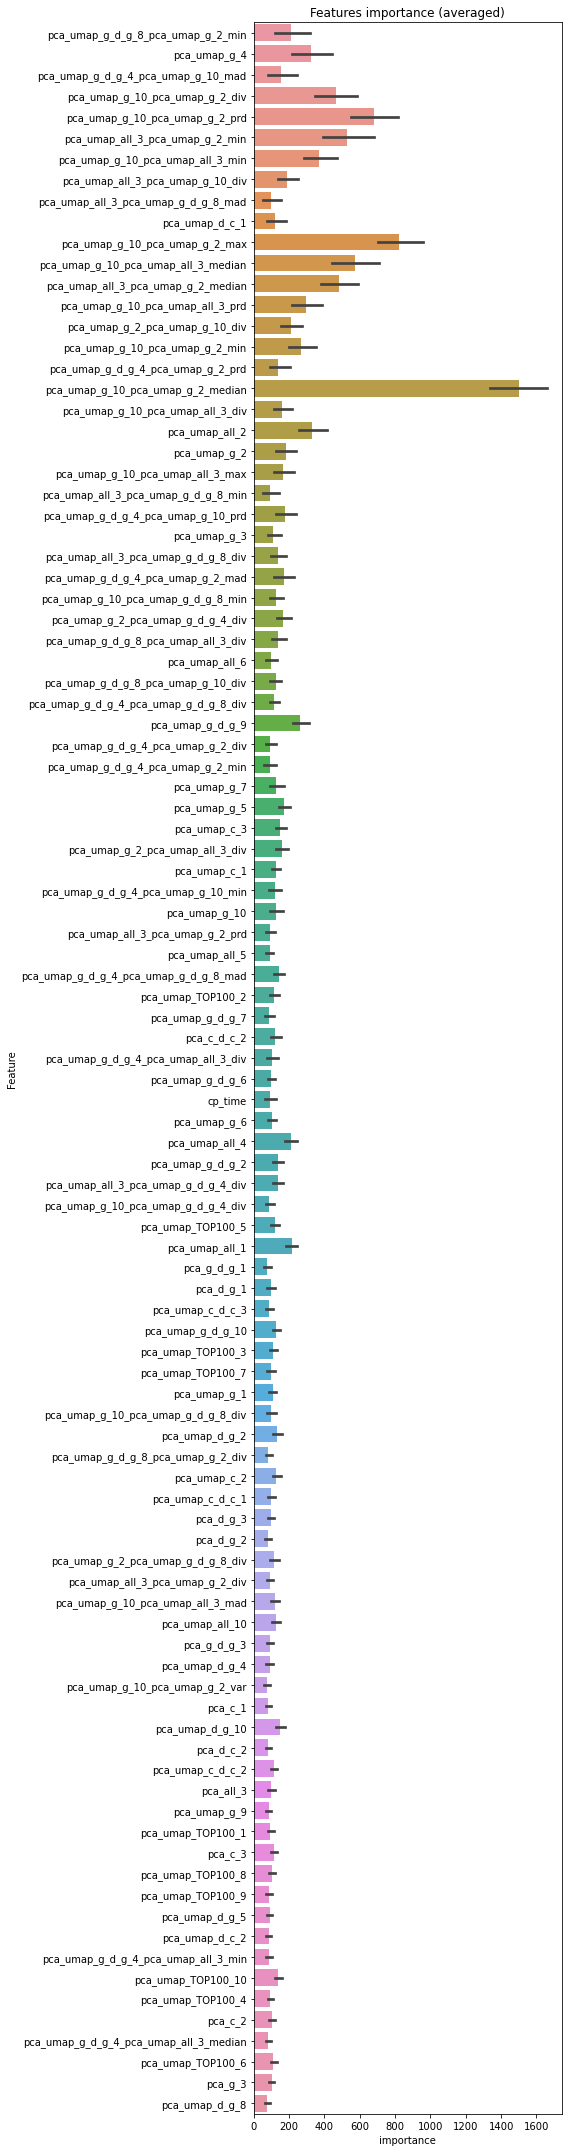

In [56]:
if DEBUG:
    show_feature_importance(feature_importance_df)